In [ ]:
import random
random.seed(13147286)

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import model_selection
import autograd.numpy as np
from autograd import grad
import pandas as pd
import seaborn as sns
from sklearn import datasets
import scipy
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
import math
from tqdm import tqdm
import os


# Preprocessing

In [3]:
# get insight of data
preview = pd.read_csv('musicData.csv')
preview.head()

instance_id           artist_name            track_name  popularity  \
0      32894.0              Röyksopp  Röyksopp's Night Out        27.0   
1      46652.0  Thievery Corporation      The Shining Path        31.0   
2      30097.0        Dillon Francis             Hurricane        28.0   
3      62177.0              Dubloadz                 Nitro        34.0   
4      24907.0           What So Not      Divide & Conquer        32.0   

   acousticness  danceability  duration_ms  energy  instrumentalness key  \
0       0.00468         0.652         -1.0   0.941           0.79200  A#   
1       0.01270         0.622     218293.0   0.890           0.95000   D   
2       0.00306         0.620     215613.0   0.755           0.01180  G#   
3       0.02540         0.774     166875.0   0.700           0.00253  C#   
4       0.00465         0.638     222369.0   0.587           0.90900  F#   

   liveness  loudness   mode  speechiness               tempo obtained_date  \
0     0.115    -5.201  Minor       0.0748             100.889         4-Apr   
1     0.124    -7.043  Minor       0.0300  115.00200000000001         4-Apr   
2     0.534    -4.617  Major       0.0345             127.994         4-Apr   
3     0.157    -4.498  Major       0.2390             128.014         4-Apr   
4     0.157    -6.266  Major       0.0413             145.036         4-Apr   

   valence music_genre  
0    0.759  Electronic  
1    0.531  Electronic  
2    0.333  Electronic  
3    0.270  Electronic  
4    0.323  Electronic

In [4]:
# check missing value of each column
for column in preview.columns:
    print(column, preview[column].isnull().sum())

# print NaN rows
print(preview[preview.isnull().any(axis=1)])
# total row number
print("total row number:", preview.shape[0])
df = preview.dropna()
print("total row number after drop nan:", df.shape[0])

instance_id 5
artist_name 5
track_name 5
popularity 5
acousticness 5
danceability 5
duration_ms 5
energy 5
instrumentalness 5
key 5
liveness 5
loudness 5
mode 5
speechiness 5
tempo 5
obtained_date 5
valence 5
music_genre 5
       instance_id artist_name track_name  popularity  acousticness  \
10000          NaN         NaN        NaN         NaN           NaN   
10001          NaN         NaN        NaN         NaN           NaN   
10002          NaN         NaN        NaN         NaN           NaN   
10003          NaN         NaN        NaN         NaN           NaN   
10004          NaN         NaN        NaN         NaN           NaN   

       danceability  duration_ms  energy  instrumentalness  key  liveness  \
10000           NaN          NaN     NaN               NaN  NaN       NaN   
10001           NaN          NaN     NaN               NaN  NaN       NaN   
10002           NaN          NaN     NaN               NaN  NaN       NaN   
10003           NaN          NaN     NaN  

In [5]:
for col in ['duration_ms', 'tempo', 'loudness', 'energy', 'valence', 'speechiness', 'instrumentalness']:
    non_numeric_mask = pd.to_numeric(df[col], errors='coerce').isna() & df[col].notna()
    if non_numeric_mask.any():
        print(f"Non-numeric values in {col}:")
        print(df.loc[non_numeric_mask, col])

Non-numeric values in tempo:
5        ?
32       ?
35       ?
36       ?
39       ?
        ..
49918    ?
49964    ?
49967    ?
49976    ?
49977    ?
Name: tempo, Length: 4980, dtype: object


In [6]:
print("polularity", ((df['popularity'] > 99) | (df['popularity'] < 0)).sum())
for column in ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']:
    df[column] = pd.to_numeric(df[column], errors='coerce')
    if column == 'duration_ms' or column == 'tempo':
        print(column, (df[column] < 0).sum())
    elif column == 'loudness':
        print(column, (df[column] > 0).sum())
    else:
        print(column, ((df[column] > 1) | (df[column] < 0)).sum())


polularity 0
acousticness 0
danceability 0
duration_ms 4939
energy 0
instrumentalness 0
liveness 0
loudness 47
speechiness 0
tempo 0
valence 0


/tmp/ipykernel_350771/724773840.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_numeric(df[column], errors='coerce')


In [7]:
# impute missing values genre-wisely 
for column in ['duration_ms', 'loudness', 'tempo']:
    for genre in df['music_genre'].unique():
        if column == 'duration_ms':
            genre_median = df.loc[(df['music_genre'] == genre) & (df[column] >= 0), column].median()
            df.loc[(df['music_genre'] == genre) & (df[column] < 0), column] = genre_median
        elif column == 'loudness':
            genre_median = df.loc[(df['music_genre'] == genre) & (df[column] <= 0), column].median()
            df.loc[(df['music_genre'] == genre) & (df[column] > 0), column] = genre_median
        else:
            genre_median = df.loc[(df['music_genre'] == genre) & (df[column].notna()), column].median()
            df.loc[(df['music_genre'] == genre) & (df[column].isna()), column] = genre_median

In [8]:
df

instance_id           artist_name                track_name  \
0          32894.0              Röyksopp      Röyksopp's Night Out   
1          46652.0  Thievery Corporation          The Shining Path   
2          30097.0        Dillon Francis                 Hurricane   
3          62177.0              Dubloadz                     Nitro   
4          24907.0           What So Not          Divide & Conquer   
...            ...                   ...                       ...   
50000      58878.0                 BEXEY                  GO GETTA   
50001      43557.0             Roy Woods       Drama (feat. Drake)   
50002      39767.0                Berner  Lovin' Me (feat. Smiggz)   
50003      57944.0             The-Dream         Shawty Is Da Shit   
50004      63470.0     Naughty By Nature            Hip Hop Hooray   

       popularity  acousticness  danceability  duration_ms  energy  \
0            27.0       0.00468         0.652     245217.0   0.941   
1            31.0       0.01270         0.622     218293.0   0.890   
2            28.0       0.00306         0.620     215613.0   0.755   
3            34.0       0.02540         0.774     166875.0   0.700   
4            32.0       0.00465         0.638     222369.0   0.587   
...           ...           ...           ...          ...     ...   
50000        59.0       0.03340         0.913     215240.0   0.574   
50001        72.0       0.15700         0.709     251860.0   0.362   
50002        51.0       0.00597         0.693     189483.0   0.763   
50003        65.0       0.08310         0.782     262773.0   0.472   
50004        67.0       0.10200         0.862     267267.0   0.642   

       instrumentalness key  liveness  loudness   mode  speechiness    tempo  \
0               0.79200  A#     0.115    -5.201  Minor       0.0748  100.889   
1               0.95000   D     0.124    -7.043  Minor       0.0300  115.002   
2               0.01180  G#     0.534    -4.617  Major       0.0345  127.994   
3               0.00253  C#     0.157    -4.498  Major       0.2390  128.014   
4               0.90900  F#     0.157    -6.266  Major       0.0413  145.036   
...                 ...  ..       ...       ...    ...          ...      ...   
50000           0.00000  C#     0.119    -7.022  Major       0.2980   98.028   
50001           0.00000   B     0.109    -9.814  Major       0.0550  122.043   
50002           0.00000   D     0.143    -5.443  Major       0.1460  131.079   
50003           0.00000   G     0.106    -5.016  Minor       0.0441   75.886   
50004           0.00000  F#     0.272   -13.652  Minor       0.1010   99.201   

      obtained_date  valence music_genre  
0             4-Apr    0.759  Electronic  
1             4-Apr    0.531  Electronic  
2             4-Apr    0.333  Electronic  
3             4-Apr    0.270  Electronic  
4             4-Apr    0.323  Electronic  
...             ...      ...         ...  
50000         4-Apr    0.330     Hip-Hop  
50001         4-Apr    0.113     Hip-Hop  
50002         4-Apr    0.395     Hip-Hop  
50003         4-Apr    0.354     Hip-Hop  
50004         4-Apr    0.765     Hip-Hop  

[50000 rows x 18 columns]

In [ ]:
# processing data
# d
drop_cols = ['instance_id', 'artist_name', 'track_name', 'obtained_date']

df = df.drop(columns = drop_cols)

norm_cols = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
for col in norm_cols:
    df[col] = (df[col] - df[col].mean()) / df[col].std()

df.head()

popularity  acousticness  danceability  duration_ms    energy  \
0   -1.107992     -0.883877      0.524873     0.010209  1.289863   
1   -0.850625     -0.860382      0.356930    -0.243830  1.097090   
2   -1.043650     -0.888623      0.345734    -0.269117  0.586807   
3   -0.657600     -0.823175      1.207841    -0.728981  0.378914   
4   -0.786283     -0.883965      0.446499    -0.205371 -0.048211   

   instrumentalness key  liveness  loudness   mode  speechiness     tempo  \
0          1.875791  A# -0.488109  0.639876  Minor    -0.185320 -0.645552   
1          2.361333   D -0.432428  0.340670  Minor    -0.627251 -0.162672   
2         -0.521807  G#  2.104119  0.734738  Major    -0.582861  0.281853   
3         -0.550294  C# -0.228267  0.754068  Major     1.434438  0.282537   
4          2.235338  F# -0.228267  0.466882  Major    -0.515782  0.864949   

    valence music_genre  
0  1.225061  Electronic  
1  0.302428  Electronic  
2 -0.498807  Electronic  
3 -0.753745  Electronic  
4 -0.539273  Electronic

In [10]:
# categorical columns

# mode
print("mode types:", df["mode"].unique())

df.loc[df['mode'] == 'Major', 'mode'] = 1
df.loc[df['mode'] == 'Minor', 'mode'] = 0
df['mode'] = df['mode'].astype(int)


mode types: ['Minor' 'Major']


In [11]:
# key
print("key types:", df["key"].unique())

# dummy encoding
df['key'] = df['key'].astype('category')
df = pd.get_dummies(df, columns=['key'], prefix='key', drop_first=True)

# print dummy encoding
print(df.filter(like='key_').head())


key types: ['A#' 'D' 'G#' 'C#' 'F#' 'B' 'G' 'F' 'A' 'C' 'E' 'D#']
   key_A#  key_B  key_C  key_C#  key_D  key_D#  key_E  key_F  key_F#  key_G  \
0    True  False  False   False  False   False  False  False   False  False   
1   False  False  False   False   True   False  False  False   False  False   
2   False  False  False   False  False   False  False  False   False  False   
3   False  False  False    True  False   False  False  False   False  False   
4   False  False  False   False  False   False  False  False    True  False   

   key_G#  
0   False  
1   False  
2    True  
3   False  
4   False  


In [12]:
# music_genre
print("music_genre types:", df["music_genre"].unique())

# label
genres = df['music_genre'].unique()
for i, genre in enumerate(genres):
    df.loc[df['music_genre'] == genre, 'music_genre'] = i
df['music_genre'] = df['music_genre'].astype(int)

music_genre types: ['Electronic' 'Anime' 'Jazz' 'Alternative' 'Country' 'Rap' 'Blues' 'Rock'
 'Classical' 'Hip-Hop']


In [13]:
print("total_num_rows:", df.shape[0])
for genre in df['music_genre'].unique():
    print("genre", genre, "num_rows:", df[df['music_genre'] == genre].shape[0])
df.head()

total_num_rows: 50000
genre 0 num_rows: 5000
genre 1 num_rows: 5000
genre 2 num_rows: 5000
genre 3 num_rows: 5000
genre 4 num_rows: 5000
genre 5 num_rows: 5000
genre 6 num_rows: 5000
genre 7 num_rows: 5000
genre 8 num_rows: 5000
genre 9 num_rows: 5000


popularity  acousticness  danceability  duration_ms    energy  \
0   -1.107992     -0.883877      0.524873     0.010209  1.289863   
1   -0.850625     -0.860382      0.356930    -0.243830  1.097090   
2   -1.043650     -0.888623      0.345734    -0.269117  0.586807   
3   -0.657600     -0.823175      1.207841    -0.728981  0.378914   
4   -0.786283     -0.883965      0.446499    -0.205371 -0.048211   

   instrumentalness  liveness  loudness  mode  speechiness  ...  key_B  key_C  \
0          1.875791 -0.488109  0.639876     0    -0.185320  ...  False  False   
1          2.361333 -0.432428  0.340670     0    -0.627251  ...  False  False   
2         -0.521807  2.104119  0.734738     1    -0.582861  ...  False  False   
3         -0.550294 -0.228267  0.754068     1     1.434438  ...  False  False   
4          2.235338 -0.228267  0.466882     1    -0.515782  ...  False  False   

   key_C#  key_D  key_D#  key_E  key_F  key_F#  key_G  key_G#  
0   False  False   False  False  False   False  False   False  
1   False   True   False  False  False   False  False   False  
2   False  False   False  False  False   False  False    True  
3    True  False   False  False  False   False  False   False  
4   False  False   False  False  False    True  False   False  

[5 rows x 24 columns]

In [14]:
# train test split for each genre
X_train = []
X_test = []
y_train = []
y_test = []

for genre in df['music_genre'].unique():
    genre_df = df[df['music_genre'] == genre]
    X_0 = genre_df.drop(columns=['music_genre'])
    y_0 = genre_df['music_genre']
    X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_0, y_0, test_size=500, random_state = 13147286)
    X_train.append(X_train_0)
    X_test.append(X_test_0)
    y_train.append(y_train_0)
    y_test.append(y_test_0)

X_train = pd.concat(X_train).reset_index(drop=True)
X_test = pd.concat(X_test).reset_index(drop=True)
y_train = pd.concat(y_train).reset_index(drop=True)
y_test = pd.concat(y_test).reset_index(drop=True)

# check whether the split is correct
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)



X_train shape: (45000, 23)
X_test shape: (5000, 23)
y_train shape: (45000,)
y_test shape: (5000,)


# Pre-Visualization

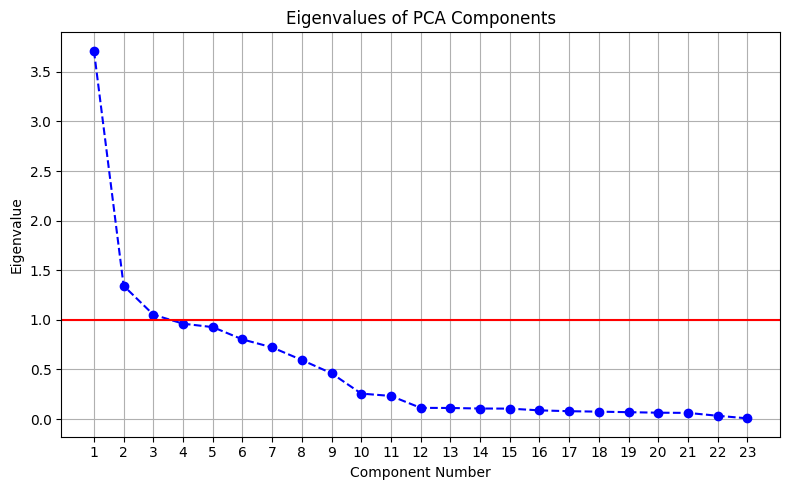

Eigenvalues above 1: [3.7121113464698494, 1.3432475321121609, 1.052690238044676]


In [15]:
# PCA
pca = PCA().fit(X_train)
X_train_pca = pca.transform(X_train)

eigenvalues = pca.explained_variance_
eigenvalues_above_1 = []
for i in range(len(eigenvalues)):
    if eigenvalues[i] > 1:
        eigenvalues_above_1.append(eigenvalues[i])


# plot eigenvalues
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='--', color='b')
plt.axhline(y=1, color='r', linestyle='-')
plt.title('Eigenvalues of PCA Components')
plt.xlabel('Component Number')
plt.ylabel('Eigenvalue')
plt.xticks(range(1, len(eigenvalues) + 1))
plt.grid()
plt.tight_layout()
plt.show()


print("Eigenvalues above 1:", eigenvalues_above_1)

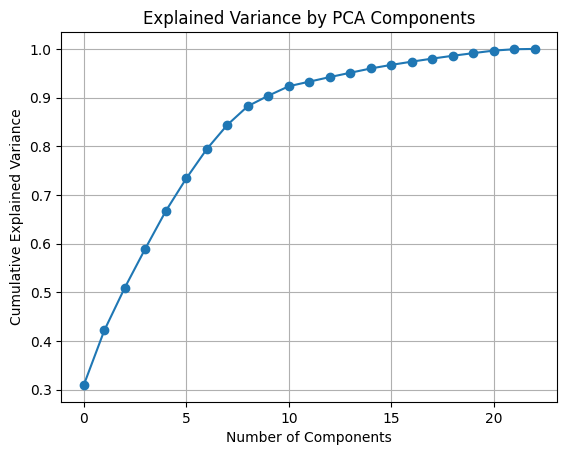

explained variance ratio: [0.30960704 0.11203298 0.08779917 0.08020277 0.07731386 0.06699595
 0.06027943 0.0496457  0.03850256 0.02145286 0.01946587 0.00945594
 0.00935663 0.00890094 0.00881937 0.00735016 0.00665168 0.00627067
 0.00582602 0.00539488 0.00522133 0.00280675 0.00064745]
Total explained variance: 0.9999999999999998
explained variance ratio by first 2 components: 0.42164001903685205


In [16]:
explained_var = pca.explained_variance_ratio_

plt.figure()
plt.plot(np.cumsum(explained_var), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.show()

print("explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained variance:", np.sum(pca.explained_variance_ratio_))
print("explained variance ratio by first 2 components:", np.sum(pca.explained_variance_ratio_[:2]))


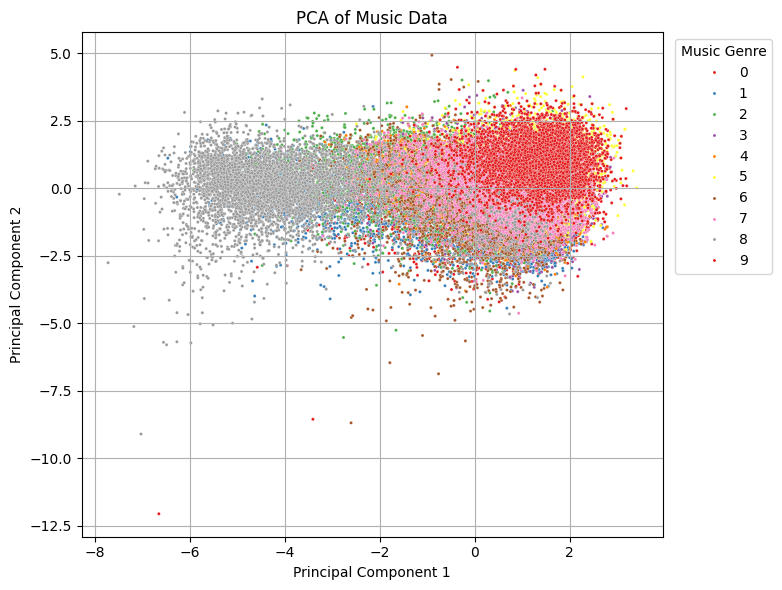

In [17]:
# scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, palette='Set1', s=5)
plt.title('PCA of Music Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.legend(title='Music Genre', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.tight_layout()
plt.show()


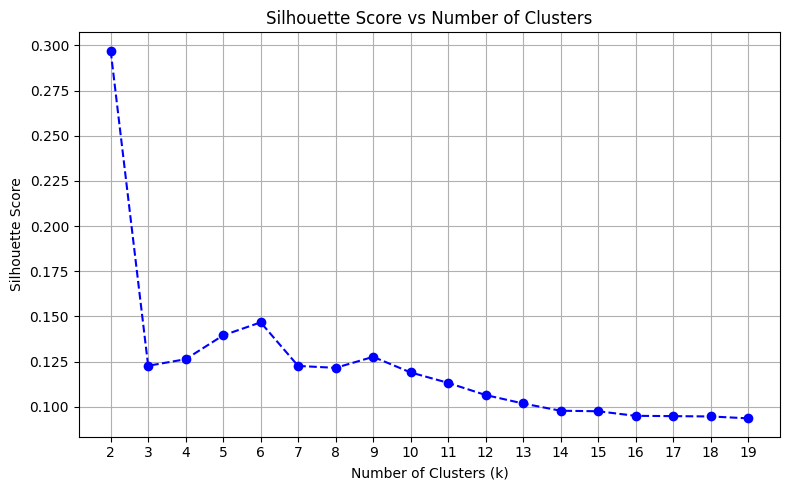

Silhouette scores: [0.2970333265153344, 0.12265734121985383, 0.12628205399031658, 0.13948399845621834, 0.14667800742988124, 0.12256548583398029, 0.1215039307878473, 0.1275997263283093, 0.11896266704837405, 0.11318872233517167, 0.1064562609998712, 0.10177557021636426, 0.09777021266664358, 0.09747580415096145, 0.0949502026339854, 0.09478733920493217, 0.09460293568715994, 0.093559185167342]
Best k: 2


In [18]:
# K-means clustering
silhouette_scores = []
ks = range(2, 20)

for k in ks:
    kmeans = KMeans(n_clusters=k, n_init= 'auto', random_state=13147286)
    labels = kmeans.fit_predict(X_train_pca)
    score = silhouette_score(X_train_pca, labels)
    silhouette_scores.append(score)


plt.figure(figsize=(8, 5))
plt.plot(ks, silhouette_scores, marker='o', linestyle='--', color='b')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(ks)
plt.grid()
plt.tight_layout()
plt.show()
print("Silhouette scores:", silhouette_scores)
best_k = ks[silhouette_scores.index(max(silhouette_scores))]
print("Best k:", best_k)

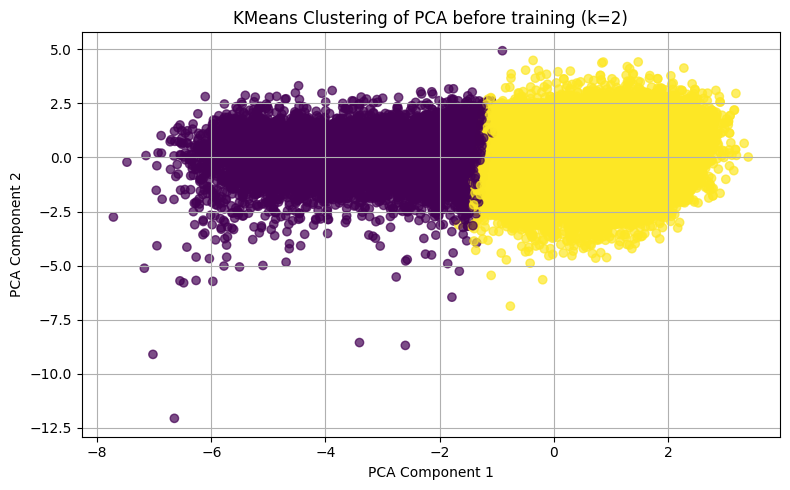

In [19]:
kmeans_best = KMeans(n_clusters=best_k, n_init='auto', random_state=13147286)
labels_best = kmeans_best.fit_predict(X_train_pca)
plt.figure(figsize=(8, 5))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=labels_best, cmap='viridis', alpha=0.7)
plt.title(f'KMeans Clustering of PCA before training (k={best_k})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.tight_layout()
plt.show()

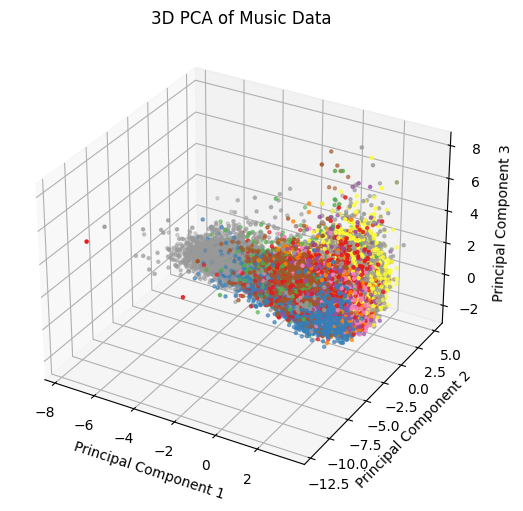

In [20]:
# 3D scatter plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], c=y_train, cmap='Set1', s=5)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA of Music Data')
plt.show()

# RandomForest

In [21]:
# original data
best_auc = 0
best_model = None
best_params = None
for n_estimators in [10, 50, 100, 200]:
    for criterion in ['gini', 'entropy']:
        for max_features in [None, 'sqrt', 'log2']:
            for max_depth in [None, 5, 10, 15]:
                for min_samples_split in [2, 5, 10]:
                    for min_samples_leaf in [1, 2, 4]:
                        model = RandomForestClassifier(n_estimators=n_estimators,
                                                    max_features=max_features,
                                                    max_depth=max_depth,
                                                    min_samples_split=min_samples_split,
                                                    min_samples_leaf=min_samples_leaf,
                                                    criterion=criterion,
                                                    random_state=13147286, n_jobs=-1)
                        model.fit(X_train, y_train)
                        y_pred = model.predict_proba(X_test)
                        auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
                        if auc > best_auc:
                            best_auc = auc
                            best_model = model
                            best_params = (n_estimators, criterion,max_features, max_depth, min_samples_split, min_samples_leaf)
print("Best AUC:", best_auc)
print("Best parameters:", best_params)

Best AUC: 0.9372522222222225
Best parameters: (200, 'gini', 'sqrt', 15, 10, 4)


In [22]:
for n_estimators in [100, 300]:
    for criterion in ['gini', 'entropy']:
        for max_features in [None, 'sqrt', 'log2']:
            for max_depth in [None, 30, 50]:
                for min_samples_split in [10, 20]:
                    for min_samples_leaf in [10, 20, 50]:
                        model = RandomForestClassifier(n_estimators=n_estimators,
                                                    max_features=max_features,
                                                    max_depth=max_depth,
                                                    min_samples_split=min_samples_split,
                                                    min_samples_leaf=min_samples_leaf,
                                                    criterion=criterion,
                                                    random_state=13147286, n_jobs=6)
                        model.fit(X_train, y_train)
                        y_pred = model.predict_proba(X_test)
                        auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
                        if auc > best_auc:
                            best_auc = auc
                            best_model = model
                            best_params = (n_estimators, criterion,max_features, max_depth, min_samples_split, min_samples_leaf)


print("Best AUC:", best_auc)
print("Best parameters:", best_params)

Best AUC: 0.9372522222222225
Best parameters: (200, 'gini', 'sqrt', 15, 10, 4)


In [23]:
best_auc2 = 0
best_model2 = None
best_n2 = None

max_components = X_train_pca.shape[1]
X_test_pca = pca.transform(X_test)

for n in range(2, max_components + 1):
    X_train_n = X_train_pca[:, :n]
    X_test_n = X_test_pca[:, :n]

    model = RandomForestClassifier(n_estimators=best_params[0],
                                    criterion=best_params[1],
                                    max_features=best_params[2],
                                    max_depth=best_params[3],
                                    min_samples_split=best_params[4],
                                    min_samples_leaf=best_params[5],
                                    random_state=13147286, n_jobs=-1)
    model.fit(X_train_n, y_train)
    y_pred = model.predict_proba(X_test_n)

    auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
    if auc > best_auc2:
        best_auc2 = auc
        best_model2 = model
        best_n2 = n

print("Best AUC after PCA:", best_auc2)
print("Best number of components:", best_n2)
    

Best AUC after PCA: 0.9175150222222224
Best number of components: 10


# AdaBoostClassifier

In [24]:
best_auc3 = 0
best_model3 = None
best_params3 = None
for n_estimators in [10, 50, 100, 200]:
    for learning_rate in [0.01, 0.1, 1.0]:
        for algorithm in ['SAMME']:
            model = AdaBoostClassifier(n_estimators=n_estimators,
                                       learning_rate=learning_rate,
                                       algorithm=algorithm,
                                       random_state=13147286)
            model.fit(X_train, y_train)
            y_pred = model.predict_proba(X_test)
            auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
            if auc > best_auc3:
                best_auc3 = auc
                best_model3 = model
                best_params3 = (n_estimators, learning_rate, algorithm)
print("Best AUC:", best_auc3)
print("Best parameters:", best_params3)


/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9

Best AUC: 0.8898030222222222
Best parameters: (200, 1.0, 'SAMME')


In [25]:
best_auc4 = 0
best_model4 = None
best_n4 = None

for i in range(2, max_components + 1):
    X_train_n = X_train_pca[:, :i]
    X_test_n = X_test_pca[:, :i]

    model = AdaBoostClassifier(n_estimators=best_params3[0],
                               learning_rate=best_params3[1],
                               algorithm=best_params3[2],
                               random_state=13147286)
    model.fit(X_train_n, y_train)
    y_pred = model.predict_proba(X_test_n)

    auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
    if auc > best_auc4:
        best_auc4 = auc
        best_model4 = model
        best_n4 = i

print("Best AUC after PCA:", best_auc4)
print("Best number of components:", best_n4)

/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9

Best AUC after PCA: 0.8544883111111112
Best number of components: 11


# Neural Network

In [26]:
X_test_pca = pca.transform(X_test)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [27]:
bool_cols = X_train.select_dtypes(include=[bool]).columns
for col in bool_cols:
    X_train[col] = X_train[col].astype(float)
    X_test[col] = X_test[col].astype(float)

X_train_tensor = torch.tensor(X_train.values, dtype= torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype= torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype= torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype= torch.long)

In [28]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True, pin_memory=True, num_workers= 12)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=False, pin_memory=True, num_workers= 12)

In [29]:
class MLP(nn.Module):
    def __init__(self, in_dim,hidden_dim, out_dim, dropout = 0):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim //2)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm1d(hidden_dim // 4)
        self.dropout3 = nn.Dropout(dropout)
        self.fc4 = nn.Linear(hidden_dim // 4, out_dim)
        

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.bn3(x)
        x = self.dropout3(x)
        x = self.fc4(x)

        return x

In [36]:
def warmup_cosine_lr(epoch, total_epochs, warmup_epochs=10, eta_min = 0):
    if epoch < warmup_epochs:
        return epoch / warmup_epochs # Linear warmup
    else:
        return eta_min + 0.5 * (math.cos((epoch - warmup_epochs) / (total_epochs - warmup_epochs) * math.pi) + 1)
    
def train(model, epochs, train_loader, test_loader, criterion, lr, weight_decay):
    best_auc = 0
    best_epoch = -1

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: warmup_cosine_lr(epoch, epochs))

    for epoch in range(epochs):
        model.train()
        training_loss = 0.0
        for idx, batch in enumerate(tqdm(train_loader, desc= f"Epoch {epoch + 1}/{epochs}")):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            training_loss += loss.item()

        training_loss /= len(train_loader)
        scheduler.step()
        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {training_loss:.4f}")

        # validation for auc
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            y_probs = []
            y_true = []
            
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                probs = F.softmax(outputs, dim=1).cpu().numpy()
                y_probs.append(probs)
                y_true.append(labels.cpu().numpy())
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        y_probs = np.concatenate(y_probs, axis=0)
        y_true = np.concatenate(y_true)
        auc = roc_auc_score(y_true, y_probs, multi_class='ovr')
        print(f"Epoch {epoch + 1}/{epochs}, Validation AUC: {auc:.4f}, Validation Accuracy: {accuracy:.2f}%")
        print("-------------------------------------------")


        # save model
        if auc > best_auc:
            best_auc = auc
            best_epoch = epoch + 1
            best_model = model.state_dict()
            torch.save(model.state_dict(), 'best_mlp_model.pth')


    print(f"Best AUC: {best_auc:.4f} at epoch {best_epoch}")
    return model, best_auc, best_model




In [39]:
def get_mlp_latent(model, data_loader):
    model.eval()
    x_representations = []
    y_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)

            x = model.fc1(inputs)
            x = model.relu1(x)
            x = model.bn1(x)
            x = model.fc2(x)
            x = model.relu2(x)
            x = model.bn2(x)
            x = model.fc3(x)
            x = model.relu3(x)
            x = model.bn3(x)

            x_representations.append(x.cpu().numpy())
            y_labels.append(labels.cpu().numpy())

    x_representations = np.concatenate(x_representations, axis=0)
    y_labels = np.concatenate(y_labels, axis=0)
    return x_representations, y_labels

In [68]:
# Train MLP
best_auc5 = 0
best_model5 = None
best_params5 = None
criterion = nn.CrossEntropyLoss()
out_dim = len(df['music_genre'].unique())
for epochs in [200]:
    for hidden_dim in [256]:
        for dropout in [0.1, 0.2, 0.3]:
            for lr in [1e-3, 5e-4]:
                for weight_decay in [5e-4]:
                    print(f"Training MLP with hidden_dim={hidden_dim}, dropout={dropout}, lr={lr}, weight_decay={weight_decay}")
                    model = MLP(X_train.shape[1], hidden_dim, out_dim, dropout).to(device)
                    model, best_auc, best_model = train(model, epochs, train_loader, test_loader, criterion, lr, weight_decay)
                    if best_auc > best_auc5:
                        best_auc5 = best_auc
                        best_model5 = best_model
                        best_params5 = (epochs, hidden_dim, dropout, lr, weight_decay)

                    

Training MLP with hidden_dim=256, dropout=0.1, lr=0.001, weight_decay=0.0005


Epoch 1/200: 100%|██████████| 44/44 [00:00<00:00, 103.08it/s]

Epoch 1/200, Training Loss: 2.3997


Epoch 1/200, Validation AUC: 0.5352, Validation Accuracy: 13.18%
-------------------------------------------


Epoch 2/200: 100%|██████████| 44/44 [00:00<00:00, 103.11it/s]

Epoch 2/200, Training Loss: 2.0170


Epoch 2/200, Validation AUC: 0.8417, Validation Accuracy: 41.82%
-------------------------------------------


Epoch 3/200: 100%|██████████| 44/44 [00:00<00:00, 103.19it/s]

Epoch 3/200, Training Loss: 1.5954


Epoch 3/200, Validation AUC: 0.8931, Validation Accuracy: 50.56%
-------------------------------------------


Epoch 4/200: 100%|██████████| 44/44 [00:00<00:00, 106.35it/s]

Epoch 4/200, Training Loss: 1.3972


Epoch 4/200, Validation AUC: 0.9098, Validation Accuracy: 53.86%
-------------------------------------------


Epoch 5/200: 100%|██████████| 44/44 [00:00<00:00, 105.29it/s]

Epoch 5/200, Training Loss: 1.2945


Epoch 5/200, Validation AUC: 0.9177, Validation Accuracy: 56.04%
-------------------------------------------


Epoch 6/200: 100%|██████████| 44/44 [00:00<00:00, 102.41it/s]

Epoch 6/200, Training Loss: 1.2366


Epoch 6/200, Validation AUC: 0.9225, Validation Accuracy: 57.14%
-------------------------------------------


Epoch 7/200: 100%|██████████| 44/44 [00:00<00:00, 104.14it/s]

Epoch 7/200, Training Loss: 1.2008


Epoch 7/200, Validation AUC: 0.9251, Validation Accuracy: 57.82%
-------------------------------------------


Epoch 8/200: 100%|██████████| 44/44 [00:00<00:00, 102.25it/s]

Epoch 8/200, Training Loss: 1.1731


Epoch 8/200, Validation AUC: 0.9274, Validation Accuracy: 58.00%
-------------------------------------------


Epoch 9/200: 100%|██████████| 44/44 [00:00<00:00, 104.56it/s]

Epoch 9/200, Training Loss: 1.1527


Epoch 9/200, Validation AUC: 0.9291, Validation Accuracy: 58.42%
-------------------------------------------


Epoch 10/200: 100%|██████████| 44/44 [00:00<00:00, 104.00it/s]

Epoch 10/200, Training Loss: 1.1347


Epoch 10/200, Validation AUC: 0.9307, Validation Accuracy: 58.80%
-------------------------------------------


Epoch 11/200: 100%|██████████| 44/44 [00:00<00:00, 104.96it/s]

Epoch 11/200, Training Loss: 1.1181


Epoch 11/200, Validation AUC: 0.9308, Validation Accuracy: 58.86%
-------------------------------------------


Epoch 12/200: 100%|██████████| 44/44 [00:00<00:00, 105.35it/s]

Epoch 12/200, Training Loss: 1.1059


Epoch 12/200, Validation AUC: 0.9318, Validation Accuracy: 59.34%
-------------------------------------------


Epoch 13/200: 100%|██████████| 44/44 [00:00<00:00, 104.75it/s]

Epoch 13/200, Training Loss: 1.0966


Epoch 13/200, Validation AUC: 0.9332, Validation Accuracy: 59.72%
-------------------------------------------


Epoch 14/200: 100%|██████████| 44/44 [00:00<00:00, 104.53it/s]

Epoch 14/200, Training Loss: 1.0864


Epoch 14/200, Validation AUC: 0.9347, Validation Accuracy: 60.16%
-------------------------------------------


Epoch 15/200: 100%|██████████| 44/44 [00:00<00:00, 102.30it/s]

Epoch 15/200, Training Loss: 1.0757


Epoch 15/200, Validation AUC: 0.9344, Validation Accuracy: 60.84%
-------------------------------------------


Epoch 16/200: 100%|██████████| 44/44 [00:00<00:00, 104.80it/s]

Epoch 16/200, Training Loss: 1.0683


Epoch 16/200, Validation AUC: 0.9349, Validation Accuracy: 60.36%
-------------------------------------------


Epoch 17/200: 100%|██████████| 44/44 [00:00<00:00, 105.93it/s]

Epoch 17/200, Training Loss: 1.0633


Epoch 17/200, Validation AUC: 0.9347, Validation Accuracy: 60.58%
-------------------------------------------


Epoch 18/200: 100%|██████████| 44/44 [00:00<00:00, 105.02it/s]

Epoch 18/200, Training Loss: 1.0541


Epoch 18/200, Validation AUC: 0.9351, Validation Accuracy: 60.54%
-------------------------------------------


Epoch 19/200: 100%|██████████| 44/44 [00:00<00:00, 102.67it/s]

Epoch 19/200, Training Loss: 1.0487


Epoch 19/200, Validation AUC: 0.9357, Validation Accuracy: 60.76%
-------------------------------------------


Epoch 20/200: 100%|██████████| 44/44 [00:00<00:00, 103.36it/s]

Epoch 20/200, Training Loss: 1.0443


Epoch 20/200, Validation AUC: 0.9356, Validation Accuracy: 60.64%
-------------------------------------------


Epoch 21/200: 100%|██████████| 44/44 [00:00<00:00, 102.78it/s]

Epoch 21/200, Training Loss: 1.0360


Epoch 21/200, Validation AUC: 0.9360, Validation Accuracy: 60.42%
-------------------------------------------


Epoch 22/200: 100%|██████████| 44/44 [00:00<00:00, 104.51it/s]

Epoch 22/200, Training Loss: 1.0330


Epoch 22/200, Validation AUC: 0.9363, Validation Accuracy: 60.02%
-------------------------------------------


Epoch 23/200: 100%|██████████| 44/44 [00:00<00:00, 103.24it/s]

Epoch 23/200, Training Loss: 1.0285


Epoch 23/200, Validation AUC: 0.9358, Validation Accuracy: 59.94%
-------------------------------------------


Epoch 24/200: 100%|██████████| 44/44 [00:00<00:00, 105.18it/s]

Epoch 24/200, Training Loss: 1.0270


Epoch 24/200, Validation AUC: 0.9362, Validation Accuracy: 60.54%
-------------------------------------------


Epoch 25/200: 100%|██████████| 44/44 [00:00<00:00, 105.30it/s]

Epoch 25/200, Training Loss: 1.0206


Epoch 25/200, Validation AUC: 0.9367, Validation Accuracy: 60.50%
-------------------------------------------


Epoch 26/200: 100%|██████████| 44/44 [00:00<00:00, 100.85it/s]

Epoch 26/200, Training Loss: 1.0179


Epoch 26/200, Validation AUC: 0.9365, Validation Accuracy: 60.56%
-------------------------------------------


Epoch 27/200: 100%|██████████| 44/44 [00:00<00:00, 102.99it/s]

Epoch 27/200, Training Loss: 1.0116


Epoch 27/200, Validation AUC: 0.9369, Validation Accuracy: 60.54%
-------------------------------------------


Epoch 28/200: 100%|██████████| 44/44 [00:00<00:00, 97.30it/s]

Epoch 28/200, Training Loss: 1.0078


Epoch 28/200, Validation AUC: 0.9364, Validation Accuracy: 60.42%
-------------------------------------------


Epoch 29/200: 100%|██████████| 44/44 [00:00<00:00, 105.65it/s]

Epoch 29/200, Training Loss: 1.0069


Epoch 29/200, Validation AUC: 0.9370, Validation Accuracy: 60.48%
-------------------------------------------


Epoch 30/200: 100%|██████████| 44/44 [00:00<00:00, 103.06it/s]

Epoch 30/200, Training Loss: 1.0044


Epoch 30/200, Validation AUC: 0.9366, Validation Accuracy: 60.54%
-------------------------------------------


Epoch 31/200: 100%|██████████| 44/44 [00:00<00:00, 103.69it/s]

Epoch 31/200, Training Loss: 0.9976


Epoch 31/200, Validation AUC: 0.9362, Validation Accuracy: 60.62%
-------------------------------------------


Epoch 32/200: 100%|██████████| 44/44 [00:00<00:00, 101.18it/s]

Epoch 32/200, Training Loss: 0.9960


Epoch 32/200, Validation AUC: 0.9369, Validation Accuracy: 60.44%
-------------------------------------------


Epoch 33/200: 100%|██████████| 44/44 [00:00<00:00, 99.42it/s]

Epoch 33/200, Training Loss: 0.9897


Epoch 33/200, Validation AUC: 0.9367, Validation Accuracy: 60.54%
-------------------------------------------


Epoch 34/200: 100%|██████████| 44/44 [00:00<00:00, 104.70it/s]

Epoch 34/200, Training Loss: 0.9875


Epoch 34/200, Validation AUC: 0.9365, Validation Accuracy: 60.18%
-------------------------------------------


Epoch 35/200: 100%|██████████| 44/44 [00:00<00:00, 104.02it/s]

Epoch 35/200, Training Loss: 0.9837


Epoch 35/200, Validation AUC: 0.9368, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 36/200: 100%|██████████| 44/44 [00:00<00:00, 102.09it/s]

Epoch 36/200, Training Loss: 0.9790


Epoch 36/200, Validation AUC: 0.9368, Validation Accuracy: 60.40%
-------------------------------------------


Epoch 37/200: 100%|██████████| 44/44 [00:00<00:00, 102.87it/s]

Epoch 37/200, Training Loss: 0.9781


Epoch 37/200, Validation AUC: 0.9368, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 38/200: 100%|██████████| 44/44 [00:00<00:00, 105.54it/s]

Epoch 38/200, Training Loss: 0.9705


Epoch 38/200, Validation AUC: 0.9366, Validation Accuracy: 60.54%
-------------------------------------------


Epoch 39/200: 100%|██████████| 44/44 [00:00<00:00, 107.24it/s]

Epoch 39/200, Training Loss: 0.9679


Epoch 39/200, Validation AUC: 0.9371, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 40/200: 100%|██████████| 44/44 [00:00<00:00, 105.03it/s]

Epoch 40/200, Training Loss: 0.9674


Epoch 40/200, Validation AUC: 0.9375, Validation Accuracy: 60.46%
-------------------------------------------


Epoch 41/200: 100%|██████████| 44/44 [00:00<00:00, 104.88it/s]

Epoch 41/200, Training Loss: 0.9662


Epoch 41/200, Validation AUC: 0.9368, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 42/200: 100%|██████████| 44/44 [00:00<00:00, 104.33it/s]

Epoch 42/200, Training Loss: 0.9615


Epoch 42/200, Validation AUC: 0.9374, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 43/200: 100%|██████████| 44/44 [00:00<00:00, 103.66it/s]

Epoch 43/200, Training Loss: 0.9575


Epoch 43/200, Validation AUC: 0.9370, Validation Accuracy: 60.20%
-------------------------------------------


Epoch 44/200: 100%|██████████| 44/44 [00:00<00:00, 104.15it/s]

Epoch 44/200, Training Loss: 0.9569


Epoch 44/200, Validation AUC: 0.9370, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 45/200: 100%|██████████| 44/44 [00:00<00:00, 102.82it/s]

Epoch 45/200, Training Loss: 0.9585


Epoch 45/200, Validation AUC: 0.9371, Validation Accuracy: 60.46%
-------------------------------------------


Epoch 46/200: 100%|██████████| 44/44 [00:00<00:00, 101.06it/s]

Epoch 46/200, Training Loss: 0.9524


Epoch 46/200, Validation AUC: 0.9372, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 47/200: 100%|██████████| 44/44 [00:00<00:00, 101.01it/s]

Epoch 47/200, Training Loss: 0.9537


Epoch 47/200, Validation AUC: 0.9365, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 48/200: 100%|██████████| 44/44 [00:00<00:00, 104.45it/s]

Epoch 48/200, Training Loss: 0.9445


Epoch 48/200, Validation AUC: 0.9368, Validation Accuracy: 60.30%
-------------------------------------------


Epoch 49/200: 100%|██████████| 44/44 [00:00<00:00, 104.21it/s]

Epoch 49/200, Training Loss: 0.9436


Epoch 49/200, Validation AUC: 0.9362, Validation Accuracy: 60.54%
-------------------------------------------


Epoch 50/200: 100%|██████████| 44/44 [00:00<00:00, 104.19it/s]

Epoch 50/200, Training Loss: 0.9444


Epoch 50/200, Validation AUC: 0.9370, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 51/200: 100%|██████████| 44/44 [00:00<00:00, 100.97it/s]

Epoch 51/200, Training Loss: 0.9385


Epoch 51/200, Validation AUC: 0.9363, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 52/200: 100%|██████████| 44/44 [00:00<00:00, 105.84it/s]

Epoch 52/200, Training Loss: 0.9368


Epoch 52/200, Validation AUC: 0.9367, Validation Accuracy: 60.26%
-------------------------------------------


Epoch 53/200: 100%|██████████| 44/44 [00:00<00:00, 104.18it/s]

Epoch 53/200, Training Loss: 0.9338


Epoch 53/200, Validation AUC: 0.9359, Validation Accuracy: 60.10%
-------------------------------------------


Epoch 54/200: 100%|██████████| 44/44 [00:00<00:00, 105.34it/s]

Epoch 54/200, Training Loss: 0.9337


Epoch 54/200, Validation AUC: 0.9360, Validation Accuracy: 60.06%
-------------------------------------------


Epoch 55/200: 100%|██████████| 44/44 [00:00<00:00, 104.01it/s]

Epoch 55/200, Training Loss: 0.9327


Epoch 55/200, Validation AUC: 0.9363, Validation Accuracy: 60.52%
-------------------------------------------


Epoch 56/200: 100%|██████████| 44/44 [00:00<00:00, 102.23it/s]

Epoch 56/200, Training Loss: 0.9276


Epoch 56/200, Validation AUC: 0.9364, Validation Accuracy: 60.28%
-------------------------------------------


Epoch 57/200: 100%|██████████| 44/44 [00:00<00:00, 100.83it/s]

Epoch 57/200, Training Loss: 0.9256


Epoch 57/200, Validation AUC: 0.9363, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 58/200: 100%|██████████| 44/44 [00:00<00:00, 105.20it/s]

Epoch 58/200, Training Loss: 0.9220


Epoch 58/200, Validation AUC: 0.9361, Validation Accuracy: 60.40%
-------------------------------------------


Epoch 59/200: 100%|██████████| 44/44 [00:00<00:00, 106.65it/s]

Epoch 59/200, Training Loss: 0.9196


Epoch 59/200, Validation AUC: 0.9367, Validation Accuracy: 60.74%
-------------------------------------------


Epoch 60/200: 100%|██████████| 44/44 [00:00<00:00, 101.10it/s]

Epoch 60/200, Training Loss: 0.9186


Epoch 60/200, Validation AUC: 0.9364, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 61/200: 100%|██████████| 44/44 [00:00<00:00, 107.08it/s]

Epoch 61/200, Training Loss: 0.9171


Epoch 61/200, Validation AUC: 0.9353, Validation Accuracy: 60.28%
-------------------------------------------


Epoch 62/200: 100%|██████████| 44/44 [00:00<00:00, 103.80it/s]

Epoch 62/200, Training Loss: 0.9150


Epoch 62/200, Validation AUC: 0.9356, Validation Accuracy: 60.60%
-------------------------------------------


Epoch 63/200: 100%|██████████| 44/44 [00:00<00:00, 104.28it/s]

Epoch 63/200, Training Loss: 0.9127


Epoch 63/200, Validation AUC: 0.9363, Validation Accuracy: 60.22%
-------------------------------------------


Epoch 64/200: 100%|██████████| 44/44 [00:00<00:00, 106.34it/s]

Epoch 64/200, Training Loss: 0.9077


Epoch 64/200, Validation AUC: 0.9352, Validation Accuracy: 60.36%
-------------------------------------------


Epoch 65/200: 100%|██████████| 44/44 [00:00<00:00, 106.47it/s]

Epoch 65/200, Training Loss: 0.9076


Epoch 65/200, Validation AUC: 0.9354, Validation Accuracy: 60.28%
-------------------------------------------


Epoch 66/200: 100%|██████████| 44/44 [00:00<00:00, 105.52it/s]

Epoch 66/200, Training Loss: 0.9023


Epoch 66/200, Validation AUC: 0.9356, Validation Accuracy: 60.10%
-------------------------------------------


Epoch 67/200: 100%|██████████| 44/44 [00:00<00:00, 103.67it/s]

Epoch 67/200, Training Loss: 0.9046


Epoch 67/200, Validation AUC: 0.9349, Validation Accuracy: 59.62%
-------------------------------------------


Epoch 68/200: 100%|██████████| 44/44 [00:00<00:00, 106.37it/s]

Epoch 68/200, Training Loss: 0.9017


Epoch 68/200, Validation AUC: 0.9360, Validation Accuracy: 60.40%
-------------------------------------------


Epoch 69/200: 100%|██████████| 44/44 [00:00<00:00, 102.11it/s]

Epoch 69/200, Training Loss: 0.8979


Epoch 69/200, Validation AUC: 0.9343, Validation Accuracy: 59.98%
-------------------------------------------


Epoch 70/200: 100%|██████████| 44/44 [00:00<00:00, 105.27it/s]

Epoch 70/200, Training Loss: 0.8975


Epoch 70/200, Validation AUC: 0.9354, Validation Accuracy: 59.66%
-------------------------------------------


Epoch 71/200: 100%|██████████| 44/44 [00:00<00:00, 107.30it/s]

Epoch 71/200, Training Loss: 0.8928


Epoch 71/200, Validation AUC: 0.9352, Validation Accuracy: 60.40%
-------------------------------------------


Epoch 72/200: 100%|██████████| 44/44 [00:00<00:00, 104.23it/s]

Epoch 72/200, Training Loss: 0.8924


Epoch 72/200, Validation AUC: 0.9349, Validation Accuracy: 60.10%
-------------------------------------------


Epoch 73/200: 100%|██████████| 44/44 [00:00<00:00, 104.48it/s]

Epoch 73/200, Training Loss: 0.8915


Epoch 73/200, Validation AUC: 0.9346, Validation Accuracy: 60.32%
-------------------------------------------


Epoch 74/200: 100%|██████████| 44/44 [00:00<00:00, 106.98it/s]

Epoch 74/200, Training Loss: 0.8875


Epoch 74/200, Validation AUC: 0.9346, Validation Accuracy: 60.10%
-------------------------------------------


Epoch 75/200: 100%|██████████| 44/44 [00:00<00:00, 106.43it/s]

Epoch 75/200, Training Loss: 0.8886


Epoch 75/200, Validation AUC: 0.9348, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 76/200: 100%|██████████| 44/44 [00:00<00:00, 106.44it/s]

Epoch 76/200, Training Loss: 0.8872


Epoch 76/200, Validation AUC: 0.9354, Validation Accuracy: 60.10%
-------------------------------------------


Epoch 77/200: 100%|██████████| 44/44 [00:00<00:00, 104.95it/s]

Epoch 77/200, Training Loss: 0.8809


Epoch 77/200, Validation AUC: 0.9351, Validation Accuracy: 60.08%
-------------------------------------------


Epoch 78/200: 100%|██████████| 44/44 [00:00<00:00, 104.67it/s]

Epoch 78/200, Training Loss: 0.8824


Epoch 78/200, Validation AUC: 0.9342, Validation Accuracy: 60.00%
-------------------------------------------


Epoch 79/200: 100%|██████████| 44/44 [00:00<00:00, 105.28it/s]

Epoch 79/200, Training Loss: 0.8765


Epoch 79/200, Validation AUC: 0.9339, Validation Accuracy: 59.76%
-------------------------------------------


Epoch 80/200: 100%|██████████| 44/44 [00:00<00:00, 104.20it/s]

Epoch 80/200, Training Loss: 0.8771


Epoch 80/200, Validation AUC: 0.9335, Validation Accuracy: 59.96%
-------------------------------------------


Epoch 81/200: 100%|██████████| 44/44 [00:00<00:00, 106.50it/s]

Epoch 81/200, Training Loss: 0.8776


Epoch 81/200, Validation AUC: 0.9341, Validation Accuracy: 59.88%
-------------------------------------------


Epoch 82/200: 100%|██████████| 44/44 [00:00<00:00, 103.78it/s]

Epoch 82/200, Training Loss: 0.8730


Epoch 82/200, Validation AUC: 0.9331, Validation Accuracy: 59.58%
-------------------------------------------


Epoch 83/200: 100%|██████████| 44/44 [00:00<00:00, 108.50it/s]

Epoch 83/200, Training Loss: 0.8742


Epoch 83/200, Validation AUC: 0.9333, Validation Accuracy: 59.68%
-------------------------------------------


Epoch 84/200: 100%|██████████| 44/44 [00:00<00:00, 106.39it/s]

Epoch 84/200, Training Loss: 0.8692


Epoch 84/200, Validation AUC: 0.9338, Validation Accuracy: 59.74%
-------------------------------------------


Epoch 85/200: 100%|██████████| 44/44 [00:00<00:00, 104.76it/s]

Epoch 85/200, Training Loss: 0.8707


Epoch 85/200, Validation AUC: 0.9338, Validation Accuracy: 59.86%
-------------------------------------------


Epoch 86/200: 100%|██████████| 44/44 [00:00<00:00, 107.78it/s]

Epoch 86/200, Training Loss: 0.8672


Epoch 86/200, Validation AUC: 0.9342, Validation Accuracy: 60.56%
-------------------------------------------


Epoch 87/200: 100%|██████████| 44/44 [00:00<00:00, 108.00it/s]

Epoch 87/200, Training Loss: 0.8648


Epoch 87/200, Validation AUC: 0.9335, Validation Accuracy: 59.88%
-------------------------------------------


Epoch 88/200: 100%|██████████| 44/44 [00:00<00:00, 108.05it/s]

Epoch 88/200, Training Loss: 0.8656


Epoch 88/200, Validation AUC: 0.9333, Validation Accuracy: 59.56%
-------------------------------------------


Epoch 89/200: 100%|██████████| 44/44 [00:00<00:00, 106.07it/s]

Epoch 89/200, Training Loss: 0.8609


Epoch 89/200, Validation AUC: 0.9336, Validation Accuracy: 59.86%
-------------------------------------------


Epoch 90/200: 100%|██████████| 44/44 [00:00<00:00, 108.60it/s]

Epoch 90/200, Training Loss: 0.8610


Epoch 90/200, Validation AUC: 0.9338, Validation Accuracy: 60.22%
-------------------------------------------


Epoch 91/200: 100%|██████████| 44/44 [00:00<00:00, 106.98it/s]

Epoch 91/200, Training Loss: 0.8627


Epoch 91/200, Validation AUC: 0.9336, Validation Accuracy: 59.64%
-------------------------------------------


Epoch 92/200: 100%|██████████| 44/44 [00:00<00:00, 108.40it/s]

Epoch 92/200, Training Loss: 0.8575


Epoch 92/200, Validation AUC: 0.9337, Validation Accuracy: 60.06%
-------------------------------------------


Epoch 93/200: 100%|██████████| 44/44 [00:00<00:00, 107.68it/s]

Epoch 93/200, Training Loss: 0.8582


Epoch 93/200, Validation AUC: 0.9335, Validation Accuracy: 59.94%
-------------------------------------------


Epoch 94/200: 100%|██████████| 44/44 [00:00<00:00, 109.69it/s]

Epoch 94/200, Training Loss: 0.8498


Epoch 94/200, Validation AUC: 0.9334, Validation Accuracy: 59.54%
-------------------------------------------


Epoch 95/200: 100%|██████████| 44/44 [00:00<00:00, 108.18it/s]

Epoch 95/200, Training Loss: 0.8505


Epoch 95/200, Validation AUC: 0.9331, Validation Accuracy: 59.86%
-------------------------------------------


Epoch 96/200: 100%|██████████| 44/44 [00:00<00:00, 106.70it/s]

Epoch 96/200, Training Loss: 0.8506


Epoch 96/200, Validation AUC: 0.9325, Validation Accuracy: 59.58%
-------------------------------------------


Epoch 97/200: 100%|██████████| 44/44 [00:00<00:00, 107.79it/s]

Epoch 97/200, Training Loss: 0.8511


Epoch 97/200, Validation AUC: 0.9329, Validation Accuracy: 59.92%
-------------------------------------------


Epoch 98/200: 100%|██████████| 44/44 [00:00<00:00, 107.66it/s]

Epoch 98/200, Training Loss: 0.8484


Epoch 98/200, Validation AUC: 0.9329, Validation Accuracy: 59.38%
-------------------------------------------


Epoch 99/200: 100%|██████████| 44/44 [00:00<00:00, 104.37it/s]

Epoch 99/200, Training Loss: 0.8450


Epoch 99/200, Validation AUC: 0.9328, Validation Accuracy: 59.78%
-------------------------------------------


Epoch 100/200: 100%|██████████| 44/44 [00:00<00:00, 106.25it/s]

Epoch 100/200, Training Loss: 0.8451


Epoch 100/200, Validation AUC: 0.9324, Validation Accuracy: 59.74%
-------------------------------------------


Epoch 101/200: 100%|██████████| 44/44 [00:00<00:00, 109.51it/s]

Epoch 101/200, Training Loss: 0.8462


Epoch 101/200, Validation AUC: 0.9321, Validation Accuracy: 59.56%
-------------------------------------------


Epoch 102/200: 100%|██████████| 44/44 [00:00<00:00, 108.10it/s]

Epoch 102/200, Training Loss: 0.8383


Epoch 102/200, Validation AUC: 0.9324, Validation Accuracy: 59.44%
-------------------------------------------


Epoch 103/200: 100%|██████████| 44/44 [00:00<00:00, 106.32it/s]

Epoch 103/200, Training Loss: 0.8426


Epoch 103/200, Validation AUC: 0.9324, Validation Accuracy: 59.60%
-------------------------------------------


Epoch 104/200: 100%|██████████| 44/44 [00:00<00:00, 109.18it/s]

Epoch 104/200, Training Loss: 0.8358


Epoch 104/200, Validation AUC: 0.9329, Validation Accuracy: 59.26%
-------------------------------------------


Epoch 105/200: 100%|██████████| 44/44 [00:00<00:00, 109.44it/s]

Epoch 105/200, Training Loss: 0.8353


Epoch 105/200, Validation AUC: 0.9320, Validation Accuracy: 59.60%
-------------------------------------------


Epoch 106/200: 100%|██████████| 44/44 [00:00<00:00, 107.20it/s]

Epoch 106/200, Training Loss: 0.8346


Epoch 106/200, Validation AUC: 0.9328, Validation Accuracy: 59.84%
-------------------------------------------


Epoch 107/200: 100%|██████████| 44/44 [00:00<00:00, 107.84it/s]

Epoch 107/200, Training Loss: 0.8353


Epoch 107/200, Validation AUC: 0.9328, Validation Accuracy: 59.62%
-------------------------------------------


Epoch 108/200: 100%|██████████| 44/44 [00:00<00:00, 104.55it/s]

Epoch 108/200, Training Loss: 0.8309


Epoch 108/200, Validation AUC: 0.9318, Validation Accuracy: 59.62%
-------------------------------------------


Epoch 109/200: 100%|██████████| 44/44 [00:00<00:00, 96.59it/s]

Epoch 109/200, Training Loss: 0.8324


Epoch 109/200, Validation AUC: 0.9326, Validation Accuracy: 59.60%
-------------------------------------------


Epoch 110/200: 100%|██████████| 44/44 [00:00<00:00, 103.90it/s]

Epoch 110/200, Training Loss: 0.8301


Epoch 110/200, Validation AUC: 0.9327, Validation Accuracy: 60.26%
-------------------------------------------


Epoch 111/200: 100%|██████████| 44/44 [00:00<00:00, 100.38it/s]

Epoch 111/200, Training Loss: 0.8348


Epoch 111/200, Validation AUC: 0.9323, Validation Accuracy: 59.38%
-------------------------------------------


Epoch 112/200: 100%|██████████| 44/44 [00:00<00:00, 101.07it/s]

Epoch 112/200, Training Loss: 0.8272


Epoch 112/200, Validation AUC: 0.9323, Validation Accuracy: 59.36%
-------------------------------------------


Epoch 113/200: 100%|██████████| 44/44 [00:00<00:00, 106.62it/s]

Epoch 113/200, Training Loss: 0.8228


Epoch 113/200, Validation AUC: 0.9318, Validation Accuracy: 59.76%
-------------------------------------------


Epoch 114/200: 100%|██████████| 44/44 [00:00<00:00, 105.84it/s]

Epoch 114/200, Training Loss: 0.8230


Epoch 114/200, Validation AUC: 0.9324, Validation Accuracy: 59.82%
-------------------------------------------


Epoch 115/200: 100%|██████████| 44/44 [00:00<00:00, 104.48it/s]

Epoch 115/200, Training Loss: 0.8203


Epoch 115/200, Validation AUC: 0.9321, Validation Accuracy: 59.74%
-------------------------------------------


Epoch 116/200: 100%|██████████| 44/44 [00:00<00:00, 97.75it/s]

Epoch 116/200, Training Loss: 0.8224


Epoch 116/200, Validation AUC: 0.9316, Validation Accuracy: 59.66%
-------------------------------------------


Epoch 117/200: 100%|██████████| 44/44 [00:00<00:00, 103.65it/s]

Epoch 117/200, Training Loss: 0.8216


Epoch 117/200, Validation AUC: 0.9317, Validation Accuracy: 58.88%
-------------------------------------------


Epoch 118/200: 100%|██████████| 44/44 [00:00<00:00, 106.34it/s]

Epoch 118/200, Training Loss: 0.8170


Epoch 118/200, Validation AUC: 0.9320, Validation Accuracy: 59.90%
-------------------------------------------


Epoch 119/200: 100%|██████████| 44/44 [00:00<00:00, 104.26it/s]

Epoch 119/200, Training Loss: 0.8192


Epoch 119/200, Validation AUC: 0.9318, Validation Accuracy: 59.68%
-------------------------------------------


Epoch 120/200: 100%|██████████| 44/44 [00:00<00:00, 106.66it/s]

Epoch 120/200, Training Loss: 0.8154


Epoch 120/200, Validation AUC: 0.9321, Validation Accuracy: 59.62%
-------------------------------------------


Epoch 121/200: 100%|██████████| 44/44 [00:00<00:00, 106.00it/s]

Epoch 121/200, Training Loss: 0.8161


Epoch 121/200, Validation AUC: 0.9317, Validation Accuracy: 59.40%
-------------------------------------------


Epoch 122/200: 100%|██████████| 44/44 [00:00<00:00, 104.43it/s]

Epoch 122/200, Training Loss: 0.8129


Epoch 122/200, Validation AUC: 0.9316, Validation Accuracy: 59.44%
-------------------------------------------


Epoch 123/200: 100%|██████████| 44/44 [00:00<00:00, 105.59it/s]

Epoch 123/200, Training Loss: 0.8117


Epoch 123/200, Validation AUC: 0.9315, Validation Accuracy: 59.18%
-------------------------------------------


Epoch 124/200: 100%|██████████| 44/44 [00:00<00:00, 103.06it/s]

Epoch 124/200, Training Loss: 0.8125


Epoch 124/200, Validation AUC: 0.9316, Validation Accuracy: 59.82%
-------------------------------------------


Epoch 125/200: 100%|██████████| 44/44 [00:00<00:00, 104.17it/s]

Epoch 125/200, Training Loss: 0.8082


Epoch 125/200, Validation AUC: 0.9310, Validation Accuracy: 59.14%
-------------------------------------------


Epoch 126/200: 100%|██████████| 44/44 [00:00<00:00, 103.87it/s]

Epoch 126/200, Training Loss: 0.8113


Epoch 126/200, Validation AUC: 0.9314, Validation Accuracy: 59.94%
-------------------------------------------


Epoch 127/200: 100%|██████████| 44/44 [00:00<00:00, 103.99it/s]

Epoch 127/200, Training Loss: 0.8100


Epoch 127/200, Validation AUC: 0.9313, Validation Accuracy: 59.60%
-------------------------------------------


Epoch 128/200: 100%|██████████| 44/44 [00:00<00:00, 104.40it/s]

Epoch 128/200, Training Loss: 0.8054


Epoch 128/200, Validation AUC: 0.9312, Validation Accuracy: 59.66%
-------------------------------------------


Epoch 129/200: 100%|██████████| 44/44 [00:00<00:00, 100.01it/s]

Epoch 129/200, Training Loss: 0.8072


Epoch 129/200, Validation AUC: 0.9314, Validation Accuracy: 59.82%
-------------------------------------------


Epoch 130/200: 100%|██████████| 44/44 [00:00<00:00, 103.66it/s]

Epoch 130/200, Training Loss: 0.8037


Epoch 130/200, Validation AUC: 0.9309, Validation Accuracy: 59.10%
-------------------------------------------


Epoch 131/200: 100%|██████████| 44/44 [00:00<00:00, 99.67it/s]

Epoch 131/200, Training Loss: 0.8043


Epoch 131/200, Validation AUC: 0.9309, Validation Accuracy: 59.44%
-------------------------------------------


Epoch 132/200: 100%|██████████| 44/44 [00:00<00:00, 103.99it/s]

Epoch 132/200, Training Loss: 0.8022


Epoch 132/200, Validation AUC: 0.9316, Validation Accuracy: 59.60%
-------------------------------------------


Epoch 133/200: 100%|██████████| 44/44 [00:00<00:00, 104.82it/s]

Epoch 133/200, Training Loss: 0.8049


Epoch 133/200, Validation AUC: 0.9315, Validation Accuracy: 59.70%
-------------------------------------------


Epoch 134/200: 100%|██████████| 44/44 [00:00<00:00, 105.07it/s]

Epoch 134/200, Training Loss: 0.7996


Epoch 134/200, Validation AUC: 0.9313, Validation Accuracy: 59.26%
-------------------------------------------


Epoch 135/200: 100%|██████████| 44/44 [00:00<00:00, 105.05it/s]

Epoch 135/200, Training Loss: 0.8010


Epoch 135/200, Validation AUC: 0.9312, Validation Accuracy: 59.48%
-------------------------------------------


Epoch 136/200: 100%|██████████| 44/44 [00:00<00:00, 103.39it/s]

Epoch 136/200, Training Loss: 0.7967


Epoch 136/200, Validation AUC: 0.9311, Validation Accuracy: 59.60%
-------------------------------------------


Epoch 137/200: 100%|██████████| 44/44 [00:00<00:00, 103.65it/s]

Epoch 137/200, Training Loss: 0.8008


Epoch 137/200, Validation AUC: 0.9313, Validation Accuracy: 59.60%
-------------------------------------------


Epoch 138/200: 100%|██████████| 44/44 [00:00<00:00, 100.82it/s]

Epoch 138/200, Training Loss: 0.7940


Epoch 138/200, Validation AUC: 0.9313, Validation Accuracy: 59.52%
-------------------------------------------


Epoch 139/200: 100%|██████████| 44/44 [00:00<00:00, 103.37it/s]

Epoch 139/200, Training Loss: 0.7941


Epoch 139/200, Validation AUC: 0.9312, Validation Accuracy: 59.42%
-------------------------------------------


Epoch 140/200: 100%|██████████| 44/44 [00:00<00:00, 103.48it/s]

Epoch 140/200, Training Loss: 0.7897


Epoch 140/200, Validation AUC: 0.9307, Validation Accuracy: 59.62%
-------------------------------------------


Epoch 141/200: 100%|██████████| 44/44 [00:00<00:00, 102.45it/s]

Epoch 141/200, Training Loss: 0.7935


Epoch 141/200, Validation AUC: 0.9315, Validation Accuracy: 59.40%
-------------------------------------------


Epoch 142/200: 100%|██████████| 44/44 [00:00<00:00, 103.42it/s]

Epoch 142/200, Training Loss: 0.7955


Epoch 142/200, Validation AUC: 0.9311, Validation Accuracy: 59.56%
-------------------------------------------


Epoch 143/200: 100%|██████████| 44/44 [00:00<00:00, 102.04it/s]

Epoch 143/200, Training Loss: 0.7940


Epoch 143/200, Validation AUC: 0.9307, Validation Accuracy: 59.84%
-------------------------------------------


Epoch 144/200: 100%|██████████| 44/44 [00:00<00:00, 102.91it/s]

Epoch 144/200, Training Loss: 0.7925


Epoch 144/200, Validation AUC: 0.9307, Validation Accuracy: 59.32%
-------------------------------------------


Epoch 145/200: 100%|██████████| 44/44 [00:00<00:00, 104.10it/s]

Epoch 145/200, Training Loss: 0.7859


Epoch 145/200, Validation AUC: 0.9310, Validation Accuracy: 59.50%
-------------------------------------------


Epoch 146/200: 100%|██████████| 44/44 [00:00<00:00, 103.82it/s]

Epoch 146/200, Training Loss: 0.7874


Epoch 146/200, Validation AUC: 0.9307, Validation Accuracy: 59.28%
-------------------------------------------


Epoch 147/200: 100%|██████████| 44/44 [00:00<00:00, 104.00it/s]

Epoch 147/200, Training Loss: 0.7853


Epoch 147/200, Validation AUC: 0.9312, Validation Accuracy: 59.78%
-------------------------------------------


Epoch 148/200: 100%|██████████| 44/44 [00:00<00:00, 106.48it/s]

Epoch 148/200, Training Loss: 0.7872


Epoch 148/200, Validation AUC: 0.9306, Validation Accuracy: 59.58%
-------------------------------------------


Epoch 149/200: 100%|██████████| 44/44 [00:00<00:00, 104.84it/s]

Epoch 149/200, Training Loss: 0.7884


Epoch 149/200, Validation AUC: 0.9310, Validation Accuracy: 59.28%
-------------------------------------------


Epoch 150/200: 100%|██████████| 44/44 [00:00<00:00, 102.86it/s]

Epoch 150/200, Training Loss: 0.7795


Epoch 150/200, Validation AUC: 0.9308, Validation Accuracy: 59.42%
-------------------------------------------


Epoch 151/200: 100%|██████████| 44/44 [00:00<00:00, 104.22it/s]

Epoch 151/200, Training Loss: 0.7846


Epoch 151/200, Validation AUC: 0.9306, Validation Accuracy: 59.44%
-------------------------------------------


Epoch 152/200: 100%|██████████| 44/44 [00:00<00:00, 102.52it/s]

Epoch 152/200, Training Loss: 0.7855


Epoch 152/200, Validation AUC: 0.9308, Validation Accuracy: 59.22%
-------------------------------------------


Epoch 153/200: 100%|██████████| 44/44 [00:00<00:00, 106.30it/s]

Epoch 153/200, Training Loss: 0.7843


Epoch 153/200, Validation AUC: 0.9306, Validation Accuracy: 59.44%
-------------------------------------------


Epoch 154/200: 100%|██████████| 44/44 [00:00<00:00, 108.34it/s]

Epoch 154/200, Training Loss: 0.7836


Epoch 154/200, Validation AUC: 0.9305, Validation Accuracy: 59.14%
-------------------------------------------


Epoch 155/200: 100%|██████████| 44/44 [00:00<00:00, 106.41it/s]

Epoch 155/200, Training Loss: 0.7847


Epoch 155/200, Validation AUC: 0.9306, Validation Accuracy: 59.26%
-------------------------------------------


Epoch 156/200: 100%|██████████| 44/44 [00:00<00:00, 108.67it/s]

Epoch 156/200, Training Loss: 0.7817


Epoch 156/200, Validation AUC: 0.9305, Validation Accuracy: 59.22%
-------------------------------------------


Epoch 157/200: 100%|██████████| 44/44 [00:00<00:00, 107.86it/s]

Epoch 157/200, Training Loss: 0.7841


Epoch 157/200, Validation AUC: 0.9303, Validation Accuracy: 59.38%
-------------------------------------------


Epoch 158/200: 100%|██████████| 44/44 [00:00<00:00, 107.15it/s]

Epoch 158/200, Training Loss: 0.7836


Epoch 158/200, Validation AUC: 0.9301, Validation Accuracy: 59.24%
-------------------------------------------


Epoch 159/200: 100%|██████████| 44/44 [00:00<00:00, 106.42it/s]

Epoch 159/200, Training Loss: 0.7762


Epoch 159/200, Validation AUC: 0.9305, Validation Accuracy: 59.72%
-------------------------------------------


Epoch 160/200: 100%|██████████| 44/44 [00:00<00:00, 108.66it/s]

Epoch 160/200, Training Loss: 0.7768


Epoch 160/200, Validation AUC: 0.9306, Validation Accuracy: 59.64%
-------------------------------------------


Epoch 161/200: 100%|██████████| 44/44 [00:00<00:00, 107.29it/s]

Epoch 161/200, Training Loss: 0.7803


Epoch 161/200, Validation AUC: 0.9305, Validation Accuracy: 59.46%
-------------------------------------------


Epoch 162/200: 100%|██████████| 44/44 [00:00<00:00, 107.43it/s]

Epoch 162/200, Training Loss: 0.7782


Epoch 162/200, Validation AUC: 0.9303, Validation Accuracy: 59.52%
-------------------------------------------


Epoch 163/200: 100%|██████████| 44/44 [00:00<00:00, 105.16it/s]

Epoch 163/200, Training Loss: 0.7769


Epoch 163/200, Validation AUC: 0.9302, Validation Accuracy: 59.66%
-------------------------------------------


Epoch 164/200: 100%|██████████| 44/44 [00:00<00:00, 105.48it/s]

Epoch 164/200, Training Loss: 0.7738


Epoch 164/200, Validation AUC: 0.9302, Validation Accuracy: 59.40%
-------------------------------------------


Epoch 165/200: 100%|██████████| 44/44 [00:00<00:00, 107.22it/s]

Epoch 165/200, Training Loss: 0.7724


Epoch 165/200, Validation AUC: 0.9303, Validation Accuracy: 59.38%
-------------------------------------------


Epoch 166/200: 100%|██████████| 44/44 [00:00<00:00, 107.46it/s]

Epoch 166/200, Training Loss: 0.7753


Epoch 166/200, Validation AUC: 0.9304, Validation Accuracy: 59.68%
-------------------------------------------


Epoch 167/200: 100%|██████████| 44/44 [00:00<00:00, 103.98it/s]

Epoch 167/200, Training Loss: 0.7736


Epoch 167/200, Validation AUC: 0.9305, Validation Accuracy: 59.64%
-------------------------------------------


Epoch 168/200: 100%|██████████| 44/44 [00:00<00:00, 103.19it/s]

Epoch 168/200, Training Loss: 0.7765


Epoch 168/200, Validation AUC: 0.9304, Validation Accuracy: 59.64%
-------------------------------------------


Epoch 169/200: 100%|██████████| 44/44 [00:00<00:00, 104.28it/s]

Epoch 169/200, Training Loss: 0.7731


Epoch 169/200, Validation AUC: 0.9304, Validation Accuracy: 59.70%
-------------------------------------------


Epoch 170/200: 100%|██████████| 44/44 [00:00<00:00, 104.25it/s]

Epoch 170/200, Training Loss: 0.7712


Epoch 170/200, Validation AUC: 0.9304, Validation Accuracy: 59.96%
-------------------------------------------


Epoch 171/200: 100%|██████████| 44/44 [00:00<00:00, 103.05it/s]

Epoch 171/200, Training Loss: 0.7740


Epoch 171/200, Validation AUC: 0.9305, Validation Accuracy: 59.76%
-------------------------------------------


Epoch 172/200: 100%|██████████| 44/44 [00:00<00:00, 105.77it/s]

Epoch 172/200, Training Loss: 0.7718


Epoch 172/200, Validation AUC: 0.9305, Validation Accuracy: 59.70%
-------------------------------------------


Epoch 173/200: 100%|██████████| 44/44 [00:00<00:00, 102.38it/s]

Epoch 173/200, Training Loss: 0.7714


Epoch 173/200, Validation AUC: 0.9303, Validation Accuracy: 59.26%
-------------------------------------------


Epoch 174/200: 100%|██████████| 44/44 [00:00<00:00, 107.09it/s]

Epoch 174/200, Training Loss: 0.7690


Epoch 174/200, Validation AUC: 0.9302, Validation Accuracy: 59.52%
-------------------------------------------


Epoch 175/200: 100%|██████████| 44/44 [00:00<00:00, 104.93it/s]

Epoch 175/200, Training Loss: 0.7693


Epoch 175/200, Validation AUC: 0.9303, Validation Accuracy: 59.50%
-------------------------------------------


Epoch 176/200: 100%|██████████| 44/44 [00:00<00:00, 104.58it/s]

Epoch 176/200, Training Loss: 0.7692


Epoch 176/200, Validation AUC: 0.9303, Validation Accuracy: 59.56%
-------------------------------------------


Epoch 177/200: 100%|██████████| 44/44 [00:00<00:00, 102.97it/s]

Epoch 177/200, Training Loss: 0.7702


Epoch 177/200, Validation AUC: 0.9304, Validation Accuracy: 59.74%
-------------------------------------------


Epoch 178/200: 100%|██████████| 44/44 [00:00<00:00, 105.21it/s]

Epoch 178/200, Training Loss: 0.7756


Epoch 178/200, Validation AUC: 0.9304, Validation Accuracy: 59.50%
-------------------------------------------


Epoch 179/200: 100%|██████████| 44/44 [00:00<00:00, 99.52it/s]

Epoch 179/200, Training Loss: 0.7744


Epoch 179/200, Validation AUC: 0.9303, Validation Accuracy: 59.62%
-------------------------------------------


Epoch 180/200: 100%|██████████| 44/44 [00:00<00:00, 104.57it/s]

Epoch 180/200, Training Loss: 0.7691


Epoch 180/200, Validation AUC: 0.9303, Validation Accuracy: 59.54%
-------------------------------------------


Epoch 181/200: 100%|██████████| 44/44 [00:00<00:00, 105.54it/s]

Epoch 181/200, Training Loss: 0.7734


Epoch 181/200, Validation AUC: 0.9303, Validation Accuracy: 59.60%
-------------------------------------------


Epoch 182/200: 100%|██████████| 44/44 [00:00<00:00, 106.60it/s]

Epoch 182/200, Training Loss: 0.7725


Epoch 182/200, Validation AUC: 0.9303, Validation Accuracy: 59.78%
-------------------------------------------


Epoch 183/200: 100%|██████████| 44/44 [00:00<00:00, 104.37it/s]

Epoch 183/200, Training Loss: 0.7670


Epoch 183/200, Validation AUC: 0.9304, Validation Accuracy: 59.52%
-------------------------------------------


Epoch 184/200: 100%|██████████| 44/44 [00:00<00:00, 102.41it/s]

Epoch 184/200, Training Loss: 0.7709


Epoch 184/200, Validation AUC: 0.9304, Validation Accuracy: 59.44%
-------------------------------------------


Epoch 185/200: 100%|██████████| 44/44 [00:00<00:00, 106.09it/s]

Epoch 185/200, Training Loss: 0.7668


Epoch 185/200, Validation AUC: 0.9304, Validation Accuracy: 59.64%
-------------------------------------------


Epoch 186/200: 100%|██████████| 44/44 [00:00<00:00, 105.11it/s]

Epoch 186/200, Training Loss: 0.7696


Epoch 186/200, Validation AUC: 0.9303, Validation Accuracy: 59.54%
-------------------------------------------


Epoch 187/200: 100%|██████████| 44/44 [00:00<00:00, 108.15it/s]

Epoch 187/200, Training Loss: 0.7677


Epoch 187/200, Validation AUC: 0.9302, Validation Accuracy: 59.62%
-------------------------------------------


Epoch 188/200: 100%|██████████| 44/44 [00:00<00:00, 105.24it/s]

Epoch 188/200, Training Loss: 0.7644


Epoch 188/200, Validation AUC: 0.9303, Validation Accuracy: 59.64%
-------------------------------------------


Epoch 189/200: 100%|██████████| 44/44 [00:00<00:00, 107.75it/s]

Epoch 189/200, Training Loss: 0.7719


Epoch 189/200, Validation AUC: 0.9303, Validation Accuracy: 59.72%
-------------------------------------------


Epoch 190/200: 100%|██████████| 44/44 [00:00<00:00, 106.07it/s]

Epoch 190/200, Training Loss: 0.7683


Epoch 190/200, Validation AUC: 0.9302, Validation Accuracy: 59.66%
-------------------------------------------


Epoch 191/200: 100%|██████████| 44/44 [00:00<00:00, 105.01it/s]

Epoch 191/200, Training Loss: 0.7687


Epoch 191/200, Validation AUC: 0.9303, Validation Accuracy: 59.64%
-------------------------------------------


Epoch 192/200: 100%|██████████| 44/44 [00:00<00:00, 105.49it/s]

Epoch 192/200, Training Loss: 0.7696


Epoch 192/200, Validation AUC: 0.9303, Validation Accuracy: 59.52%
-------------------------------------------


Epoch 193/200: 100%|██████████| 44/44 [00:00<00:00, 105.83it/s]

Epoch 193/200, Training Loss: 0.7688


Epoch 193/200, Validation AUC: 0.9303, Validation Accuracy: 59.74%
-------------------------------------------


Epoch 194/200: 100%|██████████| 44/44 [00:00<00:00, 104.48it/s]

Epoch 194/200, Training Loss: 0.7684


Epoch 194/200, Validation AUC: 0.9303, Validation Accuracy: 59.76%
-------------------------------------------


Epoch 195/200: 100%|██████████| 44/44 [00:00<00:00, 104.03it/s]

Epoch 195/200, Training Loss: 0.7700


Epoch 195/200, Validation AUC: 0.9303, Validation Accuracy: 59.80%
-------------------------------------------


Epoch 196/200: 100%|██████████| 44/44 [00:00<00:00, 103.00it/s]

Epoch 196/200, Training Loss: 0.7736


Epoch 196/200, Validation AUC: 0.9304, Validation Accuracy: 59.64%
-------------------------------------------


Epoch 197/200: 100%|██████████| 44/44 [00:00<00:00, 106.90it/s]

Epoch 197/200, Training Loss: 0.7647


Epoch 197/200, Validation AUC: 0.9303, Validation Accuracy: 59.60%
-------------------------------------------


Epoch 198/200: 100%|██████████| 44/44 [00:00<00:00, 105.67it/s]

Epoch 198/200, Training Loss: 0.7641


Epoch 198/200, Validation AUC: 0.9304, Validation Accuracy: 59.48%
-------------------------------------------


Epoch 199/200: 100%|██████████| 44/44 [00:00<00:00, 106.37it/s]

Epoch 199/200, Training Loss: 0.7661


Epoch 199/200, Validation AUC: 0.9303, Validation Accuracy: 59.50%
-------------------------------------------


Epoch 200/200: 100%|██████████| 44/44 [00:00<00:00, 104.62it/s]

Epoch 200/200, Training Loss: 0.7704


Epoch 200/200, Validation AUC: 0.9303, Validation Accuracy: 59.68%
-------------------------------------------
Best AUC: 0.9375 at epoch 40
Training MLP with hidden_dim=256, dropout=0.1, lr=0.0005, weight_decay=0.0005


Epoch 1/200: 100%|██████████| 44/44 [00:00<00:00, 105.02it/s]

Epoch 1/200, Training Loss: 2.4631


Epoch 1/200, Validation AUC: 0.5083, Validation Accuracy: 10.84%
-------------------------------------------


Epoch 2/200: 100%|██████████| 44/44 [00:00<00:00, 105.18it/s]

Epoch 2/200, Training Loss: 2.2391


Epoch 2/200, Validation AUC: 0.7435, Validation Accuracy: 29.46%
-------------------------------------------


Epoch 3/200: 100%|██████████| 44/44 [00:00<00:00, 103.25it/s]

Epoch 3/200, Training Loss: 1.8403


Epoch 3/200, Validation AUC: 0.8635, Validation Accuracy: 44.50%
-------------------------------------------


Epoch 4/200: 100%|██████████| 44/44 [00:00<00:00, 105.69it/s]

Epoch 4/200, Training Loss: 1.5814


Epoch 4/200, Validation AUC: 0.8926, Validation Accuracy: 49.92%
-------------------------------------------


Epoch 5/200: 100%|██████████| 44/44 [00:00<00:00, 105.01it/s]

Epoch 5/200, Training Loss: 1.4319


Epoch 5/200, Validation AUC: 0.9056, Validation Accuracy: 53.42%
-------------------------------------------


Epoch 6/200: 100%|██████████| 44/44 [00:00<00:00, 108.13it/s]

Epoch 6/200, Training Loss: 1.3387


Epoch 6/200, Validation AUC: 0.9135, Validation Accuracy: 55.22%
-------------------------------------------


Epoch 7/200: 100%|██████████| 44/44 [00:00<00:00, 106.36it/s]

Epoch 7/200, Training Loss: 1.2744


Epoch 7/200, Validation AUC: 0.9188, Validation Accuracy: 55.96%
-------------------------------------------


Epoch 8/200: 100%|██████████| 44/44 [00:00<00:00, 101.91it/s]

Epoch 8/200, Training Loss: 1.2368


Epoch 8/200, Validation AUC: 0.9223, Validation Accuracy: 56.88%
-------------------------------------------


Epoch 9/200: 100%|██████████| 44/44 [00:00<00:00, 107.09it/s]

Epoch 9/200, Training Loss: 1.2063


Epoch 9/200, Validation AUC: 0.9247, Validation Accuracy: 57.28%
-------------------------------------------


Epoch 10/200: 100%|██████████| 44/44 [00:00<00:00, 106.34it/s]

Epoch 10/200, Training Loss: 1.1831


Epoch 10/200, Validation AUC: 0.9265, Validation Accuracy: 58.14%
-------------------------------------------


Epoch 11/200: 100%|██████████| 44/44 [00:00<00:00, 106.81it/s]

Epoch 11/200, Training Loss: 1.1645


Epoch 11/200, Validation AUC: 0.9282, Validation Accuracy: 58.72%
-------------------------------------------


Epoch 12/200: 100%|██████████| 44/44 [00:00<00:00, 108.15it/s]

Epoch 12/200, Training Loss: 1.1494


Epoch 12/200, Validation AUC: 0.9288, Validation Accuracy: 59.18%
-------------------------------------------


Epoch 13/200: 100%|██████████| 44/44 [00:00<00:00, 106.36it/s]

Epoch 13/200, Training Loss: 1.1382


Epoch 13/200, Validation AUC: 0.9298, Validation Accuracy: 58.90%
-------------------------------------------


Epoch 14/200: 100%|██████████| 44/44 [00:00<00:00, 107.80it/s]

Epoch 14/200, Training Loss: 1.1269


Epoch 14/200, Validation AUC: 0.9302, Validation Accuracy: 59.14%
-------------------------------------------


Epoch 15/200: 100%|██████████| 44/44 [00:00<00:00, 106.76it/s]

Epoch 15/200, Training Loss: 1.1187


Epoch 15/200, Validation AUC: 0.9314, Validation Accuracy: 58.94%
-------------------------------------------


Epoch 16/200: 100%|██████████| 44/44 [00:00<00:00, 105.09it/s]

Epoch 16/200, Training Loss: 1.1129


Epoch 16/200, Validation AUC: 0.9315, Validation Accuracy: 59.18%
-------------------------------------------


Epoch 17/200: 100%|██████████| 44/44 [00:00<00:00, 108.38it/s]

Epoch 17/200, Training Loss: 1.1041


Epoch 17/200, Validation AUC: 0.9322, Validation Accuracy: 59.40%
-------------------------------------------


Epoch 18/200: 100%|██████████| 44/44 [00:00<00:00, 105.35it/s]

Epoch 18/200, Training Loss: 1.0968


Epoch 18/200, Validation AUC: 0.9325, Validation Accuracy: 59.68%
-------------------------------------------


Epoch 19/200: 100%|██████████| 44/44 [00:00<00:00, 108.14it/s]

Epoch 19/200, Training Loss: 1.0886


Epoch 19/200, Validation AUC: 0.9332, Validation Accuracy: 59.76%
-------------------------------------------


Epoch 20/200: 100%|██████████| 44/44 [00:00<00:00, 106.73it/s]

Epoch 20/200, Training Loss: 1.0841


Epoch 20/200, Validation AUC: 0.9336, Validation Accuracy: 59.88%
-------------------------------------------


Epoch 21/200: 100%|██████████| 44/44 [00:00<00:00, 105.17it/s]

Epoch 21/200, Training Loss: 1.0791


Epoch 21/200, Validation AUC: 0.9336, Validation Accuracy: 59.92%
-------------------------------------------


Epoch 22/200: 100%|██████████| 44/44 [00:00<00:00, 109.56it/s]

Epoch 22/200, Training Loss: 1.0737


Epoch 22/200, Validation AUC: 0.9342, Validation Accuracy: 60.34%
-------------------------------------------


Epoch 23/200: 100%|██████████| 44/44 [00:00<00:00, 106.88it/s]

Epoch 23/200, Training Loss: 1.0707


Epoch 23/200, Validation AUC: 0.9341, Validation Accuracy: 60.42%
-------------------------------------------


Epoch 24/200: 100%|██████████| 44/44 [00:00<00:00, 106.40it/s]

Epoch 24/200, Training Loss: 1.0590


Epoch 24/200, Validation AUC: 0.9346, Validation Accuracy: 59.74%
-------------------------------------------


Epoch 25/200: 100%|██████████| 44/44 [00:00<00:00, 107.53it/s]

Epoch 25/200, Training Loss: 1.0593


Epoch 25/200, Validation AUC: 0.9348, Validation Accuracy: 60.12%
-------------------------------------------


Epoch 26/200: 100%|██████████| 44/44 [00:00<00:00, 107.50it/s]

Epoch 26/200, Training Loss: 1.0579


Epoch 26/200, Validation AUC: 0.9350, Validation Accuracy: 60.18%
-------------------------------------------


Epoch 27/200: 100%|██████████| 44/44 [00:00<00:00, 106.13it/s]

Epoch 27/200, Training Loss: 1.0514


Epoch 27/200, Validation AUC: 0.9353, Validation Accuracy: 60.22%
-------------------------------------------


Epoch 28/200: 100%|██████████| 44/44 [00:00<00:00, 106.67it/s]

Epoch 28/200, Training Loss: 1.0465


Epoch 28/200, Validation AUC: 0.9351, Validation Accuracy: 59.78%
-------------------------------------------


Epoch 29/200: 100%|██████████| 44/44 [00:00<00:00, 106.87it/s]

Epoch 29/200, Training Loss: 1.0437


Epoch 29/200, Validation AUC: 0.9353, Validation Accuracy: 59.86%
-------------------------------------------


Epoch 30/200: 100%|██████████| 44/44 [00:00<00:00, 105.72it/s]

Epoch 30/200, Training Loss: 1.0398


Epoch 30/200, Validation AUC: 0.9357, Validation Accuracy: 60.04%
-------------------------------------------


Epoch 31/200: 100%|██████████| 44/44 [00:00<00:00, 106.80it/s]

Epoch 31/200, Training Loss: 1.0354


Epoch 31/200, Validation AUC: 0.9359, Validation Accuracy: 60.00%
-------------------------------------------


Epoch 32/200: 100%|██████████| 44/44 [00:00<00:00, 107.15it/s]

Epoch 32/200, Training Loss: 1.0334


Epoch 32/200, Validation AUC: 0.9357, Validation Accuracy: 59.80%
-------------------------------------------


Epoch 33/200: 100%|██████████| 44/44 [00:00<00:00, 107.66it/s]

Epoch 33/200, Training Loss: 1.0299


Epoch 33/200, Validation AUC: 0.9363, Validation Accuracy: 60.06%
-------------------------------------------


Epoch 34/200: 100%|██████████| 44/44 [00:00<00:00, 108.60it/s]

Epoch 34/200, Training Loss: 1.0277


Epoch 34/200, Validation AUC: 0.9359, Validation Accuracy: 60.20%
-------------------------------------------


Epoch 35/200: 100%|██████████| 44/44 [00:00<00:00, 107.88it/s]

Epoch 35/200, Training Loss: 1.0247


Epoch 35/200, Validation AUC: 0.9361, Validation Accuracy: 59.64%
-------------------------------------------


Epoch 36/200: 100%|██████████| 44/44 [00:00<00:00, 106.26it/s]

Epoch 36/200, Training Loss: 1.0204


Epoch 36/200, Validation AUC: 0.9358, Validation Accuracy: 59.54%
-------------------------------------------


Epoch 37/200: 100%|██████████| 44/44 [00:00<00:00, 107.11it/s]

Epoch 37/200, Training Loss: 1.0144


Epoch 37/200, Validation AUC: 0.9360, Validation Accuracy: 59.76%
-------------------------------------------


Epoch 38/200: 100%|██████████| 44/44 [00:00<00:00, 107.91it/s]

Epoch 38/200, Training Loss: 1.0149


Epoch 38/200, Validation AUC: 0.9357, Validation Accuracy: 59.78%
-------------------------------------------


Epoch 39/200: 100%|██████████| 44/44 [00:00<00:00, 106.27it/s]

Epoch 39/200, Training Loss: 1.0135


Epoch 39/200, Validation AUC: 0.9362, Validation Accuracy: 59.90%
-------------------------------------------


Epoch 40/200: 100%|██████████| 44/44 [00:00<00:00, 107.15it/s]

Epoch 40/200, Training Loss: 1.0114


Epoch 40/200, Validation AUC: 0.9362, Validation Accuracy: 60.12%
-------------------------------------------


Epoch 41/200: 100%|██████████| 44/44 [00:00<00:00, 106.57it/s]

Epoch 41/200, Training Loss: 1.0077


Epoch 41/200, Validation AUC: 0.9363, Validation Accuracy: 60.24%
-------------------------------------------


Epoch 42/200: 100%|██████████| 44/44 [00:00<00:00, 109.64it/s]

Epoch 42/200, Training Loss: 1.0030


Epoch 42/200, Validation AUC: 0.9363, Validation Accuracy: 59.74%
-------------------------------------------


Epoch 43/200: 100%|██████████| 44/44 [00:00<00:00, 107.17it/s]

Epoch 43/200, Training Loss: 1.0013


Epoch 43/200, Validation AUC: 0.9367, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 44/200: 100%|██████████| 44/44 [00:00<00:00, 105.74it/s]

Epoch 44/200, Training Loss: 1.0019


Epoch 44/200, Validation AUC: 0.9363, Validation Accuracy: 59.48%
-------------------------------------------


Epoch 45/200: 100%|██████████| 44/44 [00:00<00:00, 107.47it/s]

Epoch 45/200, Training Loss: 0.9980


Epoch 45/200, Validation AUC: 0.9365, Validation Accuracy: 59.54%
-------------------------------------------


Epoch 46/200: 100%|██████████| 44/44 [00:00<00:00, 109.47it/s]

Epoch 46/200, Training Loss: 0.9963


Epoch 46/200, Validation AUC: 0.9363, Validation Accuracy: 59.60%
-------------------------------------------


Epoch 47/200: 100%|██████████| 44/44 [00:00<00:00, 107.24it/s]

Epoch 47/200, Training Loss: 0.9932


Epoch 47/200, Validation AUC: 0.9367, Validation Accuracy: 59.94%
-------------------------------------------


Epoch 48/200: 100%|██████████| 44/44 [00:00<00:00, 106.83it/s]

Epoch 48/200, Training Loss: 0.9868


Epoch 48/200, Validation AUC: 0.9366, Validation Accuracy: 59.90%
-------------------------------------------


Epoch 49/200: 100%|██████████| 44/44 [00:00<00:00, 107.20it/s]

Epoch 49/200, Training Loss: 0.9880


Epoch 49/200, Validation AUC: 0.9367, Validation Accuracy: 60.26%
-------------------------------------------


Epoch 50/200: 100%|██████████| 44/44 [00:00<00:00, 105.71it/s]

Epoch 50/200, Training Loss: 0.9894


Epoch 50/200, Validation AUC: 0.9368, Validation Accuracy: 59.82%
-------------------------------------------


Epoch 51/200: 100%|██████████| 44/44 [00:00<00:00, 108.41it/s]

Epoch 51/200, Training Loss: 0.9828


Epoch 51/200, Validation AUC: 0.9367, Validation Accuracy: 59.60%
-------------------------------------------


Epoch 52/200: 100%|██████████| 44/44 [00:00<00:00, 105.80it/s]

Epoch 52/200, Training Loss: 0.9832


Epoch 52/200, Validation AUC: 0.9364, Validation Accuracy: 59.64%
-------------------------------------------


Epoch 53/200: 100%|██████████| 44/44 [00:00<00:00, 106.26it/s]

Epoch 53/200, Training Loss: 0.9850


Epoch 53/200, Validation AUC: 0.9364, Validation Accuracy: 59.68%
-------------------------------------------


Epoch 54/200: 100%|██████████| 44/44 [00:00<00:00, 107.62it/s]

Epoch 54/200, Training Loss: 0.9775


Epoch 54/200, Validation AUC: 0.9369, Validation Accuracy: 60.30%
-------------------------------------------


Epoch 55/200: 100%|██████████| 44/44 [00:00<00:00, 109.17it/s]

Epoch 55/200, Training Loss: 0.9758


Epoch 55/200, Validation AUC: 0.9365, Validation Accuracy: 59.96%
-------------------------------------------


Epoch 56/200: 100%|██████████| 44/44 [00:00<00:00, 105.94it/s]

Epoch 56/200, Training Loss: 0.9769


Epoch 56/200, Validation AUC: 0.9370, Validation Accuracy: 59.80%
-------------------------------------------


Epoch 57/200: 100%|██████████| 44/44 [00:00<00:00, 105.98it/s]

Epoch 57/200, Training Loss: 0.9717


Epoch 57/200, Validation AUC: 0.9362, Validation Accuracy: 59.86%
-------------------------------------------


Epoch 58/200: 100%|██████████| 44/44 [00:00<00:00, 105.34it/s]

Epoch 58/200, Training Loss: 0.9691


Epoch 58/200, Validation AUC: 0.9368, Validation Accuracy: 59.68%
-------------------------------------------


Epoch 59/200: 100%|██████████| 44/44 [00:00<00:00, 107.47it/s]

Epoch 59/200, Training Loss: 0.9688


Epoch 59/200, Validation AUC: 0.9365, Validation Accuracy: 60.28%
-------------------------------------------


Epoch 60/200: 100%|██████████| 44/44 [00:00<00:00, 106.42it/s]

Epoch 60/200, Training Loss: 0.9686


Epoch 60/200, Validation AUC: 0.9366, Validation Accuracy: 59.78%
-------------------------------------------


Epoch 61/200: 100%|██████████| 44/44 [00:00<00:00, 106.57it/s]

Epoch 61/200, Training Loss: 0.9640


Epoch 61/200, Validation AUC: 0.9363, Validation Accuracy: 59.44%
-------------------------------------------


Epoch 62/200: 100%|██████████| 44/44 [00:00<00:00, 105.70it/s]

Epoch 62/200, Training Loss: 0.9630


Epoch 62/200, Validation AUC: 0.9365, Validation Accuracy: 59.80%
-------------------------------------------


Epoch 63/200: 100%|██████████| 44/44 [00:00<00:00, 105.83it/s]

Epoch 63/200, Training Loss: 0.9635


Epoch 63/200, Validation AUC: 0.9364, Validation Accuracy: 59.78%
-------------------------------------------


Epoch 64/200: 100%|██████████| 44/44 [00:00<00:00, 107.06it/s]

Epoch 64/200, Training Loss: 0.9590


Epoch 64/200, Validation AUC: 0.9367, Validation Accuracy: 60.24%
-------------------------------------------


Epoch 65/200: 100%|██████████| 44/44 [00:00<00:00, 108.62it/s]

Epoch 65/200, Training Loss: 0.9564


Epoch 65/200, Validation AUC: 0.9366, Validation Accuracy: 59.78%
-------------------------------------------


Epoch 66/200: 100%|██████████| 44/44 [00:00<00:00, 106.59it/s]

Epoch 66/200, Training Loss: 0.9555


Epoch 66/200, Validation AUC: 0.9364, Validation Accuracy: 59.98%
-------------------------------------------


Epoch 67/200: 100%|██████████| 44/44 [00:00<00:00, 107.03it/s]

Epoch 67/200, Training Loss: 0.9565


Epoch 67/200, Validation AUC: 0.9365, Validation Accuracy: 59.52%
-------------------------------------------


Epoch 68/200: 100%|██████████| 44/44 [00:00<00:00, 105.21it/s]

Epoch 68/200, Training Loss: 0.9545


Epoch 68/200, Validation AUC: 0.9365, Validation Accuracy: 59.74%
-------------------------------------------


Epoch 69/200: 100%|██████████| 44/44 [00:00<00:00, 108.60it/s]

Epoch 69/200, Training Loss: 0.9501


Epoch 69/200, Validation AUC: 0.9364, Validation Accuracy: 59.96%
-------------------------------------------


Epoch 70/200: 100%|██████████| 44/44 [00:00<00:00, 109.82it/s]

Epoch 70/200, Training Loss: 0.9506


Epoch 70/200, Validation AUC: 0.9362, Validation Accuracy: 59.60%
-------------------------------------------


Epoch 71/200: 100%|██████████| 44/44 [00:00<00:00, 108.17it/s]

Epoch 71/200, Training Loss: 0.9473


Epoch 71/200, Validation AUC: 0.9366, Validation Accuracy: 59.80%
-------------------------------------------


Epoch 72/200: 100%|██████████| 44/44 [00:00<00:00, 106.40it/s]

Epoch 72/200, Training Loss: 0.9447


Epoch 72/200, Validation AUC: 0.9364, Validation Accuracy: 60.14%
-------------------------------------------


Epoch 73/200: 100%|██████████| 44/44 [00:00<00:00, 109.35it/s]

Epoch 73/200, Training Loss: 0.9454


Epoch 73/200, Validation AUC: 0.9362, Validation Accuracy: 59.30%
-------------------------------------------


Epoch 74/200: 100%|██████████| 44/44 [00:00<00:00, 108.88it/s]

Epoch 74/200, Training Loss: 0.9455


Epoch 74/200, Validation AUC: 0.9363, Validation Accuracy: 59.62%
-------------------------------------------


Epoch 75/200: 100%|██████████| 44/44 [00:00<00:00, 107.13it/s]

Epoch 75/200, Training Loss: 0.9365


Epoch 75/200, Validation AUC: 0.9362, Validation Accuracy: 59.80%
-------------------------------------------


Epoch 76/200: 100%|██████████| 44/44 [00:00<00:00, 107.71it/s]

Epoch 76/200, Training Loss: 0.9377


Epoch 76/200, Validation AUC: 0.9363, Validation Accuracy: 59.58%
-------------------------------------------


Epoch 77/200: 100%|██████████| 44/44 [00:00<00:00, 104.78it/s]

Epoch 77/200, Training Loss: 0.9341


Epoch 77/200, Validation AUC: 0.9364, Validation Accuracy: 59.84%
-------------------------------------------


Epoch 78/200: 100%|██████████| 44/44 [00:00<00:00, 106.63it/s]

Epoch 78/200, Training Loss: 0.9363


Epoch 78/200, Validation AUC: 0.9360, Validation Accuracy: 59.84%
-------------------------------------------


Epoch 79/200: 100%|██████████| 44/44 [00:00<00:00, 108.16it/s]

Epoch 79/200, Training Loss: 0.9365


Epoch 79/200, Validation AUC: 0.9365, Validation Accuracy: 60.32%
-------------------------------------------


Epoch 80/200: 100%|██████████| 44/44 [00:00<00:00, 105.00it/s]

Epoch 80/200, Training Loss: 0.9334


Epoch 80/200, Validation AUC: 0.9356, Validation Accuracy: 59.84%
-------------------------------------------


Epoch 81/200: 100%|██████████| 44/44 [00:00<00:00, 105.30it/s]

Epoch 81/200, Training Loss: 0.9312


Epoch 81/200, Validation AUC: 0.9362, Validation Accuracy: 59.52%
-------------------------------------------


Epoch 82/200: 100%|██████████| 44/44 [00:00<00:00, 105.09it/s]

Epoch 82/200, Training Loss: 0.9304


Epoch 82/200, Validation AUC: 0.9360, Validation Accuracy: 59.90%
-------------------------------------------


Epoch 83/200: 100%|██████████| 44/44 [00:00<00:00, 104.50it/s]

Epoch 83/200, Training Loss: 0.9280


Epoch 83/200, Validation AUC: 0.9358, Validation Accuracy: 59.52%
-------------------------------------------


Epoch 84/200: 100%|██████████| 44/44 [00:00<00:00, 106.02it/s]

Epoch 84/200, Training Loss: 0.9271


Epoch 84/200, Validation AUC: 0.9356, Validation Accuracy: 59.96%
-------------------------------------------


Epoch 85/200: 100%|██████████| 44/44 [00:00<00:00, 108.03it/s]

Epoch 85/200, Training Loss: 0.9254


Epoch 85/200, Validation AUC: 0.9356, Validation Accuracy: 59.86%
-------------------------------------------


Epoch 86/200: 100%|██████████| 44/44 [00:00<00:00, 109.43it/s]

Epoch 86/200, Training Loss: 0.9198


Epoch 86/200, Validation AUC: 0.9358, Validation Accuracy: 59.74%
-------------------------------------------


Epoch 87/200: 100%|██████████| 44/44 [00:00<00:00, 106.51it/s]

Epoch 87/200, Training Loss: 0.9186


Epoch 87/200, Validation AUC: 0.9358, Validation Accuracy: 60.00%
-------------------------------------------


Epoch 88/200: 100%|██████████| 44/44 [00:00<00:00, 107.09it/s]

Epoch 88/200, Training Loss: 0.9228


Epoch 88/200, Validation AUC: 0.9357, Validation Accuracy: 60.46%
-------------------------------------------


Epoch 89/200: 100%|██████████| 44/44 [00:00<00:00, 106.36it/s]

Epoch 89/200, Training Loss: 0.9199


Epoch 89/200, Validation AUC: 0.9358, Validation Accuracy: 60.26%
-------------------------------------------


Epoch 90/200: 100%|██████████| 44/44 [00:00<00:00, 107.14it/s]

Epoch 90/200, Training Loss: 0.9209


Epoch 90/200, Validation AUC: 0.9357, Validation Accuracy: 59.86%
-------------------------------------------


Epoch 91/200: 100%|██████████| 44/44 [00:00<00:00, 106.15it/s]

Epoch 91/200, Training Loss: 0.9186


Epoch 91/200, Validation AUC: 0.9357, Validation Accuracy: 60.08%
-------------------------------------------


Epoch 92/200: 100%|██████████| 44/44 [00:00<00:00, 104.88it/s]

Epoch 92/200, Training Loss: 0.9169


Epoch 92/200, Validation AUC: 0.9356, Validation Accuracy: 59.60%
-------------------------------------------


Epoch 93/200: 100%|██████████| 44/44 [00:00<00:00, 108.03it/s]

Epoch 93/200, Training Loss: 0.9128


Epoch 93/200, Validation AUC: 0.9356, Validation Accuracy: 59.40%
-------------------------------------------


Epoch 94/200: 100%|██████████| 44/44 [00:00<00:00, 109.05it/s]

Epoch 94/200, Training Loss: 0.9162


Epoch 94/200, Validation AUC: 0.9352, Validation Accuracy: 59.80%
-------------------------------------------


Epoch 95/200: 100%|██████████| 44/44 [00:00<00:00, 106.98it/s]

Epoch 95/200, Training Loss: 0.9123


Epoch 95/200, Validation AUC: 0.9358, Validation Accuracy: 59.72%
-------------------------------------------


Epoch 96/200: 100%|██████████| 44/44 [00:00<00:00, 104.27it/s]

Epoch 96/200, Training Loss: 0.9093


Epoch 96/200, Validation AUC: 0.9353, Validation Accuracy: 59.92%
-------------------------------------------


Epoch 97/200: 100%|██████████| 44/44 [00:00<00:00, 107.51it/s]

Epoch 97/200, Training Loss: 0.9117


Epoch 97/200, Validation AUC: 0.9353, Validation Accuracy: 59.88%
-------------------------------------------


Epoch 98/200: 100%|██████████| 44/44 [00:00<00:00, 106.88it/s]

Epoch 98/200, Training Loss: 0.9067


Epoch 98/200, Validation AUC: 0.9359, Validation Accuracy: 59.42%
-------------------------------------------


Epoch 99/200: 100%|██████████| 44/44 [00:00<00:00, 107.99it/s]

Epoch 99/200, Training Loss: 0.9046


Epoch 99/200, Validation AUC: 0.9354, Validation Accuracy: 59.46%
-------------------------------------------


Epoch 100/200: 100%|██████████| 44/44 [00:00<00:00, 106.13it/s]

Epoch 100/200, Training Loss: 0.9052


Epoch 100/200, Validation AUC: 0.9356, Validation Accuracy: 59.64%
-------------------------------------------


Epoch 101/200: 100%|██████████| 44/44 [00:00<00:00, 106.00it/s]

Epoch 101/200, Training Loss: 0.9037


Epoch 101/200, Validation AUC: 0.9348, Validation Accuracy: 59.92%
-------------------------------------------


Epoch 102/200: 100%|██████████| 44/44 [00:00<00:00, 105.40it/s]

Epoch 102/200, Training Loss: 0.9039


Epoch 102/200, Validation AUC: 0.9351, Validation Accuracy: 59.70%
-------------------------------------------


Epoch 103/200: 100%|██████████| 44/44 [00:00<00:00, 107.46it/s]

Epoch 103/200, Training Loss: 0.9030


Epoch 103/200, Validation AUC: 0.9351, Validation Accuracy: 59.28%
-------------------------------------------


Epoch 104/200: 100%|██████████| 44/44 [00:00<00:00, 108.29it/s]

Epoch 104/200, Training Loss: 0.9030


Epoch 104/200, Validation AUC: 0.9353, Validation Accuracy: 59.64%
-------------------------------------------


Epoch 105/200: 100%|██████████| 44/44 [00:00<00:00, 106.03it/s]

Epoch 105/200, Training Loss: 0.9017


Epoch 105/200, Validation AUC: 0.9354, Validation Accuracy: 59.90%
-------------------------------------------


Epoch 106/200: 100%|██████████| 44/44 [00:00<00:00, 106.23it/s]

Epoch 106/200, Training Loss: 0.8966


Epoch 106/200, Validation AUC: 0.9352, Validation Accuracy: 59.66%
-------------------------------------------


Epoch 107/200: 100%|██████████| 44/44 [00:00<00:00, 107.65it/s]

Epoch 107/200, Training Loss: 0.8975


Epoch 107/200, Validation AUC: 0.9351, Validation Accuracy: 59.32%
-------------------------------------------


Epoch 108/200: 100%|██████████| 44/44 [00:00<00:00, 108.10it/s]

Epoch 108/200, Training Loss: 0.8945


Epoch 108/200, Validation AUC: 0.9349, Validation Accuracy: 59.72%
-------------------------------------------


Epoch 109/200: 100%|██████████| 44/44 [00:00<00:00, 106.42it/s]

Epoch 109/200, Training Loss: 0.8956


Epoch 109/200, Validation AUC: 0.9350, Validation Accuracy: 59.58%
-------------------------------------------


Epoch 110/200: 100%|██████████| 44/44 [00:00<00:00, 107.19it/s]

Epoch 110/200, Training Loss: 0.8973


Epoch 110/200, Validation AUC: 0.9352, Validation Accuracy: 59.94%
-------------------------------------------


Epoch 111/200: 100%|██████████| 44/44 [00:00<00:00, 109.03it/s]

Epoch 111/200, Training Loss: 0.8924


Epoch 111/200, Validation AUC: 0.9347, Validation Accuracy: 59.62%
-------------------------------------------


Epoch 112/200: 100%|██████████| 44/44 [00:00<00:00, 105.55it/s]

Epoch 112/200, Training Loss: 0.8897


Epoch 112/200, Validation AUC: 0.9348, Validation Accuracy: 59.70%
-------------------------------------------


Epoch 113/200: 100%|██████████| 44/44 [00:00<00:00, 106.48it/s]

Epoch 113/200, Training Loss: 0.8897


Epoch 113/200, Validation AUC: 0.9347, Validation Accuracy: 59.54%
-------------------------------------------


Epoch 114/200: 100%|██████████| 44/44 [00:00<00:00, 106.11it/s]

Epoch 114/200, Training Loss: 0.8872


Epoch 114/200, Validation AUC: 0.9349, Validation Accuracy: 59.50%
-------------------------------------------


Epoch 115/200: 100%|██████████| 44/44 [00:00<00:00, 107.22it/s]

Epoch 115/200, Training Loss: 0.8869


Epoch 115/200, Validation AUC: 0.9347, Validation Accuracy: 59.40%
-------------------------------------------


Epoch 116/200: 100%|██████████| 44/44 [00:00<00:00, 105.08it/s]

Epoch 116/200, Training Loss: 0.8868


Epoch 116/200, Validation AUC: 0.9348, Validation Accuracy: 59.86%
-------------------------------------------


Epoch 117/200: 100%|██████████| 44/44 [00:00<00:00, 104.25it/s]

Epoch 117/200, Training Loss: 0.8871


Epoch 117/200, Validation AUC: 0.9350, Validation Accuracy: 59.78%
-------------------------------------------


Epoch 118/200: 100%|██████████| 44/44 [00:00<00:00, 106.43it/s]

Epoch 118/200, Training Loss: 0.8842


Epoch 118/200, Validation AUC: 0.9348, Validation Accuracy: 59.48%
-------------------------------------------


Epoch 119/200: 100%|██████████| 44/44 [00:00<00:00, 108.29it/s]

Epoch 119/200, Training Loss: 0.8839


Epoch 119/200, Validation AUC: 0.9349, Validation Accuracy: 59.56%
-------------------------------------------


Epoch 120/200: 100%|██████████| 44/44 [00:00<00:00, 106.87it/s]

Epoch 120/200, Training Loss: 0.8788


Epoch 120/200, Validation AUC: 0.9349, Validation Accuracy: 59.94%
-------------------------------------------


Epoch 121/200: 100%|██████████| 44/44 [00:00<00:00, 107.61it/s]

Epoch 121/200, Training Loss: 0.8822


Epoch 121/200, Validation AUC: 0.9345, Validation Accuracy: 59.74%
-------------------------------------------


Epoch 122/200: 100%|██████████| 44/44 [00:00<00:00, 105.91it/s]

Epoch 122/200, Training Loss: 0.8794


Epoch 122/200, Validation AUC: 0.9348, Validation Accuracy: 59.70%
-------------------------------------------


Epoch 123/200: 100%|██████████| 44/44 [00:00<00:00, 106.19it/s]

Epoch 123/200, Training Loss: 0.8828


Epoch 123/200, Validation AUC: 0.9347, Validation Accuracy: 59.66%
-------------------------------------------


Epoch 124/200: 100%|██████████| 44/44 [00:00<00:00, 106.89it/s]

Epoch 124/200, Training Loss: 0.8775


Epoch 124/200, Validation AUC: 0.9347, Validation Accuracy: 59.56%
-------------------------------------------


Epoch 125/200: 100%|██████████| 44/44 [00:00<00:00, 108.00it/s]

Epoch 125/200, Training Loss: 0.8755


Epoch 125/200, Validation AUC: 0.9345, Validation Accuracy: 59.54%
-------------------------------------------


Epoch 126/200: 100%|██████████| 44/44 [00:00<00:00, 106.49it/s]

Epoch 126/200, Training Loss: 0.8799


Epoch 126/200, Validation AUC: 0.9343, Validation Accuracy: 59.74%
-------------------------------------------


Epoch 127/200: 100%|██████████| 44/44 [00:00<00:00, 106.08it/s]

Epoch 127/200, Training Loss: 0.8771


Epoch 127/200, Validation AUC: 0.9344, Validation Accuracy: 59.92%
-------------------------------------------


Epoch 128/200: 100%|██████████| 44/44 [00:00<00:00, 105.20it/s]

Epoch 128/200, Training Loss: 0.8729


Epoch 128/200, Validation AUC: 0.9344, Validation Accuracy: 59.64%
-------------------------------------------


Epoch 129/200: 100%|██████████| 44/44 [00:00<00:00, 109.65it/s]

Epoch 129/200, Training Loss: 0.8762


Epoch 129/200, Validation AUC: 0.9347, Validation Accuracy: 60.08%
-------------------------------------------


Epoch 130/200: 100%|██████████| 44/44 [00:00<00:00, 106.72it/s]

Epoch 130/200, Training Loss: 0.8701


Epoch 130/200, Validation AUC: 0.9345, Validation Accuracy: 60.04%
-------------------------------------------


Epoch 131/200: 100%|██████████| 44/44 [00:00<00:00, 105.62it/s]

Epoch 131/200, Training Loss: 0.8761


Epoch 131/200, Validation AUC: 0.9344, Validation Accuracy: 59.58%
-------------------------------------------


Epoch 132/200: 100%|██████████| 44/44 [00:00<00:00, 105.15it/s]

Epoch 132/200, Training Loss: 0.8696


Epoch 132/200, Validation AUC: 0.9344, Validation Accuracy: 59.56%
-------------------------------------------


Epoch 133/200: 100%|██████████| 44/44 [00:00<00:00, 108.08it/s]

Epoch 133/200, Training Loss: 0.8719


Epoch 133/200, Validation AUC: 0.9344, Validation Accuracy: 59.88%
-------------------------------------------


Epoch 134/200: 100%|██████████| 44/44 [00:00<00:00, 108.56it/s]

Epoch 134/200, Training Loss: 0.8631


Epoch 134/200, Validation AUC: 0.9340, Validation Accuracy: 59.56%
-------------------------------------------


Epoch 135/200: 100%|██████████| 44/44 [00:00<00:00, 108.35it/s]

Epoch 135/200, Training Loss: 0.8675


Epoch 135/200, Validation AUC: 0.9343, Validation Accuracy: 60.06%
-------------------------------------------


Epoch 136/200: 100%|██████████| 44/44 [00:00<00:00, 106.58it/s]

Epoch 136/200, Training Loss: 0.8677


Epoch 136/200, Validation AUC: 0.9345, Validation Accuracy: 59.62%
-------------------------------------------


Epoch 137/200: 100%|██████████| 44/44 [00:00<00:00, 107.38it/s]

Epoch 137/200, Training Loss: 0.8648


Epoch 137/200, Validation AUC: 0.9343, Validation Accuracy: 59.88%
-------------------------------------------


Epoch 138/200: 100%|██████████| 44/44 [00:00<00:00, 107.97it/s]

Epoch 138/200, Training Loss: 0.8682


Epoch 138/200, Validation AUC: 0.9344, Validation Accuracy: 60.06%
-------------------------------------------


Epoch 139/200: 100%|██████████| 44/44 [00:00<00:00, 107.95it/s]

Epoch 139/200, Training Loss: 0.8668


Epoch 139/200, Validation AUC: 0.9343, Validation Accuracy: 59.90%
-------------------------------------------


Epoch 140/200: 100%|██████████| 44/44 [00:00<00:00, 105.95it/s]

Epoch 140/200, Training Loss: 0.8643


Epoch 140/200, Validation AUC: 0.9341, Validation Accuracy: 59.78%
-------------------------------------------


Epoch 141/200: 100%|██████████| 44/44 [00:00<00:00, 106.69it/s]

Epoch 141/200, Training Loss: 0.8659


Epoch 141/200, Validation AUC: 0.9345, Validation Accuracy: 59.76%
-------------------------------------------


Epoch 142/200: 100%|██████████| 44/44 [00:00<00:00, 106.13it/s]

Epoch 142/200, Training Loss: 0.8637


Epoch 142/200, Validation AUC: 0.9343, Validation Accuracy: 59.98%
-------------------------------------------


Epoch 143/200: 100%|██████████| 44/44 [00:00<00:00, 107.44it/s]

Epoch 143/200, Training Loss: 0.8651


Epoch 143/200, Validation AUC: 0.9342, Validation Accuracy: 59.82%
-------------------------------------------


Epoch 144/200: 100%|██████████| 44/44 [00:00<00:00, 106.40it/s]

Epoch 144/200, Training Loss: 0.8617


Epoch 144/200, Validation AUC: 0.9343, Validation Accuracy: 59.78%
-------------------------------------------


Epoch 145/200: 100%|██████████| 44/44 [00:00<00:00, 108.22it/s]

Epoch 145/200, Training Loss: 0.8608


Epoch 145/200, Validation AUC: 0.9343, Validation Accuracy: 60.20%
-------------------------------------------


Epoch 146/200: 100%|██████████| 44/44 [00:00<00:00, 106.96it/s]

Epoch 146/200, Training Loss: 0.8606


Epoch 146/200, Validation AUC: 0.9342, Validation Accuracy: 60.20%
-------------------------------------------


Epoch 147/200: 100%|██████████| 44/44 [00:00<00:00, 108.39it/s]

Epoch 147/200, Training Loss: 0.8590


Epoch 147/200, Validation AUC: 0.9343, Validation Accuracy: 60.02%
-------------------------------------------


Epoch 148/200: 100%|██████████| 44/44 [00:00<00:00, 106.02it/s]

Epoch 148/200, Training Loss: 0.8620


Epoch 148/200, Validation AUC: 0.9343, Validation Accuracy: 59.94%
-------------------------------------------


Epoch 149/200: 100%|██████████| 44/44 [00:00<00:00, 102.96it/s]

Epoch 149/200, Training Loss: 0.8580


Epoch 149/200, Validation AUC: 0.9341, Validation Accuracy: 59.94%
-------------------------------------------


Epoch 150/200: 100%|██████████| 44/44 [00:00<00:00, 106.58it/s]

Epoch 150/200, Training Loss: 0.8571


Epoch 150/200, Validation AUC: 0.9339, Validation Accuracy: 59.84%
-------------------------------------------


Epoch 151/200: 100%|██████████| 44/44 [00:00<00:00, 108.18it/s]

Epoch 151/200, Training Loss: 0.8603


Epoch 151/200, Validation AUC: 0.9341, Validation Accuracy: 59.66%
-------------------------------------------


Epoch 152/200: 100%|██████████| 44/44 [00:00<00:00, 108.07it/s]

Epoch 152/200, Training Loss: 0.8544


Epoch 152/200, Validation AUC: 0.9343, Validation Accuracy: 60.14%
-------------------------------------------


Epoch 153/200: 100%|██████████| 44/44 [00:00<00:00, 106.81it/s]

Epoch 153/200, Training Loss: 0.8549


Epoch 153/200, Validation AUC: 0.9342, Validation Accuracy: 59.80%
-------------------------------------------


Epoch 154/200: 100%|██████████| 44/44 [00:00<00:00, 103.61it/s]

Epoch 154/200, Training Loss: 0.8584


Epoch 154/200, Validation AUC: 0.9342, Validation Accuracy: 59.80%
-------------------------------------------


Epoch 155/200: 100%|██████████| 44/44 [00:00<00:00, 103.58it/s]

Epoch 155/200, Training Loss: 0.8540


Epoch 155/200, Validation AUC: 0.9340, Validation Accuracy: 60.06%
-------------------------------------------


Epoch 156/200: 100%|██████████| 44/44 [00:00<00:00, 106.05it/s]

Epoch 156/200, Training Loss: 0.8583


Epoch 156/200, Validation AUC: 0.9341, Validation Accuracy: 60.12%
-------------------------------------------


Epoch 157/200: 100%|██████████| 44/44 [00:00<00:00, 105.19it/s]

Epoch 157/200, Training Loss: 0.8553


Epoch 157/200, Validation AUC: 0.9341, Validation Accuracy: 60.12%
-------------------------------------------


Epoch 158/200: 100%|██████████| 44/44 [00:00<00:00, 107.77it/s]

Epoch 158/200, Training Loss: 0.8558


Epoch 158/200, Validation AUC: 0.9342, Validation Accuracy: 60.00%
-------------------------------------------


Epoch 159/200: 100%|██████████| 44/44 [00:00<00:00, 107.75it/s]

Epoch 159/200, Training Loss: 0.8547


Epoch 159/200, Validation AUC: 0.9341, Validation Accuracy: 59.88%
-------------------------------------------


Epoch 160/200: 100%|██████████| 44/44 [00:00<00:00, 104.86it/s]

Epoch 160/200, Training Loss: 0.8590


Epoch 160/200, Validation AUC: 0.9340, Validation Accuracy: 59.92%
-------------------------------------------


Epoch 161/200: 100%|██████████| 44/44 [00:00<00:00, 107.66it/s]

Epoch 161/200, Training Loss: 0.8533


Epoch 161/200, Validation AUC: 0.9340, Validation Accuracy: 59.84%
-------------------------------------------


Epoch 162/200: 100%|██████████| 44/44 [00:00<00:00, 108.02it/s]

Epoch 162/200, Training Loss: 0.8575


Epoch 162/200, Validation AUC: 0.9340, Validation Accuracy: 60.02%
-------------------------------------------


Epoch 163/200: 100%|██████████| 44/44 [00:00<00:00, 106.78it/s]

Epoch 163/200, Training Loss: 0.8550


Epoch 163/200, Validation AUC: 0.9340, Validation Accuracy: 59.92%
-------------------------------------------


Epoch 164/200: 100%|██████████| 44/44 [00:00<00:00, 106.06it/s]

Epoch 164/200, Training Loss: 0.8553


Epoch 164/200, Validation AUC: 0.9339, Validation Accuracy: 59.94%
-------------------------------------------


Epoch 165/200: 100%|██████████| 44/44 [00:00<00:00, 105.54it/s]

Epoch 165/200, Training Loss: 0.8532


Epoch 165/200, Validation AUC: 0.9339, Validation Accuracy: 59.94%
-------------------------------------------


Epoch 166/200: 100%|██████████| 44/44 [00:00<00:00, 108.48it/s]

Epoch 166/200, Training Loss: 0.8527


Epoch 166/200, Validation AUC: 0.9340, Validation Accuracy: 60.04%
-------------------------------------------


Epoch 167/200: 100%|██████████| 44/44 [00:00<00:00, 106.47it/s]

Epoch 167/200, Training Loss: 0.8547


Epoch 167/200, Validation AUC: 0.9339, Validation Accuracy: 59.96%
-------------------------------------------


Epoch 168/200: 100%|██████████| 44/44 [00:00<00:00, 108.24it/s]

Epoch 168/200, Training Loss: 0.8526


Epoch 168/200, Validation AUC: 0.9340, Validation Accuracy: 59.92%
-------------------------------------------


Epoch 169/200: 100%|██████████| 44/44 [00:00<00:00, 106.45it/s]

Epoch 169/200, Training Loss: 0.8509


Epoch 169/200, Validation AUC: 0.9339, Validation Accuracy: 59.98%
-------------------------------------------


Epoch 170/200: 100%|██████████| 44/44 [00:00<00:00, 107.59it/s]

Epoch 170/200, Training Loss: 0.8533


Epoch 170/200, Validation AUC: 0.9340, Validation Accuracy: 59.96%
-------------------------------------------


Epoch 171/200: 100%|██████████| 44/44 [00:00<00:00, 107.70it/s]

Epoch 171/200, Training Loss: 0.8527


Epoch 171/200, Validation AUC: 0.9340, Validation Accuracy: 59.98%
-------------------------------------------


Epoch 172/200: 100%|██████████| 44/44 [00:00<00:00, 105.75it/s]

Epoch 172/200, Training Loss: 0.8495


Epoch 172/200, Validation AUC: 0.9340, Validation Accuracy: 60.32%
-------------------------------------------


Epoch 173/200: 100%|██████████| 44/44 [00:00<00:00, 108.01it/s]

Epoch 173/200, Training Loss: 0.8497


Epoch 173/200, Validation AUC: 0.9340, Validation Accuracy: 60.14%
-------------------------------------------


Epoch 174/200: 100%|██████████| 44/44 [00:00<00:00, 107.65it/s]

Epoch 174/200, Training Loss: 0.8492


Epoch 174/200, Validation AUC: 0.9340, Validation Accuracy: 60.18%
-------------------------------------------


Epoch 175/200: 100%|██████████| 44/44 [00:00<00:00, 105.30it/s]

Epoch 175/200, Training Loss: 0.8474


Epoch 175/200, Validation AUC: 0.9340, Validation Accuracy: 60.00%
-------------------------------------------


Epoch 176/200: 100%|██████████| 44/44 [00:00<00:00, 108.69it/s]

Epoch 176/200, Training Loss: 0.8488


Epoch 176/200, Validation AUC: 0.9340, Validation Accuracy: 59.96%
-------------------------------------------


Epoch 177/200: 100%|██████████| 44/44 [00:00<00:00, 108.87it/s]

Epoch 177/200, Training Loss: 0.8508


Epoch 177/200, Validation AUC: 0.9341, Validation Accuracy: 60.22%
-------------------------------------------


Epoch 178/200: 100%|██████████| 44/44 [00:00<00:00, 107.82it/s]

Epoch 178/200, Training Loss: 0.8506


Epoch 178/200, Validation AUC: 0.9339, Validation Accuracy: 59.80%
-------------------------------------------


Epoch 179/200: 100%|██████████| 44/44 [00:00<00:00, 106.30it/s]

Epoch 179/200, Training Loss: 0.8468


Epoch 179/200, Validation AUC: 0.9340, Validation Accuracy: 59.92%
-------------------------------------------


Epoch 180/200: 100%|██████████| 44/44 [00:00<00:00, 104.78it/s]

Epoch 180/200, Training Loss: 0.8489


Epoch 180/200, Validation AUC: 0.9339, Validation Accuracy: 60.22%
-------------------------------------------


Epoch 181/200: 100%|██████████| 44/44 [00:00<00:00, 104.83it/s]

Epoch 181/200, Training Loss: 0.8504


Epoch 181/200, Validation AUC: 0.9340, Validation Accuracy: 59.88%
-------------------------------------------


Epoch 182/200: 100%|██████████| 44/44 [00:00<00:00, 105.02it/s]

Epoch 182/200, Training Loss: 0.8564


Epoch 182/200, Validation AUC: 0.9340, Validation Accuracy: 60.12%
-------------------------------------------


Epoch 183/200: 100%|██████████| 44/44 [00:00<00:00, 106.99it/s]

Epoch 183/200, Training Loss: 0.8501


Epoch 183/200, Validation AUC: 0.9340, Validation Accuracy: 59.82%
-------------------------------------------


Epoch 184/200: 100%|██████████| 44/44 [00:00<00:00, 107.18it/s]

Epoch 184/200, Training Loss: 0.8449


Epoch 184/200, Validation AUC: 0.9341, Validation Accuracy: 60.08%
-------------------------------------------


Epoch 185/200: 100%|██████████| 44/44 [00:00<00:00, 107.42it/s]

Epoch 185/200, Training Loss: 0.8487


Epoch 185/200, Validation AUC: 0.9340, Validation Accuracy: 60.14%
-------------------------------------------


Epoch 186/200: 100%|██████████| 44/44 [00:00<00:00, 107.69it/s]

Epoch 186/200, Training Loss: 0.8471


Epoch 186/200, Validation AUC: 0.9340, Validation Accuracy: 60.08%
-------------------------------------------


Epoch 187/200: 100%|██████████| 44/44 [00:00<00:00, 105.32it/s]

Epoch 187/200, Training Loss: 0.8475


Epoch 187/200, Validation AUC: 0.9341, Validation Accuracy: 60.04%
-------------------------------------------


Epoch 188/200: 100%|██████████| 44/44 [00:00<00:00, 107.73it/s]

Epoch 188/200, Training Loss: 0.8499


Epoch 188/200, Validation AUC: 0.9339, Validation Accuracy: 59.98%
-------------------------------------------


Epoch 189/200: 100%|██████████| 44/44 [00:00<00:00, 74.22it/s]

Epoch 189/200, Training Loss: 0.8500


Epoch 189/200, Validation AUC: 0.9340, Validation Accuracy: 60.08%
-------------------------------------------


Epoch 190/200: 100%|██████████| 44/44 [00:00<00:00, 106.16it/s]

Epoch 190/200, Training Loss: 0.8503


Epoch 190/200, Validation AUC: 0.9340, Validation Accuracy: 60.08%
-------------------------------------------


Epoch 191/200: 100%|██████████| 44/44 [00:00<00:00, 106.26it/s]

Epoch 191/200, Training Loss: 0.8480


Epoch 191/200, Validation AUC: 0.9340, Validation Accuracy: 60.22%
-------------------------------------------


Epoch 192/200: 100%|██████████| 44/44 [00:00<00:00, 108.12it/s]

Epoch 192/200, Training Loss: 0.8491


Epoch 192/200, Validation AUC: 0.9341, Validation Accuracy: 59.96%
-------------------------------------------


Epoch 193/200: 100%|██████████| 44/44 [00:00<00:00, 108.40it/s]

Epoch 193/200, Training Loss: 0.8522


Epoch 193/200, Validation AUC: 0.9340, Validation Accuracy: 60.10%
-------------------------------------------


Epoch 194/200: 100%|██████████| 44/44 [00:00<00:00, 74.10it/s]

Epoch 194/200, Training Loss: 0.8473


Epoch 194/200, Validation AUC: 0.9340, Validation Accuracy: 60.22%
-------------------------------------------


Epoch 195/200: 100%|██████████| 44/44 [00:00<00:00, 72.99it/s]

Epoch 195/200, Training Loss: 0.8500


Epoch 195/200, Validation AUC: 0.9340, Validation Accuracy: 60.18%
-------------------------------------------


Epoch 196/200: 100%|██████████| 44/44 [00:00<00:00, 107.24it/s]

Epoch 196/200, Training Loss: 0.8447


Epoch 196/200, Validation AUC: 0.9341, Validation Accuracy: 60.16%
-------------------------------------------


Epoch 197/200: 100%|██████████| 44/44 [00:00<00:00, 106.11it/s]

Epoch 197/200, Training Loss: 0.8496


Epoch 197/200, Validation AUC: 0.9340, Validation Accuracy: 60.02%
-------------------------------------------


Epoch 198/200: 100%|██████████| 44/44 [00:00<00:00, 107.69it/s]

Epoch 198/200, Training Loss: 0.8474


Epoch 198/200, Validation AUC: 0.9340, Validation Accuracy: 60.06%
-------------------------------------------


Epoch 199/200: 100%|██████████| 44/44 [00:00<00:00, 75.44it/s]

Epoch 199/200, Training Loss: 0.8471


Epoch 199/200, Validation AUC: 0.9341, Validation Accuracy: 60.12%
-------------------------------------------


Epoch 200/200: 100%|██████████| 44/44 [00:00<00:00, 73.99it/s]

Epoch 200/200, Training Loss: 0.8453


Epoch 200/200, Validation AUC: 0.9340, Validation Accuracy: 60.24%
-------------------------------------------
Best AUC: 0.9370 at epoch 56
Training MLP with hidden_dim=256, dropout=0.2, lr=0.001, weight_decay=0.0005


Epoch 1/200: 100%|██████████| 44/44 [00:00<00:00, 75.26it/s]

Epoch 1/200, Training Loss: 2.4815


Epoch 1/200, Validation AUC: 0.4946, Validation Accuracy: 7.44%
-------------------------------------------


Epoch 2/200: 100%|██████████| 44/44 [00:00<00:00, 104.84it/s]

Epoch 2/200, Training Loss: 2.1511


Epoch 2/200, Validation AUC: 0.8206, Validation Accuracy: 39.58%
-------------------------------------------


Epoch 3/200: 100%|██████████| 44/44 [00:00<00:00, 108.40it/s]

Epoch 3/200, Training Loss: 1.7161


Epoch 3/200, Validation AUC: 0.8881, Validation Accuracy: 49.56%
-------------------------------------------


Epoch 4/200: 100%|██████████| 44/44 [00:00<00:00, 74.67it/s]

Epoch 4/200, Training Loss: 1.4741


Epoch 4/200, Validation AUC: 0.9079, Validation Accuracy: 53.76%
-------------------------------------------


Epoch 5/200: 100%|██████████| 44/44 [00:00<00:00, 72.84it/s]

Epoch 5/200, Training Loss: 1.3512


Epoch 5/200, Validation AUC: 0.9166, Validation Accuracy: 55.10%
-------------------------------------------


Epoch 6/200: 100%|██████████| 44/44 [00:00<00:00, 69.62it/s]

Epoch 6/200, Training Loss: 1.2859


Epoch 6/200, Validation AUC: 0.9212, Validation Accuracy: 56.20%
-------------------------------------------


Epoch 7/200: 100%|██████████| 44/44 [00:00<00:00, 75.33it/s]

Epoch 7/200, Training Loss: 1.2454


Epoch 7/200, Validation AUC: 0.9246, Validation Accuracy: 57.28%
-------------------------------------------


Epoch 8/200: 100%|██████████| 44/44 [00:01<00:00, 41.52it/s]

Epoch 8/200, Training Loss: 1.2167


Epoch 8/200, Validation AUC: 0.9264, Validation Accuracy: 58.02%
-------------------------------------------


Epoch 9/200: 100%|██████████| 44/44 [00:00<00:00, 107.11it/s]

Epoch 9/200, Training Loss: 1.1979


Epoch 9/200, Validation AUC: 0.9284, Validation Accuracy: 58.32%
-------------------------------------------


Epoch 10/200: 100%|██████████| 44/44 [00:00<00:00, 69.38it/s]

Epoch 10/200, Training Loss: 1.1832


Epoch 10/200, Validation AUC: 0.9295, Validation Accuracy: 58.56%
-------------------------------------------


Epoch 11/200: 100%|██████████| 44/44 [00:00<00:00, 60.07it/s]

Epoch 11/200, Training Loss: 1.1694


Epoch 11/200, Validation AUC: 0.9302, Validation Accuracy: 58.86%
-------------------------------------------


Epoch 12/200: 100%|██████████| 44/44 [00:00<00:00, 69.23it/s]

Epoch 12/200, Training Loss: 1.1597


Epoch 12/200, Validation AUC: 0.9316, Validation Accuracy: 59.00%
-------------------------------------------


Epoch 13/200: 100%|██████████| 44/44 [00:00<00:00, 69.24it/s]

Epoch 13/200, Training Loss: 1.1480


Epoch 13/200, Validation AUC: 0.9326, Validation Accuracy: 59.34%
-------------------------------------------


Epoch 14/200: 100%|██████████| 44/44 [00:01<00:00, 42.29it/s]

Epoch 14/200, Training Loss: 1.1371


Epoch 14/200, Validation AUC: 0.9328, Validation Accuracy: 59.70%
-------------------------------------------


Epoch 15/200: 100%|██████████| 44/44 [00:00<00:00, 73.73it/s]

Epoch 15/200, Training Loss: 1.1295


Epoch 15/200, Validation AUC: 0.9336, Validation Accuracy: 59.78%
-------------------------------------------


Epoch 16/200: 100%|██████████| 44/44 [00:00<00:00, 68.98it/s]

Epoch 16/200, Training Loss: 1.1206


Epoch 16/200, Validation AUC: 0.9333, Validation Accuracy: 59.50%
-------------------------------------------


Epoch 17/200: 100%|██████████| 44/44 [00:00<00:00, 69.47it/s]

Epoch 17/200, Training Loss: 1.1160


Epoch 17/200, Validation AUC: 0.9343, Validation Accuracy: 59.60%
-------------------------------------------


Epoch 18/200: 100%|██████████| 44/44 [00:00<00:00, 69.46it/s]

Epoch 18/200, Training Loss: 1.1059


Epoch 18/200, Validation AUC: 0.9347, Validation Accuracy: 60.04%
-------------------------------------------


Epoch 19/200: 100%|██████████| 44/44 [00:00<00:00, 67.31it/s]

Epoch 19/200, Training Loss: 1.1038


Epoch 19/200, Validation AUC: 0.9352, Validation Accuracy: 59.64%
-------------------------------------------


Epoch 20/200: 100%|██████████| 44/44 [00:00<00:00, 68.34it/s]

Epoch 20/200, Training Loss: 1.0994


Epoch 20/200, Validation AUC: 0.9354, Validation Accuracy: 59.62%
-------------------------------------------


Epoch 21/200: 100%|██████████| 44/44 [00:01<00:00, 41.29it/s]

Epoch 21/200, Training Loss: 1.0963


Epoch 21/200, Validation AUC: 0.9358, Validation Accuracy: 59.66%
-------------------------------------------


Epoch 22/200: 100%|██████████| 44/44 [00:00<00:00, 69.81it/s]

Epoch 22/200, Training Loss: 1.0869


Epoch 22/200, Validation AUC: 0.9355, Validation Accuracy: 60.26%
-------------------------------------------


Epoch 23/200: 100%|██████████| 44/44 [00:00<00:00, 71.61it/s]

Epoch 23/200, Training Loss: 1.0852


Epoch 23/200, Validation AUC: 0.9363, Validation Accuracy: 60.60%
-------------------------------------------


Epoch 24/200: 100%|██████████| 44/44 [00:00<00:00, 70.27it/s]

Epoch 24/200, Training Loss: 1.0787


Epoch 24/200, Validation AUC: 0.9361, Validation Accuracy: 60.08%
-------------------------------------------


Epoch 25/200: 100%|██████████| 44/44 [00:00<00:00, 66.52it/s]

Epoch 25/200, Training Loss: 1.0750


Epoch 25/200, Validation AUC: 0.9364, Validation Accuracy: 60.16%
-------------------------------------------


Epoch 26/200: 100%|██████████| 44/44 [00:00<00:00, 68.13it/s]

Epoch 26/200, Training Loss: 1.0715


Epoch 26/200, Validation AUC: 0.9365, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 27/200: 100%|██████████| 44/44 [00:00<00:00, 55.49it/s]

Epoch 27/200, Training Loss: 1.0702


Epoch 27/200, Validation AUC: 0.9368, Validation Accuracy: 60.46%
-------------------------------------------


Epoch 28/200: 100%|██████████| 44/44 [00:00<00:00, 106.37it/s]

Epoch 28/200, Training Loss: 1.0663


Epoch 28/200, Validation AUC: 0.9371, Validation Accuracy: 60.62%
-------------------------------------------


Epoch 29/200: 100%|██████████| 44/44 [00:00<00:00, 107.01it/s]

Epoch 29/200, Training Loss: 1.0577


Epoch 29/200, Validation AUC: 0.9375, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 30/200: 100%|██████████| 44/44 [00:00<00:00, 104.21it/s]

Epoch 30/200, Training Loss: 1.0572


Epoch 30/200, Validation AUC: 0.9371, Validation Accuracy: 60.50%
-------------------------------------------


Epoch 31/200: 100%|██████████| 44/44 [00:00<00:00, 103.79it/s]

Epoch 31/200, Training Loss: 1.0564


Epoch 31/200, Validation AUC: 0.9378, Validation Accuracy: 60.54%
-------------------------------------------


Epoch 32/200: 100%|██████████| 44/44 [00:00<00:00, 106.20it/s]

Epoch 32/200, Training Loss: 1.0519


Epoch 32/200, Validation AUC: 0.9377, Validation Accuracy: 60.22%
-------------------------------------------


Epoch 33/200: 100%|██████████| 44/44 [00:00<00:00, 105.82it/s]

Epoch 33/200, Training Loss: 1.0498


Epoch 33/200, Validation AUC: 0.9379, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 34/200: 100%|██████████| 44/44 [00:00<00:00, 107.96it/s]

Epoch 34/200, Training Loss: 1.0450


Epoch 34/200, Validation AUC: 0.9377, Validation Accuracy: 60.16%
-------------------------------------------


Epoch 35/200: 100%|██████████| 44/44 [00:00<00:00, 106.13it/s]

Epoch 35/200, Training Loss: 1.0426


Epoch 35/200, Validation AUC: 0.9377, Validation Accuracy: 60.68%
-------------------------------------------


Epoch 36/200: 100%|██████████| 44/44 [00:00<00:00, 103.61it/s]

Epoch 36/200, Training Loss: 1.0406


Epoch 36/200, Validation AUC: 0.9377, Validation Accuracy: 60.48%
-------------------------------------------


Epoch 37/200: 100%|██████████| 44/44 [00:00<00:00, 102.01it/s]

Epoch 37/200, Training Loss: 1.0385


Epoch 37/200, Validation AUC: 0.9376, Validation Accuracy: 60.58%
-------------------------------------------


Epoch 38/200: 100%|██████████| 44/44 [00:00<00:00, 102.51it/s]

Epoch 38/200, Training Loss: 1.0349


Epoch 38/200, Validation AUC: 0.9386, Validation Accuracy: 60.46%
-------------------------------------------


Epoch 39/200: 100%|██████████| 44/44 [00:00<00:00, 105.02it/s]

Epoch 39/200, Training Loss: 1.0329


Epoch 39/200, Validation AUC: 0.9380, Validation Accuracy: 60.24%
-------------------------------------------


Epoch 40/200: 100%|██████████| 44/44 [00:00<00:00, 101.57it/s]

Epoch 40/200, Training Loss: 1.0324


Epoch 40/200, Validation AUC: 0.9384, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 41/200: 100%|██████████| 44/44 [00:00<00:00, 102.65it/s]

Epoch 41/200, Training Loss: 1.0296


Epoch 41/200, Validation AUC: 0.9385, Validation Accuracy: 60.60%
-------------------------------------------


Epoch 42/200: 100%|██████████| 44/44 [00:00<00:00, 102.71it/s]

Epoch 42/200, Training Loss: 1.0295


Epoch 42/200, Validation AUC: 0.9384, Validation Accuracy: 60.54%
-------------------------------------------


Epoch 43/200: 100%|██████████| 44/44 [00:00<00:00, 103.12it/s]

Epoch 43/200, Training Loss: 1.0228


Epoch 43/200, Validation AUC: 0.9387, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 44/200: 100%|██████████| 44/44 [00:00<00:00, 103.35it/s]

Epoch 44/200, Training Loss: 1.0221


Epoch 44/200, Validation AUC: 0.9380, Validation Accuracy: 60.48%
-------------------------------------------


Epoch 45/200: 100%|██████████| 44/44 [00:00<00:00, 102.44it/s]

Epoch 45/200, Training Loss: 1.0184


Epoch 45/200, Validation AUC: 0.9382, Validation Accuracy: 60.52%
-------------------------------------------


Epoch 46/200: 100%|██████████| 44/44 [00:00<00:00, 104.39it/s]

Epoch 46/200, Training Loss: 1.0211


Epoch 46/200, Validation AUC: 0.9392, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 47/200: 100%|██████████| 44/44 [00:00<00:00, 105.20it/s]

Epoch 47/200, Training Loss: 1.0146


Epoch 47/200, Validation AUC: 0.9384, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 48/200: 100%|██████████| 44/44 [00:00<00:00, 104.56it/s]

Epoch 48/200, Training Loss: 1.0159


Epoch 48/200, Validation AUC: 0.9384, Validation Accuracy: 60.84%
-------------------------------------------


Epoch 49/200: 100%|██████████| 44/44 [00:00<00:00, 103.05it/s]

Epoch 49/200, Training Loss: 1.0124


Epoch 49/200, Validation AUC: 0.9391, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 50/200: 100%|██████████| 44/44 [00:00<00:00, 103.09it/s]

Epoch 50/200, Training Loss: 1.0122


Epoch 50/200, Validation AUC: 0.9387, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 51/200: 100%|██████████| 44/44 [00:00<00:00, 102.01it/s]

Epoch 51/200, Training Loss: 1.0071


Epoch 51/200, Validation AUC: 0.9391, Validation Accuracy: 60.56%
-------------------------------------------


Epoch 52/200: 100%|██████████| 44/44 [00:00<00:00, 101.16it/s]

Epoch 52/200, Training Loss: 1.0108


Epoch 52/200, Validation AUC: 0.9391, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 53/200: 100%|██████████| 44/44 [00:00<00:00, 102.85it/s]

Epoch 53/200, Training Loss: 1.0081


Epoch 53/200, Validation AUC: 0.9387, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 54/200: 100%|██████████| 44/44 [00:00<00:00, 102.43it/s]

Epoch 54/200, Training Loss: 1.0054


Epoch 54/200, Validation AUC: 0.9388, Validation Accuracy: 60.72%
-------------------------------------------


Epoch 55/200: 100%|██████████| 44/44 [00:00<00:00, 100.39it/s]

Epoch 55/200, Training Loss: 1.0048


Epoch 55/200, Validation AUC: 0.9386, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 56/200: 100%|██████████| 44/44 [00:00<00:00, 100.27it/s]

Epoch 56/200, Training Loss: 1.0004


Epoch 56/200, Validation AUC: 0.9386, Validation Accuracy: 60.68%
-------------------------------------------


Epoch 57/200: 100%|██████████| 44/44 [00:00<00:00, 102.91it/s]

Epoch 57/200, Training Loss: 0.9989


Epoch 57/200, Validation AUC: 0.9390, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 58/200: 100%|██████████| 44/44 [00:00<00:00, 102.79it/s]

Epoch 58/200, Training Loss: 0.9993


Epoch 58/200, Validation AUC: 0.9388, Validation Accuracy: 60.68%
-------------------------------------------


Epoch 59/200: 100%|██████████| 44/44 [00:00<00:00, 103.49it/s]

Epoch 59/200, Training Loss: 0.9988


Epoch 59/200, Validation AUC: 0.9386, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 60/200: 100%|██████████| 44/44 [00:00<00:00, 102.04it/s]

Epoch 60/200, Training Loss: 0.9914


Epoch 60/200, Validation AUC: 0.9390, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 61/200: 100%|██████████| 44/44 [00:00<00:00, 103.30it/s]

Epoch 61/200, Training Loss: 0.9924


Epoch 61/200, Validation AUC: 0.9386, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 62/200: 100%|██████████| 44/44 [00:00<00:00, 104.24it/s]

Epoch 62/200, Training Loss: 0.9919


Epoch 62/200, Validation AUC: 0.9388, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 63/200: 100%|██████████| 44/44 [00:00<00:00, 105.65it/s]

Epoch 63/200, Training Loss: 0.9930


Epoch 63/200, Validation AUC: 0.9384, Validation Accuracy: 60.60%
-------------------------------------------


Epoch 64/200: 100%|██████████| 44/44 [00:00<00:00, 104.30it/s]

Epoch 64/200, Training Loss: 0.9866


Epoch 64/200, Validation AUC: 0.9383, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 65/200: 100%|██████████| 44/44 [00:00<00:00, 97.57it/s]

Epoch 65/200, Training Loss: 0.9882


Epoch 65/200, Validation AUC: 0.9390, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 66/200: 100%|██████████| 44/44 [00:00<00:00, 106.04it/s]

Epoch 66/200, Training Loss: 0.9845


Epoch 66/200, Validation AUC: 0.9381, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 67/200: 100%|██████████| 44/44 [00:00<00:00, 104.93it/s]

Epoch 67/200, Training Loss: 0.9854


Epoch 67/200, Validation AUC: 0.9379, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 68/200: 100%|██████████| 44/44 [00:00<00:00, 103.65it/s]

Epoch 68/200, Training Loss: 0.9836


Epoch 68/200, Validation AUC: 0.9384, Validation Accuracy: 60.60%
-------------------------------------------


Epoch 69/200: 100%|██████████| 44/44 [00:00<00:00, 104.69it/s]

Epoch 69/200, Training Loss: 0.9806


Epoch 69/200, Validation AUC: 0.9384, Validation Accuracy: 60.30%
-------------------------------------------


Epoch 70/200: 100%|██████████| 44/44 [00:00<00:00, 102.48it/s]

Epoch 70/200, Training Loss: 0.9800


Epoch 70/200, Validation AUC: 0.9383, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 71/200: 100%|██████████| 44/44 [00:00<00:00, 104.07it/s]

Epoch 71/200, Training Loss: 0.9795


Epoch 71/200, Validation AUC: 0.9385, Validation Accuracy: 60.58%
-------------------------------------------


Epoch 72/200: 100%|██████████| 44/44 [00:00<00:00, 107.40it/s]

Epoch 72/200, Training Loss: 0.9772


Epoch 72/200, Validation AUC: 0.9387, Validation Accuracy: 60.76%
-------------------------------------------


Epoch 73/200: 100%|██████████| 44/44 [00:00<00:00, 103.43it/s]

Epoch 73/200, Training Loss: 0.9773


Epoch 73/200, Validation AUC: 0.9379, Validation Accuracy: 60.66%
-------------------------------------------


Epoch 74/200: 100%|██████████| 44/44 [00:00<00:00, 102.88it/s]

Epoch 74/200, Training Loss: 0.9742


Epoch 74/200, Validation AUC: 0.9385, Validation Accuracy: 60.34%
-------------------------------------------


Epoch 75/200: 100%|██████████| 44/44 [00:00<00:00, 99.51it/s]

Epoch 75/200, Training Loss: 0.9736


Epoch 75/200, Validation AUC: 0.9385, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 76/200: 100%|██████████| 44/44 [00:00<00:00, 103.14it/s]

Epoch 76/200, Training Loss: 0.9675


Epoch 76/200, Validation AUC: 0.9383, Validation Accuracy: 60.46%
-------------------------------------------


Epoch 77/200: 100%|██████████| 44/44 [00:00<00:00, 101.65it/s]

Epoch 77/200, Training Loss: 0.9728


Epoch 77/200, Validation AUC: 0.9379, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 78/200: 100%|██████████| 44/44 [00:00<00:00, 100.30it/s]

Epoch 78/200, Training Loss: 0.9687


Epoch 78/200, Validation AUC: 0.9383, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 79/200: 100%|██████████| 44/44 [00:00<00:00, 104.43it/s]

Epoch 79/200, Training Loss: 0.9689


Epoch 79/200, Validation AUC: 0.9381, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 80/200: 100%|██████████| 44/44 [00:00<00:00, 104.75it/s]

Epoch 80/200, Training Loss: 0.9659


Epoch 80/200, Validation AUC: 0.9380, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 81/200: 100%|██████████| 44/44 [00:00<00:00, 104.73it/s]

Epoch 81/200, Training Loss: 0.9678


Epoch 81/200, Validation AUC: 0.9379, Validation Accuracy: 60.68%
-------------------------------------------


Epoch 82/200: 100%|██████████| 44/44 [00:00<00:00, 105.75it/s]

Epoch 82/200, Training Loss: 0.9658


Epoch 82/200, Validation AUC: 0.9381, Validation Accuracy: 60.72%
-------------------------------------------


Epoch 83/200: 100%|██████████| 44/44 [00:00<00:00, 103.20it/s]

Epoch 83/200, Training Loss: 0.9596


Epoch 83/200, Validation AUC: 0.9375, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 84/200: 100%|██████████| 44/44 [00:00<00:00, 104.55it/s]

Epoch 84/200, Training Loss: 0.9624


Epoch 84/200, Validation AUC: 0.9376, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 85/200: 100%|██████████| 44/44 [00:00<00:00, 105.32it/s]

Epoch 85/200, Training Loss: 0.9570


Epoch 85/200, Validation AUC: 0.9377, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 86/200: 100%|██████████| 44/44 [00:00<00:00, 102.96it/s]

Epoch 86/200, Training Loss: 0.9603


Epoch 86/200, Validation AUC: 0.9375, Validation Accuracy: 60.56%
-------------------------------------------


Epoch 87/200: 100%|██████████| 44/44 [00:00<00:00, 105.15it/s]

Epoch 87/200, Training Loss: 0.9596


Epoch 87/200, Validation AUC: 0.9375, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 88/200: 100%|██████████| 44/44 [00:00<00:00, 104.25it/s]

Epoch 88/200, Training Loss: 0.9581


Epoch 88/200, Validation AUC: 0.9377, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 89/200: 100%|██████████| 44/44 [00:00<00:00, 105.39it/s]

Epoch 89/200, Training Loss: 0.9581


Epoch 89/200, Validation AUC: 0.9380, Validation Accuracy: 60.52%
-------------------------------------------


Epoch 90/200: 100%|██████████| 44/44 [00:00<00:00, 104.00it/s]

Epoch 90/200, Training Loss: 0.9506


Epoch 90/200, Validation AUC: 0.9374, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 91/200: 100%|██████████| 44/44 [00:00<00:00, 105.98it/s]

Epoch 91/200, Training Loss: 0.9525


Epoch 91/200, Validation AUC: 0.9377, Validation Accuracy: 60.80%
-------------------------------------------


Epoch 92/200: 100%|██████████| 44/44 [00:00<00:00, 106.14it/s]

Epoch 92/200, Training Loss: 0.9524


Epoch 92/200, Validation AUC: 0.9379, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 93/200: 100%|██████████| 44/44 [00:00<00:00, 104.90it/s]

Epoch 93/200, Training Loss: 0.9546


Epoch 93/200, Validation AUC: 0.9371, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 94/200: 100%|██████████| 44/44 [00:00<00:00, 103.44it/s]

Epoch 94/200, Training Loss: 0.9467


Epoch 94/200, Validation AUC: 0.9372, Validation Accuracy: 60.20%
-------------------------------------------


Epoch 95/200: 100%|██████████| 44/44 [00:00<00:00, 104.30it/s]

Epoch 95/200, Training Loss: 0.9469


Epoch 95/200, Validation AUC: 0.9379, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 96/200: 100%|██████████| 44/44 [00:00<00:00, 106.10it/s]

Epoch 96/200, Training Loss: 0.9464


Epoch 96/200, Validation AUC: 0.9378, Validation Accuracy: 60.36%
-------------------------------------------


Epoch 97/200: 100%|██████████| 44/44 [00:00<00:00, 103.80it/s]

Epoch 97/200, Training Loss: 0.9524


Epoch 97/200, Validation AUC: 0.9372, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 98/200: 100%|██████████| 44/44 [00:00<00:00, 105.15it/s]

Epoch 98/200, Training Loss: 0.9477


Epoch 98/200, Validation AUC: 0.9376, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 99/200: 100%|██████████| 44/44 [00:00<00:00, 104.76it/s]

Epoch 99/200, Training Loss: 0.9485


Epoch 99/200, Validation AUC: 0.9376, Validation Accuracy: 60.58%
-------------------------------------------


Epoch 100/200: 100%|██████████| 44/44 [00:00<00:00, 104.53it/s]

Epoch 100/200, Training Loss: 0.9446


Epoch 100/200, Validation AUC: 0.9372, Validation Accuracy: 60.60%
-------------------------------------------


Epoch 101/200: 100%|██████████| 44/44 [00:00<00:00, 101.27it/s]

Epoch 101/200, Training Loss: 0.9372


Epoch 101/200, Validation AUC: 0.9375, Validation Accuracy: 60.66%
-------------------------------------------


Epoch 102/200: 100%|██████████| 44/44 [00:00<00:00, 106.77it/s]

Epoch 102/200, Training Loss: 0.9422


Epoch 102/200, Validation AUC: 0.9373, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 103/200: 100%|██████████| 44/44 [00:00<00:00, 104.18it/s]

Epoch 103/200, Training Loss: 0.9434


Epoch 103/200, Validation AUC: 0.9371, Validation Accuracy: 60.14%
-------------------------------------------


Epoch 104/200: 100%|██████████| 44/44 [00:00<00:00, 106.23it/s]

Epoch 104/200, Training Loss: 0.9416


Epoch 104/200, Validation AUC: 0.9378, Validation Accuracy: 60.62%
-------------------------------------------


Epoch 105/200: 100%|██████████| 44/44 [00:00<00:00, 107.07it/s]

Epoch 105/200, Training Loss: 0.9384


Epoch 105/200, Validation AUC: 0.9373, Validation Accuracy: 60.76%
-------------------------------------------


Epoch 106/200: 100%|██████████| 44/44 [00:00<00:00, 105.91it/s]

Epoch 106/200, Training Loss: 0.9364


Epoch 106/200, Validation AUC: 0.9375, Validation Accuracy: 60.64%
-------------------------------------------


Epoch 107/200: 100%|██████████| 44/44 [00:00<00:00, 105.44it/s]

Epoch 107/200, Training Loss: 0.9371


Epoch 107/200, Validation AUC: 0.9373, Validation Accuracy: 60.60%
-------------------------------------------


Epoch 108/200: 100%|██████████| 44/44 [00:00<00:00, 103.56it/s]

Epoch 108/200, Training Loss: 0.9401


Epoch 108/200, Validation AUC: 0.9375, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 109/200: 100%|██████████| 44/44 [00:00<00:00, 104.92it/s]

Epoch 109/200, Training Loss: 0.9363


Epoch 109/200, Validation AUC: 0.9376, Validation Accuracy: 60.72%
-------------------------------------------


Epoch 110/200: 100%|██████████| 44/44 [00:00<00:00, 107.47it/s]

Epoch 110/200, Training Loss: 0.9347


Epoch 110/200, Validation AUC: 0.9377, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 111/200: 100%|██████████| 44/44 [00:00<00:00, 106.50it/s]

Epoch 111/200, Training Loss: 0.9312


Epoch 111/200, Validation AUC: 0.9375, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 112/200: 100%|██████████| 44/44 [00:00<00:00, 106.07it/s]

Epoch 112/200, Training Loss: 0.9286


Epoch 112/200, Validation AUC: 0.9372, Validation Accuracy: 60.44%
-------------------------------------------


Epoch 113/200: 100%|██████████| 44/44 [00:00<00:00, 103.99it/s]

Epoch 113/200, Training Loss: 0.9282


Epoch 113/200, Validation AUC: 0.9372, Validation Accuracy: 60.22%
-------------------------------------------


Epoch 114/200: 100%|██████████| 44/44 [00:00<00:00, 101.18it/s]

Epoch 114/200, Training Loss: 0.9282


Epoch 114/200, Validation AUC: 0.9368, Validation Accuracy: 60.20%
-------------------------------------------


Epoch 115/200: 100%|██████████| 44/44 [00:00<00:00, 104.13it/s]

Epoch 115/200, Training Loss: 0.9261


Epoch 115/200, Validation AUC: 0.9371, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 116/200: 100%|██████████| 44/44 [00:00<00:00, 104.11it/s]

Epoch 116/200, Training Loss: 0.9252


Epoch 116/200, Validation AUC: 0.9367, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 117/200: 100%|██████████| 44/44 [00:00<00:00, 103.47it/s]

Epoch 117/200, Training Loss: 0.9253


Epoch 117/200, Validation AUC: 0.9374, Validation Accuracy: 60.52%
-------------------------------------------


Epoch 118/200: 100%|██████████| 44/44 [00:00<00:00, 102.92it/s]

Epoch 118/200, Training Loss: 0.9259


Epoch 118/200, Validation AUC: 0.9372, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 119/200: 100%|██████████| 44/44 [00:00<00:00, 105.93it/s]

Epoch 119/200, Training Loss: 0.9251


Epoch 119/200, Validation AUC: 0.9369, Validation Accuracy: 60.02%
-------------------------------------------


Epoch 120/200: 100%|██████████| 44/44 [00:00<00:00, 106.44it/s]

Epoch 120/200, Training Loss: 0.9232


Epoch 120/200, Validation AUC: 0.9372, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 121/200: 100%|██████████| 44/44 [00:00<00:00, 104.84it/s]

Epoch 121/200, Training Loss: 0.9234


Epoch 121/200, Validation AUC: 0.9370, Validation Accuracy: 60.62%
-------------------------------------------


Epoch 122/200: 100%|██████████| 44/44 [00:00<00:00, 103.91it/s]

Epoch 122/200, Training Loss: 0.9171


Epoch 122/200, Validation AUC: 0.9370, Validation Accuracy: 60.64%
-------------------------------------------


Epoch 123/200: 100%|██████████| 44/44 [00:00<00:00, 104.88it/s]

Epoch 123/200, Training Loss: 0.9245


Epoch 123/200, Validation AUC: 0.9370, Validation Accuracy: 60.12%
-------------------------------------------


Epoch 124/200: 100%|██████████| 44/44 [00:00<00:00, 105.00it/s]

Epoch 124/200, Training Loss: 0.9183


Epoch 124/200, Validation AUC: 0.9371, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 125/200: 100%|██████████| 44/44 [00:00<00:00, 104.52it/s]

Epoch 125/200, Training Loss: 0.9211


Epoch 125/200, Validation AUC: 0.9365, Validation Accuracy: 60.18%
-------------------------------------------


Epoch 126/200: 100%|██████████| 44/44 [00:00<00:00, 104.57it/s]

Epoch 126/200, Training Loss: 0.9194


Epoch 126/200, Validation AUC: 0.9370, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 127/200: 100%|██████████| 44/44 [00:00<00:00, 105.32it/s]

Epoch 127/200, Training Loss: 0.9190


Epoch 127/200, Validation AUC: 0.9368, Validation Accuracy: 60.60%
-------------------------------------------


Epoch 128/200: 100%|██████████| 44/44 [00:00<00:00, 104.93it/s]

Epoch 128/200, Training Loss: 0.9182


Epoch 128/200, Validation AUC: 0.9365, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 129/200: 100%|██████████| 44/44 [00:00<00:00, 107.54it/s]

Epoch 129/200, Training Loss: 0.9171


Epoch 129/200, Validation AUC: 0.9366, Validation Accuracy: 60.46%
-------------------------------------------


Epoch 130/200: 100%|██████████| 44/44 [00:00<00:00, 103.61it/s]

Epoch 130/200, Training Loss: 0.9184


Epoch 130/200, Validation AUC: 0.9366, Validation Accuracy: 60.62%
-------------------------------------------


Epoch 131/200: 100%|██████████| 44/44 [00:00<00:00, 102.61it/s]

Epoch 131/200, Training Loss: 0.9125


Epoch 131/200, Validation AUC: 0.9367, Validation Accuracy: 60.48%
-------------------------------------------


Epoch 132/200: 100%|██████████| 44/44 [00:00<00:00, 102.22it/s]

Epoch 132/200, Training Loss: 0.9198


Epoch 132/200, Validation AUC: 0.9366, Validation Accuracy: 60.46%
-------------------------------------------


Epoch 133/200: 100%|██████████| 44/44 [00:00<00:00, 105.55it/s]

Epoch 133/200, Training Loss: 0.9133


Epoch 133/200, Validation AUC: 0.9368, Validation Accuracy: 60.36%
-------------------------------------------


Epoch 134/200: 100%|██████████| 44/44 [00:00<00:00, 105.37it/s]

Epoch 134/200, Training Loss: 0.9141


Epoch 134/200, Validation AUC: 0.9372, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 135/200: 100%|██████████| 44/44 [00:00<00:00, 102.74it/s]

Epoch 135/200, Training Loss: 0.9134


Epoch 135/200, Validation AUC: 0.9365, Validation Accuracy: 60.34%
-------------------------------------------


Epoch 136/200: 100%|██████████| 44/44 [00:00<00:00, 103.86it/s]

Epoch 136/200, Training Loss: 0.9106


Epoch 136/200, Validation AUC: 0.9364, Validation Accuracy: 60.44%
-------------------------------------------


Epoch 137/200: 100%|██████████| 44/44 [00:00<00:00, 104.17it/s]

Epoch 137/200, Training Loss: 0.9093


Epoch 137/200, Validation AUC: 0.9367, Validation Accuracy: 60.44%
-------------------------------------------


Epoch 138/200: 100%|██████████| 44/44 [00:00<00:00, 103.84it/s]

Epoch 138/200, Training Loss: 0.9095


Epoch 138/200, Validation AUC: 0.9365, Validation Accuracy: 60.06%
-------------------------------------------


Epoch 139/200: 100%|██████████| 44/44 [00:00<00:00, 104.08it/s]

Epoch 139/200, Training Loss: 0.9101


Epoch 139/200, Validation AUC: 0.9366, Validation Accuracy: 60.52%
-------------------------------------------


Epoch 140/200: 100%|██████████| 44/44 [00:00<00:00, 101.20it/s]

Epoch 140/200, Training Loss: 0.9092


Epoch 140/200, Validation AUC: 0.9368, Validation Accuracy: 60.46%
-------------------------------------------


Epoch 141/200: 100%|██████████| 44/44 [00:00<00:00, 105.70it/s]

Epoch 141/200, Training Loss: 0.9072


Epoch 141/200, Validation AUC: 0.9368, Validation Accuracy: 60.58%
-------------------------------------------


Epoch 142/200: 100%|██████████| 44/44 [00:00<00:00, 104.46it/s]

Epoch 142/200, Training Loss: 0.9081


Epoch 142/200, Validation AUC: 0.9363, Validation Accuracy: 60.50%
-------------------------------------------


Epoch 143/200: 100%|██████████| 44/44 [00:00<00:00, 105.01it/s]

Epoch 143/200, Training Loss: 0.9042


Epoch 143/200, Validation AUC: 0.9365, Validation Accuracy: 60.68%
-------------------------------------------


Epoch 144/200: 100%|██████████| 44/44 [00:00<00:00, 105.93it/s]

Epoch 144/200, Training Loss: 0.9022


Epoch 144/200, Validation AUC: 0.9366, Validation Accuracy: 60.62%
-------------------------------------------


Epoch 145/200: 100%|██████████| 44/44 [00:00<00:00, 105.30it/s]

Epoch 145/200, Training Loss: 0.9037


Epoch 145/200, Validation AUC: 0.9362, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 146/200: 100%|██████████| 44/44 [00:00<00:00, 106.72it/s]

Epoch 146/200, Training Loss: 0.9019


Epoch 146/200, Validation AUC: 0.9365, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 147/200: 100%|██████████| 44/44 [00:00<00:00, 104.18it/s]

Epoch 147/200, Training Loss: 0.9004


Epoch 147/200, Validation AUC: 0.9362, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 148/200: 100%|██████████| 44/44 [00:00<00:00, 103.65it/s]

Epoch 148/200, Training Loss: 0.9045


Epoch 148/200, Validation AUC: 0.9364, Validation Accuracy: 60.80%
-------------------------------------------


Epoch 149/200: 100%|██████████| 44/44 [00:00<00:00, 107.00it/s]

Epoch 149/200, Training Loss: 0.9003


Epoch 149/200, Validation AUC: 0.9365, Validation Accuracy: 60.58%
-------------------------------------------


Epoch 150/200: 100%|██████████| 44/44 [00:00<00:00, 101.06it/s]

Epoch 150/200, Training Loss: 0.9032


Epoch 150/200, Validation AUC: 0.9365, Validation Accuracy: 60.42%
-------------------------------------------


Epoch 151/200: 100%|██████████| 44/44 [00:00<00:00, 103.69it/s]

Epoch 151/200, Training Loss: 0.9015


Epoch 151/200, Validation AUC: 0.9365, Validation Accuracy: 60.40%
-------------------------------------------


Epoch 152/200: 100%|██████████| 44/44 [00:00<00:00, 102.03it/s]

Epoch 152/200, Training Loss: 0.9001


Epoch 152/200, Validation AUC: 0.9362, Validation Accuracy: 60.36%
-------------------------------------------


Epoch 153/200: 100%|██████████| 44/44 [00:00<00:00, 102.71it/s]

Epoch 153/200, Training Loss: 0.8960


Epoch 153/200, Validation AUC: 0.9360, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 154/200: 100%|██████████| 44/44 [00:00<00:00, 104.68it/s]

Epoch 154/200, Training Loss: 0.8986


Epoch 154/200, Validation AUC: 0.9363, Validation Accuracy: 60.62%
-------------------------------------------


Epoch 155/200: 100%|██████████| 44/44 [00:00<00:00, 103.63it/s]

Epoch 155/200, Training Loss: 0.8971


Epoch 155/200, Validation AUC: 0.9363, Validation Accuracy: 60.30%
-------------------------------------------


Epoch 156/200: 100%|██████████| 44/44 [00:00<00:00, 103.66it/s]

Epoch 156/200, Training Loss: 0.8959


Epoch 156/200, Validation AUC: 0.9361, Validation Accuracy: 60.58%
-------------------------------------------


Epoch 157/200: 100%|██████████| 44/44 [00:00<00:00, 105.14it/s]

Epoch 157/200, Training Loss: 0.8981


Epoch 157/200, Validation AUC: 0.9363, Validation Accuracy: 60.32%
-------------------------------------------


Epoch 158/200: 100%|██████████| 44/44 [00:00<00:00, 105.25it/s]

Epoch 158/200, Training Loss: 0.8991


Epoch 158/200, Validation AUC: 0.9364, Validation Accuracy: 60.46%
-------------------------------------------


Epoch 159/200: 100%|██████████| 44/44 [00:00<00:00, 106.48it/s]

Epoch 159/200, Training Loss: 0.8960


Epoch 159/200, Validation AUC: 0.9362, Validation Accuracy: 60.54%
-------------------------------------------


Epoch 160/200: 100%|██████████| 44/44 [00:00<00:00, 102.46it/s]

Epoch 160/200, Training Loss: 0.8954


Epoch 160/200, Validation AUC: 0.9364, Validation Accuracy: 60.26%
-------------------------------------------


Epoch 161/200: 100%|██████████| 44/44 [00:00<00:00, 99.47it/s]

Epoch 161/200, Training Loss: 0.8989


Epoch 161/200, Validation AUC: 0.9365, Validation Accuracy: 60.64%
-------------------------------------------


Epoch 162/200: 100%|██████████| 44/44 [00:00<00:00, 98.40it/s]

Epoch 162/200, Training Loss: 0.8919


Epoch 162/200, Validation AUC: 0.9363, Validation Accuracy: 60.46%
-------------------------------------------


Epoch 163/200: 100%|██████████| 44/44 [00:00<00:00, 100.78it/s]

Epoch 163/200, Training Loss: 0.8995


Epoch 163/200, Validation AUC: 0.9363, Validation Accuracy: 60.36%
-------------------------------------------


Epoch 164/200: 100%|██████████| 44/44 [00:00<00:00, 103.29it/s]

Epoch 164/200, Training Loss: 0.8936


Epoch 164/200, Validation AUC: 0.9361, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 165/200: 100%|██████████| 44/44 [00:00<00:00, 104.39it/s]

Epoch 165/200, Training Loss: 0.8921


Epoch 165/200, Validation AUC: 0.9362, Validation Accuracy: 60.42%
-------------------------------------------


Epoch 166/200: 100%|██████████| 44/44 [00:00<00:00, 102.22it/s]

Epoch 166/200, Training Loss: 0.8945


Epoch 166/200, Validation AUC: 0.9364, Validation Accuracy: 60.56%
-------------------------------------------


Epoch 167/200: 100%|██████████| 44/44 [00:00<00:00, 100.63it/s]

Epoch 167/200, Training Loss: 0.8922


Epoch 167/200, Validation AUC: 0.9362, Validation Accuracy: 60.56%
-------------------------------------------


Epoch 168/200: 100%|██████████| 44/44 [00:00<00:00, 103.82it/s]

Epoch 168/200, Training Loss: 0.8965


Epoch 168/200, Validation AUC: 0.9363, Validation Accuracy: 60.68%
-------------------------------------------


Epoch 169/200: 100%|██████████| 44/44 [00:00<00:00, 103.03it/s]

Epoch 169/200, Training Loss: 0.8918


Epoch 169/200, Validation AUC: 0.9361, Validation Accuracy: 60.44%
-------------------------------------------


Epoch 170/200: 100%|██████████| 44/44 [00:00<00:00, 105.76it/s]

Epoch 170/200, Training Loss: 0.8930


Epoch 170/200, Validation AUC: 0.9361, Validation Accuracy: 60.44%
-------------------------------------------


Epoch 171/200: 100%|██████████| 44/44 [00:00<00:00, 102.85it/s]

Epoch 171/200, Training Loss: 0.8913


Epoch 171/200, Validation AUC: 0.9363, Validation Accuracy: 60.72%
-------------------------------------------


Epoch 172/200: 100%|██████████| 44/44 [00:00<00:00, 101.14it/s]

Epoch 172/200, Training Loss: 0.8949


Epoch 172/200, Validation AUC: 0.9363, Validation Accuracy: 60.42%
-------------------------------------------


Epoch 173/200: 100%|██████████| 44/44 [00:00<00:00, 102.78it/s]

Epoch 173/200, Training Loss: 0.8922


Epoch 173/200, Validation AUC: 0.9363, Validation Accuracy: 60.54%
-------------------------------------------


Epoch 174/200: 100%|██████████| 44/44 [00:00<00:00, 105.65it/s]

Epoch 174/200, Training Loss: 0.8904


Epoch 174/200, Validation AUC: 0.9362, Validation Accuracy: 60.74%
-------------------------------------------


Epoch 175/200: 100%|██████████| 44/44 [00:00<00:00, 108.08it/s]

Epoch 175/200, Training Loss: 0.8912


Epoch 175/200, Validation AUC: 0.9361, Validation Accuracy: 60.58%
-------------------------------------------


Epoch 176/200: 100%|██████████| 44/44 [00:00<00:00, 103.37it/s]

Epoch 176/200, Training Loss: 0.8893


Epoch 176/200, Validation AUC: 0.9361, Validation Accuracy: 60.50%
-------------------------------------------


Epoch 177/200: 100%|██████████| 44/44 [00:00<00:00, 102.46it/s]

Epoch 177/200, Training Loss: 0.8908


Epoch 177/200, Validation AUC: 0.9362, Validation Accuracy: 60.46%
-------------------------------------------


Epoch 178/200: 100%|██████████| 44/44 [00:00<00:00, 103.59it/s]

Epoch 178/200, Training Loss: 0.8897


Epoch 178/200, Validation AUC: 0.9362, Validation Accuracy: 60.84%
-------------------------------------------


Epoch 179/200: 100%|██████████| 44/44 [00:00<00:00, 104.35it/s]

Epoch 179/200, Training Loss: 0.8918


Epoch 179/200, Validation AUC: 0.9363, Validation Accuracy: 60.52%
-------------------------------------------


Epoch 180/200: 100%|██████████| 44/44 [00:00<00:00, 101.27it/s]

Epoch 180/200, Training Loss: 0.8910


Epoch 180/200, Validation AUC: 0.9362, Validation Accuracy: 60.62%
-------------------------------------------


Epoch 181/200: 100%|██████████| 44/44 [00:00<00:00, 102.77it/s]

Epoch 181/200, Training Loss: 0.8886


Epoch 181/200, Validation AUC: 0.9362, Validation Accuracy: 60.46%
-------------------------------------------


Epoch 182/200: 100%|██████████| 44/44 [00:00<00:00, 101.06it/s]

Epoch 182/200, Training Loss: 0.8883


Epoch 182/200, Validation AUC: 0.9362, Validation Accuracy: 60.52%
-------------------------------------------


Epoch 183/200: 100%|██████████| 44/44 [00:00<00:00, 99.26it/s]

Epoch 183/200, Training Loss: 0.8922


Epoch 183/200, Validation AUC: 0.9362, Validation Accuracy: 60.42%
-------------------------------------------


Epoch 184/200: 100%|██████████| 44/44 [00:00<00:00, 106.40it/s]

Epoch 184/200, Training Loss: 0.8881


Epoch 184/200, Validation AUC: 0.9361, Validation Accuracy: 60.50%
-------------------------------------------


Epoch 185/200: 100%|██████████| 44/44 [00:00<00:00, 100.61it/s]

Epoch 185/200, Training Loss: 0.8933


Epoch 185/200, Validation AUC: 0.9361, Validation Accuracy: 60.48%
-------------------------------------------


Epoch 186/200: 100%|██████████| 44/44 [00:00<00:00, 103.77it/s]

Epoch 186/200, Training Loss: 0.8891


Epoch 186/200, Validation AUC: 0.9362, Validation Accuracy: 60.40%
-------------------------------------------


Epoch 187/200: 100%|██████████| 44/44 [00:00<00:00, 104.37it/s]

Epoch 187/200, Training Loss: 0.8845


Epoch 187/200, Validation AUC: 0.9361, Validation Accuracy: 60.44%
-------------------------------------------


Epoch 188/200: 100%|██████████| 44/44 [00:00<00:00, 103.67it/s]

Epoch 188/200, Training Loss: 0.8861


Epoch 188/200, Validation AUC: 0.9362, Validation Accuracy: 60.52%
-------------------------------------------


Epoch 189/200: 100%|██████████| 44/44 [00:00<00:00, 103.70it/s]

Epoch 189/200, Training Loss: 0.8905


Epoch 189/200, Validation AUC: 0.9363, Validation Accuracy: 60.44%
-------------------------------------------


Epoch 190/200: 100%|██████████| 44/44 [00:00<00:00, 103.03it/s]

Epoch 190/200, Training Loss: 0.8886


Epoch 190/200, Validation AUC: 0.9362, Validation Accuracy: 60.32%
-------------------------------------------


Epoch 191/200: 100%|██████████| 44/44 [00:00<00:00, 103.68it/s]

Epoch 191/200, Training Loss: 0.8929


Epoch 191/200, Validation AUC: 0.9362, Validation Accuracy: 60.46%
-------------------------------------------


Epoch 192/200: 100%|██████████| 44/44 [00:00<00:00, 101.59it/s]

Epoch 192/200, Training Loss: 0.8880


Epoch 192/200, Validation AUC: 0.9362, Validation Accuracy: 60.34%
-------------------------------------------


Epoch 193/200: 100%|██████████| 44/44 [00:00<00:00, 104.81it/s]

Epoch 193/200, Training Loss: 0.8867


Epoch 193/200, Validation AUC: 0.9362, Validation Accuracy: 60.42%
-------------------------------------------


Epoch 194/200: 100%|██████████| 44/44 [00:00<00:00, 106.13it/s]

Epoch 194/200, Training Loss: 0.8870


Epoch 194/200, Validation AUC: 0.9362, Validation Accuracy: 60.42%
-------------------------------------------


Epoch 195/200: 100%|██████████| 44/44 [00:00<00:00, 104.19it/s]

Epoch 195/200, Training Loss: 0.8861


Epoch 195/200, Validation AUC: 0.9362, Validation Accuracy: 60.58%
-------------------------------------------


Epoch 196/200: 100%|██████████| 44/44 [00:00<00:00, 106.21it/s]

Epoch 196/200, Training Loss: 0.8852


Epoch 196/200, Validation AUC: 0.9362, Validation Accuracy: 60.40%
-------------------------------------------


Epoch 197/200: 100%|██████████| 44/44 [00:00<00:00, 103.39it/s]

Epoch 197/200, Training Loss: 0.8878


Epoch 197/200, Validation AUC: 0.9362, Validation Accuracy: 60.42%
-------------------------------------------


Epoch 198/200: 100%|██████████| 44/44 [00:00<00:00, 106.12it/s]

Epoch 198/200, Training Loss: 0.8872


Epoch 198/200, Validation AUC: 0.9362, Validation Accuracy: 60.46%
-------------------------------------------


Epoch 199/200: 100%|██████████| 44/44 [00:00<00:00, 104.96it/s]

Epoch 199/200, Training Loss: 0.8856


Epoch 199/200, Validation AUC: 0.9362, Validation Accuracy: 60.34%
-------------------------------------------


Epoch 200/200: 100%|██████████| 44/44 [00:00<00:00, 103.32it/s]

Epoch 200/200, Training Loss: 0.8862


Epoch 200/200, Validation AUC: 0.9362, Validation Accuracy: 60.54%
-------------------------------------------
Best AUC: 0.9392 at epoch 46
Training MLP with hidden_dim=256, dropout=0.2, lr=0.0005, weight_decay=0.0005


Epoch 1/200: 100%|██████████| 44/44 [00:00<00:00, 102.27it/s]

Epoch 1/200, Training Loss: 2.4605


Epoch 1/200, Validation AUC: 0.5098, Validation Accuracy: 10.06%
-------------------------------------------


Epoch 2/200: 100%|██████████| 44/44 [00:00<00:00, 103.72it/s]

Epoch 2/200, Training Loss: 2.2564


Epoch 2/200, Validation AUC: 0.7679, Validation Accuracy: 31.34%
-------------------------------------------


Epoch 3/200: 100%|██████████| 44/44 [00:00<00:00, 103.65it/s]

Epoch 3/200, Training Loss: 1.8951


Epoch 3/200, Validation AUC: 0.8638, Validation Accuracy: 42.32%
-------------------------------------------


Epoch 4/200: 100%|██████████| 44/44 [00:00<00:00, 103.85it/s]

Epoch 4/200, Training Loss: 1.6392


Epoch 4/200, Validation AUC: 0.8924, Validation Accuracy: 49.24%
-------------------------------------------


Epoch 5/200: 100%|██████████| 44/44 [00:00<00:00, 103.00it/s]

Epoch 5/200, Training Loss: 1.4828


Epoch 5/200, Validation AUC: 0.9054, Validation Accuracy: 52.56%
-------------------------------------------


Epoch 6/200: 100%|██████████| 44/44 [00:00<00:00, 103.51it/s]

Epoch 6/200, Training Loss: 1.3856


Epoch 6/200, Validation AUC: 0.9126, Validation Accuracy: 53.94%
-------------------------------------------


Epoch 7/200: 100%|██████████| 44/44 [00:00<00:00, 104.59it/s]

Epoch 7/200, Training Loss: 1.3250


Epoch 7/200, Validation AUC: 0.9173, Validation Accuracy: 55.28%
-------------------------------------------


Epoch 8/200: 100%|██████████| 44/44 [00:00<00:00, 105.28it/s]

Epoch 8/200, Training Loss: 1.2823


Epoch 8/200, Validation AUC: 0.9208, Validation Accuracy: 56.06%
-------------------------------------------


Epoch 9/200: 100%|██████████| 44/44 [00:00<00:00, 103.33it/s]

Epoch 9/200, Training Loss: 1.2584


Epoch 9/200, Validation AUC: 0.9231, Validation Accuracy: 56.94%
-------------------------------------------


Epoch 10/200: 100%|██████████| 44/44 [00:00<00:00, 102.30it/s]

Epoch 10/200, Training Loss: 1.2323


Epoch 10/200, Validation AUC: 0.9249, Validation Accuracy: 56.86%
-------------------------------------------


Epoch 11/200: 100%|██████████| 44/44 [00:00<00:00, 102.58it/s]

Epoch 11/200, Training Loss: 1.2161


Epoch 11/200, Validation AUC: 0.9265, Validation Accuracy: 57.92%
-------------------------------------------


Epoch 12/200: 100%|██████████| 44/44 [00:00<00:00, 106.47it/s]

Epoch 12/200, Training Loss: 1.2058


Epoch 12/200, Validation AUC: 0.9275, Validation Accuracy: 58.00%
-------------------------------------------


Epoch 13/200: 100%|██████████| 44/44 [00:00<00:00, 104.35it/s]

Epoch 13/200, Training Loss: 1.1951


Epoch 13/200, Validation AUC: 0.9285, Validation Accuracy: 58.36%
-------------------------------------------


Epoch 14/200: 100%|██████████| 44/44 [00:00<00:00, 106.98it/s]

Epoch 14/200, Training Loss: 1.1842


Epoch 14/200, Validation AUC: 0.9291, Validation Accuracy: 57.92%
-------------------------------------------


Epoch 15/200: 100%|██████████| 44/44 [00:00<00:00, 104.96it/s]

Epoch 15/200, Training Loss: 1.1718


Epoch 15/200, Validation AUC: 0.9295, Validation Accuracy: 58.60%
-------------------------------------------


Epoch 16/200: 100%|██████████| 44/44 [00:00<00:00, 104.30it/s]

Epoch 16/200, Training Loss: 1.1649


Epoch 16/200, Validation AUC: 0.9298, Validation Accuracy: 58.80%
-------------------------------------------


Epoch 17/200: 100%|██████████| 44/44 [00:00<00:00, 102.91it/s]

Epoch 17/200, Training Loss: 1.1642


Epoch 17/200, Validation AUC: 0.9307, Validation Accuracy: 58.94%
-------------------------------------------


Epoch 18/200: 100%|██████████| 44/44 [00:00<00:00, 105.17it/s]

Epoch 18/200, Training Loss: 1.1519


Epoch 18/200, Validation AUC: 0.9313, Validation Accuracy: 59.06%
-------------------------------------------


Epoch 19/200: 100%|██████████| 44/44 [00:00<00:00, 103.83it/s]

Epoch 19/200, Training Loss: 1.1484


Epoch 19/200, Validation AUC: 0.9315, Validation Accuracy: 59.28%
-------------------------------------------


Epoch 20/200: 100%|██████████| 44/44 [00:00<00:00, 103.12it/s]

Epoch 20/200, Training Loss: 1.1442


Epoch 20/200, Validation AUC: 0.9319, Validation Accuracy: 59.18%
-------------------------------------------


Epoch 21/200: 100%|██████████| 44/44 [00:00<00:00, 101.65it/s]

Epoch 21/200, Training Loss: 1.1345


Epoch 21/200, Validation AUC: 0.9323, Validation Accuracy: 59.72%
-------------------------------------------


Epoch 22/200: 100%|██████████| 44/44 [00:00<00:00, 105.66it/s]

Epoch 22/200, Training Loss: 1.1326


Epoch 22/200, Validation AUC: 0.9327, Validation Accuracy: 59.52%
-------------------------------------------


Epoch 23/200: 100%|██████████| 44/44 [00:00<00:00, 103.39it/s]

Epoch 23/200, Training Loss: 1.1291


Epoch 23/200, Validation AUC: 0.9327, Validation Accuracy: 59.42%
-------------------------------------------


Epoch 24/200: 100%|██████████| 44/44 [00:00<00:00, 103.66it/s]

Epoch 24/200, Training Loss: 1.1239


Epoch 24/200, Validation AUC: 0.9333, Validation Accuracy: 59.80%
-------------------------------------------


Epoch 25/200: 100%|██████████| 44/44 [00:00<00:00, 104.63it/s]

Epoch 25/200, Training Loss: 1.1202


Epoch 25/200, Validation AUC: 0.9332, Validation Accuracy: 59.68%
-------------------------------------------


Epoch 26/200: 100%|██████████| 44/44 [00:00<00:00, 106.21it/s]

Epoch 26/200, Training Loss: 1.1164


Epoch 26/200, Validation AUC: 0.9335, Validation Accuracy: 59.78%
-------------------------------------------


Epoch 27/200: 100%|██████████| 44/44 [00:00<00:00, 105.11it/s]

Epoch 27/200, Training Loss: 1.1104


Epoch 27/200, Validation AUC: 0.9338, Validation Accuracy: 59.28%
-------------------------------------------


Epoch 28/200: 100%|██████████| 44/44 [00:00<00:00, 105.40it/s]

Epoch 28/200, Training Loss: 1.1091


Epoch 28/200, Validation AUC: 0.9340, Validation Accuracy: 60.16%
-------------------------------------------


Epoch 29/200: 100%|██████████| 44/44 [00:00<00:00, 102.85it/s]

Epoch 29/200, Training Loss: 1.1079


Epoch 29/200, Validation AUC: 0.9346, Validation Accuracy: 60.02%
-------------------------------------------


Epoch 30/200: 100%|██████████| 44/44 [00:00<00:00, 102.33it/s]

Epoch 30/200, Training Loss: 1.1045


Epoch 30/200, Validation AUC: 0.9347, Validation Accuracy: 60.22%
-------------------------------------------


Epoch 31/200: 100%|██████████| 44/44 [00:00<00:00, 103.72it/s]

Epoch 31/200, Training Loss: 1.0976


Epoch 31/200, Validation AUC: 0.9350, Validation Accuracy: 60.20%
-------------------------------------------


Epoch 32/200: 100%|██████████| 44/44 [00:00<00:00, 107.00it/s]

Epoch 32/200, Training Loss: 1.0948


Epoch 32/200, Validation AUC: 0.9349, Validation Accuracy: 60.52%
-------------------------------------------


Epoch 33/200: 100%|██████████| 44/44 [00:00<00:00, 105.29it/s]

Epoch 33/200, Training Loss: 1.0898


Epoch 33/200, Validation AUC: 0.9354, Validation Accuracy: 60.16%
-------------------------------------------


Epoch 34/200: 100%|██████████| 44/44 [00:00<00:00, 103.62it/s]

Epoch 34/200, Training Loss: 1.0903


Epoch 34/200, Validation AUC: 0.9352, Validation Accuracy: 60.20%
-------------------------------------------


Epoch 35/200: 100%|██████████| 44/44 [00:00<00:00, 104.55it/s]

Epoch 35/200, Training Loss: 1.0836


Epoch 35/200, Validation AUC: 0.9354, Validation Accuracy: 60.32%
-------------------------------------------


Epoch 36/200: 100%|██████████| 44/44 [00:00<00:00, 104.34it/s]

Epoch 36/200, Training Loss: 1.0840


Epoch 36/200, Validation AUC: 0.9356, Validation Accuracy: 60.36%
-------------------------------------------


Epoch 37/200: 100%|██████████| 44/44 [00:00<00:00, 104.88it/s]

Epoch 37/200, Training Loss: 1.0829


Epoch 37/200, Validation AUC: 0.9357, Validation Accuracy: 60.66%
-------------------------------------------


Epoch 38/200: 100%|██████████| 44/44 [00:00<00:00, 103.77it/s]

Epoch 38/200, Training Loss: 1.0810


Epoch 38/200, Validation AUC: 0.9358, Validation Accuracy: 60.56%
-------------------------------------------


Epoch 39/200: 100%|██████████| 44/44 [00:00<00:00, 104.38it/s]

Epoch 39/200, Training Loss: 1.0743


Epoch 39/200, Validation AUC: 0.9356, Validation Accuracy: 60.26%
-------------------------------------------


Epoch 40/200: 100%|██████████| 44/44 [00:00<00:00, 104.43it/s]

Epoch 40/200, Training Loss: 1.0728


Epoch 40/200, Validation AUC: 0.9362, Validation Accuracy: 60.58%
-------------------------------------------


Epoch 41/200: 100%|██████████| 44/44 [00:00<00:00, 102.08it/s]

Epoch 41/200, Training Loss: 1.0748


Epoch 41/200, Validation AUC: 0.9364, Validation Accuracy: 60.46%
-------------------------------------------


Epoch 42/200: 100%|██████████| 44/44 [00:00<00:00, 105.31it/s]

Epoch 42/200, Training Loss: 1.0734


Epoch 42/200, Validation AUC: 0.9368, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 43/200: 100%|██████████| 44/44 [00:00<00:00, 101.37it/s]

Epoch 43/200, Training Loss: 1.0719


Epoch 43/200, Validation AUC: 0.9361, Validation Accuracy: 60.44%
-------------------------------------------


Epoch 44/200: 100%|██████████| 44/44 [00:00<00:00, 105.51it/s]

Epoch 44/200, Training Loss: 1.0647


Epoch 44/200, Validation AUC: 0.9366, Validation Accuracy: 60.58%
-------------------------------------------


Epoch 45/200: 100%|██████████| 44/44 [00:00<00:00, 104.43it/s]

Epoch 45/200, Training Loss: 1.0649


Epoch 45/200, Validation AUC: 0.9367, Validation Accuracy: 60.66%
-------------------------------------------


Epoch 46/200: 100%|██████████| 44/44 [00:00<00:00, 105.29it/s]

Epoch 46/200, Training Loss: 1.0673


Epoch 46/200, Validation AUC: 0.9365, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 47/200: 100%|██████████| 44/44 [00:00<00:00, 103.06it/s]

Epoch 47/200, Training Loss: 1.0579


Epoch 47/200, Validation AUC: 0.9367, Validation Accuracy: 60.66%
-------------------------------------------


Epoch 48/200: 100%|██████████| 44/44 [00:00<00:00, 104.32it/s]

Epoch 48/200, Training Loss: 1.0606


Epoch 48/200, Validation AUC: 0.9370, Validation Accuracy: 60.68%
-------------------------------------------


Epoch 49/200: 100%|██████████| 44/44 [00:00<00:00, 105.98it/s]

Epoch 49/200, Training Loss: 1.0593


Epoch 49/200, Validation AUC: 0.9371, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 50/200: 100%|██████████| 44/44 [00:00<00:00, 105.37it/s]

Epoch 50/200, Training Loss: 1.0551


Epoch 50/200, Validation AUC: 0.9368, Validation Accuracy: 60.54%
-------------------------------------------


Epoch 51/200: 100%|██████████| 44/44 [00:00<00:00, 100.43it/s]

Epoch 51/200, Training Loss: 1.0557


Epoch 51/200, Validation AUC: 0.9366, Validation Accuracy: 60.44%
-------------------------------------------


Epoch 52/200: 100%|██████████| 44/44 [00:00<00:00, 101.29it/s]

Epoch 52/200, Training Loss: 1.0520


Epoch 52/200, Validation AUC: 0.9369, Validation Accuracy: 60.74%
-------------------------------------------


Epoch 53/200: 100%|██████████| 44/44 [00:00<00:00, 104.34it/s]

Epoch 53/200, Training Loss: 1.0500


Epoch 53/200, Validation AUC: 0.9368, Validation Accuracy: 60.18%
-------------------------------------------


Epoch 54/200: 100%|██████████| 44/44 [00:00<00:00, 103.94it/s]

Epoch 54/200, Training Loss: 1.0484


Epoch 54/200, Validation AUC: 0.9373, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 55/200: 100%|██████████| 44/44 [00:00<00:00, 108.67it/s]

Epoch 55/200, Training Loss: 1.0488


Epoch 55/200, Validation AUC: 0.9373, Validation Accuracy: 60.72%
-------------------------------------------


Epoch 56/200: 100%|██████████| 44/44 [00:00<00:00, 106.57it/s]

Epoch 56/200, Training Loss: 1.0462


Epoch 56/200, Validation AUC: 0.9375, Validation Accuracy: 60.76%
-------------------------------------------


Epoch 57/200: 100%|██████████| 44/44 [00:00<00:00, 105.42it/s]

Epoch 57/200, Training Loss: 1.0425


Epoch 57/200, Validation AUC: 0.9373, Validation Accuracy: 60.36%
-------------------------------------------


Epoch 58/200: 100%|██████████| 44/44 [00:00<00:00, 102.97it/s]

Epoch 58/200, Training Loss: 1.0471


Epoch 58/200, Validation AUC: 0.9375, Validation Accuracy: 60.80%
-------------------------------------------


Epoch 59/200: 100%|██████████| 44/44 [00:00<00:00, 105.82it/s]

Epoch 59/200, Training Loss: 1.0418


Epoch 59/200, Validation AUC: 0.9370, Validation Accuracy: 60.56%
-------------------------------------------


Epoch 60/200: 100%|██████████| 44/44 [00:00<00:00, 106.04it/s]

Epoch 60/200, Training Loss: 1.0390


Epoch 60/200, Validation AUC: 0.9376, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 61/200: 100%|██████████| 44/44 [00:00<00:00, 104.82it/s]

Epoch 61/200, Training Loss: 1.0385


Epoch 61/200, Validation AUC: 0.9377, Validation Accuracy: 60.44%
-------------------------------------------


Epoch 62/200: 100%|██████████| 44/44 [00:00<00:00, 105.03it/s]

Epoch 62/200, Training Loss: 1.0361


Epoch 62/200, Validation AUC: 0.9376, Validation Accuracy: 60.52%
-------------------------------------------


Epoch 63/200: 100%|██████████| 44/44 [00:00<00:00, 105.63it/s]

Epoch 63/200, Training Loss: 1.0346


Epoch 63/200, Validation AUC: 0.9376, Validation Accuracy: 60.32%
-------------------------------------------


Epoch 64/200: 100%|██████████| 44/44 [00:00<00:00, 106.85it/s]

Epoch 64/200, Training Loss: 1.0334


Epoch 64/200, Validation AUC: 0.9378, Validation Accuracy: 60.48%
-------------------------------------------


Epoch 65/200: 100%|██████████| 44/44 [00:00<00:00, 108.29it/s]

Epoch 65/200, Training Loss: 1.0326


Epoch 65/200, Validation AUC: 0.9380, Validation Accuracy: 60.50%
-------------------------------------------


Epoch 66/200: 100%|██████████| 44/44 [00:00<00:00, 107.46it/s]

Epoch 66/200, Training Loss: 1.0320


Epoch 66/200, Validation AUC: 0.9378, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 67/200: 100%|██████████| 44/44 [00:00<00:00, 105.75it/s]

Epoch 67/200, Training Loss: 1.0311


Epoch 67/200, Validation AUC: 0.9379, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 68/200: 100%|██████████| 44/44 [00:00<00:00, 107.12it/s]

Epoch 68/200, Training Loss: 1.0281


Epoch 68/200, Validation AUC: 0.9379, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 69/200: 100%|██████████| 44/44 [00:00<00:00, 106.92it/s]

Epoch 69/200, Training Loss: 1.0282


Epoch 69/200, Validation AUC: 0.9381, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 70/200: 100%|██████████| 44/44 [00:00<00:00, 106.51it/s]

Epoch 70/200, Training Loss: 1.0276


Epoch 70/200, Validation AUC: 0.9377, Validation Accuracy: 60.72%
-------------------------------------------


Epoch 71/200: 100%|██████████| 44/44 [00:00<00:00, 107.12it/s]

Epoch 71/200, Training Loss: 1.0267


Epoch 71/200, Validation AUC: 0.9379, Validation Accuracy: 60.62%
-------------------------------------------


Epoch 72/200: 100%|██████████| 44/44 [00:00<00:00, 107.89it/s]

Epoch 72/200, Training Loss: 1.0259


Epoch 72/200, Validation AUC: 0.9381, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 73/200: 100%|██████████| 44/44 [00:00<00:00, 102.38it/s]

Epoch 73/200, Training Loss: 1.0217


Epoch 73/200, Validation AUC: 0.9378, Validation Accuracy: 60.64%
-------------------------------------------


Epoch 74/200: 100%|██████████| 44/44 [00:00<00:00, 104.87it/s]

Epoch 74/200, Training Loss: 1.0220


Epoch 74/200, Validation AUC: 0.9379, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 75/200: 100%|██████████| 44/44 [00:00<00:00, 106.50it/s]

Epoch 75/200, Training Loss: 1.0192


Epoch 75/200, Validation AUC: 0.9380, Validation Accuracy: 60.80%
-------------------------------------------


Epoch 76/200: 100%|██████████| 44/44 [00:00<00:00, 104.55it/s]

Epoch 76/200, Training Loss: 1.0183


Epoch 76/200, Validation AUC: 0.9382, Validation Accuracy: 60.74%
-------------------------------------------


Epoch 77/200: 100%|██████████| 44/44 [00:00<00:00, 104.80it/s]

Epoch 77/200, Training Loss: 1.0175


Epoch 77/200, Validation AUC: 0.9381, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 78/200: 100%|██████████| 44/44 [00:00<00:00, 103.86it/s]

Epoch 78/200, Training Loss: 1.0138


Epoch 78/200, Validation AUC: 0.9381, Validation Accuracy: 60.60%
-------------------------------------------


Epoch 79/200: 100%|██████████| 44/44 [00:00<00:00, 104.17it/s]

Epoch 79/200, Training Loss: 1.0178


Epoch 79/200, Validation AUC: 0.9382, Validation Accuracy: 60.62%
-------------------------------------------


Epoch 80/200: 100%|██████████| 44/44 [00:00<00:00, 104.74it/s]

Epoch 80/200, Training Loss: 1.0127


Epoch 80/200, Validation AUC: 0.9385, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 81/200: 100%|██████████| 44/44 [00:00<00:00, 105.93it/s]

Epoch 81/200, Training Loss: 1.0150


Epoch 81/200, Validation AUC: 0.9380, Validation Accuracy: 60.42%
-------------------------------------------


Epoch 82/200: 100%|██████████| 44/44 [00:00<00:00, 103.87it/s]

Epoch 82/200, Training Loss: 1.0118


Epoch 82/200, Validation AUC: 0.9384, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 83/200: 100%|██████████| 44/44 [00:00<00:00, 104.70it/s]

Epoch 83/200, Training Loss: 1.0126


Epoch 83/200, Validation AUC: 0.9385, Validation Accuracy: 60.80%
-------------------------------------------


Epoch 84/200: 100%|██████████| 44/44 [00:00<00:00, 105.26it/s]

Epoch 84/200, Training Loss: 1.0098


Epoch 84/200, Validation AUC: 0.9382, Validation Accuracy: 60.48%
-------------------------------------------


Epoch 85/200: 100%|██████████| 44/44 [00:00<00:00, 103.42it/s]

Epoch 85/200, Training Loss: 1.0078


Epoch 85/200, Validation AUC: 0.9387, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 86/200: 100%|██████████| 44/44 [00:00<00:00, 104.57it/s]

Epoch 86/200, Training Loss: 1.0035


Epoch 86/200, Validation AUC: 0.9387, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 87/200: 100%|██████████| 44/44 [00:00<00:00, 104.85it/s]

Epoch 87/200, Training Loss: 1.0047


Epoch 87/200, Validation AUC: 0.9386, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 88/200: 100%|██████████| 44/44 [00:00<00:00, 100.54it/s]

Epoch 88/200, Training Loss: 1.0060


Epoch 88/200, Validation AUC: 0.9387, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 89/200: 100%|██████████| 44/44 [00:00<00:00, 105.88it/s]

Epoch 89/200, Training Loss: 1.0006


Epoch 89/200, Validation AUC: 0.9386, Validation Accuracy: 60.68%
-------------------------------------------


Epoch 90/200: 100%|██████████| 44/44 [00:00<00:00, 105.27it/s]

Epoch 90/200, Training Loss: 1.0030


Epoch 90/200, Validation AUC: 0.9385, Validation Accuracy: 60.66%
-------------------------------------------


Epoch 91/200: 100%|██████████| 44/44 [00:00<00:00, 103.72it/s]

Epoch 91/200, Training Loss: 0.9998


Epoch 91/200, Validation AUC: 0.9385, Validation Accuracy: 60.72%
-------------------------------------------


Epoch 92/200: 100%|██████████| 44/44 [00:00<00:00, 102.69it/s]

Epoch 92/200, Training Loss: 1.0049


Epoch 92/200, Validation AUC: 0.9385, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 93/200: 100%|██████████| 44/44 [00:00<00:00, 103.58it/s]

Epoch 93/200, Training Loss: 0.9977


Epoch 93/200, Validation AUC: 0.9385, Validation Accuracy: 60.46%
-------------------------------------------


Epoch 94/200: 100%|██████████| 44/44 [00:00<00:00, 104.78it/s]

Epoch 94/200, Training Loss: 0.9952


Epoch 94/200, Validation AUC: 0.9386, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 95/200: 100%|██████████| 44/44 [00:00<00:00, 107.02it/s]

Epoch 95/200, Training Loss: 0.9979


Epoch 95/200, Validation AUC: 0.9387, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 96/200: 100%|██████████| 44/44 [00:00<00:00, 104.62it/s]

Epoch 96/200, Training Loss: 0.9968


Epoch 96/200, Validation AUC: 0.9386, Validation Accuracy: 60.62%
-------------------------------------------


Epoch 97/200: 100%|██████████| 44/44 [00:00<00:00, 105.69it/s]

Epoch 97/200, Training Loss: 0.9935


Epoch 97/200, Validation AUC: 0.9385, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 98/200: 100%|██████████| 44/44 [00:00<00:00, 107.55it/s]

Epoch 98/200, Training Loss: 0.9934


Epoch 98/200, Validation AUC: 0.9385, Validation Accuracy: 60.58%
-------------------------------------------


Epoch 99/200: 100%|██████████| 44/44 [00:00<00:00, 105.68it/s]

Epoch 99/200, Training Loss: 0.9906


Epoch 99/200, Validation AUC: 0.9387, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 100/200: 100%|██████████| 44/44 [00:00<00:00, 107.30it/s]

Epoch 100/200, Training Loss: 0.9925


Epoch 100/200, Validation AUC: 0.9387, Validation Accuracy: 60.40%
-------------------------------------------


Epoch 101/200: 100%|██████████| 44/44 [00:00<00:00, 104.20it/s]

Epoch 101/200, Training Loss: 0.9895


Epoch 101/200, Validation AUC: 0.9387, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 102/200: 100%|██████████| 44/44 [00:00<00:00, 104.69it/s]

Epoch 102/200, Training Loss: 0.9894


Epoch 102/200, Validation AUC: 0.9383, Validation Accuracy: 60.52%
-------------------------------------------


Epoch 103/200: 100%|██████████| 44/44 [00:00<00:00, 103.75it/s]

Epoch 103/200, Training Loss: 0.9887


Epoch 103/200, Validation AUC: 0.9384, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 104/200: 100%|██████████| 44/44 [00:00<00:00, 100.86it/s]

Epoch 104/200, Training Loss: 0.9882


Epoch 104/200, Validation AUC: 0.9387, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 105/200: 100%|██████████| 44/44 [00:00<00:00, 103.86it/s]

Epoch 105/200, Training Loss: 0.9852


Epoch 105/200, Validation AUC: 0.9385, Validation Accuracy: 60.46%
-------------------------------------------


Epoch 106/200: 100%|██████████| 44/44 [00:00<00:00, 101.29it/s]

Epoch 106/200, Training Loss: 0.9876


Epoch 106/200, Validation AUC: 0.9386, Validation Accuracy: 60.58%
-------------------------------------------


Epoch 107/200: 100%|██████████| 44/44 [00:00<00:00, 105.70it/s]

Epoch 107/200, Training Loss: 0.9871


Epoch 107/200, Validation AUC: 0.9385, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 108/200: 100%|██████████| 44/44 [00:00<00:00, 102.80it/s]

Epoch 108/200, Training Loss: 0.9845


Epoch 108/200, Validation AUC: 0.9387, Validation Accuracy: 60.84%
-------------------------------------------


Epoch 109/200: 100%|██████████| 44/44 [00:00<00:00, 104.78it/s]

Epoch 109/200, Training Loss: 0.9815


Epoch 109/200, Validation AUC: 0.9386, Validation Accuracy: 60.76%
-------------------------------------------


Epoch 110/200: 100%|██████████| 44/44 [00:00<00:00, 104.87it/s]

Epoch 110/200, Training Loss: 0.9809


Epoch 110/200, Validation AUC: 0.9387, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 111/200: 100%|██████████| 44/44 [00:00<00:00, 107.87it/s]

Epoch 111/200, Training Loss: 0.9822


Epoch 111/200, Validation AUC: 0.9384, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 112/200: 100%|██████████| 44/44 [00:00<00:00, 106.55it/s]

Epoch 112/200, Training Loss: 0.9812


Epoch 112/200, Validation AUC: 0.9386, Validation Accuracy: 60.62%
-------------------------------------------


Epoch 113/200: 100%|██████████| 44/44 [00:00<00:00, 104.48it/s]

Epoch 113/200, Training Loss: 0.9796


Epoch 113/200, Validation AUC: 0.9388, Validation Accuracy: 60.66%
-------------------------------------------


Epoch 114/200: 100%|██████████| 44/44 [00:00<00:00, 104.02it/s]

Epoch 114/200, Training Loss: 0.9795


Epoch 114/200, Validation AUC: 0.9385, Validation Accuracy: 60.66%
-------------------------------------------


Epoch 115/200: 100%|██████████| 44/44 [00:00<00:00, 105.86it/s]

Epoch 115/200, Training Loss: 0.9795


Epoch 115/200, Validation AUC: 0.9387, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 116/200: 100%|██████████| 44/44 [00:00<00:00, 105.05it/s]

Epoch 116/200, Training Loss: 0.9773


Epoch 116/200, Validation AUC: 0.9387, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 117/200: 100%|██████████| 44/44 [00:00<00:00, 104.02it/s]

Epoch 117/200, Training Loss: 0.9808


Epoch 117/200, Validation AUC: 0.9387, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 118/200: 100%|██████████| 44/44 [00:00<00:00, 106.46it/s]

Epoch 118/200, Training Loss: 0.9772


Epoch 118/200, Validation AUC: 0.9384, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 119/200: 100%|██████████| 44/44 [00:00<00:00, 104.82it/s]

Epoch 119/200, Training Loss: 0.9754


Epoch 119/200, Validation AUC: 0.9387, Validation Accuracy: 60.64%
-------------------------------------------


Epoch 120/200: 100%|██████████| 44/44 [00:00<00:00, 102.83it/s]

Epoch 120/200, Training Loss: 0.9770


Epoch 120/200, Validation AUC: 0.9388, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 121/200: 100%|██████████| 44/44 [00:00<00:00, 102.63it/s]

Epoch 121/200, Training Loss: 0.9748


Epoch 121/200, Validation AUC: 0.9388, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 122/200: 100%|██████████| 44/44 [00:00<00:00, 105.45it/s]

Epoch 122/200, Training Loss: 0.9744


Epoch 122/200, Validation AUC: 0.9387, Validation Accuracy: 60.76%
-------------------------------------------


Epoch 123/200: 100%|██████████| 44/44 [00:00<00:00, 102.93it/s]

Epoch 123/200, Training Loss: 0.9742


Epoch 123/200, Validation AUC: 0.9387, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 124/200: 100%|██████████| 44/44 [00:00<00:00, 96.61it/s]

Epoch 124/200, Training Loss: 0.9737


Epoch 124/200, Validation AUC: 0.9385, Validation Accuracy: 60.74%
-------------------------------------------


Epoch 125/200: 100%|██████████| 44/44 [00:00<00:00, 102.22it/s]

Epoch 125/200, Training Loss: 0.9747


Epoch 125/200, Validation AUC: 0.9383, Validation Accuracy: 60.54%
-------------------------------------------


Epoch 126/200: 100%|██████████| 44/44 [00:00<00:00, 105.32it/s]

Epoch 126/200, Training Loss: 0.9738


Epoch 126/200, Validation AUC: 0.9384, Validation Accuracy: 60.40%
-------------------------------------------


Epoch 127/200: 100%|██████████| 44/44 [00:00<00:00, 102.02it/s]

Epoch 127/200, Training Loss: 0.9709


Epoch 127/200, Validation AUC: 0.9388, Validation Accuracy: 60.64%
-------------------------------------------


Epoch 128/200: 100%|██████████| 44/44 [00:00<00:00, 105.87it/s]

Epoch 128/200, Training Loss: 0.9695


Epoch 128/200, Validation AUC: 0.9387, Validation Accuracy: 60.68%
-------------------------------------------


Epoch 129/200: 100%|██████████| 44/44 [00:00<00:00, 106.72it/s]

Epoch 129/200, Training Loss: 0.9699


Epoch 129/200, Validation AUC: 0.9387, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 130/200: 100%|██████████| 44/44 [00:00<00:00, 102.67it/s]

Epoch 130/200, Training Loss: 0.9669


Epoch 130/200, Validation AUC: 0.9386, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 131/200: 100%|██████████| 44/44 [00:00<00:00, 102.45it/s]

Epoch 131/200, Training Loss: 0.9681


Epoch 131/200, Validation AUC: 0.9387, Validation Accuracy: 60.60%
-------------------------------------------


Epoch 132/200: 100%|██████████| 44/44 [00:00<00:00, 103.32it/s]

Epoch 132/200, Training Loss: 0.9652


Epoch 132/200, Validation AUC: 0.9391, Validation Accuracy: 60.76%
-------------------------------------------


Epoch 133/200: 100%|██████████| 44/44 [00:00<00:00, 100.16it/s]

Epoch 133/200, Training Loss: 0.9715


Epoch 133/200, Validation AUC: 0.9388, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 134/200: 100%|██████████| 44/44 [00:00<00:00, 100.66it/s]

Epoch 134/200, Training Loss: 0.9660


Epoch 134/200, Validation AUC: 0.9388, Validation Accuracy: 60.60%
-------------------------------------------


Epoch 135/200: 100%|██████████| 44/44 [00:00<00:00, 103.45it/s]

Epoch 135/200, Training Loss: 0.9680


Epoch 135/200, Validation AUC: 0.9387, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 136/200: 100%|██████████| 44/44 [00:00<00:00, 101.60it/s]

Epoch 136/200, Training Loss: 0.9694


Epoch 136/200, Validation AUC: 0.9389, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 137/200: 100%|██████████| 44/44 [00:00<00:00, 99.09it/s]

Epoch 137/200, Training Loss: 0.9622


Epoch 137/200, Validation AUC: 0.9386, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 138/200: 100%|██████████| 44/44 [00:00<00:00, 103.51it/s]

Epoch 138/200, Training Loss: 0.9667


Epoch 138/200, Validation AUC: 0.9389, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 139/200: 100%|██████████| 44/44 [00:00<00:00, 102.99it/s]

Epoch 139/200, Training Loss: 0.9614


Epoch 139/200, Validation AUC: 0.9387, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 140/200: 100%|██████████| 44/44 [00:00<00:00, 99.61it/s]

Epoch 140/200, Training Loss: 0.9649


Epoch 140/200, Validation AUC: 0.9389, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 141/200: 100%|██████████| 44/44 [00:00<00:00, 103.53it/s]

Epoch 141/200, Training Loss: 0.9652


Epoch 141/200, Validation AUC: 0.9387, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 142/200: 100%|██████████| 44/44 [00:00<00:00, 103.71it/s]

Epoch 142/200, Training Loss: 0.9636


Epoch 142/200, Validation AUC: 0.9388, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 143/200: 100%|██████████| 44/44 [00:00<00:00, 104.41it/s]

Epoch 143/200, Training Loss: 0.9633


Epoch 143/200, Validation AUC: 0.9389, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 144/200: 100%|██████████| 44/44 [00:00<00:00, 106.61it/s]

Epoch 144/200, Training Loss: 0.9631


Epoch 144/200, Validation AUC: 0.9386, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 145/200: 100%|██████████| 44/44 [00:00<00:00, 106.11it/s]

Epoch 145/200, Training Loss: 0.9615


Epoch 145/200, Validation AUC: 0.9387, Validation Accuracy: 60.48%
-------------------------------------------


Epoch 146/200: 100%|██████████| 44/44 [00:00<00:00, 104.17it/s]

Epoch 146/200, Training Loss: 0.9622


Epoch 146/200, Validation AUC: 0.9388, Validation Accuracy: 60.64%
-------------------------------------------


Epoch 147/200: 100%|██████████| 44/44 [00:00<00:00, 103.46it/s]

Epoch 147/200, Training Loss: 0.9614


Epoch 147/200, Validation AUC: 0.9388, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 148/200: 100%|██████████| 44/44 [00:00<00:00, 104.59it/s]

Epoch 148/200, Training Loss: 0.9609


Epoch 148/200, Validation AUC: 0.9388, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 149/200: 100%|██████████| 44/44 [00:00<00:00, 102.59it/s]

Epoch 149/200, Training Loss: 0.9620


Epoch 149/200, Validation AUC: 0.9388, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 150/200: 100%|██████████| 44/44 [00:00<00:00, 102.55it/s]

Epoch 150/200, Training Loss: 0.9599


Epoch 150/200, Validation AUC: 0.9386, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 151/200: 100%|██████████| 44/44 [00:00<00:00, 101.41it/s]

Epoch 151/200, Training Loss: 0.9628


Epoch 151/200, Validation AUC: 0.9387, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 152/200: 100%|██████████| 44/44 [00:00<00:00, 100.92it/s]

Epoch 152/200, Training Loss: 0.9631


Epoch 152/200, Validation AUC: 0.9387, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 153/200: 100%|██████████| 44/44 [00:00<00:00, 100.13it/s]

Epoch 153/200, Training Loss: 0.9597


Epoch 153/200, Validation AUC: 0.9388, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 154/200: 100%|██████████| 44/44 [00:00<00:00, 101.35it/s]

Epoch 154/200, Training Loss: 0.9576


Epoch 154/200, Validation AUC: 0.9387, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 155/200: 100%|██████████| 44/44 [00:00<00:00, 103.35it/s]

Epoch 155/200, Training Loss: 0.9565


Epoch 155/200, Validation AUC: 0.9387, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 156/200: 100%|██████████| 44/44 [00:00<00:00, 103.02it/s]

Epoch 156/200, Training Loss: 0.9586


Epoch 156/200, Validation AUC: 0.9388, Validation Accuracy: 60.66%
-------------------------------------------


Epoch 157/200: 100%|██████████| 44/44 [00:00<00:00, 103.27it/s]

Epoch 157/200, Training Loss: 0.9598


Epoch 157/200, Validation AUC: 0.9386, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 158/200: 100%|██████████| 44/44 [00:00<00:00, 103.43it/s]

Epoch 158/200, Training Loss: 0.9589


Epoch 158/200, Validation AUC: 0.9387, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 159/200: 100%|██████████| 44/44 [00:00<00:00, 104.22it/s]

Epoch 159/200, Training Loss: 0.9546


Epoch 159/200, Validation AUC: 0.9387, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 160/200: 100%|██████████| 44/44 [00:00<00:00, 101.96it/s]

Epoch 160/200, Training Loss: 0.9581


Epoch 160/200, Validation AUC: 0.9387, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 161/200: 100%|██████████| 44/44 [00:00<00:00, 103.09it/s]

Epoch 161/200, Training Loss: 0.9575


Epoch 161/200, Validation AUC: 0.9388, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 162/200: 100%|██████████| 44/44 [00:00<00:00, 103.73it/s]

Epoch 162/200, Training Loss: 0.9575


Epoch 162/200, Validation AUC: 0.9388, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 163/200: 100%|██████████| 44/44 [00:00<00:00, 101.34it/s]

Epoch 163/200, Training Loss: 0.9583


Epoch 163/200, Validation AUC: 0.9387, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 164/200: 100%|██████████| 44/44 [00:00<00:00, 103.03it/s]

Epoch 164/200, Training Loss: 0.9565


Epoch 164/200, Validation AUC: 0.9387, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 165/200: 100%|██████████| 44/44 [00:00<00:00, 103.31it/s]

Epoch 165/200, Training Loss: 0.9548


Epoch 165/200, Validation AUC: 0.9389, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 166/200: 100%|██████████| 44/44 [00:00<00:00, 103.19it/s]

Epoch 166/200, Training Loss: 0.9534


Epoch 166/200, Validation AUC: 0.9388, Validation Accuracy: 60.76%
-------------------------------------------


Epoch 167/200: 100%|██████████| 44/44 [00:00<00:00, 102.01it/s]

Epoch 167/200, Training Loss: 0.9557


Epoch 167/200, Validation AUC: 0.9388, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 168/200: 100%|██████████| 44/44 [00:00<00:00, 100.97it/s]

Epoch 168/200, Training Loss: 0.9590


Epoch 168/200, Validation AUC: 0.9388, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 169/200: 100%|██████████| 44/44 [00:00<00:00, 103.65it/s]

Epoch 169/200, Training Loss: 0.9520


Epoch 169/200, Validation AUC: 0.9388, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 170/200: 100%|██████████| 44/44 [00:00<00:00, 104.21it/s]

Epoch 170/200, Training Loss: 0.9549


Epoch 170/200, Validation AUC: 0.9389, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 171/200: 100%|██████████| 44/44 [00:00<00:00, 104.01it/s]

Epoch 171/200, Training Loss: 0.9525


Epoch 171/200, Validation AUC: 0.9388, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 172/200: 100%|██████████| 44/44 [00:00<00:00, 103.37it/s]

Epoch 172/200, Training Loss: 0.9569


Epoch 172/200, Validation AUC: 0.9388, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 173/200: 100%|██████████| 44/44 [00:00<00:00, 102.55it/s]

Epoch 173/200, Training Loss: 0.9566


Epoch 173/200, Validation AUC: 0.9388, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 174/200: 100%|██████████| 44/44 [00:00<00:00, 100.82it/s]

Epoch 174/200, Training Loss: 0.9567


Epoch 174/200, Validation AUC: 0.9388, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 175/200: 100%|██████████| 44/44 [00:00<00:00, 101.88it/s]

Epoch 175/200, Training Loss: 0.9516


Epoch 175/200, Validation AUC: 0.9387, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 176/200: 100%|██████████| 44/44 [00:00<00:00, 101.36it/s]

Epoch 176/200, Training Loss: 0.9531


Epoch 176/200, Validation AUC: 0.9388, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 177/200: 100%|██████████| 44/44 [00:00<00:00, 101.30it/s]

Epoch 177/200, Training Loss: 0.9529


Epoch 177/200, Validation AUC: 0.9387, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 178/200: 100%|██████████| 44/44 [00:00<00:00, 102.57it/s]

Epoch 178/200, Training Loss: 0.9527


Epoch 178/200, Validation AUC: 0.9388, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 179/200: 100%|██████████| 44/44 [00:00<00:00, 100.37it/s]

Epoch 179/200, Training Loss: 0.9499


Epoch 179/200, Validation AUC: 0.9388, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 180/200: 100%|██████████| 44/44 [00:00<00:00, 103.42it/s]

Epoch 180/200, Training Loss: 0.9523


Epoch 180/200, Validation AUC: 0.9388, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 181/200: 100%|██████████| 44/44 [00:00<00:00, 103.11it/s]

Epoch 181/200, Training Loss: 0.9536


Epoch 181/200, Validation AUC: 0.9388, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 182/200: 100%|██████████| 44/44 [00:00<00:00, 102.87it/s]

Epoch 182/200, Training Loss: 0.9553


Epoch 182/200, Validation AUC: 0.9388, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 183/200: 100%|██████████| 44/44 [00:00<00:00, 102.96it/s]

Epoch 183/200, Training Loss: 0.9530


Epoch 183/200, Validation AUC: 0.9388, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 184/200: 100%|██████████| 44/44 [00:00<00:00, 103.12it/s]

Epoch 184/200, Training Loss: 0.9532


Epoch 184/200, Validation AUC: 0.9388, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 185/200: 100%|██████████| 44/44 [00:00<00:00, 101.97it/s]

Epoch 185/200, Training Loss: 0.9559


Epoch 185/200, Validation AUC: 0.9388, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 186/200: 100%|██████████| 44/44 [00:00<00:00, 103.51it/s]

Epoch 186/200, Training Loss: 0.9518


Epoch 186/200, Validation AUC: 0.9388, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 187/200: 100%|██████████| 44/44 [00:00<00:00, 102.44it/s]

Epoch 187/200, Training Loss: 0.9558


Epoch 187/200, Validation AUC: 0.9388, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 188/200: 100%|██████████| 44/44 [00:00<00:00, 103.26it/s]

Epoch 188/200, Training Loss: 0.9551


Epoch 188/200, Validation AUC: 0.9388, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 189/200: 100%|██████████| 44/44 [00:00<00:00, 101.23it/s]

Epoch 189/200, Training Loss: 0.9516


Epoch 189/200, Validation AUC: 0.9388, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 190/200: 100%|██████████| 44/44 [00:00<00:00, 101.98it/s]

Epoch 190/200, Training Loss: 0.9549


Epoch 190/200, Validation AUC: 0.9388, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 191/200: 100%|██████████| 44/44 [00:00<00:00, 104.53it/s]

Epoch 191/200, Training Loss: 0.9528


Epoch 191/200, Validation AUC: 0.9388, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 192/200: 100%|██████████| 44/44 [00:00<00:00, 104.04it/s]

Epoch 192/200, Training Loss: 0.9516


Epoch 192/200, Validation AUC: 0.9388, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 193/200: 100%|██████████| 44/44 [00:00<00:00, 103.31it/s]

Epoch 193/200, Training Loss: 0.9544


Epoch 193/200, Validation AUC: 0.9388, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 194/200: 100%|██████████| 44/44 [00:00<00:00, 103.77it/s]

Epoch 194/200, Training Loss: 0.9558


Epoch 194/200, Validation AUC: 0.9388, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 195/200: 100%|██████████| 44/44 [00:00<00:00, 101.81it/s]

Epoch 195/200, Training Loss: 0.9493


Epoch 195/200, Validation AUC: 0.9388, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 196/200: 100%|██████████| 44/44 [00:00<00:00, 101.82it/s]

Epoch 196/200, Training Loss: 0.9579


Epoch 196/200, Validation AUC: 0.9388, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 197/200: 100%|██████████| 44/44 [00:00<00:00, 99.95it/s]

Epoch 197/200, Training Loss: 0.9543


Epoch 197/200, Validation AUC: 0.9388, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 198/200: 100%|██████████| 44/44 [00:00<00:00, 100.71it/s]

Epoch 198/200, Training Loss: 0.9545


Epoch 198/200, Validation AUC: 0.9388, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 199/200: 100%|██████████| 44/44 [00:00<00:00, 100.67it/s]

Epoch 199/200, Training Loss: 0.9507


Epoch 199/200, Validation AUC: 0.9388, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 200/200: 100%|██████████| 44/44 [00:00<00:00, 98.29it/s]

Epoch 200/200, Training Loss: 0.9522


Epoch 200/200, Validation AUC: 0.9388, Validation Accuracy: 61.02%
-------------------------------------------
Best AUC: 0.9391 at epoch 132
Training MLP with hidden_dim=256, dropout=0.3, lr=0.001, weight_decay=0.0005


Epoch 1/200: 100%|██████████| 44/44 [00:00<00:00, 103.38it/s]

Epoch 1/200, Training Loss: 2.4763


Epoch 1/200, Validation AUC: 0.5163, Validation Accuracy: 14.18%
-------------------------------------------


Epoch 2/200: 100%|██████████| 44/44 [00:00<00:00, 103.51it/s]

Epoch 2/200, Training Loss: 2.1993


Epoch 2/200, Validation AUC: 0.8148, Validation Accuracy: 36.34%
-------------------------------------------


Epoch 3/200: 100%|██████████| 44/44 [00:00<00:00, 102.17it/s]

Epoch 3/200, Training Loss: 1.8012


Epoch 3/200, Validation AUC: 0.8879, Validation Accuracy: 49.00%
-------------------------------------------


Epoch 4/200: 100%|██████████| 44/44 [00:00<00:00, 100.91it/s]

Epoch 4/200, Training Loss: 1.5547


Epoch 4/200, Validation AUC: 0.9049, Validation Accuracy: 52.24%
-------------------------------------------


Epoch 5/200: 100%|██████████| 44/44 [00:00<00:00, 98.55it/s]

Epoch 5/200, Training Loss: 1.4205


Epoch 5/200, Validation AUC: 0.9125, Validation Accuracy: 53.68%
-------------------------------------------


Epoch 6/200: 100%|██████████| 44/44 [00:00<00:00, 100.15it/s]

Epoch 6/200, Training Loss: 1.3498


Epoch 6/200, Validation AUC: 0.9170, Validation Accuracy: 54.98%
-------------------------------------------


Epoch 7/200: 100%|██████████| 44/44 [00:00<00:00, 103.47it/s]

Epoch 7/200, Training Loss: 1.3075


Epoch 7/200, Validation AUC: 0.9202, Validation Accuracy: 56.54%
-------------------------------------------


Epoch 8/200: 100%|██████████| 44/44 [00:00<00:00, 104.91it/s]

Epoch 8/200, Training Loss: 1.2817


Epoch 8/200, Validation AUC: 0.9229, Validation Accuracy: 57.20%
-------------------------------------------


Epoch 9/200: 100%|██████████| 44/44 [00:00<00:00, 102.07it/s]

Epoch 9/200, Training Loss: 1.2561


Epoch 9/200, Validation AUC: 0.9245, Validation Accuracy: 57.42%
-------------------------------------------


Epoch 10/200: 100%|██████████| 44/44 [00:00<00:00, 102.26it/s]

Epoch 10/200, Training Loss: 1.2380


Epoch 10/200, Validation AUC: 0.9264, Validation Accuracy: 58.02%
-------------------------------------------


Epoch 11/200: 100%|██████████| 44/44 [00:00<00:00, 103.27it/s]

Epoch 11/200, Training Loss: 1.2249


Epoch 11/200, Validation AUC: 0.9278, Validation Accuracy: 58.44%
-------------------------------------------


Epoch 12/200: 100%|██████████| 44/44 [00:00<00:00, 106.42it/s]

Epoch 12/200, Training Loss: 1.2101


Epoch 12/200, Validation AUC: 0.9285, Validation Accuracy: 58.82%
-------------------------------------------


Epoch 13/200: 100%|██████████| 44/44 [00:00<00:00, 104.40it/s]

Epoch 13/200, Training Loss: 1.1975


Epoch 13/200, Validation AUC: 0.9293, Validation Accuracy: 58.70%
-------------------------------------------


Epoch 14/200: 100%|██████████| 44/44 [00:00<00:00, 104.14it/s]

Epoch 14/200, Training Loss: 1.1882


Epoch 14/200, Validation AUC: 0.9302, Validation Accuracy: 58.96%
-------------------------------------------


Epoch 15/200: 100%|██████████| 44/44 [00:00<00:00, 104.70it/s]

Epoch 15/200, Training Loss: 1.1830


Epoch 15/200, Validation AUC: 0.9308, Validation Accuracy: 58.78%
-------------------------------------------


Epoch 16/200: 100%|██████████| 44/44 [00:00<00:00, 102.06it/s]

Epoch 16/200, Training Loss: 1.1750


Epoch 16/200, Validation AUC: 0.9317, Validation Accuracy: 58.96%
-------------------------------------------


Epoch 17/200: 100%|██████████| 44/44 [00:00<00:00, 103.66it/s]

Epoch 17/200, Training Loss: 1.1677


Epoch 17/200, Validation AUC: 0.9320, Validation Accuracy: 59.54%
-------------------------------------------


Epoch 18/200: 100%|██████████| 44/44 [00:00<00:00, 101.16it/s]

Epoch 18/200, Training Loss: 1.1618


Epoch 18/200, Validation AUC: 0.9326, Validation Accuracy: 58.66%
-------------------------------------------


Epoch 19/200: 100%|██████████| 44/44 [00:00<00:00, 98.46it/s]

Epoch 19/200, Training Loss: 1.1526


Epoch 19/200, Validation AUC: 0.9332, Validation Accuracy: 59.58%
-------------------------------------------


Epoch 20/200: 100%|██████████| 44/44 [00:00<00:00, 104.53it/s]

Epoch 20/200, Training Loss: 1.1522


Epoch 20/200, Validation AUC: 0.9336, Validation Accuracy: 59.78%
-------------------------------------------


Epoch 21/200: 100%|██████████| 44/44 [00:00<00:00, 104.49it/s]

Epoch 21/200, Training Loss: 1.1461


Epoch 21/200, Validation AUC: 0.9337, Validation Accuracy: 59.72%
-------------------------------------------


Epoch 22/200: 100%|██████████| 44/44 [00:00<00:00, 104.70it/s]

Epoch 22/200, Training Loss: 1.1396


Epoch 22/200, Validation AUC: 0.9343, Validation Accuracy: 59.66%
-------------------------------------------


Epoch 23/200: 100%|██████████| 44/44 [00:00<00:00, 103.85it/s]

Epoch 23/200, Training Loss: 1.1333


Epoch 23/200, Validation AUC: 0.9347, Validation Accuracy: 60.04%
-------------------------------------------


Epoch 24/200: 100%|██████████| 44/44 [00:00<00:00, 105.60it/s]

Epoch 24/200, Training Loss: 1.1320


Epoch 24/200, Validation AUC: 0.9348, Validation Accuracy: 60.36%
-------------------------------------------


Epoch 25/200: 100%|██████████| 44/44 [00:00<00:00, 102.67it/s]

Epoch 25/200, Training Loss: 1.1233


Epoch 25/200, Validation AUC: 0.9352, Validation Accuracy: 60.14%
-------------------------------------------


Epoch 26/200: 100%|██████████| 44/44 [00:00<00:00, 102.56it/s]

Epoch 26/200, Training Loss: 1.1218


Epoch 26/200, Validation AUC: 0.9353, Validation Accuracy: 60.56%
-------------------------------------------


Epoch 27/200: 100%|██████████| 44/44 [00:00<00:00, 103.41it/s]

Epoch 27/200, Training Loss: 1.1142


Epoch 27/200, Validation AUC: 0.9352, Validation Accuracy: 60.08%
-------------------------------------------


Epoch 28/200: 100%|██████████| 44/44 [00:00<00:00, 105.35it/s]

Epoch 28/200, Training Loss: 1.1113


Epoch 28/200, Validation AUC: 0.9357, Validation Accuracy: 60.54%
-------------------------------------------


Epoch 29/200: 100%|██████████| 44/44 [00:00<00:00, 105.48it/s]

Epoch 29/200, Training Loss: 1.1115


Epoch 29/200, Validation AUC: 0.9364, Validation Accuracy: 60.74%
-------------------------------------------


Epoch 30/200: 100%|██████████| 44/44 [00:00<00:00, 107.07it/s]

Epoch 30/200, Training Loss: 1.1054


Epoch 30/200, Validation AUC: 0.9362, Validation Accuracy: 60.40%
-------------------------------------------


Epoch 31/200: 100%|██████████| 44/44 [00:00<00:00, 105.60it/s]

Epoch 31/200, Training Loss: 1.1027


Epoch 31/200, Validation AUC: 0.9357, Validation Accuracy: 60.24%
-------------------------------------------


Epoch 32/200: 100%|██████████| 44/44 [00:00<00:00, 105.86it/s]

Epoch 32/200, Training Loss: 1.1003


Epoch 32/200, Validation AUC: 0.9367, Validation Accuracy: 60.68%
-------------------------------------------


Epoch 33/200: 100%|██████████| 44/44 [00:00<00:00, 105.91it/s]

Epoch 33/200, Training Loss: 1.0963


Epoch 33/200, Validation AUC: 0.9367, Validation Accuracy: 60.22%
-------------------------------------------


Epoch 34/200: 100%|██████████| 44/44 [00:00<00:00, 102.58it/s]

Epoch 34/200, Training Loss: 1.0919


Epoch 34/200, Validation AUC: 0.9372, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 35/200: 100%|██████████| 44/44 [00:00<00:00, 106.67it/s]

Epoch 35/200, Training Loss: 1.0956


Epoch 35/200, Validation AUC: 0.9370, Validation Accuracy: 60.76%
-------------------------------------------


Epoch 36/200: 100%|██████████| 44/44 [00:00<00:00, 105.40it/s]

Epoch 36/200, Training Loss: 1.0871


Epoch 36/200, Validation AUC: 0.9376, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 37/200: 100%|██████████| 44/44 [00:00<00:00, 106.44it/s]

Epoch 37/200, Training Loss: 1.0892


Epoch 37/200, Validation AUC: 0.9370, Validation Accuracy: 60.74%
-------------------------------------------


Epoch 38/200: 100%|██████████| 44/44 [00:00<00:00, 106.15it/s]

Epoch 38/200, Training Loss: 1.0827


Epoch 38/200, Validation AUC: 0.9377, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 39/200: 100%|██████████| 44/44 [00:00<00:00, 106.36it/s]

Epoch 39/200, Training Loss: 1.0828


Epoch 39/200, Validation AUC: 0.9375, Validation Accuracy: 60.76%
-------------------------------------------


Epoch 40/200: 100%|██████████| 44/44 [00:00<00:00, 105.60it/s]

Epoch 40/200, Training Loss: 1.0778


Epoch 40/200, Validation AUC: 0.9379, Validation Accuracy: 60.66%
-------------------------------------------


Epoch 41/200: 100%|██████████| 44/44 [00:00<00:00, 104.91it/s]

Epoch 41/200, Training Loss: 1.0764


Epoch 41/200, Validation AUC: 0.9381, Validation Accuracy: 60.84%
-------------------------------------------


Epoch 42/200: 100%|██████████| 44/44 [00:00<00:00, 105.63it/s]

Epoch 42/200, Training Loss: 1.0751


Epoch 42/200, Validation AUC: 0.9379, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 43/200: 100%|██████████| 44/44 [00:00<00:00, 105.18it/s]

Epoch 43/200, Training Loss: 1.0711


Epoch 43/200, Validation AUC: 0.9381, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 44/200: 100%|██████████| 44/44 [00:00<00:00, 104.98it/s]

Epoch 44/200, Training Loss: 1.0739


Epoch 44/200, Validation AUC: 0.9384, Validation Accuracy: 60.76%
-------------------------------------------


Epoch 45/200: 100%|██████████| 44/44 [00:00<00:00, 102.03it/s]

Epoch 45/200, Training Loss: 1.0706


Epoch 45/200, Validation AUC: 0.9383, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 46/200: 100%|██████████| 44/44 [00:00<00:00, 104.41it/s]

Epoch 46/200, Training Loss: 1.0666


Epoch 46/200, Validation AUC: 0.9385, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 47/200: 100%|██████████| 44/44 [00:00<00:00, 106.64it/s]

Epoch 47/200, Training Loss: 1.0652


Epoch 47/200, Validation AUC: 0.9380, Validation Accuracy: 60.64%
-------------------------------------------


Epoch 48/200: 100%|██████████| 44/44 [00:00<00:00, 104.25it/s]

Epoch 48/200, Training Loss: 1.0625


Epoch 48/200, Validation AUC: 0.9388, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 49/200: 100%|██████████| 44/44 [00:00<00:00, 105.96it/s]

Epoch 49/200, Training Loss: 1.0641


Epoch 49/200, Validation AUC: 0.9388, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 50/200: 100%|██████████| 44/44 [00:00<00:00, 102.40it/s]

Epoch 50/200, Training Loss: 1.0595


Epoch 50/200, Validation AUC: 0.9391, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 51/200: 100%|██████████| 44/44 [00:00<00:00, 103.70it/s]

Epoch 51/200, Training Loss: 1.0590


Epoch 51/200, Validation AUC: 0.9392, Validation Accuracy: 61.70%
-------------------------------------------


Epoch 52/200: 100%|██████████| 44/44 [00:00<00:00, 106.24it/s]

Epoch 52/200, Training Loss: 1.0577


Epoch 52/200, Validation AUC: 0.9390, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 53/200: 100%|██████████| 44/44 [00:00<00:00, 106.27it/s]

Epoch 53/200, Training Loss: 1.0584


Epoch 53/200, Validation AUC: 0.9393, Validation Accuracy: 60.40%
-------------------------------------------


Epoch 54/200: 100%|██████████| 44/44 [00:00<00:00, 106.45it/s]

Epoch 54/200, Training Loss: 1.0532


Epoch 54/200, Validation AUC: 0.9393, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 55/200: 100%|██████████| 44/44 [00:00<00:00, 103.70it/s]

Epoch 55/200, Training Loss: 1.0555


Epoch 55/200, Validation AUC: 0.9385, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 56/200: 100%|██████████| 44/44 [00:00<00:00, 103.67it/s]

Epoch 56/200, Training Loss: 1.0524


Epoch 56/200, Validation AUC: 0.9392, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 57/200: 100%|██████████| 44/44 [00:00<00:00, 104.99it/s]

Epoch 57/200, Training Loss: 1.0518


Epoch 57/200, Validation AUC: 0.9390, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 58/200: 100%|██████████| 44/44 [00:00<00:00, 101.84it/s]

Epoch 58/200, Training Loss: 1.0484


Epoch 58/200, Validation AUC: 0.9387, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 59/200: 100%|██████████| 44/44 [00:00<00:00, 102.13it/s]

Epoch 59/200, Training Loss: 1.0473


Epoch 59/200, Validation AUC: 0.9391, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 60/200: 100%|██████████| 44/44 [00:00<00:00, 101.84it/s]

Epoch 60/200, Training Loss: 1.0453


Epoch 60/200, Validation AUC: 0.9396, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 61/200: 100%|██████████| 44/44 [00:00<00:00, 102.86it/s]

Epoch 61/200, Training Loss: 1.0431


Epoch 61/200, Validation AUC: 0.9387, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 62/200: 100%|██████████| 44/44 [00:00<00:00, 105.75it/s]

Epoch 62/200, Training Loss: 1.0455


Epoch 62/200, Validation AUC: 0.9395, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 63/200: 100%|██████████| 44/44 [00:00<00:00, 104.31it/s]

Epoch 63/200, Training Loss: 1.0405


Epoch 63/200, Validation AUC: 0.9393, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 64/200: 100%|██████████| 44/44 [00:00<00:00, 104.19it/s]

Epoch 64/200, Training Loss: 1.0405


Epoch 64/200, Validation AUC: 0.9393, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 65/200: 100%|██████████| 44/44 [00:00<00:00, 103.06it/s]

Epoch 65/200, Training Loss: 1.0397


Epoch 65/200, Validation AUC: 0.9391, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 66/200: 100%|██████████| 44/44 [00:00<00:00, 103.31it/s]

Epoch 66/200, Training Loss: 1.0413


Epoch 66/200, Validation AUC: 0.9395, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 67/200: 100%|██████████| 44/44 [00:00<00:00, 106.02it/s]

Epoch 67/200, Training Loss: 1.0360


Epoch 67/200, Validation AUC: 0.9390, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 68/200: 100%|██████████| 44/44 [00:00<00:00, 107.08it/s]

Epoch 68/200, Training Loss: 1.0410


Epoch 68/200, Validation AUC: 0.9395, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 69/200: 100%|██████████| 44/44 [00:00<00:00, 105.57it/s]

Epoch 69/200, Training Loss: 1.0342


Epoch 69/200, Validation AUC: 0.9395, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 70/200: 100%|██████████| 44/44 [00:00<00:00, 103.44it/s]

Epoch 70/200, Training Loss: 1.0313


Epoch 70/200, Validation AUC: 0.9400, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 71/200: 100%|██████████| 44/44 [00:00<00:00, 104.62it/s]

Epoch 71/200, Training Loss: 1.0301


Epoch 71/200, Validation AUC: 0.9396, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 72/200: 100%|██████████| 44/44 [00:00<00:00, 103.59it/s]

Epoch 72/200, Training Loss: 1.0313


Epoch 72/200, Validation AUC: 0.9393, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 73/200: 100%|██████████| 44/44 [00:00<00:00, 105.87it/s]

Epoch 73/200, Training Loss: 1.0305


Epoch 73/200, Validation AUC: 0.9389, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 74/200: 100%|██████████| 44/44 [00:00<00:00, 107.27it/s]

Epoch 74/200, Training Loss: 1.0301


Epoch 74/200, Validation AUC: 0.9393, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 75/200: 100%|██████████| 44/44 [00:00<00:00, 106.74it/s]

Epoch 75/200, Training Loss: 1.0270


Epoch 75/200, Validation AUC: 0.9397, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 76/200: 100%|██████████| 44/44 [00:00<00:00, 107.29it/s]

Epoch 76/200, Training Loss: 1.0269


Epoch 76/200, Validation AUC: 0.9394, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 77/200: 100%|██████████| 44/44 [00:00<00:00, 104.90it/s]

Epoch 77/200, Training Loss: 1.0255


Epoch 77/200, Validation AUC: 0.9398, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 78/200: 100%|██████████| 44/44 [00:00<00:00, 107.31it/s]

Epoch 78/200, Training Loss: 1.0272


Epoch 78/200, Validation AUC: 0.9397, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 79/200: 100%|██████████| 44/44 [00:00<00:00, 107.16it/s]

Epoch 79/200, Training Loss: 1.0216


Epoch 79/200, Validation AUC: 0.9392, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 80/200: 100%|██████████| 44/44 [00:00<00:00, 105.81it/s]

Epoch 80/200, Training Loss: 1.0237


Epoch 80/200, Validation AUC: 0.9394, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 81/200: 100%|██████████| 44/44 [00:00<00:00, 106.78it/s]

Epoch 81/200, Training Loss: 1.0248


Epoch 81/200, Validation AUC: 0.9394, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 82/200: 100%|██████████| 44/44 [00:00<00:00, 104.65it/s]

Epoch 82/200, Training Loss: 1.0231


Epoch 82/200, Validation AUC: 0.9393, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 83/200: 100%|██████████| 44/44 [00:00<00:00, 107.33it/s]

Epoch 83/200, Training Loss: 1.0216


Epoch 83/200, Validation AUC: 0.9394, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 84/200: 100%|██████████| 44/44 [00:00<00:00, 105.71it/s]

Epoch 84/200, Training Loss: 1.0168


Epoch 84/200, Validation AUC: 0.9396, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 85/200: 100%|██████████| 44/44 [00:00<00:00, 106.66it/s]

Epoch 85/200, Training Loss: 1.0160


Epoch 85/200, Validation AUC: 0.9397, Validation Accuracy: 61.82%
-------------------------------------------


Epoch 86/200: 100%|██████████| 44/44 [00:00<00:00, 103.14it/s]

Epoch 86/200, Training Loss: 1.0232


Epoch 86/200, Validation AUC: 0.9394, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 87/200: 100%|██████████| 44/44 [00:00<00:00, 105.99it/s]

Epoch 87/200, Training Loss: 1.0131


Epoch 87/200, Validation AUC: 0.9398, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 88/200: 100%|██████████| 44/44 [00:00<00:00, 106.51it/s]

Epoch 88/200, Training Loss: 1.0163


Epoch 88/200, Validation AUC: 0.9396, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 89/200: 100%|██████████| 44/44 [00:00<00:00, 105.84it/s]

Epoch 89/200, Training Loss: 1.0149


Epoch 89/200, Validation AUC: 0.9398, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 90/200: 100%|██████████| 44/44 [00:00<00:00, 107.45it/s]

Epoch 90/200, Training Loss: 1.0116


Epoch 90/200, Validation AUC: 0.9399, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 91/200: 100%|██████████| 44/44 [00:00<00:00, 103.26it/s]

Epoch 91/200, Training Loss: 1.0137


Epoch 91/200, Validation AUC: 0.9396, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 92/200: 100%|██████████| 44/44 [00:00<00:00, 103.63it/s]

Epoch 92/200, Training Loss: 1.0102


Epoch 92/200, Validation AUC: 0.9396, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 93/200: 100%|██████████| 44/44 [00:00<00:00, 104.64it/s]

Epoch 93/200, Training Loss: 1.0126


Epoch 93/200, Validation AUC: 0.9394, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 94/200: 100%|██████████| 44/44 [00:00<00:00, 103.21it/s]

Epoch 94/200, Training Loss: 1.0116


Epoch 94/200, Validation AUC: 0.9396, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 95/200: 100%|██████████| 44/44 [00:00<00:00, 105.76it/s]

Epoch 95/200, Training Loss: 1.0079


Epoch 95/200, Validation AUC: 0.9397, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 96/200: 100%|██████████| 44/44 [00:00<00:00, 105.18it/s]

Epoch 96/200, Training Loss: 1.0067


Epoch 96/200, Validation AUC: 0.9399, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 97/200: 100%|██████████| 44/44 [00:00<00:00, 104.95it/s]

Epoch 97/200, Training Loss: 1.0099


Epoch 97/200, Validation AUC: 0.9396, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 98/200: 100%|██████████| 44/44 [00:00<00:00, 106.44it/s]

Epoch 98/200, Training Loss: 1.0086


Epoch 98/200, Validation AUC: 0.9399, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 99/200: 100%|██████████| 44/44 [00:00<00:00, 105.37it/s]

Epoch 99/200, Training Loss: 1.0048


Epoch 99/200, Validation AUC: 0.9395, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 100/200: 100%|██████████| 44/44 [00:00<00:00, 107.07it/s]

Epoch 100/200, Training Loss: 1.0020


Epoch 100/200, Validation AUC: 0.9399, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 101/200: 100%|██████████| 44/44 [00:00<00:00, 105.66it/s]

Epoch 101/200, Training Loss: 1.0059


Epoch 101/200, Validation AUC: 0.9397, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 102/200: 100%|██████████| 44/44 [00:00<00:00, 104.31it/s]

Epoch 102/200, Training Loss: 1.0065


Epoch 102/200, Validation AUC: 0.9397, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 103/200: 100%|██████████| 44/44 [00:00<00:00, 107.13it/s]

Epoch 103/200, Training Loss: 1.0071


Epoch 103/200, Validation AUC: 0.9397, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 104/200: 100%|██████████| 44/44 [00:00<00:00, 99.26it/s]

Epoch 104/200, Training Loss: 1.0035


Epoch 104/200, Validation AUC: 0.9397, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 105/200: 100%|██████████| 44/44 [00:00<00:00, 106.51it/s]

Epoch 105/200, Training Loss: 1.0044


Epoch 105/200, Validation AUC: 0.9397, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 106/200: 100%|██████████| 44/44 [00:00<00:00, 104.81it/s]

Epoch 106/200, Training Loss: 1.0019


Epoch 106/200, Validation AUC: 0.9396, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 107/200: 100%|██████████| 44/44 [00:00<00:00, 101.80it/s]

Epoch 107/200, Training Loss: 0.9999


Epoch 107/200, Validation AUC: 0.9398, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 108/200: 100%|██████████| 44/44 [00:00<00:00, 106.84it/s]

Epoch 108/200, Training Loss: 0.9987


Epoch 108/200, Validation AUC: 0.9397, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 109/200: 100%|██████████| 44/44 [00:00<00:00, 103.95it/s]

Epoch 109/200, Training Loss: 1.0002


Epoch 109/200, Validation AUC: 0.9398, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 110/200: 100%|██████████| 44/44 [00:00<00:00, 104.19it/s]

Epoch 110/200, Training Loss: 0.9998


Epoch 110/200, Validation AUC: 0.9396, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 111/200: 100%|██████████| 44/44 [00:00<00:00, 105.35it/s]

Epoch 111/200, Training Loss: 0.9928


Epoch 111/200, Validation AUC: 0.9399, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 112/200: 100%|██████████| 44/44 [00:00<00:00, 107.09it/s]

Epoch 112/200, Training Loss: 0.9977


Epoch 112/200, Validation AUC: 0.9400, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 113/200: 100%|██████████| 44/44 [00:00<00:00, 108.69it/s]

Epoch 113/200, Training Loss: 0.9952


Epoch 113/200, Validation AUC: 0.9396, Validation Accuracy: 60.32%
-------------------------------------------


Epoch 114/200: 100%|██████████| 44/44 [00:00<00:00, 106.88it/s]

Epoch 114/200, Training Loss: 0.9936


Epoch 114/200, Validation AUC: 0.9396, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 115/200: 100%|██████████| 44/44 [00:00<00:00, 106.17it/s]

Epoch 115/200, Training Loss: 0.9967


Epoch 115/200, Validation AUC: 0.9394, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 116/200: 100%|██████████| 44/44 [00:00<00:00, 107.69it/s]

Epoch 116/200, Training Loss: 0.9946


Epoch 116/200, Validation AUC: 0.9398, Validation Accuracy: 60.74%
-------------------------------------------


Epoch 117/200: 100%|██████████| 44/44 [00:00<00:00, 107.47it/s]

Epoch 117/200, Training Loss: 0.9945


Epoch 117/200, Validation AUC: 0.9400, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 118/200: 100%|██████████| 44/44 [00:00<00:00, 105.82it/s]

Epoch 118/200, Training Loss: 0.9920


Epoch 118/200, Validation AUC: 0.9398, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 119/200: 100%|██████████| 44/44 [00:00<00:00, 108.02it/s]

Epoch 119/200, Training Loss: 0.9924


Epoch 119/200, Validation AUC: 0.9397, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 120/200: 100%|██████████| 44/44 [00:00<00:00, 103.84it/s]

Epoch 120/200, Training Loss: 0.9895


Epoch 120/200, Validation AUC: 0.9397, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 121/200: 100%|██████████| 44/44 [00:00<00:00, 104.27it/s]

Epoch 121/200, Training Loss: 0.9905


Epoch 121/200, Validation AUC: 0.9399, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 122/200: 100%|██████████| 44/44 [00:00<00:00, 105.94it/s]

Epoch 122/200, Training Loss: 0.9931


Epoch 122/200, Validation AUC: 0.9395, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 123/200: 100%|██████████| 44/44 [00:00<00:00, 106.48it/s]

Epoch 123/200, Training Loss: 0.9906


Epoch 123/200, Validation AUC: 0.9399, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 124/200: 100%|██████████| 44/44 [00:00<00:00, 107.81it/s]

Epoch 124/200, Training Loss: 0.9869


Epoch 124/200, Validation AUC: 0.9397, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 125/200: 100%|██████████| 44/44 [00:00<00:00, 104.21it/s]

Epoch 125/200, Training Loss: 0.9850


Epoch 125/200, Validation AUC: 0.9396, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 126/200: 100%|██████████| 44/44 [00:00<00:00, 106.65it/s]

Epoch 126/200, Training Loss: 0.9880


Epoch 126/200, Validation AUC: 0.9397, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 127/200: 100%|██████████| 44/44 [00:00<00:00, 106.69it/s]

Epoch 127/200, Training Loss: 0.9836


Epoch 127/200, Validation AUC: 0.9397, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 128/200: 100%|██████████| 44/44 [00:00<00:00, 106.65it/s]

Epoch 128/200, Training Loss: 0.9846


Epoch 128/200, Validation AUC: 0.9398, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 129/200: 100%|██████████| 44/44 [00:00<00:00, 106.91it/s]

Epoch 129/200, Training Loss: 0.9847


Epoch 129/200, Validation AUC: 0.9400, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 130/200: 100%|██████████| 44/44 [00:00<00:00, 105.42it/s]

Epoch 130/200, Training Loss: 0.9800


Epoch 130/200, Validation AUC: 0.9398, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 131/200: 100%|██████████| 44/44 [00:00<00:00, 107.10it/s]

Epoch 131/200, Training Loss: 0.9848


Epoch 131/200, Validation AUC: 0.9398, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 132/200: 100%|██████████| 44/44 [00:00<00:00, 103.13it/s]

Epoch 132/200, Training Loss: 0.9821


Epoch 132/200, Validation AUC: 0.9399, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 133/200: 100%|██████████| 44/44 [00:00<00:00, 104.04it/s]

Epoch 133/200, Training Loss: 0.9791


Epoch 133/200, Validation AUC: 0.9399, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 134/200: 100%|██████████| 44/44 [00:00<00:00, 103.28it/s]

Epoch 134/200, Training Loss: 0.9793


Epoch 134/200, Validation AUC: 0.9399, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 135/200: 100%|██████████| 44/44 [00:00<00:00, 104.50it/s]

Epoch 135/200, Training Loss: 0.9802


Epoch 135/200, Validation AUC: 0.9400, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 136/200: 100%|██████████| 44/44 [00:00<00:00, 105.40it/s]

Epoch 136/200, Training Loss: 0.9822


Epoch 136/200, Validation AUC: 0.9401, Validation Accuracy: 60.68%
-------------------------------------------


Epoch 137/200: 100%|██████████| 44/44 [00:00<00:00, 103.53it/s]

Epoch 137/200, Training Loss: 0.9818


Epoch 137/200, Validation AUC: 0.9400, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 138/200: 100%|██████████| 44/44 [00:00<00:00, 103.77it/s]

Epoch 138/200, Training Loss: 0.9766


Epoch 138/200, Validation AUC: 0.9399, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 139/200: 100%|██████████| 44/44 [00:00<00:00, 107.24it/s]

Epoch 139/200, Training Loss: 0.9782


Epoch 139/200, Validation AUC: 0.9399, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 140/200: 100%|██████████| 44/44 [00:00<00:00, 105.37it/s]

Epoch 140/200, Training Loss: 0.9758


Epoch 140/200, Validation AUC: 0.9401, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 141/200: 100%|██████████| 44/44 [00:00<00:00, 104.05it/s]

Epoch 141/200, Training Loss: 0.9759


Epoch 141/200, Validation AUC: 0.9401, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 142/200: 100%|██████████| 44/44 [00:00<00:00, 103.69it/s]

Epoch 142/200, Training Loss: 0.9773


Epoch 142/200, Validation AUC: 0.9399, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 143/200: 100%|██████████| 44/44 [00:00<00:00, 103.92it/s]

Epoch 143/200, Training Loss: 0.9775


Epoch 143/200, Validation AUC: 0.9397, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 144/200: 100%|██████████| 44/44 [00:00<00:00, 102.03it/s]

Epoch 144/200, Training Loss: 0.9714


Epoch 144/200, Validation AUC: 0.9396, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 145/200: 100%|██████████| 44/44 [00:00<00:00, 105.69it/s]

Epoch 145/200, Training Loss: 0.9754


Epoch 145/200, Validation AUC: 0.9398, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 146/200: 100%|██████████| 44/44 [00:00<00:00, 103.77it/s]

Epoch 146/200, Training Loss: 0.9731


Epoch 146/200, Validation AUC: 0.9399, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 147/200: 100%|██████████| 44/44 [00:00<00:00, 106.10it/s]

Epoch 147/200, Training Loss: 0.9709


Epoch 147/200, Validation AUC: 0.9399, Validation Accuracy: 61.70%
-------------------------------------------


Epoch 148/200: 100%|██████████| 44/44 [00:00<00:00, 103.68it/s]

Epoch 148/200, Training Loss: 0.9743


Epoch 148/200, Validation AUC: 0.9397, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 149/200: 100%|██████████| 44/44 [00:00<00:00, 103.63it/s]

Epoch 149/200, Training Loss: 0.9742


Epoch 149/200, Validation AUC: 0.9398, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 150/200: 100%|██████████| 44/44 [00:00<00:00, 102.17it/s]

Epoch 150/200, Training Loss: 0.9700


Epoch 150/200, Validation AUC: 0.9397, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 151/200: 100%|██████████| 44/44 [00:00<00:00, 107.58it/s]

Epoch 151/200, Training Loss: 0.9714


Epoch 151/200, Validation AUC: 0.9398, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 152/200: 100%|██████████| 44/44 [00:00<00:00, 106.79it/s]

Epoch 152/200, Training Loss: 0.9703


Epoch 152/200, Validation AUC: 0.9399, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 153/200: 100%|██████████| 44/44 [00:00<00:00, 105.12it/s]

Epoch 153/200, Training Loss: 0.9740


Epoch 153/200, Validation AUC: 0.9398, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 154/200: 100%|██████████| 44/44 [00:00<00:00, 101.20it/s]

Epoch 154/200, Training Loss: 0.9692


Epoch 154/200, Validation AUC: 0.9399, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 155/200: 100%|██████████| 44/44 [00:00<00:00, 104.11it/s]

Epoch 155/200, Training Loss: 0.9667


Epoch 155/200, Validation AUC: 0.9400, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 156/200: 100%|██████████| 44/44 [00:00<00:00, 104.72it/s]

Epoch 156/200, Training Loss: 0.9684


Epoch 156/200, Validation AUC: 0.9400, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 157/200: 100%|██████████| 44/44 [00:00<00:00, 106.17it/s]

Epoch 157/200, Training Loss: 0.9635


Epoch 157/200, Validation AUC: 0.9400, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 158/200: 100%|██████████| 44/44 [00:00<00:00, 103.68it/s]

Epoch 158/200, Training Loss: 0.9659


Epoch 158/200, Validation AUC: 0.9401, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 159/200: 100%|██████████| 44/44 [00:00<00:00, 104.00it/s]

Epoch 159/200, Training Loss: 0.9670


Epoch 159/200, Validation AUC: 0.9400, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 160/200: 100%|██████████| 44/44 [00:00<00:00, 103.99it/s]

Epoch 160/200, Training Loss: 0.9674


Epoch 160/200, Validation AUC: 0.9401, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 161/200: 100%|██████████| 44/44 [00:00<00:00, 102.63it/s]

Epoch 161/200, Training Loss: 0.9691


Epoch 161/200, Validation AUC: 0.9401, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 162/200: 100%|██████████| 44/44 [00:00<00:00, 102.09it/s]

Epoch 162/200, Training Loss: 0.9635


Epoch 162/200, Validation AUC: 0.9401, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 163/200: 100%|██████████| 44/44 [00:00<00:00, 102.71it/s]

Epoch 163/200, Training Loss: 0.9666


Epoch 163/200, Validation AUC: 0.9400, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 164/200: 100%|██████████| 44/44 [00:00<00:00, 104.32it/s]

Epoch 164/200, Training Loss: 0.9701


Epoch 164/200, Validation AUC: 0.9400, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 165/200: 100%|██████████| 44/44 [00:00<00:00, 104.80it/s]

Epoch 165/200, Training Loss: 0.9647


Epoch 165/200, Validation AUC: 0.9400, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 166/200: 100%|██████████| 44/44 [00:00<00:00, 106.13it/s]

Epoch 166/200, Training Loss: 0.9635


Epoch 166/200, Validation AUC: 0.9399, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 167/200: 100%|██████████| 44/44 [00:00<00:00, 106.86it/s]

Epoch 167/200, Training Loss: 0.9674


Epoch 167/200, Validation AUC: 0.9399, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 168/200: 100%|██████████| 44/44 [00:00<00:00, 107.20it/s]

Epoch 168/200, Training Loss: 0.9581


Epoch 168/200, Validation AUC: 0.9399, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 169/200: 100%|██████████| 44/44 [00:00<00:00, 106.05it/s]

Epoch 169/200, Training Loss: 0.9616


Epoch 169/200, Validation AUC: 0.9398, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 170/200: 100%|██████████| 44/44 [00:00<00:00, 104.98it/s]

Epoch 170/200, Training Loss: 0.9621


Epoch 170/200, Validation AUC: 0.9399, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 171/200: 100%|██████████| 44/44 [00:00<00:00, 103.37it/s]

Epoch 171/200, Training Loss: 0.9599


Epoch 171/200, Validation AUC: 0.9400, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 172/200: 100%|██████████| 44/44 [00:00<00:00, 103.85it/s]

Epoch 172/200, Training Loss: 0.9642


Epoch 172/200, Validation AUC: 0.9400, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 173/200: 100%|██████████| 44/44 [00:00<00:00, 106.36it/s]

Epoch 173/200, Training Loss: 0.9642


Epoch 173/200, Validation AUC: 0.9400, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 174/200: 100%|██████████| 44/44 [00:00<00:00, 106.88it/s]

Epoch 174/200, Training Loss: 0.9635


Epoch 174/200, Validation AUC: 0.9399, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 175/200: 100%|██████████| 44/44 [00:00<00:00, 105.17it/s]

Epoch 175/200, Training Loss: 0.9577


Epoch 175/200, Validation AUC: 0.9400, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 176/200: 100%|██████████| 44/44 [00:00<00:00, 104.96it/s]

Epoch 176/200, Training Loss: 0.9626


Epoch 176/200, Validation AUC: 0.9399, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 177/200: 100%|██████████| 44/44 [00:00<00:00, 102.25it/s]

Epoch 177/200, Training Loss: 0.9653


Epoch 177/200, Validation AUC: 0.9400, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 178/200: 100%|██████████| 44/44 [00:00<00:00, 103.86it/s]

Epoch 178/200, Training Loss: 0.9591


Epoch 178/200, Validation AUC: 0.9401, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 179/200: 100%|██████████| 44/44 [00:00<00:00, 104.60it/s]

Epoch 179/200, Training Loss: 0.9643


Epoch 179/200, Validation AUC: 0.9401, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 180/200: 100%|██████████| 44/44 [00:00<00:00, 106.78it/s]

Epoch 180/200, Training Loss: 0.9635


Epoch 180/200, Validation AUC: 0.9400, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 181/200: 100%|██████████| 44/44 [00:00<00:00, 104.94it/s]

Epoch 181/200, Training Loss: 0.9574


Epoch 181/200, Validation AUC: 0.9400, Validation Accuracy: 61.68%
-------------------------------------------


Epoch 182/200: 100%|██████████| 44/44 [00:00<00:00, 105.93it/s]

Epoch 182/200, Training Loss: 0.9630


Epoch 182/200, Validation AUC: 0.9401, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 183/200: 100%|██████████| 44/44 [00:00<00:00, 104.84it/s]

Epoch 183/200, Training Loss: 0.9605


Epoch 183/200, Validation AUC: 0.9399, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 184/200: 100%|██████████| 44/44 [00:00<00:00, 105.01it/s]

Epoch 184/200, Training Loss: 0.9604


Epoch 184/200, Validation AUC: 0.9400, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 185/200: 100%|██████████| 44/44 [00:00<00:00, 103.30it/s]

Epoch 185/200, Training Loss: 0.9603


Epoch 185/200, Validation AUC: 0.9400, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 186/200: 100%|██████████| 44/44 [00:00<00:00, 98.48it/s]

Epoch 186/200, Training Loss: 0.9617


Epoch 186/200, Validation AUC: 0.9401, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 187/200: 100%|██████████| 44/44 [00:00<00:00, 101.87it/s]

Epoch 187/200, Training Loss: 0.9573


Epoch 187/200, Validation AUC: 0.9400, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 188/200: 100%|██████████| 44/44 [00:00<00:00, 103.94it/s]

Epoch 188/200, Training Loss: 0.9637


Epoch 188/200, Validation AUC: 0.9400, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 189/200: 100%|██████████| 44/44 [00:00<00:00, 105.50it/s]

Epoch 189/200, Training Loss: 0.9600


Epoch 189/200, Validation AUC: 0.9400, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 190/200: 100%|██████████| 44/44 [00:00<00:00, 104.06it/s]

Epoch 190/200, Training Loss: 0.9624


Epoch 190/200, Validation AUC: 0.9400, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 191/200: 100%|██████████| 44/44 [00:00<00:00, 100.48it/s]

Epoch 191/200, Training Loss: 0.9588


Epoch 191/200, Validation AUC: 0.9400, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 192/200: 100%|██████████| 44/44 [00:00<00:00, 104.01it/s]

Epoch 192/200, Training Loss: 0.9592


Epoch 192/200, Validation AUC: 0.9400, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 193/200: 100%|██████████| 44/44 [00:00<00:00, 105.28it/s]

Epoch 193/200, Training Loss: 0.9580


Epoch 193/200, Validation AUC: 0.9400, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 194/200: 100%|██████████| 44/44 [00:00<00:00, 104.47it/s]

Epoch 194/200, Training Loss: 0.9578


Epoch 194/200, Validation AUC: 0.9400, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 195/200: 100%|██████████| 44/44 [00:00<00:00, 106.73it/s]

Epoch 195/200, Training Loss: 0.9596


Epoch 195/200, Validation AUC: 0.9400, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 196/200: 100%|██████████| 44/44 [00:00<00:00, 103.34it/s]

Epoch 196/200, Training Loss: 0.9595


Epoch 196/200, Validation AUC: 0.9400, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 197/200: 100%|██████████| 44/44 [00:00<00:00, 102.82it/s]

Epoch 197/200, Training Loss: 0.9561


Epoch 197/200, Validation AUC: 0.9400, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 198/200: 100%|██████████| 44/44 [00:00<00:00, 105.21it/s]

Epoch 198/200, Training Loss: 0.9661


Epoch 198/200, Validation AUC: 0.9400, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 199/200: 100%|██████████| 44/44 [00:00<00:00, 105.48it/s]

Epoch 199/200, Training Loss: 0.9608


Epoch 199/200, Validation AUC: 0.9400, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 200/200: 100%|██████████| 44/44 [00:00<00:00, 107.07it/s]

Epoch 200/200, Training Loss: 0.9562


Epoch 200/200, Validation AUC: 0.9400, Validation Accuracy: 61.32%
-------------------------------------------
Best AUC: 0.9401 at epoch 160
Training MLP with hidden_dim=256, dropout=0.3, lr=0.0005, weight_decay=0.0005


Epoch 1/200: 100%|██████████| 44/44 [00:00<00:00, 105.57it/s]

Epoch 1/200, Training Loss: 2.5106


Epoch 1/200, Validation AUC: 0.5027, Validation Accuracy: 9.54%
-------------------------------------------


Epoch 2/200: 100%|██████████| 44/44 [00:00<00:00, 106.48it/s]

Epoch 2/200, Training Loss: 2.3496


Epoch 2/200, Validation AUC: 0.7348, Validation Accuracy: 28.46%
-------------------------------------------


Epoch 3/200: 100%|██████████| 44/44 [00:00<00:00, 106.54it/s]

Epoch 3/200, Training Loss: 2.0098


Epoch 3/200, Validation AUC: 0.8529, Validation Accuracy: 41.76%
-------------------------------------------


Epoch 4/200: 100%|██████████| 44/44 [00:00<00:00, 107.23it/s]

Epoch 4/200, Training Loss: 1.7465


Epoch 4/200, Validation AUC: 0.8858, Validation Accuracy: 48.20%
-------------------------------------------


Epoch 5/200: 100%|██████████| 44/44 [00:00<00:00, 106.35it/s]

Epoch 5/200, Training Loss: 1.5720


Epoch 5/200, Validation AUC: 0.9009, Validation Accuracy: 52.20%
-------------------------------------------


Epoch 6/200: 100%|██████████| 44/44 [00:00<00:00, 105.95it/s]

Epoch 6/200, Training Loss: 1.4635


Epoch 6/200, Validation AUC: 0.9091, Validation Accuracy: 53.56%
-------------------------------------------


Epoch 7/200: 100%|██████████| 44/44 [00:00<00:00, 104.78it/s]

Epoch 7/200, Training Loss: 1.3931


Epoch 7/200, Validation AUC: 0.9144, Validation Accuracy: 54.74%
-------------------------------------------


Epoch 8/200: 100%|██████████| 44/44 [00:00<00:00, 105.75it/s]

Epoch 8/200, Training Loss: 1.3485


Epoch 8/200, Validation AUC: 0.9178, Validation Accuracy: 55.80%
-------------------------------------------


Epoch 9/200: 100%|██████████| 44/44 [00:00<00:00, 100.97it/s]

Epoch 9/200, Training Loss: 1.3107


Epoch 9/200, Validation AUC: 0.9204, Validation Accuracy: 56.64%
-------------------------------------------


Epoch 10/200: 100%|██████████| 44/44 [00:00<00:00, 105.30it/s]

Epoch 10/200, Training Loss: 1.2868


Epoch 10/200, Validation AUC: 0.9223, Validation Accuracy: 57.28%
-------------------------------------------


Epoch 11/200: 100%|██████████| 44/44 [00:00<00:00, 103.10it/s]

Epoch 11/200, Training Loss: 1.2675


Epoch 11/200, Validation AUC: 0.9237, Validation Accuracy: 57.06%
-------------------------------------------


Epoch 12/200: 100%|██████████| 44/44 [00:00<00:00, 102.78it/s]

Epoch 12/200, Training Loss: 1.2515


Epoch 12/200, Validation AUC: 0.9251, Validation Accuracy: 57.42%
-------------------------------------------


Epoch 13/200: 100%|██████████| 44/44 [00:00<00:00, 100.91it/s]

Epoch 13/200, Training Loss: 1.2389


Epoch 13/200, Validation AUC: 0.9260, Validation Accuracy: 57.60%
-------------------------------------------


Epoch 14/200: 100%|██████████| 44/44 [00:00<00:00, 105.30it/s]

Epoch 14/200, Training Loss: 1.2285


Epoch 14/200, Validation AUC: 0.9273, Validation Accuracy: 58.06%
-------------------------------------------


Epoch 15/200: 100%|██████████| 44/44 [00:00<00:00, 103.85it/s]

Epoch 15/200, Training Loss: 1.2201


Epoch 15/200, Validation AUC: 0.9280, Validation Accuracy: 57.72%
-------------------------------------------


Epoch 16/200: 100%|██████████| 44/44 [00:00<00:00, 104.83it/s]

Epoch 16/200, Training Loss: 1.2130


Epoch 16/200, Validation AUC: 0.9288, Validation Accuracy: 58.38%
-------------------------------------------


Epoch 17/200: 100%|██████████| 44/44 [00:00<00:00, 106.29it/s]

Epoch 17/200, Training Loss: 1.2010


Epoch 17/200, Validation AUC: 0.9292, Validation Accuracy: 58.56%
-------------------------------------------


Epoch 18/200: 100%|██████████| 44/44 [00:00<00:00, 103.87it/s]

Epoch 18/200, Training Loss: 1.1974


Epoch 18/200, Validation AUC: 0.9296, Validation Accuracy: 58.30%
-------------------------------------------


Epoch 19/200: 100%|██████████| 44/44 [00:00<00:00, 109.09it/s]

Epoch 19/200, Training Loss: 1.1918


Epoch 19/200, Validation AUC: 0.9298, Validation Accuracy: 58.32%
-------------------------------------------


Epoch 20/200: 100%|██████████| 44/44 [00:00<00:00, 107.50it/s]

Epoch 20/200, Training Loss: 1.1879


Epoch 20/200, Validation AUC: 0.9304, Validation Accuracy: 58.98%
-------------------------------------------


Epoch 21/200: 100%|██████████| 44/44 [00:00<00:00, 108.02it/s]

Epoch 21/200, Training Loss: 1.1789


Epoch 21/200, Validation AUC: 0.9306, Validation Accuracy: 58.90%
-------------------------------------------


Epoch 22/200: 100%|██████████| 44/44 [00:00<00:00, 105.38it/s]

Epoch 22/200, Training Loss: 1.1752


Epoch 22/200, Validation AUC: 0.9312, Validation Accuracy: 58.80%
-------------------------------------------


Epoch 23/200: 100%|██████████| 44/44 [00:00<00:00, 109.80it/s]

Epoch 23/200, Training Loss: 1.1760


Epoch 23/200, Validation AUC: 0.9319, Validation Accuracy: 59.14%
-------------------------------------------


Epoch 24/200: 100%|██████████| 44/44 [00:00<00:00, 107.33it/s]

Epoch 24/200, Training Loss: 1.1663


Epoch 24/200, Validation AUC: 0.9321, Validation Accuracy: 59.14%
-------------------------------------------


Epoch 25/200: 100%|██████████| 44/44 [00:00<00:00, 105.91it/s]

Epoch 25/200, Training Loss: 1.1636


Epoch 25/200, Validation AUC: 0.9323, Validation Accuracy: 59.06%
-------------------------------------------


Epoch 26/200: 100%|██████████| 44/44 [00:00<00:00, 106.26it/s]

Epoch 26/200, Training Loss: 1.1606


Epoch 26/200, Validation AUC: 0.9326, Validation Accuracy: 59.26%
-------------------------------------------


Epoch 27/200: 100%|██████████| 44/44 [00:00<00:00, 104.44it/s]

Epoch 27/200, Training Loss: 1.1560


Epoch 27/200, Validation AUC: 0.9328, Validation Accuracy: 59.12%
-------------------------------------------


Epoch 28/200: 100%|██████████| 44/44 [00:00<00:00, 104.77it/s]

Epoch 28/200, Training Loss: 1.1532


Epoch 28/200, Validation AUC: 0.9332, Validation Accuracy: 59.54%
-------------------------------------------


Epoch 29/200: 100%|██████████| 44/44 [00:00<00:00, 105.87it/s]

Epoch 29/200, Training Loss: 1.1480


Epoch 29/200, Validation AUC: 0.9339, Validation Accuracy: 59.64%
-------------------------------------------


Epoch 30/200: 100%|██████████| 44/44 [00:00<00:00, 105.22it/s]

Epoch 30/200, Training Loss: 1.1466


Epoch 30/200, Validation AUC: 0.9339, Validation Accuracy: 59.76%
-------------------------------------------


Epoch 31/200: 100%|██████████| 44/44 [00:00<00:00, 107.50it/s]

Epoch 31/200, Training Loss: 1.1406


Epoch 31/200, Validation AUC: 0.9337, Validation Accuracy: 59.32%
-------------------------------------------


Epoch 32/200: 100%|██████████| 44/44 [00:00<00:00, 106.88it/s]

Epoch 32/200, Training Loss: 1.1396


Epoch 32/200, Validation AUC: 0.9346, Validation Accuracy: 59.60%
-------------------------------------------


Epoch 33/200: 100%|██████████| 44/44 [00:00<00:00, 104.98it/s]

Epoch 33/200, Training Loss: 1.1371


Epoch 33/200, Validation AUC: 0.9347, Validation Accuracy: 59.60%
-------------------------------------------


Epoch 34/200: 100%|██████████| 44/44 [00:00<00:00, 106.05it/s]

Epoch 34/200, Training Loss: 1.1319


Epoch 34/200, Validation AUC: 0.9349, Validation Accuracy: 59.90%
-------------------------------------------


Epoch 35/200: 100%|██████████| 44/44 [00:00<00:00, 98.95it/s]

Epoch 35/200, Training Loss: 1.1288


Epoch 35/200, Validation AUC: 0.9351, Validation Accuracy: 59.68%
-------------------------------------------


Epoch 36/200: 100%|██████████| 44/44 [00:00<00:00, 105.46it/s]

Epoch 36/200, Training Loss: 1.1265


Epoch 36/200, Validation AUC: 0.9352, Validation Accuracy: 60.26%
-------------------------------------------


Epoch 37/200: 100%|██████████| 44/44 [00:00<00:00, 104.94it/s]

Epoch 37/200, Training Loss: 1.1238


Epoch 37/200, Validation AUC: 0.9355, Validation Accuracy: 60.10%
-------------------------------------------


Epoch 38/200: 100%|██████████| 44/44 [00:00<00:00, 102.83it/s]

Epoch 38/200, Training Loss: 1.1234


Epoch 38/200, Validation AUC: 0.9358, Validation Accuracy: 60.30%
-------------------------------------------


Epoch 39/200: 100%|██████████| 44/44 [00:00<00:00, 102.46it/s]

Epoch 39/200, Training Loss: 1.1174


Epoch 39/200, Validation AUC: 0.9359, Validation Accuracy: 60.62%
-------------------------------------------


Epoch 40/200: 100%|██████████| 44/44 [00:00<00:00, 102.28it/s]

Epoch 40/200, Training Loss: 1.1136


Epoch 40/200, Validation AUC: 0.9357, Validation Accuracy: 59.98%
-------------------------------------------


Epoch 41/200: 100%|██████████| 44/44 [00:00<00:00, 104.77it/s]

Epoch 41/200, Training Loss: 1.1128


Epoch 41/200, Validation AUC: 0.9359, Validation Accuracy: 60.32%
-------------------------------------------


Epoch 42/200: 100%|██████████| 44/44 [00:00<00:00, 107.26it/s]

Epoch 42/200, Training Loss: 1.1115


Epoch 42/200, Validation AUC: 0.9361, Validation Accuracy: 60.10%
-------------------------------------------


Epoch 43/200: 100%|██████████| 44/44 [00:00<00:00, 104.60it/s]

Epoch 43/200, Training Loss: 1.1084


Epoch 43/200, Validation AUC: 0.9365, Validation Accuracy: 60.52%
-------------------------------------------


Epoch 44/200: 100%|██████████| 44/44 [00:00<00:00, 104.69it/s]

Epoch 44/200, Training Loss: 1.1032


Epoch 44/200, Validation AUC: 0.9365, Validation Accuracy: 60.10%
-------------------------------------------


Epoch 45/200: 100%|██████████| 44/44 [00:00<00:00, 101.32it/s]

Epoch 45/200, Training Loss: 1.1069


Epoch 45/200, Validation AUC: 0.9365, Validation Accuracy: 60.52%
-------------------------------------------


Epoch 46/200: 100%|██████████| 44/44 [00:00<00:00, 104.20it/s]

Epoch 46/200, Training Loss: 1.1027


Epoch 46/200, Validation AUC: 0.9365, Validation Accuracy: 60.30%
-------------------------------------------


Epoch 47/200: 100%|██████████| 44/44 [00:00<00:00, 104.90it/s]

Epoch 47/200, Training Loss: 1.1017


Epoch 47/200, Validation AUC: 0.9368, Validation Accuracy: 60.66%
-------------------------------------------


Epoch 48/200: 100%|██████████| 44/44 [00:00<00:00, 104.69it/s]

Epoch 48/200, Training Loss: 1.1026


Epoch 48/200, Validation AUC: 0.9372, Validation Accuracy: 60.42%
-------------------------------------------


Epoch 49/200: 100%|██████████| 44/44 [00:00<00:00, 105.59it/s]

Epoch 49/200, Training Loss: 1.0966


Epoch 49/200, Validation AUC: 0.9374, Validation Accuracy: 60.40%
-------------------------------------------


Epoch 50/200: 100%|██████████| 44/44 [00:00<00:00, 105.25it/s]

Epoch 50/200, Training Loss: 1.0939


Epoch 50/200, Validation AUC: 0.9373, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 51/200: 100%|██████████| 44/44 [00:00<00:00, 105.15it/s]

Epoch 51/200, Training Loss: 1.0933


Epoch 51/200, Validation AUC: 0.9373, Validation Accuracy: 60.06%
-------------------------------------------


Epoch 52/200: 100%|██████████| 44/44 [00:00<00:00, 105.63it/s]

Epoch 52/200, Training Loss: 1.0908


Epoch 52/200, Validation AUC: 0.9373, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 53/200: 100%|██████████| 44/44 [00:00<00:00, 105.80it/s]

Epoch 53/200, Training Loss: 1.0896


Epoch 53/200, Validation AUC: 0.9374, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 54/200: 100%|██████████| 44/44 [00:00<00:00, 106.13it/s]

Epoch 54/200, Training Loss: 1.0868


Epoch 54/200, Validation AUC: 0.9375, Validation Accuracy: 60.74%
-------------------------------------------


Epoch 55/200: 100%|██████████| 44/44 [00:00<00:00, 105.41it/s]

Epoch 55/200, Training Loss: 1.0841


Epoch 55/200, Validation AUC: 0.9373, Validation Accuracy: 60.60%
-------------------------------------------


Epoch 56/200: 100%|██████████| 44/44 [00:00<00:00, 106.70it/s]

Epoch 56/200, Training Loss: 1.0867


Epoch 56/200, Validation AUC: 0.9376, Validation Accuracy: 60.80%
-------------------------------------------


Epoch 57/200: 100%|██████████| 44/44 [00:00<00:00, 107.02it/s]

Epoch 57/200, Training Loss: 1.0816


Epoch 57/200, Validation AUC: 0.9378, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 58/200: 100%|██████████| 44/44 [00:00<00:00, 98.57it/s]

Epoch 58/200, Training Loss: 1.0796


Epoch 58/200, Validation AUC: 0.9379, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 59/200: 100%|██████████| 44/44 [00:00<00:00, 105.44it/s]

Epoch 59/200, Training Loss: 1.0804


Epoch 59/200, Validation AUC: 0.9380, Validation Accuracy: 60.80%
-------------------------------------------


Epoch 60/200: 100%|██████████| 44/44 [00:00<00:00, 104.11it/s]

Epoch 60/200, Training Loss: 1.0792


Epoch 60/200, Validation AUC: 0.9381, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 61/200: 100%|██████████| 44/44 [00:00<00:00, 103.59it/s]

Epoch 61/200, Training Loss: 1.0769


Epoch 61/200, Validation AUC: 0.9383, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 62/200: 100%|██████████| 44/44 [00:00<00:00, 103.06it/s]

Epoch 62/200, Training Loss: 1.0740


Epoch 62/200, Validation AUC: 0.9383, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 63/200: 100%|██████████| 44/44 [00:00<00:00, 104.12it/s]

Epoch 63/200, Training Loss: 1.0722


Epoch 63/200, Validation AUC: 0.9384, Validation Accuracy: 60.74%
-------------------------------------------


Epoch 64/200: 100%|██████████| 44/44 [00:00<00:00, 104.39it/s]

Epoch 64/200, Training Loss: 1.0742


Epoch 64/200, Validation AUC: 0.9385, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 65/200: 100%|██████████| 44/44 [00:00<00:00, 101.88it/s]

Epoch 65/200, Training Loss: 1.0733


Epoch 65/200, Validation AUC: 0.9385, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 66/200: 100%|██████████| 44/44 [00:00<00:00, 102.27it/s]

Epoch 66/200, Training Loss: 1.0704


Epoch 66/200, Validation AUC: 0.9387, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 67/200: 100%|██████████| 44/44 [00:00<00:00, 101.83it/s]

Epoch 67/200, Training Loss: 1.0703


Epoch 67/200, Validation AUC: 0.9383, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 68/200: 100%|██████████| 44/44 [00:00<00:00, 100.83it/s]

Epoch 68/200, Training Loss: 1.0656


Epoch 68/200, Validation AUC: 0.9385, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 69/200: 100%|██████████| 44/44 [00:00<00:00, 100.91it/s]

Epoch 69/200, Training Loss: 1.0668


Epoch 69/200, Validation AUC: 0.9386, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 70/200: 100%|██████████| 44/44 [00:00<00:00, 105.10it/s]

Epoch 70/200, Training Loss: 1.0660


Epoch 70/200, Validation AUC: 0.9384, Validation Accuracy: 60.84%
-------------------------------------------


Epoch 71/200: 100%|██████████| 44/44 [00:00<00:00, 104.51it/s]

Epoch 71/200, Training Loss: 1.0628


Epoch 71/200, Validation AUC: 0.9385, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 72/200: 100%|██████████| 44/44 [00:00<00:00, 103.95it/s]

Epoch 72/200, Training Loss: 1.0638


Epoch 72/200, Validation AUC: 0.9388, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 73/200: 100%|██████████| 44/44 [00:00<00:00, 106.18it/s]

Epoch 73/200, Training Loss: 1.0599


Epoch 73/200, Validation AUC: 0.9390, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 74/200: 100%|██████████| 44/44 [00:00<00:00, 102.80it/s]

Epoch 74/200, Training Loss: 1.0578


Epoch 74/200, Validation AUC: 0.9387, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 75/200: 100%|██████████| 44/44 [00:00<00:00, 98.50it/s]

Epoch 75/200, Training Loss: 1.0606


Epoch 75/200, Validation AUC: 0.9388, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 76/200: 100%|██████████| 44/44 [00:00<00:00, 105.00it/s]

Epoch 76/200, Training Loss: 1.0557


Epoch 76/200, Validation AUC: 0.9389, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 77/200: 100%|██████████| 44/44 [00:00<00:00, 101.59it/s]

Epoch 77/200, Training Loss: 1.0581


Epoch 77/200, Validation AUC: 0.9389, Validation Accuracy: 60.76%
-------------------------------------------


Epoch 78/200: 100%|██████████| 44/44 [00:00<00:00, 100.55it/s]

Epoch 78/200, Training Loss: 1.0538


Epoch 78/200, Validation AUC: 0.9390, Validation Accuracy: 61.70%
-------------------------------------------


Epoch 79/200: 100%|██████████| 44/44 [00:00<00:00, 104.37it/s]

Epoch 79/200, Training Loss: 1.0539


Epoch 79/200, Validation AUC: 0.9388, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 80/200: 100%|██████████| 44/44 [00:00<00:00, 106.96it/s]

Epoch 80/200, Training Loss: 1.0534


Epoch 80/200, Validation AUC: 0.9388, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 81/200: 100%|██████████| 44/44 [00:00<00:00, 103.94it/s]

Epoch 81/200, Training Loss: 1.0552


Epoch 81/200, Validation AUC: 0.9389, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 82/200: 100%|██████████| 44/44 [00:00<00:00, 103.45it/s]

Epoch 82/200, Training Loss: 1.0504


Epoch 82/200, Validation AUC: 0.9392, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 83/200: 100%|██████████| 44/44 [00:00<00:00, 100.67it/s]

Epoch 83/200, Training Loss: 1.0493


Epoch 83/200, Validation AUC: 0.9394, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 84/200: 100%|██████████| 44/44 [00:00<00:00, 102.80it/s]

Epoch 84/200, Training Loss: 1.0515


Epoch 84/200, Validation AUC: 0.9390, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 85/200: 100%|██████████| 44/44 [00:00<00:00, 103.01it/s]

Epoch 85/200, Training Loss: 1.0510


Epoch 85/200, Validation AUC: 0.9391, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 86/200: 100%|██████████| 44/44 [00:00<00:00, 104.69it/s]

Epoch 86/200, Training Loss: 1.0486


Epoch 86/200, Validation AUC: 0.9394, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 87/200: 100%|██████████| 44/44 [00:00<00:00, 102.06it/s]

Epoch 87/200, Training Loss: 1.0446


Epoch 87/200, Validation AUC: 0.9395, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 88/200: 100%|██████████| 44/44 [00:00<00:00, 103.20it/s]

Epoch 88/200, Training Loss: 1.0491


Epoch 88/200, Validation AUC: 0.9393, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 89/200: 100%|██████████| 44/44 [00:00<00:00, 103.86it/s]

Epoch 89/200, Training Loss: 1.0465


Epoch 89/200, Validation AUC: 0.9397, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 90/200: 100%|██████████| 44/44 [00:00<00:00, 105.24it/s]

Epoch 90/200, Training Loss: 1.0460


Epoch 90/200, Validation AUC: 0.9397, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 91/200: 100%|██████████| 44/44 [00:00<00:00, 101.29it/s]

Epoch 91/200, Training Loss: 1.0423


Epoch 91/200, Validation AUC: 0.9394, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 92/200: 100%|██████████| 44/44 [00:00<00:00, 102.98it/s]

Epoch 92/200, Training Loss: 1.0456


Epoch 92/200, Validation AUC: 0.9392, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 93/200: 100%|██████████| 44/44 [00:00<00:00, 101.58it/s]

Epoch 93/200, Training Loss: 1.0398


Epoch 93/200, Validation AUC: 0.9395, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 94/200: 100%|██████████| 44/44 [00:00<00:00, 107.35it/s]

Epoch 94/200, Training Loss: 1.0404


Epoch 94/200, Validation AUC: 0.9398, Validation Accuracy: 60.72%
-------------------------------------------


Epoch 95/200: 100%|██████████| 44/44 [00:00<00:00, 101.62it/s]

Epoch 95/200, Training Loss: 1.0419


Epoch 95/200, Validation AUC: 0.9398, Validation Accuracy: 60.60%
-------------------------------------------


Epoch 96/200: 100%|██████████| 44/44 [00:00<00:00, 105.43it/s]

Epoch 96/200, Training Loss: 1.0403


Epoch 96/200, Validation AUC: 0.9392, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 97/200: 100%|██████████| 44/44 [00:00<00:00, 105.50it/s]

Epoch 97/200, Training Loss: 1.0376


Epoch 97/200, Validation AUC: 0.9399, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 98/200: 100%|██████████| 44/44 [00:00<00:00, 102.79it/s]

Epoch 98/200, Training Loss: 1.0380


Epoch 98/200, Validation AUC: 0.9400, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 99/200: 100%|██████████| 44/44 [00:00<00:00, 105.87it/s]

Epoch 99/200, Training Loss: 1.0384


Epoch 99/200, Validation AUC: 0.9398, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 100/200: 100%|██████████| 44/44 [00:00<00:00, 104.27it/s]

Epoch 100/200, Training Loss: 1.0402


Epoch 100/200, Validation AUC: 0.9397, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 101/200: 100%|██████████| 44/44 [00:00<00:00, 106.31it/s]

Epoch 101/200, Training Loss: 1.0357


Epoch 101/200, Validation AUC: 0.9397, Validation Accuracy: 60.64%
-------------------------------------------


Epoch 102/200: 100%|██████████| 44/44 [00:00<00:00, 100.54it/s]

Epoch 102/200, Training Loss: 1.0355


Epoch 102/200, Validation AUC: 0.9400, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 103/200: 100%|██████████| 44/44 [00:00<00:00, 106.04it/s]

Epoch 103/200, Training Loss: 1.0354


Epoch 103/200, Validation AUC: 0.9400, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 104/200: 100%|██████████| 44/44 [00:00<00:00, 104.84it/s]

Epoch 104/200, Training Loss: 1.0360


Epoch 104/200, Validation AUC: 0.9399, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 105/200: 100%|██████████| 44/44 [00:00<00:00, 104.85it/s]

Epoch 105/200, Training Loss: 1.0317


Epoch 105/200, Validation AUC: 0.9400, Validation Accuracy: 60.72%
-------------------------------------------


Epoch 106/200: 100%|██████████| 44/44 [00:00<00:00, 103.47it/s]

Epoch 106/200, Training Loss: 1.0311


Epoch 106/200, Validation AUC: 0.9401, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 107/200: 100%|██████████| 44/44 [00:00<00:00, 105.07it/s]

Epoch 107/200, Training Loss: 1.0299


Epoch 107/200, Validation AUC: 0.9402, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 108/200: 100%|██████████| 44/44 [00:00<00:00, 103.51it/s]

Epoch 108/200, Training Loss: 1.0325


Epoch 108/200, Validation AUC: 0.9400, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 109/200: 100%|██████████| 44/44 [00:00<00:00, 103.63it/s]

Epoch 109/200, Training Loss: 1.0351


Epoch 109/200, Validation AUC: 0.9403, Validation Accuracy: 60.62%
-------------------------------------------


Epoch 110/200: 100%|██████████| 44/44 [00:00<00:00, 103.89it/s]

Epoch 110/200, Training Loss: 1.0297


Epoch 110/200, Validation AUC: 0.9404, Validation Accuracy: 60.80%
-------------------------------------------


Epoch 111/200: 100%|██████████| 44/44 [00:00<00:00, 106.05it/s]

Epoch 111/200, Training Loss: 1.0277


Epoch 111/200, Validation AUC: 0.9403, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 112/200: 100%|██████████| 44/44 [00:00<00:00, 103.55it/s]

Epoch 112/200, Training Loss: 1.0273


Epoch 112/200, Validation AUC: 0.9399, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 113/200: 100%|██████████| 44/44 [00:00<00:00, 108.70it/s]

Epoch 113/200, Training Loss: 1.0284


Epoch 113/200, Validation AUC: 0.9399, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 114/200: 100%|██████████| 44/44 [00:00<00:00, 103.62it/s]

Epoch 114/200, Training Loss: 1.0278


Epoch 114/200, Validation AUC: 0.9401, Validation Accuracy: 60.84%
-------------------------------------------


Epoch 115/200: 100%|██████████| 44/44 [00:00<00:00, 103.55it/s]

Epoch 115/200, Training Loss: 1.0278


Epoch 115/200, Validation AUC: 0.9402, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 116/200: 100%|██████████| 44/44 [00:00<00:00, 107.50it/s]

Epoch 116/200, Training Loss: 1.0271


Epoch 116/200, Validation AUC: 0.9403, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 117/200: 100%|██████████| 44/44 [00:00<00:00, 107.29it/s]

Epoch 117/200, Training Loss: 1.0274


Epoch 117/200, Validation AUC: 0.9400, Validation Accuracy: 60.48%
-------------------------------------------


Epoch 118/200: 100%|██████████| 44/44 [00:00<00:00, 106.58it/s]

Epoch 118/200, Training Loss: 1.0252


Epoch 118/200, Validation AUC: 0.9402, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 119/200: 100%|██████████| 44/44 [00:00<00:00, 103.77it/s]

Epoch 119/200, Training Loss: 1.0251


Epoch 119/200, Validation AUC: 0.9403, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 120/200: 100%|██████████| 44/44 [00:00<00:00, 105.17it/s]

Epoch 120/200, Training Loss: 1.0241


Epoch 120/200, Validation AUC: 0.9401, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 121/200: 100%|██████████| 44/44 [00:00<00:00, 106.54it/s]

Epoch 121/200, Training Loss: 1.0236


Epoch 121/200, Validation AUC: 0.9402, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 122/200: 100%|██████████| 44/44 [00:00<00:00, 102.40it/s]

Epoch 122/200, Training Loss: 1.0195


Epoch 122/200, Validation AUC: 0.9404, Validation Accuracy: 60.68%
-------------------------------------------


Epoch 123/200: 100%|██████████| 44/44 [00:00<00:00, 105.39it/s]

Epoch 123/200, Training Loss: 1.0206


Epoch 123/200, Validation AUC: 0.9404, Validation Accuracy: 60.64%
-------------------------------------------


Epoch 124/200: 100%|██████████| 44/44 [00:00<00:00, 104.37it/s]

Epoch 124/200, Training Loss: 1.0238


Epoch 124/200, Validation AUC: 0.9403, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 125/200: 100%|██████████| 44/44 [00:00<00:00, 104.14it/s]

Epoch 125/200, Training Loss: 1.0204


Epoch 125/200, Validation AUC: 0.9402, Validation Accuracy: 60.84%
-------------------------------------------


Epoch 126/200: 100%|██████████| 44/44 [00:00<00:00, 106.50it/s]

Epoch 126/200, Training Loss: 1.0214


Epoch 126/200, Validation AUC: 0.9403, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 127/200: 100%|██████████| 44/44 [00:00<00:00, 104.89it/s]

Epoch 127/200, Training Loss: 1.0227


Epoch 127/200, Validation AUC: 0.9400, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 128/200: 100%|██████████| 44/44 [00:00<00:00, 100.11it/s]

Epoch 128/200, Training Loss: 1.0217


Epoch 128/200, Validation AUC: 0.9404, Validation Accuracy: 60.62%
-------------------------------------------


Epoch 129/200: 100%|██████████| 44/44 [00:00<00:00, 105.44it/s]

Epoch 129/200, Training Loss: 1.0196


Epoch 129/200, Validation AUC: 0.9403, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 130/200: 100%|██████████| 44/44 [00:00<00:00, 105.68it/s]

Epoch 130/200, Training Loss: 1.0189


Epoch 130/200, Validation AUC: 0.9400, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 131/200: 100%|██████████| 44/44 [00:00<00:00, 104.44it/s]

Epoch 131/200, Training Loss: 1.0168


Epoch 131/200, Validation AUC: 0.9402, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 132/200: 100%|██████████| 44/44 [00:00<00:00, 101.48it/s]

Epoch 132/200, Training Loss: 1.0186


Epoch 132/200, Validation AUC: 0.9404, Validation Accuracy: 60.64%
-------------------------------------------


Epoch 133/200: 100%|██████████| 44/44 [00:00<00:00, 105.73it/s]

Epoch 133/200, Training Loss: 1.0183


Epoch 133/200, Validation AUC: 0.9404, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 134/200: 100%|██████████| 44/44 [00:00<00:00, 104.88it/s]

Epoch 134/200, Training Loss: 1.0186


Epoch 134/200, Validation AUC: 0.9402, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 135/200: 100%|██████████| 44/44 [00:00<00:00, 106.79it/s]

Epoch 135/200, Training Loss: 1.0184


Epoch 135/200, Validation AUC: 0.9405, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 136/200: 100%|██████████| 44/44 [00:00<00:00, 105.14it/s]

Epoch 136/200, Training Loss: 1.0192


Epoch 136/200, Validation AUC: 0.9404, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 137/200: 100%|██████████| 44/44 [00:00<00:00, 103.88it/s]

Epoch 137/200, Training Loss: 1.0138


Epoch 137/200, Validation AUC: 0.9404, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 138/200: 100%|██████████| 44/44 [00:00<00:00, 103.14it/s]

Epoch 138/200, Training Loss: 1.0199


Epoch 138/200, Validation AUC: 0.9403, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 139/200: 100%|██████████| 44/44 [00:00<00:00, 104.17it/s]

Epoch 139/200, Training Loss: 1.0173


Epoch 139/200, Validation AUC: 0.9404, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 140/200: 100%|██████████| 44/44 [00:00<00:00, 105.90it/s]

Epoch 140/200, Training Loss: 1.0189


Epoch 140/200, Validation AUC: 0.9403, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 141/200: 100%|██████████| 44/44 [00:00<00:00, 100.63it/s]

Epoch 141/200, Training Loss: 1.0155


Epoch 141/200, Validation AUC: 0.9404, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 142/200: 100%|██████████| 44/44 [00:00<00:00, 106.00it/s]

Epoch 142/200, Training Loss: 1.0133


Epoch 142/200, Validation AUC: 0.9405, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 143/200: 100%|██████████| 44/44 [00:00<00:00, 105.68it/s]

Epoch 143/200, Training Loss: 1.0162


Epoch 143/200, Validation AUC: 0.9404, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 144/200: 100%|██████████| 44/44 [00:00<00:00, 105.39it/s]

Epoch 144/200, Training Loss: 1.0143


Epoch 144/200, Validation AUC: 0.9404, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 145/200: 100%|██████████| 44/44 [00:00<00:00, 105.45it/s]

Epoch 145/200, Training Loss: 1.0115


Epoch 145/200, Validation AUC: 0.9405, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 146/200: 100%|██████████| 44/44 [00:00<00:00, 105.64it/s]

Epoch 146/200, Training Loss: 1.0116


Epoch 146/200, Validation AUC: 0.9405, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 147/200: 100%|██████████| 44/44 [00:00<00:00, 103.65it/s]

Epoch 147/200, Training Loss: 1.0139


Epoch 147/200, Validation AUC: 0.9404, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 148/200: 100%|██████████| 44/44 [00:00<00:00, 105.71it/s]

Epoch 148/200, Training Loss: 1.0160


Epoch 148/200, Validation AUC: 0.9406, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 149/200: 100%|██████████| 44/44 [00:00<00:00, 101.24it/s]

Epoch 149/200, Training Loss: 1.0110


Epoch 149/200, Validation AUC: 0.9404, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 150/200: 100%|██████████| 44/44 [00:00<00:00, 105.48it/s]

Epoch 150/200, Training Loss: 1.0129


Epoch 150/200, Validation AUC: 0.9406, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 151/200: 100%|██████████| 44/44 [00:00<00:00, 106.36it/s]

Epoch 151/200, Training Loss: 1.0142


Epoch 151/200, Validation AUC: 0.9405, Validation Accuracy: 60.74%
-------------------------------------------


Epoch 152/200: 100%|██████████| 44/44 [00:00<00:00, 106.54it/s]

Epoch 152/200, Training Loss: 1.0082


Epoch 152/200, Validation AUC: 0.9403, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 153/200: 100%|██████████| 44/44 [00:00<00:00, 104.46it/s]

Epoch 153/200, Training Loss: 1.0161


Epoch 153/200, Validation AUC: 0.9404, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 154/200: 100%|██████████| 44/44 [00:00<00:00, 108.60it/s]

Epoch 154/200, Training Loss: 1.0102


Epoch 154/200, Validation AUC: 0.9406, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 155/200: 100%|██████████| 44/44 [00:00<00:00, 105.50it/s]

Epoch 155/200, Training Loss: 1.0091


Epoch 155/200, Validation AUC: 0.9405, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 156/200: 100%|██████████| 44/44 [00:00<00:00, 103.41it/s]

Epoch 156/200, Training Loss: 1.0119


Epoch 156/200, Validation AUC: 0.9405, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 157/200: 100%|██████████| 44/44 [00:00<00:00, 105.44it/s]

Epoch 157/200, Training Loss: 1.0071


Epoch 157/200, Validation AUC: 0.9406, Validation Accuracy: 60.84%
-------------------------------------------


Epoch 158/200: 100%|██████████| 44/44 [00:00<00:00, 104.98it/s]

Epoch 158/200, Training Loss: 1.0088


Epoch 158/200, Validation AUC: 0.9405, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 159/200: 100%|██████████| 44/44 [00:00<00:00, 106.26it/s]

Epoch 159/200, Training Loss: 1.0090


Epoch 159/200, Validation AUC: 0.9406, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 160/200: 100%|██████████| 44/44 [00:00<00:00, 103.44it/s]

Epoch 160/200, Training Loss: 1.0124


Epoch 160/200, Validation AUC: 0.9405, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 161/200: 100%|██████████| 44/44 [00:00<00:00, 105.19it/s]

Epoch 161/200, Training Loss: 1.0058


Epoch 161/200, Validation AUC: 0.9404, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 162/200: 100%|██████████| 44/44 [00:00<00:00, 106.98it/s]

Epoch 162/200, Training Loss: 1.0044


Epoch 162/200, Validation AUC: 0.9405, Validation Accuracy: 60.80%
-------------------------------------------


Epoch 163/200: 100%|██████████| 44/44 [00:00<00:00, 104.47it/s]

Epoch 163/200, Training Loss: 1.0116


Epoch 163/200, Validation AUC: 0.9405, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 164/200: 100%|██████████| 44/44 [00:00<00:00, 105.49it/s]

Epoch 164/200, Training Loss: 1.0097


Epoch 164/200, Validation AUC: 0.9404, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 165/200: 100%|██████████| 44/44 [00:00<00:00, 105.19it/s]

Epoch 165/200, Training Loss: 1.0088


Epoch 165/200, Validation AUC: 0.9406, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 166/200: 100%|██████████| 44/44 [00:00<00:00, 106.75it/s]

Epoch 166/200, Training Loss: 1.0091


Epoch 166/200, Validation AUC: 0.9405, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 167/200: 100%|██████████| 44/44 [00:00<00:00, 105.06it/s]

Epoch 167/200, Training Loss: 1.0063


Epoch 167/200, Validation AUC: 0.9405, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 168/200: 100%|██████████| 44/44 [00:00<00:00, 107.19it/s]

Epoch 168/200, Training Loss: 1.0050


Epoch 168/200, Validation AUC: 0.9404, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 169/200: 100%|██████████| 44/44 [00:00<00:00, 107.38it/s]

Epoch 169/200, Training Loss: 1.0084


Epoch 169/200, Validation AUC: 0.9405, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 170/200: 100%|██████████| 44/44 [00:00<00:00, 104.10it/s]

Epoch 170/200, Training Loss: 1.0069


Epoch 170/200, Validation AUC: 0.9405, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 171/200: 100%|██████████| 44/44 [00:00<00:00, 102.61it/s]

Epoch 171/200, Training Loss: 1.0090


Epoch 171/200, Validation AUC: 0.9405, Validation Accuracy: 60.80%
-------------------------------------------


Epoch 172/200: 100%|██████████| 44/44 [00:00<00:00, 104.02it/s]

Epoch 172/200, Training Loss: 1.0078


Epoch 172/200, Validation AUC: 0.9406, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 173/200: 100%|██████████| 44/44 [00:00<00:00, 102.29it/s]

Epoch 173/200, Training Loss: 1.0081


Epoch 173/200, Validation AUC: 0.9406, Validation Accuracy: 60.76%
-------------------------------------------


Epoch 174/200: 100%|██████████| 44/44 [00:00<00:00, 105.02it/s]

Epoch 174/200, Training Loss: 1.0067


Epoch 174/200, Validation AUC: 0.9405, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 175/200: 100%|██████████| 44/44 [00:00<00:00, 104.83it/s]

Epoch 175/200, Training Loss: 1.0093


Epoch 175/200, Validation AUC: 0.9405, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 176/200: 100%|██████████| 44/44 [00:00<00:00, 104.75it/s]

Epoch 176/200, Training Loss: 1.0066


Epoch 176/200, Validation AUC: 0.9406, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 177/200: 100%|██████████| 44/44 [00:00<00:00, 102.77it/s]

Epoch 177/200, Training Loss: 1.0048


Epoch 177/200, Validation AUC: 0.9406, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 178/200: 100%|██████████| 44/44 [00:00<00:00, 106.78it/s]

Epoch 178/200, Training Loss: 1.0084


Epoch 178/200, Validation AUC: 0.9406, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 179/200: 100%|██████████| 44/44 [00:00<00:00, 105.23it/s]

Epoch 179/200, Training Loss: 1.0092


Epoch 179/200, Validation AUC: 0.9407, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 180/200: 100%|██████████| 44/44 [00:00<00:00, 106.76it/s]

Epoch 180/200, Training Loss: 1.0041


Epoch 180/200, Validation AUC: 0.9406, Validation Accuracy: 60.80%
-------------------------------------------


Epoch 181/200: 100%|██████████| 44/44 [00:00<00:00, 105.79it/s]

Epoch 181/200, Training Loss: 1.0040


Epoch 181/200, Validation AUC: 0.9406, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 182/200: 100%|██████████| 44/44 [00:00<00:00, 105.80it/s]

Epoch 182/200, Training Loss: 1.0068


Epoch 182/200, Validation AUC: 0.9406, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 183/200: 100%|██████████| 44/44 [00:00<00:00, 104.85it/s]

Epoch 183/200, Training Loss: 1.0041


Epoch 183/200, Validation AUC: 0.9406, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 184/200: 100%|██████████| 44/44 [00:00<00:00, 107.74it/s]

Epoch 184/200, Training Loss: 1.0084


Epoch 184/200, Validation AUC: 0.9406, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 185/200: 100%|██████████| 44/44 [00:00<00:00, 105.65it/s]

Epoch 185/200, Training Loss: 1.0050


Epoch 185/200, Validation AUC: 0.9406, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 186/200: 100%|██████████| 44/44 [00:00<00:00, 107.20it/s]

Epoch 186/200, Training Loss: 1.0059


Epoch 186/200, Validation AUC: 0.9406, Validation Accuracy: 60.84%
-------------------------------------------


Epoch 187/200: 100%|██████████| 44/44 [00:00<00:00, 75.04it/s]

Epoch 187/200, Training Loss: 1.0096


Epoch 187/200, Validation AUC: 0.9406, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 188/200: 100%|██████████| 44/44 [00:00<00:00, 104.77it/s]

Epoch 188/200, Training Loss: 1.0049


Epoch 188/200, Validation AUC: 0.9406, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 189/200: 100%|██████████| 44/44 [00:00<00:00, 101.09it/s]

Epoch 189/200, Training Loss: 1.0085


Epoch 189/200, Validation AUC: 0.9407, Validation Accuracy: 60.72%
-------------------------------------------


Epoch 190/200: 100%|██████████| 44/44 [00:00<00:00, 106.65it/s]

Epoch 190/200, Training Loss: 1.0022


Epoch 190/200, Validation AUC: 0.9407, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 191/200: 100%|██████████| 44/44 [00:00<00:00, 106.99it/s]

Epoch 191/200, Training Loss: 1.0047


Epoch 191/200, Validation AUC: 0.9406, Validation Accuracy: 60.68%
-------------------------------------------


Epoch 192/200: 100%|██████████| 44/44 [00:00<00:00, 74.75it/s]

Epoch 192/200, Training Loss: 1.0036


Epoch 192/200, Validation AUC: 0.9406, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 193/200: 100%|██████████| 44/44 [00:00<00:00, 75.02it/s]

Epoch 193/200, Training Loss: 1.0064


Epoch 193/200, Validation AUC: 0.9406, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 194/200: 100%|██████████| 44/44 [00:00<00:00, 106.05it/s]

Epoch 194/200, Training Loss: 1.0066


Epoch 194/200, Validation AUC: 0.9406, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 195/200: 100%|██████████| 44/44 [00:00<00:00, 105.51it/s]

Epoch 195/200, Training Loss: 1.0067


Epoch 195/200, Validation AUC: 0.9406, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 196/200: 100%|██████████| 44/44 [00:00<00:00, 107.05it/s]

Epoch 196/200, Training Loss: 1.0089


Epoch 196/200, Validation AUC: 0.9407, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 197/200: 100%|██████████| 44/44 [00:00<00:00, 75.68it/s]

Epoch 197/200, Training Loss: 1.0021


Epoch 197/200, Validation AUC: 0.9406, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 198/200: 100%|██████████| 44/44 [00:00<00:00, 74.57it/s]

Epoch 198/200, Training Loss: 1.0069


Epoch 198/200, Validation AUC: 0.9406, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 199/200: 100%|██████████| 44/44 [00:00<00:00, 74.93it/s]

Epoch 199/200, Training Loss: 1.0062


Epoch 199/200, Validation AUC: 0.9406, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 200/200: 100%|██████████| 44/44 [00:00<00:00, 105.66it/s]

Epoch 200/200, Training Loss: 1.0061


Epoch 200/200, Validation AUC: 0.9406, Validation Accuracy: 60.88%
-------------------------------------------
Best AUC: 0.9407 at epoch 189


In [69]:
print("Best AUC:", best_auc5)
print("Best parameters:", best_params5)

Best AUC: 0.9406679111111111
Best parameters: (200, 256, 0.3, 0.0005, 0.0005)


In [ ]:
best_auc7 = 0
best_model7 = None
best_n7 = None

for n in range(2, max_components + 1):
    X_train_n = X_train_pca[:, :n]
    X_test_n = X_test_pca[:, :n]

    X_train_tensor_n = torch.tensor(X_train_n, dtype=torch.float32)
    X_test_tensor_n = torch.tensor(X_test_n, dtype=torch.float32)
    train_dataset_n = torch.utils.data.TensorDataset(X_train_tensor_n, y_train_tensor)
    test_dataset_n = torch.utils.data.TensorDataset(X_test_tensor_n, y_test_tensor)
    train_loader_n = torch.utils.data.DataLoader(train_dataset_n, batch_size=1024, shuffle=True, pin_memory=True, num_workers= 8)
    test_loader_n = torch.utils.data.DataLoader(test_dataset_n, batch_size=1024, shuffle=False, pin_memory=True, num_workers= 8)
    print(f"Training MLP with PCA components: {n}")
    model = MLP(X_train_n.shape[1], best_params5[1], out_dim, best_params5[2]).to(device)
    model, best_auc, best_model = train(model, best_params5[0], train_loader_n, test_loader_n, criterion, best_params5[3], best_params5[4])
    if best_auc > best_auc7:
        best_auc7 = best_auc
        best_model7 = best_model
        best_n7 = n


    

Training MLP with PCA components: 2


Epoch 1/200: 100%|██████████| 44/44 [00:00<00:00, 136.84it/s]

Epoch 1/200, Training Loss: 2.5250


Epoch 1/200, Validation AUC: 0.4634, Validation Accuracy: 9.28%
-------------------------------------------


Epoch 2/200: 100%|██████████| 44/44 [00:00<00:00, 136.58it/s]

Epoch 2/200, Training Loss: 2.2039


Epoch 2/200, Validation AUC: 0.7468, Validation Accuracy: 26.84%
-------------------------------------------


Epoch 3/200: 100%|██████████| 44/44 [00:00<00:00, 138.25it/s]

Epoch 3/200, Training Loss: 1.9624


Epoch 3/200, Validation AUC: 0.7748, Validation Accuracy: 29.86%
-------------------------------------------


Epoch 4/200: 100%|██████████| 44/44 [00:00<00:00, 137.25it/s]

Epoch 4/200, Training Loss: 1.8825


Epoch 4/200, Validation AUC: 0.7834, Validation Accuracy: 30.46%
-------------------------------------------


Epoch 5/200: 100%|██████████| 44/44 [00:00<00:00, 133.53it/s]

Epoch 5/200, Training Loss: 1.8505


Epoch 5/200, Validation AUC: 0.7874, Validation Accuracy: 30.98%
-------------------------------------------


Epoch 6/200: 100%|██████████| 44/44 [00:00<00:00, 139.97it/s]

Epoch 6/200, Training Loss: 1.8276


Epoch 6/200, Validation AUC: 0.7887, Validation Accuracy: 31.58%
-------------------------------------------


Epoch 7/200: 100%|██████████| 44/44 [00:00<00:00, 140.51it/s]

Epoch 7/200, Training Loss: 1.8141


Epoch 7/200, Validation AUC: 0.7893, Validation Accuracy: 31.56%
-------------------------------------------


Epoch 8/200: 100%|██████████| 44/44 [00:00<00:00, 144.14it/s]

Epoch 8/200, Training Loss: 1.8037


Epoch 8/200, Validation AUC: 0.7900, Validation Accuracy: 31.60%
-------------------------------------------


Epoch 9/200: 100%|██████████| 44/44 [00:00<00:00, 140.66it/s]

Epoch 9/200, Training Loss: 1.7993


Epoch 9/200, Validation AUC: 0.7901, Validation Accuracy: 32.26%
-------------------------------------------


Epoch 10/200: 100%|██████████| 44/44 [00:00<00:00, 138.24it/s]

Epoch 10/200, Training Loss: 1.7920


Epoch 10/200, Validation AUC: 0.7903, Validation Accuracy: 32.22%
-------------------------------------------


Epoch 11/200: 100%|██████████| 44/44 [00:00<00:00, 138.52it/s]

Epoch 11/200, Training Loss: 1.7880


Epoch 11/200, Validation AUC: 0.7901, Validation Accuracy: 31.90%
-------------------------------------------


Epoch 12/200: 100%|██████████| 44/44 [00:00<00:00, 143.87it/s]

Epoch 12/200, Training Loss: 1.7813


Epoch 12/200, Validation AUC: 0.7905, Validation Accuracy: 32.42%
-------------------------------------------


Epoch 13/200: 100%|██████████| 44/44 [00:00<00:00, 138.38it/s]

Epoch 13/200, Training Loss: 1.7793


Epoch 13/200, Validation AUC: 0.7906, Validation Accuracy: 32.54%
-------------------------------------------


Epoch 14/200: 100%|██████████| 44/44 [00:00<00:00, 136.84it/s]

Epoch 14/200, Training Loss: 1.7795


Epoch 14/200, Validation AUC: 0.7905, Validation Accuracy: 32.66%
-------------------------------------------


Epoch 15/200: 100%|██████████| 44/44 [00:00<00:00, 135.06it/s]

Epoch 15/200, Training Loss: 1.7739


Epoch 15/200, Validation AUC: 0.7908, Validation Accuracy: 32.48%
-------------------------------------------


Epoch 16/200: 100%|██████████| 44/44 [00:00<00:00, 133.19it/s]

Epoch 16/200, Training Loss: 1.7736


Epoch 16/200, Validation AUC: 0.7907, Validation Accuracy: 32.54%
-------------------------------------------


Epoch 17/200: 100%|██████████| 44/44 [00:00<00:00, 140.92it/s]

Epoch 17/200, Training Loss: 1.7744


Epoch 17/200, Validation AUC: 0.7909, Validation Accuracy: 32.04%
-------------------------------------------


Epoch 18/200: 100%|██████████| 44/44 [00:00<00:00, 140.50it/s]

Epoch 18/200, Training Loss: 1.7719


Epoch 18/200, Validation AUC: 0.7909, Validation Accuracy: 32.40%
-------------------------------------------


Epoch 19/200: 100%|██████████| 44/44 [00:00<00:00, 139.78it/s]

Epoch 19/200, Training Loss: 1.7712


Epoch 19/200, Validation AUC: 0.7910, Validation Accuracy: 32.58%
-------------------------------------------


Epoch 20/200: 100%|██████████| 44/44 [00:00<00:00, 141.12it/s]

Epoch 20/200, Training Loss: 1.7691


Epoch 20/200, Validation AUC: 0.7908, Validation Accuracy: 32.26%
-------------------------------------------


Epoch 21/200: 100%|██████████| 44/44 [00:00<00:00, 141.40it/s]

Epoch 21/200, Training Loss: 1.7696


Epoch 21/200, Validation AUC: 0.7907, Validation Accuracy: 32.38%
-------------------------------------------


Epoch 22/200: 100%|██████████| 44/44 [00:00<00:00, 141.90it/s]

Epoch 22/200, Training Loss: 1.7682


Epoch 22/200, Validation AUC: 0.7909, Validation Accuracy: 32.00%
-------------------------------------------


Epoch 23/200: 100%|██████████| 44/44 [00:00<00:00, 139.94it/s]

Epoch 23/200, Training Loss: 1.7666


Epoch 23/200, Validation AUC: 0.7908, Validation Accuracy: 32.20%
-------------------------------------------


Epoch 24/200: 100%|██████████| 44/44 [00:00<00:00, 139.31it/s]

Epoch 24/200, Training Loss: 1.7672


Epoch 24/200, Validation AUC: 0.7908, Validation Accuracy: 32.56%
-------------------------------------------


Epoch 25/200: 100%|██████████| 44/44 [00:00<00:00, 134.64it/s]

Epoch 25/200, Training Loss: 1.7662


Epoch 25/200, Validation AUC: 0.7908, Validation Accuracy: 32.30%
-------------------------------------------


Epoch 26/200: 100%|██████████| 44/44 [00:00<00:00, 142.62it/s]

Epoch 26/200, Training Loss: 1.7660


Epoch 26/200, Validation AUC: 0.7908, Validation Accuracy: 32.26%
-------------------------------------------


Epoch 27/200: 100%|██████████| 44/44 [00:00<00:00, 138.51it/s]

Epoch 27/200, Training Loss: 1.7655


Epoch 27/200, Validation AUC: 0.7906, Validation Accuracy: 32.54%
-------------------------------------------


Epoch 28/200: 100%|██████████| 44/44 [00:00<00:00, 141.24it/s]

Epoch 28/200, Training Loss: 1.7639


Epoch 28/200, Validation AUC: 0.7908, Validation Accuracy: 32.18%
-------------------------------------------


Epoch 29/200: 100%|██████████| 44/44 [00:00<00:00, 141.02it/s]

Epoch 29/200, Training Loss: 1.7663


Epoch 29/200, Validation AUC: 0.7907, Validation Accuracy: 32.34%
-------------------------------------------


Epoch 30/200: 100%|██████████| 44/44 [00:00<00:00, 144.68it/s]

Epoch 30/200, Training Loss: 1.7642


Epoch 30/200, Validation AUC: 0.7910, Validation Accuracy: 32.24%
-------------------------------------------


Epoch 31/200: 100%|██████████| 44/44 [00:00<00:00, 140.68it/s]

Epoch 31/200, Training Loss: 1.7636


Epoch 31/200, Validation AUC: 0.7909, Validation Accuracy: 32.44%
-------------------------------------------


Epoch 32/200: 100%|██████████| 44/44 [00:00<00:00, 140.07it/s]

Epoch 32/200, Training Loss: 1.7649


Epoch 32/200, Validation AUC: 0.7907, Validation Accuracy: 32.14%
-------------------------------------------


Epoch 33/200: 100%|██████████| 44/44 [00:00<00:00, 138.63it/s]

Epoch 33/200, Training Loss: 1.7627


Epoch 33/200, Validation AUC: 0.7906, Validation Accuracy: 32.32%
-------------------------------------------


Epoch 34/200: 100%|██████████| 44/44 [00:00<00:00, 140.66it/s]

Epoch 34/200, Training Loss: 1.7646


Epoch 34/200, Validation AUC: 0.7906, Validation Accuracy: 32.14%
-------------------------------------------


Epoch 35/200: 100%|██████████| 44/44 [00:00<00:00, 140.75it/s]

Epoch 35/200, Training Loss: 1.7614


Epoch 35/200, Validation AUC: 0.7907, Validation Accuracy: 32.12%
-------------------------------------------


Epoch 36/200: 100%|██████████| 44/44 [00:00<00:00, 138.63it/s]

Epoch 36/200, Training Loss: 1.7632


Epoch 36/200, Validation AUC: 0.7910, Validation Accuracy: 31.98%
-------------------------------------------


Epoch 37/200: 100%|██████████| 44/44 [00:00<00:00, 135.67it/s]

Epoch 37/200, Training Loss: 1.7621


Epoch 37/200, Validation AUC: 0.7910, Validation Accuracy: 32.16%
-------------------------------------------


Epoch 38/200: 100%|██████████| 44/44 [00:00<00:00, 138.61it/s]

Epoch 38/200, Training Loss: 1.7618


Epoch 38/200, Validation AUC: 0.7906, Validation Accuracy: 32.26%
-------------------------------------------


Epoch 39/200: 100%|██████████| 44/44 [00:00<00:00, 136.65it/s]

Epoch 39/200, Training Loss: 1.7621


Epoch 39/200, Validation AUC: 0.7906, Validation Accuracy: 32.26%
-------------------------------------------


Epoch 40/200: 100%|██████████| 44/44 [00:00<00:00, 139.12it/s]

Epoch 40/200, Training Loss: 1.7613


Epoch 40/200, Validation AUC: 0.7907, Validation Accuracy: 31.84%
-------------------------------------------


Epoch 41/200: 100%|██████████| 44/44 [00:00<00:00, 138.55it/s]

Epoch 41/200, Training Loss: 1.7624


Epoch 41/200, Validation AUC: 0.7910, Validation Accuracy: 32.32%
-------------------------------------------


Epoch 42/200: 100%|██████████| 44/44 [00:00<00:00, 140.82it/s]

Epoch 42/200, Training Loss: 1.7625


Epoch 42/200, Validation AUC: 0.7908, Validation Accuracy: 32.56%
-------------------------------------------


Epoch 43/200: 100%|██████████| 44/44 [00:00<00:00, 133.75it/s]

Epoch 43/200, Training Loss: 1.7631


Epoch 43/200, Validation AUC: 0.7909, Validation Accuracy: 32.02%
-------------------------------------------


Epoch 44/200: 100%|██████████| 44/44 [00:00<00:00, 137.89it/s]

Epoch 44/200, Training Loss: 1.7607


Epoch 44/200, Validation AUC: 0.7907, Validation Accuracy: 32.10%
-------------------------------------------


Epoch 45/200: 100%|██████████| 44/44 [00:00<00:00, 137.57it/s]

Epoch 45/200, Training Loss: 1.7609


Epoch 45/200, Validation AUC: 0.7910, Validation Accuracy: 32.24%
-------------------------------------------


Epoch 46/200: 100%|██████████| 44/44 [00:00<00:00, 139.56it/s]

Epoch 46/200, Training Loss: 1.7611


Epoch 46/200, Validation AUC: 0.7911, Validation Accuracy: 32.50%
-------------------------------------------


Epoch 47/200: 100%|██████████| 44/44 [00:00<00:00, 135.85it/s]

Epoch 47/200, Training Loss: 1.7611


Epoch 47/200, Validation AUC: 0.7907, Validation Accuracy: 31.94%
-------------------------------------------


Epoch 48/200: 100%|██████████| 44/44 [00:00<00:00, 140.55it/s]

Epoch 48/200, Training Loss: 1.7604


Epoch 48/200, Validation AUC: 0.7909, Validation Accuracy: 32.66%
-------------------------------------------


Epoch 49/200: 100%|██████████| 44/44 [00:00<00:00, 135.56it/s]

Epoch 49/200, Training Loss: 1.7605


Epoch 49/200, Validation AUC: 0.7910, Validation Accuracy: 32.24%
-------------------------------------------


Epoch 50/200: 100%|██████████| 44/44 [00:00<00:00, 138.30it/s]

Epoch 50/200, Training Loss: 1.7593


Epoch 50/200, Validation AUC: 0.7907, Validation Accuracy: 32.22%
-------------------------------------------


Epoch 51/200: 100%|██████████| 44/44 [00:00<00:00, 142.40it/s]

Epoch 51/200, Training Loss: 1.7625


Epoch 51/200, Validation AUC: 0.7905, Validation Accuracy: 32.66%
-------------------------------------------


Epoch 52/200: 100%|██████████| 44/44 [00:00<00:00, 139.19it/s]

Epoch 52/200, Training Loss: 1.7615


Epoch 52/200, Validation AUC: 0.7904, Validation Accuracy: 32.32%
-------------------------------------------


Epoch 53/200: 100%|██████████| 44/44 [00:00<00:00, 139.88it/s]

Epoch 53/200, Training Loss: 1.7595


Epoch 53/200, Validation AUC: 0.7910, Validation Accuracy: 32.00%
-------------------------------------------


Epoch 54/200: 100%|██████████| 44/44 [00:00<00:00, 138.10it/s]

Epoch 54/200, Training Loss: 1.7621


Epoch 54/200, Validation AUC: 0.7908, Validation Accuracy: 31.60%
-------------------------------------------


Epoch 55/200: 100%|██████████| 44/44 [00:00<00:00, 137.18it/s]

Epoch 55/200, Training Loss: 1.7605


Epoch 55/200, Validation AUC: 0.7909, Validation Accuracy: 32.28%
-------------------------------------------


Epoch 56/200: 100%|██████████| 44/44 [00:00<00:00, 140.92it/s]

Epoch 56/200, Training Loss: 1.7595


Epoch 56/200, Validation AUC: 0.7907, Validation Accuracy: 32.40%
-------------------------------------------


Epoch 57/200: 100%|██████████| 44/44 [00:00<00:00, 137.78it/s]

Epoch 57/200, Training Loss: 1.7610


Epoch 57/200, Validation AUC: 0.7907, Validation Accuracy: 32.10%
-------------------------------------------


Epoch 58/200: 100%|██████████| 44/44 [00:00<00:00, 140.98it/s]

Epoch 58/200, Training Loss: 1.7597


Epoch 58/200, Validation AUC: 0.7906, Validation Accuracy: 32.38%
-------------------------------------------


Epoch 59/200: 100%|██████████| 44/44 [00:00<00:00, 137.86it/s]

Epoch 59/200, Training Loss: 1.7588


Epoch 59/200, Validation AUC: 0.7908, Validation Accuracy: 32.52%
-------------------------------------------


Epoch 60/200: 100%|██████████| 44/44 [00:00<00:00, 131.78it/s]

Epoch 60/200, Training Loss: 1.7597


Epoch 60/200, Validation AUC: 0.7908, Validation Accuracy: 32.40%
-------------------------------------------


Epoch 61/200: 100%|██████████| 44/44 [00:00<00:00, 136.12it/s]

Epoch 61/200, Training Loss: 1.7591


Epoch 61/200, Validation AUC: 0.7904, Validation Accuracy: 32.56%
-------------------------------------------


Epoch 62/200: 100%|██████████| 44/44 [00:00<00:00, 139.04it/s]

Epoch 62/200, Training Loss: 1.7590


Epoch 62/200, Validation AUC: 0.7907, Validation Accuracy: 31.92%
-------------------------------------------


Epoch 63/200: 100%|██████████| 44/44 [00:00<00:00, 136.64it/s]

Epoch 63/200, Training Loss: 1.7601


Epoch 63/200, Validation AUC: 0.7902, Validation Accuracy: 32.60%
-------------------------------------------


Epoch 64/200: 100%|██████████| 44/44 [00:00<00:00, 139.97it/s]

Epoch 64/200, Training Loss: 1.7586


Epoch 64/200, Validation AUC: 0.7909, Validation Accuracy: 32.48%
-------------------------------------------


Epoch 65/200: 100%|██████████| 44/44 [00:00<00:00, 135.34it/s]

Epoch 65/200, Training Loss: 1.7586


Epoch 65/200, Validation AUC: 0.7909, Validation Accuracy: 32.16%
-------------------------------------------


Epoch 66/200: 100%|██████████| 44/44 [00:00<00:00, 136.97it/s]

Epoch 66/200, Training Loss: 1.7605


Epoch 66/200, Validation AUC: 0.7903, Validation Accuracy: 32.56%
-------------------------------------------


Epoch 67/200: 100%|██████████| 44/44 [00:00<00:00, 138.69it/s]

Epoch 67/200, Training Loss: 1.7598


Epoch 67/200, Validation AUC: 0.7906, Validation Accuracy: 31.96%
-------------------------------------------


Epoch 68/200: 100%|██████████| 44/44 [00:00<00:00, 140.58it/s]

Epoch 68/200, Training Loss: 1.7608


Epoch 68/200, Validation AUC: 0.7907, Validation Accuracy: 31.96%
-------------------------------------------


Epoch 69/200: 100%|██████████| 44/44 [00:00<00:00, 138.39it/s]

Epoch 69/200, Training Loss: 1.7588


Epoch 69/200, Validation AUC: 0.7907, Validation Accuracy: 32.28%
-------------------------------------------


Epoch 70/200: 100%|██████████| 44/44 [00:00<00:00, 136.43it/s]

Epoch 70/200, Training Loss: 1.7589


Epoch 70/200, Validation AUC: 0.7908, Validation Accuracy: 31.74%
-------------------------------------------


Epoch 71/200: 100%|██████████| 44/44 [00:00<00:00, 140.41it/s]

Epoch 71/200, Training Loss: 1.7601


Epoch 71/200, Validation AUC: 0.7908, Validation Accuracy: 32.28%
-------------------------------------------


Epoch 72/200: 100%|██████████| 44/44 [00:00<00:00, 142.01it/s]

Epoch 72/200, Training Loss: 1.7575


Epoch 72/200, Validation AUC: 0.7910, Validation Accuracy: 32.08%
-------------------------------------------


Epoch 73/200: 100%|██████████| 44/44 [00:00<00:00, 137.62it/s]

Epoch 73/200, Training Loss: 1.7599


Epoch 73/200, Validation AUC: 0.7907, Validation Accuracy: 31.80%
-------------------------------------------


Epoch 74/200: 100%|██████████| 44/44 [00:00<00:00, 136.43it/s]

Epoch 74/200, Training Loss: 1.7574


Epoch 74/200, Validation AUC: 0.7908, Validation Accuracy: 32.36%
-------------------------------------------


Epoch 75/200: 100%|██████████| 44/44 [00:00<00:00, 138.74it/s]

Epoch 75/200, Training Loss: 1.7579


Epoch 75/200, Validation AUC: 0.7910, Validation Accuracy: 31.92%
-------------------------------------------


Epoch 76/200: 100%|██████████| 44/44 [00:00<00:00, 135.75it/s]

Epoch 76/200, Training Loss: 1.7591


Epoch 76/200, Validation AUC: 0.7907, Validation Accuracy: 31.96%
-------------------------------------------


Epoch 77/200: 100%|██████████| 44/44 [00:00<00:00, 139.11it/s]

Epoch 77/200, Training Loss: 1.7590


Epoch 77/200, Validation AUC: 0.7909, Validation Accuracy: 32.50%
-------------------------------------------


Epoch 78/200: 100%|██████████| 44/44 [00:00<00:00, 142.17it/s]

Epoch 78/200, Training Loss: 1.7579


Epoch 78/200, Validation AUC: 0.7909, Validation Accuracy: 32.20%
-------------------------------------------


Epoch 79/200: 100%|██████████| 44/44 [00:00<00:00, 136.29it/s]

Epoch 79/200, Training Loss: 1.7598


Epoch 79/200, Validation AUC: 0.7907, Validation Accuracy: 32.04%
-------------------------------------------


Epoch 80/200: 100%|██████████| 44/44 [00:00<00:00, 142.64it/s]

Epoch 80/200, Training Loss: 1.7580


Epoch 80/200, Validation AUC: 0.7909, Validation Accuracy: 32.16%
-------------------------------------------


Epoch 81/200: 100%|██████████| 44/44 [00:00<00:00, 133.75it/s]

Epoch 81/200, Training Loss: 1.7584


Epoch 81/200, Validation AUC: 0.7911, Validation Accuracy: 32.06%
-------------------------------------------


Epoch 82/200: 100%|██████████| 44/44 [00:00<00:00, 138.22it/s]

Epoch 82/200, Training Loss: 1.7591


Epoch 82/200, Validation AUC: 0.7911, Validation Accuracy: 32.32%
-------------------------------------------


Epoch 83/200: 100%|██████████| 44/44 [00:00<00:00, 135.86it/s]

Epoch 83/200, Training Loss: 1.7579


Epoch 83/200, Validation AUC: 0.7909, Validation Accuracy: 32.00%
-------------------------------------------


Epoch 84/200: 100%|██████████| 44/44 [00:00<00:00, 130.40it/s]

Epoch 84/200, Training Loss: 1.7582


Epoch 84/200, Validation AUC: 0.7903, Validation Accuracy: 32.22%
-------------------------------------------


Epoch 85/200: 100%|██████████| 44/44 [00:00<00:00, 137.23it/s]

Epoch 85/200, Training Loss: 1.7585


Epoch 85/200, Validation AUC: 0.7908, Validation Accuracy: 32.36%
-------------------------------------------


Epoch 86/200: 100%|██████████| 44/44 [00:00<00:00, 140.82it/s]

Epoch 86/200, Training Loss: 1.7582


Epoch 86/200, Validation AUC: 0.7909, Validation Accuracy: 32.48%
-------------------------------------------


Epoch 87/200: 100%|██████████| 44/44 [00:00<00:00, 140.66it/s]

Epoch 87/200, Training Loss: 1.7579


Epoch 87/200, Validation AUC: 0.7909, Validation Accuracy: 32.12%
-------------------------------------------


Epoch 88/200: 100%|██████████| 44/44 [00:00<00:00, 140.56it/s]

Epoch 88/200, Training Loss: 1.7580


Epoch 88/200, Validation AUC: 0.7908, Validation Accuracy: 32.52%
-------------------------------------------


Epoch 89/200: 100%|██████████| 44/44 [00:00<00:00, 141.27it/s]

Epoch 89/200, Training Loss: 1.7584


Epoch 89/200, Validation AUC: 0.7910, Validation Accuracy: 32.08%
-------------------------------------------


Epoch 90/200: 100%|██████████| 44/44 [00:00<00:00, 139.29it/s]

Epoch 90/200, Training Loss: 1.7581


Epoch 90/200, Validation AUC: 0.7910, Validation Accuracy: 32.28%
-------------------------------------------


Epoch 91/200: 100%|██████████| 44/44 [00:00<00:00, 139.39it/s]

Epoch 91/200, Training Loss: 1.7581


Epoch 91/200, Validation AUC: 0.7909, Validation Accuracy: 32.54%
-------------------------------------------


Epoch 92/200: 100%|██████████| 44/44 [00:00<00:00, 132.85it/s]

Epoch 92/200, Training Loss: 1.7579


Epoch 92/200, Validation AUC: 0.7907, Validation Accuracy: 31.82%
-------------------------------------------


Epoch 93/200: 100%|██████████| 44/44 [00:00<00:00, 135.51it/s]

Epoch 93/200, Training Loss: 1.7579


Epoch 93/200, Validation AUC: 0.7906, Validation Accuracy: 32.52%
-------------------------------------------


Epoch 94/200: 100%|██████████| 44/44 [00:00<00:00, 135.30it/s]

Epoch 94/200, Training Loss: 1.7568


Epoch 94/200, Validation AUC: 0.7910, Validation Accuracy: 32.26%
-------------------------------------------


Epoch 95/200: 100%|██████████| 44/44 [00:00<00:00, 138.21it/s]

Epoch 95/200, Training Loss: 1.7572


Epoch 95/200, Validation AUC: 0.7907, Validation Accuracy: 32.40%
-------------------------------------------


Epoch 96/200: 100%|██████████| 44/44 [00:00<00:00, 137.49it/s]

Epoch 96/200, Training Loss: 1.7582


Epoch 96/200, Validation AUC: 0.7907, Validation Accuracy: 32.20%
-------------------------------------------


Epoch 97/200: 100%|██████████| 44/44 [00:00<00:00, 136.19it/s]

Epoch 97/200, Training Loss: 1.7569


Epoch 97/200, Validation AUC: 0.7908, Validation Accuracy: 32.08%
-------------------------------------------


Epoch 98/200: 100%|██████████| 44/44 [00:00<00:00, 137.05it/s]

Epoch 98/200, Training Loss: 1.7572


Epoch 98/200, Validation AUC: 0.7909, Validation Accuracy: 32.40%
-------------------------------------------


Epoch 99/200: 100%|██████████| 44/44 [00:00<00:00, 141.58it/s]

Epoch 99/200, Training Loss: 1.7574


Epoch 99/200, Validation AUC: 0.7907, Validation Accuracy: 32.28%
-------------------------------------------


Epoch 100/200: 100%|██████████| 44/44 [00:00<00:00, 141.82it/s]

Epoch 100/200, Training Loss: 1.7578


Epoch 100/200, Validation AUC: 0.7909, Validation Accuracy: 31.84%
-------------------------------------------


Epoch 101/200: 100%|██████████| 44/44 [00:00<00:00, 138.56it/s]

Epoch 101/200, Training Loss: 1.7564


Epoch 101/200, Validation AUC: 0.7910, Validation Accuracy: 32.12%
-------------------------------------------


Epoch 102/200: 100%|██████████| 44/44 [00:00<00:00, 140.61it/s]

Epoch 102/200, Training Loss: 1.7582


Epoch 102/200, Validation AUC: 0.7910, Validation Accuracy: 32.24%
-------------------------------------------


Epoch 103/200: 100%|██████████| 44/44 [00:00<00:00, 138.00it/s]

Epoch 103/200, Training Loss: 1.7584


Epoch 103/200, Validation AUC: 0.7908, Validation Accuracy: 32.24%
-------------------------------------------


Epoch 104/200: 100%|██████████| 44/44 [00:00<00:00, 137.90it/s]

Epoch 104/200, Training Loss: 1.7555


Epoch 104/200, Validation AUC: 0.7908, Validation Accuracy: 31.96%
-------------------------------------------


Epoch 105/200: 100%|██████████| 44/44 [00:00<00:00, 141.51it/s]

Epoch 105/200, Training Loss: 1.7564


Epoch 105/200, Validation AUC: 0.7910, Validation Accuracy: 32.30%
-------------------------------------------


Epoch 106/200: 100%|██████████| 44/44 [00:00<00:00, 136.98it/s]

Epoch 106/200, Training Loss: 1.7573


Epoch 106/200, Validation AUC: 0.7911, Validation Accuracy: 32.10%
-------------------------------------------


Epoch 107/200: 100%|██████████| 44/44 [00:00<00:00, 139.37it/s]

Epoch 107/200, Training Loss: 1.7561


Epoch 107/200, Validation AUC: 0.7907, Validation Accuracy: 32.22%
-------------------------------------------


Epoch 108/200: 100%|██████████| 44/44 [00:00<00:00, 137.76it/s]

Epoch 108/200, Training Loss: 1.7567


Epoch 108/200, Validation AUC: 0.7912, Validation Accuracy: 32.48%
-------------------------------------------


Epoch 109/200: 100%|██████████| 44/44 [00:00<00:00, 139.64it/s]

Epoch 109/200, Training Loss: 1.7551


Epoch 109/200, Validation AUC: 0.7905, Validation Accuracy: 32.66%
-------------------------------------------


Epoch 110/200: 100%|██████████| 44/44 [00:00<00:00, 127.90it/s]

Epoch 110/200, Training Loss: 1.7579


Epoch 110/200, Validation AUC: 0.7913, Validation Accuracy: 32.32%
-------------------------------------------


Epoch 111/200: 100%|██████████| 44/44 [00:00<00:00, 138.96it/s]

Epoch 111/200, Training Loss: 1.7552


Epoch 111/200, Validation AUC: 0.7909, Validation Accuracy: 32.54%
-------------------------------------------


Epoch 112/200: 100%|██████████| 44/44 [00:00<00:00, 136.70it/s]

Epoch 112/200, Training Loss: 1.7551


Epoch 112/200, Validation AUC: 0.7914, Validation Accuracy: 32.24%
-------------------------------------------


Epoch 113/200: 100%|██████████| 44/44 [00:00<00:00, 140.02it/s]

Epoch 113/200, Training Loss: 1.7548


Epoch 113/200, Validation AUC: 0.7911, Validation Accuracy: 32.04%
-------------------------------------------


Epoch 114/200: 100%|██████████| 44/44 [00:00<00:00, 136.24it/s]

Epoch 114/200, Training Loss: 1.7565


Epoch 114/200, Validation AUC: 0.7910, Validation Accuracy: 32.22%
-------------------------------------------


Epoch 115/200: 100%|██████████| 44/44 [00:00<00:00, 134.32it/s]

Epoch 115/200, Training Loss: 1.7564


Epoch 115/200, Validation AUC: 0.7907, Validation Accuracy: 32.48%
-------------------------------------------


Epoch 116/200: 100%|██████████| 44/44 [00:00<00:00, 136.70it/s]

Epoch 116/200, Training Loss: 1.7560


Epoch 116/200, Validation AUC: 0.7912, Validation Accuracy: 32.40%
-------------------------------------------


Epoch 117/200: 100%|██████████| 44/44 [00:00<00:00, 134.77it/s]

Epoch 117/200, Training Loss: 1.7549


Epoch 117/200, Validation AUC: 0.7913, Validation Accuracy: 32.38%
-------------------------------------------


Epoch 118/200: 100%|██████████| 44/44 [00:00<00:00, 133.00it/s]

Epoch 118/200, Training Loss: 1.7551


Epoch 118/200, Validation AUC: 0.7909, Validation Accuracy: 32.34%
-------------------------------------------


Epoch 119/200: 100%|██████████| 44/44 [00:00<00:00, 134.25it/s]

Epoch 119/200, Training Loss: 1.7561


Epoch 119/200, Validation AUC: 0.7908, Validation Accuracy: 32.26%
-------------------------------------------


Epoch 120/200: 100%|██████████| 44/44 [00:00<00:00, 141.65it/s]

Epoch 120/200, Training Loss: 1.7564


Epoch 120/200, Validation AUC: 0.7910, Validation Accuracy: 32.44%
-------------------------------------------


Epoch 121/200: 100%|██████████| 44/44 [00:00<00:00, 136.89it/s]

Epoch 121/200, Training Loss: 1.7561


Epoch 121/200, Validation AUC: 0.7908, Validation Accuracy: 32.56%
-------------------------------------------


Epoch 122/200: 100%|██████████| 44/44 [00:00<00:00, 134.82it/s]

Epoch 122/200, Training Loss: 1.7572


Epoch 122/200, Validation AUC: 0.7912, Validation Accuracy: 32.46%
-------------------------------------------


Epoch 123/200: 100%|██████████| 44/44 [00:00<00:00, 139.78it/s]

Epoch 123/200, Training Loss: 1.7560


Epoch 123/200, Validation AUC: 0.7912, Validation Accuracy: 32.36%
-------------------------------------------


Epoch 124/200: 100%|██████████| 44/44 [00:00<00:00, 136.14it/s]

Epoch 124/200, Training Loss: 1.7551


Epoch 124/200, Validation AUC: 0.7910, Validation Accuracy: 32.46%
-------------------------------------------


Epoch 125/200: 100%|██████████| 44/44 [00:00<00:00, 137.82it/s]

Epoch 125/200, Training Loss: 1.7560


Epoch 125/200, Validation AUC: 0.7911, Validation Accuracy: 32.50%
-------------------------------------------


Epoch 126/200: 100%|██████████| 44/44 [00:00<00:00, 139.05it/s]

Epoch 126/200, Training Loss: 1.7560


Epoch 126/200, Validation AUC: 0.7909, Validation Accuracy: 32.16%
-------------------------------------------


Epoch 127/200: 100%|██████████| 44/44 [00:00<00:00, 138.65it/s]

Epoch 127/200, Training Loss: 1.7551


Epoch 127/200, Validation AUC: 0.7912, Validation Accuracy: 32.30%
-------------------------------------------


Epoch 128/200: 100%|██████████| 44/44 [00:00<00:00, 140.21it/s]

Epoch 128/200, Training Loss: 1.7568


Epoch 128/200, Validation AUC: 0.7911, Validation Accuracy: 32.24%
-------------------------------------------


Epoch 129/200: 100%|██████████| 44/44 [00:00<00:00, 140.72it/s]

Epoch 129/200, Training Loss: 1.7552


Epoch 129/200, Validation AUC: 0.7909, Validation Accuracy: 32.48%
-------------------------------------------


Epoch 130/200: 100%|██████████| 44/44 [00:00<00:00, 141.11it/s]

Epoch 130/200, Training Loss: 1.7550


Epoch 130/200, Validation AUC: 0.7906, Validation Accuracy: 32.12%
-------------------------------------------


Epoch 131/200: 100%|██████████| 44/44 [00:00<00:00, 141.70it/s]

Epoch 131/200, Training Loss: 1.7573


Epoch 131/200, Validation AUC: 0.7910, Validation Accuracy: 32.36%
-------------------------------------------


Epoch 132/200: 100%|██████████| 44/44 [00:00<00:00, 138.27it/s]

Epoch 132/200, Training Loss: 1.7544


Epoch 132/200, Validation AUC: 0.7911, Validation Accuracy: 32.34%
-------------------------------------------


Epoch 133/200: 100%|██████████| 44/44 [00:00<00:00, 138.10it/s]

Epoch 133/200, Training Loss: 1.7543


Epoch 133/200, Validation AUC: 0.7912, Validation Accuracy: 32.44%
-------------------------------------------


Epoch 134/200: 100%|██████████| 44/44 [00:00<00:00, 137.31it/s]

Epoch 134/200, Training Loss: 1.7543


Epoch 134/200, Validation AUC: 0.7913, Validation Accuracy: 32.42%
-------------------------------------------


Epoch 135/200: 100%|██████████| 44/44 [00:00<00:00, 141.78it/s]

Epoch 135/200, Training Loss: 1.7531


Epoch 135/200, Validation AUC: 0.7912, Validation Accuracy: 32.38%
-------------------------------------------


Epoch 136/200: 100%|██████████| 44/44 [00:00<00:00, 138.63it/s]

Epoch 136/200, Training Loss: 1.7545


Epoch 136/200, Validation AUC: 0.7912, Validation Accuracy: 32.50%
-------------------------------------------


Epoch 137/200: 100%|██████████| 44/44 [00:00<00:00, 142.10it/s]

Epoch 137/200, Training Loss: 1.7534


Epoch 137/200, Validation AUC: 0.7910, Validation Accuracy: 32.52%
-------------------------------------------


Epoch 138/200: 100%|██████████| 44/44 [00:00<00:00, 140.94it/s]

Epoch 138/200, Training Loss: 1.7561


Epoch 138/200, Validation AUC: 0.7913, Validation Accuracy: 32.14%
-------------------------------------------


Epoch 139/200: 100%|██████████| 44/44 [00:00<00:00, 140.70it/s]

Epoch 139/200, Training Loss: 1.7543


Epoch 139/200, Validation AUC: 0.7913, Validation Accuracy: 32.42%
-------------------------------------------


Epoch 140/200: 100%|██████████| 44/44 [00:00<00:00, 142.28it/s]

Epoch 140/200, Training Loss: 1.7558


Epoch 140/200, Validation AUC: 0.7911, Validation Accuracy: 32.56%
-------------------------------------------


Epoch 141/200: 100%|██████████| 44/44 [00:00<00:00, 137.65it/s]

Epoch 141/200, Training Loss: 1.7556


Epoch 141/200, Validation AUC: 0.7911, Validation Accuracy: 32.12%
-------------------------------------------


Epoch 142/200: 100%|██████████| 44/44 [00:00<00:00, 141.36it/s]

Epoch 142/200, Training Loss: 1.7533


Epoch 142/200, Validation AUC: 0.7912, Validation Accuracy: 32.48%
-------------------------------------------


Epoch 143/200: 100%|██████████| 44/44 [00:00<00:00, 139.65it/s]

Epoch 143/200, Training Loss: 1.7539


Epoch 143/200, Validation AUC: 0.7911, Validation Accuracy: 32.58%
-------------------------------------------


Epoch 144/200: 100%|██████████| 44/44 [00:00<00:00, 139.38it/s]

Epoch 144/200, Training Loss: 1.7548


Epoch 144/200, Validation AUC: 0.7910, Validation Accuracy: 32.18%
-------------------------------------------


Epoch 145/200: 100%|██████████| 44/44 [00:00<00:00, 144.42it/s]

Epoch 145/200, Training Loss: 1.7549


Epoch 145/200, Validation AUC: 0.7910, Validation Accuracy: 32.48%
-------------------------------------------


Epoch 146/200: 100%|██████████| 44/44 [00:00<00:00, 141.42it/s]

Epoch 146/200, Training Loss: 1.7533


Epoch 146/200, Validation AUC: 0.7911, Validation Accuracy: 32.36%
-------------------------------------------


Epoch 147/200: 100%|██████████| 44/44 [00:00<00:00, 139.74it/s]

Epoch 147/200, Training Loss: 1.7526


Epoch 147/200, Validation AUC: 0.7910, Validation Accuracy: 32.22%
-------------------------------------------


Epoch 148/200: 100%|██████████| 44/44 [00:00<00:00, 141.48it/s]

Epoch 148/200, Training Loss: 1.7530


Epoch 148/200, Validation AUC: 0.7911, Validation Accuracy: 32.54%
-------------------------------------------


Epoch 149/200: 100%|██████████| 44/44 [00:00<00:00, 139.94it/s]

Epoch 149/200, Training Loss: 1.7537


Epoch 149/200, Validation AUC: 0.7912, Validation Accuracy: 32.16%
-------------------------------------------


Epoch 150/200: 100%|██████████| 44/44 [00:00<00:00, 139.96it/s]

Epoch 150/200, Training Loss: 1.7541


Epoch 150/200, Validation AUC: 0.7912, Validation Accuracy: 32.20%
-------------------------------------------


Epoch 151/200: 100%|██████████| 44/44 [00:00<00:00, 143.66it/s]

Epoch 151/200, Training Loss: 1.7530


Epoch 151/200, Validation AUC: 0.7912, Validation Accuracy: 32.38%
-------------------------------------------


Epoch 152/200: 100%|██████████| 44/44 [00:00<00:00, 143.57it/s]

Epoch 152/200, Training Loss: 1.7542


Epoch 152/200, Validation AUC: 0.7910, Validation Accuracy: 32.66%
-------------------------------------------


Epoch 153/200: 100%|██████████| 44/44 [00:00<00:00, 141.15it/s]

Epoch 153/200, Training Loss: 1.7534


Epoch 153/200, Validation AUC: 0.7911, Validation Accuracy: 32.30%
-------------------------------------------


Epoch 154/200: 100%|██████████| 44/44 [00:00<00:00, 140.86it/s]

Epoch 154/200, Training Loss: 1.7536


Epoch 154/200, Validation AUC: 0.7910, Validation Accuracy: 32.34%
-------------------------------------------


Epoch 155/200: 100%|██████████| 44/44 [00:00<00:00, 140.47it/s]

Epoch 155/200, Training Loss: 1.7542


Epoch 155/200, Validation AUC: 0.7912, Validation Accuracy: 32.36%
-------------------------------------------


Epoch 156/200: 100%|██████████| 44/44 [00:00<00:00, 141.89it/s]

Epoch 156/200, Training Loss: 1.7542


Epoch 156/200, Validation AUC: 0.7912, Validation Accuracy: 32.42%
-------------------------------------------


Epoch 157/200: 100%|██████████| 44/44 [00:00<00:00, 141.95it/s]

Epoch 157/200, Training Loss: 1.7547


Epoch 157/200, Validation AUC: 0.7911, Validation Accuracy: 32.22%
-------------------------------------------


Epoch 158/200: 100%|██████████| 44/44 [00:00<00:00, 140.01it/s]

Epoch 158/200, Training Loss: 1.7545


Epoch 158/200, Validation AUC: 0.7912, Validation Accuracy: 32.12%
-------------------------------------------


Epoch 159/200: 100%|██████████| 44/44 [00:00<00:00, 140.33it/s]

Epoch 159/200, Training Loss: 1.7538


Epoch 159/200, Validation AUC: 0.7913, Validation Accuracy: 32.40%
-------------------------------------------


Epoch 160/200: 100%|██████████| 44/44 [00:00<00:00, 142.93it/s]

Epoch 160/200, Training Loss: 1.7521


Epoch 160/200, Validation AUC: 0.7911, Validation Accuracy: 32.22%
-------------------------------------------


Epoch 161/200: 100%|██████████| 44/44 [00:00<00:00, 141.55it/s]

Epoch 161/200, Training Loss: 1.7560


Epoch 161/200, Validation AUC: 0.7912, Validation Accuracy: 32.26%
-------------------------------------------


Epoch 162/200: 100%|██████████| 44/44 [00:00<00:00, 140.79it/s]

Epoch 162/200, Training Loss: 1.7547


Epoch 162/200, Validation AUC: 0.7910, Validation Accuracy: 32.30%
-------------------------------------------


Epoch 163/200: 100%|██████████| 44/44 [00:00<00:00, 141.88it/s]

Epoch 163/200, Training Loss: 1.7521


Epoch 163/200, Validation AUC: 0.7911, Validation Accuracy: 32.30%
-------------------------------------------


Epoch 164/200: 100%|██████████| 44/44 [00:00<00:00, 137.76it/s]

Epoch 164/200, Training Loss: 1.7524


Epoch 164/200, Validation AUC: 0.7911, Validation Accuracy: 32.28%
-------------------------------------------


Epoch 165/200: 100%|██████████| 44/44 [00:00<00:00, 142.19it/s]

Epoch 165/200, Training Loss: 1.7547


Epoch 165/200, Validation AUC: 0.7911, Validation Accuracy: 32.36%
-------------------------------------------


Epoch 166/200: 100%|██████████| 44/44 [00:00<00:00, 138.81it/s]

Epoch 166/200, Training Loss: 1.7533


Epoch 166/200, Validation AUC: 0.7912, Validation Accuracy: 32.42%
-------------------------------------------


Epoch 167/200: 100%|██████████| 44/44 [00:00<00:00, 147.61it/s]

Epoch 167/200, Training Loss: 1.7527


Epoch 167/200, Validation AUC: 0.7912, Validation Accuracy: 32.36%
-------------------------------------------


Epoch 168/200: 100%|██████████| 44/44 [00:00<00:00, 139.36it/s]

Epoch 168/200, Training Loss: 1.7519


Epoch 168/200, Validation AUC: 0.7911, Validation Accuracy: 32.34%
-------------------------------------------


Epoch 169/200: 100%|██████████| 44/44 [00:00<00:00, 140.88it/s]

Epoch 169/200, Training Loss: 1.7538


Epoch 169/200, Validation AUC: 0.7911, Validation Accuracy: 32.30%
-------------------------------------------


Epoch 170/200: 100%|██████████| 44/44 [00:00<00:00, 141.91it/s]

Epoch 170/200, Training Loss: 1.7529


Epoch 170/200, Validation AUC: 0.7911, Validation Accuracy: 32.24%
-------------------------------------------


Epoch 171/200: 100%|██████████| 44/44 [00:00<00:00, 141.77it/s]

Epoch 171/200, Training Loss: 1.7529


Epoch 171/200, Validation AUC: 0.7911, Validation Accuracy: 32.24%
-------------------------------------------


Epoch 172/200: 100%|██████████| 44/44 [00:00<00:00, 141.38it/s]

Epoch 172/200, Training Loss: 1.7540


Epoch 172/200, Validation AUC: 0.7911, Validation Accuracy: 32.22%
-------------------------------------------


Epoch 173/200: 100%|██████████| 44/44 [00:00<00:00, 142.64it/s]

Epoch 173/200, Training Loss: 1.7541


Epoch 173/200, Validation AUC: 0.7912, Validation Accuracy: 32.40%
-------------------------------------------


Epoch 174/200: 100%|██████████| 44/44 [00:00<00:00, 141.48it/s]

Epoch 174/200, Training Loss: 1.7540


Epoch 174/200, Validation AUC: 0.7911, Validation Accuracy: 32.36%
-------------------------------------------


Epoch 175/200: 100%|██████████| 44/44 [00:00<00:00, 140.46it/s]

Epoch 175/200, Training Loss: 1.7523


Epoch 175/200, Validation AUC: 0.7911, Validation Accuracy: 32.30%
-------------------------------------------


Epoch 176/200: 100%|██████████| 44/44 [00:00<00:00, 141.96it/s]

Epoch 176/200, Training Loss: 1.7536


Epoch 176/200, Validation AUC: 0.7910, Validation Accuracy: 32.34%
-------------------------------------------


Epoch 177/200: 100%|██████████| 44/44 [00:00<00:00, 140.57it/s]

Epoch 177/200, Training Loss: 1.7533


Epoch 177/200, Validation AUC: 0.7911, Validation Accuracy: 32.26%
-------------------------------------------


Epoch 178/200: 100%|██████████| 44/44 [00:00<00:00, 143.90it/s]

Epoch 178/200, Training Loss: 1.7525


Epoch 178/200, Validation AUC: 0.7911, Validation Accuracy: 32.24%
-------------------------------------------


Epoch 179/200: 100%|██████████| 44/44 [00:00<00:00, 144.21it/s]

Epoch 179/200, Training Loss: 1.7540


Epoch 179/200, Validation AUC: 0.7911, Validation Accuracy: 32.44%
-------------------------------------------


Epoch 180/200: 100%|██████████| 44/44 [00:00<00:00, 146.01it/s]

Epoch 180/200, Training Loss: 1.7525


Epoch 180/200, Validation AUC: 0.7911, Validation Accuracy: 32.38%
-------------------------------------------


Epoch 181/200: 100%|██████████| 44/44 [00:00<00:00, 144.72it/s]

Epoch 181/200, Training Loss: 1.7527


Epoch 181/200, Validation AUC: 0.7911, Validation Accuracy: 32.36%
-------------------------------------------


Epoch 182/200: 100%|██████████| 44/44 [00:00<00:00, 142.42it/s]

Epoch 182/200, Training Loss: 1.7516


Epoch 182/200, Validation AUC: 0.7911, Validation Accuracy: 32.28%
-------------------------------------------


Epoch 183/200: 100%|██████████| 44/44 [00:00<00:00, 141.75it/s]

Epoch 183/200, Training Loss: 1.7526


Epoch 183/200, Validation AUC: 0.7911, Validation Accuracy: 32.28%
-------------------------------------------


Epoch 184/200: 100%|██████████| 44/44 [00:00<00:00, 142.16it/s]

Epoch 184/200, Training Loss: 1.7524


Epoch 184/200, Validation AUC: 0.7911, Validation Accuracy: 32.18%
-------------------------------------------


Epoch 185/200: 100%|██████████| 44/44 [00:00<00:00, 138.64it/s]

Epoch 185/200, Training Loss: 1.7525


Epoch 185/200, Validation AUC: 0.7911, Validation Accuracy: 32.18%
-------------------------------------------


Epoch 186/200: 100%|██████████| 44/44 [00:00<00:00, 140.73it/s]

Epoch 186/200, Training Loss: 1.7528


Epoch 186/200, Validation AUC: 0.7911, Validation Accuracy: 32.22%
-------------------------------------------


Epoch 187/200: 100%|██████████| 44/44 [00:00<00:00, 142.96it/s]

Epoch 187/200, Training Loss: 1.7524


Epoch 187/200, Validation AUC: 0.7911, Validation Accuracy: 32.44%
-------------------------------------------


Epoch 188/200: 100%|██████████| 44/44 [00:00<00:00, 140.03it/s]

Epoch 188/200, Training Loss: 1.7522


Epoch 188/200, Validation AUC: 0.7911, Validation Accuracy: 32.44%
-------------------------------------------


Epoch 189/200: 100%|██████████| 44/44 [00:00<00:00, 142.40it/s]

Epoch 189/200, Training Loss: 1.7520


Epoch 189/200, Validation AUC: 0.7911, Validation Accuracy: 32.14%
-------------------------------------------


Epoch 190/200: 100%|██████████| 44/44 [00:00<00:00, 141.83it/s]

Epoch 190/200, Training Loss: 1.7533


Epoch 190/200, Validation AUC: 0.7911, Validation Accuracy: 32.54%
-------------------------------------------


Epoch 191/200: 100%|██████████| 44/44 [00:00<00:00, 140.79it/s]

Epoch 191/200, Training Loss: 1.7524


Epoch 191/200, Validation AUC: 0.7911, Validation Accuracy: 32.22%
-------------------------------------------


Epoch 192/200: 100%|██████████| 44/44 [00:00<00:00, 142.90it/s]

Epoch 192/200, Training Loss: 1.7512


Epoch 192/200, Validation AUC: 0.7911, Validation Accuracy: 32.26%
-------------------------------------------


Epoch 193/200: 100%|██████████| 44/44 [00:00<00:00, 143.50it/s]

Epoch 193/200, Training Loss: 1.7526


Epoch 193/200, Validation AUC: 0.7912, Validation Accuracy: 32.22%
-------------------------------------------


Epoch 194/200: 100%|██████████| 44/44 [00:00<00:00, 142.07it/s]

Epoch 194/200, Training Loss: 1.7513


Epoch 194/200, Validation AUC: 0.7911, Validation Accuracy: 32.18%
-------------------------------------------


Epoch 195/200: 100%|██████████| 44/44 [00:00<00:00, 143.49it/s]

Epoch 195/200, Training Loss: 1.7533


Epoch 195/200, Validation AUC: 0.7911, Validation Accuracy: 32.34%
-------------------------------------------


Epoch 196/200: 100%|██████████| 44/44 [00:00<00:00, 144.52it/s]

Epoch 196/200, Training Loss: 1.7538


Epoch 196/200, Validation AUC: 0.7911, Validation Accuracy: 32.24%
-------------------------------------------


Epoch 197/200: 100%|██████████| 44/44 [00:00<00:00, 144.40it/s]

Epoch 197/200, Training Loss: 1.7526


Epoch 197/200, Validation AUC: 0.7911, Validation Accuracy: 32.30%
-------------------------------------------


Epoch 198/200: 100%|██████████| 44/44 [00:00<00:00, 145.42it/s]

Epoch 198/200, Training Loss: 1.7535


Epoch 198/200, Validation AUC: 0.7911, Validation Accuracy: 32.22%
-------------------------------------------


Epoch 199/200: 100%|██████████| 44/44 [00:00<00:00, 144.30it/s]

Epoch 199/200, Training Loss: 1.7519


Epoch 199/200, Validation AUC: 0.7911, Validation Accuracy: 32.26%
-------------------------------------------


Epoch 200/200: 100%|██████████| 44/44 [00:00<00:00, 141.47it/s]

Epoch 200/200, Training Loss: 1.7522


Epoch 200/200, Validation AUC: 0.7911, Validation Accuracy: 32.22%
-------------------------------------------
Best AUC: 0.7914 at epoch 112
Training MLP with PCA components: 3


Epoch 1/200: 100%|██████████| 44/44 [00:00<00:00, 141.93it/s]

Epoch 1/200, Training Loss: 2.5486


Epoch 1/200, Validation AUC: 0.4624, Validation Accuracy: 8.20%
-------------------------------------------


Epoch 2/200: 100%|██████████| 44/44 [00:00<00:00, 140.91it/s]

Epoch 2/200, Training Loss: 2.2338


Epoch 2/200, Validation AUC: 0.7664, Validation Accuracy: 30.00%
-------------------------------------------


Epoch 3/200: 100%|██████████| 44/44 [00:00<00:00, 140.89it/s]

Epoch 3/200, Training Loss: 1.9246


Epoch 3/200, Validation AUC: 0.8100, Validation Accuracy: 33.54%
-------------------------------------------


Epoch 4/200: 100%|██████████| 44/44 [00:00<00:00, 141.59it/s]

Epoch 4/200, Training Loss: 1.8065


Epoch 4/200, Validation AUC: 0.8218, Validation Accuracy: 35.68%
-------------------------------------------


Epoch 5/200: 100%|██████████| 44/44 [00:00<00:00, 141.39it/s]

Epoch 5/200, Training Loss: 1.7520


Epoch 5/200, Validation AUC: 0.8269, Validation Accuracy: 36.90%
-------------------------------------------


Epoch 6/200: 100%|██████████| 44/44 [00:00<00:00, 143.43it/s]

Epoch 6/200, Training Loss: 1.7205


Epoch 6/200, Validation AUC: 0.8293, Validation Accuracy: 37.34%
-------------------------------------------


Epoch 7/200: 100%|██████████| 44/44 [00:00<00:00, 143.51it/s]

Epoch 7/200, Training Loss: 1.7016


Epoch 7/200, Validation AUC: 0.8304, Validation Accuracy: 36.92%
-------------------------------------------


Epoch 8/200: 100%|██████████| 44/44 [00:00<00:00, 141.53it/s]

Epoch 8/200, Training Loss: 1.6881


Epoch 8/200, Validation AUC: 0.8314, Validation Accuracy: 37.16%
-------------------------------------------


Epoch 9/200: 100%|██████████| 44/44 [00:00<00:00, 143.95it/s]

Epoch 9/200, Training Loss: 1.6773


Epoch 9/200, Validation AUC: 0.8317, Validation Accuracy: 37.46%
-------------------------------------------


Epoch 10/200: 100%|██████████| 44/44 [00:00<00:00, 142.78it/s]

Epoch 10/200, Training Loss: 1.6711


Epoch 10/200, Validation AUC: 0.8319, Validation Accuracy: 37.22%
-------------------------------------------


Epoch 11/200: 100%|██████████| 44/44 [00:00<00:00, 142.06it/s]

Epoch 11/200, Training Loss: 1.6670


Epoch 11/200, Validation AUC: 0.8322, Validation Accuracy: 37.12%
-------------------------------------------


Epoch 12/200: 100%|██████████| 44/44 [00:00<00:00, 141.45it/s]

Epoch 12/200, Training Loss: 1.6619


Epoch 12/200, Validation AUC: 0.8332, Validation Accuracy: 37.42%
-------------------------------------------


Epoch 13/200: 100%|██████████| 44/44 [00:00<00:00, 143.83it/s]

Epoch 13/200, Training Loss: 1.6562


Epoch 13/200, Validation AUC: 0.8332, Validation Accuracy: 37.80%
-------------------------------------------


Epoch 14/200: 100%|██████████| 44/44 [00:00<00:00, 140.94it/s]

Epoch 14/200, Training Loss: 1.6573


Epoch 14/200, Validation AUC: 0.8331, Validation Accuracy: 36.84%
-------------------------------------------


Epoch 15/200: 100%|██████████| 44/44 [00:00<00:00, 142.54it/s]

Epoch 15/200, Training Loss: 1.6520


Epoch 15/200, Validation AUC: 0.8332, Validation Accuracy: 37.64%
-------------------------------------------


Epoch 16/200: 100%|██████████| 44/44 [00:00<00:00, 143.00it/s]

Epoch 16/200, Training Loss: 1.6494


Epoch 16/200, Validation AUC: 0.8336, Validation Accuracy: 37.30%
-------------------------------------------


Epoch 17/200: 100%|██████████| 44/44 [00:00<00:00, 143.18it/s]

Epoch 17/200, Training Loss: 1.6493


Epoch 17/200, Validation AUC: 0.8330, Validation Accuracy: 37.44%
-------------------------------------------


Epoch 18/200: 100%|██████████| 44/44 [00:00<00:00, 140.21it/s]

Epoch 18/200, Training Loss: 1.6505


Epoch 18/200, Validation AUC: 0.8333, Validation Accuracy: 37.06%
-------------------------------------------


Epoch 19/200: 100%|██████████| 44/44 [00:00<00:00, 142.61it/s]

Epoch 19/200, Training Loss: 1.6443


Epoch 19/200, Validation AUC: 0.8339, Validation Accuracy: 37.36%
-------------------------------------------


Epoch 20/200: 100%|██████████| 44/44 [00:00<00:00, 140.01it/s]

Epoch 20/200, Training Loss: 1.6441


Epoch 20/200, Validation AUC: 0.8338, Validation Accuracy: 37.70%
-------------------------------------------


Epoch 21/200: 100%|██████████| 44/44 [00:00<00:00, 141.07it/s]

Epoch 21/200, Training Loss: 1.6396


Epoch 21/200, Validation AUC: 0.8340, Validation Accuracy: 37.50%
-------------------------------------------


Epoch 22/200: 100%|██████████| 44/44 [00:00<00:00, 142.39it/s]

Epoch 22/200, Training Loss: 1.6440


Epoch 22/200, Validation AUC: 0.8339, Validation Accuracy: 37.32%
-------------------------------------------


Epoch 23/200: 100%|██████████| 44/44 [00:00<00:00, 138.03it/s]

Epoch 23/200, Training Loss: 1.6412


Epoch 23/200, Validation AUC: 0.8339, Validation Accuracy: 36.86%
-------------------------------------------


Epoch 24/200: 100%|██████████| 44/44 [00:00<00:00, 141.34it/s]

Epoch 24/200, Training Loss: 1.6403


Epoch 24/200, Validation AUC: 0.8341, Validation Accuracy: 37.42%
-------------------------------------------


Epoch 25/200: 100%|██████████| 44/44 [00:00<00:00, 141.40it/s]

Epoch 25/200, Training Loss: 1.6420


Epoch 25/200, Validation AUC: 0.8341, Validation Accuracy: 37.78%
-------------------------------------------


Epoch 26/200: 100%|██████████| 44/44 [00:00<00:00, 137.66it/s]

Epoch 26/200, Training Loss: 1.6397


Epoch 26/200, Validation AUC: 0.8343, Validation Accuracy: 37.48%
-------------------------------------------


Epoch 27/200: 100%|██████████| 44/44 [00:00<00:00, 140.75it/s]

Epoch 27/200, Training Loss: 1.6395


Epoch 27/200, Validation AUC: 0.8336, Validation Accuracy: 37.70%
-------------------------------------------


Epoch 28/200: 100%|██████████| 44/44 [00:00<00:00, 141.60it/s]

Epoch 28/200, Training Loss: 1.6390


Epoch 28/200, Validation AUC: 0.8340, Validation Accuracy: 37.06%
-------------------------------------------


Epoch 29/200: 100%|██████████| 44/44 [00:00<00:00, 141.20it/s]

Epoch 29/200, Training Loss: 1.6370


Epoch 29/200, Validation AUC: 0.8345, Validation Accuracy: 37.48%
-------------------------------------------


Epoch 30/200: 100%|██████████| 44/44 [00:00<00:00, 142.45it/s]

Epoch 30/200, Training Loss: 1.6362


Epoch 30/200, Validation AUC: 0.8339, Validation Accuracy: 37.44%
-------------------------------------------


Epoch 31/200: 100%|██████████| 44/44 [00:00<00:00, 141.07it/s]

Epoch 31/200, Training Loss: 1.6368


Epoch 31/200, Validation AUC: 0.8343, Validation Accuracy: 37.56%
-------------------------------------------


Epoch 32/200: 100%|██████████| 44/44 [00:00<00:00, 145.14it/s]

Epoch 32/200, Training Loss: 1.6370


Epoch 32/200, Validation AUC: 0.8342, Validation Accuracy: 37.60%
-------------------------------------------


Epoch 33/200: 100%|██████████| 44/44 [00:00<00:00, 143.22it/s]

Epoch 33/200, Training Loss: 1.6348


Epoch 33/200, Validation AUC: 0.8340, Validation Accuracy: 37.40%
-------------------------------------------


Epoch 34/200: 100%|██████████| 44/44 [00:00<00:00, 134.28it/s]

Epoch 34/200, Training Loss: 1.6348


Epoch 34/200, Validation AUC: 0.8343, Validation Accuracy: 37.62%
-------------------------------------------


Epoch 35/200: 100%|██████████| 44/44 [00:00<00:00, 139.71it/s]

Epoch 35/200, Training Loss: 1.6372


Epoch 35/200, Validation AUC: 0.8344, Validation Accuracy: 37.58%
-------------------------------------------


Epoch 36/200: 100%|██████████| 44/44 [00:00<00:00, 142.88it/s]

Epoch 36/200, Training Loss: 1.6341


Epoch 36/200, Validation AUC: 0.8343, Validation Accuracy: 37.26%
-------------------------------------------


Epoch 37/200: 100%|██████████| 44/44 [00:00<00:00, 142.98it/s]

Epoch 37/200, Training Loss: 1.6345


Epoch 37/200, Validation AUC: 0.8345, Validation Accuracy: 37.36%
-------------------------------------------


Epoch 38/200: 100%|██████████| 44/44 [00:00<00:00, 141.83it/s]

Epoch 38/200, Training Loss: 1.6344


Epoch 38/200, Validation AUC: 0.8342, Validation Accuracy: 37.24%
-------------------------------------------


Epoch 39/200: 100%|██████████| 44/44 [00:00<00:00, 141.69it/s]

Epoch 39/200, Training Loss: 1.6336


Epoch 39/200, Validation AUC: 0.8343, Validation Accuracy: 37.90%
-------------------------------------------


Epoch 40/200: 100%|██████████| 44/44 [00:00<00:00, 140.44it/s]

Epoch 40/200, Training Loss: 1.6336


Epoch 40/200, Validation AUC: 0.8347, Validation Accuracy: 37.34%
-------------------------------------------


Epoch 41/200: 100%|██████████| 44/44 [00:00<00:00, 141.76it/s]

Epoch 41/200, Training Loss: 1.6309


Epoch 41/200, Validation AUC: 0.8343, Validation Accuracy: 37.46%
-------------------------------------------


Epoch 42/200: 100%|██████████| 44/44 [00:00<00:00, 144.51it/s]

Epoch 42/200, Training Loss: 1.6319


Epoch 42/200, Validation AUC: 0.8344, Validation Accuracy: 37.56%
-------------------------------------------


Epoch 43/200: 100%|██████████| 44/44 [00:00<00:00, 141.63it/s]

Epoch 43/200, Training Loss: 1.6327


Epoch 43/200, Validation AUC: 0.8348, Validation Accuracy: 37.96%
-------------------------------------------


Epoch 44/200: 100%|██████████| 44/44 [00:00<00:00, 138.30it/s]

Epoch 44/200, Training Loss: 1.6329


Epoch 44/200, Validation AUC: 0.8343, Validation Accuracy: 37.24%
-------------------------------------------


Epoch 45/200: 100%|██████████| 44/44 [00:00<00:00, 138.28it/s]

Epoch 45/200, Training Loss: 1.6324


Epoch 45/200, Validation AUC: 0.8345, Validation Accuracy: 37.42%
-------------------------------------------


Epoch 46/200: 100%|██████████| 44/44 [00:00<00:00, 139.07it/s]

Epoch 46/200, Training Loss: 1.6327


Epoch 46/200, Validation AUC: 0.8343, Validation Accuracy: 37.42%
-------------------------------------------


Epoch 47/200: 100%|██████████| 44/44 [00:00<00:00, 138.98it/s]

Epoch 47/200, Training Loss: 1.6299


Epoch 47/200, Validation AUC: 0.8348, Validation Accuracy: 37.58%
-------------------------------------------


Epoch 48/200: 100%|██████████| 44/44 [00:00<00:00, 140.35it/s]

Epoch 48/200, Training Loss: 1.6315


Epoch 48/200, Validation AUC: 0.8347, Validation Accuracy: 37.48%
-------------------------------------------


Epoch 49/200: 100%|██████████| 44/44 [00:00<00:00, 142.85it/s]

Epoch 49/200, Training Loss: 1.6307


Epoch 49/200, Validation AUC: 0.8345, Validation Accuracy: 37.34%
-------------------------------------------


Epoch 50/200: 100%|██████████| 44/44 [00:00<00:00, 142.53it/s]

Epoch 50/200, Training Loss: 1.6301


Epoch 50/200, Validation AUC: 0.8346, Validation Accuracy: 37.28%
-------------------------------------------


Epoch 51/200: 100%|██████████| 44/44 [00:00<00:00, 142.22it/s]

Epoch 51/200, Training Loss: 1.6276


Epoch 51/200, Validation AUC: 0.8347, Validation Accuracy: 37.32%
-------------------------------------------


Epoch 52/200: 100%|██████████| 44/44 [00:00<00:00, 144.00it/s]

Epoch 52/200, Training Loss: 1.6301


Epoch 52/200, Validation AUC: 0.8346, Validation Accuracy: 37.96%
-------------------------------------------


Epoch 53/200: 100%|██████████| 44/44 [00:00<00:00, 144.54it/s]

Epoch 53/200, Training Loss: 1.6270


Epoch 53/200, Validation AUC: 0.8350, Validation Accuracy: 37.44%
-------------------------------------------


Epoch 54/200: 100%|██████████| 44/44 [00:00<00:00, 137.04it/s]

Epoch 54/200, Training Loss: 1.6291


Epoch 54/200, Validation AUC: 0.8345, Validation Accuracy: 37.22%
-------------------------------------------


Epoch 55/200: 100%|██████████| 44/44 [00:00<00:00, 143.47it/s]

Epoch 55/200, Training Loss: 1.6305


Epoch 55/200, Validation AUC: 0.8346, Validation Accuracy: 37.60%
-------------------------------------------


Epoch 56/200: 100%|██████████| 44/44 [00:00<00:00, 140.58it/s]

Epoch 56/200, Training Loss: 1.6292


Epoch 56/200, Validation AUC: 0.8351, Validation Accuracy: 37.80%
-------------------------------------------


Epoch 57/200: 100%|██████████| 44/44 [00:00<00:00, 142.62it/s]

Epoch 57/200, Training Loss: 1.6291


Epoch 57/200, Validation AUC: 0.8350, Validation Accuracy: 37.16%
-------------------------------------------


Epoch 58/200: 100%|██████████| 44/44 [00:00<00:00, 140.75it/s]

Epoch 58/200, Training Loss: 1.6281


Epoch 58/200, Validation AUC: 0.8351, Validation Accuracy: 37.40%
-------------------------------------------


Epoch 59/200: 100%|██████████| 44/44 [00:00<00:00, 142.83it/s]

Epoch 59/200, Training Loss: 1.6293


Epoch 59/200, Validation AUC: 0.8350, Validation Accuracy: 37.44%
-------------------------------------------


Epoch 60/200: 100%|██████████| 44/44 [00:00<00:00, 142.63it/s]

Epoch 60/200, Training Loss: 1.6265


Epoch 60/200, Validation AUC: 0.8349, Validation Accuracy: 37.58%
-------------------------------------------


Epoch 61/200: 100%|██████████| 44/44 [00:00<00:00, 141.35it/s]

Epoch 61/200, Training Loss: 1.6259


Epoch 61/200, Validation AUC: 0.8352, Validation Accuracy: 37.76%
-------------------------------------------


Epoch 62/200: 100%|██████████| 44/44 [00:00<00:00, 139.22it/s]

Epoch 62/200, Training Loss: 1.6268


Epoch 62/200, Validation AUC: 0.8351, Validation Accuracy: 37.46%
-------------------------------------------


Epoch 63/200: 100%|██████████| 44/44 [00:00<00:00, 138.65it/s]

Epoch 63/200, Training Loss: 1.6273


Epoch 63/200, Validation AUC: 0.8349, Validation Accuracy: 37.56%
-------------------------------------------


Epoch 64/200: 100%|██████████| 44/44 [00:00<00:00, 139.12it/s]

Epoch 64/200, Training Loss: 1.6271


Epoch 64/200, Validation AUC: 0.8342, Validation Accuracy: 37.66%
-------------------------------------------


Epoch 65/200: 100%|██████████| 44/44 [00:00<00:00, 139.91it/s]

Epoch 65/200, Training Loss: 1.6268


Epoch 65/200, Validation AUC: 0.8349, Validation Accuracy: 37.56%
-------------------------------------------


Epoch 66/200: 100%|██████████| 44/44 [00:00<00:00, 138.34it/s]

Epoch 66/200, Training Loss: 1.6287


Epoch 66/200, Validation AUC: 0.8348, Validation Accuracy: 37.80%
-------------------------------------------


Epoch 67/200: 100%|██████████| 44/44 [00:00<00:00, 136.95it/s]

Epoch 67/200, Training Loss: 1.6270


Epoch 67/200, Validation AUC: 0.8348, Validation Accuracy: 38.04%
-------------------------------------------


Epoch 68/200: 100%|██████████| 44/44 [00:00<00:00, 140.10it/s]

Epoch 68/200, Training Loss: 1.6258


Epoch 68/200, Validation AUC: 0.8349, Validation Accuracy: 37.42%
-------------------------------------------


Epoch 69/200: 100%|██████████| 44/44 [00:00<00:00, 135.71it/s]

Epoch 69/200, Training Loss: 1.6255


Epoch 69/200, Validation AUC: 0.8347, Validation Accuracy: 37.48%
-------------------------------------------


Epoch 70/200: 100%|██████████| 44/44 [00:00<00:00, 130.23it/s]

Epoch 70/200, Training Loss: 1.6268


Epoch 70/200, Validation AUC: 0.8347, Validation Accuracy: 37.82%
-------------------------------------------


Epoch 71/200: 100%|██████████| 44/44 [00:00<00:00, 135.94it/s]

Epoch 71/200, Training Loss: 1.6277


Epoch 71/200, Validation AUC: 0.8349, Validation Accuracy: 37.90%
-------------------------------------------


Epoch 72/200: 100%|██████████| 44/44 [00:00<00:00, 139.50it/s]

Epoch 72/200, Training Loss: 1.6269


Epoch 72/200, Validation AUC: 0.8345, Validation Accuracy: 37.74%
-------------------------------------------


Epoch 73/200: 100%|██████████| 44/44 [00:00<00:00, 138.47it/s]

Epoch 73/200, Training Loss: 1.6247


Epoch 73/200, Validation AUC: 0.8350, Validation Accuracy: 37.20%
-------------------------------------------


Epoch 74/200: 100%|██████████| 44/44 [00:00<00:00, 134.07it/s]

Epoch 74/200, Training Loss: 1.6252


Epoch 74/200, Validation AUC: 0.8348, Validation Accuracy: 37.58%
-------------------------------------------


Epoch 75/200: 100%|██████████| 44/44 [00:00<00:00, 135.63it/s]

Epoch 75/200, Training Loss: 1.6250


Epoch 75/200, Validation AUC: 0.8348, Validation Accuracy: 37.42%
-------------------------------------------


Epoch 76/200: 100%|██████████| 44/44 [00:00<00:00, 136.11it/s]

Epoch 76/200, Training Loss: 1.6267


Epoch 76/200, Validation AUC: 0.8348, Validation Accuracy: 37.58%
-------------------------------------------


Epoch 77/200: 100%|██████████| 44/44 [00:00<00:00, 138.10it/s]

Epoch 77/200, Training Loss: 1.6234


Epoch 77/200, Validation AUC: 0.8348, Validation Accuracy: 37.76%
-------------------------------------------


Epoch 78/200: 100%|██████████| 44/44 [00:00<00:00, 139.69it/s]

Epoch 78/200, Training Loss: 1.6248


Epoch 78/200, Validation AUC: 0.8346, Validation Accuracy: 37.54%
-------------------------------------------


Epoch 79/200: 100%|██████████| 44/44 [00:00<00:00, 140.77it/s]

Epoch 79/200, Training Loss: 1.6254


Epoch 79/200, Validation AUC: 0.8348, Validation Accuracy: 37.16%
-------------------------------------------


Epoch 80/200: 100%|██████████| 44/44 [00:00<00:00, 137.71it/s]

Epoch 80/200, Training Loss: 1.6253


Epoch 80/200, Validation AUC: 0.8349, Validation Accuracy: 36.98%
-------------------------------------------


Epoch 81/200: 100%|██████████| 44/44 [00:00<00:00, 142.48it/s]

Epoch 81/200, Training Loss: 1.6254


Epoch 81/200, Validation AUC: 0.8346, Validation Accuracy: 37.34%
-------------------------------------------


Epoch 82/200: 100%|██████████| 44/44 [00:00<00:00, 141.75it/s]

Epoch 82/200, Training Loss: 1.6254


Epoch 82/200, Validation AUC: 0.8350, Validation Accuracy: 37.38%
-------------------------------------------


Epoch 83/200: 100%|██████████| 44/44 [00:00<00:00, 143.22it/s]

Epoch 83/200, Training Loss: 1.6249


Epoch 83/200, Validation AUC: 0.8354, Validation Accuracy: 37.40%
-------------------------------------------


Epoch 84/200: 100%|██████████| 44/44 [00:00<00:00, 142.11it/s]

Epoch 84/200, Training Loss: 1.6244


Epoch 84/200, Validation AUC: 0.8354, Validation Accuracy: 37.56%
-------------------------------------------


Epoch 85/200: 100%|██████████| 44/44 [00:00<00:00, 139.28it/s]

Epoch 85/200, Training Loss: 1.6252


Epoch 85/200, Validation AUC: 0.8356, Validation Accuracy: 37.64%
-------------------------------------------


Epoch 86/200: 100%|██████████| 44/44 [00:00<00:00, 143.13it/s]

Epoch 86/200, Training Loss: 1.6233


Epoch 86/200, Validation AUC: 0.8352, Validation Accuracy: 37.50%
-------------------------------------------


Epoch 87/200: 100%|██████████| 44/44 [00:00<00:00, 142.32it/s]

Epoch 87/200, Training Loss: 1.6250


Epoch 87/200, Validation AUC: 0.8352, Validation Accuracy: 37.56%
-------------------------------------------


Epoch 88/200: 100%|██████████| 44/44 [00:00<00:00, 135.64it/s]

Epoch 88/200, Training Loss: 1.6243


Epoch 88/200, Validation AUC: 0.8350, Validation Accuracy: 37.38%
-------------------------------------------


Epoch 89/200: 100%|██████████| 44/44 [00:00<00:00, 140.10it/s]

Epoch 89/200, Training Loss: 1.6226


Epoch 89/200, Validation AUC: 0.8352, Validation Accuracy: 36.92%
-------------------------------------------


Epoch 90/200: 100%|██████████| 44/44 [00:00<00:00, 139.92it/s]

Epoch 90/200, Training Loss: 1.6232


Epoch 90/200, Validation AUC: 0.8352, Validation Accuracy: 37.36%
-------------------------------------------


Epoch 91/200: 100%|██████████| 44/44 [00:00<00:00, 136.03it/s]

Epoch 91/200, Training Loss: 1.6203


Epoch 91/200, Validation AUC: 0.8348, Validation Accuracy: 37.30%
-------------------------------------------


Epoch 92/200: 100%|██████████| 44/44 [00:00<00:00, 140.67it/s]

Epoch 92/200, Training Loss: 1.6224


Epoch 92/200, Validation AUC: 0.8350, Validation Accuracy: 37.48%
-------------------------------------------


Epoch 93/200: 100%|██████████| 44/44 [00:00<00:00, 142.00it/s]

Epoch 93/200, Training Loss: 1.6233


Epoch 93/200, Validation AUC: 0.8352, Validation Accuracy: 37.66%
-------------------------------------------


Epoch 94/200: 100%|██████████| 44/44 [00:00<00:00, 140.46it/s]

Epoch 94/200, Training Loss: 1.6228


Epoch 94/200, Validation AUC: 0.8353, Validation Accuracy: 36.94%
-------------------------------------------


Epoch 95/200: 100%|██████████| 44/44 [00:00<00:00, 139.51it/s]

Epoch 95/200, Training Loss: 1.6231


Epoch 95/200, Validation AUC: 0.8353, Validation Accuracy: 37.42%
-------------------------------------------


Epoch 96/200: 100%|██████████| 44/44 [00:00<00:00, 136.41it/s]

Epoch 96/200, Training Loss: 1.6217


Epoch 96/200, Validation AUC: 0.8352, Validation Accuracy: 37.58%
-------------------------------------------


Epoch 97/200: 100%|██████████| 44/44 [00:00<00:00, 142.71it/s]

Epoch 97/200, Training Loss: 1.6225


Epoch 97/200, Validation AUC: 0.8352, Validation Accuracy: 37.62%
-------------------------------------------


Epoch 98/200: 100%|██████████| 44/44 [00:00<00:00, 142.34it/s]

Epoch 98/200, Training Loss: 1.6222


Epoch 98/200, Validation AUC: 0.8352, Validation Accuracy: 37.46%
-------------------------------------------


Epoch 99/200: 100%|██████████| 44/44 [00:00<00:00, 143.84it/s]

Epoch 99/200, Training Loss: 1.6213


Epoch 99/200, Validation AUC: 0.8349, Validation Accuracy: 37.84%
-------------------------------------------


Epoch 100/200: 100%|██████████| 44/44 [00:00<00:00, 145.43it/s]

Epoch 100/200, Training Loss: 1.6209


Epoch 100/200, Validation AUC: 0.8347, Validation Accuracy: 37.42%
-------------------------------------------


Epoch 101/200: 100%|██████████| 44/44 [00:00<00:00, 141.25it/s]

Epoch 101/200, Training Loss: 1.6239


Epoch 101/200, Validation AUC: 0.8352, Validation Accuracy: 37.52%
-------------------------------------------


Epoch 102/200: 100%|██████████| 44/44 [00:00<00:00, 140.30it/s]

Epoch 102/200, Training Loss: 1.6214


Epoch 102/200, Validation AUC: 0.8356, Validation Accuracy: 37.82%
-------------------------------------------


Epoch 103/200: 100%|██████████| 44/44 [00:00<00:00, 140.50it/s]

Epoch 103/200, Training Loss: 1.6220


Epoch 103/200, Validation AUC: 0.8351, Validation Accuracy: 37.62%
-------------------------------------------


Epoch 104/200: 100%|██████████| 44/44 [00:00<00:00, 140.73it/s]

Epoch 104/200, Training Loss: 1.6213


Epoch 104/200, Validation AUC: 0.8352, Validation Accuracy: 37.54%
-------------------------------------------


Epoch 105/200: 100%|██████████| 44/44 [00:00<00:00, 142.58it/s]

Epoch 105/200, Training Loss: 1.6213


Epoch 105/200, Validation AUC: 0.8354, Validation Accuracy: 37.66%
-------------------------------------------


Epoch 106/200: 100%|██████████| 44/44 [00:00<00:00, 140.29it/s]

Epoch 106/200, Training Loss: 1.6219


Epoch 106/200, Validation AUC: 0.8356, Validation Accuracy: 37.42%
-------------------------------------------


Epoch 107/200: 100%|██████████| 44/44 [00:00<00:00, 144.79it/s]

Epoch 107/200, Training Loss: 1.6201


Epoch 107/200, Validation AUC: 0.8354, Validation Accuracy: 37.42%
-------------------------------------------


Epoch 108/200: 100%|██████████| 44/44 [00:00<00:00, 143.71it/s]

Epoch 108/200, Training Loss: 1.6201


Epoch 108/200, Validation AUC: 0.8352, Validation Accuracy: 37.46%
-------------------------------------------


Epoch 109/200: 100%|██████████| 44/44 [00:00<00:00, 144.81it/s]

Epoch 109/200, Training Loss: 1.6210


Epoch 109/200, Validation AUC: 0.8355, Validation Accuracy: 37.80%
-------------------------------------------


Epoch 110/200: 100%|██████████| 44/44 [00:00<00:00, 141.46it/s]

Epoch 110/200, Training Loss: 1.6214


Epoch 110/200, Validation AUC: 0.8356, Validation Accuracy: 37.46%
-------------------------------------------


Epoch 111/200: 100%|██████████| 44/44 [00:00<00:00, 139.89it/s]

Epoch 111/200, Training Loss: 1.6216


Epoch 111/200, Validation AUC: 0.8353, Validation Accuracy: 37.70%
-------------------------------------------


Epoch 112/200: 100%|██████████| 44/44 [00:00<00:00, 135.41it/s]

Epoch 112/200, Training Loss: 1.6195


Epoch 112/200, Validation AUC: 0.8352, Validation Accuracy: 37.56%
-------------------------------------------


Epoch 113/200: 100%|██████████| 44/44 [00:00<00:00, 142.27it/s]

Epoch 113/200, Training Loss: 1.6207


Epoch 113/200, Validation AUC: 0.8352, Validation Accuracy: 37.78%
-------------------------------------------


Epoch 114/200: 100%|██████████| 44/44 [00:00<00:00, 141.95it/s]

Epoch 114/200, Training Loss: 1.6197


Epoch 114/200, Validation AUC: 0.8354, Validation Accuracy: 37.76%
-------------------------------------------


Epoch 115/200: 100%|██████████| 44/44 [00:00<00:00, 140.47it/s]

Epoch 115/200, Training Loss: 1.6208


Epoch 115/200, Validation AUC: 0.8353, Validation Accuracy: 37.60%
-------------------------------------------


Epoch 116/200: 100%|██████████| 44/44 [00:00<00:00, 142.78it/s]

Epoch 116/200, Training Loss: 1.6198


Epoch 116/200, Validation AUC: 0.8355, Validation Accuracy: 37.50%
-------------------------------------------


Epoch 117/200: 100%|██████████| 44/44 [00:00<00:00, 140.43it/s]

Epoch 117/200, Training Loss: 1.6197


Epoch 117/200, Validation AUC: 0.8354, Validation Accuracy: 37.60%
-------------------------------------------


Epoch 118/200: 100%|██████████| 44/44 [00:00<00:00, 138.83it/s]

Epoch 118/200, Training Loss: 1.6184


Epoch 118/200, Validation AUC: 0.8354, Validation Accuracy: 37.70%
-------------------------------------------


Epoch 119/200: 100%|██████████| 44/44 [00:00<00:00, 140.89it/s]

Epoch 119/200, Training Loss: 1.6199


Epoch 119/200, Validation AUC: 0.8355, Validation Accuracy: 37.28%
-------------------------------------------


Epoch 120/200: 100%|██████████| 44/44 [00:00<00:00, 142.34it/s]

Epoch 120/200, Training Loss: 1.6199


Epoch 120/200, Validation AUC: 0.8353, Validation Accuracy: 37.60%
-------------------------------------------


Epoch 121/200: 100%|██████████| 44/44 [00:00<00:00, 141.09it/s]

Epoch 121/200, Training Loss: 1.6203


Epoch 121/200, Validation AUC: 0.8354, Validation Accuracy: 37.66%
-------------------------------------------


Epoch 122/200: 100%|██████████| 44/44 [00:00<00:00, 143.67it/s]

Epoch 122/200, Training Loss: 1.6187


Epoch 122/200, Validation AUC: 0.8355, Validation Accuracy: 37.44%
-------------------------------------------


Epoch 123/200: 100%|██████████| 44/44 [00:00<00:00, 143.62it/s]

Epoch 123/200, Training Loss: 1.6201


Epoch 123/200, Validation AUC: 0.8355, Validation Accuracy: 37.62%
-------------------------------------------


Epoch 124/200: 100%|██████████| 44/44 [00:00<00:00, 141.53it/s]

Epoch 124/200, Training Loss: 1.6191


Epoch 124/200, Validation AUC: 0.8353, Validation Accuracy: 37.44%
-------------------------------------------


Epoch 125/200: 100%|██████████| 44/44 [00:00<00:00, 136.87it/s]

Epoch 125/200, Training Loss: 1.6194


Epoch 125/200, Validation AUC: 0.8353, Validation Accuracy: 38.04%
-------------------------------------------


Epoch 126/200: 100%|██████████| 44/44 [00:00<00:00, 134.85it/s]

Epoch 126/200, Training Loss: 1.6192


Epoch 126/200, Validation AUC: 0.8354, Validation Accuracy: 37.56%
-------------------------------------------


Epoch 127/200: 100%|██████████| 44/44 [00:00<00:00, 139.23it/s]

Epoch 127/200, Training Loss: 1.6209


Epoch 127/200, Validation AUC: 0.8356, Validation Accuracy: 37.68%
-------------------------------------------


Epoch 128/200: 100%|██████████| 44/44 [00:00<00:00, 144.09it/s]

Epoch 128/200, Training Loss: 1.6203


Epoch 128/200, Validation AUC: 0.8355, Validation Accuracy: 37.64%
-------------------------------------------


Epoch 129/200: 100%|██████████| 44/44 [00:00<00:00, 142.46it/s]

Epoch 129/200, Training Loss: 1.6201


Epoch 129/200, Validation AUC: 0.8353, Validation Accuracy: 37.68%
-------------------------------------------


Epoch 130/200: 100%|██████████| 44/44 [00:00<00:00, 141.36it/s]

Epoch 130/200, Training Loss: 1.6186


Epoch 130/200, Validation AUC: 0.8356, Validation Accuracy: 37.50%
-------------------------------------------


Epoch 131/200: 100%|██████████| 44/44 [00:00<00:00, 142.06it/s]

Epoch 131/200, Training Loss: 1.6190


Epoch 131/200, Validation AUC: 0.8357, Validation Accuracy: 37.54%
-------------------------------------------


Epoch 132/200: 100%|██████████| 44/44 [00:00<00:00, 143.28it/s]

Epoch 132/200, Training Loss: 1.6183


Epoch 132/200, Validation AUC: 0.8354, Validation Accuracy: 37.48%
-------------------------------------------


Epoch 133/200: 100%|██████████| 44/44 [00:00<00:00, 144.25it/s]

Epoch 133/200, Training Loss: 1.6172


Epoch 133/200, Validation AUC: 0.8356, Validation Accuracy: 37.32%
-------------------------------------------


Epoch 134/200: 100%|██████████| 44/44 [00:00<00:00, 141.01it/s]

Epoch 134/200, Training Loss: 1.6190


Epoch 134/200, Validation AUC: 0.8357, Validation Accuracy: 37.52%
-------------------------------------------


Epoch 135/200: 100%|██████████| 44/44 [00:00<00:00, 143.00it/s]

Epoch 135/200, Training Loss: 1.6187


Epoch 135/200, Validation AUC: 0.8356, Validation Accuracy: 37.46%
-------------------------------------------


Epoch 136/200: 100%|██████████| 44/44 [00:00<00:00, 138.53it/s]

Epoch 136/200, Training Loss: 1.6176


Epoch 136/200, Validation AUC: 0.8354, Validation Accuracy: 37.62%
-------------------------------------------


Epoch 137/200: 100%|██████████| 44/44 [00:00<00:00, 140.13it/s]

Epoch 137/200, Training Loss: 1.6167


Epoch 137/200, Validation AUC: 0.8354, Validation Accuracy: 37.60%
-------------------------------------------


Epoch 138/200: 100%|██████████| 44/44 [00:00<00:00, 142.77it/s]

Epoch 138/200, Training Loss: 1.6173


Epoch 138/200, Validation AUC: 0.8355, Validation Accuracy: 37.64%
-------------------------------------------


Epoch 139/200: 100%|██████████| 44/44 [00:00<00:00, 143.08it/s]

Epoch 139/200, Training Loss: 1.6156


Epoch 139/200, Validation AUC: 0.8356, Validation Accuracy: 37.30%
-------------------------------------------


Epoch 140/200: 100%|██████████| 44/44 [00:00<00:00, 141.39it/s]

Epoch 140/200, Training Loss: 1.6177


Epoch 140/200, Validation AUC: 0.8357, Validation Accuracy: 37.62%
-------------------------------------------


Epoch 141/200: 100%|██████████| 44/44 [00:00<00:00, 145.15it/s]

Epoch 141/200, Training Loss: 1.6176


Epoch 141/200, Validation AUC: 0.8356, Validation Accuracy: 37.66%
-------------------------------------------


Epoch 142/200: 100%|██████████| 44/44 [00:00<00:00, 141.79it/s]

Epoch 142/200, Training Loss: 1.6184


Epoch 142/200, Validation AUC: 0.8356, Validation Accuracy: 37.32%
-------------------------------------------


Epoch 143/200: 100%|██████████| 44/44 [00:00<00:00, 140.70it/s]

Epoch 143/200, Training Loss: 1.6188


Epoch 143/200, Validation AUC: 0.8357, Validation Accuracy: 37.38%
-------------------------------------------


Epoch 144/200: 100%|██████████| 44/44 [00:00<00:00, 142.04it/s]

Epoch 144/200, Training Loss: 1.6142


Epoch 144/200, Validation AUC: 0.8357, Validation Accuracy: 37.78%
-------------------------------------------


Epoch 145/200: 100%|██████████| 44/44 [00:00<00:00, 142.08it/s]

Epoch 145/200, Training Loss: 1.6150


Epoch 145/200, Validation AUC: 0.8356, Validation Accuracy: 37.70%
-------------------------------------------


Epoch 146/200: 100%|██████████| 44/44 [00:00<00:00, 140.81it/s]

Epoch 146/200, Training Loss: 1.6166


Epoch 146/200, Validation AUC: 0.8356, Validation Accuracy: 37.50%
-------------------------------------------


Epoch 147/200: 100%|██████████| 44/44 [00:00<00:00, 139.50it/s]

Epoch 147/200, Training Loss: 1.6163


Epoch 147/200, Validation AUC: 0.8356, Validation Accuracy: 37.70%
-------------------------------------------


Epoch 148/200: 100%|██████████| 44/44 [00:00<00:00, 140.55it/s]

Epoch 148/200, Training Loss: 1.6165


Epoch 148/200, Validation AUC: 0.8356, Validation Accuracy: 37.50%
-------------------------------------------


Epoch 149/200: 100%|██████████| 44/44 [00:00<00:00, 142.70it/s]

Epoch 149/200, Training Loss: 1.6183


Epoch 149/200, Validation AUC: 0.8356, Validation Accuracy: 37.36%
-------------------------------------------


Epoch 150/200: 100%|██████████| 44/44 [00:00<00:00, 141.03it/s]

Epoch 150/200, Training Loss: 1.6153


Epoch 150/200, Validation AUC: 0.8354, Validation Accuracy: 37.62%
-------------------------------------------


Epoch 151/200: 100%|██████████| 44/44 [00:00<00:00, 138.82it/s]

Epoch 151/200, Training Loss: 1.6168


Epoch 151/200, Validation AUC: 0.8356, Validation Accuracy: 37.76%
-------------------------------------------


Epoch 152/200: 100%|██████████| 44/44 [00:00<00:00, 142.71it/s]

Epoch 152/200, Training Loss: 1.6150


Epoch 152/200, Validation AUC: 0.8357, Validation Accuracy: 37.64%
-------------------------------------------


Epoch 153/200: 100%|██████████| 44/44 [00:00<00:00, 144.79it/s]

Epoch 153/200, Training Loss: 1.6155


Epoch 153/200, Validation AUC: 0.8357, Validation Accuracy: 37.48%
-------------------------------------------


Epoch 154/200: 100%|██████████| 44/44 [00:00<00:00, 137.74it/s]

Epoch 154/200, Training Loss: 1.6164


Epoch 154/200, Validation AUC: 0.8357, Validation Accuracy: 37.58%
-------------------------------------------


Epoch 155/200: 100%|██████████| 44/44 [00:00<00:00, 141.28it/s]

Epoch 155/200, Training Loss: 1.6165


Epoch 155/200, Validation AUC: 0.8358, Validation Accuracy: 37.52%
-------------------------------------------


Epoch 156/200: 100%|██████████| 44/44 [00:00<00:00, 139.48it/s]

Epoch 156/200, Training Loss: 1.6140


Epoch 156/200, Validation AUC: 0.8356, Validation Accuracy: 37.48%
-------------------------------------------


Epoch 157/200: 100%|██████████| 44/44 [00:00<00:00, 143.77it/s]

Epoch 157/200, Training Loss: 1.6155


Epoch 157/200, Validation AUC: 0.8357, Validation Accuracy: 37.58%
-------------------------------------------


Epoch 158/200: 100%|██████████| 44/44 [00:00<00:00, 141.07it/s]

Epoch 158/200, Training Loss: 1.6151


Epoch 158/200, Validation AUC: 0.8357, Validation Accuracy: 37.46%
-------------------------------------------


Epoch 159/200: 100%|██████████| 44/44 [00:00<00:00, 140.48it/s]

Epoch 159/200, Training Loss: 1.6148


Epoch 159/200, Validation AUC: 0.8357, Validation Accuracy: 37.44%
-------------------------------------------


Epoch 160/200: 100%|██████████| 44/44 [00:00<00:00, 141.78it/s]

Epoch 160/200, Training Loss: 1.6152


Epoch 160/200, Validation AUC: 0.8357, Validation Accuracy: 37.66%
-------------------------------------------


Epoch 161/200: 100%|██████████| 44/44 [00:00<00:00, 142.90it/s]

Epoch 161/200, Training Loss: 1.6153


Epoch 161/200, Validation AUC: 0.8357, Validation Accuracy: 37.46%
-------------------------------------------


Epoch 162/200: 100%|██████████| 44/44 [00:00<00:00, 140.37it/s]

Epoch 162/200, Training Loss: 1.6150


Epoch 162/200, Validation AUC: 0.8358, Validation Accuracy: 37.44%
-------------------------------------------


Epoch 163/200: 100%|██████████| 44/44 [00:00<00:00, 140.27it/s]

Epoch 163/200, Training Loss: 1.6157


Epoch 163/200, Validation AUC: 0.8357, Validation Accuracy: 37.56%
-------------------------------------------


Epoch 164/200: 100%|██████████| 44/44 [00:00<00:00, 140.42it/s]

Epoch 164/200, Training Loss: 1.6136


Epoch 164/200, Validation AUC: 0.8358, Validation Accuracy: 37.38%
-------------------------------------------


Epoch 165/200: 100%|██████████| 44/44 [00:00<00:00, 142.04it/s]

Epoch 165/200, Training Loss: 1.6148


Epoch 165/200, Validation AUC: 0.8358, Validation Accuracy: 37.66%
-------------------------------------------


Epoch 166/200: 100%|██████████| 44/44 [00:00<00:00, 138.91it/s]

Epoch 166/200, Training Loss: 1.6143


Epoch 166/200, Validation AUC: 0.8359, Validation Accuracy: 37.54%
-------------------------------------------


Epoch 167/200: 100%|██████████| 44/44 [00:00<00:00, 140.06it/s]

Epoch 167/200, Training Loss: 1.6146


Epoch 167/200, Validation AUC: 0.8359, Validation Accuracy: 37.60%
-------------------------------------------


Epoch 168/200: 100%|██████████| 44/44 [00:00<00:00, 142.80it/s]

Epoch 168/200, Training Loss: 1.6146


Epoch 168/200, Validation AUC: 0.8359, Validation Accuracy: 37.46%
-------------------------------------------


Epoch 169/200: 100%|██████████| 44/44 [00:00<00:00, 141.90it/s]

Epoch 169/200, Training Loss: 1.6156


Epoch 169/200, Validation AUC: 0.8358, Validation Accuracy: 37.34%
-------------------------------------------


Epoch 170/200: 100%|██████████| 44/44 [00:00<00:00, 139.82it/s]

Epoch 170/200, Training Loss: 1.6144


Epoch 170/200, Validation AUC: 0.8358, Validation Accuracy: 37.42%
-------------------------------------------


Epoch 171/200: 100%|██████████| 44/44 [00:00<00:00, 141.67it/s]

Epoch 171/200, Training Loss: 1.6127


Epoch 171/200, Validation AUC: 0.8358, Validation Accuracy: 37.80%
-------------------------------------------


Epoch 172/200: 100%|██████████| 44/44 [00:00<00:00, 142.27it/s]

Epoch 172/200, Training Loss: 1.6141


Epoch 172/200, Validation AUC: 0.8358, Validation Accuracy: 37.64%
-------------------------------------------


Epoch 173/200: 100%|██████████| 44/44 [00:00<00:00, 139.74it/s]

Epoch 173/200, Training Loss: 1.6130


Epoch 173/200, Validation AUC: 0.8359, Validation Accuracy: 37.54%
-------------------------------------------


Epoch 174/200: 100%|██████████| 44/44 [00:00<00:00, 138.90it/s]

Epoch 174/200, Training Loss: 1.6153


Epoch 174/200, Validation AUC: 0.8358, Validation Accuracy: 37.62%
-------------------------------------------


Epoch 175/200: 100%|██████████| 44/44 [00:00<00:00, 141.89it/s]

Epoch 175/200, Training Loss: 1.6139


Epoch 175/200, Validation AUC: 0.8358, Validation Accuracy: 37.62%
-------------------------------------------


Epoch 176/200: 100%|██████████| 44/44 [00:00<00:00, 144.83it/s]

Epoch 176/200, Training Loss: 1.6135


Epoch 176/200, Validation AUC: 0.8358, Validation Accuracy: 37.72%
-------------------------------------------


Epoch 177/200: 100%|██████████| 44/44 [00:00<00:00, 140.39it/s]

Epoch 177/200, Training Loss: 1.6140


Epoch 177/200, Validation AUC: 0.8359, Validation Accuracy: 37.60%
-------------------------------------------


Epoch 178/200: 100%|██████████| 44/44 [00:00<00:00, 141.88it/s]

Epoch 178/200, Training Loss: 1.6155


Epoch 178/200, Validation AUC: 0.8358, Validation Accuracy: 37.54%
-------------------------------------------


Epoch 179/200: 100%|██████████| 44/44 [00:00<00:00, 140.10it/s]

Epoch 179/200, Training Loss: 1.6142


Epoch 179/200, Validation AUC: 0.8358, Validation Accuracy: 37.66%
-------------------------------------------


Epoch 180/200: 100%|██████████| 44/44 [00:00<00:00, 140.58it/s]

Epoch 180/200, Training Loss: 1.6132


Epoch 180/200, Validation AUC: 0.8358, Validation Accuracy: 37.60%
-------------------------------------------


Epoch 181/200: 100%|██████████| 44/44 [00:00<00:00, 138.48it/s]

Epoch 181/200, Training Loss: 1.6146


Epoch 181/200, Validation AUC: 0.8358, Validation Accuracy: 37.60%
-------------------------------------------


Epoch 182/200: 100%|██████████| 44/44 [00:00<00:00, 141.91it/s]

Epoch 182/200, Training Loss: 1.6142


Epoch 182/200, Validation AUC: 0.8358, Validation Accuracy: 37.62%
-------------------------------------------


Epoch 183/200: 100%|██████████| 44/44 [00:00<00:00, 140.60it/s]

Epoch 183/200, Training Loss: 1.6150


Epoch 183/200, Validation AUC: 0.8358, Validation Accuracy: 37.66%
-------------------------------------------


Epoch 184/200: 100%|██████████| 44/44 [00:00<00:00, 144.41it/s]

Epoch 184/200, Training Loss: 1.6127


Epoch 184/200, Validation AUC: 0.8358, Validation Accuracy: 37.68%
-------------------------------------------


Epoch 185/200: 100%|██████████| 44/44 [00:00<00:00, 144.48it/s]

Epoch 185/200, Training Loss: 1.6147


Epoch 185/200, Validation AUC: 0.8358, Validation Accuracy: 37.66%
-------------------------------------------


Epoch 186/200: 100%|██████████| 44/44 [00:00<00:00, 139.58it/s]

Epoch 186/200, Training Loss: 1.6142


Epoch 186/200, Validation AUC: 0.8358, Validation Accuracy: 37.52%
-------------------------------------------


Epoch 187/200: 100%|██████████| 44/44 [00:00<00:00, 139.87it/s]

Epoch 187/200, Training Loss: 1.6131


Epoch 187/200, Validation AUC: 0.8359, Validation Accuracy: 37.78%
-------------------------------------------


Epoch 188/200: 100%|██████████| 44/44 [00:00<00:00, 140.05it/s]

Epoch 188/200, Training Loss: 1.6133


Epoch 188/200, Validation AUC: 0.8358, Validation Accuracy: 37.60%
-------------------------------------------


Epoch 189/200: 100%|██████████| 44/44 [00:00<00:00, 138.80it/s]

Epoch 189/200, Training Loss: 1.6145


Epoch 189/200, Validation AUC: 0.8358, Validation Accuracy: 37.76%
-------------------------------------------


Epoch 190/200: 100%|██████████| 44/44 [00:00<00:00, 142.33it/s]

Epoch 190/200, Training Loss: 1.6139


Epoch 190/200, Validation AUC: 0.8358, Validation Accuracy: 37.60%
-------------------------------------------


Epoch 191/200: 100%|██████████| 44/44 [00:00<00:00, 142.63it/s]

Epoch 191/200, Training Loss: 1.6131


Epoch 191/200, Validation AUC: 0.8358, Validation Accuracy: 37.64%
-------------------------------------------


Epoch 192/200: 100%|██████████| 44/44 [00:00<00:00, 140.75it/s]

Epoch 192/200, Training Loss: 1.6138


Epoch 192/200, Validation AUC: 0.8359, Validation Accuracy: 37.62%
-------------------------------------------


Epoch 193/200: 100%|██████████| 44/44 [00:00<00:00, 138.44it/s]

Epoch 193/200, Training Loss: 1.6146


Epoch 193/200, Validation AUC: 0.8358, Validation Accuracy: 37.72%
-------------------------------------------


Epoch 194/200: 100%|██████████| 44/44 [00:00<00:00, 142.38it/s]

Epoch 194/200, Training Loss: 1.6144


Epoch 194/200, Validation AUC: 0.8358, Validation Accuracy: 37.54%
-------------------------------------------


Epoch 195/200: 100%|██████████| 44/44 [00:00<00:00, 140.68it/s]

Epoch 195/200, Training Loss: 1.6131


Epoch 195/200, Validation AUC: 0.8358, Validation Accuracy: 37.58%
-------------------------------------------


Epoch 196/200: 100%|██████████| 44/44 [00:00<00:00, 139.51it/s]

Epoch 196/200, Training Loss: 1.6141


Epoch 196/200, Validation AUC: 0.8358, Validation Accuracy: 37.62%
-------------------------------------------


Epoch 197/200: 100%|██████████| 44/44 [00:00<00:00, 139.35it/s]

Epoch 197/200, Training Loss: 1.6142


Epoch 197/200, Validation AUC: 0.8359, Validation Accuracy: 37.64%
-------------------------------------------


Epoch 198/200: 100%|██████████| 44/44 [00:00<00:00, 142.52it/s]

Epoch 198/200, Training Loss: 1.6144


Epoch 198/200, Validation AUC: 0.8358, Validation Accuracy: 37.64%
-------------------------------------------


Epoch 199/200: 100%|██████████| 44/44 [00:00<00:00, 141.76it/s]

Epoch 199/200, Training Loss: 1.6124


Epoch 199/200, Validation AUC: 0.8358, Validation Accuracy: 37.58%
-------------------------------------------


Epoch 200/200: 100%|██████████| 44/44 [00:00<00:00, 141.53it/s]

Epoch 200/200, Training Loss: 1.6155


Epoch 200/200, Validation AUC: 0.8358, Validation Accuracy: 37.62%
-------------------------------------------
Best AUC: 0.8359 at epoch 173
Training MLP with PCA components: 4


Epoch 1/200: 100%|██████████| 44/44 [00:00<00:00, 134.10it/s]

Epoch 1/200, Training Loss: 2.5267


Epoch 1/200, Validation AUC: 0.5099, Validation Accuracy: 10.38%
-------------------------------------------


Epoch 2/200: 100%|██████████| 44/44 [00:00<00:00, 139.80it/s]

Epoch 2/200, Training Loss: 2.1941


Epoch 2/200, Validation AUC: 0.8003, Validation Accuracy: 33.46%
-------------------------------------------


Epoch 3/200: 100%|██████████| 44/44 [00:00<00:00, 141.53it/s]

Epoch 3/200, Training Loss: 1.8472


Epoch 3/200, Validation AUC: 0.8367, Validation Accuracy: 37.82%
-------------------------------------------


Epoch 4/200: 100%|██████████| 44/44 [00:00<00:00, 138.60it/s]

Epoch 4/200, Training Loss: 1.7179


Epoch 4/200, Validation AUC: 0.8518, Validation Accuracy: 39.98%
-------------------------------------------


Epoch 5/200: 100%|██████████| 44/44 [00:00<00:00, 140.72it/s]

Epoch 5/200, Training Loss: 1.6509


Epoch 5/200, Validation AUC: 0.8579, Validation Accuracy: 41.28%
-------------------------------------------


Epoch 6/200: 100%|██████████| 44/44 [00:00<00:00, 140.97it/s]

Epoch 6/200, Training Loss: 1.6159


Epoch 6/200, Validation AUC: 0.8611, Validation Accuracy: 41.80%
-------------------------------------------


Epoch 7/200: 100%|██████████| 44/44 [00:00<00:00, 140.17it/s]

Epoch 7/200, Training Loss: 1.5929


Epoch 7/200, Validation AUC: 0.8624, Validation Accuracy: 42.36%
-------------------------------------------


Epoch 8/200: 100%|██████████| 44/44 [00:00<00:00, 142.49it/s]

Epoch 8/200, Training Loss: 1.5789


Epoch 8/200, Validation AUC: 0.8636, Validation Accuracy: 42.18%
-------------------------------------------


Epoch 9/200: 100%|██████████| 44/44 [00:00<00:00, 139.61it/s]

Epoch 9/200, Training Loss: 1.5716


Epoch 9/200, Validation AUC: 0.8642, Validation Accuracy: 42.32%
-------------------------------------------


Epoch 10/200: 100%|██████████| 44/44 [00:00<00:00, 139.82it/s]

Epoch 10/200, Training Loss: 1.5623


Epoch 10/200, Validation AUC: 0.8648, Validation Accuracy: 42.56%
-------------------------------------------


Epoch 11/200: 100%|██████████| 44/44 [00:00<00:00, 143.19it/s]

Epoch 11/200, Training Loss: 1.5541


Epoch 11/200, Validation AUC: 0.8652, Validation Accuracy: 42.68%
-------------------------------------------


Epoch 12/200: 100%|██████████| 44/44 [00:00<00:00, 142.87it/s]

Epoch 12/200, Training Loss: 1.5480


Epoch 12/200, Validation AUC: 0.8658, Validation Accuracy: 43.02%
-------------------------------------------


Epoch 13/200: 100%|██████████| 44/44 [00:00<00:00, 142.81it/s]

Epoch 13/200, Training Loss: 1.5448


Epoch 13/200, Validation AUC: 0.8663, Validation Accuracy: 42.56%
-------------------------------------------


Epoch 14/200: 100%|██████████| 44/44 [00:00<00:00, 142.68it/s]

Epoch 14/200, Training Loss: 1.5393


Epoch 14/200, Validation AUC: 0.8662, Validation Accuracy: 42.84%
-------------------------------------------


Epoch 15/200: 100%|██████████| 44/44 [00:00<00:00, 141.75it/s]

Epoch 15/200, Training Loss: 1.5366


Epoch 15/200, Validation AUC: 0.8665, Validation Accuracy: 42.92%
-------------------------------------------


Epoch 16/200: 100%|██████████| 44/44 [00:00<00:00, 138.88it/s]

Epoch 16/200, Training Loss: 1.5348


Epoch 16/200, Validation AUC: 0.8665, Validation Accuracy: 43.42%
-------------------------------------------


Epoch 17/200: 100%|██████████| 44/44 [00:00<00:00, 139.56it/s]

Epoch 17/200, Training Loss: 1.5319


Epoch 17/200, Validation AUC: 0.8667, Validation Accuracy: 43.74%
-------------------------------------------


Epoch 18/200: 100%|██████████| 44/44 [00:00<00:00, 141.93it/s]

Epoch 18/200, Training Loss: 1.5285


Epoch 18/200, Validation AUC: 0.8670, Validation Accuracy: 42.84%
-------------------------------------------


Epoch 19/200: 100%|██████████| 44/44 [00:00<00:00, 138.84it/s]

Epoch 19/200, Training Loss: 1.5270


Epoch 19/200, Validation AUC: 0.8669, Validation Accuracy: 43.44%
-------------------------------------------


Epoch 20/200: 100%|██████████| 44/44 [00:00<00:00, 142.50it/s]

Epoch 20/200, Training Loss: 1.5268


Epoch 20/200, Validation AUC: 0.8670, Validation Accuracy: 43.96%
-------------------------------------------


Epoch 21/200: 100%|██████████| 44/44 [00:00<00:00, 139.44it/s]

Epoch 21/200, Training Loss: 1.5233


Epoch 21/200, Validation AUC: 0.8672, Validation Accuracy: 43.38%
-------------------------------------------


Epoch 22/200: 100%|██████████| 44/44 [00:00<00:00, 139.14it/s]

Epoch 22/200, Training Loss: 1.5240


Epoch 22/200, Validation AUC: 0.8673, Validation Accuracy: 42.92%
-------------------------------------------


Epoch 23/200: 100%|██████████| 44/44 [00:00<00:00, 144.09it/s]

Epoch 23/200, Training Loss: 1.5204


Epoch 23/200, Validation AUC: 0.8668, Validation Accuracy: 43.20%
-------------------------------------------


Epoch 24/200: 100%|██████████| 44/44 [00:00<00:00, 142.28it/s]

Epoch 24/200, Training Loss: 1.5183


Epoch 24/200, Validation AUC: 0.8672, Validation Accuracy: 43.70%
-------------------------------------------


Epoch 25/200: 100%|██████████| 44/44 [00:00<00:00, 139.54it/s]

Epoch 25/200, Training Loss: 1.5192


Epoch 25/200, Validation AUC: 0.8671, Validation Accuracy: 43.00%
-------------------------------------------


Epoch 26/200: 100%|██████████| 44/44 [00:00<00:00, 140.00it/s]

Epoch 26/200, Training Loss: 1.5184


Epoch 26/200, Validation AUC: 0.8672, Validation Accuracy: 43.60%
-------------------------------------------


Epoch 27/200: 100%|██████████| 44/44 [00:00<00:00, 145.13it/s]

Epoch 27/200, Training Loss: 1.5204


Epoch 27/200, Validation AUC: 0.8671, Validation Accuracy: 43.44%
-------------------------------------------


Epoch 28/200: 100%|██████████| 44/44 [00:00<00:00, 141.28it/s]

Epoch 28/200, Training Loss: 1.5191


Epoch 28/200, Validation AUC: 0.8669, Validation Accuracy: 43.92%
-------------------------------------------


Epoch 29/200: 100%|██████████| 44/44 [00:00<00:00, 141.51it/s]

Epoch 29/200, Training Loss: 1.5152


Epoch 29/200, Validation AUC: 0.8671, Validation Accuracy: 43.12%
-------------------------------------------


Epoch 30/200: 100%|██████████| 44/44 [00:00<00:00, 140.17it/s]

Epoch 30/200, Training Loss: 1.5162


Epoch 30/200, Validation AUC: 0.8671, Validation Accuracy: 43.00%
-------------------------------------------


Epoch 31/200: 100%|██████████| 44/44 [00:00<00:00, 141.75it/s]

Epoch 31/200, Training Loss: 1.5137


Epoch 31/200, Validation AUC: 0.8675, Validation Accuracy: 43.30%
-------------------------------------------


Epoch 32/200: 100%|██████████| 44/44 [00:00<00:00, 141.79it/s]

Epoch 32/200, Training Loss: 1.5174


Epoch 32/200, Validation AUC: 0.8674, Validation Accuracy: 43.16%
-------------------------------------------


Epoch 33/200: 100%|██████████| 44/44 [00:00<00:00, 140.84it/s]

Epoch 33/200, Training Loss: 1.5149


Epoch 33/200, Validation AUC: 0.8667, Validation Accuracy: 43.50%
-------------------------------------------


Epoch 34/200: 100%|██████████| 44/44 [00:00<00:00, 140.38it/s]

Epoch 34/200, Training Loss: 1.5111


Epoch 34/200, Validation AUC: 0.8673, Validation Accuracy: 43.20%
-------------------------------------------


Epoch 35/200: 100%|██████████| 44/44 [00:00<00:00, 141.18it/s]

Epoch 35/200, Training Loss: 1.5123


Epoch 35/200, Validation AUC: 0.8674, Validation Accuracy: 43.14%
-------------------------------------------


Epoch 36/200: 100%|██████████| 44/44 [00:00<00:00, 142.19it/s]

Epoch 36/200, Training Loss: 1.5138


Epoch 36/200, Validation AUC: 0.8674, Validation Accuracy: 43.48%
-------------------------------------------


Epoch 37/200: 100%|██████████| 44/44 [00:00<00:00, 141.12it/s]

Epoch 37/200, Training Loss: 1.5133


Epoch 37/200, Validation AUC: 0.8672, Validation Accuracy: 43.44%
-------------------------------------------


Epoch 38/200: 100%|██████████| 44/44 [00:00<00:00, 139.75it/s]

Epoch 38/200, Training Loss: 1.5126


Epoch 38/200, Validation AUC: 0.8673, Validation Accuracy: 43.32%
-------------------------------------------


Epoch 39/200: 100%|██████████| 44/44 [00:00<00:00, 140.15it/s]

Epoch 39/200, Training Loss: 1.5115


Epoch 39/200, Validation AUC: 0.8677, Validation Accuracy: 43.82%
-------------------------------------------


Epoch 40/200: 100%|██████████| 44/44 [00:00<00:00, 138.38it/s]

Epoch 40/200, Training Loss: 1.5112


Epoch 40/200, Validation AUC: 0.8674, Validation Accuracy: 43.36%
-------------------------------------------


Epoch 41/200: 100%|██████████| 44/44 [00:00<00:00, 142.23it/s]

Epoch 41/200, Training Loss: 1.5110


Epoch 41/200, Validation AUC: 0.8676, Validation Accuracy: 43.44%
-------------------------------------------


Epoch 42/200: 100%|██████████| 44/44 [00:00<00:00, 140.91it/s]

Epoch 42/200, Training Loss: 1.5094


Epoch 42/200, Validation AUC: 0.8677, Validation Accuracy: 42.78%
-------------------------------------------


Epoch 43/200: 100%|██████████| 44/44 [00:00<00:00, 140.68it/s]

Epoch 43/200, Training Loss: 1.5105


Epoch 43/200, Validation AUC: 0.8682, Validation Accuracy: 43.88%
-------------------------------------------


Epoch 44/200: 100%|██████████| 44/44 [00:00<00:00, 142.26it/s]

Epoch 44/200, Training Loss: 1.5082


Epoch 44/200, Validation AUC: 0.8680, Validation Accuracy: 43.44%
-------------------------------------------


Epoch 45/200: 100%|██████████| 44/44 [00:00<00:00, 140.04it/s]

Epoch 45/200, Training Loss: 1.5052


Epoch 45/200, Validation AUC: 0.8680, Validation Accuracy: 43.02%
-------------------------------------------


Epoch 46/200: 100%|██████████| 44/44 [00:00<00:00, 142.93it/s]

Epoch 46/200, Training Loss: 1.5073


Epoch 46/200, Validation AUC: 0.8682, Validation Accuracy: 43.64%
-------------------------------------------


Epoch 47/200: 100%|██████████| 44/44 [00:00<00:00, 144.02it/s]

Epoch 47/200, Training Loss: 1.5061


Epoch 47/200, Validation AUC: 0.8675, Validation Accuracy: 43.40%
-------------------------------------------


Epoch 48/200: 100%|██████████| 44/44 [00:00<00:00, 142.18it/s]

Epoch 48/200, Training Loss: 1.5067


Epoch 48/200, Validation AUC: 0.8680, Validation Accuracy: 43.96%
-------------------------------------------


Epoch 49/200: 100%|██████████| 44/44 [00:00<00:00, 142.26it/s]

Epoch 49/200, Training Loss: 1.5066


Epoch 49/200, Validation AUC: 0.8679, Validation Accuracy: 43.60%
-------------------------------------------


Epoch 50/200: 100%|██████████| 44/44 [00:00<00:00, 142.60it/s]

Epoch 50/200, Training Loss: 1.5050


Epoch 50/200, Validation AUC: 0.8675, Validation Accuracy: 43.46%
-------------------------------------------


Epoch 51/200: 100%|██████████| 44/44 [00:00<00:00, 139.61it/s]

Epoch 51/200, Training Loss: 1.5063


Epoch 51/200, Validation AUC: 0.8680, Validation Accuracy: 43.28%
-------------------------------------------


Epoch 52/200: 100%|██████████| 44/44 [00:00<00:00, 144.80it/s]

Epoch 52/200, Training Loss: 1.5082


Epoch 52/200, Validation AUC: 0.8677, Validation Accuracy: 42.98%
-------------------------------------------


Epoch 53/200: 100%|██████████| 44/44 [00:00<00:00, 142.16it/s]

Epoch 53/200, Training Loss: 1.5034


Epoch 53/200, Validation AUC: 0.8682, Validation Accuracy: 43.76%
-------------------------------------------


Epoch 54/200: 100%|██████████| 44/44 [00:00<00:00, 138.57it/s]

Epoch 54/200, Training Loss: 1.5036


Epoch 54/200, Validation AUC: 0.8677, Validation Accuracy: 43.56%
-------------------------------------------


Epoch 55/200: 100%|██████████| 44/44 [00:00<00:00, 140.97it/s]

Epoch 55/200, Training Loss: 1.5022


Epoch 55/200, Validation AUC: 0.8680, Validation Accuracy: 43.50%
-------------------------------------------


Epoch 56/200: 100%|██████████| 44/44 [00:00<00:00, 140.78it/s]

Epoch 56/200, Training Loss: 1.5044


Epoch 56/200, Validation AUC: 0.8681, Validation Accuracy: 43.30%
-------------------------------------------


Epoch 57/200: 100%|██████████| 44/44 [00:00<00:00, 136.34it/s]

Epoch 57/200, Training Loss: 1.5011


Epoch 57/200, Validation AUC: 0.8681, Validation Accuracy: 42.74%
-------------------------------------------


Epoch 58/200: 100%|██████████| 44/44 [00:00<00:00, 140.15it/s]

Epoch 58/200, Training Loss: 1.5039


Epoch 58/200, Validation AUC: 0.8680, Validation Accuracy: 43.70%
-------------------------------------------


Epoch 59/200: 100%|██████████| 44/44 [00:00<00:00, 141.25it/s]

Epoch 59/200, Training Loss: 1.5002


Epoch 59/200, Validation AUC: 0.8684, Validation Accuracy: 43.80%
-------------------------------------------


Epoch 60/200: 100%|██████████| 44/44 [00:00<00:00, 140.59it/s]

Epoch 60/200, Training Loss: 1.5033


Epoch 60/200, Validation AUC: 0.8685, Validation Accuracy: 43.26%
-------------------------------------------


Epoch 61/200: 100%|██████████| 44/44 [00:00<00:00, 139.14it/s]

Epoch 61/200, Training Loss: 1.5008


Epoch 61/200, Validation AUC: 0.8683, Validation Accuracy: 43.44%
-------------------------------------------


Epoch 62/200: 100%|██████████| 44/44 [00:00<00:00, 139.06it/s]

Epoch 62/200, Training Loss: 1.5022


Epoch 62/200, Validation AUC: 0.8683, Validation Accuracy: 43.62%
-------------------------------------------


Epoch 63/200: 100%|██████████| 44/44 [00:00<00:00, 141.84it/s]

Epoch 63/200, Training Loss: 1.5006


Epoch 63/200, Validation AUC: 0.8682, Validation Accuracy: 43.06%
-------------------------------------------


Epoch 64/200: 100%|██████████| 44/44 [00:00<00:00, 140.33it/s]

Epoch 64/200, Training Loss: 1.4999


Epoch 64/200, Validation AUC: 0.8680, Validation Accuracy: 43.86%
-------------------------------------------


Epoch 65/200: 100%|██████████| 44/44 [00:00<00:00, 140.00it/s]

Epoch 65/200, Training Loss: 1.4996


Epoch 65/200, Validation AUC: 0.8680, Validation Accuracy: 43.54%
-------------------------------------------


Epoch 66/200: 100%|██████████| 44/44 [00:00<00:00, 141.75it/s]

Epoch 66/200, Training Loss: 1.5009


Epoch 66/200, Validation AUC: 0.8680, Validation Accuracy: 43.44%
-------------------------------------------


Epoch 67/200: 100%|██████████| 44/44 [00:00<00:00, 139.69it/s]

Epoch 67/200, Training Loss: 1.5013


Epoch 67/200, Validation AUC: 0.8683, Validation Accuracy: 43.50%
-------------------------------------------


Epoch 68/200: 100%|██████████| 44/44 [00:00<00:00, 142.81it/s]

Epoch 68/200, Training Loss: 1.4988


Epoch 68/200, Validation AUC: 0.8685, Validation Accuracy: 43.64%
-------------------------------------------


Epoch 69/200: 100%|██████████| 44/44 [00:00<00:00, 142.33it/s]

Epoch 69/200, Training Loss: 1.4994


Epoch 69/200, Validation AUC: 0.8682, Validation Accuracy: 43.62%
-------------------------------------------


Epoch 70/200: 100%|██████████| 44/44 [00:00<00:00, 145.56it/s]

Epoch 70/200, Training Loss: 1.5020


Epoch 70/200, Validation AUC: 0.8684, Validation Accuracy: 43.38%
-------------------------------------------


Epoch 71/200: 100%|██████████| 44/44 [00:00<00:00, 142.95it/s]

Epoch 71/200, Training Loss: 1.5017


Epoch 71/200, Validation AUC: 0.8685, Validation Accuracy: 43.34%
-------------------------------------------


Epoch 72/200: 100%|██████████| 44/44 [00:00<00:00, 137.97it/s]

Epoch 72/200, Training Loss: 1.4981


Epoch 72/200, Validation AUC: 0.8686, Validation Accuracy: 43.56%
-------------------------------------------


Epoch 73/200: 100%|██████████| 44/44 [00:00<00:00, 141.48it/s]

Epoch 73/200, Training Loss: 1.4973


Epoch 73/200, Validation AUC: 0.8686, Validation Accuracy: 43.50%
-------------------------------------------


Epoch 74/200: 100%|██████████| 44/44 [00:00<00:00, 140.62it/s]

Epoch 74/200, Training Loss: 1.4955


Epoch 74/200, Validation AUC: 0.8689, Validation Accuracy: 43.18%
-------------------------------------------


Epoch 75/200: 100%|██████████| 44/44 [00:00<00:00, 142.52it/s]

Epoch 75/200, Training Loss: 1.4979


Epoch 75/200, Validation AUC: 0.8686, Validation Accuracy: 43.68%
-------------------------------------------


Epoch 76/200: 100%|██████████| 44/44 [00:00<00:00, 137.95it/s]

Epoch 76/200, Training Loss: 1.4989


Epoch 76/200, Validation AUC: 0.8684, Validation Accuracy: 43.24%
-------------------------------------------


Epoch 77/200: 100%|██████████| 44/44 [00:00<00:00, 143.88it/s]

Epoch 77/200, Training Loss: 1.4956


Epoch 77/200, Validation AUC: 0.8682, Validation Accuracy: 43.32%
-------------------------------------------


Epoch 78/200: 100%|██████████| 44/44 [00:00<00:00, 138.88it/s]

Epoch 78/200, Training Loss: 1.4976


Epoch 78/200, Validation AUC: 0.8686, Validation Accuracy: 43.58%
-------------------------------------------


Epoch 79/200: 100%|██████████| 44/44 [00:00<00:00, 141.55it/s]

Epoch 79/200, Training Loss: 1.4970


Epoch 79/200, Validation AUC: 0.8688, Validation Accuracy: 43.60%
-------------------------------------------


Epoch 80/200: 100%|██████████| 44/44 [00:00<00:00, 141.49it/s]

Epoch 80/200, Training Loss: 1.4932


Epoch 80/200, Validation AUC: 0.8684, Validation Accuracy: 44.06%
-------------------------------------------


Epoch 81/200: 100%|██████████| 44/44 [00:00<00:00, 139.27it/s]

Epoch 81/200, Training Loss: 1.4961


Epoch 81/200, Validation AUC: 0.8684, Validation Accuracy: 43.52%
-------------------------------------------


Epoch 82/200: 100%|██████████| 44/44 [00:00<00:00, 139.20it/s]

Epoch 82/200, Training Loss: 1.4964


Epoch 82/200, Validation AUC: 0.8684, Validation Accuracy: 43.10%
-------------------------------------------


Epoch 83/200: 100%|██████████| 44/44 [00:00<00:00, 142.98it/s]

Epoch 83/200, Training Loss: 1.4938


Epoch 83/200, Validation AUC: 0.8683, Validation Accuracy: 43.60%
-------------------------------------------


Epoch 84/200: 100%|██████████| 44/44 [00:00<00:00, 139.57it/s]

Epoch 84/200, Training Loss: 1.4968


Epoch 84/200, Validation AUC: 0.8685, Validation Accuracy: 43.38%
-------------------------------------------


Epoch 85/200: 100%|██████████| 44/44 [00:00<00:00, 140.82it/s]

Epoch 85/200, Training Loss: 1.4910


Epoch 85/200, Validation AUC: 0.8685, Validation Accuracy: 43.74%
-------------------------------------------


Epoch 86/200: 100%|██████████| 44/44 [00:00<00:00, 137.15it/s]

Epoch 86/200, Training Loss: 1.4973


Epoch 86/200, Validation AUC: 0.8690, Validation Accuracy: 43.80%
-------------------------------------------


Epoch 87/200: 100%|██████████| 44/44 [00:00<00:00, 142.83it/s]

Epoch 87/200, Training Loss: 1.4943


Epoch 87/200, Validation AUC: 0.8679, Validation Accuracy: 43.60%
-------------------------------------------


Epoch 88/200: 100%|██████████| 44/44 [00:00<00:00, 144.29it/s]

Epoch 88/200, Training Loss: 1.4956


Epoch 88/200, Validation AUC: 0.8683, Validation Accuracy: 43.30%
-------------------------------------------


Epoch 89/200: 100%|██████████| 44/44 [00:00<00:00, 137.36it/s]

Epoch 89/200, Training Loss: 1.4944


Epoch 89/200, Validation AUC: 0.8685, Validation Accuracy: 43.74%
-------------------------------------------


Epoch 90/200: 100%|██████████| 44/44 [00:00<00:00, 137.08it/s]

Epoch 90/200, Training Loss: 1.4929


Epoch 90/200, Validation AUC: 0.8690, Validation Accuracy: 43.48%
-------------------------------------------


Epoch 91/200: 100%|██████████| 44/44 [00:00<00:00, 139.42it/s]

Epoch 91/200, Training Loss: 1.4924


Epoch 91/200, Validation AUC: 0.8690, Validation Accuracy: 43.50%
-------------------------------------------


Epoch 92/200: 100%|██████████| 44/44 [00:00<00:00, 140.52it/s]

Epoch 92/200, Training Loss: 1.4926


Epoch 92/200, Validation AUC: 0.8690, Validation Accuracy: 43.40%
-------------------------------------------


Epoch 93/200: 100%|██████████| 44/44 [00:00<00:00, 139.92it/s]

Epoch 93/200, Training Loss: 1.4913


Epoch 93/200, Validation AUC: 0.8686, Validation Accuracy: 43.58%
-------------------------------------------


Epoch 94/200: 100%|██████████| 44/44 [00:00<00:00, 142.41it/s]

Epoch 94/200, Training Loss: 1.4907


Epoch 94/200, Validation AUC: 0.8690, Validation Accuracy: 43.52%
-------------------------------------------


Epoch 95/200: 100%|██████████| 44/44 [00:00<00:00, 148.51it/s]

Epoch 95/200, Training Loss: 1.4943


Epoch 95/200, Validation AUC: 0.8689, Validation Accuracy: 43.78%
-------------------------------------------


Epoch 96/200: 100%|██████████| 44/44 [00:00<00:00, 143.50it/s]

Epoch 96/200, Training Loss: 1.4937


Epoch 96/200, Validation AUC: 0.8685, Validation Accuracy: 43.50%
-------------------------------------------


Epoch 97/200: 100%|██████████| 44/44 [00:00<00:00, 142.95it/s]

Epoch 97/200, Training Loss: 1.4951


Epoch 97/200, Validation AUC: 0.8687, Validation Accuracy: 43.52%
-------------------------------------------


Epoch 98/200: 100%|██████████| 44/44 [00:00<00:00, 142.62it/s]

Epoch 98/200, Training Loss: 1.4950


Epoch 98/200, Validation AUC: 0.8688, Validation Accuracy: 43.48%
-------------------------------------------


Epoch 99/200: 100%|██████████| 44/44 [00:00<00:00, 140.35it/s]

Epoch 99/200, Training Loss: 1.4928


Epoch 99/200, Validation AUC: 0.8692, Validation Accuracy: 43.72%
-------------------------------------------


Epoch 100/200: 100%|██████████| 44/44 [00:00<00:00, 138.94it/s]

Epoch 100/200, Training Loss: 1.4915


Epoch 100/200, Validation AUC: 0.8689, Validation Accuracy: 43.42%
-------------------------------------------


Epoch 101/200: 100%|██████████| 44/44 [00:00<00:00, 133.66it/s]

Epoch 101/200, Training Loss: 1.4911


Epoch 101/200, Validation AUC: 0.8689, Validation Accuracy: 43.42%
-------------------------------------------


Epoch 102/200: 100%|██████████| 44/44 [00:00<00:00, 142.88it/s]

Epoch 102/200, Training Loss: 1.4885


Epoch 102/200, Validation AUC: 0.8691, Validation Accuracy: 43.66%
-------------------------------------------


Epoch 103/200: 100%|██████████| 44/44 [00:00<00:00, 140.94it/s]

Epoch 103/200, Training Loss: 1.4896


Epoch 103/200, Validation AUC: 0.8685, Validation Accuracy: 43.58%
-------------------------------------------


Epoch 104/200: 100%|██████████| 44/44 [00:00<00:00, 143.09it/s]

Epoch 104/200, Training Loss: 1.4919


Epoch 104/200, Validation AUC: 0.8688, Validation Accuracy: 43.38%
-------------------------------------------


Epoch 105/200: 100%|██████████| 44/44 [00:00<00:00, 142.05it/s]

Epoch 105/200, Training Loss: 1.4897


Epoch 105/200, Validation AUC: 0.8689, Validation Accuracy: 43.20%
-------------------------------------------


Epoch 106/200: 100%|██████████| 44/44 [00:00<00:00, 140.24it/s]

Epoch 106/200, Training Loss: 1.4925


Epoch 106/200, Validation AUC: 0.8691, Validation Accuracy: 43.92%
-------------------------------------------


Epoch 107/200: 100%|██████████| 44/44 [00:00<00:00, 141.40it/s]

Epoch 107/200, Training Loss: 1.4890


Epoch 107/200, Validation AUC: 0.8689, Validation Accuracy: 43.40%
-------------------------------------------


Epoch 108/200: 100%|██████████| 44/44 [00:00<00:00, 138.91it/s]

Epoch 108/200, Training Loss: 1.4896


Epoch 108/200, Validation AUC: 0.8692, Validation Accuracy: 43.52%
-------------------------------------------


Epoch 109/200: 100%|██████████| 44/44 [00:00<00:00, 141.64it/s]

Epoch 109/200, Training Loss: 1.4921


Epoch 109/200, Validation AUC: 0.8687, Validation Accuracy: 43.22%
-------------------------------------------


Epoch 110/200: 100%|██████████| 44/44 [00:00<00:00, 141.17it/s]

Epoch 110/200, Training Loss: 1.4901


Epoch 110/200, Validation AUC: 0.8689, Validation Accuracy: 43.34%
-------------------------------------------


Epoch 111/200: 100%|██████████| 44/44 [00:00<00:00, 141.44it/s]

Epoch 111/200, Training Loss: 1.4918


Epoch 111/200, Validation AUC: 0.8692, Validation Accuracy: 43.56%
-------------------------------------------


Epoch 112/200: 100%|██████████| 44/44 [00:00<00:00, 141.37it/s]

Epoch 112/200, Training Loss: 1.4883


Epoch 112/200, Validation AUC: 0.8692, Validation Accuracy: 43.70%
-------------------------------------------


Epoch 113/200: 100%|██████████| 44/44 [00:00<00:00, 143.01it/s]

Epoch 113/200, Training Loss: 1.4915


Epoch 113/200, Validation AUC: 0.8686, Validation Accuracy: 43.30%
-------------------------------------------


Epoch 114/200: 100%|██████████| 44/44 [00:00<00:00, 138.45it/s]

Epoch 114/200, Training Loss: 1.4901


Epoch 114/200, Validation AUC: 0.8688, Validation Accuracy: 43.76%
-------------------------------------------


Epoch 115/200: 100%|██████████| 44/44 [00:00<00:00, 140.55it/s]

Epoch 115/200, Training Loss: 1.4871


Epoch 115/200, Validation AUC: 0.8692, Validation Accuracy: 43.48%
-------------------------------------------


Epoch 116/200: 100%|██████████| 44/44 [00:00<00:00, 142.28it/s]

Epoch 116/200, Training Loss: 1.4886


Epoch 116/200, Validation AUC: 0.8693, Validation Accuracy: 43.68%
-------------------------------------------


Epoch 117/200: 100%|██████████| 44/44 [00:00<00:00, 139.87it/s]

Epoch 117/200, Training Loss: 1.4865


Epoch 117/200, Validation AUC: 0.8691, Validation Accuracy: 43.80%
-------------------------------------------


Epoch 118/200: 100%|██████████| 44/44 [00:00<00:00, 137.98it/s]

Epoch 118/200, Training Loss: 1.4867


Epoch 118/200, Validation AUC: 0.8691, Validation Accuracy: 44.08%
-------------------------------------------


Epoch 119/200: 100%|██████████| 44/44 [00:00<00:00, 138.72it/s]

Epoch 119/200, Training Loss: 1.4878


Epoch 119/200, Validation AUC: 0.8689, Validation Accuracy: 43.88%
-------------------------------------------


Epoch 120/200: 100%|██████████| 44/44 [00:00<00:00, 140.94it/s]

Epoch 120/200, Training Loss: 1.4864


Epoch 120/200, Validation AUC: 0.8692, Validation Accuracy: 43.32%
-------------------------------------------


Epoch 121/200: 100%|██████████| 44/44 [00:00<00:00, 141.24it/s]

Epoch 121/200, Training Loss: 1.4878


Epoch 121/200, Validation AUC: 0.8689, Validation Accuracy: 43.36%
-------------------------------------------


Epoch 122/200: 100%|██████████| 44/44 [00:00<00:00, 142.54it/s]

Epoch 122/200, Training Loss: 1.4877


Epoch 122/200, Validation AUC: 0.8687, Validation Accuracy: 43.66%
-------------------------------------------


Epoch 123/200: 100%|██████████| 44/44 [00:00<00:00, 140.11it/s]

Epoch 123/200, Training Loss: 1.4882


Epoch 123/200, Validation AUC: 0.8691, Validation Accuracy: 43.44%
-------------------------------------------


Epoch 124/200: 100%|██████████| 44/44 [00:00<00:00, 143.74it/s]

Epoch 124/200, Training Loss: 1.4878


Epoch 124/200, Validation AUC: 0.8691, Validation Accuracy: 43.74%
-------------------------------------------


Epoch 125/200: 100%|██████████| 44/44 [00:00<00:00, 141.75it/s]

Epoch 125/200, Training Loss: 1.4870


Epoch 125/200, Validation AUC: 0.8691, Validation Accuracy: 43.42%
-------------------------------------------


Epoch 126/200: 100%|██████████| 44/44 [00:00<00:00, 143.23it/s]

Epoch 126/200, Training Loss: 1.4875


Epoch 126/200, Validation AUC: 0.8691, Validation Accuracy: 43.60%
-------------------------------------------


Epoch 127/200: 100%|██████████| 44/44 [00:00<00:00, 144.47it/s]

Epoch 127/200, Training Loss: 1.4847


Epoch 127/200, Validation AUC: 0.8690, Validation Accuracy: 43.76%
-------------------------------------------


Epoch 128/200: 100%|██████████| 44/44 [00:00<00:00, 137.74it/s]

Epoch 128/200, Training Loss: 1.4865


Epoch 128/200, Validation AUC: 0.8690, Validation Accuracy: 43.52%
-------------------------------------------


Epoch 129/200: 100%|██████████| 44/44 [00:00<00:00, 139.23it/s]

Epoch 129/200, Training Loss: 1.4871


Epoch 129/200, Validation AUC: 0.8692, Validation Accuracy: 43.66%
-------------------------------------------


Epoch 130/200: 100%|██████████| 44/44 [00:00<00:00, 141.59it/s]

Epoch 130/200, Training Loss: 1.4857


Epoch 130/200, Validation AUC: 0.8691, Validation Accuracy: 43.70%
-------------------------------------------


Epoch 131/200: 100%|██████████| 44/44 [00:00<00:00, 142.60it/s]

Epoch 131/200, Training Loss: 1.4858


Epoch 131/200, Validation AUC: 0.8691, Validation Accuracy: 43.04%
-------------------------------------------


Epoch 132/200: 100%|██████████| 44/44 [00:00<00:00, 141.55it/s]

Epoch 132/200, Training Loss: 1.4832


Epoch 132/200, Validation AUC: 0.8692, Validation Accuracy: 43.58%
-------------------------------------------


Epoch 133/200: 100%|██████████| 44/44 [00:00<00:00, 145.83it/s]

Epoch 133/200, Training Loss: 1.4845


Epoch 133/200, Validation AUC: 0.8690, Validation Accuracy: 43.26%
-------------------------------------------


Epoch 134/200: 100%|██████████| 44/44 [00:00<00:00, 142.99it/s]

Epoch 134/200, Training Loss: 1.4857


Epoch 134/200, Validation AUC: 0.8692, Validation Accuracy: 43.64%
-------------------------------------------


Epoch 135/200: 100%|██████████| 44/44 [00:00<00:00, 141.33it/s]

Epoch 135/200, Training Loss: 1.4837


Epoch 135/200, Validation AUC: 0.8690, Validation Accuracy: 43.58%
-------------------------------------------


Epoch 136/200: 100%|██████████| 44/44 [00:00<00:00, 138.70it/s]

Epoch 136/200, Training Loss: 1.4852


Epoch 136/200, Validation AUC: 0.8691, Validation Accuracy: 43.70%
-------------------------------------------


Epoch 137/200: 100%|██████████| 44/44 [00:00<00:00, 140.16it/s]

Epoch 137/200, Training Loss: 1.4817


Epoch 137/200, Validation AUC: 0.8694, Validation Accuracy: 43.52%
-------------------------------------------


Epoch 138/200: 100%|██████████| 44/44 [00:00<00:00, 143.60it/s]

Epoch 138/200, Training Loss: 1.4857


Epoch 138/200, Validation AUC: 0.8693, Validation Accuracy: 43.52%
-------------------------------------------


Epoch 139/200: 100%|██████████| 44/44 [00:00<00:00, 139.82it/s]

Epoch 139/200, Training Loss: 1.4846


Epoch 139/200, Validation AUC: 0.8693, Validation Accuracy: 43.62%
-------------------------------------------


Epoch 140/200: 100%|██████████| 44/44 [00:00<00:00, 140.53it/s]

Epoch 140/200, Training Loss: 1.4860


Epoch 140/200, Validation AUC: 0.8692, Validation Accuracy: 43.54%
-------------------------------------------


Epoch 141/200: 100%|██████████| 44/44 [00:00<00:00, 140.54it/s]

Epoch 141/200, Training Loss: 1.4829


Epoch 141/200, Validation AUC: 0.8693, Validation Accuracy: 43.52%
-------------------------------------------


Epoch 142/200: 100%|██████████| 44/44 [00:00<00:00, 139.74it/s]

Epoch 142/200, Training Loss: 1.4852


Epoch 142/200, Validation AUC: 0.8695, Validation Accuracy: 43.42%
-------------------------------------------


Epoch 143/200: 100%|██████████| 44/44 [00:00<00:00, 140.85it/s]

Epoch 143/200, Training Loss: 1.4838


Epoch 143/200, Validation AUC: 0.8694, Validation Accuracy: 43.54%
-------------------------------------------


Epoch 144/200: 100%|██████████| 44/44 [00:00<00:00, 140.63it/s]

Epoch 144/200, Training Loss: 1.4844


Epoch 144/200, Validation AUC: 0.8691, Validation Accuracy: 43.46%
-------------------------------------------


Epoch 145/200: 100%|██████████| 44/44 [00:00<00:00, 137.72it/s]

Epoch 145/200, Training Loss: 1.4844


Epoch 145/200, Validation AUC: 0.8693, Validation Accuracy: 43.64%
-------------------------------------------


Epoch 146/200: 100%|██████████| 44/44 [00:00<00:00, 139.97it/s]

Epoch 146/200, Training Loss: 1.4819


Epoch 146/200, Validation AUC: 0.8693, Validation Accuracy: 43.54%
-------------------------------------------


Epoch 147/200: 100%|██████████| 44/44 [00:00<00:00, 143.78it/s]

Epoch 147/200, Training Loss: 1.4830


Epoch 147/200, Validation AUC: 0.8693, Validation Accuracy: 43.62%
-------------------------------------------


Epoch 148/200: 100%|██████████| 44/44 [00:00<00:00, 142.18it/s]

Epoch 148/200, Training Loss: 1.4840


Epoch 148/200, Validation AUC: 0.8692, Validation Accuracy: 43.68%
-------------------------------------------


Epoch 149/200: 100%|██████████| 44/44 [00:00<00:00, 140.26it/s]

Epoch 149/200, Training Loss: 1.4822


Epoch 149/200, Validation AUC: 0.8691, Validation Accuracy: 43.62%
-------------------------------------------


Epoch 150/200: 100%|██████████| 44/44 [00:00<00:00, 142.29it/s]

Epoch 150/200, Training Loss: 1.4821


Epoch 150/200, Validation AUC: 0.8693, Validation Accuracy: 43.52%
-------------------------------------------


Epoch 151/200: 100%|██████████| 44/44 [00:00<00:00, 142.11it/s]

Epoch 151/200, Training Loss: 1.4834


Epoch 151/200, Validation AUC: 0.8694, Validation Accuracy: 43.58%
-------------------------------------------


Epoch 152/200: 100%|██████████| 44/44 [00:00<00:00, 141.77it/s]

Epoch 152/200, Training Loss: 1.4827


Epoch 152/200, Validation AUC: 0.8692, Validation Accuracy: 43.66%
-------------------------------------------


Epoch 153/200: 100%|██████████| 44/44 [00:00<00:00, 142.16it/s]

Epoch 153/200, Training Loss: 1.4831


Epoch 153/200, Validation AUC: 0.8693, Validation Accuracy: 43.36%
-------------------------------------------


Epoch 154/200: 100%|██████████| 44/44 [00:00<00:00, 134.80it/s]

Epoch 154/200, Training Loss: 1.4819


Epoch 154/200, Validation AUC: 0.8693, Validation Accuracy: 43.70%
-------------------------------------------


Epoch 155/200: 100%|██████████| 44/44 [00:00<00:00, 136.03it/s]

Epoch 155/200, Training Loss: 1.4802


Epoch 155/200, Validation AUC: 0.8692, Validation Accuracy: 43.64%
-------------------------------------------


Epoch 156/200: 100%|██████████| 44/44 [00:00<00:00, 142.29it/s]

Epoch 156/200, Training Loss: 1.4812


Epoch 156/200, Validation AUC: 0.8693, Validation Accuracy: 43.22%
-------------------------------------------


Epoch 157/200: 100%|██████████| 44/44 [00:00<00:00, 142.08it/s]

Epoch 157/200, Training Loss: 1.4827


Epoch 157/200, Validation AUC: 0.8693, Validation Accuracy: 43.66%
-------------------------------------------


Epoch 158/200: 100%|██████████| 44/44 [00:00<00:00, 138.46it/s]

Epoch 158/200, Training Loss: 1.4807


Epoch 158/200, Validation AUC: 0.8694, Validation Accuracy: 43.68%
-------------------------------------------


Epoch 159/200: 100%|██████████| 44/44 [00:00<00:00, 140.34it/s]

Epoch 159/200, Training Loss: 1.4822


Epoch 159/200, Validation AUC: 0.8694, Validation Accuracy: 43.58%
-------------------------------------------


Epoch 160/200: 100%|██████████| 44/44 [00:00<00:00, 140.03it/s]

Epoch 160/200, Training Loss: 1.4837


Epoch 160/200, Validation AUC: 0.8694, Validation Accuracy: 43.50%
-------------------------------------------


Epoch 161/200: 100%|██████████| 44/44 [00:00<00:00, 144.38it/s]

Epoch 161/200, Training Loss: 1.4800


Epoch 161/200, Validation AUC: 0.8693, Validation Accuracy: 43.54%
-------------------------------------------


Epoch 162/200: 100%|██████████| 44/44 [00:00<00:00, 138.48it/s]

Epoch 162/200, Training Loss: 1.4828


Epoch 162/200, Validation AUC: 0.8694, Validation Accuracy: 43.88%
-------------------------------------------


Epoch 163/200: 100%|██████████| 44/44 [00:00<00:00, 144.90it/s]

Epoch 163/200, Training Loss: 1.4822


Epoch 163/200, Validation AUC: 0.8693, Validation Accuracy: 43.62%
-------------------------------------------


Epoch 164/200: 100%|██████████| 44/44 [00:00<00:00, 141.52it/s]

Epoch 164/200, Training Loss: 1.4821


Epoch 164/200, Validation AUC: 0.8693, Validation Accuracy: 43.78%
-------------------------------------------


Epoch 165/200: 100%|██████████| 44/44 [00:00<00:00, 142.53it/s]

Epoch 165/200, Training Loss: 1.4800


Epoch 165/200, Validation AUC: 0.8693, Validation Accuracy: 43.82%
-------------------------------------------


Epoch 166/200: 100%|██████████| 44/44 [00:00<00:00, 138.26it/s]

Epoch 166/200, Training Loss: 1.4803


Epoch 166/200, Validation AUC: 0.8692, Validation Accuracy: 43.78%
-------------------------------------------


Epoch 167/200: 100%|██████████| 44/44 [00:00<00:00, 139.92it/s]

Epoch 167/200, Training Loss: 1.4800


Epoch 167/200, Validation AUC: 0.8692, Validation Accuracy: 43.78%
-------------------------------------------


Epoch 168/200: 100%|██████████| 44/44 [00:00<00:00, 143.31it/s]

Epoch 168/200, Training Loss: 1.4789


Epoch 168/200, Validation AUC: 0.8692, Validation Accuracy: 43.86%
-------------------------------------------


Epoch 169/200: 100%|██████████| 44/44 [00:00<00:00, 143.68it/s]

Epoch 169/200, Training Loss: 1.4792


Epoch 169/200, Validation AUC: 0.8693, Validation Accuracy: 43.58%
-------------------------------------------


Epoch 170/200: 100%|██████████| 44/44 [00:00<00:00, 143.19it/s]

Epoch 170/200, Training Loss: 1.4803


Epoch 170/200, Validation AUC: 0.8693, Validation Accuracy: 43.94%
-------------------------------------------


Epoch 171/200: 100%|██████████| 44/44 [00:00<00:00, 142.43it/s]

Epoch 171/200, Training Loss: 1.4810


Epoch 171/200, Validation AUC: 0.8692, Validation Accuracy: 43.80%
-------------------------------------------


Epoch 172/200: 100%|██████████| 44/44 [00:00<00:00, 144.56it/s]

Epoch 172/200, Training Loss: 1.4809


Epoch 172/200, Validation AUC: 0.8692, Validation Accuracy: 43.66%
-------------------------------------------


Epoch 173/200: 100%|██████████| 44/44 [00:00<00:00, 143.66it/s]

Epoch 173/200, Training Loss: 1.4817


Epoch 173/200, Validation AUC: 0.8692, Validation Accuracy: 43.66%
-------------------------------------------


Epoch 174/200: 100%|██████████| 44/44 [00:00<00:00, 139.39it/s]

Epoch 174/200, Training Loss: 1.4793


Epoch 174/200, Validation AUC: 0.8692, Validation Accuracy: 43.86%
-------------------------------------------


Epoch 175/200: 100%|██████████| 44/44 [00:00<00:00, 141.95it/s]

Epoch 175/200, Training Loss: 1.4788


Epoch 175/200, Validation AUC: 0.8692, Validation Accuracy: 43.70%
-------------------------------------------


Epoch 176/200: 100%|██████████| 44/44 [00:00<00:00, 140.54it/s]

Epoch 176/200, Training Loss: 1.4766


Epoch 176/200, Validation AUC: 0.8692, Validation Accuracy: 43.60%
-------------------------------------------


Epoch 177/200: 100%|██████████| 44/44 [00:00<00:00, 144.31it/s]

Epoch 177/200, Training Loss: 1.4790


Epoch 177/200, Validation AUC: 0.8692, Validation Accuracy: 43.84%
-------------------------------------------


Epoch 178/200: 100%|██████████| 44/44 [00:00<00:00, 143.32it/s]

Epoch 178/200, Training Loss: 1.4775


Epoch 178/200, Validation AUC: 0.8692, Validation Accuracy: 43.80%
-------------------------------------------


Epoch 179/200: 100%|██████████| 44/44 [00:00<00:00, 142.52it/s]

Epoch 179/200, Training Loss: 1.4786


Epoch 179/200, Validation AUC: 0.8693, Validation Accuracy: 43.68%
-------------------------------------------


Epoch 180/200: 100%|██████████| 44/44 [00:00<00:00, 140.51it/s]

Epoch 180/200, Training Loss: 1.4801


Epoch 180/200, Validation AUC: 0.8693, Validation Accuracy: 43.98%
-------------------------------------------


Epoch 181/200: 100%|██████████| 44/44 [00:00<00:00, 142.27it/s]

Epoch 181/200, Training Loss: 1.4776


Epoch 181/200, Validation AUC: 0.8693, Validation Accuracy: 43.68%
-------------------------------------------


Epoch 182/200: 100%|██████████| 44/44 [00:00<00:00, 138.15it/s]

Epoch 182/200, Training Loss: 1.4803


Epoch 182/200, Validation AUC: 0.8693, Validation Accuracy: 43.94%
-------------------------------------------


Epoch 183/200: 100%|██████████| 44/44 [00:00<00:00, 142.87it/s]

Epoch 183/200, Training Loss: 1.4804


Epoch 183/200, Validation AUC: 0.8694, Validation Accuracy: 43.78%
-------------------------------------------


Epoch 184/200: 100%|██████████| 44/44 [00:00<00:00, 139.72it/s]

Epoch 184/200, Training Loss: 1.4761


Epoch 184/200, Validation AUC: 0.8693, Validation Accuracy: 43.82%
-------------------------------------------


Epoch 185/200: 100%|██████████| 44/44 [00:00<00:00, 142.74it/s]

Epoch 185/200, Training Loss: 1.4767


Epoch 185/200, Validation AUC: 0.8694, Validation Accuracy: 43.74%
-------------------------------------------


Epoch 186/200: 100%|██████████| 44/44 [00:00<00:00, 140.14it/s]

Epoch 186/200, Training Loss: 1.4814


Epoch 186/200, Validation AUC: 0.8693, Validation Accuracy: 43.82%
-------------------------------------------


Epoch 187/200: 100%|██████████| 44/44 [00:00<00:00, 140.80it/s]

Epoch 187/200, Training Loss: 1.4757


Epoch 187/200, Validation AUC: 0.8694, Validation Accuracy: 43.68%
-------------------------------------------


Epoch 188/200: 100%|██████████| 44/44 [00:00<00:00, 135.35it/s]

Epoch 188/200, Training Loss: 1.4782


Epoch 188/200, Validation AUC: 0.8693, Validation Accuracy: 43.84%
-------------------------------------------


Epoch 189/200: 100%|██████████| 44/44 [00:00<00:00, 143.41it/s]

Epoch 189/200, Training Loss: 1.4770


Epoch 189/200, Validation AUC: 0.8693, Validation Accuracy: 43.68%
-------------------------------------------


Epoch 190/200: 100%|██████████| 44/44 [00:00<00:00, 141.78it/s]

Epoch 190/200, Training Loss: 1.4783


Epoch 190/200, Validation AUC: 0.8694, Validation Accuracy: 43.74%
-------------------------------------------


Epoch 191/200: 100%|██████████| 44/44 [00:00<00:00, 142.83it/s]

Epoch 191/200, Training Loss: 1.4778


Epoch 191/200, Validation AUC: 0.8693, Validation Accuracy: 43.76%
-------------------------------------------


Epoch 192/200: 100%|██████████| 44/44 [00:00<00:00, 140.98it/s]

Epoch 192/200, Training Loss: 1.4790


Epoch 192/200, Validation AUC: 0.8693, Validation Accuracy: 44.04%
-------------------------------------------


Epoch 193/200: 100%|██████████| 44/44 [00:00<00:00, 137.24it/s]

Epoch 193/200, Training Loss: 1.4782


Epoch 193/200, Validation AUC: 0.8693, Validation Accuracy: 43.88%
-------------------------------------------


Epoch 194/200: 100%|██████████| 44/44 [00:00<00:00, 139.61it/s]

Epoch 194/200, Training Loss: 1.4782


Epoch 194/200, Validation AUC: 0.8694, Validation Accuracy: 43.82%
-------------------------------------------


Epoch 195/200: 100%|██████████| 44/44 [00:00<00:00, 141.54it/s]

Epoch 195/200, Training Loss: 1.4773


Epoch 195/200, Validation AUC: 0.8694, Validation Accuracy: 43.72%
-------------------------------------------


Epoch 196/200: 100%|██████████| 44/44 [00:00<00:00, 142.46it/s]

Epoch 196/200, Training Loss: 1.4805


Epoch 196/200, Validation AUC: 0.8694, Validation Accuracy: 43.84%
-------------------------------------------


Epoch 197/200: 100%|██████████| 44/44 [00:00<00:00, 142.96it/s]

Epoch 197/200, Training Loss: 1.4795


Epoch 197/200, Validation AUC: 0.8693, Validation Accuracy: 43.98%
-------------------------------------------


Epoch 198/200: 100%|██████████| 44/44 [00:00<00:00, 141.55it/s]

Epoch 198/200, Training Loss: 1.4765


Epoch 198/200, Validation AUC: 0.8694, Validation Accuracy: 43.76%
-------------------------------------------


Epoch 199/200: 100%|██████████| 44/44 [00:00<00:00, 140.40it/s]

Epoch 199/200, Training Loss: 1.4780


Epoch 199/200, Validation AUC: 0.8693, Validation Accuracy: 43.88%
-------------------------------------------


Epoch 200/200: 100%|██████████| 44/44 [00:00<00:00, 136.77it/s]

Epoch 200/200, Training Loss: 1.4769


Epoch 200/200, Validation AUC: 0.8692, Validation Accuracy: 43.62%
-------------------------------------------
Best AUC: 0.8695 at epoch 142
Training MLP with PCA components: 5


Epoch 1/200: 100%|██████████| 44/44 [00:00<00:00, 141.48it/s]

Epoch 1/200, Training Loss: 2.4792


Epoch 1/200, Validation AUC: 0.5287, Validation Accuracy: 12.00%
-------------------------------------------


Epoch 2/200: 100%|██████████| 44/44 [00:00<00:00, 143.17it/s]

Epoch 2/200, Training Loss: 2.1781


Epoch 2/200, Validation AUC: 0.7986, Validation Accuracy: 35.38%
-------------------------------------------


Epoch 3/200: 100%|██████████| 44/44 [00:00<00:00, 142.47it/s]

Epoch 3/200, Training Loss: 1.8591


Epoch 3/200, Validation AUC: 0.8438, Validation Accuracy: 39.22%
-------------------------------------------


Epoch 4/200: 100%|██████████| 44/44 [00:00<00:00, 142.65it/s]

Epoch 4/200, Training Loss: 1.7172


Epoch 4/200, Validation AUC: 0.8561, Validation Accuracy: 41.64%
-------------------------------------------


Epoch 5/200: 100%|██████████| 44/44 [00:00<00:00, 137.82it/s]

Epoch 5/200, Training Loss: 1.6454


Epoch 5/200, Validation AUC: 0.8622, Validation Accuracy: 42.64%
-------------------------------------------


Epoch 6/200: 100%|██████████| 44/44 [00:00<00:00, 139.14it/s]

Epoch 6/200, Training Loss: 1.6016


Epoch 6/200, Validation AUC: 0.8653, Validation Accuracy: 43.18%
-------------------------------------------


Epoch 7/200: 100%|██████████| 44/44 [00:00<00:00, 139.87it/s]

Epoch 7/200, Training Loss: 1.5789


Epoch 7/200, Validation AUC: 0.8675, Validation Accuracy: 43.68%
-------------------------------------------


Epoch 8/200: 100%|██████████| 44/44 [00:00<00:00, 139.09it/s]

Epoch 8/200, Training Loss: 1.5608


Epoch 8/200, Validation AUC: 0.8691, Validation Accuracy: 43.70%
-------------------------------------------


Epoch 9/200: 100%|██████████| 44/44 [00:00<00:00, 142.27it/s]

Epoch 9/200, Training Loss: 1.5462


Epoch 9/200, Validation AUC: 0.8703, Validation Accuracy: 44.36%
-------------------------------------------


Epoch 10/200: 100%|██████████| 44/44 [00:00<00:00, 139.84it/s]

Epoch 10/200, Training Loss: 1.5406


Epoch 10/200, Validation AUC: 0.8709, Validation Accuracy: 44.50%
-------------------------------------------


Epoch 11/200: 100%|██████████| 44/44 [00:00<00:00, 136.24it/s]

Epoch 11/200, Training Loss: 1.5289


Epoch 11/200, Validation AUC: 0.8717, Validation Accuracy: 44.62%
-------------------------------------------


Epoch 12/200: 100%|██████████| 44/44 [00:00<00:00, 138.30it/s]

Epoch 12/200, Training Loss: 1.5246


Epoch 12/200, Validation AUC: 0.8719, Validation Accuracy: 44.66%
-------------------------------------------


Epoch 13/200: 100%|██████████| 44/44 [00:00<00:00, 138.65it/s]

Epoch 13/200, Training Loss: 1.5155


Epoch 13/200, Validation AUC: 0.8723, Validation Accuracy: 44.30%
-------------------------------------------


Epoch 14/200: 100%|██████████| 44/44 [00:00<00:00, 139.55it/s]

Epoch 14/200, Training Loss: 1.5110


Epoch 14/200, Validation AUC: 0.8731, Validation Accuracy: 44.38%
-------------------------------------------


Epoch 15/200: 100%|██████████| 44/44 [00:00<00:00, 138.23it/s]

Epoch 15/200, Training Loss: 1.5081


Epoch 15/200, Validation AUC: 0.8734, Validation Accuracy: 45.10%
-------------------------------------------


Epoch 16/200: 100%|██████████| 44/44 [00:00<00:00, 138.30it/s]

Epoch 16/200, Training Loss: 1.5048


Epoch 16/200, Validation AUC: 0.8742, Validation Accuracy: 44.88%
-------------------------------------------


Epoch 17/200: 100%|██████████| 44/44 [00:00<00:00, 142.23it/s]

Epoch 17/200, Training Loss: 1.5016


Epoch 17/200, Validation AUC: 0.8745, Validation Accuracy: 45.60%
-------------------------------------------


Epoch 18/200: 100%|██████████| 44/44 [00:00<00:00, 141.91it/s]

Epoch 18/200, Training Loss: 1.4961


Epoch 18/200, Validation AUC: 0.8746, Validation Accuracy: 45.78%
-------------------------------------------


Epoch 19/200: 100%|██████████| 44/44 [00:00<00:00, 140.93it/s]

Epoch 19/200, Training Loss: 1.4988


Epoch 19/200, Validation AUC: 0.8753, Validation Accuracy: 45.84%
-------------------------------------------


Epoch 20/200: 100%|██████████| 44/44 [00:00<00:00, 140.64it/s]

Epoch 20/200, Training Loss: 1.4930


Epoch 20/200, Validation AUC: 0.8755, Validation Accuracy: 45.68%
-------------------------------------------


Epoch 21/200: 100%|██████████| 44/44 [00:00<00:00, 139.47it/s]

Epoch 21/200, Training Loss: 1.4910


Epoch 21/200, Validation AUC: 0.8756, Validation Accuracy: 44.94%
-------------------------------------------


Epoch 22/200: 100%|██████████| 44/44 [00:00<00:00, 140.75it/s]

Epoch 22/200, Training Loss: 1.4917


Epoch 22/200, Validation AUC: 0.8752, Validation Accuracy: 45.68%
-------------------------------------------


Epoch 23/200: 100%|██████████| 44/44 [00:00<00:00, 136.55it/s]

Epoch 23/200, Training Loss: 1.4877


Epoch 23/200, Validation AUC: 0.8759, Validation Accuracy: 45.44%
-------------------------------------------


Epoch 24/200: 100%|██████████| 44/44 [00:00<00:00, 139.04it/s]

Epoch 24/200, Training Loss: 1.4863


Epoch 24/200, Validation AUC: 0.8761, Validation Accuracy: 45.38%
-------------------------------------------


Epoch 25/200: 100%|██████████| 44/44 [00:00<00:00, 142.58it/s]

Epoch 25/200, Training Loss: 1.4836


Epoch 25/200, Validation AUC: 0.8759, Validation Accuracy: 45.86%
-------------------------------------------


Epoch 26/200: 100%|██████████| 44/44 [00:00<00:00, 137.70it/s]

Epoch 26/200, Training Loss: 1.4828


Epoch 26/200, Validation AUC: 0.8761, Validation Accuracy: 45.18%
-------------------------------------------


Epoch 27/200: 100%|██████████| 44/44 [00:00<00:00, 143.92it/s]

Epoch 27/200, Training Loss: 1.4824


Epoch 27/200, Validation AUC: 0.8761, Validation Accuracy: 44.98%
-------------------------------------------


Epoch 28/200: 100%|██████████| 44/44 [00:00<00:00, 140.83it/s]

Epoch 28/200, Training Loss: 1.4790


Epoch 28/200, Validation AUC: 0.8766, Validation Accuracy: 45.00%
-------------------------------------------


Epoch 29/200: 100%|██████████| 44/44 [00:00<00:00, 143.07it/s]

Epoch 29/200, Training Loss: 1.4798


Epoch 29/200, Validation AUC: 0.8759, Validation Accuracy: 45.84%
-------------------------------------------


Epoch 30/200: 100%|██████████| 44/44 [00:00<00:00, 141.86it/s]

Epoch 30/200, Training Loss: 1.4814


Epoch 30/200, Validation AUC: 0.8763, Validation Accuracy: 46.08%
-------------------------------------------


Epoch 31/200: 100%|██████████| 44/44 [00:00<00:00, 140.95it/s]

Epoch 31/200, Training Loss: 1.4797


Epoch 31/200, Validation AUC: 0.8767, Validation Accuracy: 46.30%
-------------------------------------------


Epoch 32/200: 100%|██████████| 44/44 [00:00<00:00, 136.44it/s]

Epoch 32/200, Training Loss: 1.4775


Epoch 32/200, Validation AUC: 0.8768, Validation Accuracy: 45.12%
-------------------------------------------


Epoch 33/200: 100%|██████████| 44/44 [00:00<00:00, 140.48it/s]

Epoch 33/200, Training Loss: 1.4735


Epoch 33/200, Validation AUC: 0.8767, Validation Accuracy: 45.40%
-------------------------------------------


Epoch 34/200: 100%|██████████| 44/44 [00:00<00:00, 136.82it/s]

Epoch 34/200, Training Loss: 1.4754


Epoch 34/200, Validation AUC: 0.8768, Validation Accuracy: 45.14%
-------------------------------------------


Epoch 35/200: 100%|██████████| 44/44 [00:00<00:00, 142.95it/s]

Epoch 35/200, Training Loss: 1.4727


Epoch 35/200, Validation AUC: 0.8769, Validation Accuracy: 45.42%
-------------------------------------------


Epoch 36/200: 100%|██████████| 44/44 [00:00<00:00, 140.99it/s]

Epoch 36/200, Training Loss: 1.4715


Epoch 36/200, Validation AUC: 0.8771, Validation Accuracy: 45.68%
-------------------------------------------


Epoch 37/200: 100%|██████████| 44/44 [00:00<00:00, 143.24it/s]

Epoch 37/200, Training Loss: 1.4743


Epoch 37/200, Validation AUC: 0.8772, Validation Accuracy: 45.50%
-------------------------------------------


Epoch 38/200: 100%|██████████| 44/44 [00:00<00:00, 139.52it/s]

Epoch 38/200, Training Loss: 1.4717


Epoch 38/200, Validation AUC: 0.8770, Validation Accuracy: 45.42%
-------------------------------------------


Epoch 39/200: 100%|██████████| 44/44 [00:00<00:00, 138.83it/s]

Epoch 39/200, Training Loss: 1.4717


Epoch 39/200, Validation AUC: 0.8775, Validation Accuracy: 45.64%
-------------------------------------------


Epoch 40/200: 100%|██████████| 44/44 [00:00<00:00, 139.20it/s]

Epoch 40/200, Training Loss: 1.4679


Epoch 40/200, Validation AUC: 0.8768, Validation Accuracy: 45.40%
-------------------------------------------


Epoch 41/200: 100%|██████████| 44/44 [00:00<00:00, 142.62it/s]

Epoch 41/200, Training Loss: 1.4727


Epoch 41/200, Validation AUC: 0.8771, Validation Accuracy: 45.44%
-------------------------------------------


Epoch 42/200: 100%|██████████| 44/44 [00:00<00:00, 143.21it/s]

Epoch 42/200, Training Loss: 1.4702


Epoch 42/200, Validation AUC: 0.8778, Validation Accuracy: 46.44%
-------------------------------------------


Epoch 43/200: 100%|██████████| 44/44 [00:00<00:00, 139.47it/s]

Epoch 43/200, Training Loss: 1.4664


Epoch 43/200, Validation AUC: 0.8774, Validation Accuracy: 45.40%
-------------------------------------------


Epoch 44/200: 100%|██████████| 44/44 [00:00<00:00, 138.41it/s]

Epoch 44/200, Training Loss: 1.4669


Epoch 44/200, Validation AUC: 0.8776, Validation Accuracy: 45.54%
-------------------------------------------


Epoch 45/200: 100%|██████████| 44/44 [00:00<00:00, 147.19it/s]

Epoch 45/200, Training Loss: 1.4674


Epoch 45/200, Validation AUC: 0.8775, Validation Accuracy: 45.80%
-------------------------------------------


Epoch 46/200: 100%|██████████| 44/44 [00:00<00:00, 136.91it/s]

Epoch 46/200, Training Loss: 1.4677


Epoch 46/200, Validation AUC: 0.8777, Validation Accuracy: 46.10%
-------------------------------------------


Epoch 47/200: 100%|██████████| 44/44 [00:00<00:00, 139.57it/s]

Epoch 47/200, Training Loss: 1.4649


Epoch 47/200, Validation AUC: 0.8771, Validation Accuracy: 45.84%
-------------------------------------------


Epoch 48/200: 100%|██████████| 44/44 [00:00<00:00, 140.86it/s]

Epoch 48/200, Training Loss: 1.4654


Epoch 48/200, Validation AUC: 0.8775, Validation Accuracy: 45.86%
-------------------------------------------


Epoch 49/200: 100%|██████████| 44/44 [00:00<00:00, 141.80it/s]

Epoch 49/200, Training Loss: 1.4646


Epoch 49/200, Validation AUC: 0.8783, Validation Accuracy: 45.98%
-------------------------------------------


Epoch 50/200: 100%|██████████| 44/44 [00:00<00:00, 142.18it/s]

Epoch 50/200, Training Loss: 1.4665


Epoch 50/200, Validation AUC: 0.8780, Validation Accuracy: 46.02%
-------------------------------------------


Epoch 51/200: 100%|██████████| 44/44 [00:00<00:00, 140.42it/s]

Epoch 51/200, Training Loss: 1.4635


Epoch 51/200, Validation AUC: 0.8779, Validation Accuracy: 46.12%
-------------------------------------------


Epoch 52/200: 100%|██████████| 44/44 [00:00<00:00, 141.31it/s]

Epoch 52/200, Training Loss: 1.4637


Epoch 52/200, Validation AUC: 0.8782, Validation Accuracy: 46.56%
-------------------------------------------


Epoch 53/200: 100%|██████████| 44/44 [00:00<00:00, 143.37it/s]

Epoch 53/200, Training Loss: 1.4584


Epoch 53/200, Validation AUC: 0.8782, Validation Accuracy: 45.94%
-------------------------------------------


Epoch 54/200: 100%|██████████| 44/44 [00:00<00:00, 141.67it/s]

Epoch 54/200, Training Loss: 1.4609


Epoch 54/200, Validation AUC: 0.8780, Validation Accuracy: 45.92%
-------------------------------------------


Epoch 55/200: 100%|██████████| 44/44 [00:00<00:00, 139.11it/s]

Epoch 55/200, Training Loss: 1.4624


Epoch 55/200, Validation AUC: 0.8774, Validation Accuracy: 46.36%
-------------------------------------------


Epoch 56/200: 100%|██████████| 44/44 [00:00<00:00, 147.77it/s]

Epoch 56/200, Training Loss: 1.4616


Epoch 56/200, Validation AUC: 0.8785, Validation Accuracy: 45.76%
-------------------------------------------


Epoch 57/200: 100%|██████████| 44/44 [00:00<00:00, 136.72it/s]

Epoch 57/200, Training Loss: 1.4602


Epoch 57/200, Validation AUC: 0.8781, Validation Accuracy: 46.38%
-------------------------------------------


Epoch 58/200: 100%|██████████| 44/44 [00:00<00:00, 145.74it/s]

Epoch 58/200, Training Loss: 1.4612


Epoch 58/200, Validation AUC: 0.8782, Validation Accuracy: 45.50%
-------------------------------------------


Epoch 59/200: 100%|██████████| 44/44 [00:00<00:00, 139.61it/s]

Epoch 59/200, Training Loss: 1.4607


Epoch 59/200, Validation AUC: 0.8779, Validation Accuracy: 45.44%
-------------------------------------------


Epoch 60/200: 100%|██████████| 44/44 [00:00<00:00, 141.45it/s]

Epoch 60/200, Training Loss: 1.4595


Epoch 60/200, Validation AUC: 0.8783, Validation Accuracy: 46.58%
-------------------------------------------


Epoch 61/200: 100%|██████████| 44/44 [00:00<00:00, 136.89it/s]

Epoch 61/200, Training Loss: 1.4592


Epoch 61/200, Validation AUC: 0.8779, Validation Accuracy: 45.66%
-------------------------------------------


Epoch 62/200: 100%|██████████| 44/44 [00:00<00:00, 143.66it/s]

Epoch 62/200, Training Loss: 1.4604


Epoch 62/200, Validation AUC: 0.8780, Validation Accuracy: 45.86%
-------------------------------------------


Epoch 63/200: 100%|██████████| 44/44 [00:00<00:00, 143.38it/s]

Epoch 63/200, Training Loss: 1.4590


Epoch 63/200, Validation AUC: 0.8781, Validation Accuracy: 46.10%
-------------------------------------------


Epoch 64/200: 100%|██████████| 44/44 [00:00<00:00, 143.20it/s]

Epoch 64/200, Training Loss: 1.4585


Epoch 64/200, Validation AUC: 0.8783, Validation Accuracy: 45.88%
-------------------------------------------


Epoch 65/200: 100%|██████████| 44/44 [00:00<00:00, 142.57it/s]

Epoch 65/200, Training Loss: 1.4597


Epoch 65/200, Validation AUC: 0.8779, Validation Accuracy: 45.76%
-------------------------------------------


Epoch 66/200: 100%|██████████| 44/44 [00:00<00:00, 141.33it/s]

Epoch 66/200, Training Loss: 1.4595


Epoch 66/200, Validation AUC: 0.8780, Validation Accuracy: 45.82%
-------------------------------------------


Epoch 67/200: 100%|██████████| 44/44 [00:00<00:00, 141.14it/s]

Epoch 67/200, Training Loss: 1.4573


Epoch 67/200, Validation AUC: 0.8780, Validation Accuracy: 46.24%
-------------------------------------------


Epoch 68/200: 100%|██████████| 44/44 [00:00<00:00, 138.78it/s]

Epoch 68/200, Training Loss: 1.4567


Epoch 68/200, Validation AUC: 0.8779, Validation Accuracy: 46.28%
-------------------------------------------


Epoch 69/200: 100%|██████████| 44/44 [00:00<00:00, 138.36it/s]

Epoch 69/200, Training Loss: 1.4563


Epoch 69/200, Validation AUC: 0.8783, Validation Accuracy: 45.78%
-------------------------------------------


Epoch 70/200: 100%|██████████| 44/44 [00:00<00:00, 138.55it/s]

Epoch 70/200, Training Loss: 1.4550


Epoch 70/200, Validation AUC: 0.8780, Validation Accuracy: 45.56%
-------------------------------------------


Epoch 71/200: 100%|██████████| 44/44 [00:00<00:00, 141.02it/s]

Epoch 71/200, Training Loss: 1.4553


Epoch 71/200, Validation AUC: 0.8779, Validation Accuracy: 46.46%
-------------------------------------------


Epoch 72/200: 100%|██████████| 44/44 [00:00<00:00, 143.16it/s]

Epoch 72/200, Training Loss: 1.4528


Epoch 72/200, Validation AUC: 0.8779, Validation Accuracy: 45.58%
-------------------------------------------


Epoch 73/200: 100%|██████████| 44/44 [00:00<00:00, 142.29it/s]

Epoch 73/200, Training Loss: 1.4525


Epoch 73/200, Validation AUC: 0.8782, Validation Accuracy: 46.50%
-------------------------------------------


Epoch 74/200: 100%|██████████| 44/44 [00:00<00:00, 141.04it/s]

Epoch 74/200, Training Loss: 1.4497


Epoch 74/200, Validation AUC: 0.8784, Validation Accuracy: 46.24%
-------------------------------------------


Epoch 75/200: 100%|██████████| 44/44 [00:00<00:00, 142.98it/s]

Epoch 75/200, Training Loss: 1.4544


Epoch 75/200, Validation AUC: 0.8785, Validation Accuracy: 45.58%
-------------------------------------------


Epoch 76/200: 100%|██████████| 44/44 [00:00<00:00, 141.32it/s]

Epoch 76/200, Training Loss: 1.4498


Epoch 76/200, Validation AUC: 0.8782, Validation Accuracy: 46.10%
-------------------------------------------


Epoch 77/200: 100%|██████████| 44/44 [00:00<00:00, 141.73it/s]

Epoch 77/200, Training Loss: 1.4514


Epoch 77/200, Validation AUC: 0.8783, Validation Accuracy: 45.80%
-------------------------------------------


Epoch 78/200: 100%|██████████| 44/44 [00:00<00:00, 141.30it/s]

Epoch 78/200, Training Loss: 1.4509


Epoch 78/200, Validation AUC: 0.8788, Validation Accuracy: 45.92%
-------------------------------------------


Epoch 79/200: 100%|██████████| 44/44 [00:00<00:00, 142.45it/s]

Epoch 79/200, Training Loss: 1.4521


Epoch 79/200, Validation AUC: 0.8784, Validation Accuracy: 46.06%
-------------------------------------------


Epoch 80/200: 100%|██████████| 44/44 [00:00<00:00, 143.43it/s]

Epoch 80/200, Training Loss: 1.4514


Epoch 80/200, Validation AUC: 0.8782, Validation Accuracy: 46.00%
-------------------------------------------


Epoch 81/200: 100%|██████████| 44/44 [00:00<00:00, 137.79it/s]

Epoch 81/200, Training Loss: 1.4512


Epoch 81/200, Validation AUC: 0.8784, Validation Accuracy: 45.84%
-------------------------------------------


Epoch 82/200: 100%|██████████| 44/44 [00:00<00:00, 140.71it/s]

Epoch 82/200, Training Loss: 1.4488


Epoch 82/200, Validation AUC: 0.8785, Validation Accuracy: 46.04%
-------------------------------------------


Epoch 83/200: 100%|██████████| 44/44 [00:00<00:00, 143.53it/s]

Epoch 83/200, Training Loss: 1.4520


Epoch 83/200, Validation AUC: 0.8782, Validation Accuracy: 46.30%
-------------------------------------------


Epoch 84/200: 100%|██████████| 44/44 [00:00<00:00, 142.74it/s]

Epoch 84/200, Training Loss: 1.4499


Epoch 84/200, Validation AUC: 0.8790, Validation Accuracy: 46.16%
-------------------------------------------


Epoch 85/200: 100%|██████████| 44/44 [00:00<00:00, 138.03it/s]

Epoch 85/200, Training Loss: 1.4483


Epoch 85/200, Validation AUC: 0.8786, Validation Accuracy: 46.74%
-------------------------------------------


Epoch 86/200: 100%|██████████| 44/44 [00:00<00:00, 140.97it/s]

Epoch 86/200, Training Loss: 1.4497


Epoch 86/200, Validation AUC: 0.8787, Validation Accuracy: 45.80%
-------------------------------------------


Epoch 87/200: 100%|██████████| 44/44 [00:00<00:00, 144.12it/s]

Epoch 87/200, Training Loss: 1.4474


Epoch 87/200, Validation AUC: 0.8783, Validation Accuracy: 46.14%
-------------------------------------------


Epoch 88/200: 100%|██████████| 44/44 [00:00<00:00, 140.23it/s]

Epoch 88/200, Training Loss: 1.4481


Epoch 88/200, Validation AUC: 0.8787, Validation Accuracy: 45.72%
-------------------------------------------


Epoch 89/200: 100%|██████████| 44/44 [00:00<00:00, 142.99it/s]

Epoch 89/200, Training Loss: 1.4483


Epoch 89/200, Validation AUC: 0.8788, Validation Accuracy: 45.56%
-------------------------------------------


Epoch 90/200: 100%|██████████| 44/44 [00:00<00:00, 140.57it/s]

Epoch 90/200, Training Loss: 1.4501


Epoch 90/200, Validation AUC: 0.8788, Validation Accuracy: 45.96%
-------------------------------------------


Epoch 91/200: 100%|██████████| 44/44 [00:00<00:00, 139.32it/s]

Epoch 91/200, Training Loss: 1.4460


Epoch 91/200, Validation AUC: 0.8792, Validation Accuracy: 45.64%
-------------------------------------------


Epoch 92/200: 100%|██████████| 44/44 [00:00<00:00, 140.79it/s]

Epoch 92/200, Training Loss: 1.4461


Epoch 92/200, Validation AUC: 0.8788, Validation Accuracy: 46.12%
-------------------------------------------


Epoch 93/200: 100%|██████████| 44/44 [00:00<00:00, 140.41it/s]

Epoch 93/200, Training Loss: 1.4475


Epoch 93/200, Validation AUC: 0.8789, Validation Accuracy: 46.00%
-------------------------------------------


Epoch 94/200: 100%|██████████| 44/44 [00:00<00:00, 141.40it/s]

Epoch 94/200, Training Loss: 1.4449


Epoch 94/200, Validation AUC: 0.8789, Validation Accuracy: 46.04%
-------------------------------------------


Epoch 95/200: 100%|██████████| 44/44 [00:00<00:00, 143.16it/s]

Epoch 95/200, Training Loss: 1.4481


Epoch 95/200, Validation AUC: 0.8784, Validation Accuracy: 46.40%
-------------------------------------------


Epoch 96/200: 100%|██████████| 44/44 [00:00<00:00, 140.41it/s]

Epoch 96/200, Training Loss: 1.4450


Epoch 96/200, Validation AUC: 0.8787, Validation Accuracy: 46.26%
-------------------------------------------


Epoch 97/200: 100%|██████████| 44/44 [00:00<00:00, 144.06it/s]

Epoch 97/200, Training Loss: 1.4454


Epoch 97/200, Validation AUC: 0.8787, Validation Accuracy: 46.10%
-------------------------------------------


Epoch 98/200: 100%|██████████| 44/44 [00:00<00:00, 140.75it/s]

Epoch 98/200, Training Loss: 1.4450


Epoch 98/200, Validation AUC: 0.8784, Validation Accuracy: 46.44%
-------------------------------------------


Epoch 99/200: 100%|██████████| 44/44 [00:00<00:00, 144.25it/s]

Epoch 99/200, Training Loss: 1.4459


Epoch 99/200, Validation AUC: 0.8790, Validation Accuracy: 46.40%
-------------------------------------------


Epoch 100/200: 100%|██████████| 44/44 [00:00<00:00, 134.63it/s]

Epoch 100/200, Training Loss: 1.4445


Epoch 100/200, Validation AUC: 0.8785, Validation Accuracy: 46.56%
-------------------------------------------


Epoch 101/200: 100%|██████████| 44/44 [00:00<00:00, 142.84it/s]

Epoch 101/200, Training Loss: 1.4458


Epoch 101/200, Validation AUC: 0.8790, Validation Accuracy: 45.88%
-------------------------------------------


Epoch 102/200: 100%|██████████| 44/44 [00:00<00:00, 142.00it/s]

Epoch 102/200, Training Loss: 1.4454


Epoch 102/200, Validation AUC: 0.8785, Validation Accuracy: 45.54%
-------------------------------------------


Epoch 103/200: 100%|██████████| 44/44 [00:00<00:00, 144.72it/s]

Epoch 103/200, Training Loss: 1.4437


Epoch 103/200, Validation AUC: 0.8784, Validation Accuracy: 46.18%
-------------------------------------------


Epoch 104/200: 100%|██████████| 44/44 [00:00<00:00, 144.08it/s]

Epoch 104/200, Training Loss: 1.4402


Epoch 104/200, Validation AUC: 0.8790, Validation Accuracy: 46.18%
-------------------------------------------


Epoch 105/200: 100%|██████████| 44/44 [00:00<00:00, 139.84it/s]

Epoch 105/200, Training Loss: 1.4398


Epoch 105/200, Validation AUC: 0.8794, Validation Accuracy: 45.76%
-------------------------------------------


Epoch 106/200: 100%|██████████| 44/44 [00:00<00:00, 140.97it/s]

Epoch 106/200, Training Loss: 1.4414


Epoch 106/200, Validation AUC: 0.8790, Validation Accuracy: 45.78%
-------------------------------------------


Epoch 107/200: 100%|██████████| 44/44 [00:00<00:00, 143.12it/s]

Epoch 107/200, Training Loss: 1.4440


Epoch 107/200, Validation AUC: 0.8794, Validation Accuracy: 46.44%
-------------------------------------------


Epoch 108/200: 100%|██████████| 44/44 [00:00<00:00, 143.19it/s]

Epoch 108/200, Training Loss: 1.4434


Epoch 108/200, Validation AUC: 0.8795, Validation Accuracy: 46.34%
-------------------------------------------


Epoch 109/200: 100%|██████████| 44/44 [00:00<00:00, 143.50it/s]

Epoch 109/200, Training Loss: 1.4433


Epoch 109/200, Validation AUC: 0.8789, Validation Accuracy: 45.60%
-------------------------------------------


Epoch 110/200: 100%|██████████| 44/44 [00:00<00:00, 144.03it/s]

Epoch 110/200, Training Loss: 1.4410


Epoch 110/200, Validation AUC: 0.8791, Validation Accuracy: 45.78%
-------------------------------------------


Epoch 111/200: 100%|██████████| 44/44 [00:00<00:00, 141.93it/s]

Epoch 111/200, Training Loss: 1.4397


Epoch 111/200, Validation AUC: 0.8788, Validation Accuracy: 45.74%
-------------------------------------------


Epoch 112/200: 100%|██████████| 44/44 [00:00<00:00, 141.32it/s]

Epoch 112/200, Training Loss: 1.4385


Epoch 112/200, Validation AUC: 0.8793, Validation Accuracy: 45.60%
-------------------------------------------


Epoch 113/200: 100%|██████████| 44/44 [00:00<00:00, 140.14it/s]

Epoch 113/200, Training Loss: 1.4418


Epoch 113/200, Validation AUC: 0.8791, Validation Accuracy: 46.24%
-------------------------------------------


Epoch 114/200: 100%|██████████| 44/44 [00:00<00:00, 143.06it/s]

Epoch 114/200, Training Loss: 1.4395


Epoch 114/200, Validation AUC: 0.8791, Validation Accuracy: 45.52%
-------------------------------------------


Epoch 115/200: 100%|██████████| 44/44 [00:00<00:00, 144.75it/s]

Epoch 115/200, Training Loss: 1.4433


Epoch 115/200, Validation AUC: 0.8790, Validation Accuracy: 45.52%
-------------------------------------------


Epoch 116/200: 100%|██████████| 44/44 [00:00<00:00, 143.43it/s]

Epoch 116/200, Training Loss: 1.4412


Epoch 116/200, Validation AUC: 0.8791, Validation Accuracy: 46.16%
-------------------------------------------


Epoch 117/200: 100%|██████████| 44/44 [00:00<00:00, 144.54it/s]

Epoch 117/200, Training Loss: 1.4391


Epoch 117/200, Validation AUC: 0.8790, Validation Accuracy: 46.06%
-------------------------------------------


Epoch 118/200: 100%|██████████| 44/44 [00:00<00:00, 143.83it/s]

Epoch 118/200, Training Loss: 1.4392


Epoch 118/200, Validation AUC: 0.8791, Validation Accuracy: 45.78%
-------------------------------------------


Epoch 119/200: 100%|██████████| 44/44 [00:00<00:00, 142.85it/s]

Epoch 119/200, Training Loss: 1.4389


Epoch 119/200, Validation AUC: 0.8790, Validation Accuracy: 45.92%
-------------------------------------------


Epoch 120/200: 100%|██████████| 44/44 [00:00<00:00, 143.30it/s]

Epoch 120/200, Training Loss: 1.4378


Epoch 120/200, Validation AUC: 0.8791, Validation Accuracy: 45.80%
-------------------------------------------


Epoch 121/200: 100%|██████████| 44/44 [00:00<00:00, 142.71it/s]

Epoch 121/200, Training Loss: 1.4376


Epoch 121/200, Validation AUC: 0.8791, Validation Accuracy: 45.60%
-------------------------------------------


Epoch 122/200: 100%|██████████| 44/44 [00:00<00:00, 136.02it/s]

Epoch 122/200, Training Loss: 1.4380


Epoch 122/200, Validation AUC: 0.8791, Validation Accuracy: 45.76%
-------------------------------------------


Epoch 123/200: 100%|██████████| 44/44 [00:00<00:00, 140.28it/s]

Epoch 123/200, Training Loss: 1.4368


Epoch 123/200, Validation AUC: 0.8793, Validation Accuracy: 45.78%
-------------------------------------------


Epoch 124/200: 100%|██████████| 44/44 [00:00<00:00, 141.16it/s]

Epoch 124/200, Training Loss: 1.4384


Epoch 124/200, Validation AUC: 0.8793, Validation Accuracy: 46.16%
-------------------------------------------


Epoch 125/200: 100%|██████████| 44/44 [00:00<00:00, 140.17it/s]

Epoch 125/200, Training Loss: 1.4354


Epoch 125/200, Validation AUC: 0.8791, Validation Accuracy: 45.90%
-------------------------------------------


Epoch 126/200: 100%|██████████| 44/44 [00:00<00:00, 139.86it/s]

Epoch 126/200, Training Loss: 1.4354


Epoch 126/200, Validation AUC: 0.8792, Validation Accuracy: 45.68%
-------------------------------------------


Epoch 127/200: 100%|██████████| 44/44 [00:00<00:00, 141.18it/s]

Epoch 127/200, Training Loss: 1.4349


Epoch 127/200, Validation AUC: 0.8789, Validation Accuracy: 45.78%
-------------------------------------------


Epoch 128/200: 100%|██████████| 44/44 [00:00<00:00, 144.65it/s]

Epoch 128/200, Training Loss: 1.4354


Epoch 128/200, Validation AUC: 0.8790, Validation Accuracy: 45.64%
-------------------------------------------


Epoch 129/200: 100%|██████████| 44/44 [00:00<00:00, 140.65it/s]

Epoch 129/200, Training Loss: 1.4383


Epoch 129/200, Validation AUC: 0.8789, Validation Accuracy: 45.94%
-------------------------------------------


Epoch 130/200: 100%|██████████| 44/44 [00:00<00:00, 139.54it/s]

Epoch 130/200, Training Loss: 1.4350


Epoch 130/200, Validation AUC: 0.8789, Validation Accuracy: 45.80%
-------------------------------------------


Epoch 131/200: 100%|██████████| 44/44 [00:00<00:00, 140.78it/s]

Epoch 131/200, Training Loss: 1.4348


Epoch 131/200, Validation AUC: 0.8789, Validation Accuracy: 45.62%
-------------------------------------------


Epoch 132/200: 100%|██████████| 44/44 [00:00<00:00, 139.30it/s]

Epoch 132/200, Training Loss: 1.4356


Epoch 132/200, Validation AUC: 0.8790, Validation Accuracy: 45.84%
-------------------------------------------


Epoch 133/200: 100%|██████████| 44/44 [00:00<00:00, 135.91it/s]

Epoch 133/200, Training Loss: 1.4365


Epoch 133/200, Validation AUC: 0.8791, Validation Accuracy: 45.96%
-------------------------------------------


Epoch 134/200: 100%|██████████| 44/44 [00:00<00:00, 143.92it/s]

Epoch 134/200, Training Loss: 1.4316


Epoch 134/200, Validation AUC: 0.8788, Validation Accuracy: 45.72%
-------------------------------------------


Epoch 135/200: 100%|██████████| 44/44 [00:00<00:00, 143.23it/s]

Epoch 135/200, Training Loss: 1.4344


Epoch 135/200, Validation AUC: 0.8792, Validation Accuracy: 45.82%
-------------------------------------------


Epoch 136/200: 100%|██████████| 44/44 [00:00<00:00, 144.90it/s]

Epoch 136/200, Training Loss: 1.4303


Epoch 136/200, Validation AUC: 0.8790, Validation Accuracy: 46.22%
-------------------------------------------


Epoch 137/200: 100%|██████████| 44/44 [00:00<00:00, 140.84it/s]

Epoch 137/200, Training Loss: 1.4309


Epoch 137/200, Validation AUC: 0.8793, Validation Accuracy: 46.10%
-------------------------------------------


Epoch 138/200: 100%|██████████| 44/44 [00:00<00:00, 145.25it/s]

Epoch 138/200, Training Loss: 1.4346


Epoch 138/200, Validation AUC: 0.8791, Validation Accuracy: 46.12%
-------------------------------------------


Epoch 139/200: 100%|██████████| 44/44 [00:00<00:00, 141.33it/s]

Epoch 139/200, Training Loss: 1.4351


Epoch 139/200, Validation AUC: 0.8788, Validation Accuracy: 46.08%
-------------------------------------------


Epoch 140/200: 100%|██████████| 44/44 [00:00<00:00, 139.60it/s]

Epoch 140/200, Training Loss: 1.4329


Epoch 140/200, Validation AUC: 0.8789, Validation Accuracy: 45.88%
-------------------------------------------


Epoch 141/200: 100%|██████████| 44/44 [00:00<00:00, 143.50it/s]

Epoch 141/200, Training Loss: 1.4312


Epoch 141/200, Validation AUC: 0.8792, Validation Accuracy: 46.10%
-------------------------------------------


Epoch 142/200: 100%|██████████| 44/44 [00:00<00:00, 139.75it/s]

Epoch 142/200, Training Loss: 1.4304


Epoch 142/200, Validation AUC: 0.8794, Validation Accuracy: 45.88%
-------------------------------------------


Epoch 143/200: 100%|██████████| 44/44 [00:00<00:00, 136.54it/s]

Epoch 143/200, Training Loss: 1.4323


Epoch 143/200, Validation AUC: 0.8792, Validation Accuracy: 45.94%
-------------------------------------------


Epoch 144/200: 100%|██████████| 44/44 [00:00<00:00, 140.67it/s]

Epoch 144/200, Training Loss: 1.4299


Epoch 144/200, Validation AUC: 0.8791, Validation Accuracy: 45.74%
-------------------------------------------


Epoch 145/200: 100%|██████████| 44/44 [00:00<00:00, 142.71it/s]

Epoch 145/200, Training Loss: 1.4325


Epoch 145/200, Validation AUC: 0.8790, Validation Accuracy: 46.16%
-------------------------------------------


Epoch 146/200: 100%|██████████| 44/44 [00:00<00:00, 142.08it/s]

Epoch 146/200, Training Loss: 1.4319


Epoch 146/200, Validation AUC: 0.8792, Validation Accuracy: 45.98%
-------------------------------------------


Epoch 147/200: 100%|██████████| 44/44 [00:00<00:00, 143.28it/s]

Epoch 147/200, Training Loss: 1.4319


Epoch 147/200, Validation AUC: 0.8792, Validation Accuracy: 45.76%
-------------------------------------------


Epoch 148/200: 100%|██████████| 44/44 [00:00<00:00, 142.93it/s]

Epoch 148/200, Training Loss: 1.4323


Epoch 148/200, Validation AUC: 0.8792, Validation Accuracy: 45.94%
-------------------------------------------


Epoch 149/200: 100%|██████████| 44/44 [00:00<00:00, 139.10it/s]

Epoch 149/200, Training Loss: 1.4311


Epoch 149/200, Validation AUC: 0.8791, Validation Accuracy: 45.56%
-------------------------------------------


Epoch 150/200: 100%|██████████| 44/44 [00:00<00:00, 141.31it/s]

Epoch 150/200, Training Loss: 1.4278


Epoch 150/200, Validation AUC: 0.8791, Validation Accuracy: 45.58%
-------------------------------------------


Epoch 151/200: 100%|██████████| 44/44 [00:00<00:00, 144.01it/s]

Epoch 151/200, Training Loss: 1.4289


Epoch 151/200, Validation AUC: 0.8792, Validation Accuracy: 46.12%
-------------------------------------------


Epoch 152/200: 100%|██████████| 44/44 [00:00<00:00, 143.17it/s]

Epoch 152/200, Training Loss: 1.4311


Epoch 152/200, Validation AUC: 0.8791, Validation Accuracy: 46.02%
-------------------------------------------


Epoch 153/200: 100%|██████████| 44/44 [00:00<00:00, 144.54it/s]

Epoch 153/200, Training Loss: 1.4307


Epoch 153/200, Validation AUC: 0.8792, Validation Accuracy: 45.84%
-------------------------------------------


Epoch 154/200: 100%|██████████| 44/44 [00:00<00:00, 141.08it/s]

Epoch 154/200, Training Loss: 1.4284


Epoch 154/200, Validation AUC: 0.8791, Validation Accuracy: 46.14%
-------------------------------------------


Epoch 155/200: 100%|██████████| 44/44 [00:00<00:00, 144.74it/s]

Epoch 155/200, Training Loss: 1.4313


Epoch 155/200, Validation AUC: 0.8791, Validation Accuracy: 46.00%
-------------------------------------------


Epoch 156/200: 100%|██████████| 44/44 [00:00<00:00, 140.92it/s]

Epoch 156/200, Training Loss: 1.4274


Epoch 156/200, Validation AUC: 0.8790, Validation Accuracy: 45.78%
-------------------------------------------


Epoch 157/200: 100%|██████████| 44/44 [00:00<00:00, 144.58it/s]

Epoch 157/200, Training Loss: 1.4285


Epoch 157/200, Validation AUC: 0.8790, Validation Accuracy: 46.04%
-------------------------------------------


Epoch 158/200: 100%|██████████| 44/44 [00:00<00:00, 142.03it/s]

Epoch 158/200, Training Loss: 1.4312


Epoch 158/200, Validation AUC: 0.8793, Validation Accuracy: 45.92%
-------------------------------------------


Epoch 159/200: 100%|██████████| 44/44 [00:00<00:00, 141.38it/s]

Epoch 159/200, Training Loss: 1.4269


Epoch 159/200, Validation AUC: 0.8791, Validation Accuracy: 45.98%
-------------------------------------------


Epoch 160/200: 100%|██████████| 44/44 [00:00<00:00, 145.05it/s]

Epoch 160/200, Training Loss: 1.4304


Epoch 160/200, Validation AUC: 0.8792, Validation Accuracy: 45.70%
-------------------------------------------


Epoch 161/200: 100%|██████████| 44/44 [00:00<00:00, 142.82it/s]

Epoch 161/200, Training Loss: 1.4280


Epoch 161/200, Validation AUC: 0.8791, Validation Accuracy: 45.70%
-------------------------------------------


Epoch 162/200: 100%|██████████| 44/44 [00:00<00:00, 142.66it/s]

Epoch 162/200, Training Loss: 1.4297


Epoch 162/200, Validation AUC: 0.8792, Validation Accuracy: 45.76%
-------------------------------------------


Epoch 163/200: 100%|██████████| 44/44 [00:00<00:00, 142.14it/s]

Epoch 163/200, Training Loss: 1.4303


Epoch 163/200, Validation AUC: 0.8792, Validation Accuracy: 45.82%
-------------------------------------------


Epoch 164/200: 100%|██████████| 44/44 [00:00<00:00, 141.30it/s]

Epoch 164/200, Training Loss: 1.4299


Epoch 164/200, Validation AUC: 0.8791, Validation Accuracy: 45.78%
-------------------------------------------


Epoch 165/200: 100%|██████████| 44/44 [00:00<00:00, 140.06it/s]

Epoch 165/200, Training Loss: 1.4276


Epoch 165/200, Validation AUC: 0.8791, Validation Accuracy: 46.00%
-------------------------------------------


Epoch 166/200: 100%|██████████| 44/44 [00:00<00:00, 141.86it/s]

Epoch 166/200, Training Loss: 1.4282


Epoch 166/200, Validation AUC: 0.8791, Validation Accuracy: 45.96%
-------------------------------------------


Epoch 167/200: 100%|██████████| 44/44 [00:00<00:00, 143.79it/s]

Epoch 167/200, Training Loss: 1.4283


Epoch 167/200, Validation AUC: 0.8791, Validation Accuracy: 45.98%
-------------------------------------------


Epoch 168/200: 100%|██████████| 44/44 [00:00<00:00, 142.25it/s]

Epoch 168/200, Training Loss: 1.4261


Epoch 168/200, Validation AUC: 0.8792, Validation Accuracy: 45.76%
-------------------------------------------


Epoch 169/200: 100%|██████████| 44/44 [00:00<00:00, 141.36it/s]

Epoch 169/200, Training Loss: 1.4271


Epoch 169/200, Validation AUC: 0.8792, Validation Accuracy: 45.76%
-------------------------------------------


Epoch 170/200: 100%|██████████| 44/44 [00:00<00:00, 143.14it/s]

Epoch 170/200, Training Loss: 1.4283


Epoch 170/200, Validation AUC: 0.8792, Validation Accuracy: 46.00%
-------------------------------------------


Epoch 171/200: 100%|██████████| 44/44 [00:00<00:00, 140.22it/s]

Epoch 171/200, Training Loss: 1.4257


Epoch 171/200, Validation AUC: 0.8792, Validation Accuracy: 46.02%
-------------------------------------------


Epoch 172/200: 100%|██████████| 44/44 [00:00<00:00, 142.10it/s]

Epoch 172/200, Training Loss: 1.4259


Epoch 172/200, Validation AUC: 0.8793, Validation Accuracy: 46.06%
-------------------------------------------


Epoch 173/200: 100%|██████████| 44/44 [00:00<00:00, 140.54it/s]

Epoch 173/200, Training Loss: 1.4277


Epoch 173/200, Validation AUC: 0.8791, Validation Accuracy: 45.94%
-------------------------------------------


Epoch 174/200: 100%|██████████| 44/44 [00:00<00:00, 137.96it/s]

Epoch 174/200, Training Loss: 1.4257


Epoch 174/200, Validation AUC: 0.8791, Validation Accuracy: 45.96%
-------------------------------------------


Epoch 175/200: 100%|██████████| 44/44 [00:00<00:00, 142.06it/s]

Epoch 175/200, Training Loss: 1.4243


Epoch 175/200, Validation AUC: 0.8792, Validation Accuracy: 45.98%
-------------------------------------------


Epoch 176/200: 100%|██████████| 44/44 [00:00<00:00, 138.10it/s]

Epoch 176/200, Training Loss: 1.4254


Epoch 176/200, Validation AUC: 0.8792, Validation Accuracy: 45.98%
-------------------------------------------


Epoch 177/200: 100%|██████████| 44/44 [00:00<00:00, 141.26it/s]

Epoch 177/200, Training Loss: 1.4260


Epoch 177/200, Validation AUC: 0.8791, Validation Accuracy: 45.92%
-------------------------------------------


Epoch 178/200: 100%|██████████| 44/44 [00:00<00:00, 142.53it/s]

Epoch 178/200, Training Loss: 1.4258


Epoch 178/200, Validation AUC: 0.8791, Validation Accuracy: 45.78%
-------------------------------------------


Epoch 179/200: 100%|██████████| 44/44 [00:00<00:00, 138.86it/s]

Epoch 179/200, Training Loss: 1.4281


Epoch 179/200, Validation AUC: 0.8792, Validation Accuracy: 46.16%
-------------------------------------------


Epoch 180/200: 100%|██████████| 44/44 [00:00<00:00, 140.15it/s]

Epoch 180/200, Training Loss: 1.4289


Epoch 180/200, Validation AUC: 0.8792, Validation Accuracy: 45.86%
-------------------------------------------


Epoch 181/200: 100%|██████████| 44/44 [00:00<00:00, 143.27it/s]

Epoch 181/200, Training Loss: 1.4260


Epoch 181/200, Validation AUC: 0.8793, Validation Accuracy: 46.02%
-------------------------------------------


Epoch 182/200: 100%|██████████| 44/44 [00:00<00:00, 138.22it/s]

Epoch 182/200, Training Loss: 1.4280


Epoch 182/200, Validation AUC: 0.8792, Validation Accuracy: 45.96%
-------------------------------------------


Epoch 183/200: 100%|██████████| 44/44 [00:00<00:00, 136.39it/s]

Epoch 183/200, Training Loss: 1.4268


Epoch 183/200, Validation AUC: 0.8791, Validation Accuracy: 45.86%
-------------------------------------------


Epoch 184/200: 100%|██████████| 44/44 [00:00<00:00, 141.65it/s]

Epoch 184/200, Training Loss: 1.4293


Epoch 184/200, Validation AUC: 0.8791, Validation Accuracy: 45.98%
-------------------------------------------


Epoch 185/200: 100%|██████████| 44/44 [00:00<00:00, 141.74it/s]

Epoch 185/200, Training Loss: 1.4240


Epoch 185/200, Validation AUC: 0.8790, Validation Accuracy: 45.84%
-------------------------------------------


Epoch 186/200: 100%|██████████| 44/44 [00:00<00:00, 140.58it/s]

Epoch 186/200, Training Loss: 1.4235


Epoch 186/200, Validation AUC: 0.8792, Validation Accuracy: 46.00%
-------------------------------------------


Epoch 187/200: 100%|██████████| 44/44 [00:00<00:00, 139.82it/s]

Epoch 187/200, Training Loss: 1.4274


Epoch 187/200, Validation AUC: 0.8792, Validation Accuracy: 46.10%
-------------------------------------------


Epoch 188/200: 100%|██████████| 44/44 [00:00<00:00, 137.46it/s]

Epoch 188/200, Training Loss: 1.4266


Epoch 188/200, Validation AUC: 0.8792, Validation Accuracy: 46.18%
-------------------------------------------


Epoch 189/200: 100%|██████████| 44/44 [00:00<00:00, 139.70it/s]

Epoch 189/200, Training Loss: 1.4255


Epoch 189/200, Validation AUC: 0.8792, Validation Accuracy: 45.92%
-------------------------------------------


Epoch 190/200: 100%|██████████| 44/44 [00:00<00:00, 142.11it/s]

Epoch 190/200, Training Loss: 1.4279


Epoch 190/200, Validation AUC: 0.8791, Validation Accuracy: 46.12%
-------------------------------------------


Epoch 191/200: 100%|██████████| 44/44 [00:00<00:00, 136.40it/s]

Epoch 191/200, Training Loss: 1.4261


Epoch 191/200, Validation AUC: 0.8791, Validation Accuracy: 45.96%
-------------------------------------------


Epoch 192/200: 100%|██████████| 44/44 [00:00<00:00, 143.18it/s]

Epoch 192/200, Training Loss: 1.4269


Epoch 192/200, Validation AUC: 0.8791, Validation Accuracy: 45.84%
-------------------------------------------


Epoch 193/200: 100%|██████████| 44/44 [00:00<00:00, 141.65it/s]

Epoch 193/200, Training Loss: 1.4269


Epoch 193/200, Validation AUC: 0.8791, Validation Accuracy: 46.00%
-------------------------------------------


Epoch 194/200: 100%|██████████| 44/44 [00:00<00:00, 143.48it/s]

Epoch 194/200, Training Loss: 1.4267


Epoch 194/200, Validation AUC: 0.8792, Validation Accuracy: 46.00%
-------------------------------------------


Epoch 195/200: 100%|██████████| 44/44 [00:00<00:00, 144.33it/s]

Epoch 195/200, Training Loss: 1.4258


Epoch 195/200, Validation AUC: 0.8791, Validation Accuracy: 46.06%
-------------------------------------------


Epoch 196/200: 100%|██████████| 44/44 [00:00<00:00, 141.75it/s]

Epoch 196/200, Training Loss: 1.4271


Epoch 196/200, Validation AUC: 0.8792, Validation Accuracy: 45.90%
-------------------------------------------


Epoch 197/200: 100%|██████████| 44/44 [00:00<00:00, 142.96it/s]

Epoch 197/200, Training Loss: 1.4247


Epoch 197/200, Validation AUC: 0.8793, Validation Accuracy: 45.92%
-------------------------------------------


Epoch 198/200: 100%|██████████| 44/44 [00:00<00:00, 141.91it/s]

Epoch 198/200, Training Loss: 1.4261


Epoch 198/200, Validation AUC: 0.8792, Validation Accuracy: 45.90%
-------------------------------------------


Epoch 199/200: 100%|██████████| 44/44 [00:00<00:00, 139.33it/s]

Epoch 199/200, Training Loss: 1.4270


Epoch 199/200, Validation AUC: 0.8791, Validation Accuracy: 45.96%
-------------------------------------------


Epoch 200/200: 100%|██████████| 44/44 [00:00<00:00, 142.30it/s]

Epoch 200/200, Training Loss: 1.4274


Epoch 200/200, Validation AUC: 0.8791, Validation Accuracy: 45.92%
-------------------------------------------
Best AUC: 0.8795 at epoch 108
Training MLP with PCA components: 6


Epoch 1/200: 100%|██████████| 44/44 [00:00<00:00, 137.83it/s]

Epoch 1/200, Training Loss: 2.5459


Epoch 1/200, Validation AUC: 0.4744, Validation Accuracy: 7.90%
-------------------------------------------


Epoch 2/200: 100%|██████████| 44/44 [00:00<00:00, 142.07it/s]

Epoch 2/200, Training Loss: 2.2360


Epoch 2/200, Validation AUC: 0.8049, Validation Accuracy: 35.76%
-------------------------------------------


Epoch 3/200: 100%|██████████| 44/44 [00:00<00:00, 139.05it/s]

Epoch 3/200, Training Loss: 1.8756


Epoch 3/200, Validation AUC: 0.8554, Validation Accuracy: 40.80%
-------------------------------------------


Epoch 4/200: 100%|██████████| 44/44 [00:00<00:00, 139.91it/s]

Epoch 4/200, Training Loss: 1.6840


Epoch 4/200, Validation AUC: 0.8741, Validation Accuracy: 44.18%
-------------------------------------------


Epoch 5/200: 100%|██████████| 44/44 [00:00<00:00, 141.33it/s]

Epoch 5/200, Training Loss: 1.5832


Epoch 5/200, Validation AUC: 0.8821, Validation Accuracy: 45.98%
-------------------------------------------


Epoch 6/200: 100%|██████████| 44/44 [00:00<00:00, 141.08it/s]

Epoch 6/200, Training Loss: 1.5345


Epoch 6/200, Validation AUC: 0.8852, Validation Accuracy: 46.62%
-------------------------------------------


Epoch 7/200: 100%|██████████| 44/44 [00:00<00:00, 146.22it/s]

Epoch 7/200, Training Loss: 1.5063


Epoch 7/200, Validation AUC: 0.8873, Validation Accuracy: 47.48%
-------------------------------------------


Epoch 8/200: 100%|██████████| 44/44 [00:00<00:00, 141.00it/s]

Epoch 8/200, Training Loss: 1.4806


Epoch 8/200, Validation AUC: 0.8891, Validation Accuracy: 47.60%
-------------------------------------------


Epoch 9/200: 100%|██████████| 44/44 [00:00<00:00, 141.48it/s]

Epoch 9/200, Training Loss: 1.4695


Epoch 9/200, Validation AUC: 0.8898, Validation Accuracy: 48.38%
-------------------------------------------


Epoch 10/200: 100%|██████████| 44/44 [00:00<00:00, 141.02it/s]

Epoch 10/200, Training Loss: 1.4582


Epoch 10/200, Validation AUC: 0.8915, Validation Accuracy: 48.24%
-------------------------------------------


Epoch 11/200: 100%|██████████| 44/44 [00:00<00:00, 142.28it/s]

Epoch 11/200, Training Loss: 1.4480


Epoch 11/200, Validation AUC: 0.8922, Validation Accuracy: 48.60%
-------------------------------------------


Epoch 12/200: 100%|██████████| 44/44 [00:00<00:00, 138.66it/s]

Epoch 12/200, Training Loss: 1.4394


Epoch 12/200, Validation AUC: 0.8928, Validation Accuracy: 48.32%
-------------------------------------------


Epoch 13/200: 100%|██████████| 44/44 [00:00<00:00, 137.19it/s]

Epoch 13/200, Training Loss: 1.4358


Epoch 13/200, Validation AUC: 0.8934, Validation Accuracy: 48.90%
-------------------------------------------


Epoch 14/200: 100%|██████████| 44/44 [00:00<00:00, 141.59it/s]

Epoch 14/200, Training Loss: 1.4300


Epoch 14/200, Validation AUC: 0.8934, Validation Accuracy: 48.82%
-------------------------------------------


Epoch 15/200: 100%|██████████| 44/44 [00:00<00:00, 139.49it/s]

Epoch 15/200, Training Loss: 1.4248


Epoch 15/200, Validation AUC: 0.8942, Validation Accuracy: 48.80%
-------------------------------------------


Epoch 16/200: 100%|██████████| 44/44 [00:00<00:00, 142.55it/s]

Epoch 16/200, Training Loss: 1.4192


Epoch 16/200, Validation AUC: 0.8944, Validation Accuracy: 49.36%
-------------------------------------------


Epoch 17/200: 100%|██████████| 44/44 [00:00<00:00, 140.41it/s]

Epoch 17/200, Training Loss: 1.4174


Epoch 17/200, Validation AUC: 0.8949, Validation Accuracy: 49.12%
-------------------------------------------


Epoch 18/200: 100%|██████████| 44/44 [00:00<00:00, 142.25it/s]

Epoch 18/200, Training Loss: 1.4138


Epoch 18/200, Validation AUC: 0.8955, Validation Accuracy: 49.48%
-------------------------------------------


Epoch 19/200: 100%|██████████| 44/44 [00:00<00:00, 144.51it/s]

Epoch 19/200, Training Loss: 1.4091


Epoch 19/200, Validation AUC: 0.8956, Validation Accuracy: 49.60%
-------------------------------------------


Epoch 20/200: 100%|██████████| 44/44 [00:00<00:00, 139.53it/s]

Epoch 20/200, Training Loss: 1.4076


Epoch 20/200, Validation AUC: 0.8956, Validation Accuracy: 49.78%
-------------------------------------------


Epoch 21/200: 100%|██████████| 44/44 [00:00<00:00, 141.93it/s]

Epoch 21/200, Training Loss: 1.4076


Epoch 21/200, Validation AUC: 0.8956, Validation Accuracy: 49.48%
-------------------------------------------


Epoch 22/200: 100%|██████████| 44/44 [00:00<00:00, 140.68it/s]

Epoch 22/200, Training Loss: 1.4042


Epoch 22/200, Validation AUC: 0.8963, Validation Accuracy: 49.50%
-------------------------------------------


Epoch 23/200: 100%|██████████| 44/44 [00:00<00:00, 140.91it/s]

Epoch 23/200, Training Loss: 1.4014


Epoch 23/200, Validation AUC: 0.8962, Validation Accuracy: 49.86%
-------------------------------------------


Epoch 24/200: 100%|██████████| 44/44 [00:00<00:00, 142.47it/s]

Epoch 24/200, Training Loss: 1.4002


Epoch 24/200, Validation AUC: 0.8962, Validation Accuracy: 49.20%
-------------------------------------------


Epoch 25/200: 100%|██████████| 44/44 [00:00<00:00, 141.76it/s]

Epoch 25/200, Training Loss: 1.3971


Epoch 25/200, Validation AUC: 0.8963, Validation Accuracy: 49.52%
-------------------------------------------


Epoch 26/200: 100%|██████████| 44/44 [00:00<00:00, 143.02it/s]

Epoch 26/200, Training Loss: 1.4000


Epoch 26/200, Validation AUC: 0.8963, Validation Accuracy: 49.28%
-------------------------------------------


Epoch 27/200: 100%|██████████| 44/44 [00:00<00:00, 137.41it/s]

Epoch 27/200, Training Loss: 1.3942


Epoch 27/200, Validation AUC: 0.8967, Validation Accuracy: 49.56%
-------------------------------------------


Epoch 28/200: 100%|██████████| 44/44 [00:00<00:00, 139.91it/s]

Epoch 28/200, Training Loss: 1.3915


Epoch 28/200, Validation AUC: 0.8971, Validation Accuracy: 49.76%
-------------------------------------------


Epoch 29/200: 100%|██████████| 44/44 [00:00<00:00, 144.87it/s]

Epoch 29/200, Training Loss: 1.3908


Epoch 29/200, Validation AUC: 0.8968, Validation Accuracy: 49.76%
-------------------------------------------


Epoch 30/200: 100%|██████████| 44/44 [00:00<00:00, 141.66it/s]

Epoch 30/200, Training Loss: 1.3900


Epoch 30/200, Validation AUC: 0.8976, Validation Accuracy: 49.80%
-------------------------------------------


Epoch 31/200: 100%|██████████| 44/44 [00:00<00:00, 144.26it/s]

Epoch 31/200, Training Loss: 1.3854


Epoch 31/200, Validation AUC: 0.8977, Validation Accuracy: 49.32%
-------------------------------------------


Epoch 32/200: 100%|██████████| 44/44 [00:00<00:00, 134.03it/s]

Epoch 32/200, Training Loss: 1.3856


Epoch 32/200, Validation AUC: 0.8979, Validation Accuracy: 50.02%
-------------------------------------------


Epoch 33/200: 100%|██████████| 44/44 [00:00<00:00, 140.78it/s]

Epoch 33/200, Training Loss: 1.3848


Epoch 33/200, Validation AUC: 0.8980, Validation Accuracy: 49.82%
-------------------------------------------


Epoch 34/200: 100%|██████████| 44/44 [00:00<00:00, 142.38it/s]

Epoch 34/200, Training Loss: 1.3814


Epoch 34/200, Validation AUC: 0.8975, Validation Accuracy: 49.76%
-------------------------------------------


Epoch 35/200: 100%|██████████| 44/44 [00:00<00:00, 140.99it/s]

Epoch 35/200, Training Loss: 1.3855


Epoch 35/200, Validation AUC: 0.8982, Validation Accuracy: 49.80%
-------------------------------------------


Epoch 36/200: 100%|██████████| 44/44 [00:00<00:00, 143.13it/s]

Epoch 36/200, Training Loss: 1.3787


Epoch 36/200, Validation AUC: 0.8979, Validation Accuracy: 49.86%
-------------------------------------------


Epoch 37/200: 100%|██████████| 44/44 [00:00<00:00, 144.21it/s]

Epoch 37/200, Training Loss: 1.3785


Epoch 37/200, Validation AUC: 0.8978, Validation Accuracy: 49.92%
-------------------------------------------


Epoch 38/200: 100%|██████████| 44/44 [00:00<00:00, 142.87it/s]

Epoch 38/200, Training Loss: 1.3778


Epoch 38/200, Validation AUC: 0.8984, Validation Accuracy: 50.22%
-------------------------------------------


Epoch 39/200: 100%|██████████| 44/44 [00:00<00:00, 140.28it/s]

Epoch 39/200, Training Loss: 1.3793


Epoch 39/200, Validation AUC: 0.8985, Validation Accuracy: 49.60%
-------------------------------------------


Epoch 40/200: 100%|██████████| 44/44 [00:00<00:00, 142.30it/s]

Epoch 40/200, Training Loss: 1.3778


Epoch 40/200, Validation AUC: 0.8984, Validation Accuracy: 49.88%
-------------------------------------------


Epoch 41/200: 100%|██████████| 44/44 [00:00<00:00, 137.63it/s]

Epoch 41/200, Training Loss: 1.3750


Epoch 41/200, Validation AUC: 0.8987, Validation Accuracy: 49.98%
-------------------------------------------


Epoch 42/200: 100%|██████████| 44/44 [00:00<00:00, 143.17it/s]

Epoch 42/200, Training Loss: 1.3762


Epoch 42/200, Validation AUC: 0.8983, Validation Accuracy: 49.74%
-------------------------------------------


Epoch 43/200: 100%|██████████| 44/44 [00:00<00:00, 140.71it/s]

Epoch 43/200, Training Loss: 1.3775


Epoch 43/200, Validation AUC: 0.8988, Validation Accuracy: 50.18%
-------------------------------------------


Epoch 44/200: 100%|██████████| 44/44 [00:00<00:00, 140.82it/s]

Epoch 44/200, Training Loss: 1.3752


Epoch 44/200, Validation AUC: 0.8985, Validation Accuracy: 50.00%
-------------------------------------------


Epoch 45/200: 100%|██████████| 44/44 [00:00<00:00, 143.03it/s]

Epoch 45/200, Training Loss: 1.3729


Epoch 45/200, Validation AUC: 0.8988, Validation Accuracy: 50.04%
-------------------------------------------


Epoch 46/200: 100%|██████████| 44/44 [00:00<00:00, 143.74it/s]

Epoch 46/200, Training Loss: 1.3750


Epoch 46/200, Validation AUC: 0.8987, Validation Accuracy: 49.80%
-------------------------------------------


Epoch 47/200: 100%|██████████| 44/44 [00:00<00:00, 143.84it/s]

Epoch 47/200, Training Loss: 1.3715


Epoch 47/200, Validation AUC: 0.8987, Validation Accuracy: 50.02%
-------------------------------------------


Epoch 48/200: 100%|██████████| 44/44 [00:00<00:00, 138.65it/s]

Epoch 48/200, Training Loss: 1.3715


Epoch 48/200, Validation AUC: 0.8987, Validation Accuracy: 49.64%
-------------------------------------------


Epoch 49/200: 100%|██████████| 44/44 [00:00<00:00, 137.50it/s]

Epoch 49/200, Training Loss: 1.3723


Epoch 49/200, Validation AUC: 0.8994, Validation Accuracy: 50.04%
-------------------------------------------


Epoch 50/200: 100%|██████████| 44/44 [00:00<00:00, 143.57it/s]

Epoch 50/200, Training Loss: 1.3680


Epoch 50/200, Validation AUC: 0.8989, Validation Accuracy: 50.14%
-------------------------------------------


Epoch 51/200: 100%|██████████| 44/44 [00:00<00:00, 142.45it/s]

Epoch 51/200, Training Loss: 1.3724


Epoch 51/200, Validation AUC: 0.8993, Validation Accuracy: 50.08%
-------------------------------------------


Epoch 52/200: 100%|██████████| 44/44 [00:00<00:00, 143.61it/s]

Epoch 52/200, Training Loss: 1.3665


Epoch 52/200, Validation AUC: 0.8993, Validation Accuracy: 50.26%
-------------------------------------------


Epoch 53/200: 100%|██████████| 44/44 [00:00<00:00, 143.35it/s]

Epoch 53/200, Training Loss: 1.3691


Epoch 53/200, Validation AUC: 0.8987, Validation Accuracy: 49.96%
-------------------------------------------


Epoch 54/200: 100%|██████████| 44/44 [00:00<00:00, 141.95it/s]

Epoch 54/200, Training Loss: 1.3645


Epoch 54/200, Validation AUC: 0.8993, Validation Accuracy: 49.68%
-------------------------------------------


Epoch 55/200: 100%|██████████| 44/44 [00:00<00:00, 140.63it/s]

Epoch 55/200, Training Loss: 1.3670


Epoch 55/200, Validation AUC: 0.8994, Validation Accuracy: 50.62%
-------------------------------------------


Epoch 56/200: 100%|██████████| 44/44 [00:00<00:00, 135.53it/s]

Epoch 56/200, Training Loss: 1.3666


Epoch 56/200, Validation AUC: 0.8991, Validation Accuracy: 50.14%
-------------------------------------------


Epoch 57/200: 100%|██████████| 44/44 [00:00<00:00, 143.05it/s]

Epoch 57/200, Training Loss: 1.3653


Epoch 57/200, Validation AUC: 0.8996, Validation Accuracy: 50.32%
-------------------------------------------


Epoch 58/200: 100%|██████████| 44/44 [00:00<00:00, 141.37it/s]

Epoch 58/200, Training Loss: 1.3671


Epoch 58/200, Validation AUC: 0.8991, Validation Accuracy: 50.28%
-------------------------------------------


Epoch 59/200: 100%|██████████| 44/44 [00:00<00:00, 141.61it/s]

Epoch 59/200, Training Loss: 1.3652


Epoch 59/200, Validation AUC: 0.8993, Validation Accuracy: 50.36%
-------------------------------------------


Epoch 60/200: 100%|██████████| 44/44 [00:00<00:00, 144.28it/s]

Epoch 60/200, Training Loss: 1.3637


Epoch 60/200, Validation AUC: 0.8991, Validation Accuracy: 50.52%
-------------------------------------------


Epoch 61/200: 100%|██████████| 44/44 [00:00<00:00, 144.36it/s]

Epoch 61/200, Training Loss: 1.3639


Epoch 61/200, Validation AUC: 0.8997, Validation Accuracy: 50.30%
-------------------------------------------


Epoch 62/200: 100%|██████████| 44/44 [00:00<00:00, 140.64it/s]

Epoch 62/200, Training Loss: 1.3620


Epoch 62/200, Validation AUC: 0.8993, Validation Accuracy: 50.36%
-------------------------------------------


Epoch 63/200: 100%|██████████| 44/44 [00:00<00:00, 143.99it/s]

Epoch 63/200, Training Loss: 1.3615


Epoch 63/200, Validation AUC: 0.8999, Validation Accuracy: 50.42%
-------------------------------------------


Epoch 64/200: 100%|██████████| 44/44 [00:00<00:00, 137.94it/s]

Epoch 64/200, Training Loss: 1.3620


Epoch 64/200, Validation AUC: 0.8991, Validation Accuracy: 49.80%
-------------------------------------------


Epoch 65/200: 100%|██████████| 44/44 [00:00<00:00, 142.84it/s]

Epoch 65/200, Training Loss: 1.3607


Epoch 65/200, Validation AUC: 0.8995, Validation Accuracy: 49.98%
-------------------------------------------


Epoch 66/200: 100%|██████████| 44/44 [00:00<00:00, 141.49it/s]

Epoch 66/200, Training Loss: 1.3610


Epoch 66/200, Validation AUC: 0.8994, Validation Accuracy: 50.04%
-------------------------------------------


Epoch 67/200: 100%|██████████| 44/44 [00:00<00:00, 141.22it/s]

Epoch 67/200, Training Loss: 1.3560


Epoch 67/200, Validation AUC: 0.8998, Validation Accuracy: 49.98%
-------------------------------------------


Epoch 68/200: 100%|██████████| 44/44 [00:00<00:00, 137.85it/s]

Epoch 68/200, Training Loss: 1.3582


Epoch 68/200, Validation AUC: 0.8999, Validation Accuracy: 49.98%
-------------------------------------------


Epoch 69/200: 100%|██████████| 44/44 [00:00<00:00, 144.23it/s]

Epoch 69/200, Training Loss: 1.3621


Epoch 69/200, Validation AUC: 0.8996, Validation Accuracy: 49.86%
-------------------------------------------


Epoch 70/200: 100%|██████████| 44/44 [00:00<00:00, 142.68it/s]

Epoch 70/200, Training Loss: 1.3580


Epoch 70/200, Validation AUC: 0.8999, Validation Accuracy: 50.56%
-------------------------------------------


Epoch 71/200: 100%|██████████| 44/44 [00:00<00:00, 144.27it/s]

Epoch 71/200, Training Loss: 1.3584


Epoch 71/200, Validation AUC: 0.8997, Validation Accuracy: 49.58%
-------------------------------------------


Epoch 72/200: 100%|██████████| 44/44 [00:00<00:00, 143.25it/s]

Epoch 72/200, Training Loss: 1.3587


Epoch 72/200, Validation AUC: 0.8998, Validation Accuracy: 50.18%
-------------------------------------------


Epoch 73/200: 100%|██████████| 44/44 [00:00<00:00, 143.43it/s]

Epoch 73/200, Training Loss: 1.3551


Epoch 73/200, Validation AUC: 0.9000, Validation Accuracy: 50.38%
-------------------------------------------


Epoch 74/200: 100%|██████████| 44/44 [00:00<00:00, 143.88it/s]

Epoch 74/200, Training Loss: 1.3564


Epoch 74/200, Validation AUC: 0.9001, Validation Accuracy: 50.02%
-------------------------------------------


Epoch 75/200: 100%|██████████| 44/44 [00:00<00:00, 142.22it/s]

Epoch 75/200, Training Loss: 1.3563


Epoch 75/200, Validation AUC: 0.8998, Validation Accuracy: 50.08%
-------------------------------------------


Epoch 76/200: 100%|██████████| 44/44 [00:00<00:00, 144.63it/s]

Epoch 76/200, Training Loss: 1.3527


Epoch 76/200, Validation AUC: 0.9002, Validation Accuracy: 50.14%
-------------------------------------------


Epoch 77/200: 100%|██████████| 44/44 [00:00<00:00, 134.98it/s]

Epoch 77/200, Training Loss: 1.3552


Epoch 77/200, Validation AUC: 0.9001, Validation Accuracy: 50.04%
-------------------------------------------


Epoch 78/200: 100%|██████████| 44/44 [00:00<00:00, 141.06it/s]

Epoch 78/200, Training Loss: 1.3543


Epoch 78/200, Validation AUC: 0.9002, Validation Accuracy: 50.26%
-------------------------------------------


Epoch 79/200: 100%|██████████| 44/44 [00:00<00:00, 136.10it/s]

Epoch 79/200, Training Loss: 1.3531


Epoch 79/200, Validation AUC: 0.9001, Validation Accuracy: 49.70%
-------------------------------------------


Epoch 80/200: 100%|██████████| 44/44 [00:00<00:00, 144.00it/s]

Epoch 80/200, Training Loss: 1.3533


Epoch 80/200, Validation AUC: 0.9004, Validation Accuracy: 50.06%
-------------------------------------------


Epoch 81/200: 100%|██████████| 44/44 [00:00<00:00, 140.62it/s]

Epoch 81/200, Training Loss: 1.3532


Epoch 81/200, Validation AUC: 0.9004, Validation Accuracy: 50.18%
-------------------------------------------


Epoch 82/200: 100%|██████████| 44/44 [00:00<00:00, 141.32it/s]

Epoch 82/200, Training Loss: 1.3518


Epoch 82/200, Validation AUC: 0.9002, Validation Accuracy: 49.80%
-------------------------------------------


Epoch 83/200: 100%|██████████| 44/44 [00:00<00:00, 141.93it/s]

Epoch 83/200, Training Loss: 1.3515


Epoch 83/200, Validation AUC: 0.9004, Validation Accuracy: 49.80%
-------------------------------------------


Epoch 84/200: 100%|██████████| 44/44 [00:00<00:00, 142.82it/s]

Epoch 84/200, Training Loss: 1.3500


Epoch 84/200, Validation AUC: 0.9000, Validation Accuracy: 50.36%
-------------------------------------------


Epoch 85/200: 100%|██████████| 44/44 [00:00<00:00, 140.65it/s]

Epoch 85/200, Training Loss: 1.3483


Epoch 85/200, Validation AUC: 0.9000, Validation Accuracy: 50.48%
-------------------------------------------


Epoch 86/200: 100%|██████████| 44/44 [00:00<00:00, 134.70it/s]

Epoch 86/200, Training Loss: 1.3519


Epoch 86/200, Validation AUC: 0.8997, Validation Accuracy: 49.96%
-------------------------------------------


Epoch 87/200: 100%|██████████| 44/44 [00:00<00:00, 140.44it/s]

Epoch 87/200, Training Loss: 1.3497


Epoch 87/200, Validation AUC: 0.9001, Validation Accuracy: 50.70%
-------------------------------------------


Epoch 88/200: 100%|██████████| 44/44 [00:00<00:00, 142.37it/s]

Epoch 88/200, Training Loss: 1.3503


Epoch 88/200, Validation AUC: 0.9003, Validation Accuracy: 49.88%
-------------------------------------------


Epoch 89/200: 100%|██████████| 44/44 [00:00<00:00, 139.81it/s]

Epoch 89/200, Training Loss: 1.3486


Epoch 89/200, Validation AUC: 0.9001, Validation Accuracy: 50.14%
-------------------------------------------


Epoch 90/200: 100%|██████████| 44/44 [00:00<00:00, 142.13it/s]

Epoch 90/200, Training Loss: 1.3491


Epoch 90/200, Validation AUC: 0.9002, Validation Accuracy: 50.30%
-------------------------------------------


Epoch 91/200: 100%|██████████| 44/44 [00:00<00:00, 140.15it/s]

Epoch 91/200, Training Loss: 1.3467


Epoch 91/200, Validation AUC: 0.9004, Validation Accuracy: 50.42%
-------------------------------------------


Epoch 92/200: 100%|██████████| 44/44 [00:00<00:00, 141.62it/s]

Epoch 92/200, Training Loss: 1.3482


Epoch 92/200, Validation AUC: 0.9008, Validation Accuracy: 50.10%
-------------------------------------------


Epoch 93/200: 100%|██████████| 44/44 [00:00<00:00, 143.27it/s]

Epoch 93/200, Training Loss: 1.3464


Epoch 93/200, Validation AUC: 0.9004, Validation Accuracy: 50.58%
-------------------------------------------


Epoch 94/200: 100%|██████████| 44/44 [00:00<00:00, 141.17it/s]

Epoch 94/200, Training Loss: 1.3484


Epoch 94/200, Validation AUC: 0.9005, Validation Accuracy: 50.62%
-------------------------------------------


Epoch 95/200: 100%|██████████| 44/44 [00:00<00:00, 138.60it/s]

Epoch 95/200, Training Loss: 1.3486


Epoch 95/200, Validation AUC: 0.9005, Validation Accuracy: 50.30%
-------------------------------------------


Epoch 96/200: 100%|██████████| 44/44 [00:00<00:00, 141.60it/s]

Epoch 96/200, Training Loss: 1.3444


Epoch 96/200, Validation AUC: 0.9003, Validation Accuracy: 50.78%
-------------------------------------------


Epoch 97/200: 100%|██████████| 44/44 [00:00<00:00, 142.34it/s]

Epoch 97/200, Training Loss: 1.3439


Epoch 97/200, Validation AUC: 0.9006, Validation Accuracy: 50.42%
-------------------------------------------


Epoch 98/200: 100%|██████████| 44/44 [00:00<00:00, 142.97it/s]

Epoch 98/200, Training Loss: 1.3480


Epoch 98/200, Validation AUC: 0.9006, Validation Accuracy: 50.06%
-------------------------------------------


Epoch 99/200: 100%|██████████| 44/44 [00:00<00:00, 143.71it/s]

Epoch 99/200, Training Loss: 1.3454


Epoch 99/200, Validation AUC: 0.9006, Validation Accuracy: 50.80%
-------------------------------------------


Epoch 100/200: 100%|██████████| 44/44 [00:00<00:00, 141.29it/s]

Epoch 100/200, Training Loss: 1.3453


Epoch 100/200, Validation AUC: 0.9006, Validation Accuracy: 50.14%
-------------------------------------------


Epoch 101/200: 100%|██████████| 44/44 [00:00<00:00, 140.04it/s]

Epoch 101/200, Training Loss: 1.3418


Epoch 101/200, Validation AUC: 0.9006, Validation Accuracy: 50.42%
-------------------------------------------


Epoch 102/200: 100%|██████████| 44/44 [00:00<00:00, 138.70it/s]

Epoch 102/200, Training Loss: 1.3412


Epoch 102/200, Validation AUC: 0.9010, Validation Accuracy: 50.90%
-------------------------------------------


Epoch 103/200: 100%|██████████| 44/44 [00:00<00:00, 138.67it/s]

Epoch 103/200, Training Loss: 1.3399


Epoch 103/200, Validation AUC: 0.9004, Validation Accuracy: 50.58%
-------------------------------------------


Epoch 104/200: 100%|██████████| 44/44 [00:00<00:00, 138.88it/s]

Epoch 104/200, Training Loss: 1.3425


Epoch 104/200, Validation AUC: 0.9011, Validation Accuracy: 50.50%
-------------------------------------------


Epoch 105/200: 100%|██████████| 44/44 [00:00<00:00, 134.80it/s]

Epoch 105/200, Training Loss: 1.3438


Epoch 105/200, Validation AUC: 0.9005, Validation Accuracy: 50.36%
-------------------------------------------


Epoch 106/200: 100%|██████████| 44/44 [00:00<00:00, 140.10it/s]

Epoch 106/200, Training Loss: 1.3407


Epoch 106/200, Validation AUC: 0.9005, Validation Accuracy: 50.26%
-------------------------------------------


Epoch 107/200: 100%|██████████| 44/44 [00:00<00:00, 141.18it/s]

Epoch 107/200, Training Loss: 1.3412


Epoch 107/200, Validation AUC: 0.9009, Validation Accuracy: 50.52%
-------------------------------------------


Epoch 108/200: 100%|██████████| 44/44 [00:00<00:00, 140.27it/s]

Epoch 108/200, Training Loss: 1.3402


Epoch 108/200, Validation AUC: 0.9009, Validation Accuracy: 50.90%
-------------------------------------------


Epoch 109/200: 100%|██████████| 44/44 [00:00<00:00, 140.78it/s]

Epoch 109/200, Training Loss: 1.3399


Epoch 109/200, Validation AUC: 0.9006, Validation Accuracy: 50.12%
-------------------------------------------


Epoch 110/200: 100%|██████████| 44/44 [00:00<00:00, 141.96it/s]

Epoch 110/200, Training Loss: 1.3413


Epoch 110/200, Validation AUC: 0.9008, Validation Accuracy: 49.98%
-------------------------------------------


Epoch 111/200: 100%|██████████| 44/44 [00:00<00:00, 138.08it/s]

Epoch 111/200, Training Loss: 1.3376


Epoch 111/200, Validation AUC: 0.9006, Validation Accuracy: 51.16%
-------------------------------------------


Epoch 112/200: 100%|██████████| 44/44 [00:00<00:00, 140.17it/s]

Epoch 112/200, Training Loss: 1.3419


Epoch 112/200, Validation AUC: 0.9009, Validation Accuracy: 51.06%
-------------------------------------------


Epoch 113/200: 100%|██████████| 44/44 [00:00<00:00, 140.59it/s]

Epoch 113/200, Training Loss: 1.3390


Epoch 113/200, Validation AUC: 0.9008, Validation Accuracy: 50.36%
-------------------------------------------


Epoch 114/200: 100%|██████████| 44/44 [00:00<00:00, 137.06it/s]

Epoch 114/200, Training Loss: 1.3404


Epoch 114/200, Validation AUC: 0.9009, Validation Accuracy: 50.44%
-------------------------------------------


Epoch 115/200: 100%|██████████| 44/44 [00:00<00:00, 145.03it/s]

Epoch 115/200, Training Loss: 1.3392


Epoch 115/200, Validation AUC: 0.9009, Validation Accuracy: 50.78%
-------------------------------------------


Epoch 116/200: 100%|██████████| 44/44 [00:00<00:00, 142.21it/s]

Epoch 116/200, Training Loss: 1.3398


Epoch 116/200, Validation AUC: 0.9009, Validation Accuracy: 50.58%
-------------------------------------------


Epoch 117/200: 100%|██████████| 44/44 [00:00<00:00, 141.98it/s]

Epoch 117/200, Training Loss: 1.3351


Epoch 117/200, Validation AUC: 0.9009, Validation Accuracy: 50.74%
-------------------------------------------


Epoch 118/200: 100%|██████████| 44/44 [00:00<00:00, 140.58it/s]

Epoch 118/200, Training Loss: 1.3401


Epoch 118/200, Validation AUC: 0.9009, Validation Accuracy: 50.80%
-------------------------------------------


Epoch 119/200: 100%|██████████| 44/44 [00:00<00:00, 143.14it/s]

Epoch 119/200, Training Loss: 1.3386


Epoch 119/200, Validation AUC: 0.9010, Validation Accuracy: 50.82%
-------------------------------------------


Epoch 120/200: 100%|██████████| 44/44 [00:00<00:00, 144.48it/s]

Epoch 120/200, Training Loss: 1.3390


Epoch 120/200, Validation AUC: 0.9007, Validation Accuracy: 50.50%
-------------------------------------------


Epoch 121/200: 100%|██████████| 44/44 [00:00<00:00, 146.06it/s]

Epoch 121/200, Training Loss: 1.3367


Epoch 121/200, Validation AUC: 0.9011, Validation Accuracy: 50.60%
-------------------------------------------


Epoch 122/200: 100%|██████████| 44/44 [00:00<00:00, 141.67it/s]

Epoch 122/200, Training Loss: 1.3371


Epoch 122/200, Validation AUC: 0.9009, Validation Accuracy: 50.70%
-------------------------------------------


Epoch 123/200: 100%|██████████| 44/44 [00:00<00:00, 135.40it/s]

Epoch 123/200, Training Loss: 1.3356


Epoch 123/200, Validation AUC: 0.9009, Validation Accuracy: 50.36%
-------------------------------------------


Epoch 124/200: 100%|██████████| 44/44 [00:00<00:00, 141.94it/s]

Epoch 124/200, Training Loss: 1.3365


Epoch 124/200, Validation AUC: 0.9009, Validation Accuracy: 50.72%
-------------------------------------------


Epoch 125/200: 100%|██████████| 44/44 [00:00<00:00, 142.97it/s]

Epoch 125/200, Training Loss: 1.3365


Epoch 125/200, Validation AUC: 0.9009, Validation Accuracy: 50.46%
-------------------------------------------


Epoch 126/200: 100%|██████████| 44/44 [00:00<00:00, 142.47it/s]

Epoch 126/200, Training Loss: 1.3355


Epoch 126/200, Validation AUC: 0.9009, Validation Accuracy: 50.96%
-------------------------------------------


Epoch 127/200: 100%|██████████| 44/44 [00:00<00:00, 143.88it/s]

Epoch 127/200, Training Loss: 1.3362


Epoch 127/200, Validation AUC: 0.9006, Validation Accuracy: 50.60%
-------------------------------------------


Epoch 128/200: 100%|██████████| 44/44 [00:00<00:00, 140.31it/s]

Epoch 128/200, Training Loss: 1.3323


Epoch 128/200, Validation AUC: 0.9008, Validation Accuracy: 51.00%
-------------------------------------------


Epoch 129/200: 100%|██████████| 44/44 [00:00<00:00, 142.42it/s]

Epoch 129/200, Training Loss: 1.3353


Epoch 129/200, Validation AUC: 0.9007, Validation Accuracy: 50.34%
-------------------------------------------


Epoch 130/200: 100%|██████████| 44/44 [00:00<00:00, 141.10it/s]

Epoch 130/200, Training Loss: 1.3312


Epoch 130/200, Validation AUC: 0.9008, Validation Accuracy: 50.50%
-------------------------------------------


Epoch 131/200: 100%|██████████| 44/44 [00:00<00:00, 142.46it/s]

Epoch 131/200, Training Loss: 1.3368


Epoch 131/200, Validation AUC: 0.9006, Validation Accuracy: 50.40%
-------------------------------------------


Epoch 132/200: 100%|██████████| 44/44 [00:00<00:00, 132.22it/s]

Epoch 132/200, Training Loss: 1.3345


Epoch 132/200, Validation AUC: 0.9010, Validation Accuracy: 50.54%
-------------------------------------------


Epoch 133/200: 100%|██████████| 44/44 [00:00<00:00, 142.68it/s]

Epoch 133/200, Training Loss: 1.3333


Epoch 133/200, Validation AUC: 0.9013, Validation Accuracy: 50.66%
-------------------------------------------


Epoch 134/200: 100%|██████████| 44/44 [00:00<00:00, 139.47it/s]

Epoch 134/200, Training Loss: 1.3326


Epoch 134/200, Validation AUC: 0.9012, Validation Accuracy: 50.70%
-------------------------------------------


Epoch 135/200: 100%|██████████| 44/44 [00:00<00:00, 142.24it/s]

Epoch 135/200, Training Loss: 1.3309


Epoch 135/200, Validation AUC: 0.9013, Validation Accuracy: 50.34%
-------------------------------------------


Epoch 136/200: 100%|██████████| 44/44 [00:00<00:00, 141.10it/s]

Epoch 136/200, Training Loss: 1.3322


Epoch 136/200, Validation AUC: 0.9012, Validation Accuracy: 50.60%
-------------------------------------------


Epoch 137/200: 100%|██████████| 44/44 [00:00<00:00, 143.22it/s]

Epoch 137/200, Training Loss: 1.3330


Epoch 137/200, Validation AUC: 0.9011, Validation Accuracy: 50.56%
-------------------------------------------


Epoch 138/200: 100%|██████████| 44/44 [00:00<00:00, 143.42it/s]

Epoch 138/200, Training Loss: 1.3315


Epoch 138/200, Validation AUC: 0.9011, Validation Accuracy: 50.52%
-------------------------------------------


Epoch 139/200: 100%|██████████| 44/44 [00:00<00:00, 140.15it/s]

Epoch 139/200, Training Loss: 1.3331


Epoch 139/200, Validation AUC: 0.9012, Validation Accuracy: 51.02%
-------------------------------------------


Epoch 140/200: 100%|██████████| 44/44 [00:00<00:00, 143.05it/s]

Epoch 140/200, Training Loss: 1.3313


Epoch 140/200, Validation AUC: 0.9013, Validation Accuracy: 50.50%
-------------------------------------------


Epoch 141/200: 100%|██████████| 44/44 [00:00<00:00, 132.72it/s]

Epoch 141/200, Training Loss: 1.3316


Epoch 141/200, Validation AUC: 0.9012, Validation Accuracy: 50.74%
-------------------------------------------


Epoch 142/200: 100%|██████████| 44/44 [00:00<00:00, 143.26it/s]

Epoch 142/200, Training Loss: 1.3334


Epoch 142/200, Validation AUC: 0.9014, Validation Accuracy: 50.78%
-------------------------------------------


Epoch 143/200: 100%|██████████| 44/44 [00:00<00:00, 140.84it/s]

Epoch 143/200, Training Loss: 1.3290


Epoch 143/200, Validation AUC: 0.9012, Validation Accuracy: 50.48%
-------------------------------------------


Epoch 144/200: 100%|██████████| 44/44 [00:00<00:00, 140.31it/s]

Epoch 144/200, Training Loss: 1.3310


Epoch 144/200, Validation AUC: 0.9012, Validation Accuracy: 50.56%
-------------------------------------------


Epoch 145/200: 100%|██████████| 44/44 [00:00<00:00, 141.65it/s]

Epoch 145/200, Training Loss: 1.3286


Epoch 145/200, Validation AUC: 0.9015, Validation Accuracy: 50.58%
-------------------------------------------


Epoch 146/200: 100%|██████████| 44/44 [00:00<00:00, 138.25it/s]

Epoch 146/200, Training Loss: 1.3270


Epoch 146/200, Validation AUC: 0.9014, Validation Accuracy: 50.58%
-------------------------------------------


Epoch 147/200: 100%|██████████| 44/44 [00:00<00:00, 141.15it/s]

Epoch 147/200, Training Loss: 1.3308


Epoch 147/200, Validation AUC: 0.9014, Validation Accuracy: 50.78%
-------------------------------------------


Epoch 148/200: 100%|██████████| 44/44 [00:00<00:00, 139.49it/s]

Epoch 148/200, Training Loss: 1.3300


Epoch 148/200, Validation AUC: 0.9013, Validation Accuracy: 50.36%
-------------------------------------------


Epoch 149/200: 100%|██████████| 44/44 [00:00<00:00, 136.90it/s]

Epoch 149/200, Training Loss: 1.3312


Epoch 149/200, Validation AUC: 0.9014, Validation Accuracy: 50.82%
-------------------------------------------


Epoch 150/200: 100%|██████████| 44/44 [00:00<00:00, 141.85it/s]

Epoch 150/200, Training Loss: 1.3286


Epoch 150/200, Validation AUC: 0.9014, Validation Accuracy: 50.68%
-------------------------------------------


Epoch 151/200: 100%|██████████| 44/44 [00:00<00:00, 140.36it/s]

Epoch 151/200, Training Loss: 1.3289


Epoch 151/200, Validation AUC: 0.9013, Validation Accuracy: 50.52%
-------------------------------------------


Epoch 152/200: 100%|██████████| 44/44 [00:00<00:00, 133.25it/s]

Epoch 152/200, Training Loss: 1.3292


Epoch 152/200, Validation AUC: 0.9014, Validation Accuracy: 50.68%
-------------------------------------------


Epoch 153/200: 100%|██████████| 44/44 [00:00<00:00, 143.22it/s]

Epoch 153/200, Training Loss: 1.3281


Epoch 153/200, Validation AUC: 0.9013, Validation Accuracy: 50.86%
-------------------------------------------


Epoch 154/200: 100%|██████████| 44/44 [00:00<00:00, 143.79it/s]

Epoch 154/200, Training Loss: 1.3299


Epoch 154/200, Validation AUC: 0.9013, Validation Accuracy: 50.52%
-------------------------------------------


Epoch 155/200: 100%|██████████| 44/44 [00:00<00:00, 140.82it/s]

Epoch 155/200, Training Loss: 1.3280


Epoch 155/200, Validation AUC: 0.9014, Validation Accuracy: 50.12%
-------------------------------------------


Epoch 156/200: 100%|██████████| 44/44 [00:00<00:00, 139.65it/s]

Epoch 156/200, Training Loss: 1.3273


Epoch 156/200, Validation AUC: 0.9014, Validation Accuracy: 50.62%
-------------------------------------------


Epoch 157/200: 100%|██████████| 44/44 [00:00<00:00, 142.44it/s]

Epoch 157/200, Training Loss: 1.3315


Epoch 157/200, Validation AUC: 0.9014, Validation Accuracy: 50.58%
-------------------------------------------


Epoch 158/200: 100%|██████████| 44/44 [00:00<00:00, 141.25it/s]

Epoch 158/200, Training Loss: 1.3263


Epoch 158/200, Validation AUC: 0.9013, Validation Accuracy: 50.48%
-------------------------------------------


Epoch 159/200: 100%|██████████| 44/44 [00:00<00:00, 143.50it/s]

Epoch 159/200, Training Loss: 1.3262


Epoch 159/200, Validation AUC: 0.9014, Validation Accuracy: 50.76%
-------------------------------------------


Epoch 160/200: 100%|██████████| 44/44 [00:00<00:00, 145.24it/s]

Epoch 160/200, Training Loss: 1.3267


Epoch 160/200, Validation AUC: 0.9013, Validation Accuracy: 50.64%
-------------------------------------------


Epoch 161/200: 100%|██████████| 44/44 [00:00<00:00, 143.23it/s]

Epoch 161/200, Training Loss: 1.3265


Epoch 161/200, Validation AUC: 0.9014, Validation Accuracy: 50.64%
-------------------------------------------


Epoch 162/200: 100%|██████████| 44/44 [00:00<00:00, 140.99it/s]

Epoch 162/200, Training Loss: 1.3243


Epoch 162/200, Validation AUC: 0.9013, Validation Accuracy: 50.36%
-------------------------------------------


Epoch 163/200: 100%|██████████| 44/44 [00:00<00:00, 141.01it/s]

Epoch 163/200, Training Loss: 1.3257


Epoch 163/200, Validation AUC: 0.9013, Validation Accuracy: 50.68%
-------------------------------------------


Epoch 164/200: 100%|██████████| 44/44 [00:00<00:00, 141.94it/s]

Epoch 164/200, Training Loss: 1.3251


Epoch 164/200, Validation AUC: 0.9014, Validation Accuracy: 50.54%
-------------------------------------------


Epoch 165/200: 100%|██████████| 44/44 [00:00<00:00, 136.39it/s]

Epoch 165/200, Training Loss: 1.3252


Epoch 165/200, Validation AUC: 0.9014, Validation Accuracy: 50.72%
-------------------------------------------


Epoch 166/200: 100%|██████████| 44/44 [00:00<00:00, 139.62it/s]

Epoch 166/200, Training Loss: 1.3278


Epoch 166/200, Validation AUC: 0.9014, Validation Accuracy: 50.76%
-------------------------------------------


Epoch 167/200: 100%|██████████| 44/44 [00:00<00:00, 142.69it/s]

Epoch 167/200, Training Loss: 1.3228


Epoch 167/200, Validation AUC: 0.9015, Validation Accuracy: 50.68%
-------------------------------------------


Epoch 168/200: 100%|██████████| 44/44 [00:00<00:00, 141.14it/s]

Epoch 168/200, Training Loss: 1.3257


Epoch 168/200, Validation AUC: 0.9015, Validation Accuracy: 50.70%
-------------------------------------------


Epoch 169/200: 100%|██████████| 44/44 [00:00<00:00, 139.91it/s]

Epoch 169/200, Training Loss: 1.3253


Epoch 169/200, Validation AUC: 0.9014, Validation Accuracy: 50.66%
-------------------------------------------


Epoch 170/200: 100%|██████████| 44/44 [00:00<00:00, 143.70it/s]

Epoch 170/200, Training Loss: 1.3226


Epoch 170/200, Validation AUC: 0.9015, Validation Accuracy: 50.70%
-------------------------------------------


Epoch 171/200: 100%|██████████| 44/44 [00:00<00:00, 142.00it/s]

Epoch 171/200, Training Loss: 1.3231


Epoch 171/200, Validation AUC: 0.9014, Validation Accuracy: 50.62%
-------------------------------------------


Epoch 172/200: 100%|██████████| 44/44 [00:00<00:00, 144.53it/s]

Epoch 172/200, Training Loss: 1.3255


Epoch 172/200, Validation AUC: 0.9015, Validation Accuracy: 50.58%
-------------------------------------------


Epoch 173/200: 100%|██████████| 44/44 [00:00<00:00, 139.31it/s]

Epoch 173/200, Training Loss: 1.3245


Epoch 173/200, Validation AUC: 0.9015, Validation Accuracy: 50.80%
-------------------------------------------


Epoch 174/200: 100%|██████████| 44/44 [00:00<00:00, 143.88it/s]

Epoch 174/200, Training Loss: 1.3253


Epoch 174/200, Validation AUC: 0.9016, Validation Accuracy: 50.40%
-------------------------------------------


Epoch 175/200: 100%|██████████| 44/44 [00:00<00:00, 141.70it/s]

Epoch 175/200, Training Loss: 1.3241


Epoch 175/200, Validation AUC: 0.9016, Validation Accuracy: 50.64%
-------------------------------------------


Epoch 176/200: 100%|██████████| 44/44 [00:00<00:00, 142.05it/s]

Epoch 176/200, Training Loss: 1.3226


Epoch 176/200, Validation AUC: 0.9015, Validation Accuracy: 50.56%
-------------------------------------------


Epoch 177/200: 100%|██████████| 44/44 [00:00<00:00, 141.27it/s]

Epoch 177/200, Training Loss: 1.3241


Epoch 177/200, Validation AUC: 0.9015, Validation Accuracy: 50.74%
-------------------------------------------


Epoch 178/200: 100%|██████████| 44/44 [00:00<00:00, 143.77it/s]

Epoch 178/200, Training Loss: 1.3244


Epoch 178/200, Validation AUC: 0.9015, Validation Accuracy: 50.68%
-------------------------------------------


Epoch 179/200: 100%|██████████| 44/44 [00:00<00:00, 139.45it/s]

Epoch 179/200, Training Loss: 1.3247


Epoch 179/200, Validation AUC: 0.9015, Validation Accuracy: 50.42%
-------------------------------------------


Epoch 180/200: 100%|██████████| 44/44 [00:00<00:00, 141.50it/s]

Epoch 180/200, Training Loss: 1.3235


Epoch 180/200, Validation AUC: 0.9015, Validation Accuracy: 50.58%
-------------------------------------------


Epoch 181/200: 100%|██████████| 44/44 [00:00<00:00, 142.08it/s]

Epoch 181/200, Training Loss: 1.3233


Epoch 181/200, Validation AUC: 0.9015, Validation Accuracy: 50.52%
-------------------------------------------


Epoch 182/200: 100%|██████████| 44/44 [00:00<00:00, 136.22it/s]

Epoch 182/200, Training Loss: 1.3236


Epoch 182/200, Validation AUC: 0.9014, Validation Accuracy: 50.64%
-------------------------------------------


Epoch 183/200: 100%|██████████| 44/44 [00:00<00:00, 145.00it/s]

Epoch 183/200, Training Loss: 1.3247


Epoch 183/200, Validation AUC: 0.9015, Validation Accuracy: 50.56%
-------------------------------------------


Epoch 184/200: 100%|██████████| 44/44 [00:00<00:00, 142.45it/s]

Epoch 184/200, Training Loss: 1.3247


Epoch 184/200, Validation AUC: 0.9015, Validation Accuracy: 50.70%
-------------------------------------------


Epoch 185/200: 100%|██████████| 44/44 [00:00<00:00, 141.26it/s]

Epoch 185/200, Training Loss: 1.3256


Epoch 185/200, Validation AUC: 0.9015, Validation Accuracy: 50.66%
-------------------------------------------


Epoch 186/200: 100%|██████████| 44/44 [00:00<00:00, 141.43it/s]

Epoch 186/200, Training Loss: 1.3205


Epoch 186/200, Validation AUC: 0.9015, Validation Accuracy: 50.62%
-------------------------------------------


Epoch 187/200: 100%|██████████| 44/44 [00:00<00:00, 141.24it/s]

Epoch 187/200, Training Loss: 1.3241


Epoch 187/200, Validation AUC: 0.9015, Validation Accuracy: 50.48%
-------------------------------------------


Epoch 188/200: 100%|██████████| 44/44 [00:00<00:00, 142.43it/s]

Epoch 188/200, Training Loss: 1.3236


Epoch 188/200, Validation AUC: 0.9015, Validation Accuracy: 50.58%
-------------------------------------------


Epoch 189/200: 100%|██████████| 44/44 [00:00<00:00, 144.95it/s]

Epoch 189/200, Training Loss: 1.3244


Epoch 189/200, Validation AUC: 0.9015, Validation Accuracy: 50.52%
-------------------------------------------


Epoch 190/200: 100%|██████████| 44/44 [00:00<00:00, 142.82it/s]

Epoch 190/200, Training Loss: 1.3209


Epoch 190/200, Validation AUC: 0.9014, Validation Accuracy: 50.50%
-------------------------------------------


Epoch 191/200: 100%|██████████| 44/44 [00:00<00:00, 141.97it/s]

Epoch 191/200, Training Loss: 1.3248


Epoch 191/200, Validation AUC: 0.9015, Validation Accuracy: 50.50%
-------------------------------------------


Epoch 192/200: 100%|██████████| 44/44 [00:00<00:00, 142.63it/s]

Epoch 192/200, Training Loss: 1.3241


Epoch 192/200, Validation AUC: 0.9015, Validation Accuracy: 50.74%
-------------------------------------------


Epoch 193/200: 100%|██████████| 44/44 [00:00<00:00, 144.45it/s]

Epoch 193/200, Training Loss: 1.3251


Epoch 193/200, Validation AUC: 0.9014, Validation Accuracy: 50.54%
-------------------------------------------


Epoch 194/200: 100%|██████████| 44/44 [00:00<00:00, 140.09it/s]

Epoch 194/200, Training Loss: 1.3224


Epoch 194/200, Validation AUC: 0.9015, Validation Accuracy: 50.66%
-------------------------------------------


Epoch 195/200: 100%|██████████| 44/44 [00:00<00:00, 138.58it/s]

Epoch 195/200, Training Loss: 1.3209


Epoch 195/200, Validation AUC: 0.9015, Validation Accuracy: 50.68%
-------------------------------------------


Epoch 196/200: 100%|██████████| 44/44 [00:00<00:00, 139.43it/s]

Epoch 196/200, Training Loss: 1.3232


Epoch 196/200, Validation AUC: 0.9015, Validation Accuracy: 50.60%
-------------------------------------------


Epoch 197/200: 100%|██████████| 44/44 [00:00<00:00, 144.04it/s]

Epoch 197/200, Training Loss: 1.3224


Epoch 197/200, Validation AUC: 0.9015, Validation Accuracy: 50.74%
-------------------------------------------


Epoch 198/200: 100%|██████████| 44/44 [00:00<00:00, 140.39it/s]

Epoch 198/200, Training Loss: 1.3220


Epoch 198/200, Validation AUC: 0.9015, Validation Accuracy: 50.70%
-------------------------------------------


Epoch 199/200: 100%|██████████| 44/44 [00:00<00:00, 138.99it/s]

Epoch 199/200, Training Loss: 1.3240


Epoch 199/200, Validation AUC: 0.9014, Validation Accuracy: 50.42%
-------------------------------------------


Epoch 200/200: 100%|██████████| 44/44 [00:00<00:00, 143.97it/s]

Epoch 200/200, Training Loss: 1.3199


Epoch 200/200, Validation AUC: 0.9014, Validation Accuracy: 50.42%
-------------------------------------------
Best AUC: 0.9016 at epoch 175
Training MLP with PCA components: 7


Epoch 1/200: 100%|██████████| 44/44 [00:00<00:00, 142.70it/s]

Epoch 1/200, Training Loss: 2.4834


Epoch 1/200, Validation AUC: 0.5107, Validation Accuracy: 9.76%
-------------------------------------------


Epoch 2/200: 100%|██████████| 44/44 [00:00<00:00, 136.33it/s]

Epoch 2/200, Training Loss: 2.1638


Epoch 2/200, Validation AUC: 0.8414, Validation Accuracy: 39.00%
-------------------------------------------


Epoch 3/200: 100%|██████████| 44/44 [00:00<00:00, 141.11it/s]

Epoch 3/200, Training Loss: 1.7712


Epoch 3/200, Validation AUC: 0.8786, Validation Accuracy: 46.22%
-------------------------------------------


Epoch 4/200: 100%|██████████| 44/44 [00:00<00:00, 141.40it/s]

Epoch 4/200, Training Loss: 1.5769


Epoch 4/200, Validation AUC: 0.8916, Validation Accuracy: 48.90%
-------------------------------------------


Epoch 5/200: 100%|██████████| 44/44 [00:00<00:00, 141.09it/s]

Epoch 5/200, Training Loss: 1.4881


Epoch 5/200, Validation AUC: 0.8982, Validation Accuracy: 50.54%
-------------------------------------------


Epoch 6/200: 100%|██████████| 44/44 [00:00<00:00, 139.28it/s]

Epoch 6/200, Training Loss: 1.4340


Epoch 6/200, Validation AUC: 0.9017, Validation Accuracy: 51.18%
-------------------------------------------


Epoch 7/200: 100%|██████████| 44/44 [00:00<00:00, 140.01it/s]

Epoch 7/200, Training Loss: 1.4081


Epoch 7/200, Validation AUC: 0.9043, Validation Accuracy: 52.48%
-------------------------------------------


Epoch 8/200: 100%|██████████| 44/44 [00:00<00:00, 133.88it/s]

Epoch 8/200, Training Loss: 1.3822


Epoch 8/200, Validation AUC: 0.9063, Validation Accuracy: 52.14%
-------------------------------------------


Epoch 9/200: 100%|██████████| 44/44 [00:00<00:00, 139.55it/s]

Epoch 9/200, Training Loss: 1.3671


Epoch 9/200, Validation AUC: 0.9079, Validation Accuracy: 53.00%
-------------------------------------------


Epoch 10/200: 100%|██████████| 44/44 [00:00<00:00, 144.71it/s]

Epoch 10/200, Training Loss: 1.3541


Epoch 10/200, Validation AUC: 0.9092, Validation Accuracy: 52.90%
-------------------------------------------


Epoch 11/200: 100%|██████████| 44/44 [00:00<00:00, 141.44it/s]

Epoch 11/200, Training Loss: 1.3429


Epoch 11/200, Validation AUC: 0.9097, Validation Accuracy: 53.54%
-------------------------------------------


Epoch 12/200: 100%|██████████| 44/44 [00:00<00:00, 139.01it/s]

Epoch 12/200, Training Loss: 1.3302


Epoch 12/200, Validation AUC: 0.9107, Validation Accuracy: 54.06%
-------------------------------------------


Epoch 13/200: 100%|██████████| 44/44 [00:00<00:00, 143.70it/s]

Epoch 13/200, Training Loss: 1.3234


Epoch 13/200, Validation AUC: 0.9116, Validation Accuracy: 54.36%
-------------------------------------------


Epoch 14/200: 100%|██████████| 44/44 [00:00<00:00, 143.72it/s]

Epoch 14/200, Training Loss: 1.3133


Epoch 14/200, Validation AUC: 0.9121, Validation Accuracy: 54.22%
-------------------------------------------


Epoch 15/200: 100%|██████████| 44/44 [00:00<00:00, 142.18it/s]

Epoch 15/200, Training Loss: 1.3083


Epoch 15/200, Validation AUC: 0.9127, Validation Accuracy: 54.56%
-------------------------------------------


Epoch 16/200: 100%|██████████| 44/44 [00:00<00:00, 135.58it/s]

Epoch 16/200, Training Loss: 1.3056


Epoch 16/200, Validation AUC: 0.9128, Validation Accuracy: 54.08%
-------------------------------------------


Epoch 17/200: 100%|██████████| 44/44 [00:00<00:00, 139.03it/s]

Epoch 17/200, Training Loss: 1.2994


Epoch 17/200, Validation AUC: 0.9134, Validation Accuracy: 54.84%
-------------------------------------------


Epoch 18/200: 100%|██████████| 44/44 [00:00<00:00, 138.37it/s]

Epoch 18/200, Training Loss: 1.2924


Epoch 18/200, Validation AUC: 0.9139, Validation Accuracy: 54.98%
-------------------------------------------


Epoch 19/200: 100%|██████████| 44/44 [00:00<00:00, 140.52it/s]

Epoch 19/200, Training Loss: 1.2910


Epoch 19/200, Validation AUC: 0.9149, Validation Accuracy: 54.96%
-------------------------------------------


Epoch 20/200: 100%|██████████| 44/44 [00:00<00:00, 139.22it/s]

Epoch 20/200, Training Loss: 1.2893


Epoch 20/200, Validation AUC: 0.9149, Validation Accuracy: 55.28%
-------------------------------------------


Epoch 21/200: 100%|██████████| 44/44 [00:00<00:00, 140.55it/s]

Epoch 21/200, Training Loss: 1.2848


Epoch 21/200, Validation AUC: 0.9154, Validation Accuracy: 55.38%
-------------------------------------------


Epoch 22/200: 100%|██████████| 44/44 [00:00<00:00, 141.83it/s]

Epoch 22/200, Training Loss: 1.2811


Epoch 22/200, Validation AUC: 0.9156, Validation Accuracy: 54.52%
-------------------------------------------


Epoch 23/200: 100%|██████████| 44/44 [00:00<00:00, 140.99it/s]

Epoch 23/200, Training Loss: 1.2752


Epoch 23/200, Validation AUC: 0.9162, Validation Accuracy: 55.38%
-------------------------------------------


Epoch 24/200: 100%|██████████| 44/44 [00:00<00:00, 140.65it/s]

Epoch 24/200, Training Loss: 1.2741


Epoch 24/200, Validation AUC: 0.9160, Validation Accuracy: 54.80%
-------------------------------------------


Epoch 25/200: 100%|██████████| 44/44 [00:00<00:00, 142.80it/s]

Epoch 25/200, Training Loss: 1.2723


Epoch 25/200, Validation AUC: 0.9166, Validation Accuracy: 55.56%
-------------------------------------------


Epoch 26/200: 100%|██████████| 44/44 [00:00<00:00, 136.75it/s]

Epoch 26/200, Training Loss: 1.2681


Epoch 26/200, Validation AUC: 0.9167, Validation Accuracy: 54.78%
-------------------------------------------


Epoch 27/200: 100%|██████████| 44/44 [00:00<00:00, 142.35it/s]

Epoch 27/200, Training Loss: 1.2689


Epoch 27/200, Validation AUC: 0.9168, Validation Accuracy: 55.74%
-------------------------------------------


Epoch 28/200: 100%|██████████| 44/44 [00:00<00:00, 142.37it/s]

Epoch 28/200, Training Loss: 1.2674


Epoch 28/200, Validation AUC: 0.9173, Validation Accuracy: 55.54%
-------------------------------------------


Epoch 29/200: 100%|██████████| 44/44 [00:00<00:00, 144.17it/s]

Epoch 29/200, Training Loss: 1.2655


Epoch 29/200, Validation AUC: 0.9174, Validation Accuracy: 55.70%
-------------------------------------------


Epoch 30/200: 100%|██████████| 44/44 [00:00<00:00, 142.45it/s]

Epoch 30/200, Training Loss: 1.2651


Epoch 30/200, Validation AUC: 0.9177, Validation Accuracy: 55.54%
-------------------------------------------


Epoch 31/200: 100%|██████████| 44/44 [00:00<00:00, 143.04it/s]

Epoch 31/200, Training Loss: 1.2628


Epoch 31/200, Validation AUC: 0.9180, Validation Accuracy: 55.58%
-------------------------------------------


Epoch 32/200: 100%|██████████| 44/44 [00:00<00:00, 141.10it/s]

Epoch 32/200, Training Loss: 1.2595


Epoch 32/200, Validation AUC: 0.9178, Validation Accuracy: 55.94%
-------------------------------------------


Epoch 33/200: 100%|██████████| 44/44 [00:00<00:00, 142.08it/s]

Epoch 33/200, Training Loss: 1.2568


Epoch 33/200, Validation AUC: 0.9180, Validation Accuracy: 55.44%
-------------------------------------------


Epoch 34/200: 100%|██████████| 44/44 [00:00<00:00, 140.51it/s]

Epoch 34/200, Training Loss: 1.2523


Epoch 34/200, Validation AUC: 0.9186, Validation Accuracy: 55.72%
-------------------------------------------


Epoch 35/200: 100%|██████████| 44/44 [00:00<00:00, 141.54it/s]

Epoch 35/200, Training Loss: 1.2540


Epoch 35/200, Validation AUC: 0.9187, Validation Accuracy: 55.16%
-------------------------------------------


Epoch 36/200: 100%|██████████| 44/44 [00:00<00:00, 135.77it/s]

Epoch 36/200, Training Loss: 1.2522


Epoch 36/200, Validation AUC: 0.9179, Validation Accuracy: 55.54%
-------------------------------------------


Epoch 37/200: 100%|██████████| 44/44 [00:00<00:00, 142.31it/s]

Epoch 37/200, Training Loss: 1.2499


Epoch 37/200, Validation AUC: 0.9189, Validation Accuracy: 55.90%
-------------------------------------------


Epoch 38/200: 100%|██████████| 44/44 [00:00<00:00, 144.09it/s]

Epoch 38/200, Training Loss: 1.2492


Epoch 38/200, Validation AUC: 0.9191, Validation Accuracy: 55.52%
-------------------------------------------


Epoch 39/200: 100%|██████████| 44/44 [00:00<00:00, 141.54it/s]

Epoch 39/200, Training Loss: 1.2490


Epoch 39/200, Validation AUC: 0.9191, Validation Accuracy: 55.74%
-------------------------------------------


Epoch 40/200: 100%|██████████| 44/44 [00:00<00:00, 142.90it/s]

Epoch 40/200, Training Loss: 1.2436


Epoch 40/200, Validation AUC: 0.9192, Validation Accuracy: 56.08%
-------------------------------------------


Epoch 41/200: 100%|██████████| 44/44 [00:00<00:00, 143.30it/s]

Epoch 41/200, Training Loss: 1.2436


Epoch 41/200, Validation AUC: 0.9194, Validation Accuracy: 55.98%
-------------------------------------------


Epoch 42/200: 100%|██████████| 44/44 [00:00<00:00, 142.07it/s]

Epoch 42/200, Training Loss: 1.2426


Epoch 42/200, Validation AUC: 0.9195, Validation Accuracy: 55.68%
-------------------------------------------


Epoch 43/200: 100%|██████████| 44/44 [00:00<00:00, 141.63it/s]

Epoch 43/200, Training Loss: 1.2422


Epoch 43/200, Validation AUC: 0.9199, Validation Accuracy: 56.48%
-------------------------------------------


Epoch 44/200: 100%|██████████| 44/44 [00:00<00:00, 139.10it/s]

Epoch 44/200, Training Loss: 1.2412


Epoch 44/200, Validation AUC: 0.9198, Validation Accuracy: 56.14%
-------------------------------------------


Epoch 45/200: 100%|██████████| 44/44 [00:00<00:00, 142.10it/s]

Epoch 45/200, Training Loss: 1.2408


Epoch 45/200, Validation AUC: 0.9199, Validation Accuracy: 56.30%
-------------------------------------------


Epoch 46/200: 100%|██████████| 44/44 [00:00<00:00, 141.45it/s]

Epoch 46/200, Training Loss: 1.2381


Epoch 46/200, Validation AUC: 0.9199, Validation Accuracy: 55.94%
-------------------------------------------


Epoch 47/200: 100%|██████████| 44/44 [00:00<00:00, 144.64it/s]

Epoch 47/200, Training Loss: 1.2395


Epoch 47/200, Validation AUC: 0.9200, Validation Accuracy: 55.78%
-------------------------------------------


Epoch 48/200: 100%|██████████| 44/44 [00:00<00:00, 140.26it/s]

Epoch 48/200, Training Loss: 1.2397


Epoch 48/200, Validation AUC: 0.9201, Validation Accuracy: 55.68%
-------------------------------------------


Epoch 49/200: 100%|██████████| 44/44 [00:00<00:00, 141.80it/s]

Epoch 49/200, Training Loss: 1.2361


Epoch 49/200, Validation AUC: 0.9203, Validation Accuracy: 55.40%
-------------------------------------------


Epoch 50/200: 100%|██████████| 44/44 [00:00<00:00, 142.72it/s]

Epoch 50/200, Training Loss: 1.2335


Epoch 50/200, Validation AUC: 0.9201, Validation Accuracy: 56.02%
-------------------------------------------


Epoch 51/200: 100%|██████████| 44/44 [00:00<00:00, 143.48it/s]

Epoch 51/200, Training Loss: 1.2309


Epoch 51/200, Validation AUC: 0.9205, Validation Accuracy: 55.90%
-------------------------------------------


Epoch 52/200: 100%|██████████| 44/44 [00:00<00:00, 142.31it/s]

Epoch 52/200, Training Loss: 1.2308


Epoch 52/200, Validation AUC: 0.9208, Validation Accuracy: 55.94%
-------------------------------------------


Epoch 53/200: 100%|██████████| 44/44 [00:00<00:00, 141.49it/s]

Epoch 53/200, Training Loss: 1.2287


Epoch 53/200, Validation AUC: 0.9204, Validation Accuracy: 55.60%
-------------------------------------------


Epoch 54/200: 100%|██████████| 44/44 [00:00<00:00, 145.11it/s]

Epoch 54/200, Training Loss: 1.2310


Epoch 54/200, Validation AUC: 0.9205, Validation Accuracy: 55.80%
-------------------------------------------


Epoch 55/200: 100%|██████████| 44/44 [00:00<00:00, 142.50it/s]

Epoch 55/200, Training Loss: 1.2279


Epoch 55/200, Validation AUC: 0.9208, Validation Accuracy: 56.12%
-------------------------------------------


Epoch 56/200: 100%|██████████| 44/44 [00:00<00:00, 139.85it/s]

Epoch 56/200, Training Loss: 1.2271


Epoch 56/200, Validation AUC: 0.9214, Validation Accuracy: 55.98%
-------------------------------------------


Epoch 57/200: 100%|██████████| 44/44 [00:00<00:00, 142.32it/s]

Epoch 57/200, Training Loss: 1.2278


Epoch 57/200, Validation AUC: 0.9211, Validation Accuracy: 55.88%
-------------------------------------------


Epoch 58/200: 100%|██████████| 44/44 [00:00<00:00, 137.82it/s]

Epoch 58/200, Training Loss: 1.2272


Epoch 58/200, Validation AUC: 0.9208, Validation Accuracy: 56.14%
-------------------------------------------


Epoch 59/200: 100%|██████████| 44/44 [00:00<00:00, 142.49it/s]

Epoch 59/200, Training Loss: 1.2257


Epoch 59/200, Validation AUC: 0.9209, Validation Accuracy: 56.38%
-------------------------------------------


Epoch 60/200: 100%|██████████| 44/44 [00:00<00:00, 142.93it/s]

Epoch 60/200, Training Loss: 1.2251


Epoch 60/200, Validation AUC: 0.9211, Validation Accuracy: 56.20%
-------------------------------------------


Epoch 61/200: 100%|██████████| 44/44 [00:00<00:00, 142.06it/s]

Epoch 61/200, Training Loss: 1.2216


Epoch 61/200, Validation AUC: 0.9210, Validation Accuracy: 55.92%
-------------------------------------------


Epoch 62/200: 100%|██████████| 44/44 [00:00<00:00, 139.35it/s]

Epoch 62/200, Training Loss: 1.2235


Epoch 62/200, Validation AUC: 0.9212, Validation Accuracy: 55.86%
-------------------------------------------


Epoch 63/200: 100%|██████████| 44/44 [00:00<00:00, 142.76it/s]

Epoch 63/200, Training Loss: 1.2207


Epoch 63/200, Validation AUC: 0.9211, Validation Accuracy: 56.00%
-------------------------------------------


Epoch 64/200: 100%|██████████| 44/44 [00:00<00:00, 143.94it/s]

Epoch 64/200, Training Loss: 1.2226


Epoch 64/200, Validation AUC: 0.9215, Validation Accuracy: 56.94%
-------------------------------------------


Epoch 65/200: 100%|██████████| 44/44 [00:00<00:00, 142.69it/s]

Epoch 65/200, Training Loss: 1.2185


Epoch 65/200, Validation AUC: 0.9214, Validation Accuracy: 55.86%
-------------------------------------------


Epoch 66/200: 100%|██████████| 44/44 [00:00<00:00, 139.40it/s]

Epoch 66/200, Training Loss: 1.2227


Epoch 66/200, Validation AUC: 0.9214, Validation Accuracy: 55.74%
-------------------------------------------


Epoch 67/200: 100%|██████████| 44/44 [00:00<00:00, 139.07it/s]

Epoch 67/200, Training Loss: 1.2186


Epoch 67/200, Validation AUC: 0.9213, Validation Accuracy: 56.12%
-------------------------------------------


Epoch 68/200: 100%|██████████| 44/44 [00:00<00:00, 142.64it/s]

Epoch 68/200, Training Loss: 1.2182


Epoch 68/200, Validation AUC: 0.9219, Validation Accuracy: 56.02%
-------------------------------------------


Epoch 69/200: 100%|██████████| 44/44 [00:00<00:00, 142.26it/s]

Epoch 69/200, Training Loss: 1.2180


Epoch 69/200, Validation AUC: 0.9215, Validation Accuracy: 55.66%
-------------------------------------------


Epoch 70/200: 100%|██████████| 44/44 [00:00<00:00, 143.48it/s]

Epoch 70/200, Training Loss: 1.2188


Epoch 70/200, Validation AUC: 0.9217, Validation Accuracy: 56.60%
-------------------------------------------


Epoch 71/200: 100%|██████████| 44/44 [00:00<00:00, 140.37it/s]

Epoch 71/200, Training Loss: 1.2160


Epoch 71/200, Validation AUC: 0.9217, Validation Accuracy: 56.18%
-------------------------------------------


Epoch 72/200: 100%|██████████| 44/44 [00:00<00:00, 137.11it/s]

Epoch 72/200, Training Loss: 1.2138


Epoch 72/200, Validation AUC: 0.9215, Validation Accuracy: 56.24%
-------------------------------------------


Epoch 73/200: 100%|██████████| 44/44 [00:00<00:00, 135.50it/s]

Epoch 73/200, Training Loss: 1.2124


Epoch 73/200, Validation AUC: 0.9218, Validation Accuracy: 56.20%
-------------------------------------------


Epoch 74/200: 100%|██████████| 44/44 [00:00<00:00, 139.61it/s]

Epoch 74/200, Training Loss: 1.2164


Epoch 74/200, Validation AUC: 0.9219, Validation Accuracy: 56.12%
-------------------------------------------


Epoch 75/200: 100%|██████████| 44/44 [00:00<00:00, 140.39it/s]

Epoch 75/200, Training Loss: 1.2141


Epoch 75/200, Validation AUC: 0.9220, Validation Accuracy: 56.26%
-------------------------------------------


Epoch 76/200: 100%|██████████| 44/44 [00:00<00:00, 141.72it/s]

Epoch 76/200, Training Loss: 1.2117


Epoch 76/200, Validation AUC: 0.9216, Validation Accuracy: 56.32%
-------------------------------------------


Epoch 77/200: 100%|██████████| 44/44 [00:00<00:00, 140.32it/s]

Epoch 77/200, Training Loss: 1.2155


Epoch 77/200, Validation AUC: 0.9216, Validation Accuracy: 56.34%
-------------------------------------------


Epoch 78/200: 100%|██████████| 44/44 [00:00<00:00, 142.03it/s]

Epoch 78/200, Training Loss: 1.2113


Epoch 78/200, Validation AUC: 0.9218, Validation Accuracy: 56.52%
-------------------------------------------


Epoch 79/200: 100%|██████████| 44/44 [00:00<00:00, 141.00it/s]

Epoch 79/200, Training Loss: 1.2086


Epoch 79/200, Validation AUC: 0.9222, Validation Accuracy: 56.56%
-------------------------------------------


Epoch 80/200: 100%|██████████| 44/44 [00:00<00:00, 141.42it/s]

Epoch 80/200, Training Loss: 1.2131


Epoch 80/200, Validation AUC: 0.9216, Validation Accuracy: 56.00%
-------------------------------------------


Epoch 81/200: 100%|██████████| 44/44 [00:00<00:00, 142.30it/s]

Epoch 81/200, Training Loss: 1.2101


Epoch 81/200, Validation AUC: 0.9220, Validation Accuracy: 56.76%
-------------------------------------------


Epoch 82/200: 100%|██████████| 44/44 [00:00<00:00, 139.15it/s]

Epoch 82/200, Training Loss: 1.2095


Epoch 82/200, Validation AUC: 0.9217, Validation Accuracy: 56.30%
-------------------------------------------


Epoch 83/200: 100%|██████████| 44/44 [00:00<00:00, 141.13it/s]

Epoch 83/200, Training Loss: 1.2079


Epoch 83/200, Validation AUC: 0.9224, Validation Accuracy: 56.32%
-------------------------------------------


Epoch 84/200: 100%|██████████| 44/44 [00:00<00:00, 139.87it/s]

Epoch 84/200, Training Loss: 1.2069


Epoch 84/200, Validation AUC: 0.9222, Validation Accuracy: 56.64%
-------------------------------------------


Epoch 85/200: 100%|██████████| 44/44 [00:00<00:00, 140.91it/s]

Epoch 85/200, Training Loss: 1.2111


Epoch 85/200, Validation AUC: 0.9221, Validation Accuracy: 55.88%
-------------------------------------------


Epoch 86/200: 100%|██████████| 44/44 [00:00<00:00, 142.20it/s]

Epoch 86/200, Training Loss: 1.2068


Epoch 86/200, Validation AUC: 0.9224, Validation Accuracy: 56.18%
-------------------------------------------


Epoch 87/200: 100%|██████████| 44/44 [00:00<00:00, 140.17it/s]

Epoch 87/200, Training Loss: 1.2067


Epoch 87/200, Validation AUC: 0.9220, Validation Accuracy: 56.18%
-------------------------------------------


Epoch 88/200: 100%|██████████| 44/44 [00:00<00:00, 139.21it/s]

Epoch 88/200, Training Loss: 1.2060


Epoch 88/200, Validation AUC: 0.9223, Validation Accuracy: 56.68%
-------------------------------------------


Epoch 89/200: 100%|██████████| 44/44 [00:00<00:00, 141.86it/s]

Epoch 89/200, Training Loss: 1.2083


Epoch 89/200, Validation AUC: 0.9220, Validation Accuracy: 56.20%
-------------------------------------------


Epoch 90/200: 100%|██████████| 44/44 [00:00<00:00, 141.06it/s]

Epoch 90/200, Training Loss: 1.2037


Epoch 90/200, Validation AUC: 0.9225, Validation Accuracy: 56.82%
-------------------------------------------


Epoch 91/200: 100%|██████████| 44/44 [00:00<00:00, 140.59it/s]

Epoch 91/200, Training Loss: 1.2072


Epoch 91/200, Validation AUC: 0.9221, Validation Accuracy: 55.92%
-------------------------------------------


Epoch 92/200: 100%|██████████| 44/44 [00:00<00:00, 141.51it/s]

Epoch 92/200, Training Loss: 1.2035


Epoch 92/200, Validation AUC: 0.9218, Validation Accuracy: 56.40%
-------------------------------------------


Epoch 93/200: 100%|██████████| 44/44 [00:00<00:00, 142.81it/s]

Epoch 93/200, Training Loss: 1.2048


Epoch 93/200, Validation AUC: 0.9225, Validation Accuracy: 57.02%
-------------------------------------------


Epoch 94/200: 100%|██████████| 44/44 [00:00<00:00, 142.38it/s]

Epoch 94/200, Training Loss: 1.2005


Epoch 94/200, Validation AUC: 0.9225, Validation Accuracy: 56.20%
-------------------------------------------


Epoch 95/200: 100%|██████████| 44/44 [00:00<00:00, 132.91it/s]

Epoch 95/200, Training Loss: 1.2055


Epoch 95/200, Validation AUC: 0.9227, Validation Accuracy: 56.66%
-------------------------------------------


Epoch 96/200: 100%|██████████| 44/44 [00:00<00:00, 141.80it/s]

Epoch 96/200, Training Loss: 1.2030


Epoch 96/200, Validation AUC: 0.9226, Validation Accuracy: 56.12%
-------------------------------------------


Epoch 97/200: 100%|██████████| 44/44 [00:00<00:00, 134.38it/s]

Epoch 97/200, Training Loss: 1.1999


Epoch 97/200, Validation AUC: 0.9227, Validation Accuracy: 56.86%
-------------------------------------------


Epoch 98/200: 100%|██████████| 44/44 [00:00<00:00, 142.86it/s]

Epoch 98/200, Training Loss: 1.2007


Epoch 98/200, Validation AUC: 0.9224, Validation Accuracy: 56.44%
-------------------------------------------


Epoch 99/200: 100%|██████████| 44/44 [00:00<00:00, 145.06it/s]

Epoch 99/200, Training Loss: 1.2030


Epoch 99/200, Validation AUC: 0.9225, Validation Accuracy: 56.12%
-------------------------------------------


Epoch 100/200: 100%|██████████| 44/44 [00:00<00:00, 139.49it/s]

Epoch 100/200, Training Loss: 1.2019


Epoch 100/200, Validation AUC: 0.9221, Validation Accuracy: 56.92%
-------------------------------------------


Epoch 101/200: 100%|██████████| 44/44 [00:00<00:00, 137.19it/s]

Epoch 101/200, Training Loss: 1.1958


Epoch 101/200, Validation AUC: 0.9226, Validation Accuracy: 56.94%
-------------------------------------------


Epoch 102/200: 100%|██████████| 44/44 [00:00<00:00, 136.59it/s]

Epoch 102/200, Training Loss: 1.1998


Epoch 102/200, Validation AUC: 0.9227, Validation Accuracy: 56.84%
-------------------------------------------


Epoch 103/200: 100%|██████████| 44/44 [00:00<00:00, 142.23it/s]

Epoch 103/200, Training Loss: 1.2001


Epoch 103/200, Validation AUC: 0.9225, Validation Accuracy: 56.44%
-------------------------------------------


Epoch 104/200: 100%|██████████| 44/44 [00:00<00:00, 142.27it/s]

Epoch 104/200, Training Loss: 1.1983


Epoch 104/200, Validation AUC: 0.9225, Validation Accuracy: 56.36%
-------------------------------------------


Epoch 105/200: 100%|██████████| 44/44 [00:00<00:00, 135.73it/s]

Epoch 105/200, Training Loss: 1.1974


Epoch 105/200, Validation AUC: 0.9225, Validation Accuracy: 56.84%
-------------------------------------------


Epoch 106/200: 100%|██████████| 44/44 [00:00<00:00, 143.39it/s]

Epoch 106/200, Training Loss: 1.1984


Epoch 106/200, Validation AUC: 0.9225, Validation Accuracy: 56.58%
-------------------------------------------


Epoch 107/200: 100%|██████████| 44/44 [00:00<00:00, 140.18it/s]

Epoch 107/200, Training Loss: 1.2001


Epoch 107/200, Validation AUC: 0.9223, Validation Accuracy: 56.90%
-------------------------------------------


Epoch 108/200: 100%|██████████| 44/44 [00:00<00:00, 140.46it/s]

Epoch 108/200, Training Loss: 1.1955


Epoch 108/200, Validation AUC: 0.9225, Validation Accuracy: 56.46%
-------------------------------------------


Epoch 109/200: 100%|██████████| 44/44 [00:00<00:00, 144.41it/s]

Epoch 109/200, Training Loss: 1.1938


Epoch 109/200, Validation AUC: 0.9225, Validation Accuracy: 56.70%
-------------------------------------------


Epoch 110/200: 100%|██████████| 44/44 [00:00<00:00, 143.62it/s]

Epoch 110/200, Training Loss: 1.1958


Epoch 110/200, Validation AUC: 0.9226, Validation Accuracy: 56.80%
-------------------------------------------


Epoch 111/200: 100%|██████████| 44/44 [00:00<00:00, 140.82it/s]

Epoch 111/200, Training Loss: 1.1948


Epoch 111/200, Validation AUC: 0.9229, Validation Accuracy: 56.60%
-------------------------------------------


Epoch 112/200: 100%|██████████| 44/44 [00:00<00:00, 133.36it/s]

Epoch 112/200, Training Loss: 1.1939


Epoch 112/200, Validation AUC: 0.9228, Validation Accuracy: 56.64%
-------------------------------------------


Epoch 113/200: 100%|██████████| 44/44 [00:00<00:00, 138.50it/s]

Epoch 113/200, Training Loss: 1.1942


Epoch 113/200, Validation AUC: 0.9228, Validation Accuracy: 56.66%
-------------------------------------------


Epoch 114/200: 100%|██████████| 44/44 [00:00<00:00, 142.04it/s]

Epoch 114/200, Training Loss: 1.1950


Epoch 114/200, Validation AUC: 0.9230, Validation Accuracy: 56.90%
-------------------------------------------


Epoch 115/200: 100%|██████████| 44/44 [00:00<00:00, 138.59it/s]

Epoch 115/200, Training Loss: 1.1945


Epoch 115/200, Validation AUC: 0.9229, Validation Accuracy: 56.84%
-------------------------------------------


Epoch 116/200: 100%|██████████| 44/44 [00:00<00:00, 138.54it/s]

Epoch 116/200, Training Loss: 1.1927


Epoch 116/200, Validation AUC: 0.9231, Validation Accuracy: 56.76%
-------------------------------------------


Epoch 117/200: 100%|██████████| 44/44 [00:00<00:00, 140.39it/s]

Epoch 117/200, Training Loss: 1.1905


Epoch 117/200, Validation AUC: 0.9229, Validation Accuracy: 56.70%
-------------------------------------------


Epoch 118/200: 100%|██████████| 44/44 [00:00<00:00, 139.85it/s]

Epoch 118/200, Training Loss: 1.1917


Epoch 118/200, Validation AUC: 0.9230, Validation Accuracy: 56.72%
-------------------------------------------


Epoch 119/200: 100%|██████████| 44/44 [00:00<00:00, 143.25it/s]

Epoch 119/200, Training Loss: 1.1912


Epoch 119/200, Validation AUC: 0.9232, Validation Accuracy: 56.92%
-------------------------------------------


Epoch 120/200: 100%|██████████| 44/44 [00:00<00:00, 138.45it/s]

Epoch 120/200, Training Loss: 1.1910


Epoch 120/200, Validation AUC: 0.9232, Validation Accuracy: 56.88%
-------------------------------------------


Epoch 121/200: 100%|██████████| 44/44 [00:00<00:00, 139.41it/s]

Epoch 121/200, Training Loss: 1.1914


Epoch 121/200, Validation AUC: 0.9230, Validation Accuracy: 56.94%
-------------------------------------------


Epoch 122/200: 100%|██████████| 44/44 [00:00<00:00, 142.45it/s]

Epoch 122/200, Training Loss: 1.1891


Epoch 122/200, Validation AUC: 0.9229, Validation Accuracy: 56.90%
-------------------------------------------


Epoch 123/200: 100%|██████████| 44/44 [00:00<00:00, 143.09it/s]

Epoch 123/200, Training Loss: 1.1911


Epoch 123/200, Validation AUC: 0.9229, Validation Accuracy: 56.92%
-------------------------------------------


Epoch 124/200: 100%|██████████| 44/44 [00:00<00:00, 144.00it/s]

Epoch 124/200, Training Loss: 1.1897


Epoch 124/200, Validation AUC: 0.9233, Validation Accuracy: 56.84%
-------------------------------------------


Epoch 125/200: 100%|██████████| 44/44 [00:00<00:00, 138.76it/s]

Epoch 125/200, Training Loss: 1.1895


Epoch 125/200, Validation AUC: 0.9232, Validation Accuracy: 56.84%
-------------------------------------------


Epoch 126/200: 100%|██████████| 44/44 [00:00<00:00, 140.55it/s]

Epoch 126/200, Training Loss: 1.1887


Epoch 126/200, Validation AUC: 0.9232, Validation Accuracy: 56.72%
-------------------------------------------


Epoch 127/200: 100%|██████████| 44/44 [00:00<00:00, 134.89it/s]

Epoch 127/200, Training Loss: 1.1873


Epoch 127/200, Validation AUC: 0.9230, Validation Accuracy: 56.78%
-------------------------------------------


Epoch 128/200: 100%|██████████| 44/44 [00:00<00:00, 135.09it/s]

Epoch 128/200, Training Loss: 1.1845


Epoch 128/200, Validation AUC: 0.9232, Validation Accuracy: 56.38%
-------------------------------------------


Epoch 129/200: 100%|██████████| 44/44 [00:00<00:00, 145.96it/s]

Epoch 129/200, Training Loss: 1.1896


Epoch 129/200, Validation AUC: 0.9230, Validation Accuracy: 56.86%
-------------------------------------------


Epoch 130/200: 100%|██████████| 44/44 [00:00<00:00, 143.79it/s]

Epoch 130/200, Training Loss: 1.1899


Epoch 130/200, Validation AUC: 0.9232, Validation Accuracy: 56.90%
-------------------------------------------


Epoch 131/200: 100%|██████████| 44/44 [00:00<00:00, 142.74it/s]

Epoch 131/200, Training Loss: 1.1851


Epoch 131/200, Validation AUC: 0.9233, Validation Accuracy: 56.98%
-------------------------------------------


Epoch 132/200: 100%|██████████| 44/44 [00:00<00:00, 139.42it/s]

Epoch 132/200, Training Loss: 1.1833


Epoch 132/200, Validation AUC: 0.9234, Validation Accuracy: 56.72%
-------------------------------------------


Epoch 133/200: 100%|██████████| 44/44 [00:00<00:00, 145.13it/s]

Epoch 133/200, Training Loss: 1.1879


Epoch 133/200, Validation AUC: 0.9234, Validation Accuracy: 56.80%
-------------------------------------------


Epoch 134/200: 100%|██████████| 44/44 [00:00<00:00, 141.07it/s]

Epoch 134/200, Training Loss: 1.1866


Epoch 134/200, Validation AUC: 0.9233, Validation Accuracy: 56.60%
-------------------------------------------


Epoch 135/200: 100%|██████████| 44/44 [00:00<00:00, 144.00it/s]

Epoch 135/200, Training Loss: 1.1870


Epoch 135/200, Validation AUC: 0.9234, Validation Accuracy: 57.06%
-------------------------------------------


Epoch 136/200: 100%|██████████| 44/44 [00:00<00:00, 140.20it/s]

Epoch 136/200, Training Loss: 1.1856


Epoch 136/200, Validation AUC: 0.9233, Validation Accuracy: 56.96%
-------------------------------------------


Epoch 137/200: 100%|██████████| 44/44 [00:00<00:00, 141.03it/s]

Epoch 137/200, Training Loss: 1.1855


Epoch 137/200, Validation AUC: 0.9234, Validation Accuracy: 56.94%
-------------------------------------------


Epoch 138/200: 100%|██████████| 44/44 [00:00<00:00, 141.46it/s]

Epoch 138/200, Training Loss: 1.1825


Epoch 138/200, Validation AUC: 0.9232, Validation Accuracy: 56.90%
-------------------------------------------


Epoch 139/200: 100%|██████████| 44/44 [00:00<00:00, 137.28it/s]

Epoch 139/200, Training Loss: 1.1850


Epoch 139/200, Validation AUC: 0.9232, Validation Accuracy: 56.98%
-------------------------------------------


Epoch 140/200: 100%|██████████| 44/44 [00:00<00:00, 137.91it/s]

Epoch 140/200, Training Loss: 1.1838


Epoch 140/200, Validation AUC: 0.9232, Validation Accuracy: 56.74%
-------------------------------------------


Epoch 141/200: 100%|██████████| 44/44 [00:00<00:00, 139.90it/s]

Epoch 141/200, Training Loss: 1.1831


Epoch 141/200, Validation AUC: 0.9234, Validation Accuracy: 56.78%
-------------------------------------------


Epoch 142/200: 100%|██████████| 44/44 [00:00<00:00, 141.62it/s]

Epoch 142/200, Training Loss: 1.1816


Epoch 142/200, Validation AUC: 0.9232, Validation Accuracy: 56.82%
-------------------------------------------


Epoch 143/200: 100%|██████████| 44/44 [00:00<00:00, 141.98it/s]

Epoch 143/200, Training Loss: 1.1824


Epoch 143/200, Validation AUC: 0.9234, Validation Accuracy: 56.78%
-------------------------------------------


Epoch 144/200: 100%|██████████| 44/44 [00:00<00:00, 142.66it/s]

Epoch 144/200, Training Loss: 1.1815


Epoch 144/200, Validation AUC: 0.9233, Validation Accuracy: 56.92%
-------------------------------------------


Epoch 145/200: 100%|██████████| 44/44 [00:00<00:00, 142.84it/s]

Epoch 145/200, Training Loss: 1.1832


Epoch 145/200, Validation AUC: 0.9233, Validation Accuracy: 56.92%
-------------------------------------------


Epoch 146/200: 100%|██████████| 44/44 [00:00<00:00, 139.11it/s]

Epoch 146/200, Training Loss: 1.1811


Epoch 146/200, Validation AUC: 0.9233, Validation Accuracy: 56.74%
-------------------------------------------


Epoch 147/200: 100%|██████████| 44/44 [00:00<00:00, 140.61it/s]

Epoch 147/200, Training Loss: 1.1844


Epoch 147/200, Validation AUC: 0.9234, Validation Accuracy: 56.84%
-------------------------------------------


Epoch 148/200: 100%|██████████| 44/44 [00:00<00:00, 142.11it/s]

Epoch 148/200, Training Loss: 1.1798


Epoch 148/200, Validation AUC: 0.9234, Validation Accuracy: 56.92%
-------------------------------------------


Epoch 149/200: 100%|██████████| 44/44 [00:00<00:00, 143.39it/s]

Epoch 149/200, Training Loss: 1.1811


Epoch 149/200, Validation AUC: 0.9235, Validation Accuracy: 56.94%
-------------------------------------------


Epoch 150/200: 100%|██████████| 44/44 [00:00<00:00, 142.86it/s]

Epoch 150/200, Training Loss: 1.1811


Epoch 150/200, Validation AUC: 0.9234, Validation Accuracy: 56.86%
-------------------------------------------


Epoch 151/200: 100%|██████████| 44/44 [00:00<00:00, 137.64it/s]

Epoch 151/200, Training Loss: 1.1805


Epoch 151/200, Validation AUC: 0.9233, Validation Accuracy: 56.84%
-------------------------------------------


Epoch 152/200: 100%|██████████| 44/44 [00:00<00:00, 141.60it/s]

Epoch 152/200, Training Loss: 1.1807


Epoch 152/200, Validation AUC: 0.9233, Validation Accuracy: 56.80%
-------------------------------------------


Epoch 153/200: 100%|██████████| 44/44 [00:00<00:00, 140.06it/s]

Epoch 153/200, Training Loss: 1.1807


Epoch 153/200, Validation AUC: 0.9234, Validation Accuracy: 56.78%
-------------------------------------------


Epoch 154/200: 100%|██████████| 44/44 [00:00<00:00, 139.60it/s]

Epoch 154/200, Training Loss: 1.1782


Epoch 154/200, Validation AUC: 0.9233, Validation Accuracy: 56.98%
-------------------------------------------


Epoch 155/200: 100%|██████████| 44/44 [00:00<00:00, 141.01it/s]

Epoch 155/200, Training Loss: 1.1773


Epoch 155/200, Validation AUC: 0.9233, Validation Accuracy: 56.52%
-------------------------------------------


Epoch 156/200: 100%|██████████| 44/44 [00:00<00:00, 140.84it/s]

Epoch 156/200, Training Loss: 1.1783


Epoch 156/200, Validation AUC: 0.9234, Validation Accuracy: 56.88%
-------------------------------------------


Epoch 157/200: 100%|██████████| 44/44 [00:00<00:00, 139.55it/s]

Epoch 157/200, Training Loss: 1.1804


Epoch 157/200, Validation AUC: 0.9232, Validation Accuracy: 56.86%
-------------------------------------------


Epoch 158/200: 100%|██████████| 44/44 [00:00<00:00, 136.41it/s]

Epoch 158/200, Training Loss: 1.1793


Epoch 158/200, Validation AUC: 0.9232, Validation Accuracy: 56.74%
-------------------------------------------


Epoch 159/200: 100%|██████████| 44/44 [00:00<00:00, 146.12it/s]

Epoch 159/200, Training Loss: 1.1774


Epoch 159/200, Validation AUC: 0.9232, Validation Accuracy: 56.64%
-------------------------------------------


Epoch 160/200: 100%|██████████| 44/44 [00:00<00:00, 137.88it/s]

Epoch 160/200, Training Loss: 1.1781


Epoch 160/200, Validation AUC: 0.9233, Validation Accuracy: 56.74%
-------------------------------------------


Epoch 161/200: 100%|██████████| 44/44 [00:00<00:00, 138.31it/s]

Epoch 161/200, Training Loss: 1.1800


Epoch 161/200, Validation AUC: 0.9233, Validation Accuracy: 56.84%
-------------------------------------------


Epoch 162/200: 100%|██████████| 44/44 [00:00<00:00, 139.32it/s]

Epoch 162/200, Training Loss: 1.1776


Epoch 162/200, Validation AUC: 0.9234, Validation Accuracy: 56.96%
-------------------------------------------


Epoch 163/200: 100%|██████████| 44/44 [00:00<00:00, 141.26it/s]

Epoch 163/200, Training Loss: 1.1763


Epoch 163/200, Validation AUC: 0.9234, Validation Accuracy: 57.04%
-------------------------------------------


Epoch 164/200: 100%|██████████| 44/44 [00:00<00:00, 143.24it/s]

Epoch 164/200, Training Loss: 1.1776


Epoch 164/200, Validation AUC: 0.9234, Validation Accuracy: 56.92%
-------------------------------------------


Epoch 165/200: 100%|██████████| 44/44 [00:00<00:00, 140.70it/s]

Epoch 165/200, Training Loss: 1.1748


Epoch 165/200, Validation AUC: 0.9234, Validation Accuracy: 56.80%
-------------------------------------------


Epoch 166/200: 100%|██████████| 44/44 [00:00<00:00, 144.79it/s]

Epoch 166/200, Training Loss: 1.1769


Epoch 166/200, Validation AUC: 0.9235, Validation Accuracy: 56.94%
-------------------------------------------


Epoch 167/200: 100%|██████████| 44/44 [00:00<00:00, 141.05it/s]

Epoch 167/200, Training Loss: 1.1783


Epoch 167/200, Validation AUC: 0.9234, Validation Accuracy: 56.74%
-------------------------------------------


Epoch 168/200: 100%|██████████| 44/44 [00:00<00:00, 142.67it/s]

Epoch 168/200, Training Loss: 1.1753


Epoch 168/200, Validation AUC: 0.9233, Validation Accuracy: 56.92%
-------------------------------------------


Epoch 169/200: 100%|██████████| 44/44 [00:00<00:00, 140.55it/s]

Epoch 169/200, Training Loss: 1.1765


Epoch 169/200, Validation AUC: 0.9234, Validation Accuracy: 56.96%
-------------------------------------------


Epoch 170/200: 100%|██████████| 44/44 [00:00<00:00, 143.14it/s]

Epoch 170/200, Training Loss: 1.1782


Epoch 170/200, Validation AUC: 0.9234, Validation Accuracy: 56.94%
-------------------------------------------


Epoch 171/200: 100%|██████████| 44/44 [00:00<00:00, 142.45it/s]

Epoch 171/200, Training Loss: 1.1768


Epoch 171/200, Validation AUC: 0.9234, Validation Accuracy: 57.00%
-------------------------------------------


Epoch 172/200: 100%|██████████| 44/44 [00:00<00:00, 139.60it/s]

Epoch 172/200, Training Loss: 1.1756


Epoch 172/200, Validation AUC: 0.9235, Validation Accuracy: 56.96%
-------------------------------------------


Epoch 173/200: 100%|██████████| 44/44 [00:00<00:00, 138.93it/s]

Epoch 173/200, Training Loss: 1.1765


Epoch 173/200, Validation AUC: 0.9235, Validation Accuracy: 56.92%
-------------------------------------------


Epoch 174/200: 100%|██████████| 44/44 [00:00<00:00, 138.89it/s]

Epoch 174/200, Training Loss: 1.1760


Epoch 174/200, Validation AUC: 0.9235, Validation Accuracy: 56.78%
-------------------------------------------


Epoch 175/200: 100%|██████████| 44/44 [00:00<00:00, 142.51it/s]

Epoch 175/200, Training Loss: 1.1750


Epoch 175/200, Validation AUC: 0.9235, Validation Accuracy: 56.80%
-------------------------------------------


Epoch 176/200: 100%|██████████| 44/44 [00:00<00:00, 142.01it/s]

Epoch 176/200, Training Loss: 1.1776


Epoch 176/200, Validation AUC: 0.9235, Validation Accuracy: 56.86%
-------------------------------------------


Epoch 177/200: 100%|██████████| 44/44 [00:00<00:00, 139.25it/s]

Epoch 177/200, Training Loss: 1.1757


Epoch 177/200, Validation AUC: 0.9235, Validation Accuracy: 56.96%
-------------------------------------------


Epoch 178/200: 100%|██████████| 44/44 [00:00<00:00, 137.94it/s]

Epoch 178/200, Training Loss: 1.1734


Epoch 178/200, Validation AUC: 0.9235, Validation Accuracy: 57.02%
-------------------------------------------


Epoch 179/200: 100%|██████████| 44/44 [00:00<00:00, 142.48it/s]

Epoch 179/200, Training Loss: 1.1768


Epoch 179/200, Validation AUC: 0.9235, Validation Accuracy: 57.00%
-------------------------------------------


Epoch 180/200: 100%|██████████| 44/44 [00:00<00:00, 142.62it/s]

Epoch 180/200, Training Loss: 1.1758


Epoch 180/200, Validation AUC: 0.9235, Validation Accuracy: 56.84%
-------------------------------------------


Epoch 181/200: 100%|██████████| 44/44 [00:00<00:00, 141.63it/s]

Epoch 181/200, Training Loss: 1.1760


Epoch 181/200, Validation AUC: 0.9235, Validation Accuracy: 57.04%
-------------------------------------------


Epoch 182/200: 100%|██████████| 44/44 [00:00<00:00, 143.30it/s]

Epoch 182/200, Training Loss: 1.1722


Epoch 182/200, Validation AUC: 0.9235, Validation Accuracy: 56.88%
-------------------------------------------


Epoch 183/200: 100%|██████████| 44/44 [00:00<00:00, 143.10it/s]

Epoch 183/200, Training Loss: 1.1737


Epoch 183/200, Validation AUC: 0.9235, Validation Accuracy: 57.10%
-------------------------------------------


Epoch 184/200: 100%|██████████| 44/44 [00:00<00:00, 141.96it/s]

Epoch 184/200, Training Loss: 1.1741


Epoch 184/200, Validation AUC: 0.9235, Validation Accuracy: 56.98%
-------------------------------------------


Epoch 185/200: 100%|██████████| 44/44 [00:00<00:00, 143.05it/s]

Epoch 185/200, Training Loss: 1.1751


Epoch 185/200, Validation AUC: 0.9235, Validation Accuracy: 57.02%
-------------------------------------------


Epoch 186/200: 100%|██████████| 44/44 [00:00<00:00, 136.77it/s]

Epoch 186/200, Training Loss: 1.1734


Epoch 186/200, Validation AUC: 0.9235, Validation Accuracy: 57.02%
-------------------------------------------


Epoch 187/200: 100%|██████████| 44/44 [00:00<00:00, 141.30it/s]

Epoch 187/200, Training Loss: 1.1718


Epoch 187/200, Validation AUC: 0.9236, Validation Accuracy: 56.98%
-------------------------------------------


Epoch 188/200: 100%|██████████| 44/44 [00:00<00:00, 133.86it/s]

Epoch 188/200, Training Loss: 1.1717


Epoch 188/200, Validation AUC: 0.9235, Validation Accuracy: 56.86%
-------------------------------------------


Epoch 189/200: 100%|██████████| 44/44 [00:00<00:00, 142.32it/s]

Epoch 189/200, Training Loss: 1.1754


Epoch 189/200, Validation AUC: 0.9235, Validation Accuracy: 56.94%
-------------------------------------------


Epoch 190/200: 100%|██████████| 44/44 [00:00<00:00, 141.59it/s]

Epoch 190/200, Training Loss: 1.1727


Epoch 190/200, Validation AUC: 0.9235, Validation Accuracy: 57.00%
-------------------------------------------


Epoch 191/200: 100%|██████████| 44/44 [00:00<00:00, 144.69it/s]

Epoch 191/200, Training Loss: 1.1760


Epoch 191/200, Validation AUC: 0.9235, Validation Accuracy: 57.06%
-------------------------------------------


Epoch 192/200: 100%|██████████| 44/44 [00:00<00:00, 143.15it/s]

Epoch 192/200, Training Loss: 1.1757


Epoch 192/200, Validation AUC: 0.9236, Validation Accuracy: 56.86%
-------------------------------------------


Epoch 193/200: 100%|██████████| 44/44 [00:00<00:00, 143.91it/s]

Epoch 193/200, Training Loss: 1.1753


Epoch 193/200, Validation AUC: 0.9236, Validation Accuracy: 56.90%
-------------------------------------------


Epoch 194/200: 100%|██████████| 44/44 [00:00<00:00, 142.66it/s]

Epoch 194/200, Training Loss: 1.1754


Epoch 194/200, Validation AUC: 0.9236, Validation Accuracy: 57.00%
-------------------------------------------


Epoch 195/200: 100%|██████████| 44/44 [00:00<00:00, 136.33it/s]

Epoch 195/200, Training Loss: 1.1736


Epoch 195/200, Validation AUC: 0.9236, Validation Accuracy: 56.96%
-------------------------------------------


Epoch 196/200: 100%|██████████| 44/44 [00:00<00:00, 140.54it/s]

Epoch 196/200, Training Loss: 1.1750


Epoch 196/200, Validation AUC: 0.9236, Validation Accuracy: 57.06%
-------------------------------------------


Epoch 197/200: 100%|██████████| 44/44 [00:00<00:00, 139.56it/s]

Epoch 197/200, Training Loss: 1.1733


Epoch 197/200, Validation AUC: 0.9236, Validation Accuracy: 56.94%
-------------------------------------------


Epoch 198/200: 100%|██████████| 44/44 [00:00<00:00, 141.58it/s]

Epoch 198/200, Training Loss: 1.1712


Epoch 198/200, Validation AUC: 0.9235, Validation Accuracy: 56.98%
-------------------------------------------


Epoch 199/200: 100%|██████████| 44/44 [00:00<00:00, 140.99it/s]

Epoch 199/200, Training Loss: 1.1727


Epoch 199/200, Validation AUC: 0.9236, Validation Accuracy: 57.00%
-------------------------------------------


Epoch 200/200: 100%|██████████| 44/44 [00:00<00:00, 140.50it/s]

Epoch 200/200, Training Loss: 1.1712


Epoch 200/200, Validation AUC: 0.9235, Validation Accuracy: 56.98%
-------------------------------------------
Best AUC: 0.9236 at epoch 194
Training MLP with PCA components: 8


Epoch 1/200: 100%|██████████| 44/44 [00:00<00:00, 137.57it/s]

Epoch 1/200, Training Loss: 2.4586


Epoch 1/200, Validation AUC: 0.5211, Validation Accuracy: 9.64%
-------------------------------------------


Epoch 2/200: 100%|██████████| 44/44 [00:00<00:00, 137.32it/s]

Epoch 2/200, Training Loss: 2.1767


Epoch 2/200, Validation AUC: 0.8370, Validation Accuracy: 38.54%
-------------------------------------------


Epoch 3/200: 100%|██████████| 44/44 [00:00<00:00, 145.13it/s]

Epoch 3/200, Training Loss: 1.7841


Epoch 3/200, Validation AUC: 0.8858, Validation Accuracy: 47.08%
-------------------------------------------


Epoch 4/200: 100%|██████████| 44/44 [00:00<00:00, 143.13it/s]

Epoch 4/200, Training Loss: 1.5585


Epoch 4/200, Validation AUC: 0.9021, Validation Accuracy: 50.64%
-------------------------------------------


Epoch 5/200: 100%|██████████| 44/44 [00:00<00:00, 140.72it/s]

Epoch 5/200, Training Loss: 1.4454


Epoch 5/200, Validation AUC: 0.9083, Validation Accuracy: 52.16%
-------------------------------------------


Epoch 6/200: 100%|██████████| 44/44 [00:00<00:00, 144.43it/s]

Epoch 6/200, Training Loss: 1.3836


Epoch 6/200, Validation AUC: 0.9117, Validation Accuracy: 53.26%
-------------------------------------------


Epoch 7/200: 100%|██████████| 44/44 [00:00<00:00, 141.46it/s]

Epoch 7/200, Training Loss: 1.3501


Epoch 7/200, Validation AUC: 0.9142, Validation Accuracy: 53.90%
-------------------------------------------


Epoch 8/200: 100%|██████████| 44/44 [00:00<00:00, 142.89it/s]

Epoch 8/200, Training Loss: 1.3262


Epoch 8/200, Validation AUC: 0.9164, Validation Accuracy: 54.28%
-------------------------------------------


Epoch 9/200: 100%|██████████| 44/44 [00:00<00:00, 143.11it/s]

Epoch 9/200, Training Loss: 1.3082


Epoch 9/200, Validation AUC: 0.9179, Validation Accuracy: 54.72%
-------------------------------------------


Epoch 10/200: 100%|██████████| 44/44 [00:00<00:00, 144.39it/s]

Epoch 10/200, Training Loss: 1.2944


Epoch 10/200, Validation AUC: 0.9190, Validation Accuracy: 55.58%
-------------------------------------------


Epoch 11/200: 100%|██████████| 44/44 [00:00<00:00, 139.74it/s]

Epoch 11/200, Training Loss: 1.2796


Epoch 11/200, Validation AUC: 0.9199, Validation Accuracy: 55.58%
-------------------------------------------


Epoch 12/200: 100%|██████████| 44/44 [00:00<00:00, 134.54it/s]

Epoch 12/200, Training Loss: 1.2686


Epoch 12/200, Validation AUC: 0.9211, Validation Accuracy: 55.74%
-------------------------------------------


Epoch 13/200: 100%|██████████| 44/44 [00:00<00:00, 141.36it/s]

Epoch 13/200, Training Loss: 1.2577


Epoch 13/200, Validation AUC: 0.9221, Validation Accuracy: 56.74%
-------------------------------------------


Epoch 14/200: 100%|██████████| 44/44 [00:00<00:00, 140.43it/s]

Epoch 14/200, Training Loss: 1.2513


Epoch 14/200, Validation AUC: 0.9227, Validation Accuracy: 56.58%
-------------------------------------------


Epoch 15/200: 100%|██████████| 44/44 [00:00<00:00, 140.13it/s]

Epoch 15/200, Training Loss: 1.2445


Epoch 15/200, Validation AUC: 0.9232, Validation Accuracy: 57.26%
-------------------------------------------


Epoch 16/200: 100%|██████████| 44/44 [00:00<00:00, 142.78it/s]

Epoch 16/200, Training Loss: 1.2413


Epoch 16/200, Validation AUC: 0.9236, Validation Accuracy: 56.58%
-------------------------------------------


Epoch 17/200: 100%|██████████| 44/44 [00:00<00:00, 142.27it/s]

Epoch 17/200, Training Loss: 1.2350


Epoch 17/200, Validation AUC: 0.9240, Validation Accuracy: 56.80%
-------------------------------------------


Epoch 18/200: 100%|██████████| 44/44 [00:00<00:00, 141.17it/s]

Epoch 18/200, Training Loss: 1.2318


Epoch 18/200, Validation AUC: 0.9248, Validation Accuracy: 57.62%
-------------------------------------------


Epoch 19/200: 100%|██████████| 44/44 [00:00<00:00, 141.10it/s]

Epoch 19/200, Training Loss: 1.2249


Epoch 19/200, Validation AUC: 0.9249, Validation Accuracy: 57.08%
-------------------------------------------


Epoch 20/200: 100%|██████████| 44/44 [00:00<00:00, 140.12it/s]

Epoch 20/200, Training Loss: 1.2246


Epoch 20/200, Validation AUC: 0.9252, Validation Accuracy: 57.64%
-------------------------------------------


Epoch 21/200: 100%|██████████| 44/44 [00:00<00:00, 140.96it/s]

Epoch 21/200, Training Loss: 1.2159


Epoch 21/200, Validation AUC: 0.9263, Validation Accuracy: 57.82%
-------------------------------------------


Epoch 22/200: 100%|██████████| 44/44 [00:00<00:00, 136.31it/s]

Epoch 22/200, Training Loss: 1.2146


Epoch 22/200, Validation AUC: 0.9264, Validation Accuracy: 57.50%
-------------------------------------------


Epoch 23/200: 100%|██████████| 44/44 [00:00<00:00, 136.22it/s]

Epoch 23/200, Training Loss: 1.2093


Epoch 23/200, Validation AUC: 0.9269, Validation Accuracy: 57.16%
-------------------------------------------


Epoch 24/200: 100%|██████████| 44/44 [00:00<00:00, 141.55it/s]

Epoch 24/200, Training Loss: 1.2034


Epoch 24/200, Validation AUC: 0.9268, Validation Accuracy: 58.24%
-------------------------------------------


Epoch 25/200: 100%|██████████| 44/44 [00:00<00:00, 140.86it/s]

Epoch 25/200, Training Loss: 1.2029


Epoch 25/200, Validation AUC: 0.9273, Validation Accuracy: 57.72%
-------------------------------------------


Epoch 26/200: 100%|██████████| 44/44 [00:00<00:00, 140.64it/s]

Epoch 26/200, Training Loss: 1.2016


Epoch 26/200, Validation AUC: 0.9270, Validation Accuracy: 57.50%
-------------------------------------------


Epoch 27/200: 100%|██████████| 44/44 [00:00<00:00, 141.71it/s]

Epoch 27/200, Training Loss: 1.1968


Epoch 27/200, Validation AUC: 0.9280, Validation Accuracy: 58.34%
-------------------------------------------


Epoch 28/200: 100%|██████████| 44/44 [00:00<00:00, 138.78it/s]

Epoch 28/200, Training Loss: 1.1924


Epoch 28/200, Validation AUC: 0.9281, Validation Accuracy: 58.58%
-------------------------------------------


Epoch 29/200: 100%|██████████| 44/44 [00:00<00:00, 139.28it/s]

Epoch 29/200, Training Loss: 1.1878


Epoch 29/200, Validation AUC: 0.9288, Validation Accuracy: 58.66%
-------------------------------------------


Epoch 30/200: 100%|██████████| 44/44 [00:00<00:00, 142.72it/s]

Epoch 30/200, Training Loss: 1.1886


Epoch 30/200, Validation AUC: 0.9285, Validation Accuracy: 58.02%
-------------------------------------------


Epoch 31/200: 100%|██████████| 44/44 [00:00<00:00, 144.32it/s]

Epoch 31/200, Training Loss: 1.1866


Epoch 31/200, Validation AUC: 0.9286, Validation Accuracy: 58.38%
-------------------------------------------


Epoch 32/200: 100%|██████████| 44/44 [00:00<00:00, 141.73it/s]

Epoch 32/200, Training Loss: 1.1824


Epoch 32/200, Validation AUC: 0.9291, Validation Accuracy: 58.40%
-------------------------------------------


Epoch 33/200: 100%|██████████| 44/44 [00:00<00:00, 139.57it/s]

Epoch 33/200, Training Loss: 1.1826


Epoch 33/200, Validation AUC: 0.9295, Validation Accuracy: 59.22%
-------------------------------------------


Epoch 34/200: 100%|██████████| 44/44 [00:00<00:00, 139.87it/s]

Epoch 34/200, Training Loss: 1.1805


Epoch 34/200, Validation AUC: 0.9295, Validation Accuracy: 58.58%
-------------------------------------------


Epoch 35/200: 100%|██████████| 44/44 [00:00<00:00, 141.32it/s]

Epoch 35/200, Training Loss: 1.1781


Epoch 35/200, Validation AUC: 0.9294, Validation Accuracy: 58.52%
-------------------------------------------


Epoch 36/200: 100%|██████████| 44/44 [00:00<00:00, 137.01it/s]

Epoch 36/200, Training Loss: 1.1770


Epoch 36/200, Validation AUC: 0.9295, Validation Accuracy: 59.34%
-------------------------------------------


Epoch 37/200: 100%|██████████| 44/44 [00:00<00:00, 141.13it/s]

Epoch 37/200, Training Loss: 1.1731


Epoch 37/200, Validation AUC: 0.9300, Validation Accuracy: 58.90%
-------------------------------------------


Epoch 38/200: 100%|██████████| 44/44 [00:00<00:00, 138.15it/s]

Epoch 38/200, Training Loss: 1.1716


Epoch 38/200, Validation AUC: 0.9300, Validation Accuracy: 59.08%
-------------------------------------------


Epoch 39/200: 100%|██████████| 44/44 [00:00<00:00, 142.22it/s]

Epoch 39/200, Training Loss: 1.1710


Epoch 39/200, Validation AUC: 0.9296, Validation Accuracy: 59.12%
-------------------------------------------


Epoch 40/200: 100%|██████████| 44/44 [00:00<00:00, 140.84it/s]

Epoch 40/200, Training Loss: 1.1674


Epoch 40/200, Validation AUC: 0.9299, Validation Accuracy: 59.14%
-------------------------------------------


Epoch 41/200: 100%|██████████| 44/44 [00:00<00:00, 145.57it/s]

Epoch 41/200, Training Loss: 1.1681


Epoch 41/200, Validation AUC: 0.9300, Validation Accuracy: 58.98%
-------------------------------------------


Epoch 42/200: 100%|██████████| 44/44 [00:00<00:00, 142.99it/s]

Epoch 42/200, Training Loss: 1.1653


Epoch 42/200, Validation AUC: 0.9301, Validation Accuracy: 58.66%
-------------------------------------------


Epoch 43/200: 100%|██████████| 44/44 [00:00<00:00, 141.92it/s]

Epoch 43/200, Training Loss: 1.1678


Epoch 43/200, Validation AUC: 0.9303, Validation Accuracy: 59.02%
-------------------------------------------


Epoch 44/200: 100%|██████████| 44/44 [00:00<00:00, 141.52it/s]

Epoch 44/200, Training Loss: 1.1628


Epoch 44/200, Validation AUC: 0.9304, Validation Accuracy: 58.90%
-------------------------------------------


Epoch 45/200: 100%|██████████| 44/44 [00:00<00:00, 143.99it/s]

Epoch 45/200, Training Loss: 1.1658


Epoch 45/200, Validation AUC: 0.9305, Validation Accuracy: 58.72%
-------------------------------------------


Epoch 46/200: 100%|██████████| 44/44 [00:00<00:00, 142.54it/s]

Epoch 46/200, Training Loss: 1.1641


Epoch 46/200, Validation AUC: 0.9304, Validation Accuracy: 59.36%
-------------------------------------------


Epoch 47/200: 100%|██████████| 44/44 [00:00<00:00, 143.10it/s]

Epoch 47/200, Training Loss: 1.1598


Epoch 47/200, Validation AUC: 0.9306, Validation Accuracy: 59.42%
-------------------------------------------


Epoch 48/200: 100%|██████████| 44/44 [00:00<00:00, 139.35it/s]

Epoch 48/200, Training Loss: 1.1604


Epoch 48/200, Validation AUC: 0.9303, Validation Accuracy: 58.70%
-------------------------------------------


Epoch 49/200: 100%|██████████| 44/44 [00:00<00:00, 141.12it/s]

Epoch 49/200, Training Loss: 1.1600


Epoch 49/200, Validation AUC: 0.9309, Validation Accuracy: 59.06%
-------------------------------------------


Epoch 50/200: 100%|██████████| 44/44 [00:00<00:00, 145.46it/s]

Epoch 50/200, Training Loss: 1.1570


Epoch 50/200, Validation AUC: 0.9307, Validation Accuracy: 59.54%
-------------------------------------------


Epoch 51/200: 100%|██████████| 44/44 [00:00<00:00, 139.42it/s]

Epoch 51/200, Training Loss: 1.1541


Epoch 51/200, Validation AUC: 0.9304, Validation Accuracy: 59.28%
-------------------------------------------


Epoch 52/200: 100%|██████████| 44/44 [00:00<00:00, 143.53it/s]

Epoch 52/200, Training Loss: 1.1574


Epoch 52/200, Validation AUC: 0.9303, Validation Accuracy: 59.32%
-------------------------------------------


Epoch 53/200: 100%|██████████| 44/44 [00:00<00:00, 139.46it/s]

Epoch 53/200, Training Loss: 1.1526


Epoch 53/200, Validation AUC: 0.9306, Validation Accuracy: 59.36%
-------------------------------------------


Epoch 54/200: 100%|██████████| 44/44 [00:00<00:00, 140.99it/s]

Epoch 54/200, Training Loss: 1.1500


Epoch 54/200, Validation AUC: 0.9310, Validation Accuracy: 59.20%
-------------------------------------------


Epoch 55/200: 100%|██████████| 44/44 [00:00<00:00, 140.01it/s]

Epoch 55/200, Training Loss: 1.1535


Epoch 55/200, Validation AUC: 0.9316, Validation Accuracy: 59.32%
-------------------------------------------


Epoch 56/200: 100%|██████████| 44/44 [00:00<00:00, 142.90it/s]

Epoch 56/200, Training Loss: 1.1515


Epoch 56/200, Validation AUC: 0.9318, Validation Accuracy: 59.46%
-------------------------------------------


Epoch 57/200: 100%|██████████| 44/44 [00:00<00:00, 138.41it/s]

Epoch 57/200, Training Loss: 1.1499


Epoch 57/200, Validation AUC: 0.9310, Validation Accuracy: 59.20%
-------------------------------------------


Epoch 58/200: 100%|██████████| 44/44 [00:00<00:00, 144.04it/s]

Epoch 58/200, Training Loss: 1.1511


Epoch 58/200, Validation AUC: 0.9310, Validation Accuracy: 59.52%
-------------------------------------------


Epoch 59/200: 100%|██████████| 44/44 [00:00<00:00, 140.24it/s]

Epoch 59/200, Training Loss: 1.1519


Epoch 59/200, Validation AUC: 0.9314, Validation Accuracy: 59.86%
-------------------------------------------


Epoch 60/200: 100%|██████████| 44/44 [00:00<00:00, 139.72it/s]

Epoch 60/200, Training Loss: 1.1487


Epoch 60/200, Validation AUC: 0.9316, Validation Accuracy: 59.66%
-------------------------------------------


Epoch 61/200: 100%|██████████| 44/44 [00:00<00:00, 142.25it/s]

Epoch 61/200, Training Loss: 1.1491


Epoch 61/200, Validation AUC: 0.9315, Validation Accuracy: 59.58%
-------------------------------------------


Epoch 62/200: 100%|██████████| 44/44 [00:00<00:00, 141.61it/s]

Epoch 62/200, Training Loss: 1.1500


Epoch 62/200, Validation AUC: 0.9314, Validation Accuracy: 59.46%
-------------------------------------------


Epoch 63/200: 100%|██████████| 44/44 [00:00<00:00, 138.31it/s]

Epoch 63/200, Training Loss: 1.1432


Epoch 63/200, Validation AUC: 0.9311, Validation Accuracy: 59.62%
-------------------------------------------


Epoch 64/200: 100%|██████████| 44/44 [00:00<00:00, 142.89it/s]

Epoch 64/200, Training Loss: 1.1457


Epoch 64/200, Validation AUC: 0.9318, Validation Accuracy: 59.20%
-------------------------------------------


Epoch 65/200: 100%|██████████| 44/44 [00:00<00:00, 141.15it/s]

Epoch 65/200, Training Loss: 1.1432


Epoch 65/200, Validation AUC: 0.9311, Validation Accuracy: 59.36%
-------------------------------------------


Epoch 66/200: 100%|██████████| 44/44 [00:00<00:00, 141.21it/s]

Epoch 66/200, Training Loss: 1.1427


Epoch 66/200, Validation AUC: 0.9311, Validation Accuracy: 59.16%
-------------------------------------------


Epoch 67/200: 100%|██████████| 44/44 [00:00<00:00, 143.55it/s]

Epoch 67/200, Training Loss: 1.1427


Epoch 67/200, Validation AUC: 0.9310, Validation Accuracy: 59.14%
-------------------------------------------


Epoch 68/200: 100%|██████████| 44/44 [00:00<00:00, 141.83it/s]

Epoch 68/200, Training Loss: 1.1441


Epoch 68/200, Validation AUC: 0.9317, Validation Accuracy: 59.40%
-------------------------------------------


Epoch 69/200: 100%|██████████| 44/44 [00:00<00:00, 139.16it/s]

Epoch 69/200, Training Loss: 1.1428


Epoch 69/200, Validation AUC: 0.9313, Validation Accuracy: 59.64%
-------------------------------------------


Epoch 70/200: 100%|██████████| 44/44 [00:00<00:00, 141.13it/s]

Epoch 70/200, Training Loss: 1.1403


Epoch 70/200, Validation AUC: 0.9319, Validation Accuracy: 60.04%
-------------------------------------------


Epoch 71/200: 100%|██████████| 44/44 [00:00<00:00, 140.61it/s]

Epoch 71/200, Training Loss: 1.1394


Epoch 71/200, Validation AUC: 0.9317, Validation Accuracy: 59.74%
-------------------------------------------


Epoch 72/200: 100%|██████████| 44/44 [00:00<00:00, 132.00it/s]

Epoch 72/200, Training Loss: 1.1377


Epoch 72/200, Validation AUC: 0.9318, Validation Accuracy: 59.56%
-------------------------------------------


Epoch 73/200: 100%|██████████| 44/44 [00:00<00:00, 138.56it/s]

Epoch 73/200, Training Loss: 1.1379


Epoch 73/200, Validation AUC: 0.9315, Validation Accuracy: 59.96%
-------------------------------------------


Epoch 74/200: 100%|██████████| 44/44 [00:00<00:00, 142.77it/s]

Epoch 74/200, Training Loss: 1.1367


Epoch 74/200, Validation AUC: 0.9316, Validation Accuracy: 59.48%
-------------------------------------------


Epoch 75/200: 100%|██████████| 44/44 [00:00<00:00, 144.11it/s]

Epoch 75/200, Training Loss: 1.1390


Epoch 75/200, Validation AUC: 0.9316, Validation Accuracy: 59.42%
-------------------------------------------


Epoch 76/200: 100%|██████████| 44/44 [00:00<00:00, 142.22it/s]

Epoch 76/200, Training Loss: 1.1370


Epoch 76/200, Validation AUC: 0.9322, Validation Accuracy: 59.90%
-------------------------------------------


Epoch 77/200: 100%|██████████| 44/44 [00:00<00:00, 141.95it/s]

Epoch 77/200, Training Loss: 1.1301


Epoch 77/200, Validation AUC: 0.9316, Validation Accuracy: 60.16%
-------------------------------------------


Epoch 78/200: 100%|██████████| 44/44 [00:00<00:00, 140.95it/s]

Epoch 78/200, Training Loss: 1.1359


Epoch 78/200, Validation AUC: 0.9315, Validation Accuracy: 59.28%
-------------------------------------------


Epoch 79/200: 100%|██████████| 44/44 [00:00<00:00, 141.27it/s]

Epoch 79/200, Training Loss: 1.1331


Epoch 79/200, Validation AUC: 0.9315, Validation Accuracy: 59.36%
-------------------------------------------


Epoch 80/200: 100%|██████████| 44/44 [00:00<00:00, 140.23it/s]

Epoch 80/200, Training Loss: 1.1341


Epoch 80/200, Validation AUC: 0.9314, Validation Accuracy: 59.10%
-------------------------------------------


Epoch 81/200: 100%|██████████| 44/44 [00:00<00:00, 144.07it/s]

Epoch 81/200, Training Loss: 1.1331


Epoch 81/200, Validation AUC: 0.9318, Validation Accuracy: 59.70%
-------------------------------------------


Epoch 82/200: 100%|██████████| 44/44 [00:00<00:00, 139.98it/s]

Epoch 82/200, Training Loss: 1.1317


Epoch 82/200, Validation AUC: 0.9318, Validation Accuracy: 59.82%
-------------------------------------------


Epoch 83/200: 100%|██████████| 44/44 [00:00<00:00, 142.12it/s]

Epoch 83/200, Training Loss: 1.1322


Epoch 83/200, Validation AUC: 0.9316, Validation Accuracy: 59.76%
-------------------------------------------


Epoch 84/200: 100%|██████████| 44/44 [00:00<00:00, 139.91it/s]

Epoch 84/200, Training Loss: 1.1306


Epoch 84/200, Validation AUC: 0.9323, Validation Accuracy: 59.86%
-------------------------------------------


Epoch 85/200: 100%|██████████| 44/44 [00:00<00:00, 136.35it/s]

Epoch 85/200, Training Loss: 1.1289


Epoch 85/200, Validation AUC: 0.9322, Validation Accuracy: 59.62%
-------------------------------------------


Epoch 86/200: 100%|██████████| 44/44 [00:00<00:00, 141.18it/s]

Epoch 86/200, Training Loss: 1.1299


Epoch 86/200, Validation AUC: 0.9320, Validation Accuracy: 59.50%
-------------------------------------------


Epoch 87/200: 100%|██████████| 44/44 [00:00<00:00, 142.76it/s]

Epoch 87/200, Training Loss: 1.1312


Epoch 87/200, Validation AUC: 0.9322, Validation Accuracy: 59.60%
-------------------------------------------


Epoch 88/200: 100%|██████████| 44/44 [00:00<00:00, 139.13it/s]

Epoch 88/200, Training Loss: 1.1283


Epoch 88/200, Validation AUC: 0.9322, Validation Accuracy: 59.10%
-------------------------------------------


Epoch 89/200: 100%|██████████| 44/44 [00:00<00:00, 141.56it/s]

Epoch 89/200, Training Loss: 1.1288


Epoch 89/200, Validation AUC: 0.9321, Validation Accuracy: 59.66%
-------------------------------------------


Epoch 90/200: 100%|██████████| 44/44 [00:00<00:00, 135.72it/s]

Epoch 90/200, Training Loss: 1.1263


Epoch 90/200, Validation AUC: 0.9320, Validation Accuracy: 59.40%
-------------------------------------------


Epoch 91/200: 100%|██████████| 44/44 [00:00<00:00, 142.93it/s]

Epoch 91/200, Training Loss: 1.1270


Epoch 91/200, Validation AUC: 0.9322, Validation Accuracy: 59.28%
-------------------------------------------


Epoch 92/200: 100%|██████████| 44/44 [00:00<00:00, 141.77it/s]

Epoch 92/200, Training Loss: 1.1247


Epoch 92/200, Validation AUC: 0.9320, Validation Accuracy: 59.64%
-------------------------------------------


Epoch 93/200: 100%|██████████| 44/44 [00:00<00:00, 141.00it/s]

Epoch 93/200, Training Loss: 1.1271


Epoch 93/200, Validation AUC: 0.9321, Validation Accuracy: 59.36%
-------------------------------------------


Epoch 94/200: 100%|██████████| 44/44 [00:00<00:00, 139.02it/s]

Epoch 94/200, Training Loss: 1.1253


Epoch 94/200, Validation AUC: 0.9319, Validation Accuracy: 59.54%
-------------------------------------------


Epoch 95/200: 100%|██████████| 44/44 [00:00<00:00, 142.67it/s]

Epoch 95/200, Training Loss: 1.1227


Epoch 95/200, Validation AUC: 0.9322, Validation Accuracy: 59.70%
-------------------------------------------


Epoch 96/200: 100%|██████████| 44/44 [00:00<00:00, 142.27it/s]

Epoch 96/200, Training Loss: 1.1251


Epoch 96/200, Validation AUC: 0.9317, Validation Accuracy: 59.16%
-------------------------------------------


Epoch 97/200: 100%|██████████| 44/44 [00:00<00:00, 140.90it/s]

Epoch 97/200, Training Loss: 1.1225


Epoch 97/200, Validation AUC: 0.9320, Validation Accuracy: 59.82%
-------------------------------------------


Epoch 98/200: 100%|██████████| 44/44 [00:00<00:00, 139.52it/s]

Epoch 98/200, Training Loss: 1.1221


Epoch 98/200, Validation AUC: 0.9323, Validation Accuracy: 59.32%
-------------------------------------------


Epoch 99/200: 100%|██████████| 44/44 [00:00<00:00, 135.98it/s]

Epoch 99/200, Training Loss: 1.1260


Epoch 99/200, Validation AUC: 0.9323, Validation Accuracy: 59.54%
-------------------------------------------


Epoch 100/200: 100%|██████████| 44/44 [00:00<00:00, 139.00it/s]

Epoch 100/200, Training Loss: 1.1236


Epoch 100/200, Validation AUC: 0.9321, Validation Accuracy: 59.44%
-------------------------------------------


Epoch 101/200: 100%|██████████| 44/44 [00:00<00:00, 141.31it/s]

Epoch 101/200, Training Loss: 1.1221


Epoch 101/200, Validation AUC: 0.9326, Validation Accuracy: 59.76%
-------------------------------------------


Epoch 102/200: 100%|██████████| 44/44 [00:00<00:00, 140.72it/s]

Epoch 102/200, Training Loss: 1.1220


Epoch 102/200, Validation AUC: 0.9327, Validation Accuracy: 59.58%
-------------------------------------------


Epoch 103/200: 100%|██████████| 44/44 [00:00<00:00, 141.72it/s]

Epoch 103/200, Training Loss: 1.1209


Epoch 103/200, Validation AUC: 0.9325, Validation Accuracy: 59.76%
-------------------------------------------


Epoch 104/200: 100%|██████████| 44/44 [00:00<00:00, 142.77it/s]

Epoch 104/200, Training Loss: 1.1227


Epoch 104/200, Validation AUC: 0.9325, Validation Accuracy: 59.50%
-------------------------------------------


Epoch 105/200: 100%|██████████| 44/44 [00:00<00:00, 134.90it/s]

Epoch 105/200, Training Loss: 1.1214


Epoch 105/200, Validation AUC: 0.9324, Validation Accuracy: 59.88%
-------------------------------------------


Epoch 106/200: 100%|██████████| 44/44 [00:00<00:00, 140.11it/s]

Epoch 106/200, Training Loss: 1.1219


Epoch 106/200, Validation AUC: 0.9323, Validation Accuracy: 59.88%
-------------------------------------------


Epoch 107/200: 100%|██████████| 44/44 [00:00<00:00, 142.55it/s]

Epoch 107/200, Training Loss: 1.1184


Epoch 107/200, Validation AUC: 0.9326, Validation Accuracy: 59.80%
-------------------------------------------


Epoch 108/200: 100%|██████████| 44/44 [00:00<00:00, 138.52it/s]

Epoch 108/200, Training Loss: 1.1170


Epoch 108/200, Validation AUC: 0.9324, Validation Accuracy: 59.28%
-------------------------------------------


Epoch 109/200: 100%|██████████| 44/44 [00:00<00:00, 141.13it/s]

Epoch 109/200, Training Loss: 1.1198


Epoch 109/200, Validation AUC: 0.9324, Validation Accuracy: 59.56%
-------------------------------------------


Epoch 110/200: 100%|██████████| 44/44 [00:00<00:00, 142.37it/s]

Epoch 110/200, Training Loss: 1.1182


Epoch 110/200, Validation AUC: 0.9324, Validation Accuracy: 59.30%
-------------------------------------------


Epoch 111/200: 100%|██████████| 44/44 [00:00<00:00, 144.64it/s]

Epoch 111/200, Training Loss: 1.1175


Epoch 111/200, Validation AUC: 0.9325, Validation Accuracy: 59.72%
-------------------------------------------


Epoch 112/200: 100%|██████████| 44/44 [00:00<00:00, 142.09it/s]

Epoch 112/200, Training Loss: 1.1161


Epoch 112/200, Validation AUC: 0.9324, Validation Accuracy: 59.06%
-------------------------------------------


Epoch 113/200: 100%|██████████| 44/44 [00:00<00:00, 141.54it/s]

Epoch 113/200, Training Loss: 1.1156


Epoch 113/200, Validation AUC: 0.9325, Validation Accuracy: 59.28%
-------------------------------------------


Epoch 114/200: 100%|██████████| 44/44 [00:00<00:00, 143.70it/s]

Epoch 114/200, Training Loss: 1.1145


Epoch 114/200, Validation AUC: 0.9324, Validation Accuracy: 59.40%
-------------------------------------------


Epoch 115/200: 100%|██████████| 44/44 [00:00<00:00, 140.60it/s]

Epoch 115/200, Training Loss: 1.1191


Epoch 115/200, Validation AUC: 0.9327, Validation Accuracy: 59.94%
-------------------------------------------


Epoch 116/200: 100%|██████████| 44/44 [00:00<00:00, 139.22it/s]

Epoch 116/200, Training Loss: 1.1173


Epoch 116/200, Validation AUC: 0.9326, Validation Accuracy: 59.42%
-------------------------------------------


Epoch 117/200: 100%|██████████| 44/44 [00:00<00:00, 140.72it/s]

Epoch 117/200, Training Loss: 1.1168


Epoch 117/200, Validation AUC: 0.9329, Validation Accuracy: 59.44%
-------------------------------------------


Epoch 118/200: 100%|██████████| 44/44 [00:00<00:00, 140.81it/s]

Epoch 118/200, Training Loss: 1.1178


Epoch 118/200, Validation AUC: 0.9328, Validation Accuracy: 59.68%
-------------------------------------------


Epoch 119/200: 100%|██████████| 44/44 [00:00<00:00, 142.29it/s]

Epoch 119/200, Training Loss: 1.1174


Epoch 119/200, Validation AUC: 0.9326, Validation Accuracy: 59.22%
-------------------------------------------


Epoch 120/200: 100%|██████████| 44/44 [00:00<00:00, 140.03it/s]

Epoch 120/200, Training Loss: 1.1162


Epoch 120/200, Validation AUC: 0.9329, Validation Accuracy: 59.62%
-------------------------------------------


Epoch 121/200: 100%|██████████| 44/44 [00:00<00:00, 144.50it/s]

Epoch 121/200, Training Loss: 1.1149


Epoch 121/200, Validation AUC: 0.9330, Validation Accuracy: 59.60%
-------------------------------------------


Epoch 122/200: 100%|██████████| 44/44 [00:00<00:00, 140.30it/s]

Epoch 122/200, Training Loss: 1.1120


Epoch 122/200, Validation AUC: 0.9325, Validation Accuracy: 59.64%
-------------------------------------------


Epoch 123/200: 100%|██████████| 44/44 [00:00<00:00, 141.62it/s]

Epoch 123/200, Training Loss: 1.1131


Epoch 123/200, Validation AUC: 0.9325, Validation Accuracy: 59.50%
-------------------------------------------


Epoch 124/200: 100%|██████████| 44/44 [00:00<00:00, 139.66it/s]

Epoch 124/200, Training Loss: 1.1113


Epoch 124/200, Validation AUC: 0.9328, Validation Accuracy: 59.40%
-------------------------------------------


Epoch 125/200: 100%|██████████| 44/44 [00:00<00:00, 142.07it/s]

Epoch 125/200, Training Loss: 1.1109


Epoch 125/200, Validation AUC: 0.9329, Validation Accuracy: 59.46%
-------------------------------------------


Epoch 126/200: 100%|██████████| 44/44 [00:00<00:00, 134.77it/s]

Epoch 126/200, Training Loss: 1.1130


Epoch 126/200, Validation AUC: 0.9329, Validation Accuracy: 59.58%
-------------------------------------------


Epoch 127/200: 100%|██████████| 44/44 [00:00<00:00, 139.83it/s]

Epoch 127/200, Training Loss: 1.1134


Epoch 127/200, Validation AUC: 0.9328, Validation Accuracy: 59.50%
-------------------------------------------


Epoch 128/200: 100%|██████████| 44/44 [00:00<00:00, 141.85it/s]

Epoch 128/200, Training Loss: 1.1117


Epoch 128/200, Validation AUC: 0.9329, Validation Accuracy: 59.28%
-------------------------------------------


Epoch 129/200: 100%|██████████| 44/44 [00:00<00:00, 142.44it/s]

Epoch 129/200, Training Loss: 1.1123


Epoch 129/200, Validation AUC: 0.9331, Validation Accuracy: 59.16%
-------------------------------------------


Epoch 130/200: 100%|██████████| 44/44 [00:00<00:00, 141.12it/s]

Epoch 130/200, Training Loss: 1.1103


Epoch 130/200, Validation AUC: 0.9330, Validation Accuracy: 59.58%
-------------------------------------------


Epoch 131/200: 100%|██████████| 44/44 [00:00<00:00, 142.69it/s]

Epoch 131/200, Training Loss: 1.1113


Epoch 131/200, Validation AUC: 0.9328, Validation Accuracy: 59.50%
-------------------------------------------


Epoch 132/200: 100%|██████████| 44/44 [00:00<00:00, 144.26it/s]

Epoch 132/200, Training Loss: 1.1087


Epoch 132/200, Validation AUC: 0.9330, Validation Accuracy: 59.54%
-------------------------------------------


Epoch 133/200: 100%|██████████| 44/44 [00:00<00:00, 142.47it/s]

Epoch 133/200, Training Loss: 1.1077


Epoch 133/200, Validation AUC: 0.9329, Validation Accuracy: 59.84%
-------------------------------------------


Epoch 134/200: 100%|██████████| 44/44 [00:00<00:00, 136.00it/s]

Epoch 134/200, Training Loss: 1.1044


Epoch 134/200, Validation AUC: 0.9330, Validation Accuracy: 59.58%
-------------------------------------------


Epoch 135/200: 100%|██████████| 44/44 [00:00<00:00, 140.24it/s]

Epoch 135/200, Training Loss: 1.1100


Epoch 135/200, Validation AUC: 0.9330, Validation Accuracy: 59.42%
-------------------------------------------


Epoch 136/200: 100%|██████████| 44/44 [00:00<00:00, 140.78it/s]

Epoch 136/200, Training Loss: 1.1107


Epoch 136/200, Validation AUC: 0.9329, Validation Accuracy: 59.64%
-------------------------------------------


Epoch 137/200: 100%|██████████| 44/44 [00:00<00:00, 141.75it/s]

Epoch 137/200, Training Loss: 1.1062


Epoch 137/200, Validation AUC: 0.9331, Validation Accuracy: 59.86%
-------------------------------------------


Epoch 138/200: 100%|██████████| 44/44 [00:00<00:00, 141.86it/s]

Epoch 138/200, Training Loss: 1.1065


Epoch 138/200, Validation AUC: 0.9330, Validation Accuracy: 59.30%
-------------------------------------------


Epoch 139/200: 100%|██████████| 44/44 [00:00<00:00, 139.44it/s]

Epoch 139/200, Training Loss: 1.1036


Epoch 139/200, Validation AUC: 0.9329, Validation Accuracy: 59.60%
-------------------------------------------


Epoch 140/200: 100%|██████████| 44/44 [00:00<00:00, 143.49it/s]

Epoch 140/200, Training Loss: 1.1019


Epoch 140/200, Validation AUC: 0.9331, Validation Accuracy: 59.68%
-------------------------------------------


Epoch 141/200: 100%|██████████| 44/44 [00:00<00:00, 143.34it/s]

Epoch 141/200, Training Loss: 1.1056


Epoch 141/200, Validation AUC: 0.9330, Validation Accuracy: 59.66%
-------------------------------------------


Epoch 142/200: 100%|██████████| 44/44 [00:00<00:00, 141.99it/s]

Epoch 142/200, Training Loss: 1.1030


Epoch 142/200, Validation AUC: 0.9333, Validation Accuracy: 59.66%
-------------------------------------------


Epoch 143/200: 100%|██████████| 44/44 [00:00<00:00, 138.33it/s]

Epoch 143/200, Training Loss: 1.1044


Epoch 143/200, Validation AUC: 0.9332, Validation Accuracy: 59.54%
-------------------------------------------


Epoch 144/200: 100%|██████████| 44/44 [00:00<00:00, 145.10it/s]

Epoch 144/200, Training Loss: 1.1046


Epoch 144/200, Validation AUC: 0.9332, Validation Accuracy: 59.54%
-------------------------------------------


Epoch 145/200: 100%|██████████| 44/44 [00:00<00:00, 136.98it/s]

Epoch 145/200, Training Loss: 1.1014


Epoch 145/200, Validation AUC: 0.9331, Validation Accuracy: 59.62%
-------------------------------------------


Epoch 146/200: 100%|██████████| 44/44 [00:00<00:00, 140.87it/s]

Epoch 146/200, Training Loss: 1.0987


Epoch 146/200, Validation AUC: 0.9332, Validation Accuracy: 59.64%
-------------------------------------------


Epoch 147/200: 100%|██████████| 44/44 [00:00<00:00, 141.78it/s]

Epoch 147/200, Training Loss: 1.1067


Epoch 147/200, Validation AUC: 0.9332, Validation Accuracy: 59.76%
-------------------------------------------


Epoch 148/200: 100%|██████████| 44/44 [00:00<00:00, 141.45it/s]

Epoch 148/200, Training Loss: 1.1025


Epoch 148/200, Validation AUC: 0.9332, Validation Accuracy: 59.44%
-------------------------------------------


Epoch 149/200: 100%|██████████| 44/44 [00:00<00:00, 140.38it/s]

Epoch 149/200, Training Loss: 1.0995


Epoch 149/200, Validation AUC: 0.9331, Validation Accuracy: 59.70%
-------------------------------------------


Epoch 150/200: 100%|██████████| 44/44 [00:00<00:00, 138.90it/s]

Epoch 150/200, Training Loss: 1.1056


Epoch 150/200, Validation AUC: 0.9332, Validation Accuracy: 59.48%
-------------------------------------------


Epoch 151/200: 100%|██████████| 44/44 [00:00<00:00, 140.20it/s]

Epoch 151/200, Training Loss: 1.1048


Epoch 151/200, Validation AUC: 0.9330, Validation Accuracy: 59.76%
-------------------------------------------


Epoch 152/200: 100%|██████████| 44/44 [00:00<00:00, 142.93it/s]

Epoch 152/200, Training Loss: 1.1046


Epoch 152/200, Validation AUC: 0.9328, Validation Accuracy: 59.48%
-------------------------------------------


Epoch 153/200: 100%|██████████| 44/44 [00:00<00:00, 137.57it/s]

Epoch 153/200, Training Loss: 1.1028


Epoch 153/200, Validation AUC: 0.9331, Validation Accuracy: 59.52%
-------------------------------------------


Epoch 154/200: 100%|██████████| 44/44 [00:00<00:00, 140.62it/s]

Epoch 154/200, Training Loss: 1.1004


Epoch 154/200, Validation AUC: 0.9330, Validation Accuracy: 59.32%
-------------------------------------------


Epoch 155/200: 100%|██████████| 44/44 [00:00<00:00, 140.27it/s]

Epoch 155/200, Training Loss: 1.0996


Epoch 155/200, Validation AUC: 0.9329, Validation Accuracy: 59.42%
-------------------------------------------


Epoch 156/200: 100%|██████████| 44/44 [00:00<00:00, 143.29it/s]

Epoch 156/200, Training Loss: 1.1043


Epoch 156/200, Validation AUC: 0.9330, Validation Accuracy: 59.24%
-------------------------------------------


Epoch 157/200: 100%|██████████| 44/44 [00:00<00:00, 144.39it/s]

Epoch 157/200, Training Loss: 1.1014


Epoch 157/200, Validation AUC: 0.9331, Validation Accuracy: 59.50%
-------------------------------------------


Epoch 158/200: 100%|██████████| 44/44 [00:00<00:00, 137.60it/s]

Epoch 158/200, Training Loss: 1.1006


Epoch 158/200, Validation AUC: 0.9332, Validation Accuracy: 59.56%
-------------------------------------------


Epoch 159/200: 100%|██████████| 44/44 [00:00<00:00, 141.45it/s]

Epoch 159/200, Training Loss: 1.0989


Epoch 159/200, Validation AUC: 0.9331, Validation Accuracy: 59.44%
-------------------------------------------


Epoch 160/200: 100%|██████████| 44/44 [00:00<00:00, 140.38it/s]

Epoch 160/200, Training Loss: 1.0994


Epoch 160/200, Validation AUC: 0.9330, Validation Accuracy: 59.46%
-------------------------------------------


Epoch 161/200: 100%|██████████| 44/44 [00:00<00:00, 140.89it/s]

Epoch 161/200, Training Loss: 1.0981


Epoch 161/200, Validation AUC: 0.9330, Validation Accuracy: 59.28%
-------------------------------------------


Epoch 162/200: 100%|██████████| 44/44 [00:00<00:00, 139.94it/s]

Epoch 162/200, Training Loss: 1.1025


Epoch 162/200, Validation AUC: 0.9330, Validation Accuracy: 59.60%
-------------------------------------------


Epoch 163/200: 100%|██████████| 44/44 [00:00<00:00, 140.53it/s]

Epoch 163/200, Training Loss: 1.0988


Epoch 163/200, Validation AUC: 0.9330, Validation Accuracy: 59.64%
-------------------------------------------


Epoch 164/200: 100%|██████████| 44/44 [00:00<00:00, 136.53it/s]

Epoch 164/200, Training Loss: 1.0984


Epoch 164/200, Validation AUC: 0.9330, Validation Accuracy: 59.62%
-------------------------------------------


Epoch 165/200: 100%|██████████| 44/44 [00:00<00:00, 135.56it/s]

Epoch 165/200, Training Loss: 1.0992


Epoch 165/200, Validation AUC: 0.9331, Validation Accuracy: 59.20%
-------------------------------------------


Epoch 166/200: 100%|██████████| 44/44 [00:00<00:00, 140.42it/s]

Epoch 166/200, Training Loss: 1.0946


Epoch 166/200, Validation AUC: 0.9330, Validation Accuracy: 59.68%
-------------------------------------------


Epoch 167/200: 100%|██████████| 44/44 [00:00<00:00, 143.76it/s]

Epoch 167/200, Training Loss: 1.0966


Epoch 167/200, Validation AUC: 0.9331, Validation Accuracy: 59.50%
-------------------------------------------


Epoch 168/200: 100%|██████████| 44/44 [00:00<00:00, 141.81it/s]

Epoch 168/200, Training Loss: 1.0996


Epoch 168/200, Validation AUC: 0.9331, Validation Accuracy: 59.70%
-------------------------------------------


Epoch 169/200: 100%|██████████| 44/44 [00:00<00:00, 140.18it/s]

Epoch 169/200, Training Loss: 1.0956


Epoch 169/200, Validation AUC: 0.9331, Validation Accuracy: 59.56%
-------------------------------------------


Epoch 170/200: 100%|██████████| 44/44 [00:00<00:00, 141.47it/s]

Epoch 170/200, Training Loss: 1.0953


Epoch 170/200, Validation AUC: 0.9331, Validation Accuracy: 59.68%
-------------------------------------------


Epoch 171/200: 100%|██████████| 44/44 [00:00<00:00, 140.45it/s]

Epoch 171/200, Training Loss: 1.0970


Epoch 171/200, Validation AUC: 0.9330, Validation Accuracy: 59.42%
-------------------------------------------


Epoch 172/200: 100%|██████████| 44/44 [00:00<00:00, 135.56it/s]

Epoch 172/200, Training Loss: 1.0987


Epoch 172/200, Validation AUC: 0.9331, Validation Accuracy: 59.60%
-------------------------------------------


Epoch 173/200: 100%|██████████| 44/44 [00:00<00:00, 140.79it/s]

Epoch 173/200, Training Loss: 1.0994


Epoch 173/200, Validation AUC: 0.9330, Validation Accuracy: 59.70%
-------------------------------------------


Epoch 174/200: 100%|██████████| 44/44 [00:00<00:00, 142.64it/s]

Epoch 174/200, Training Loss: 1.0953


Epoch 174/200, Validation AUC: 0.9330, Validation Accuracy: 59.60%
-------------------------------------------


Epoch 175/200: 100%|██████████| 44/44 [00:00<00:00, 139.76it/s]

Epoch 175/200, Training Loss: 1.0961


Epoch 175/200, Validation AUC: 0.9330, Validation Accuracy: 59.52%
-------------------------------------------


Epoch 176/200: 100%|██████████| 44/44 [00:00<00:00, 136.47it/s]

Epoch 176/200, Training Loss: 1.0998


Epoch 176/200, Validation AUC: 0.9330, Validation Accuracy: 59.54%
-------------------------------------------


Epoch 177/200: 100%|██████████| 44/44 [00:00<00:00, 142.78it/s]

Epoch 177/200, Training Loss: 1.0974


Epoch 177/200, Validation AUC: 0.9330, Validation Accuracy: 59.58%
-------------------------------------------


Epoch 178/200: 100%|██████████| 44/44 [00:00<00:00, 142.46it/s]

Epoch 178/200, Training Loss: 1.1003


Epoch 178/200, Validation AUC: 0.9331, Validation Accuracy: 59.42%
-------------------------------------------


Epoch 179/200: 100%|██████████| 44/44 [00:00<00:00, 132.47it/s]

Epoch 179/200, Training Loss: 1.0956


Epoch 179/200, Validation AUC: 0.9330, Validation Accuracy: 59.40%
-------------------------------------------


Epoch 180/200: 100%|██████████| 44/44 [00:00<00:00, 139.78it/s]

Epoch 180/200, Training Loss: 1.0954


Epoch 180/200, Validation AUC: 0.9331, Validation Accuracy: 59.34%
-------------------------------------------


Epoch 181/200: 100%|██████████| 44/44 [00:00<00:00, 141.53it/s]

Epoch 181/200, Training Loss: 1.0956


Epoch 181/200, Validation AUC: 0.9330, Validation Accuracy: 59.52%
-------------------------------------------


Epoch 182/200: 100%|██████████| 44/44 [00:00<00:00, 140.90it/s]

Epoch 182/200, Training Loss: 1.0974


Epoch 182/200, Validation AUC: 0.9331, Validation Accuracy: 59.50%
-------------------------------------------


Epoch 183/200: 100%|██████████| 44/44 [00:00<00:00, 141.22it/s]

Epoch 183/200, Training Loss: 1.0963


Epoch 183/200, Validation AUC: 0.9331, Validation Accuracy: 59.48%
-------------------------------------------


Epoch 184/200: 100%|██████████| 44/44 [00:00<00:00, 142.13it/s]

Epoch 184/200, Training Loss: 1.0921


Epoch 184/200, Validation AUC: 0.9331, Validation Accuracy: 59.48%
-------------------------------------------


Epoch 185/200:   2%|▏         | 1/44 [00:00<00:09,  4.54it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Traceback (most recent call last):
Exception ignored in: Exception ignored in:   File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>    <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
self._shutdown_workers()

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1648, in _shutdown_workers
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
            if w.is_a

Epoch 185/200, Training Loss: 1.0945


Epoch 185/200, Validation AUC: 0.9331, Validation Accuracy: 59.52%
-------------------------------------------


Epoch 186/200: 100%|██████████| 44/44 [00:00<00:00, 140.50it/s]

Epoch 186/200, Training Loss: 1.0975


Epoch 186/200, Validation AUC: 0.9330, Validation Accuracy: 59.36%
-------------------------------------------


Epoch 187/200: 100%|██████████| 44/44 [00:00<00:00, 142.19it/s]

Epoch 187/200, Training Loss: 1.0968


Epoch 187/200, Validation AUC: 0.9331, Validation Accuracy: 59.56%
-------------------------------------------


Epoch 188/200: 100%|██████████| 44/44 [00:00<00:00, 143.41it/s]

Epoch 188/200, Training Loss: 1.0942


Epoch 188/200, Validation AUC: 0.9331, Validation Accuracy: 59.48%
-------------------------------------------


Epoch 189/200: 100%|██████████| 44/44 [00:00<00:00, 141.88it/s]

Epoch 189/200, Training Loss: 1.0944


Epoch 189/200, Validation AUC: 0.9331, Validation Accuracy: 59.54%
-------------------------------------------


Epoch 190/200: 100%|██████████| 44/44 [00:00<00:00, 142.52it/s]

Epoch 190/200, Training Loss: 1.0939


Epoch 190/200, Validation AUC: 0.9331, Validation Accuracy: 59.44%
-------------------------------------------


Epoch 191/200: 100%|██████████| 44/44 [00:00<00:00, 136.06it/s]

Epoch 191/200, Training Loss: 1.0957


Epoch 191/200, Validation AUC: 0.9331, Validation Accuracy: 59.40%
-------------------------------------------


Epoch 192/200: 100%|██████████| 44/44 [00:00<00:00, 138.48it/s]

Epoch 192/200, Training Loss: 1.0942


Epoch 192/200, Validation AUC: 0.9330, Validation Accuracy: 59.42%
-------------------------------------------


Epoch 193/200: 100%|██████████| 44/44 [00:00<00:00, 137.22it/s]

Epoch 193/200, Training Loss: 1.0989


Epoch 193/200, Validation AUC: 0.9331, Validation Accuracy: 59.34%
-------------------------------------------


Epoch 194/200: 100%|██████████| 44/44 [00:00<00:00, 139.76it/s]

Epoch 194/200, Training Loss: 1.0939


Epoch 194/200, Validation AUC: 0.9331, Validation Accuracy: 59.64%
-------------------------------------------


Epoch 195/200: 100%|██████████| 44/44 [00:00<00:00, 141.57it/s]

Epoch 195/200, Training Loss: 1.0958


Epoch 195/200, Validation AUC: 0.9331, Validation Accuracy: 59.60%
-------------------------------------------


Epoch 196/200: 100%|██████████| 44/44 [00:00<00:00, 138.99it/s]

Epoch 196/200, Training Loss: 1.0943


Epoch 196/200, Validation AUC: 0.9331, Validation Accuracy: 59.52%
-------------------------------------------


Epoch 197/200:   2%|▏         | 1/44 [00:00<00:09,  4.45it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>


Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
            self._shutdown_workers()
self._shutdown_workers()self._shutdown_workers()
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.p

Epoch 197/200, Training Loss: 1.0956


Epoch 197/200, Validation AUC: 0.9331, Validation Accuracy: 59.56%
-------------------------------------------


Epoch 198/200: 100%|██████████| 44/44 [00:00<00:00, 140.26it/s]

Epoch 198/200, Training Loss: 1.0961


Epoch 198/200, Validation AUC: 0.9331, Validation Accuracy: 59.52%
-------------------------------------------


Epoch 199/200:   2%|▏         | 1/44 [00:00<00:09,  4.69it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
    Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>


  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1648, in _shutdown_workers
Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in:   File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
      File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __d

Epoch 199/200, Training Loss: 1.1015


Epoch 199/200, Validation AUC: 0.9331, Validation Accuracy: 59.48%
-------------------------------------------


Epoch 200/200: 100%|██████████| 44/44 [00:00<00:00, 142.91it/s]

Epoch 200/200, Training Loss: 1.0978


Epoch 200/200, Validation AUC: 0.9331, Validation Accuracy: 59.54%
-------------------------------------------
Best AUC: 0.9333 at epoch 142
Training MLP with PCA components: 9


Epoch 1/200:   2%|▏         | 1/44 [00:00<00:09,  4.49it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>

<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__

  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Traceback (most recent call last):
      File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
    self._shutdown_workers()self._shutdown_workers()
    
self._shutdown_workers()  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py"

Epoch 1/200, Training Loss: 2.5122


Epoch 1/200, Validation AUC: 0.4602, Validation Accuracy: 10.20%
-------------------------------------------


Epoch 2/200: 100%|██████████| 44/44 [00:00<00:00, 140.42it/s]

Epoch 2/200, Training Loss: 2.1842


Epoch 2/200, Validation AUC: 0.8322, Validation Accuracy: 38.60%
-------------------------------------------


Epoch 3/200: 100%|██████████| 44/44 [00:00<00:00, 143.33it/s]

Epoch 3/200, Training Loss: 1.7555


Epoch 3/200, Validation AUC: 0.8902, Validation Accuracy: 49.54%
-------------------------------------------


Epoch 4/200: 100%|██████████| 44/44 [00:00<00:00, 144.12it/s]

Epoch 4/200, Training Loss: 1.5282


Epoch 4/200, Validation AUC: 0.9067, Validation Accuracy: 52.84%
-------------------------------------------


Epoch 5/200: 100%|██████████| 44/44 [00:00<00:00, 142.26it/s]

Epoch 5/200, Training Loss: 1.4158


Epoch 5/200, Validation AUC: 0.9131, Validation Accuracy: 54.10%
-------------------------------------------


Epoch 6/200:   2%|▏         | 1/44 [00:00<00:09,  4.66it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: 
Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__

Traceback (most recent call last):

Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
    Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataload

Epoch 6/200, Training Loss: 1.3557


Epoch 6/200, Validation AUC: 0.9168, Validation Accuracy: 55.06%
-------------------------------------------


Epoch 7/200: 100%|██████████| 44/44 [00:00<00:00, 140.21it/s]

Epoch 7/200, Training Loss: 1.3199


Epoch 7/200, Validation AUC: 0.9200, Validation Accuracy: 56.04%
-------------------------------------------


Epoch 8/200: 100%|██████████| 44/44 [00:00<00:00, 144.35it/s]

Epoch 8/200, Training Loss: 1.2900


Epoch 8/200, Validation AUC: 0.9214, Validation Accuracy: 56.14%
-------------------------------------------


Epoch 9/200:   2%|▏         | 1/44 [00:00<00:09,  4.47it/s]Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>


Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
        self._shutdown_workers()    self._shutdown_workers()

self._shutdown_workers()  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py"

Epoch 9/200, Training Loss: 1.2756


Epoch 9/200, Validation AUC: 0.9234, Validation Accuracy: 56.58%
-------------------------------------------


Epoch 10/200:   2%|▏         | 1/44 [00:00<00:09,  4.56it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>

<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):
Traceback (most recent call last):

  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Traceback (most recent call last):
      File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1648, in _shutdow

Epoch 10/200, Training Loss: 1.2586


Epoch 10/200, Validation AUC: 0.9245, Validation Accuracy: 56.72%
-------------------------------------------


Epoch 11/200:   2%|▏         | 1/44 [00:00<00:09,  4.49it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):

Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Exception ignored in:     Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>self._shutdown_workers()


  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1648, in _shutdown_workers
Traceback (most recent call last):

Traceback (most recent call l

Epoch 11/200, Training Loss: 1.2448


Epoch 11/200, Validation AUC: 0.9254, Validation Accuracy: 57.12%
-------------------------------------------


Epoch 12/200: 100%|██████████| 44/44 [00:00<00:00, 139.75it/s]

Epoch 12/200, Training Loss: 1.2314


Epoch 12/200, Validation AUC: 0.9262, Validation Accuracy: 57.98%
-------------------------------------------


Epoch 13/200:   2%|▏         | 1/44 [00:00<00:09,  4.61it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
            self._shutdown_workers()self._shutdown_workers()self._shutdown_workers()


  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.p

Epoch 13/200, Training Loss: 1.2212


Epoch 13/200, Validation AUC: 0.9278, Validation Accuracy: 58.22%
-------------------------------------------


Epoch 14/200: 100%|██████████| 44/44 [00:00<00:00, 141.05it/s]

Epoch 14/200, Training Loss: 1.2097


Epoch 14/200, Validation AUC: 0.9278, Validation Accuracy: 57.64%
-------------------------------------------


Epoch 15/200: 100%|██████████| 44/44 [00:00<00:00, 142.47it/s]

Epoch 15/200, Training Loss: 1.2035


Epoch 15/200, Validation AUC: 0.9294, Validation Accuracy: 58.24%
-------------------------------------------


Epoch 16/200:   2%|▏         | 1/44 [00:00<00:09,  4.66it/s]Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>

Exception ignored in: 
Traceback (most recent call last):
Exception ignored in: Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__

  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 166

Epoch 16/200, Training Loss: 1.1913


Epoch 16/200, Validation AUC: 0.9299, Validation Accuracy: 58.40%
-------------------------------------------


Epoch 17/200:  66%|██████▌   | 29/44 [00:00<00:00, 93.95it/s]xception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
    self._shutdown_workers()
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1648, in _shutdown_workers
    if w.is_alive():
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Epoch 17/200: 100%|██████████| 44/44 [00:00<00:00, 103.42it/s]

Epoch 17/200, Training Loss: 1.1920


Epoch 17/200, Validation AUC: 0.9304, Validation Accuracy: 58.86%
-------------------------------------------


Epoch 18/200:   2%|▏         | 1/44 [00:00<00:09,  4.41it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):

  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Exception ignored in:   File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch

Epoch 18/200, Training Loss: 1.1809


Epoch 18/200, Validation AUC: 0.9313, Validation Accuracy: 58.84%
-------------------------------------------


Epoch 19/200: 100%|██████████| 44/44 [00:00<00:00, 140.62it/s]

Epoch 19/200, Training Loss: 1.1728


Epoch 19/200, Validation AUC: 0.9316, Validation Accuracy: 59.02%
-------------------------------------------


Epoch 20/200: 100%|██████████| 44/44 [00:00<00:00, 139.81it/s]

Epoch 20/200, Training Loss: 1.1661


Epoch 20/200, Validation AUC: 0.9319, Validation Accuracy: 58.66%
-------------------------------------------


Epoch 21/200:   2%|▏         | 1/44 [00:00<00:09,  4.55it/s]Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>

<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Traceback (most recent call last):

Traceback (most recent call last):


  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Traceback (most recent call last):
Traceback (most recent call last):
Tracebac

Epoch 21/200, Training Loss: 1.1599


Epoch 21/200, Validation AUC: 0.9323, Validation Accuracy: 59.10%
-------------------------------------------


Epoch 22/200:   2%|▏         | 1/44 [00:00<00:09,  4.69it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
            self._shutdown_workers()self._shutdown_workers()self._shutdown_workers()

  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py

Epoch 22/200, Training Loss: 1.1552


Epoch 22/200, Validation AUC: 0.9327, Validation Accuracy: 59.12%
-------------------------------------------


Epoch 23/200:   2%|▏         | 1/44 [00:00<00:09,  4.58it/s]Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>


Traceback (most recent call last):
Exception ignored in: Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in:   File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>  File "/home/ruian7p/anaconda3/envs/NYUDL/lib

Epoch 23/200, Training Loss: 1.1566


Epoch 23/200, Validation AUC: 0.9332, Validation Accuracy: 59.50%
-------------------------------------------


Epoch 24/200:   2%|▏         | 1/44 [00:00<00:09,  4.70it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Exception ignored in: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Traceback (most recent call last):

<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Traceback (most recent call last):
Traceback (most recent call last):

Traceback (most recent call last):
Exception ignored in:   File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUD

Epoch 24/200, Training Loss: 1.1487


Epoch 24/200, Validation AUC: 0.9332, Validation Accuracy: 59.20%
-------------------------------------------


Epoch 25/200:   2%|▏         | 1/44 [00:00<00:09,  4.60it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
    self._shutdown_workers()
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1648, in _shutdown_workers
    if w.is_alive():
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>assert self._parent_pid == os.getpid(), 'can only test a child process'


Traceback (most recent call last):
AssertionErrorTraceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.

Epoch 25/200, Training Loss: 1.1479


Epoch 25/200, Validation AUC: 0.9336, Validation Accuracy: 59.10%
-------------------------------------------


Epoch 26/200:   2%|▏         | 1/44 [00:00<00:09,  4.39it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Traceback (most recent call last):

  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Exception ignored in: Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>    <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
self._shutdown_workers()
Traceback (most recent call last):

Traceback (most recent call last):
      File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anacond

Epoch 26/200, Training Loss: 1.1430


Epoch 26/200, Validation AUC: 0.9342, Validation Accuracy: 59.30%
-------------------------------------------


Epoch 27/200: 100%|██████████| 44/44 [00:00<00:00, 141.31it/s]

Epoch 27/200, Training Loss: 1.1405


Epoch 27/200, Validation AUC: 0.9344, Validation Accuracy: 59.62%
-------------------------------------------


Epoch 28/200:   2%|▏         | 1/44 [00:00<00:09,  4.55it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
    self._shutdown_workers()
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1648, in _shutdown_workers
    if w.is_alive():
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: Exception ignored in: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>AssertionError<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>

: 
Traceback (most recent call last)

Epoch 28/200, Training Loss: 1.1371


Epoch 28/200, Validation AUC: 0.9345, Validation Accuracy: 59.68%
-------------------------------------------


Epoch 29/200:   2%|▏         | 1/44 [00:00<00:09,  4.51it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>

Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in:   File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__

        Traceback (most recent call last):
self._shutdown_workers()
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
self._shutdown_workers()  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1648, in _shutdown_wo

Epoch 29/200, Training Loss: 1.1396


Epoch 29/200, Validation AUC: 0.9349, Validation Accuracy: 59.80%
-------------------------------------------


Epoch 30/200:   2%|▏         | 1/44 [00:00<00:09,  4.60it/s]Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Exception ignored in: 
Traceback (most recent call last):

Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__


Traceback (most recent call last):
Traceback (most recent call last):
      File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/datalo

Epoch 30/200, Training Loss: 1.1299


Epoch 30/200, Validation AUC: 0.9340, Validation Accuracy: 59.42%
-------------------------------------------


Epoch 31/200:   2%|▏         | 1/44 [00:00<00:09,  4.62it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):
Traceback (most recent call last):

  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Exception ignored in:   File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Traceback (most recent call last):
    <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Exception ignored in:     self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__

Epoch 31/200, Training Loss: 1.1302


Epoch 31/200, Validation AUC: 0.9346, Validation Accuracy: 59.46%
-------------------------------------------


Epoch 32/200: 100%|██████████| 44/44 [00:00<00:00, 139.59it/s]

Epoch 32/200, Training Loss: 1.1308


Epoch 32/200, Validation AUC: 0.9352, Validation Accuracy: 59.62%
-------------------------------------------


Epoch 33/200:   0%|          | 0/44 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: 
Traceback (most recent call last):

<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__

Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
<function _MultiProcessingDataL

Epoch 33/200, Training Loss: 1.1253


Epoch 33/200, Validation AUC: 0.9352, Validation Accuracy: 60.18%
-------------------------------------------


Epoch 34/200:   2%|▏         | 1/44 [00:00<00:09,  4.65it/s]Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>

  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Traceback (most recent call last):

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader

Epoch 34/200, Training Loss: 1.1264


Epoch 34/200, Validation AUC: 0.9349, Validation Accuracy: 59.88%
-------------------------------------------


Epoch 35/200:   2%|▏         | 1/44 [00:00<00:09,  4.54it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Traceback (most recent call last):

Exception ignored in: 
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>

    Exception ignored in:   File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
self._shutdown_workers()<function _Mu

Epoch 35/200, Training Loss: 1.1226


Epoch 35/200, Validation AUC: 0.9352, Validation Accuracy: 60.00%
-------------------------------------------


Epoch 36/200:   2%|▏         | 1/44 [00:00<00:09,  4.55it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>

Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__

    Traceback (most recent call last):
      File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
self._shutdown_workers()self._shutdown_workers()    
self._shutdown_workers()
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py

Epoch 36/200, Training Loss: 1.1208


Epoch 36/200, Validation AUC: 0.9353, Validation Accuracy: 60.12%
-------------------------------------------


Epoch 37/200:   2%|▏         | 1/44 [00:00<00:09,  4.61it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Exception ignored in: Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Traceback (most recent call last):

  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__

  File "/home/ruian7p/anaconda3/envs/NYUDL/

Epoch 37/200, Training Loss: 1.1197


Epoch 37/200, Validation AUC: 0.9354, Validation Accuracy: 60.10%
-------------------------------------------


Epoch 38/200:   2%|▏         | 1/44 [00:00<00:09,  4.50it/s]Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: 
Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):
Exception ignored in: Traceback (most recent call last):

  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__

  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 16

Epoch 38/200, Training Loss: 1.1178


Epoch 38/200, Validation AUC: 0.9358, Validation Accuracy: 59.86%
-------------------------------------------


Epoch 39/200:   2%|▏         | 1/44 [00:00<00:09,  4.59it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Epoch 39/200:   7%|▋         | 3/44 [00:00<00:04,  8.98it/s]self._shutdown_workers()Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>

  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1648, in _shutdown_workers
Traceback (most recent call last):
      File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
if w.is_alive():    
self._shutdown_workers()  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/multiprocessing/process.py", line 160, in is_alive

      File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.

Epoch 39/200, Training Loss: 1.1164


Epoch 39/200, Validation AUC: 0.9357, Validation Accuracy: 60.18%
-------------------------------------------


Epoch 40/200:   0%|          | 0/44 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>


<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: 
Exception ignored in: Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/da

Epoch 40/200, Training Loss: 1.1101


Epoch 40/200, Validation AUC: 0.9360, Validation Accuracy: 60.40%
-------------------------------------------


Epoch 41/200:   2%|▏         | 1/44 [00:00<00:09,  4.57it/s]Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>

Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):

Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__

<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):
Traceback (most recent call last):
  File "/h

Epoch 41/200, Training Loss: 1.1103


Epoch 41/200, Validation AUC: 0.9359, Validation Accuracy: 60.12%
-------------------------------------------


Epoch 42/200:   2%|▏         | 1/44 [00:00<00:09,  4.61it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: 
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Exception ignored in: Exception ignored in:   File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__

Traceback (most recent call last):

Traceback (most recent call last):
    Trac

Epoch 42/200, Training Loss: 1.1096


Epoch 42/200, Validation AUC: 0.9361, Validation Accuracy: 60.40%
-------------------------------------------


Epoch 43/200:   2%|▏         | 1/44 [00:00<00:09,  4.43it/s]Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Exception ignored in: Exception ignored in: 



<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):




  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/uti

Epoch 43/200, Training Loss: 1.1090


Epoch 43/200, Validation AUC: 0.9363, Validation Accuracy: 60.40%
-------------------------------------------


Epoch 44/200:   0%|          | 0/44 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: 


<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):

  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in:   File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Exception ignored in:   File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader

Epoch 44/200, Training Loss: 1.1066



Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>


Traceback (most recent call last):

Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
      File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in

Epoch 44/200, Validation AUC: 0.9360, Validation Accuracy: 60.50%
-------------------------------------------


Epoch 45/200:   0%|          | 0/44 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Exception ignored in: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):

Exception ignored in: Exception ignored in: 

Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__

<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3

Epoch 45/200, Training Loss: 1.1077


Epoch 45/200, Validation AUC: 0.9361, Validation Accuracy: 59.76%
-------------------------------------------


Epoch 46/200:   2%|▏         | 1/44 [00:00<00:09,  4.57it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Exception ignored in: 
Traceback (most recent call last):

<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__

  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Traceba

Epoch 46/200, Training Loss: 1.1019


Epoch 46/200, Validation AUC: 0.9365, Validation Accuracy: 60.08%
-------------------------------------------


Epoch 47/200:   2%|▏         | 1/44 [00:00<00:09,  4.56it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Exception ignored in: Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__

<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/li

Epoch 47/200, Training Loss: 1.1040


Epoch 47/200, Validation AUC: 0.9367, Validation Accuracy: 60.18%
-------------------------------------------


Epoch 48/200:   2%|▏         | 1/44 [00:00<00:09,  4.66it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
    self._shutdown_workers()
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1648, in _shutdown_workers
    if w.is_alive():
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Epoch 48/200:   5%|▍         | 2/44 [00:00<00:07,  5.97it/s]: can only test a child process
Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ a

Epoch 48/200, Training Loss: 1.1054


Epoch 48/200, Validation AUC: 0.9359, Validation Accuracy: 59.80%
-------------------------------------------


Epoch 49/200:   2%|▏         | 1/44 [00:00<00:09,  4.56it/s]Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Exception ignored in: 


<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Traceback (most recent call last):
Exception ignored in: Exception ignored in: Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__


  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>

Epoch 49/200, Training Loss: 1.0987


Epoch 49/200, Validation AUC: 0.9367, Validation Accuracy: 60.64%
-------------------------------------------


Epoch 50/200:   2%|▏         | 1/44 [00:00<00:09,  4.64it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Traceback (most recent call last):

<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__

Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__

Traceback (most recent call last):
Traceback (most recent call last):
      File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/si

Epoch 50/200, Training Loss: 1.1005


Epoch 50/200, Validation AUC: 0.9364, Validation Accuracy: 60.22%
-------------------------------------------


Epoch 51/200:   0%|          | 0/44 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: 
Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):
Traceback (most recent call last):

Traceback (most recent call last):

Exception ignored in:   File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3

Epoch 51/200, Training Loss: 1.0992


Epoch 51/200, Validation AUC: 0.9363, Validation Accuracy: 60.30%
-------------------------------------------


Epoch 52/200:   0%|          | 0/44 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Traceback (most recent call last):

Traceback (most recent call last):
Exception ignored in: 

Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Traceback (most recent call l

Epoch 52/200, Training Loss: 1.0950


Epoch 52/200, Validation AUC: 0.9366, Validation Accuracy: 60.30%
-------------------------------------------


Epoch 53/200:   2%|▏         | 1/44 [00:00<00:09,  4.63it/s]Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>


Exception ignored in: Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__

            Traceback (most recent call last):
self._shutdown_workers()  File "/home/ruian7p/anac

Epoch 53/200, Training Loss: 1.0989


Epoch 53/200, Validation AUC: 0.9365, Validation Accuracy: 60.42%
-------------------------------------------


Epoch 54/200:  36%|███▋      | 16/44 [00:00<00:00, 47.96it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Exception ignored in: Traceback (most recent call last):

Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__

  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
    Traceback (most recent call last):
    self._shutdown_workers()    self._shutdown_workers() 

Epoch 54/200, Training Loss: 1.0969


Epoch 54/200, Validation AUC: 0.9368, Validation Accuracy: 60.18%
-------------------------------------------


Epoch 55/200:   0%|          | 0/44 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>


Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Traceback (most recent call las

Epoch 55/200, Training Loss: 1.0927



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__


Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>    Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
self._shutdown_workers()
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
    
Traceback (most recent call last):
self._shutdown_workers()      File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/sit

Epoch 55/200, Validation AUC: 0.9365, Validation Accuracy: 60.30%
-------------------------------------------


Epoch 56/200:   0%|          | 0/44 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>

<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>

<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):
Exception ignored in: Exception ignored in: 
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):

  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call las

Epoch 56/200, Training Loss: 1.0953



Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):

<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in:   File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__


Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>    Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__

self._shutdown_workers()   

Epoch 56/200, Validation AUC: 0.9367, Validation Accuracy: 60.26%
-------------------------------------------


Epoch 57/200:   0%|          | 0/44 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Exception ignored in: 


Exception ignored in: Traceback (most recent call last):
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Traceback (most recent call last):
Exception ignored in:   File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.

Epoch 57/200, Training Loss: 1.0875



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>

Traceback (most recent call last):

Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in:   File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>      File "/home/ruian7p/anacon

Epoch 57/200, Validation AUC: 0.9367, Validation Accuracy: 59.58%
-------------------------------------------


Epoch 58/200:   0%|          | 0/44 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):

Exception ignored in: Traceback (most recent call last):

Exception ignored in:   File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__

  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Traceba

Epoch 58/200, Training Loss: 1.0934


Epoch 58/200, Validation AUC: 0.9373, Validation Accuracy: 60.58%
-------------------------------------------


Epoch 59/200:   2%|▏         | 1/44 [00:00<00:09,  4.66it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
    self._shutdown_workers()
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1648, in _shutdown_workers
if w.is_alive():    
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Epoch 59/200:  11%|█▏        | 5/44 [00:00<00:03, 12.13it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/

Epoch 59/200, Training Loss: 1.0899


Epoch 59/200, Validation AUC: 0.9375, Validation Accuracy: 60.54%
-------------------------------------------


Epoch 60/200:   2%|▏         | 1/44 [00:00<00:09,  4.60it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
        self._shutdown_workers()self._shutdown_workers()
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1648, in _shutdown_workers

  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1648, in _shutdown_workers
        if w.is_alive():if w.is_alive():

Exception ignored in:   File "/home/ruian7p/anaconda3/envs/NYUDL/l

Epoch 60/200, Training Loss: 1.0881


Epoch 60/200, Validation AUC: 0.9374, Validation Accuracy: 60.42%
-------------------------------------------


Epoch 61/200:   2%|▏         | 1/44 [00:00<00:09,  4.64it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Exception ignored in: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):


  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__

<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):

      File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/datalo

Epoch 61/200, Training Loss: 1.0873


Epoch 61/200, Validation AUC: 0.9380, Validation Accuracy: 60.66%
-------------------------------------------


Epoch 62/200:   2%|▏         | 1/44 [00:00<00:09,  4.54it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):

Traceback (most recent call last):
Exception ignored in:   File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Exception ignored in: Exception ignored in:     Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>    <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>self._shutdown_workers()Traceback (most recent call

Epoch 62/200, Training Loss: 1.0900


Epoch 62/200, Validation AUC: 0.9374, Validation Accuracy: 60.40%
-------------------------------------------


Epoch 63/200:   0%|          | 0/44 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: 

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Traceback (most recent call last):
Traceback (most recent call last):

<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__

Epoch 63/200, Training Loss: 1.0902


Epoch 63/200, Validation AUC: 0.9373, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 64/200:   0%|          | 0/44 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>


<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):

Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", lin

Epoch 64/200, Training Loss: 1.0866


Epoch 64/200, Validation AUC: 0.9374, Validation Accuracy: 60.48%
-------------------------------------------


Epoch 65/200:   0%|          | 0/44 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Exception ignored in: 
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Exception ignored in: 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):
Traceback (most recent call last):
    <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f242

Epoch 65/200, Training Loss: 1.0839


Epoch 65/200, Validation AUC: 0.9375, Validation Accuracy: 60.36%
-------------------------------------------


Epoch 66/200:   0%|          | 0/44 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>

Exception ignored in: Exception ignored in: 

Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in: Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>  File "/home/ruian7p/anaconda3/e

Epoch 66/200, Training Loss: 1.0839


Epoch 66/200, Validation AUC: 0.9374, Validation Accuracy: 60.36%
-------------------------------------------


Epoch 67/200:   0%|          | 0/44 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>




<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in: Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24

Epoch 67/200, Training Loss: 1.0793



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):

  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Traceback (most recent call last):
      File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
self._shutdown_workers()      File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/d

Epoch 67/200, Validation AUC: 0.9377, Validation Accuracy: 60.60%
-------------------------------------------


Epoch 68/200:   0%|          | 0/44 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Exception ignored in: Exception ignored in: Exception ignored in: Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
    <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):

Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24

Epoch 68/200, Training Loss: 1.0813



Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>

Traceback (most recent call last):


Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __de

Epoch 68/200, Validation AUC: 0.9379, Validation Accuracy: 60.68%
-------------------------------------------


Epoch 69/200:   0%|          | 0/44 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>

<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>

Traceback (most recent call last):
Exception ignored in: Traceback (most recent call last):
Traceback (most recent call last):

Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Exception ignored in:   File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-

Epoch 69/200, Training Loss: 1.0828



Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>




Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __de

Epoch 69/200, Validation AUC: 0.9375, Validation Accuracy: 60.24%
-------------------------------------------


Epoch 70/200:   0%|          | 0/44 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>






Exception ignored in: Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at

Epoch 70/200, Training Loss: 1.0796



Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>

<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Traceback (most recent call last):

Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in:   File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):
      File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
      File "/home/ruian7p/an

Epoch 70/200, Validation AUC: 0.9372, Validation Accuracy: 60.30%
-------------------------------------------


Epoch 71/200:   0%|          | 0/44 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Exception ignored in: Exception ignored in: 



Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in:   File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del

Epoch 71/200, Training Loss: 1.0796


Epoch 71/200, Validation AUC: 0.9378, Validation Accuracy: 60.24%
-------------------------------------------


Epoch 72/200:   2%|▏         | 1/44 [00:00<00:09,  4.51it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: 
Exception ignored in: 

Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__

  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__

  File "/home/ruian7p/

Epoch 72/200, Training Loss: 1.0784


Epoch 72/200, Validation AUC: 0.9375, Validation Accuracy: 60.10%
-------------------------------------------


Epoch 73/200:   2%|▏         | 1/44 [00:00<00:09,  4.52it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>

Traceback (most recent call last):
Traceback (most recent call last):
Epoch 73/200:   7%|▋         | 3/44 [00:00<00:04,  8.85it/s]  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1648, in _shutdown_workers
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1648, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File

Epoch 73/200, Training Loss: 1.0807


Epoch 73/200, Validation AUC: 0.9379, Validation Accuracy: 60.20%
-------------------------------------------


Epoch 74/200:   2%|▏         | 1/44 [00:00<00:15,  2.80it/s]Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
    self._shutdown_workers()
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1648, in _shutdown_workers
    if w.is_alive():
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Traceback (most recent call last):
Exception ignored in:   File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>    
Traceback (most re

Epoch 74/200, Training Loss: 1.0749


Epoch 74/200, Validation AUC: 0.9379, Validation Accuracy: 60.16%
-------------------------------------------


Epoch 75/200:   0%|          | 0/44 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>


<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>



Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ruia

Epoch 75/200, Training Loss: 1.0771


Epoch 75/200, Validation AUC: 0.9379, Validation Accuracy: 60.42%
-------------------------------------------


Epoch 76/200:   0%|          | 0/44 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>



Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):

<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3

Epoch 76/200, Training Loss: 1.0779


Epoch 76/200, Validation AUC: 0.9379, Validation Accuracy: 60.58%
-------------------------------------------


Epoch 77/200:   0%|          | 0/44 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>


<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>



Traceback (most recent call last):
Traceback (most recent call last):

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most re

Epoch 77/200, Training Loss: 1.0753


Epoch 77/200, Validation AUC: 0.9381, Validation Accuracy: 60.68%
-------------------------------------------


Epoch 78/200:   0%|          | 0/44 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>

<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Traceback (most recent call last):


Traceback (most recent call last):
Traceback (most recent call last):

  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/pytho

Epoch 78/200, Training Loss: 1.0756


Epoch 78/200, Validation AUC: 0.9379, Validation Accuracy: 60.50%
-------------------------------------------


Epoch 79/200:   0%|          | 0/44 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>

<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Traceback (most recent call last):
Traceback (most recent call last):

Exception ignored in: 
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
<function _MultiProcessingDataLoaderIter.__del__ 

Epoch 79/200, Training Loss: 1.0744



Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):


Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
            self._shutdown_workers()self._shutdown_workers()self._shutdown_workers()

  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1648, in _shutdown_workers

  File "/home/ruian7p/a

Epoch 79/200, Validation AUC: 0.9381, Validation Accuracy: 60.72%
-------------------------------------------


Epoch 80/200:   0%|          | 0/44 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: 


Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):
Traceback (most recent call last):

Traceback (most recent call last):
Traceback (most recent call last):


  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python

Epoch 80/200, Training Loss: 1.0718



Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__

  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Traceback (most recent call last):
          File "/home/ruian7p/an

Epoch 80/200, Validation AUC: 0.9376, Validation Accuracy: 60.08%
-------------------------------------------


Epoch 81/200:   0%|          | 0/44 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: 
Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):

Exception ignored in: Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/

Epoch 81/200, Training Loss: 1.0712



Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Exception ignored in: 
Traceback (most recent call last):


Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__

  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Traceback (most recent call last):
Traceback (most recent call las

Epoch 81/200, Validation AUC: 0.9380, Validation Accuracy: 60.14%
-------------------------------------------


Epoch 82/200:   0%|          | 0/44 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Exception ignored in: 
Exception ignored in: Exception ignored in: Traceback (most recent call last):

<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):


  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packa

Epoch 82/200, Training Loss: 1.0737



Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>


<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):

Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__

  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
          File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665,

Epoch 82/200, Validation AUC: 0.9382, Validation Accuracy: 60.84%
-------------------------------------------


Epoch 83/200:   0%|          | 0/44 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Exception ignored in: 
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>

<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Traceback (most recent call last):

Exception ignored in: Traceback (most recent call last):
Traceback (most recent call last):

Exception ignored in:   File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader

Epoch 83/200, Training Loss: 1.0740



Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in:   File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__


Exception ignored in: Traceback (most recent call last):
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>    <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__

self._shutdown_workers()
    Traceback (most recent call last):

Epoch 83/200, Validation AUC: 0.9381, Validation Accuracy: 60.04%
-------------------------------------------


Epoch 84/200:   0%|          | 0/44 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>

<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: Traceback (most recent call last):

Traceback (most recent call last):

  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3

Epoch 84/200, Training Loss: 1.0726



Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>




Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __de

Epoch 84/200, Validation AUC: 0.9381, Validation Accuracy: 60.60%
-------------------------------------------


Epoch 85/200:   0%|          | 0/44 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>
Traceback (most recent call last):
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1665, in __del__
    self._shutdown_workers()
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1648, in _shutdown_workers
    if w.is_alive():
  File "/home/ruian7p/anaconda3/envs/NYUDL/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280><function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c6f24280>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72b7c

Epoch 85/200, Training Loss: 1.0717


Epoch 85/200, Validation AUC: 0.9381, Validation Accuracy: 60.42%
-------------------------------------------


Epoch 86/200: 100%|██████████| 44/44 [00:00<00:00, 140.57it/s]

Epoch 86/200, Training Loss: 1.0734


Epoch 86/200, Validation AUC: 0.9386, Validation Accuracy: 60.34%
-------------------------------------------


Epoch 87/200: 100%|██████████| 44/44 [00:00<00:00, 145.74it/s]

Epoch 87/200, Training Loss: 1.0712


Epoch 87/200, Validation AUC: 0.9383, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 88/200: 100%|██████████| 44/44 [00:00<00:00, 141.32it/s]

Epoch 88/200, Training Loss: 1.0658


Epoch 88/200, Validation AUC: 0.9377, Validation Accuracy: 59.68%
-------------------------------------------


Epoch 89/200: 100%|██████████| 44/44 [00:00<00:00, 141.26it/s]

Epoch 89/200, Training Loss: 1.0665


Epoch 89/200, Validation AUC: 0.9384, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 90/200: 100%|██████████| 44/44 [00:00<00:00, 142.69it/s]

Epoch 90/200, Training Loss: 1.0703


Epoch 90/200, Validation AUC: 0.9381, Validation Accuracy: 60.26%
-------------------------------------------


Epoch 91/200: 100%|██████████| 44/44 [00:00<00:00, 138.26it/s]

Epoch 91/200, Training Loss: 1.0674


Epoch 91/200, Validation AUC: 0.9383, Validation Accuracy: 60.54%
-------------------------------------------


Epoch 92/200: 100%|██████████| 44/44 [00:00<00:00, 143.05it/s]

Epoch 92/200, Training Loss: 1.0677


Epoch 92/200, Validation AUC: 0.9385, Validation Accuracy: 60.68%
-------------------------------------------


Epoch 93/200: 100%|██████████| 44/44 [00:00<00:00, 144.17it/s]

Epoch 93/200, Training Loss: 1.0645


Epoch 93/200, Validation AUC: 0.9381, Validation Accuracy: 60.40%
-------------------------------------------


Epoch 94/200: 100%|██████████| 44/44 [00:00<00:00, 142.82it/s]

Epoch 94/200, Training Loss: 1.0642


Epoch 94/200, Validation AUC: 0.9379, Validation Accuracy: 60.02%
-------------------------------------------


Epoch 95/200: 100%|██████████| 44/44 [00:00<00:00, 136.19it/s]

Epoch 95/200, Training Loss: 1.0637


Epoch 95/200, Validation AUC: 0.9383, Validation Accuracy: 60.16%
-------------------------------------------


Epoch 96/200: 100%|██████████| 44/44 [00:00<00:00, 135.49it/s]

Epoch 96/200, Training Loss: 1.0654


Epoch 96/200, Validation AUC: 0.9381, Validation Accuracy: 60.06%
-------------------------------------------


Epoch 97/200: 100%|██████████| 44/44 [00:00<00:00, 143.93it/s]

Epoch 97/200, Training Loss: 1.0635


Epoch 97/200, Validation AUC: 0.9382, Validation Accuracy: 60.72%
-------------------------------------------


Epoch 98/200: 100%|██████████| 44/44 [00:00<00:00, 144.99it/s]

Epoch 98/200, Training Loss: 1.0635


Epoch 98/200, Validation AUC: 0.9382, Validation Accuracy: 60.24%
-------------------------------------------


Epoch 99/200: 100%|██████████| 44/44 [00:00<00:00, 142.11it/s]

Epoch 99/200, Training Loss: 1.0634


Epoch 99/200, Validation AUC: 0.9385, Validation Accuracy: 60.30%
-------------------------------------------


Epoch 100/200: 100%|██████████| 44/44 [00:00<00:00, 143.20it/s]

Epoch 100/200, Training Loss: 1.0641


Epoch 100/200, Validation AUC: 0.9384, Validation Accuracy: 60.60%
-------------------------------------------


Epoch 101/200: 100%|██████████| 44/44 [00:00<00:00, 144.29it/s]

Epoch 101/200, Training Loss: 1.0611


Epoch 101/200, Validation AUC: 0.9385, Validation Accuracy: 60.54%
-------------------------------------------


Epoch 102/200: 100%|██████████| 44/44 [00:00<00:00, 137.15it/s]

Epoch 102/200, Training Loss: 1.0630


Epoch 102/200, Validation AUC: 0.9383, Validation Accuracy: 60.34%
-------------------------------------------


Epoch 103/200: 100%|██████████| 44/44 [00:00<00:00, 141.18it/s]

Epoch 103/200, Training Loss: 1.0610


Epoch 103/200, Validation AUC: 0.9385, Validation Accuracy: 60.04%
-------------------------------------------


Epoch 104/200: 100%|██████████| 44/44 [00:00<00:00, 146.23it/s]

Epoch 104/200, Training Loss: 1.0605


Epoch 104/200, Validation AUC: 0.9385, Validation Accuracy: 59.94%
-------------------------------------------


Epoch 105/200: 100%|██████████| 44/44 [00:00<00:00, 142.52it/s]

Epoch 105/200, Training Loss: 1.0632


Epoch 105/200, Validation AUC: 0.9383, Validation Accuracy: 60.26%
-------------------------------------------


Epoch 106/200: 100%|██████████| 44/44 [00:00<00:00, 143.04it/s]

Epoch 106/200, Training Loss: 1.0588


Epoch 106/200, Validation AUC: 0.9382, Validation Accuracy: 60.20%
-------------------------------------------


Epoch 107/200: 100%|██████████| 44/44 [00:00<00:00, 143.70it/s]

Epoch 107/200, Training Loss: 1.0599


Epoch 107/200, Validation AUC: 0.9385, Validation Accuracy: 60.36%
-------------------------------------------


Epoch 108/200: 100%|██████████| 44/44 [00:00<00:00, 143.18it/s]

Epoch 108/200, Training Loss: 1.0612


Epoch 108/200, Validation AUC: 0.9384, Validation Accuracy: 60.00%
-------------------------------------------


Epoch 109/200: 100%|██████████| 44/44 [00:00<00:00, 140.04it/s]

Epoch 109/200, Training Loss: 1.0559


Epoch 109/200, Validation AUC: 0.9382, Validation Accuracy: 60.30%
-------------------------------------------


Epoch 110/200: 100%|██████████| 44/44 [00:00<00:00, 142.26it/s]

Epoch 110/200, Training Loss: 1.0560


Epoch 110/200, Validation AUC: 0.9386, Validation Accuracy: 60.48%
-------------------------------------------


Epoch 111/200: 100%|██████████| 44/44 [00:00<00:00, 140.55it/s]

Epoch 111/200, Training Loss: 1.0563


Epoch 111/200, Validation AUC: 0.9384, Validation Accuracy: 60.20%
-------------------------------------------


Epoch 112/200: 100%|██████████| 44/44 [00:00<00:00, 138.99it/s]

Epoch 112/200, Training Loss: 1.0583


Epoch 112/200, Validation AUC: 0.9384, Validation Accuracy: 60.16%
-------------------------------------------


Epoch 113/200: 100%|██████████| 44/44 [00:00<00:00, 141.02it/s]

Epoch 113/200, Training Loss: 1.0565


Epoch 113/200, Validation AUC: 0.9389, Validation Accuracy: 60.12%
-------------------------------------------


Epoch 114/200: 100%|██████████| 44/44 [00:00<00:00, 139.74it/s]

Epoch 114/200, Training Loss: 1.0569


Epoch 114/200, Validation AUC: 0.9388, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 115/200: 100%|██████████| 44/44 [00:00<00:00, 140.77it/s]

Epoch 115/200, Training Loss: 1.0548


Epoch 115/200, Validation AUC: 0.9386, Validation Accuracy: 60.52%
-------------------------------------------


Epoch 116/200: 100%|██████████| 44/44 [00:00<00:00, 141.75it/s]

Epoch 116/200, Training Loss: 1.0533


Epoch 116/200, Validation AUC: 0.9385, Validation Accuracy: 60.18%
-------------------------------------------


Epoch 117/200: 100%|██████████| 44/44 [00:00<00:00, 144.62it/s]

Epoch 117/200, Training Loss: 1.0547


Epoch 117/200, Validation AUC: 0.9384, Validation Accuracy: 60.44%
-------------------------------------------


Epoch 118/200: 100%|██████████| 44/44 [00:00<00:00, 140.60it/s]

Epoch 118/200, Training Loss: 1.0521


Epoch 118/200, Validation AUC: 0.9386, Validation Accuracy: 60.20%
-------------------------------------------


Epoch 119/200: 100%|██████████| 44/44 [00:00<00:00, 136.24it/s]

Epoch 119/200, Training Loss: 1.0532


Epoch 119/200, Validation AUC: 0.9386, Validation Accuracy: 60.36%
-------------------------------------------


Epoch 120/200: 100%|██████████| 44/44 [00:00<00:00, 142.20it/s]

Epoch 120/200, Training Loss: 1.0513


Epoch 120/200, Validation AUC: 0.9386, Validation Accuracy: 59.74%
-------------------------------------------


Epoch 121/200: 100%|██████████| 44/44 [00:00<00:00, 143.57it/s]

Epoch 121/200, Training Loss: 1.0540


Epoch 121/200, Validation AUC: 0.9385, Validation Accuracy: 60.16%
-------------------------------------------


Epoch 122/200: 100%|██████████| 44/44 [00:00<00:00, 142.75it/s]

Epoch 122/200, Training Loss: 1.0523


Epoch 122/200, Validation AUC: 0.9386, Validation Accuracy: 60.02%
-------------------------------------------


Epoch 123/200: 100%|██████████| 44/44 [00:00<00:00, 141.64it/s]

Epoch 123/200, Training Loss: 1.0512


Epoch 123/200, Validation AUC: 0.9387, Validation Accuracy: 60.44%
-------------------------------------------


Epoch 124/200: 100%|██████████| 44/44 [00:00<00:00, 142.98it/s]

Epoch 124/200, Training Loss: 1.0507


Epoch 124/200, Validation AUC: 0.9385, Validation Accuracy: 60.08%
-------------------------------------------


Epoch 125/200: 100%|██████████| 44/44 [00:00<00:00, 143.26it/s]

Epoch 125/200, Training Loss: 1.0480


Epoch 125/200, Validation AUC: 0.9386, Validation Accuracy: 59.84%
-------------------------------------------


Epoch 126/200: 100%|██████████| 44/44 [00:00<00:00, 142.81it/s]

Epoch 126/200, Training Loss: 1.0495


Epoch 126/200, Validation AUC: 0.9385, Validation Accuracy: 60.22%
-------------------------------------------


Epoch 127/200: 100%|██████████| 44/44 [00:00<00:00, 138.84it/s]

Epoch 127/200, Training Loss: 1.0518


Epoch 127/200, Validation AUC: 0.9390, Validation Accuracy: 60.42%
-------------------------------------------


Epoch 128/200: 100%|██████████| 44/44 [00:00<00:00, 137.12it/s]

Epoch 128/200, Training Loss: 1.0517


Epoch 128/200, Validation AUC: 0.9387, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 129/200: 100%|██████████| 44/44 [00:00<00:00, 143.03it/s]

Epoch 129/200, Training Loss: 1.0506


Epoch 129/200, Validation AUC: 0.9386, Validation Accuracy: 60.24%
-------------------------------------------


Epoch 130/200: 100%|██████████| 44/44 [00:00<00:00, 141.81it/s]

Epoch 130/200, Training Loss: 1.0477


Epoch 130/200, Validation AUC: 0.9385, Validation Accuracy: 60.10%
-------------------------------------------


Epoch 131/200: 100%|██████████| 44/44 [00:00<00:00, 142.82it/s]

Epoch 131/200, Training Loss: 1.0458


Epoch 131/200, Validation AUC: 0.9387, Validation Accuracy: 60.26%
-------------------------------------------


Epoch 132/200: 100%|██████████| 44/44 [00:00<00:00, 143.36it/s]

Epoch 132/200, Training Loss: 1.0460


Epoch 132/200, Validation AUC: 0.9391, Validation Accuracy: 60.42%
-------------------------------------------


Epoch 133/200: 100%|██████████| 44/44 [00:00<00:00, 138.88it/s]

Epoch 133/200, Training Loss: 1.0481


Epoch 133/200, Validation AUC: 0.9390, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 134/200: 100%|██████████| 44/44 [00:00<00:00, 143.90it/s]

Epoch 134/200, Training Loss: 1.0462


Epoch 134/200, Validation AUC: 0.9388, Validation Accuracy: 60.18%
-------------------------------------------


Epoch 135/200: 100%|██████████| 44/44 [00:00<00:00, 144.31it/s]

Epoch 135/200, Training Loss: 1.0436


Epoch 135/200, Validation AUC: 0.9389, Validation Accuracy: 60.40%
-------------------------------------------


Epoch 136/200: 100%|██████████| 44/44 [00:00<00:00, 143.87it/s]

Epoch 136/200, Training Loss: 1.0471


Epoch 136/200, Validation AUC: 0.9392, Validation Accuracy: 60.54%
-------------------------------------------


Epoch 137/200: 100%|██████████| 44/44 [00:00<00:00, 144.06it/s]

Epoch 137/200, Training Loss: 1.0462


Epoch 137/200, Validation AUC: 0.9390, Validation Accuracy: 60.14%
-------------------------------------------


Epoch 138/200: 100%|██████████| 44/44 [00:00<00:00, 143.74it/s]

Epoch 138/200, Training Loss: 1.0470


Epoch 138/200, Validation AUC: 0.9388, Validation Accuracy: 60.56%
-------------------------------------------


Epoch 139/200: 100%|██████████| 44/44 [00:00<00:00, 136.71it/s]

Epoch 139/200, Training Loss: 1.0410


Epoch 139/200, Validation AUC: 0.9390, Validation Accuracy: 60.14%
-------------------------------------------


Epoch 140/200: 100%|██████████| 44/44 [00:00<00:00, 138.41it/s]

Epoch 140/200, Training Loss: 1.0461


Epoch 140/200, Validation AUC: 0.9389, Validation Accuracy: 60.46%
-------------------------------------------


Epoch 141/200: 100%|██████████| 44/44 [00:00<00:00, 145.67it/s]

Epoch 141/200, Training Loss: 1.0444


Epoch 141/200, Validation AUC: 0.9390, Validation Accuracy: 60.34%
-------------------------------------------


Epoch 142/200: 100%|██████████| 44/44 [00:00<00:00, 141.58it/s]

Epoch 142/200, Training Loss: 1.0423


Epoch 142/200, Validation AUC: 0.9391, Validation Accuracy: 60.54%
-------------------------------------------


Epoch 143/200: 100%|██████████| 44/44 [00:00<00:00, 144.28it/s]

Epoch 143/200, Training Loss: 1.0422


Epoch 143/200, Validation AUC: 0.9391, Validation Accuracy: 60.56%
-------------------------------------------


Epoch 144/200: 100%|██████████| 44/44 [00:00<00:00, 142.11it/s]

Epoch 144/200, Training Loss: 1.0440


Epoch 144/200, Validation AUC: 0.9393, Validation Accuracy: 60.52%
-------------------------------------------


Epoch 145/200: 100%|██████████| 44/44 [00:00<00:00, 140.81it/s]

Epoch 145/200, Training Loss: 1.0421


Epoch 145/200, Validation AUC: 0.9391, Validation Accuracy: 60.30%
-------------------------------------------


Epoch 146/200: 100%|██████████| 44/44 [00:00<00:00, 142.32it/s]

Epoch 146/200, Training Loss: 1.0426


Epoch 146/200, Validation AUC: 0.9391, Validation Accuracy: 60.30%
-------------------------------------------


Epoch 147/200: 100%|██████████| 44/44 [00:00<00:00, 142.33it/s]

Epoch 147/200, Training Loss: 1.0408


Epoch 147/200, Validation AUC: 0.9391, Validation Accuracy: 60.52%
-------------------------------------------


Epoch 148/200: 100%|██████████| 44/44 [00:00<00:00, 143.51it/s]

Epoch 148/200, Training Loss: 1.0431


Epoch 148/200, Validation AUC: 0.9390, Validation Accuracy: 60.10%
-------------------------------------------


Epoch 149/200: 100%|██████████| 44/44 [00:00<00:00, 139.83it/s]

Epoch 149/200, Training Loss: 1.0420


Epoch 149/200, Validation AUC: 0.9391, Validation Accuracy: 60.34%
-------------------------------------------


Epoch 150/200: 100%|██████████| 44/44 [00:00<00:00, 133.26it/s]

Epoch 150/200, Training Loss: 1.0426


Epoch 150/200, Validation AUC: 0.9390, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 151/200: 100%|██████████| 44/44 [00:00<00:00, 139.56it/s]

Epoch 151/200, Training Loss: 1.0414


Epoch 151/200, Validation AUC: 0.9390, Validation Accuracy: 60.50%
-------------------------------------------


Epoch 152/200: 100%|██████████| 44/44 [00:00<00:00, 137.84it/s]

Epoch 152/200, Training Loss: 1.0434


Epoch 152/200, Validation AUC: 0.9391, Validation Accuracy: 60.04%
-------------------------------------------


Epoch 153/200: 100%|██████████| 44/44 [00:00<00:00, 141.32it/s]

Epoch 153/200, Training Loss: 1.0428


Epoch 153/200, Validation AUC: 0.9391, Validation Accuracy: 60.24%
-------------------------------------------


Epoch 154/200: 100%|██████████| 44/44 [00:00<00:00, 139.22it/s]

Epoch 154/200, Training Loss: 1.0383


Epoch 154/200, Validation AUC: 0.9391, Validation Accuracy: 60.34%
-------------------------------------------


Epoch 155/200: 100%|██████████| 44/44 [00:00<00:00, 144.19it/s]

Epoch 155/200, Training Loss: 1.0400


Epoch 155/200, Validation AUC: 0.9391, Validation Accuracy: 60.20%
-------------------------------------------


Epoch 156/200: 100%|██████████| 44/44 [00:00<00:00, 138.13it/s]

Epoch 156/200, Training Loss: 1.0410


Epoch 156/200, Validation AUC: 0.9390, Validation Accuracy: 60.48%
-------------------------------------------


Epoch 157/200: 100%|██████████| 44/44 [00:00<00:00, 142.28it/s]

Epoch 157/200, Training Loss: 1.0345


Epoch 157/200, Validation AUC: 0.9391, Validation Accuracy: 60.08%
-------------------------------------------


Epoch 158/200: 100%|██████████| 44/44 [00:00<00:00, 142.09it/s]

Epoch 158/200, Training Loss: 1.0376


Epoch 158/200, Validation AUC: 0.9390, Validation Accuracy: 60.26%
-------------------------------------------


Epoch 159/200: 100%|██████████| 44/44 [00:00<00:00, 142.44it/s]

Epoch 159/200, Training Loss: 1.0385


Epoch 159/200, Validation AUC: 0.9391, Validation Accuracy: 60.20%
-------------------------------------------


Epoch 160/200: 100%|██████████| 44/44 [00:00<00:00, 144.94it/s]

Epoch 160/200, Training Loss: 1.0389


Epoch 160/200, Validation AUC: 0.9391, Validation Accuracy: 60.32%
-------------------------------------------


Epoch 161/200: 100%|██████████| 44/44 [00:00<00:00, 140.51it/s]

Epoch 161/200, Training Loss: 1.0393


Epoch 161/200, Validation AUC: 0.9390, Validation Accuracy: 60.24%
-------------------------------------------


Epoch 162/200: 100%|██████████| 44/44 [00:00<00:00, 142.33it/s]

Epoch 162/200, Training Loss: 1.0380


Epoch 162/200, Validation AUC: 0.9390, Validation Accuracy: 60.04%
-------------------------------------------


Epoch 163/200: 100%|██████████| 44/44 [00:00<00:00, 141.80it/s]

Epoch 163/200, Training Loss: 1.0371


Epoch 163/200, Validation AUC: 0.9391, Validation Accuracy: 60.32%
-------------------------------------------


Epoch 164/200: 100%|██████████| 44/44 [00:00<00:00, 143.11it/s]

Epoch 164/200, Training Loss: 1.0368


Epoch 164/200, Validation AUC: 0.9390, Validation Accuracy: 60.36%
-------------------------------------------


Epoch 165/200: 100%|██████████| 44/44 [00:00<00:00, 140.18it/s]

Epoch 165/200, Training Loss: 1.0393


Epoch 165/200, Validation AUC: 0.9390, Validation Accuracy: 60.28%
-------------------------------------------


Epoch 166/200: 100%|██████████| 44/44 [00:00<00:00, 135.92it/s]

Epoch 166/200, Training Loss: 1.0382


Epoch 166/200, Validation AUC: 0.9390, Validation Accuracy: 60.10%
-------------------------------------------


Epoch 167/200: 100%|██████████| 44/44 [00:00<00:00, 143.96it/s]

Epoch 167/200, Training Loss: 1.0347


Epoch 167/200, Validation AUC: 0.9391, Validation Accuracy: 60.22%
-------------------------------------------


Epoch 168/200: 100%|██████████| 44/44 [00:00<00:00, 138.49it/s]

Epoch 168/200, Training Loss: 1.0372


Epoch 168/200, Validation AUC: 0.9391, Validation Accuracy: 60.32%
-------------------------------------------


Epoch 169/200: 100%|██████████| 44/44 [00:00<00:00, 141.27it/s]

Epoch 169/200, Training Loss: 1.0328


Epoch 169/200, Validation AUC: 0.9391, Validation Accuracy: 60.30%
-------------------------------------------


Epoch 170/200: 100%|██████████| 44/44 [00:00<00:00, 139.89it/s]

Epoch 170/200, Training Loss: 1.0367


Epoch 170/200, Validation AUC: 0.9391, Validation Accuracy: 60.26%
-------------------------------------------


Epoch 171/200: 100%|██████████| 44/44 [00:00<00:00, 137.70it/s]

Epoch 171/200, Training Loss: 1.0360


Epoch 171/200, Validation AUC: 0.9392, Validation Accuracy: 60.20%
-------------------------------------------


Epoch 172/200: 100%|██████████| 44/44 [00:00<00:00, 140.06it/s]

Epoch 172/200, Training Loss: 1.0355


Epoch 172/200, Validation AUC: 0.9392, Validation Accuracy: 60.24%
-------------------------------------------


Epoch 173/200: 100%|██████████| 44/44 [00:00<00:00, 137.13it/s]

Epoch 173/200, Training Loss: 1.0380


Epoch 173/200, Validation AUC: 0.9392, Validation Accuracy: 60.22%
-------------------------------------------


Epoch 174/200: 100%|██████████| 44/44 [00:00<00:00, 141.25it/s]

Epoch 174/200, Training Loss: 1.0389


Epoch 174/200, Validation AUC: 0.9391, Validation Accuracy: 60.14%
-------------------------------------------


Epoch 175/200: 100%|██████████| 44/44 [00:00<00:00, 138.55it/s]

Epoch 175/200, Training Loss: 1.0383


Epoch 175/200, Validation AUC: 0.9391, Validation Accuracy: 60.12%
-------------------------------------------


Epoch 176/200: 100%|██████████| 44/44 [00:00<00:00, 141.23it/s]

Epoch 176/200, Training Loss: 1.0367


Epoch 176/200, Validation AUC: 0.9392, Validation Accuracy: 60.18%
-------------------------------------------


Epoch 177/200: 100%|██████████| 44/44 [00:00<00:00, 140.90it/s]

Epoch 177/200, Training Loss: 1.0340


Epoch 177/200, Validation AUC: 0.9392, Validation Accuracy: 60.12%
-------------------------------------------


Epoch 178/200: 100%|██████████| 44/44 [00:00<00:00, 143.34it/s]

Epoch 178/200, Training Loss: 1.0364


Epoch 178/200, Validation AUC: 0.9392, Validation Accuracy: 60.22%
-------------------------------------------


Epoch 179/200: 100%|██████████| 44/44 [00:00<00:00, 142.50it/s]

Epoch 179/200, Training Loss: 1.0353


Epoch 179/200, Validation AUC: 0.9392, Validation Accuracy: 60.28%
-------------------------------------------


Epoch 180/200: 100%|██████████| 44/44 [00:00<00:00, 139.71it/s]

Epoch 180/200, Training Loss: 1.0340


Epoch 180/200, Validation AUC: 0.9392, Validation Accuracy: 60.18%
-------------------------------------------


Epoch 181/200: 100%|██████████| 44/44 [00:00<00:00, 144.31it/s]

Epoch 181/200, Training Loss: 1.0327


Epoch 181/200, Validation AUC: 0.9393, Validation Accuracy: 60.20%
-------------------------------------------


Epoch 182/200: 100%|██████████| 44/44 [00:00<00:00, 139.46it/s]

Epoch 182/200, Training Loss: 1.0319


Epoch 182/200, Validation AUC: 0.9392, Validation Accuracy: 60.08%
-------------------------------------------


Epoch 183/200: 100%|██████████| 44/44 [00:00<00:00, 142.51it/s]

Epoch 183/200, Training Loss: 1.0364


Epoch 183/200, Validation AUC: 0.9392, Validation Accuracy: 60.34%
-------------------------------------------


Epoch 184/200: 100%|██████████| 44/44 [00:00<00:00, 140.75it/s]

Epoch 184/200, Training Loss: 1.0332


Epoch 184/200, Validation AUC: 0.9392, Validation Accuracy: 60.28%
-------------------------------------------


Epoch 185/200: 100%|██████████| 44/44 [00:00<00:00, 141.05it/s]

Epoch 185/200, Training Loss: 1.0355


Epoch 185/200, Validation AUC: 0.9392, Validation Accuracy: 60.10%
-------------------------------------------


Epoch 186/200: 100%|██████████| 44/44 [00:00<00:00, 138.84it/s]

Epoch 186/200, Training Loss: 1.0364


Epoch 186/200, Validation AUC: 0.9392, Validation Accuracy: 60.22%
-------------------------------------------


Epoch 187/200: 100%|██████████| 44/44 [00:00<00:00, 142.68it/s]

Epoch 187/200, Training Loss: 1.0340


Epoch 187/200, Validation AUC: 0.9392, Validation Accuracy: 60.10%
-------------------------------------------


Epoch 188/200: 100%|██████████| 44/44 [00:00<00:00, 142.31it/s]

Epoch 188/200, Training Loss: 1.0332


Epoch 188/200, Validation AUC: 0.9392, Validation Accuracy: 60.16%
-------------------------------------------


Epoch 189/200: 100%|██████████| 44/44 [00:00<00:00, 144.63it/s]

Epoch 189/200, Training Loss: 1.0322


Epoch 189/200, Validation AUC: 0.9392, Validation Accuracy: 60.22%
-------------------------------------------


Epoch 190/200: 100%|██████████| 44/44 [00:00<00:00, 136.10it/s]

Epoch 190/200, Training Loss: 1.0327


Epoch 190/200, Validation AUC: 0.9392, Validation Accuracy: 60.16%
-------------------------------------------


Epoch 191/200: 100%|██████████| 44/44 [00:00<00:00, 142.23it/s]

Epoch 191/200, Training Loss: 1.0359


Epoch 191/200, Validation AUC: 0.9392, Validation Accuracy: 60.12%
-------------------------------------------


Epoch 192/200: 100%|██████████| 44/44 [00:00<00:00, 143.90it/s]

Epoch 192/200, Training Loss: 1.0355


Epoch 192/200, Validation AUC: 0.9392, Validation Accuracy: 60.16%
-------------------------------------------


Epoch 193/200: 100%|██████████| 44/44 [00:00<00:00, 140.77it/s]

Epoch 193/200, Training Loss: 1.0342


Epoch 193/200, Validation AUC: 0.9392, Validation Accuracy: 60.28%
-------------------------------------------


Epoch 194/200: 100%|██████████| 44/44 [00:00<00:00, 141.17it/s]

Epoch 194/200, Training Loss: 1.0374


Epoch 194/200, Validation AUC: 0.9392, Validation Accuracy: 60.36%
-------------------------------------------


Epoch 195/200: 100%|██████████| 44/44 [00:00<00:00, 140.55it/s]

Epoch 195/200, Training Loss: 1.0323


Epoch 195/200, Validation AUC: 0.9392, Validation Accuracy: 60.18%
-------------------------------------------


Epoch 196/200: 100%|██████████| 44/44 [00:00<00:00, 139.30it/s]

Epoch 196/200, Training Loss: 1.0369


Epoch 196/200, Validation AUC: 0.9392, Validation Accuracy: 60.30%
-------------------------------------------


Epoch 197/200: 100%|██████████| 44/44 [00:00<00:00, 143.19it/s]

Epoch 197/200, Training Loss: 1.0340


Epoch 197/200, Validation AUC: 0.9393, Validation Accuracy: 60.40%
-------------------------------------------


Epoch 198/200: 100%|██████████| 44/44 [00:00<00:00, 144.26it/s]

Epoch 198/200, Training Loss: 1.0355


Epoch 198/200, Validation AUC: 0.9392, Validation Accuracy: 60.16%
-------------------------------------------


Epoch 199/200: 100%|██████████| 44/44 [00:00<00:00, 140.90it/s]

Epoch 199/200, Training Loss: 1.0373


Epoch 199/200, Validation AUC: 0.9392, Validation Accuracy: 60.02%
-------------------------------------------


Epoch 200/200: 100%|██████████| 44/44 [00:00<00:00, 140.83it/s]

Epoch 200/200, Training Loss: 1.0346


Epoch 200/200, Validation AUC: 0.9392, Validation Accuracy: 60.24%
-------------------------------------------
Best AUC: 0.9393 at epoch 181
Training MLP with PCA components: 10


Epoch 1/200: 100%|██████████| 44/44 [00:00<00:00, 140.59it/s]

Epoch 1/200, Training Loss: 2.5401


Epoch 1/200, Validation AUC: 0.4692, Validation Accuracy: 8.36%
-------------------------------------------


Epoch 2/200: 100%|██████████| 44/44 [00:00<00:00, 143.83it/s]

Epoch 2/200, Training Loss: 2.2251


Epoch 2/200, Validation AUC: 0.8109, Validation Accuracy: 38.46%
-------------------------------------------


Epoch 3/200: 100%|██████████| 44/44 [00:00<00:00, 142.85it/s]

Epoch 3/200, Training Loss: 1.7959


Epoch 3/200, Validation AUC: 0.8884, Validation Accuracy: 48.24%
-------------------------------------------


Epoch 4/200: 100%|██████████| 44/44 [00:00<00:00, 143.19it/s]

Epoch 4/200, Training Loss: 1.5604


Epoch 4/200, Validation AUC: 0.9058, Validation Accuracy: 52.32%
-------------------------------------------


Epoch 5/200: 100%|██████████| 44/44 [00:00<00:00, 144.06it/s]

Epoch 5/200, Training Loss: 1.4346


Epoch 5/200, Validation AUC: 0.9138, Validation Accuracy: 54.34%
-------------------------------------------


Epoch 6/200: 100%|██████████| 44/44 [00:00<00:00, 142.17it/s]

Epoch 6/200, Training Loss: 1.3601


Epoch 6/200, Validation AUC: 0.9184, Validation Accuracy: 55.08%
-------------------------------------------


Epoch 7/200: 100%|██████████| 44/44 [00:00<00:00, 141.96it/s]

Epoch 7/200, Training Loss: 1.3163


Epoch 7/200, Validation AUC: 0.9214, Validation Accuracy: 56.00%
-------------------------------------------


Epoch 8/200: 100%|██████████| 44/44 [00:00<00:00, 136.44it/s]

Epoch 8/200, Training Loss: 1.2901


Epoch 8/200, Validation AUC: 0.9237, Validation Accuracy: 56.66%
-------------------------------------------


Epoch 9/200: 100%|██████████| 44/44 [00:00<00:00, 140.43it/s]

Epoch 9/200, Training Loss: 1.2667


Epoch 9/200, Validation AUC: 0.9254, Validation Accuracy: 57.38%
-------------------------------------------


Epoch 10/200: 100%|██████████| 44/44 [00:00<00:00, 143.65it/s]

Epoch 10/200, Training Loss: 1.2500


Epoch 10/200, Validation AUC: 0.9267, Validation Accuracy: 57.62%
-------------------------------------------


Epoch 11/200: 100%|██████████| 44/44 [00:00<00:00, 140.05it/s]

Epoch 11/200, Training Loss: 1.2349


Epoch 11/200, Validation AUC: 0.9278, Validation Accuracy: 57.70%
-------------------------------------------


Epoch 12/200: 100%|██████████| 44/44 [00:00<00:00, 144.65it/s]

Epoch 12/200, Training Loss: 1.2243


Epoch 12/200, Validation AUC: 0.9286, Validation Accuracy: 58.40%
-------------------------------------------


Epoch 13/200: 100%|██████████| 44/44 [00:00<00:00, 136.94it/s]

Epoch 13/200, Training Loss: 1.2127


Epoch 13/200, Validation AUC: 0.9295, Validation Accuracy: 58.88%
-------------------------------------------


Epoch 14/200: 100%|██████████| 44/44 [00:00<00:00, 139.14it/s]

Epoch 14/200, Training Loss: 1.2023


Epoch 14/200, Validation AUC: 0.9299, Validation Accuracy: 58.96%
-------------------------------------------


Epoch 15/200: 100%|██████████| 44/44 [00:00<00:00, 143.04it/s]

Epoch 15/200, Training Loss: 1.1980


Epoch 15/200, Validation AUC: 0.9307, Validation Accuracy: 58.80%
-------------------------------------------


Epoch 16/200: 100%|██████████| 44/44 [00:00<00:00, 141.07it/s]

Epoch 16/200, Training Loss: 1.1864


Epoch 16/200, Validation AUC: 0.9316, Validation Accuracy: 59.28%
-------------------------------------------


Epoch 17/200: 100%|██████████| 44/44 [00:00<00:00, 144.77it/s]

Epoch 17/200, Training Loss: 1.1767


Epoch 17/200, Validation AUC: 0.9321, Validation Accuracy: 59.52%
-------------------------------------------


Epoch 18/200: 100%|██████████| 44/44 [00:00<00:00, 143.16it/s]

Epoch 18/200, Training Loss: 1.1776


Epoch 18/200, Validation AUC: 0.9324, Validation Accuracy: 58.72%
-------------------------------------------


Epoch 19/200: 100%|██████████| 44/44 [00:00<00:00, 144.19it/s]

Epoch 19/200, Training Loss: 1.1680


Epoch 19/200, Validation AUC: 0.9326, Validation Accuracy: 59.42%
-------------------------------------------


Epoch 20/200: 100%|██████████| 44/44 [00:00<00:00, 143.09it/s]

Epoch 20/200, Training Loss: 1.1634


Epoch 20/200, Validation AUC: 0.9329, Validation Accuracy: 59.06%
-------------------------------------------


Epoch 21/200: 100%|██████████| 44/44 [00:00<00:00, 143.18it/s]

Epoch 21/200, Training Loss: 1.1565


Epoch 21/200, Validation AUC: 0.9334, Validation Accuracy: 59.42%
-------------------------------------------


Epoch 22/200: 100%|██████████| 44/44 [00:00<00:00, 142.39it/s]

Epoch 22/200, Training Loss: 1.1560


Epoch 22/200, Validation AUC: 0.9337, Validation Accuracy: 59.08%
-------------------------------------------


Epoch 23/200: 100%|██████████| 44/44 [00:00<00:00, 138.78it/s]

Epoch 23/200, Training Loss: 1.1476


Epoch 23/200, Validation AUC: 0.9343, Validation Accuracy: 59.82%
-------------------------------------------


Epoch 24/200: 100%|██████████| 44/44 [00:00<00:00, 135.88it/s]

Epoch 24/200, Training Loss: 1.1444


Epoch 24/200, Validation AUC: 0.9344, Validation Accuracy: 59.72%
-------------------------------------------


Epoch 25/200: 100%|██████████| 44/44 [00:00<00:00, 140.49it/s]

Epoch 25/200, Training Loss: 1.1375


Epoch 25/200, Validation AUC: 0.9345, Validation Accuracy: 59.76%
-------------------------------------------


Epoch 26/200: 100%|██████████| 44/44 [00:00<00:00, 136.83it/s]

Epoch 26/200, Training Loss: 1.1334


Epoch 26/200, Validation AUC: 0.9349, Validation Accuracy: 59.18%
-------------------------------------------


Epoch 27/200: 100%|██████████| 44/44 [00:00<00:00, 144.41it/s]

Epoch 27/200, Training Loss: 1.1370


Epoch 27/200, Validation AUC: 0.9355, Validation Accuracy: 60.54%
-------------------------------------------


Epoch 28/200: 100%|██████████| 44/44 [00:00<00:00, 143.41it/s]

Epoch 28/200, Training Loss: 1.1283


Epoch 28/200, Validation AUC: 0.9351, Validation Accuracy: 59.46%
-------------------------------------------


Epoch 29/200: 100%|██████████| 44/44 [00:00<00:00, 142.00it/s]

Epoch 29/200, Training Loss: 1.1297


Epoch 29/200, Validation AUC: 0.9357, Validation Accuracy: 59.56%
-------------------------------------------


Epoch 30/200: 100%|██████████| 44/44 [00:00<00:00, 140.94it/s]

Epoch 30/200, Training Loss: 1.1252


Epoch 30/200, Validation AUC: 0.9359, Validation Accuracy: 60.08%
-------------------------------------------


Epoch 31/200: 100%|██████████| 44/44 [00:00<00:00, 144.55it/s]

Epoch 31/200, Training Loss: 1.1249


Epoch 31/200, Validation AUC: 0.9358, Validation Accuracy: 60.16%
-------------------------------------------


Epoch 32/200: 100%|██████████| 44/44 [00:00<00:00, 145.10it/s]

Epoch 32/200, Training Loss: 1.1200


Epoch 32/200, Validation AUC: 0.9362, Validation Accuracy: 60.20%
-------------------------------------------


Epoch 33/200: 100%|██████████| 44/44 [00:00<00:00, 143.52it/s]

Epoch 33/200, Training Loss: 1.1178


Epoch 33/200, Validation AUC: 0.9361, Validation Accuracy: 60.00%
-------------------------------------------


Epoch 34/200: 100%|██████████| 44/44 [00:00<00:00, 139.01it/s]

Epoch 34/200, Training Loss: 1.1174


Epoch 34/200, Validation AUC: 0.9361, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 35/200: 100%|██████████| 44/44 [00:00<00:00, 139.58it/s]

Epoch 35/200, Training Loss: 1.1146


Epoch 35/200, Validation AUC: 0.9368, Validation Accuracy: 60.22%
-------------------------------------------


Epoch 36/200: 100%|██████████| 44/44 [00:00<00:00, 141.00it/s]

Epoch 36/200, Training Loss: 1.1103


Epoch 36/200, Validation AUC: 0.9369, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 37/200: 100%|██████████| 44/44 [00:00<00:00, 142.40it/s]

Epoch 37/200, Training Loss: 1.1067


Epoch 37/200, Validation AUC: 0.9368, Validation Accuracy: 60.24%
-------------------------------------------


Epoch 38/200: 100%|██████████| 44/44 [00:00<00:00, 141.15it/s]

Epoch 38/200, Training Loss: 1.1098


Epoch 38/200, Validation AUC: 0.9363, Validation Accuracy: 60.02%
-------------------------------------------


Epoch 39/200: 100%|██████████| 44/44 [00:00<00:00, 138.10it/s]

Epoch 39/200, Training Loss: 1.1082


Epoch 39/200, Validation AUC: 0.9370, Validation Accuracy: 60.22%
-------------------------------------------


Epoch 40/200: 100%|██████████| 44/44 [00:00<00:00, 141.80it/s]

Epoch 40/200, Training Loss: 1.1060


Epoch 40/200, Validation AUC: 0.9371, Validation Accuracy: 60.04%
-------------------------------------------


Epoch 41/200: 100%|██████████| 44/44 [00:00<00:00, 139.71it/s]

Epoch 41/200, Training Loss: 1.1028


Epoch 41/200, Validation AUC: 0.9372, Validation Accuracy: 60.24%
-------------------------------------------


Epoch 42/200: 100%|██████████| 44/44 [00:00<00:00, 138.59it/s]

Epoch 42/200, Training Loss: 1.1001


Epoch 42/200, Validation AUC: 0.9373, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 43/200: 100%|██████████| 44/44 [00:00<00:00, 142.12it/s]

Epoch 43/200, Training Loss: 1.1020


Epoch 43/200, Validation AUC: 0.9374, Validation Accuracy: 60.18%
-------------------------------------------


Epoch 44/200: 100%|██████████| 44/44 [00:00<00:00, 142.99it/s]

Epoch 44/200, Training Loss: 1.0953


Epoch 44/200, Validation AUC: 0.9377, Validation Accuracy: 60.40%
-------------------------------------------


Epoch 45/200: 100%|██████████| 44/44 [00:00<00:00, 143.02it/s]

Epoch 45/200, Training Loss: 1.0946


Epoch 45/200, Validation AUC: 0.9380, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 46/200: 100%|██████████| 44/44 [00:00<00:00, 136.46it/s]

Epoch 46/200, Training Loss: 1.0943


Epoch 46/200, Validation AUC: 0.9377, Validation Accuracy: 60.68%
-------------------------------------------


Epoch 47/200: 100%|██████████| 44/44 [00:00<00:00, 140.80it/s]

Epoch 47/200, Training Loss: 1.0954


Epoch 47/200, Validation AUC: 0.9373, Validation Accuracy: 60.60%
-------------------------------------------


Epoch 48/200: 100%|██████████| 44/44 [00:00<00:00, 136.96it/s]

Epoch 48/200, Training Loss: 1.0926


Epoch 48/200, Validation AUC: 0.9375, Validation Accuracy: 60.32%
-------------------------------------------


Epoch 49/200: 100%|██████████| 44/44 [00:00<00:00, 140.05it/s]

Epoch 49/200, Training Loss: 1.0900


Epoch 49/200, Validation AUC: 0.9378, Validation Accuracy: 59.98%
-------------------------------------------


Epoch 50/200: 100%|██████████| 44/44 [00:00<00:00, 138.59it/s]

Epoch 50/200, Training Loss: 1.0909


Epoch 50/200, Validation AUC: 0.9379, Validation Accuracy: 60.50%
-------------------------------------------


Epoch 51/200: 100%|██████████| 44/44 [00:00<00:00, 138.86it/s]

Epoch 51/200, Training Loss: 1.0890


Epoch 51/200, Validation AUC: 0.9378, Validation Accuracy: 60.76%
-------------------------------------------


Epoch 52/200: 100%|██████████| 44/44 [00:00<00:00, 140.71it/s]

Epoch 52/200, Training Loss: 1.0846


Epoch 52/200, Validation AUC: 0.9374, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 53/200: 100%|██████████| 44/44 [00:00<00:00, 143.50it/s]

Epoch 53/200, Training Loss: 1.0852


Epoch 53/200, Validation AUC: 0.9381, Validation Accuracy: 60.52%
-------------------------------------------


Epoch 54/200: 100%|██████████| 44/44 [00:00<00:00, 140.73it/s]

Epoch 54/200, Training Loss: 1.0843


Epoch 54/200, Validation AUC: 0.9380, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 55/200: 100%|██████████| 44/44 [00:00<00:00, 142.95it/s]

Epoch 55/200, Training Loss: 1.0828


Epoch 55/200, Validation AUC: 0.9383, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 56/200: 100%|██████████| 44/44 [00:00<00:00, 134.25it/s]

Epoch 56/200, Training Loss: 1.0824


Epoch 56/200, Validation AUC: 0.9382, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 57/200: 100%|██████████| 44/44 [00:00<00:00, 143.55it/s]

Epoch 57/200, Training Loss: 1.0818


Epoch 57/200, Validation AUC: 0.9382, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 58/200: 100%|██████████| 44/44 [00:00<00:00, 143.65it/s]

Epoch 58/200, Training Loss: 1.0813


Epoch 58/200, Validation AUC: 0.9385, Validation Accuracy: 60.56%
-------------------------------------------


Epoch 59/200: 100%|██████████| 44/44 [00:00<00:00, 143.33it/s]

Epoch 59/200, Training Loss: 1.0791


Epoch 59/200, Validation AUC: 0.9380, Validation Accuracy: 60.50%
-------------------------------------------


Epoch 60/200: 100%|██████████| 44/44 [00:00<00:00, 138.06it/s]

Epoch 60/200, Training Loss: 1.0806


Epoch 60/200, Validation AUC: 0.9380, Validation Accuracy: 60.50%
-------------------------------------------


Epoch 61/200: 100%|██████████| 44/44 [00:00<00:00, 135.95it/s]

Epoch 61/200, Training Loss: 1.0791


Epoch 61/200, Validation AUC: 0.9382, Validation Accuracy: 60.50%
-------------------------------------------


Epoch 62/200: 100%|██████████| 44/44 [00:00<00:00, 143.83it/s]

Epoch 62/200, Training Loss: 1.0777


Epoch 62/200, Validation AUC: 0.9385, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 63/200: 100%|██████████| 44/44 [00:00<00:00, 142.50it/s]

Epoch 63/200, Training Loss: 1.0778


Epoch 63/200, Validation AUC: 0.9380, Validation Accuracy: 59.96%
-------------------------------------------


Epoch 64/200: 100%|██████████| 44/44 [00:00<00:00, 138.07it/s]

Epoch 64/200, Training Loss: 1.0759


Epoch 64/200, Validation AUC: 0.9392, Validation Accuracy: 60.50%
-------------------------------------------


Epoch 65/200: 100%|██████████| 44/44 [00:00<00:00, 136.45it/s]

Epoch 65/200, Training Loss: 1.0735


Epoch 65/200, Validation AUC: 0.9386, Validation Accuracy: 60.50%
-------------------------------------------


Epoch 66/200: 100%|██████████| 44/44 [00:00<00:00, 134.84it/s]

Epoch 66/200, Training Loss: 1.0716


Epoch 66/200, Validation AUC: 0.9388, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 67/200: 100%|██████████| 44/44 [00:00<00:00, 146.60it/s]

Epoch 67/200, Training Loss: 1.0729


Epoch 67/200, Validation AUC: 0.9389, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 68/200: 100%|██████████| 44/44 [00:00<00:00, 144.66it/s]

Epoch 68/200, Training Loss: 1.0721


Epoch 68/200, Validation AUC: 0.9388, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 69/200: 100%|██████████| 44/44 [00:00<00:00, 142.93it/s]

Epoch 69/200, Training Loss: 1.0730


Epoch 69/200, Validation AUC: 0.9388, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 70/200: 100%|██████████| 44/44 [00:00<00:00, 143.42it/s]

Epoch 70/200, Training Loss: 1.0706


Epoch 70/200, Validation AUC: 0.9390, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 71/200: 100%|██████████| 44/44 [00:00<00:00, 142.88it/s]

Epoch 71/200, Training Loss: 1.0664


Epoch 71/200, Validation AUC: 0.9393, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 72/200: 100%|██████████| 44/44 [00:00<00:00, 142.96it/s]

Epoch 72/200, Training Loss: 1.0713


Epoch 72/200, Validation AUC: 0.9391, Validation Accuracy: 60.36%
-------------------------------------------


Epoch 73/200: 100%|██████████| 44/44 [00:00<00:00, 140.04it/s]

Epoch 73/200, Training Loss: 1.0658


Epoch 73/200, Validation AUC: 0.9390, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 74/200: 100%|██████████| 44/44 [00:00<00:00, 144.55it/s]

Epoch 74/200, Training Loss: 1.0686


Epoch 74/200, Validation AUC: 0.9395, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 75/200: 100%|██████████| 44/44 [00:00<00:00, 142.10it/s]

Epoch 75/200, Training Loss: 1.0651


Epoch 75/200, Validation AUC: 0.9395, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 76/200: 100%|██████████| 44/44 [00:00<00:00, 139.91it/s]

Epoch 76/200, Training Loss: 1.0640


Epoch 76/200, Validation AUC: 0.9396, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 77/200: 100%|██████████| 44/44 [00:00<00:00, 142.41it/s]

Epoch 77/200, Training Loss: 1.0621


Epoch 77/200, Validation AUC: 0.9389, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 78/200: 100%|██████████| 44/44 [00:00<00:00, 144.50it/s]

Epoch 78/200, Training Loss: 1.0658


Epoch 78/200, Validation AUC: 0.9392, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 79/200: 100%|██████████| 44/44 [00:00<00:00, 143.02it/s]

Epoch 79/200, Training Loss: 1.0642


Epoch 79/200, Validation AUC: 0.9393, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 80/200: 100%|██████████| 44/44 [00:00<00:00, 145.57it/s]

Epoch 80/200, Training Loss: 1.0619


Epoch 80/200, Validation AUC: 0.9391, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 81/200: 100%|██████████| 44/44 [00:00<00:00, 137.54it/s]

Epoch 81/200, Training Loss: 1.0625


Epoch 81/200, Validation AUC: 0.9394, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 82/200: 100%|██████████| 44/44 [00:00<00:00, 136.60it/s]

Epoch 82/200, Training Loss: 1.0579


Epoch 82/200, Validation AUC: 0.9392, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 83/200: 100%|██████████| 44/44 [00:00<00:00, 135.98it/s]

Epoch 83/200, Training Loss: 1.0616


Epoch 83/200, Validation AUC: 0.9393, Validation Accuracy: 60.62%
-------------------------------------------


Epoch 84/200: 100%|██████████| 44/44 [00:00<00:00, 135.22it/s]

Epoch 84/200, Training Loss: 1.0580


Epoch 84/200, Validation AUC: 0.9391, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 85/200: 100%|██████████| 44/44 [00:00<00:00, 145.46it/s]

Epoch 85/200, Training Loss: 1.0595


Epoch 85/200, Validation AUC: 0.9392, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 86/200: 100%|██████████| 44/44 [00:00<00:00, 141.38it/s]

Epoch 86/200, Training Loss: 1.0563


Epoch 86/200, Validation AUC: 0.9393, Validation Accuracy: 60.76%
-------------------------------------------


Epoch 87/200: 100%|██████████| 44/44 [00:00<00:00, 143.31it/s]

Epoch 87/200, Training Loss: 1.0568


Epoch 87/200, Validation AUC: 0.9395, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 88/200: 100%|██████████| 44/44 [00:00<00:00, 136.61it/s]

Epoch 88/200, Training Loss: 1.0556


Epoch 88/200, Validation AUC: 0.9391, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 89/200: 100%|██████████| 44/44 [00:00<00:00, 139.23it/s]

Epoch 89/200, Training Loss: 1.0564


Epoch 89/200, Validation AUC: 0.9395, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 90/200: 100%|██████████| 44/44 [00:00<00:00, 143.80it/s]

Epoch 90/200, Training Loss: 1.0546


Epoch 90/200, Validation AUC: 0.9396, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 91/200: 100%|██████████| 44/44 [00:00<00:00, 139.97it/s]

Epoch 91/200, Training Loss: 1.0581


Epoch 91/200, Validation AUC: 0.9398, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 92/200: 100%|██████████| 44/44 [00:00<00:00, 138.02it/s]

Epoch 92/200, Training Loss: 1.0537


Epoch 92/200, Validation AUC: 0.9396, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 93/200: 100%|██████████| 44/44 [00:00<00:00, 136.64it/s]

Epoch 93/200, Training Loss: 1.0535


Epoch 93/200, Validation AUC: 0.9392, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 94/200: 100%|██████████| 44/44 [00:00<00:00, 141.41it/s]

Epoch 94/200, Training Loss: 1.0534


Epoch 94/200, Validation AUC: 0.9393, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 95/200: 100%|██████████| 44/44 [00:00<00:00, 143.80it/s]

Epoch 95/200, Training Loss: 1.0537


Epoch 95/200, Validation AUC: 0.9397, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 96/200: 100%|██████████| 44/44 [00:00<00:00, 144.78it/s]

Epoch 96/200, Training Loss: 1.0518


Epoch 96/200, Validation AUC: 0.9399, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 97/200: 100%|██████████| 44/44 [00:00<00:00, 137.51it/s]

Epoch 97/200, Training Loss: 1.0531


Epoch 97/200, Validation AUC: 0.9398, Validation Accuracy: 60.66%
-------------------------------------------


Epoch 98/200: 100%|██████████| 44/44 [00:00<00:00, 136.78it/s]

Epoch 98/200, Training Loss: 1.0523


Epoch 98/200, Validation AUC: 0.9396, Validation Accuracy: 60.52%
-------------------------------------------


Epoch 99/200: 100%|██████████| 44/44 [00:00<00:00, 136.73it/s]

Epoch 99/200, Training Loss: 1.0510


Epoch 99/200, Validation AUC: 0.9399, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 100/200: 100%|██████████| 44/44 [00:00<00:00, 141.76it/s]

Epoch 100/200, Training Loss: 1.0500


Epoch 100/200, Validation AUC: 0.9398, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 101/200: 100%|██████████| 44/44 [00:00<00:00, 138.68it/s]

Epoch 101/200, Training Loss: 1.0486


Epoch 101/200, Validation AUC: 0.9399, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 102/200: 100%|██████████| 44/44 [00:00<00:00, 141.63it/s]

Epoch 102/200, Training Loss: 1.0496


Epoch 102/200, Validation AUC: 0.9397, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 103/200: 100%|██████████| 44/44 [00:00<00:00, 144.26it/s]

Epoch 103/200, Training Loss: 1.0496


Epoch 103/200, Validation AUC: 0.9397, Validation Accuracy: 60.84%
-------------------------------------------


Epoch 104/200: 100%|██████████| 44/44 [00:00<00:00, 141.27it/s]

Epoch 104/200, Training Loss: 1.0489


Epoch 104/200, Validation AUC: 0.9400, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 105/200: 100%|██████████| 44/44 [00:00<00:00, 142.48it/s]

Epoch 105/200, Training Loss: 1.0509


Epoch 105/200, Validation AUC: 0.9398, Validation Accuracy: 60.80%
-------------------------------------------


Epoch 106/200: 100%|██████████| 44/44 [00:00<00:00, 143.64it/s]

Epoch 106/200, Training Loss: 1.0456


Epoch 106/200, Validation AUC: 0.9399, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 107/200: 100%|██████████| 44/44 [00:00<00:00, 143.51it/s]

Epoch 107/200, Training Loss: 1.0447


Epoch 107/200, Validation AUC: 0.9399, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 108/200: 100%|██████████| 44/44 [00:00<00:00, 143.72it/s]

Epoch 108/200, Training Loss: 1.0458


Epoch 108/200, Validation AUC: 0.9399, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 109/200: 100%|██████████| 44/44 [00:00<00:00, 137.85it/s]

Epoch 109/200, Training Loss: 1.0416


Epoch 109/200, Validation AUC: 0.9399, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 110/200: 100%|██████████| 44/44 [00:00<00:00, 142.49it/s]

Epoch 110/200, Training Loss: 1.0430


Epoch 110/200, Validation AUC: 0.9403, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 111/200: 100%|██████████| 44/44 [00:00<00:00, 144.48it/s]

Epoch 111/200, Training Loss: 1.0445


Epoch 111/200, Validation AUC: 0.9401, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 112/200: 100%|██████████| 44/44 [00:00<00:00, 143.16it/s]

Epoch 112/200, Training Loss: 1.0439


Epoch 112/200, Validation AUC: 0.9404, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 113/200: 100%|██████████| 44/44 [00:00<00:00, 139.46it/s]

Epoch 113/200, Training Loss: 1.0454


Epoch 113/200, Validation AUC: 0.9400, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 114/200: 100%|██████████| 44/44 [00:00<00:00, 140.63it/s]

Epoch 114/200, Training Loss: 1.0393


Epoch 114/200, Validation AUC: 0.9401, Validation Accuracy: 60.72%
-------------------------------------------


Epoch 115/200: 100%|██████████| 44/44 [00:00<00:00, 141.98it/s]

Epoch 115/200, Training Loss: 1.0424


Epoch 115/200, Validation AUC: 0.9400, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 116/200: 100%|██████████| 44/44 [00:00<00:00, 141.96it/s]

Epoch 116/200, Training Loss: 1.0425


Epoch 116/200, Validation AUC: 0.9400, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 117/200: 100%|██████████| 44/44 [00:00<00:00, 141.92it/s]

Epoch 117/200, Training Loss: 1.0395


Epoch 117/200, Validation AUC: 0.9399, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 118/200: 100%|██████████| 44/44 [00:00<00:00, 139.10it/s]

Epoch 118/200, Training Loss: 1.0405


Epoch 118/200, Validation AUC: 0.9400, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 119/200: 100%|██████████| 44/44 [00:00<00:00, 141.57it/s]

Epoch 119/200, Training Loss: 1.0403


Epoch 119/200, Validation AUC: 0.9402, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 120/200: 100%|██████████| 44/44 [00:00<00:00, 143.48it/s]

Epoch 120/200, Training Loss: 1.0432


Epoch 120/200, Validation AUC: 0.9400, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 121/200: 100%|██████████| 44/44 [00:00<00:00, 142.84it/s]

Epoch 121/200, Training Loss: 1.0399


Epoch 121/200, Validation AUC: 0.9403, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 122/200: 100%|██████████| 44/44 [00:00<00:00, 145.67it/s]

Epoch 122/200, Training Loss: 1.0375


Epoch 122/200, Validation AUC: 0.9402, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 123/200: 100%|██████████| 44/44 [00:00<00:00, 140.19it/s]

Epoch 123/200, Training Loss: 1.0376


Epoch 123/200, Validation AUC: 0.9403, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 124/200: 100%|██████████| 44/44 [00:00<00:00, 132.74it/s]

Epoch 124/200, Training Loss: 1.0370


Epoch 124/200, Validation AUC: 0.9400, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 125/200: 100%|██████████| 44/44 [00:00<00:00, 142.65it/s]

Epoch 125/200, Training Loss: 1.0367


Epoch 125/200, Validation AUC: 0.9402, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 126/200: 100%|██████████| 44/44 [00:00<00:00, 139.49it/s]

Epoch 126/200, Training Loss: 1.0340


Epoch 126/200, Validation AUC: 0.9401, Validation Accuracy: 60.68%
-------------------------------------------


Epoch 127/200: 100%|██████████| 44/44 [00:00<00:00, 138.00it/s]

Epoch 127/200, Training Loss: 1.0352


Epoch 127/200, Validation AUC: 0.9403, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 128/200: 100%|██████████| 44/44 [00:00<00:00, 139.60it/s]

Epoch 128/200, Training Loss: 1.0334


Epoch 128/200, Validation AUC: 0.9403, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 129/200: 100%|██████████| 44/44 [00:00<00:00, 140.46it/s]

Epoch 129/200, Training Loss: 1.0317


Epoch 129/200, Validation AUC: 0.9402, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 130/200: 100%|██████████| 44/44 [00:00<00:00, 142.14it/s]

Epoch 130/200, Training Loss: 1.0334


Epoch 130/200, Validation AUC: 0.9403, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 131/200: 100%|██████████| 44/44 [00:00<00:00, 142.80it/s]

Epoch 131/200, Training Loss: 1.0313


Epoch 131/200, Validation AUC: 0.9402, Validation Accuracy: 61.74%
-------------------------------------------


Epoch 132/200: 100%|██████████| 44/44 [00:00<00:00, 139.16it/s]

Epoch 132/200, Training Loss: 1.0329


Epoch 132/200, Validation AUC: 0.9404, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 133/200: 100%|██████████| 44/44 [00:00<00:00, 143.90it/s]

Epoch 133/200, Training Loss: 1.0331


Epoch 133/200, Validation AUC: 0.9401, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 134/200: 100%|██████████| 44/44 [00:00<00:00, 141.31it/s]

Epoch 134/200, Training Loss: 1.0319


Epoch 134/200, Validation AUC: 0.9402, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 135/200: 100%|██████████| 44/44 [00:00<00:00, 134.51it/s]

Epoch 135/200, Training Loss: 1.0349


Epoch 135/200, Validation AUC: 0.9403, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 136/200: 100%|██████████| 44/44 [00:00<00:00, 137.97it/s]

Epoch 136/200, Training Loss: 1.0346


Epoch 136/200, Validation AUC: 0.9402, Validation Accuracy: 60.62%
-------------------------------------------


Epoch 137/200: 100%|██████████| 44/44 [00:00<00:00, 138.74it/s]

Epoch 137/200, Training Loss: 1.0302


Epoch 137/200, Validation AUC: 0.9400, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 138/200: 100%|██████████| 44/44 [00:00<00:00, 142.01it/s]

Epoch 138/200, Training Loss: 1.0307


Epoch 138/200, Validation AUC: 0.9401, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 139/200: 100%|██████████| 44/44 [00:00<00:00, 137.23it/s]

Epoch 139/200, Training Loss: 1.0334


Epoch 139/200, Validation AUC: 0.9402, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 140/200: 100%|██████████| 44/44 [00:00<00:00, 139.40it/s]

Epoch 140/200, Training Loss: 1.0317


Epoch 140/200, Validation AUC: 0.9403, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 141/200: 100%|██████████| 44/44 [00:00<00:00, 142.98it/s]

Epoch 141/200, Training Loss: 1.0300


Epoch 141/200, Validation AUC: 0.9405, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 142/200: 100%|██████████| 44/44 [00:00<00:00, 142.38it/s]

Epoch 142/200, Training Loss: 1.0276


Epoch 142/200, Validation AUC: 0.9404, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 143/200: 100%|██████████| 44/44 [00:00<00:00, 141.66it/s]

Epoch 143/200, Training Loss: 1.0287


Epoch 143/200, Validation AUC: 0.9403, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 144/200: 100%|██████████| 44/44 [00:00<00:00, 137.81it/s]

Epoch 144/200, Training Loss: 1.0276


Epoch 144/200, Validation AUC: 0.9405, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 145/200: 100%|██████████| 44/44 [00:00<00:00, 143.30it/s]

Epoch 145/200, Training Loss: 1.0262


Epoch 145/200, Validation AUC: 0.9404, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 146/200: 100%|██████████| 44/44 [00:00<00:00, 140.88it/s]

Epoch 146/200, Training Loss: 1.0288


Epoch 146/200, Validation AUC: 0.9404, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 147/200: 100%|██████████| 44/44 [00:00<00:00, 136.24it/s]

Epoch 147/200, Training Loss: 1.0273


Epoch 147/200, Validation AUC: 0.9403, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 148/200: 100%|██████████| 44/44 [00:00<00:00, 143.83it/s]

Epoch 148/200, Training Loss: 1.0252


Epoch 148/200, Validation AUC: 0.9404, Validation Accuracy: 61.68%
-------------------------------------------


Epoch 149/200: 100%|██████████| 44/44 [00:00<00:00, 139.19it/s]

Epoch 149/200, Training Loss: 1.0255


Epoch 149/200, Validation AUC: 0.9403, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 150/200: 100%|██████████| 44/44 [00:00<00:00, 143.56it/s]

Epoch 150/200, Training Loss: 1.0260


Epoch 150/200, Validation AUC: 0.9402, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 151/200: 100%|██████████| 44/44 [00:00<00:00, 143.15it/s]

Epoch 151/200, Training Loss: 1.0265


Epoch 151/200, Validation AUC: 0.9403, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 152/200: 100%|██████████| 44/44 [00:00<00:00, 140.30it/s]

Epoch 152/200, Training Loss: 1.0267


Epoch 152/200, Validation AUC: 0.9404, Validation Accuracy: 61.72%
-------------------------------------------


Epoch 153/200: 100%|██████████| 44/44 [00:00<00:00, 144.31it/s]

Epoch 153/200, Training Loss: 1.0256


Epoch 153/200, Validation AUC: 0.9404, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 154/200: 100%|██████████| 44/44 [00:00<00:00, 139.61it/s]

Epoch 154/200, Training Loss: 1.0254


Epoch 154/200, Validation AUC: 0.9405, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 155/200: 100%|██████████| 44/44 [00:00<00:00, 140.13it/s]

Epoch 155/200, Training Loss: 1.0245


Epoch 155/200, Validation AUC: 0.9405, Validation Accuracy: 61.78%
-------------------------------------------


Epoch 156/200: 100%|██████████| 44/44 [00:00<00:00, 139.22it/s]

Epoch 156/200, Training Loss: 1.0303


Epoch 156/200, Validation AUC: 0.9405, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 157/200: 100%|██████████| 44/44 [00:00<00:00, 142.94it/s]

Epoch 157/200, Training Loss: 1.0250


Epoch 157/200, Validation AUC: 0.9405, Validation Accuracy: 61.82%
-------------------------------------------


Epoch 158/200: 100%|██████████| 44/44 [00:00<00:00, 142.07it/s]

Epoch 158/200, Training Loss: 1.0272


Epoch 158/200, Validation AUC: 0.9405, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 159/200: 100%|██████████| 44/44 [00:00<00:00, 141.46it/s]

Epoch 159/200, Training Loss: 1.0287


Epoch 159/200, Validation AUC: 0.9405, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 160/200: 100%|██████████| 44/44 [00:00<00:00, 141.21it/s]

Epoch 160/200, Training Loss: 1.0210


Epoch 160/200, Validation AUC: 0.9406, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 161/200: 100%|██████████| 44/44 [00:00<00:00, 143.63it/s]

Epoch 161/200, Training Loss: 1.0232


Epoch 161/200, Validation AUC: 0.9406, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 162/200: 100%|██████████| 44/44 [00:00<00:00, 143.13it/s]

Epoch 162/200, Training Loss: 1.0229


Epoch 162/200, Validation AUC: 0.9406, Validation Accuracy: 61.60%
-------------------------------------------


Epoch 163/200: 100%|██████████| 44/44 [00:00<00:00, 141.04it/s]

Epoch 163/200, Training Loss: 1.0210


Epoch 163/200, Validation AUC: 0.9407, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 164/200: 100%|██████████| 44/44 [00:00<00:00, 142.82it/s]

Epoch 164/200, Training Loss: 1.0230


Epoch 164/200, Validation AUC: 0.9405, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 165/200: 100%|██████████| 44/44 [00:00<00:00, 144.93it/s]

Epoch 165/200, Training Loss: 1.0210


Epoch 165/200, Validation AUC: 0.9406, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 166/200: 100%|██████████| 44/44 [00:00<00:00, 142.40it/s]

Epoch 166/200, Training Loss: 1.0198


Epoch 166/200, Validation AUC: 0.9406, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 167/200: 100%|██████████| 44/44 [00:00<00:00, 138.69it/s]

Epoch 167/200, Training Loss: 1.0226


Epoch 167/200, Validation AUC: 0.9406, Validation Accuracy: 61.60%
-------------------------------------------


Epoch 168/200: 100%|██████████| 44/44 [00:00<00:00, 142.88it/s]

Epoch 168/200, Training Loss: 1.0218


Epoch 168/200, Validation AUC: 0.9406, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 169/200: 100%|██████████| 44/44 [00:00<00:00, 142.15it/s]

Epoch 169/200, Training Loss: 1.0245


Epoch 169/200, Validation AUC: 0.9405, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 170/200: 100%|██████████| 44/44 [00:00<00:00, 141.33it/s]

Epoch 170/200, Training Loss: 1.0217


Epoch 170/200, Validation AUC: 0.9405, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 171/200: 100%|██████████| 44/44 [00:00<00:00, 136.64it/s]

Epoch 171/200, Training Loss: 1.0229


Epoch 171/200, Validation AUC: 0.9406, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 172/200: 100%|██████████| 44/44 [00:00<00:00, 137.46it/s]

Epoch 172/200, Training Loss: 1.0202


Epoch 172/200, Validation AUC: 0.9407, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 173/200: 100%|██████████| 44/44 [00:00<00:00, 144.36it/s]

Epoch 173/200, Training Loss: 1.0231


Epoch 173/200, Validation AUC: 0.9406, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 174/200: 100%|██████████| 44/44 [00:00<00:00, 143.13it/s]

Epoch 174/200, Training Loss: 1.0224


Epoch 174/200, Validation AUC: 0.9406, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 175/200: 100%|██████████| 44/44 [00:00<00:00, 141.17it/s]

Epoch 175/200, Training Loss: 1.0195


Epoch 175/200, Validation AUC: 0.9406, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 176/200: 100%|██████████| 44/44 [00:00<00:00, 131.58it/s]

Epoch 176/200, Training Loss: 1.0182


Epoch 176/200, Validation AUC: 0.9406, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 177/200: 100%|██████████| 44/44 [00:00<00:00, 143.21it/s]

Epoch 177/200, Training Loss: 1.0183


Epoch 177/200, Validation AUC: 0.9406, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 178/200: 100%|██████████| 44/44 [00:00<00:00, 139.83it/s]

Epoch 178/200, Training Loss: 1.0210


Epoch 178/200, Validation AUC: 0.9406, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 179/200: 100%|██████████| 44/44 [00:00<00:00, 144.00it/s]

Epoch 179/200, Training Loss: 1.0197


Epoch 179/200, Validation AUC: 0.9406, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 180/200: 100%|██████████| 44/44 [00:00<00:00, 143.17it/s]

Epoch 180/200, Training Loss: 1.0185


Epoch 180/200, Validation AUC: 0.9406, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 181/200: 100%|██████████| 44/44 [00:00<00:00, 139.82it/s]

Epoch 181/200, Training Loss: 1.0239


Epoch 181/200, Validation AUC: 0.9406, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 182/200: 100%|██████████| 44/44 [00:00<00:00, 144.60it/s]

Epoch 182/200, Training Loss: 1.0211


Epoch 182/200, Validation AUC: 0.9406, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 183/200: 100%|██████████| 44/44 [00:00<00:00, 142.01it/s]

Epoch 183/200, Training Loss: 1.0197


Epoch 183/200, Validation AUC: 0.9406, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 184/200: 100%|██████████| 44/44 [00:00<00:00, 137.53it/s]

Epoch 184/200, Training Loss: 1.0222


Epoch 184/200, Validation AUC: 0.9406, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 185/200: 100%|██████████| 44/44 [00:00<00:00, 141.77it/s]

Epoch 185/200, Training Loss: 1.0198


Epoch 185/200, Validation AUC: 0.9406, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 186/200: 100%|██████████| 44/44 [00:00<00:00, 142.20it/s]

Epoch 186/200, Training Loss: 1.0236


Epoch 186/200, Validation AUC: 0.9406, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 187/200: 100%|██████████| 44/44 [00:00<00:00, 142.70it/s]

Epoch 187/200, Training Loss: 1.0200


Epoch 187/200, Validation AUC: 0.9406, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 188/200: 100%|██████████| 44/44 [00:00<00:00, 142.51it/s]

Epoch 188/200, Training Loss: 1.0193


Epoch 188/200, Validation AUC: 0.9406, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 189/200: 100%|██████████| 44/44 [00:00<00:00, 140.16it/s]

Epoch 189/200, Training Loss: 1.0194


Epoch 189/200, Validation AUC: 0.9406, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 190/200: 100%|██████████| 44/44 [00:00<00:00, 146.73it/s]

Epoch 190/200, Training Loss: 1.0194


Epoch 190/200, Validation AUC: 0.9406, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 191/200: 100%|██████████| 44/44 [00:00<00:00, 140.01it/s]

Epoch 191/200, Training Loss: 1.0197


Epoch 191/200, Validation AUC: 0.9406, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 192/200: 100%|██████████| 44/44 [00:00<00:00, 137.98it/s]

Epoch 192/200, Training Loss: 1.0199


Epoch 192/200, Validation AUC: 0.9406, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 193/200: 100%|██████████| 44/44 [00:00<00:00, 141.21it/s]

Epoch 193/200, Training Loss: 1.0197


Epoch 193/200, Validation AUC: 0.9406, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 194/200: 100%|██████████| 44/44 [00:00<00:00, 141.27it/s]

Epoch 194/200, Training Loss: 1.0194


Epoch 194/200, Validation AUC: 0.9406, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 195/200: 100%|██████████| 44/44 [00:00<00:00, 139.57it/s]

Epoch 195/200, Training Loss: 1.0206


Epoch 195/200, Validation AUC: 0.9406, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 196/200: 100%|██████████| 44/44 [00:00<00:00, 138.20it/s]

Epoch 196/200, Training Loss: 1.0194


Epoch 196/200, Validation AUC: 0.9406, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 197/200: 100%|██████████| 44/44 [00:00<00:00, 140.18it/s]

Epoch 197/200, Training Loss: 1.0175


Epoch 197/200, Validation AUC: 0.9406, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 198/200: 100%|██████████| 44/44 [00:00<00:00, 140.79it/s]

Epoch 198/200, Training Loss: 1.0191


Epoch 198/200, Validation AUC: 0.9406, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 199/200: 100%|██████████| 44/44 [00:00<00:00, 140.66it/s]

Epoch 199/200, Training Loss: 1.0202


Epoch 199/200, Validation AUC: 0.9406, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 200/200: 100%|██████████| 44/44 [00:00<00:00, 137.65it/s]

Epoch 200/200, Training Loss: 1.0221


Epoch 200/200, Validation AUC: 0.9407, Validation Accuracy: 61.46%
-------------------------------------------
Best AUC: 0.9407 at epoch 200
Training MLP with PCA components: 11


Epoch 1/200: 100%|██████████| 44/44 [00:00<00:00, 135.14it/s]

Epoch 1/200, Training Loss: 2.4533


Epoch 1/200, Validation AUC: 0.5550, Validation Accuracy: 12.02%
-------------------------------------------


Epoch 2/200: 100%|██████████| 44/44 [00:00<00:00, 136.76it/s]

Epoch 2/200, Training Loss: 2.1594


Epoch 2/200, Validation AUC: 0.8377, Validation Accuracy: 38.36%
-------------------------------------------


Epoch 3/200: 100%|██████████| 44/44 [00:00<00:00, 139.50it/s]

Epoch 3/200, Training Loss: 1.7419


Epoch 3/200, Validation AUC: 0.8900, Validation Accuracy: 48.52%
-------------------------------------------


Epoch 4/200: 100%|██████████| 44/44 [00:00<00:00, 143.77it/s]

Epoch 4/200, Training Loss: 1.5164


Epoch 4/200, Validation AUC: 0.9077, Validation Accuracy: 53.04%
-------------------------------------------


Epoch 5/200: 100%|██████████| 44/44 [00:00<00:00, 143.02it/s]

Epoch 5/200, Training Loss: 1.4023


Epoch 5/200, Validation AUC: 0.9149, Validation Accuracy: 55.36%
-------------------------------------------


Epoch 6/200: 100%|██████████| 44/44 [00:00<00:00, 137.45it/s]

Epoch 6/200, Training Loss: 1.3394


Epoch 6/200, Validation AUC: 0.9193, Validation Accuracy: 55.90%
-------------------------------------------


Epoch 7/200: 100%|██████████| 44/44 [00:00<00:00, 140.03it/s]

Epoch 7/200, Training Loss: 1.2990


Epoch 7/200, Validation AUC: 0.9217, Validation Accuracy: 56.56%
-------------------------------------------


Epoch 8/200: 100%|██████████| 44/44 [00:00<00:00, 138.29it/s]

Epoch 8/200, Training Loss: 1.2773


Epoch 8/200, Validation AUC: 0.9236, Validation Accuracy: 56.88%
-------------------------------------------


Epoch 9/200: 100%|██████████| 44/44 [00:00<00:00, 141.34it/s]

Epoch 9/200, Training Loss: 1.2593


Epoch 9/200, Validation AUC: 0.9254, Validation Accuracy: 57.28%
-------------------------------------------


Epoch 10/200: 100%|██████████| 44/44 [00:00<00:00, 142.66it/s]

Epoch 10/200, Training Loss: 1.2395


Epoch 10/200, Validation AUC: 0.9264, Validation Accuracy: 57.22%
-------------------------------------------


Epoch 11/200: 100%|██████████| 44/44 [00:00<00:00, 137.34it/s]

Epoch 11/200, Training Loss: 1.2256


Epoch 11/200, Validation AUC: 0.9273, Validation Accuracy: 57.22%
-------------------------------------------


Epoch 12/200: 100%|██████████| 44/44 [00:00<00:00, 142.19it/s]

Epoch 12/200, Training Loss: 1.2178


Epoch 12/200, Validation AUC: 0.9285, Validation Accuracy: 57.84%
-------------------------------------------


Epoch 13/200: 100%|██████████| 44/44 [00:00<00:00, 141.35it/s]

Epoch 13/200, Training Loss: 1.2028


Epoch 13/200, Validation AUC: 0.9299, Validation Accuracy: 58.44%
-------------------------------------------


Epoch 14/200: 100%|██████████| 44/44 [00:00<00:00, 144.50it/s]

Epoch 14/200, Training Loss: 1.1960


Epoch 14/200, Validation AUC: 0.9306, Validation Accuracy: 58.94%
-------------------------------------------


Epoch 15/200: 100%|██████████| 44/44 [00:00<00:00, 142.98it/s]

Epoch 15/200, Training Loss: 1.1897


Epoch 15/200, Validation AUC: 0.9312, Validation Accuracy: 58.90%
-------------------------------------------


Epoch 16/200: 100%|██████████| 44/44 [00:00<00:00, 135.27it/s]

Epoch 16/200, Training Loss: 1.1814


Epoch 16/200, Validation AUC: 0.9317, Validation Accuracy: 58.90%
-------------------------------------------


Epoch 17/200: 100%|██████████| 44/44 [00:00<00:00, 137.63it/s]

Epoch 17/200, Training Loss: 1.1732


Epoch 17/200, Validation AUC: 0.9318, Validation Accuracy: 58.60%
-------------------------------------------


Epoch 18/200: 100%|██████████| 44/44 [00:00<00:00, 143.27it/s]

Epoch 18/200, Training Loss: 1.1663


Epoch 18/200, Validation AUC: 0.9324, Validation Accuracy: 59.14%
-------------------------------------------


Epoch 19/200: 100%|██████████| 44/44 [00:00<00:00, 143.82it/s]

Epoch 19/200, Training Loss: 1.1585


Epoch 19/200, Validation AUC: 0.9331, Validation Accuracy: 59.28%
-------------------------------------------


Epoch 20/200: 100%|██████████| 44/44 [00:00<00:00, 141.23it/s]

Epoch 20/200, Training Loss: 1.1552


Epoch 20/200, Validation AUC: 0.9338, Validation Accuracy: 59.26%
-------------------------------------------


Epoch 21/200: 100%|██████████| 44/44 [00:00<00:00, 132.73it/s]

Epoch 21/200, Training Loss: 1.1494


Epoch 21/200, Validation AUC: 0.9340, Validation Accuracy: 59.60%
-------------------------------------------


Epoch 22/200: 100%|██████████| 44/44 [00:00<00:00, 142.02it/s]

Epoch 22/200, Training Loss: 1.1456


Epoch 22/200, Validation AUC: 0.9339, Validation Accuracy: 59.24%
-------------------------------------------


Epoch 23/200: 100%|██████████| 44/44 [00:00<00:00, 141.91it/s]

Epoch 23/200, Training Loss: 1.1433


Epoch 23/200, Validation AUC: 0.9343, Validation Accuracy: 59.60%
-------------------------------------------


Epoch 24/200: 100%|██████████| 44/44 [00:00<00:00, 142.35it/s]

Epoch 24/200, Training Loss: 1.1348


Epoch 24/200, Validation AUC: 0.9349, Validation Accuracy: 59.76%
-------------------------------------------


Epoch 25/200: 100%|██████████| 44/44 [00:00<00:00, 142.59it/s]

Epoch 25/200, Training Loss: 1.1368


Epoch 25/200, Validation AUC: 0.9347, Validation Accuracy: 60.18%
-------------------------------------------


Epoch 26/200: 100%|██████████| 44/44 [00:00<00:00, 134.89it/s]

Epoch 26/200, Training Loss: 1.1277


Epoch 26/200, Validation AUC: 0.9352, Validation Accuracy: 59.88%
-------------------------------------------


Epoch 27/200: 100%|██████████| 44/44 [00:00<00:00, 141.83it/s]

Epoch 27/200, Training Loss: 1.1214


Epoch 27/200, Validation AUC: 0.9354, Validation Accuracy: 60.30%
-------------------------------------------


Epoch 28/200: 100%|██████████| 44/44 [00:00<00:00, 142.42it/s]

Epoch 28/200, Training Loss: 1.1225


Epoch 28/200, Validation AUC: 0.9357, Validation Accuracy: 60.16%
-------------------------------------------


Epoch 29/200: 100%|██████████| 44/44 [00:00<00:00, 139.18it/s]

Epoch 29/200, Training Loss: 1.1235


Epoch 29/200, Validation AUC: 0.9359, Validation Accuracy: 59.96%
-------------------------------------------


Epoch 30/200: 100%|██████████| 44/44 [00:00<00:00, 143.91it/s]

Epoch 30/200, Training Loss: 1.1196


Epoch 30/200, Validation AUC: 0.9361, Validation Accuracy: 59.96%
-------------------------------------------


Epoch 31/200: 100%|██████████| 44/44 [00:00<00:00, 138.82it/s]

Epoch 31/200, Training Loss: 1.1158


Epoch 31/200, Validation AUC: 0.9361, Validation Accuracy: 59.94%
-------------------------------------------


Epoch 32/200: 100%|██████████| 44/44 [00:00<00:00, 142.21it/s]

Epoch 32/200, Training Loss: 1.1137


Epoch 32/200, Validation AUC: 0.9366, Validation Accuracy: 60.18%
-------------------------------------------


Epoch 33/200: 100%|██████████| 44/44 [00:00<00:00, 142.64it/s]

Epoch 33/200, Training Loss: 1.1091


Epoch 33/200, Validation AUC: 0.9365, Validation Accuracy: 60.20%
-------------------------------------------


Epoch 34/200: 100%|██████████| 44/44 [00:00<00:00, 143.84it/s]

Epoch 34/200, Training Loss: 1.1109


Epoch 34/200, Validation AUC: 0.9366, Validation Accuracy: 59.74%
-------------------------------------------


Epoch 35/200: 100%|██████████| 44/44 [00:00<00:00, 142.13it/s]

Epoch 35/200, Training Loss: 1.1051


Epoch 35/200, Validation AUC: 0.9368, Validation Accuracy: 60.34%
-------------------------------------------


Epoch 36/200: 100%|██████████| 44/44 [00:00<00:00, 142.50it/s]

Epoch 36/200, Training Loss: 1.1043


Epoch 36/200, Validation AUC: 0.9368, Validation Accuracy: 60.08%
-------------------------------------------


Epoch 37/200: 100%|██████████| 44/44 [00:00<00:00, 141.44it/s]

Epoch 37/200, Training Loss: 1.1011


Epoch 37/200, Validation AUC: 0.9368, Validation Accuracy: 59.60%
-------------------------------------------


Epoch 38/200: 100%|██████████| 44/44 [00:00<00:00, 142.50it/s]

Epoch 38/200, Training Loss: 1.1007


Epoch 38/200, Validation AUC: 0.9371, Validation Accuracy: 60.14%
-------------------------------------------


Epoch 39/200: 100%|██████████| 44/44 [00:00<00:00, 142.51it/s]

Epoch 39/200, Training Loss: 1.0992


Epoch 39/200, Validation AUC: 0.9375, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 40/200: 100%|██████████| 44/44 [00:00<00:00, 148.14it/s]

Epoch 40/200, Training Loss: 1.0949


Epoch 40/200, Validation AUC: 0.9373, Validation Accuracy: 60.28%
-------------------------------------------


Epoch 41/200: 100%|██████████| 44/44 [00:00<00:00, 133.49it/s]

Epoch 41/200, Training Loss: 1.0940


Epoch 41/200, Validation AUC: 0.9374, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 42/200: 100%|██████████| 44/44 [00:00<00:00, 146.20it/s]

Epoch 42/200, Training Loss: 1.0934


Epoch 42/200, Validation AUC: 0.9378, Validation Accuracy: 60.40%
-------------------------------------------


Epoch 43/200: 100%|██████████| 44/44 [00:00<00:00, 143.49it/s]

Epoch 43/200, Training Loss: 1.0930


Epoch 43/200, Validation AUC: 0.9378, Validation Accuracy: 60.76%
-------------------------------------------


Epoch 44/200: 100%|██████████| 44/44 [00:00<00:00, 147.60it/s]

Epoch 44/200, Training Loss: 1.0900


Epoch 44/200, Validation AUC: 0.9380, Validation Accuracy: 60.64%
-------------------------------------------


Epoch 45/200: 100%|██████████| 44/44 [00:00<00:00, 145.37it/s]

Epoch 45/200, Training Loss: 1.0913


Epoch 45/200, Validation AUC: 0.9377, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 46/200: 100%|██████████| 44/44 [00:00<00:00, 140.94it/s]

Epoch 46/200, Training Loss: 1.0875


Epoch 46/200, Validation AUC: 0.9378, Validation Accuracy: 60.06%
-------------------------------------------


Epoch 47/200: 100%|██████████| 44/44 [00:00<00:00, 147.37it/s]

Epoch 47/200, Training Loss: 1.0864


Epoch 47/200, Validation AUC: 0.9386, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 48/200: 100%|██████████| 44/44 [00:00<00:00, 148.15it/s]

Epoch 48/200, Training Loss: 1.0832


Epoch 48/200, Validation AUC: 0.9382, Validation Accuracy: 60.80%
-------------------------------------------


Epoch 49/200: 100%|██████████| 44/44 [00:00<00:00, 138.51it/s]

Epoch 49/200, Training Loss: 1.0862


Epoch 49/200, Validation AUC: 0.9384, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 50/200: 100%|██████████| 44/44 [00:00<00:00, 148.24it/s]

Epoch 50/200, Training Loss: 1.0833


Epoch 50/200, Validation AUC: 0.9382, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 51/200: 100%|██████████| 44/44 [00:00<00:00, 141.85it/s]

Epoch 51/200, Training Loss: 1.0813


Epoch 51/200, Validation AUC: 0.9382, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 52/200: 100%|██████████| 44/44 [00:00<00:00, 147.71it/s]

Epoch 52/200, Training Loss: 1.0783


Epoch 52/200, Validation AUC: 0.9381, Validation Accuracy: 60.32%
-------------------------------------------


Epoch 53/200: 100%|██████████| 44/44 [00:00<00:00, 143.20it/s]

Epoch 53/200, Training Loss: 1.0803


Epoch 53/200, Validation AUC: 0.9383, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 54/200: 100%|██████████| 44/44 [00:00<00:00, 139.37it/s]

Epoch 54/200, Training Loss: 1.0765


Epoch 54/200, Validation AUC: 0.9381, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 55/200: 100%|██████████| 44/44 [00:00<00:00, 142.03it/s]

Epoch 55/200, Training Loss: 1.0764


Epoch 55/200, Validation AUC: 0.9387, Validation Accuracy: 60.34%
-------------------------------------------


Epoch 56/200: 100%|██████████| 44/44 [00:00<00:00, 140.79it/s]

Epoch 56/200, Training Loss: 1.0736


Epoch 56/200, Validation AUC: 0.9383, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 57/200: 100%|██████████| 44/44 [00:00<00:00, 143.74it/s]

Epoch 57/200, Training Loss: 1.0724


Epoch 57/200, Validation AUC: 0.9386, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 58/200: 100%|██████████| 44/44 [00:00<00:00, 146.61it/s]

Epoch 58/200, Training Loss: 1.0737


Epoch 58/200, Validation AUC: 0.9383, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 59/200: 100%|██████████| 44/44 [00:00<00:00, 140.69it/s]

Epoch 59/200, Training Loss: 1.0717


Epoch 59/200, Validation AUC: 0.9386, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 60/200: 100%|██████████| 44/44 [00:00<00:00, 149.90it/s]

Epoch 60/200, Training Loss: 1.0706


Epoch 60/200, Validation AUC: 0.9388, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 61/200: 100%|██████████| 44/44 [00:00<00:00, 144.09it/s]

Epoch 61/200, Training Loss: 1.0715


Epoch 61/200, Validation AUC: 0.9386, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 62/200: 100%|██████████| 44/44 [00:00<00:00, 147.88it/s]

Epoch 62/200, Training Loss: 1.0684


Epoch 62/200, Validation AUC: 0.9387, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 63/200: 100%|██████████| 44/44 [00:00<00:00, 141.80it/s]

Epoch 63/200, Training Loss: 1.0677


Epoch 63/200, Validation AUC: 0.9387, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 64/200: 100%|██████████| 44/44 [00:00<00:00, 147.17it/s]

Epoch 64/200, Training Loss: 1.0679


Epoch 64/200, Validation AUC: 0.9390, Validation Accuracy: 61.66%
-------------------------------------------


Epoch 65/200: 100%|██████████| 44/44 [00:00<00:00, 148.63it/s]

Epoch 65/200, Training Loss: 1.0669


Epoch 65/200, Validation AUC: 0.9393, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 66/200: 100%|██████████| 44/44 [00:00<00:00, 147.53it/s]

Epoch 66/200, Training Loss: 1.0666


Epoch 66/200, Validation AUC: 0.9390, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 67/200: 100%|██████████| 44/44 [00:00<00:00, 147.91it/s]

Epoch 67/200, Training Loss: 1.0659


Epoch 67/200, Validation AUC: 0.9390, Validation Accuracy: 60.72%
-------------------------------------------


Epoch 68/200: 100%|██████████| 44/44 [00:00<00:00, 146.88it/s]

Epoch 68/200, Training Loss: 1.0618


Epoch 68/200, Validation AUC: 0.9392, Validation Accuracy: 60.80%
-------------------------------------------


Epoch 69/200: 100%|██████████| 44/44 [00:00<00:00, 145.82it/s]

Epoch 69/200, Training Loss: 1.0656


Epoch 69/200, Validation AUC: 0.9391, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 70/200: 100%|██████████| 44/44 [00:00<00:00, 147.17it/s]

Epoch 70/200, Training Loss: 1.0633


Epoch 70/200, Validation AUC: 0.9390, Validation Accuracy: 60.74%
-------------------------------------------


Epoch 71/200: 100%|██████████| 44/44 [00:00<00:00, 149.24it/s]

Epoch 71/200, Training Loss: 1.0600


Epoch 71/200, Validation AUC: 0.9389, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 72/200: 100%|██████████| 44/44 [00:00<00:00, 145.42it/s]

Epoch 72/200, Training Loss: 1.0618


Epoch 72/200, Validation AUC: 0.9391, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 73/200: 100%|██████████| 44/44 [00:00<00:00, 146.94it/s]

Epoch 73/200, Training Loss: 1.0606


Epoch 73/200, Validation AUC: 0.9392, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 74/200: 100%|██████████| 44/44 [00:00<00:00, 146.86it/s]

Epoch 74/200, Training Loss: 1.0590


Epoch 74/200, Validation AUC: 0.9392, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 75/200: 100%|██████████| 44/44 [00:00<00:00, 134.73it/s]

Epoch 75/200, Training Loss: 1.0557


Epoch 75/200, Validation AUC: 0.9397, Validation Accuracy: 61.76%
-------------------------------------------


Epoch 76/200: 100%|██████████| 44/44 [00:00<00:00, 147.93it/s]

Epoch 76/200, Training Loss: 1.0579


Epoch 76/200, Validation AUC: 0.9394, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 77/200: 100%|██████████| 44/44 [00:00<00:00, 145.53it/s]

Epoch 77/200, Training Loss: 1.0582


Epoch 77/200, Validation AUC: 0.9393, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 78/200: 100%|██████████| 44/44 [00:00<00:00, 149.28it/s]

Epoch 78/200, Training Loss: 1.0564


Epoch 78/200, Validation AUC: 0.9392, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 79/200: 100%|██████████| 44/44 [00:00<00:00, 145.05it/s]

Epoch 79/200, Training Loss: 1.0546


Epoch 79/200, Validation AUC: 0.9394, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 80/200: 100%|██████████| 44/44 [00:00<00:00, 147.44it/s]

Epoch 80/200, Training Loss: 1.0548


Epoch 80/200, Validation AUC: 0.9395, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 81/200: 100%|██████████| 44/44 [00:00<00:00, 147.96it/s]

Epoch 81/200, Training Loss: 1.0524


Epoch 81/200, Validation AUC: 0.9396, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 82/200: 100%|██████████| 44/44 [00:00<00:00, 146.14it/s]

Epoch 82/200, Training Loss: 1.0486


Epoch 82/200, Validation AUC: 0.9398, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 83/200: 100%|██████████| 44/44 [00:00<00:00, 146.60it/s]

Epoch 83/200, Training Loss: 1.0502


Epoch 83/200, Validation AUC: 0.9398, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 84/200: 100%|██████████| 44/44 [00:00<00:00, 144.49it/s]

Epoch 84/200, Training Loss: 1.0523


Epoch 84/200, Validation AUC: 0.9394, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 85/200: 100%|██████████| 44/44 [00:00<00:00, 143.66it/s]

Epoch 85/200, Training Loss: 1.0522


Epoch 85/200, Validation AUC: 0.9394, Validation Accuracy: 60.74%
-------------------------------------------


Epoch 86/200: 100%|██████████| 44/44 [00:00<00:00, 142.13it/s]

Epoch 86/200, Training Loss: 1.0474


Epoch 86/200, Validation AUC: 0.9392, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 87/200: 100%|██████████| 44/44 [00:00<00:00, 143.86it/s]

Epoch 87/200, Training Loss: 1.0503


Epoch 87/200, Validation AUC: 0.9397, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 88/200: 100%|██████████| 44/44 [00:00<00:00, 146.45it/s]

Epoch 88/200, Training Loss: 1.0497


Epoch 88/200, Validation AUC: 0.9398, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 89/200: 100%|██████████| 44/44 [00:00<00:00, 147.35it/s]

Epoch 89/200, Training Loss: 1.0472


Epoch 89/200, Validation AUC: 0.9393, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 90/200: 100%|██████████| 44/44 [00:00<00:00, 147.25it/s]

Epoch 90/200, Training Loss: 1.0455


Epoch 90/200, Validation AUC: 0.9395, Validation Accuracy: 61.90%
-------------------------------------------


Epoch 91/200: 100%|██████████| 44/44 [00:00<00:00, 143.16it/s]

Epoch 91/200, Training Loss: 1.0477


Epoch 91/200, Validation AUC: 0.9399, Validation Accuracy: 61.74%
-------------------------------------------


Epoch 92/200: 100%|██████████| 44/44 [00:00<00:00, 142.44it/s]

Epoch 92/200, Training Loss: 1.0483


Epoch 92/200, Validation AUC: 0.9400, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 93/200: 100%|██████████| 44/44 [00:00<00:00, 146.73it/s]

Epoch 93/200, Training Loss: 1.0426


Epoch 93/200, Validation AUC: 0.9396, Validation Accuracy: 60.68%
-------------------------------------------


Epoch 94/200: 100%|██████████| 44/44 [00:00<00:00, 143.64it/s]

Epoch 94/200, Training Loss: 1.0458


Epoch 94/200, Validation AUC: 0.9397, Validation Accuracy: 61.66%
-------------------------------------------


Epoch 95/200: 100%|██████████| 44/44 [00:00<00:00, 145.88it/s]

Epoch 95/200, Training Loss: 1.0438


Epoch 95/200, Validation AUC: 0.9398, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 96/200: 100%|██████████| 44/44 [00:00<00:00, 141.29it/s]

Epoch 96/200, Training Loss: 1.0422


Epoch 96/200, Validation AUC: 0.9400, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 97/200: 100%|██████████| 44/44 [00:00<00:00, 147.67it/s]

Epoch 97/200, Training Loss: 1.0434


Epoch 97/200, Validation AUC: 0.9401, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 98/200: 100%|██████████| 44/44 [00:00<00:00, 148.01it/s]

Epoch 98/200, Training Loss: 1.0410


Epoch 98/200, Validation AUC: 0.9399, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 99/200: 100%|██████████| 44/44 [00:00<00:00, 147.17it/s]

Epoch 99/200, Training Loss: 1.0437


Epoch 99/200, Validation AUC: 0.9399, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 100/200: 100%|██████████| 44/44 [00:00<00:00, 150.65it/s]

Epoch 100/200, Training Loss: 1.0435


Epoch 100/200, Validation AUC: 0.9400, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 101/200: 100%|██████████| 44/44 [00:00<00:00, 145.89it/s]

Epoch 101/200, Training Loss: 1.0368


Epoch 101/200, Validation AUC: 0.9394, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 102/200: 100%|██████████| 44/44 [00:00<00:00, 140.03it/s]

Epoch 102/200, Training Loss: 1.0388


Epoch 102/200, Validation AUC: 0.9397, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 103/200: 100%|██████████| 44/44 [00:00<00:00, 149.53it/s]

Epoch 103/200, Training Loss: 1.0404


Epoch 103/200, Validation AUC: 0.9397, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 104/200: 100%|██████████| 44/44 [00:00<00:00, 143.80it/s]

Epoch 104/200, Training Loss: 1.0381


Epoch 104/200, Validation AUC: 0.9399, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 105/200: 100%|██████████| 44/44 [00:00<00:00, 146.13it/s]

Epoch 105/200, Training Loss: 1.0337


Epoch 105/200, Validation AUC: 0.9399, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 106/200: 100%|██████████| 44/44 [00:00<00:00, 140.89it/s]

Epoch 106/200, Training Loss: 1.0380


Epoch 106/200, Validation AUC: 0.9396, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 107/200: 100%|██████████| 44/44 [00:00<00:00, 151.10it/s]

Epoch 107/200, Training Loss: 1.0362


Epoch 107/200, Validation AUC: 0.9399, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 108/200: 100%|██████████| 44/44 [00:00<00:00, 146.79it/s]

Epoch 108/200, Training Loss: 1.0344


Epoch 108/200, Validation AUC: 0.9398, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 109/200: 100%|██████████| 44/44 [00:00<00:00, 148.69it/s]

Epoch 109/200, Training Loss: 1.0336


Epoch 109/200, Validation AUC: 0.9395, Validation Accuracy: 60.66%
-------------------------------------------


Epoch 110/200: 100%|██████████| 44/44 [00:00<00:00, 146.21it/s]

Epoch 110/200, Training Loss: 1.0350


Epoch 110/200, Validation AUC: 0.9399, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 111/200: 100%|██████████| 44/44 [00:00<00:00, 145.88it/s]

Epoch 111/200, Training Loss: 1.0333


Epoch 111/200, Validation AUC: 0.9398, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 112/200: 100%|██████████| 44/44 [00:00<00:00, 138.60it/s]

Epoch 112/200, Training Loss: 1.0339


Epoch 112/200, Validation AUC: 0.9397, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 113/200: 100%|██████████| 44/44 [00:00<00:00, 148.66it/s]

Epoch 113/200, Training Loss: 1.0316


Epoch 113/200, Validation AUC: 0.9399, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 114/200: 100%|██████████| 44/44 [00:00<00:00, 146.39it/s]

Epoch 114/200, Training Loss: 1.0350


Epoch 114/200, Validation AUC: 0.9395, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 115/200: 100%|██████████| 44/44 [00:00<00:00, 145.90it/s]

Epoch 115/200, Training Loss: 1.0321


Epoch 115/200, Validation AUC: 0.9397, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 116/200: 100%|██████████| 44/44 [00:00<00:00, 146.98it/s]

Epoch 116/200, Training Loss: 1.0308


Epoch 116/200, Validation AUC: 0.9395, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 117/200: 100%|██████████| 44/44 [00:00<00:00, 141.25it/s]

Epoch 117/200, Training Loss: 1.0313


Epoch 117/200, Validation AUC: 0.9397, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 118/200: 100%|██████████| 44/44 [00:00<00:00, 146.08it/s]

Epoch 118/200, Training Loss: 1.0283


Epoch 118/200, Validation AUC: 0.9398, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 119/200: 100%|██████████| 44/44 [00:00<00:00, 148.06it/s]

Epoch 119/200, Training Loss: 1.0286


Epoch 119/200, Validation AUC: 0.9401, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 120/200: 100%|██████████| 44/44 [00:00<00:00, 150.60it/s]

Epoch 120/200, Training Loss: 1.0265


Epoch 120/200, Validation AUC: 0.9398, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 121/200: 100%|██████████| 44/44 [00:00<00:00, 143.30it/s]

Epoch 121/200, Training Loss: 1.0274


Epoch 121/200, Validation AUC: 0.9401, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 122/200: 100%|██████████| 44/44 [00:00<00:00, 144.91it/s]

Epoch 122/200, Training Loss: 1.0259


Epoch 122/200, Validation AUC: 0.9400, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 123/200: 100%|██████████| 44/44 [00:00<00:00, 147.53it/s]

Epoch 123/200, Training Loss: 1.0293


Epoch 123/200, Validation AUC: 0.9401, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 124/200: 100%|██████████| 44/44 [00:00<00:00, 147.35it/s]

Epoch 124/200, Training Loss: 1.0287


Epoch 124/200, Validation AUC: 0.9399, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 125/200: 100%|██████████| 44/44 [00:00<00:00, 148.18it/s]

Epoch 125/200, Training Loss: 1.0250


Epoch 125/200, Validation AUC: 0.9401, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 126/200: 100%|██████████| 44/44 [00:00<00:00, 140.86it/s]

Epoch 126/200, Training Loss: 1.0248


Epoch 126/200, Validation AUC: 0.9396, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 127/200: 100%|██████████| 44/44 [00:00<00:00, 147.97it/s]

Epoch 127/200, Training Loss: 1.0277


Epoch 127/200, Validation AUC: 0.9401, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 128/200: 100%|██████████| 44/44 [00:00<00:00, 147.47it/s]

Epoch 128/200, Training Loss: 1.0253


Epoch 128/200, Validation AUC: 0.9401, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 129/200: 100%|██████████| 44/44 [00:00<00:00, 147.94it/s]

Epoch 129/200, Training Loss: 1.0261


Epoch 129/200, Validation AUC: 0.9399, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 130/200: 100%|██████████| 44/44 [00:00<00:00, 148.31it/s]

Epoch 130/200, Training Loss: 1.0234


Epoch 130/200, Validation AUC: 0.9398, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 131/200: 100%|██████████| 44/44 [00:00<00:00, 140.57it/s]

Epoch 131/200, Training Loss: 1.0231


Epoch 131/200, Validation AUC: 0.9398, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 132/200: 100%|██████████| 44/44 [00:00<00:00, 143.26it/s]

Epoch 132/200, Training Loss: 1.0248


Epoch 132/200, Validation AUC: 0.9398, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 133/200: 100%|██████████| 44/44 [00:00<00:00, 150.74it/s]

Epoch 133/200, Training Loss: 1.0218


Epoch 133/200, Validation AUC: 0.9401, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 134/200: 100%|██████████| 44/44 [00:00<00:00, 151.87it/s]

Epoch 134/200, Training Loss: 1.0217


Epoch 134/200, Validation AUC: 0.9400, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 135/200: 100%|██████████| 44/44 [00:00<00:00, 146.80it/s]

Epoch 135/200, Training Loss: 1.0220


Epoch 135/200, Validation AUC: 0.9400, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 136/200: 100%|██████████| 44/44 [00:00<00:00, 138.88it/s]

Epoch 136/200, Training Loss: 1.0221


Epoch 136/200, Validation AUC: 0.9401, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 137/200: 100%|██████████| 44/44 [00:00<00:00, 147.93it/s]

Epoch 137/200, Training Loss: 1.0191


Epoch 137/200, Validation AUC: 0.9402, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 138/200: 100%|██████████| 44/44 [00:00<00:00, 140.45it/s]

Epoch 138/200, Training Loss: 1.0203


Epoch 138/200, Validation AUC: 0.9402, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 139/200: 100%|██████████| 44/44 [00:00<00:00, 146.59it/s]

Epoch 139/200, Training Loss: 1.0203


Epoch 139/200, Validation AUC: 0.9399, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 140/200: 100%|██████████| 44/44 [00:00<00:00, 145.60it/s]

Epoch 140/200, Training Loss: 1.0181


Epoch 140/200, Validation AUC: 0.9398, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 141/200: 100%|██████████| 44/44 [00:00<00:00, 142.79it/s]

Epoch 141/200, Training Loss: 1.0176


Epoch 141/200, Validation AUC: 0.9397, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 142/200: 100%|██████████| 44/44 [00:00<00:00, 148.35it/s]

Epoch 142/200, Training Loss: 1.0172


Epoch 142/200, Validation AUC: 0.9400, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 143/200: 100%|██████████| 44/44 [00:00<00:00, 147.35it/s]

Epoch 143/200, Training Loss: 1.0208


Epoch 143/200, Validation AUC: 0.9399, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 144/200: 100%|██████████| 44/44 [00:00<00:00, 148.30it/s]

Epoch 144/200, Training Loss: 1.0147


Epoch 144/200, Validation AUC: 0.9399, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 145/200: 100%|██████████| 44/44 [00:00<00:00, 140.57it/s]

Epoch 145/200, Training Loss: 1.0181


Epoch 145/200, Validation AUC: 0.9400, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 146/200: 100%|██████████| 44/44 [00:00<00:00, 138.53it/s]

Epoch 146/200, Training Loss: 1.0177


Epoch 146/200, Validation AUC: 0.9399, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 147/200: 100%|██████████| 44/44 [00:00<00:00, 145.70it/s]

Epoch 147/200, Training Loss: 1.0155


Epoch 147/200, Validation AUC: 0.9400, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 148/200: 100%|██████████| 44/44 [00:00<00:00, 143.86it/s]

Epoch 148/200, Training Loss: 1.0150


Epoch 148/200, Validation AUC: 0.9400, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 149/200: 100%|██████████| 44/44 [00:00<00:00, 140.74it/s]

Epoch 149/200, Training Loss: 1.0148


Epoch 149/200, Validation AUC: 0.9400, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 150/200: 100%|██████████| 44/44 [00:00<00:00, 145.38it/s]

Epoch 150/200, Training Loss: 1.0154


Epoch 150/200, Validation AUC: 0.9400, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 151/200: 100%|██████████| 44/44 [00:00<00:00, 146.54it/s]

Epoch 151/200, Training Loss: 1.0158


Epoch 151/200, Validation AUC: 0.9401, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 152/200: 100%|██████████| 44/44 [00:00<00:00, 148.81it/s]

Epoch 152/200, Training Loss: 1.0142


Epoch 152/200, Validation AUC: 0.9400, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 153/200: 100%|██████████| 44/44 [00:00<00:00, 146.23it/s]

Epoch 153/200, Training Loss: 1.0150


Epoch 153/200, Validation AUC: 0.9399, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 154/200: 100%|██████████| 44/44 [00:00<00:00, 139.93it/s]

Epoch 154/200, Training Loss: 1.0138


Epoch 154/200, Validation AUC: 0.9399, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 155/200: 100%|██████████| 44/44 [00:00<00:00, 139.38it/s]

Epoch 155/200, Training Loss: 1.0140


Epoch 155/200, Validation AUC: 0.9399, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 156/200: 100%|██████████| 44/44 [00:00<00:00, 149.01it/s]

Epoch 156/200, Training Loss: 1.0148


Epoch 156/200, Validation AUC: 0.9400, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 157/200: 100%|██████████| 44/44 [00:00<00:00, 145.84it/s]

Epoch 157/200, Training Loss: 1.0113


Epoch 157/200, Validation AUC: 0.9400, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 158/200: 100%|██████████| 44/44 [00:00<00:00, 145.76it/s]

Epoch 158/200, Training Loss: 1.0080


Epoch 158/200, Validation AUC: 0.9400, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 159/200: 100%|██████████| 44/44 [00:00<00:00, 141.39it/s]

Epoch 159/200, Training Loss: 1.0140


Epoch 159/200, Validation AUC: 0.9400, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 160/200: 100%|██████████| 44/44 [00:00<00:00, 144.89it/s]

Epoch 160/200, Training Loss: 1.0135


Epoch 160/200, Validation AUC: 0.9400, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 161/200: 100%|██████████| 44/44 [00:00<00:00, 150.12it/s]

Epoch 161/200, Training Loss: 1.0118


Epoch 161/200, Validation AUC: 0.9399, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 162/200: 100%|██████████| 44/44 [00:00<00:00, 145.52it/s]

Epoch 162/200, Training Loss: 1.0073


Epoch 162/200, Validation AUC: 0.9401, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 163/200: 100%|██████████| 44/44 [00:00<00:00, 147.76it/s]

Epoch 163/200, Training Loss: 1.0122


Epoch 163/200, Validation AUC: 0.9401, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 164/200: 100%|██████████| 44/44 [00:00<00:00, 146.34it/s]

Epoch 164/200, Training Loss: 1.0142


Epoch 164/200, Validation AUC: 0.9401, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 165/200: 100%|██████████| 44/44 [00:00<00:00, 146.65it/s]

Epoch 165/200, Training Loss: 1.0183


Epoch 165/200, Validation AUC: 0.9400, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 166/200: 100%|██████████| 44/44 [00:00<00:00, 147.07it/s]

Epoch 166/200, Training Loss: 1.0114


Epoch 166/200, Validation AUC: 0.9401, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 167/200: 100%|██████████| 44/44 [00:00<00:00, 146.81it/s]

Epoch 167/200, Training Loss: 1.0093


Epoch 167/200, Validation AUC: 0.9400, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 168/200: 100%|██████████| 44/44 [00:00<00:00, 143.77it/s]

Epoch 168/200, Training Loss: 1.0088


Epoch 168/200, Validation AUC: 0.9399, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 169/200: 100%|██████████| 44/44 [00:00<00:00, 147.80it/s]

Epoch 169/200, Training Loss: 1.0098


Epoch 169/200, Validation AUC: 0.9401, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 170/200: 100%|██████████| 44/44 [00:00<00:00, 139.23it/s]

Epoch 170/200, Training Loss: 1.0095


Epoch 170/200, Validation AUC: 0.9401, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 171/200: 100%|██████████| 44/44 [00:00<00:00, 143.88it/s]

Epoch 171/200, Training Loss: 1.0104


Epoch 171/200, Validation AUC: 0.9400, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 172/200: 100%|██████████| 44/44 [00:00<00:00, 146.64it/s]

Epoch 172/200, Training Loss: 1.0092


Epoch 172/200, Validation AUC: 0.9401, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 173/200: 100%|██████████| 44/44 [00:00<00:00, 145.47it/s]

Epoch 173/200, Training Loss: 1.0094


Epoch 173/200, Validation AUC: 0.9401, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 174/200: 100%|██████████| 44/44 [00:00<00:00, 145.51it/s]

Epoch 174/200, Training Loss: 1.0095


Epoch 174/200, Validation AUC: 0.9401, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 175/200: 100%|██████████| 44/44 [00:00<00:00, 141.01it/s]

Epoch 175/200, Training Loss: 1.0105


Epoch 175/200, Validation AUC: 0.9401, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 176/200: 100%|██████████| 44/44 [00:00<00:00, 146.54it/s]

Epoch 176/200, Training Loss: 1.0121


Epoch 176/200, Validation AUC: 0.9401, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 177/200: 100%|██████████| 44/44 [00:00<00:00, 144.99it/s]

Epoch 177/200, Training Loss: 1.0064


Epoch 177/200, Validation AUC: 0.9401, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 178/200: 100%|██████████| 44/44 [00:00<00:00, 143.54it/s]

Epoch 178/200, Training Loss: 1.0090


Epoch 178/200, Validation AUC: 0.9401, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 179/200: 100%|██████████| 44/44 [00:00<00:00, 143.16it/s]

Epoch 179/200, Training Loss: 1.0083


Epoch 179/200, Validation AUC: 0.9401, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 180/200: 100%|██████████| 44/44 [00:00<00:00, 145.69it/s]

Epoch 180/200, Training Loss: 1.0116


Epoch 180/200, Validation AUC: 0.9401, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 181/200: 100%|██████████| 44/44 [00:00<00:00, 143.50it/s]

Epoch 181/200, Training Loss: 1.0071


Epoch 181/200, Validation AUC: 0.9401, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 182/200: 100%|██████████| 44/44 [00:00<00:00, 146.75it/s]

Epoch 182/200, Training Loss: 1.0064


Epoch 182/200, Validation AUC: 0.9400, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 183/200: 100%|██████████| 44/44 [00:00<00:00, 148.17it/s]

Epoch 183/200, Training Loss: 1.0047


Epoch 183/200, Validation AUC: 0.9400, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 184/200: 100%|██████████| 44/44 [00:00<00:00, 146.15it/s]

Epoch 184/200, Training Loss: 1.0066


Epoch 184/200, Validation AUC: 0.9400, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 185/200: 100%|██████████| 44/44 [00:00<00:00, 142.86it/s]

Epoch 185/200, Training Loss: 1.0084


Epoch 185/200, Validation AUC: 0.9401, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 186/200: 100%|██████████| 44/44 [00:00<00:00, 148.20it/s]

Epoch 186/200, Training Loss: 1.0070


Epoch 186/200, Validation AUC: 0.9400, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 187/200: 100%|██████████| 44/44 [00:00<00:00, 143.03it/s]

Epoch 187/200, Training Loss: 1.0083


Epoch 187/200, Validation AUC: 0.9400, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 188/200: 100%|██████████| 44/44 [00:00<00:00, 149.44it/s]

Epoch 188/200, Training Loss: 1.0096


Epoch 188/200, Validation AUC: 0.9401, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 189/200: 100%|██████████| 44/44 [00:00<00:00, 146.22it/s]

Epoch 189/200, Training Loss: 1.0077


Epoch 189/200, Validation AUC: 0.9401, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 190/200: 100%|██████████| 44/44 [00:00<00:00, 137.27it/s]

Epoch 190/200, Training Loss: 1.0086


Epoch 190/200, Validation AUC: 0.9401, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 191/200: 100%|██████████| 44/44 [00:00<00:00, 147.35it/s]

Epoch 191/200, Training Loss: 1.0076


Epoch 191/200, Validation AUC: 0.9401, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 192/200: 100%|██████████| 44/44 [00:00<00:00, 146.62it/s]

Epoch 192/200, Training Loss: 1.0081


Epoch 192/200, Validation AUC: 0.9401, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 193/200: 100%|██████████| 44/44 [00:00<00:00, 147.33it/s]

Epoch 193/200, Training Loss: 1.0082


Epoch 193/200, Validation AUC: 0.9401, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 194/200: 100%|██████████| 44/44 [00:00<00:00, 148.52it/s]

Epoch 194/200, Training Loss: 1.0092


Epoch 194/200, Validation AUC: 0.9401, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 195/200: 100%|██████████| 44/44 [00:00<00:00, 143.53it/s]

Epoch 195/200, Training Loss: 1.0079


Epoch 195/200, Validation AUC: 0.9401, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 196/200: 100%|██████████| 44/44 [00:00<00:00, 149.15it/s]

Epoch 196/200, Training Loss: 1.0085


Epoch 196/200, Validation AUC: 0.9400, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 197/200: 100%|██████████| 44/44 [00:00<00:00, 147.17it/s]

Epoch 197/200, Training Loss: 1.0067


Epoch 197/200, Validation AUC: 0.9400, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 198/200: 100%|██████████| 44/44 [00:00<00:00, 143.99it/s]

Epoch 198/200, Training Loss: 1.0043


Epoch 198/200, Validation AUC: 0.9401, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 199/200: 100%|██████████| 44/44 [00:00<00:00, 146.39it/s]

Epoch 199/200, Training Loss: 1.0079


Epoch 199/200, Validation AUC: 0.9401, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 200/200: 100%|██████████| 44/44 [00:00<00:00, 148.76it/s]

Epoch 200/200, Training Loss: 1.0074


Epoch 200/200, Validation AUC: 0.9401, Validation Accuracy: 61.24%
-------------------------------------------
Best AUC: 0.9402 at epoch 138
Training MLP with PCA components: 12


Epoch 1/200: 100%|██████████| 44/44 [00:00<00:00, 147.93it/s]

Epoch 1/200, Training Loss: 2.5228


Epoch 1/200, Validation AUC: 0.4647, Validation Accuracy: 9.06%
-------------------------------------------


Epoch 2/200: 100%|██████████| 44/44 [00:00<00:00, 145.66it/s]

Epoch 2/200, Training Loss: 2.1978


Epoch 2/200, Validation AUC: 0.8200, Validation Accuracy: 38.68%
-------------------------------------------


Epoch 3/200: 100%|██████████| 44/44 [00:00<00:00, 145.63it/s]

Epoch 3/200, Training Loss: 1.7758


Epoch 3/200, Validation AUC: 0.8843, Validation Accuracy: 48.52%
-------------------------------------------


Epoch 4/200: 100%|██████████| 44/44 [00:00<00:00, 147.88it/s]

Epoch 4/200, Training Loss: 1.5430


Epoch 4/200, Validation AUC: 0.9042, Validation Accuracy: 52.62%
-------------------------------------------


Epoch 5/200: 100%|██████████| 44/44 [00:00<00:00, 145.33it/s]

Epoch 5/200, Training Loss: 1.4163


Epoch 5/200, Validation AUC: 0.9135, Validation Accuracy: 55.12%
-------------------------------------------


Epoch 6/200: 100%|██████████| 44/44 [00:00<00:00, 148.05it/s]

Epoch 6/200, Training Loss: 1.3458


Epoch 6/200, Validation AUC: 0.9183, Validation Accuracy: 56.38%
-------------------------------------------


Epoch 7/200: 100%|██████████| 44/44 [00:00<00:00, 146.50it/s]

Epoch 7/200, Training Loss: 1.3092


Epoch 7/200, Validation AUC: 0.9211, Validation Accuracy: 56.72%
-------------------------------------------


Epoch 8/200: 100%|██████████| 44/44 [00:00<00:00, 141.71it/s]

Epoch 8/200, Training Loss: 1.2784


Epoch 8/200, Validation AUC: 0.9234, Validation Accuracy: 57.26%
-------------------------------------------


Epoch 9/200: 100%|██████████| 44/44 [00:00<00:00, 142.93it/s]

Epoch 9/200, Training Loss: 1.2623


Epoch 9/200, Validation AUC: 0.9253, Validation Accuracy: 57.74%
-------------------------------------------


Epoch 10/200: 100%|██████████| 44/44 [00:00<00:00, 147.33it/s]

Epoch 10/200, Training Loss: 1.2412


Epoch 10/200, Validation AUC: 0.9266, Validation Accuracy: 57.80%
-------------------------------------------


Epoch 11/200: 100%|██████████| 44/44 [00:00<00:00, 141.93it/s]

Epoch 11/200, Training Loss: 1.2264


Epoch 11/200, Validation AUC: 0.9277, Validation Accuracy: 57.98%
-------------------------------------------


Epoch 12/200: 100%|██████████| 44/44 [00:00<00:00, 144.29it/s]

Epoch 12/200, Training Loss: 1.2153


Epoch 12/200, Validation AUC: 0.9287, Validation Accuracy: 57.96%
-------------------------------------------


Epoch 13/200: 100%|██████████| 44/44 [00:00<00:00, 140.80it/s]

Epoch 13/200, Training Loss: 1.2085


Epoch 13/200, Validation AUC: 0.9297, Validation Accuracy: 58.84%
-------------------------------------------


Epoch 14/200: 100%|██████████| 44/44 [00:00<00:00, 146.00it/s]

Epoch 14/200, Training Loss: 1.1958


Epoch 14/200, Validation AUC: 0.9300, Validation Accuracy: 58.18%
-------------------------------------------


Epoch 15/200: 100%|██████████| 44/44 [00:00<00:00, 147.80it/s]

Epoch 15/200, Training Loss: 1.1853


Epoch 15/200, Validation AUC: 0.9308, Validation Accuracy: 59.04%
-------------------------------------------


Epoch 16/200: 100%|██████████| 44/44 [00:00<00:00, 145.29it/s]

Epoch 16/200, Training Loss: 1.1842


Epoch 16/200, Validation AUC: 0.9314, Validation Accuracy: 58.60%
-------------------------------------------


Epoch 17/200: 100%|██████████| 44/44 [00:00<00:00, 144.93it/s]

Epoch 17/200, Training Loss: 1.1708


Epoch 17/200, Validation AUC: 0.9319, Validation Accuracy: 58.78%
-------------------------------------------


Epoch 18/200: 100%|██████████| 44/44 [00:00<00:00, 143.70it/s]

Epoch 18/200, Training Loss: 1.1645


Epoch 18/200, Validation AUC: 0.9328, Validation Accuracy: 59.08%
-------------------------------------------


Epoch 19/200: 100%|██████████| 44/44 [00:00<00:00, 148.10it/s]

Epoch 19/200, Training Loss: 1.1604


Epoch 19/200, Validation AUC: 0.9327, Validation Accuracy: 59.34%
-------------------------------------------


Epoch 20/200: 100%|██████████| 44/44 [00:00<00:00, 148.75it/s]

Epoch 20/200, Training Loss: 1.1574


Epoch 20/200, Validation AUC: 0.9331, Validation Accuracy: 59.48%
-------------------------------------------


Epoch 21/200: 100%|██████████| 44/44 [00:00<00:00, 148.82it/s]

Epoch 21/200, Training Loss: 1.1484


Epoch 21/200, Validation AUC: 0.9337, Validation Accuracy: 59.90%
-------------------------------------------


Epoch 22/200: 100%|██████████| 44/44 [00:00<00:00, 136.69it/s]

Epoch 22/200, Training Loss: 1.1486


Epoch 22/200, Validation AUC: 0.9336, Validation Accuracy: 59.12%
-------------------------------------------


Epoch 23/200: 100%|██████████| 44/44 [00:00<00:00, 147.23it/s]

Epoch 23/200, Training Loss: 1.1448


Epoch 23/200, Validation AUC: 0.9342, Validation Accuracy: 59.58%
-------------------------------------------


Epoch 24/200: 100%|██████████| 44/44 [00:00<00:00, 147.41it/s]

Epoch 24/200, Training Loss: 1.1382


Epoch 24/200, Validation AUC: 0.9349, Validation Accuracy: 60.02%
-------------------------------------------


Epoch 25/200: 100%|██████████| 44/44 [00:00<00:00, 147.00it/s]

Epoch 25/200, Training Loss: 1.1336


Epoch 25/200, Validation AUC: 0.9350, Validation Accuracy: 60.06%
-------------------------------------------


Epoch 26/200: 100%|██████████| 44/44 [00:00<00:00, 144.72it/s]

Epoch 26/200, Training Loss: 1.1302


Epoch 26/200, Validation AUC: 0.9346, Validation Accuracy: 60.20%
-------------------------------------------


Epoch 27/200: 100%|██████████| 44/44 [00:00<00:00, 141.95it/s]

Epoch 27/200, Training Loss: 1.1283


Epoch 27/200, Validation AUC: 0.9354, Validation Accuracy: 59.72%
-------------------------------------------


Epoch 28/200: 100%|██████████| 44/44 [00:00<00:00, 145.89it/s]

Epoch 28/200, Training Loss: 1.1243


Epoch 28/200, Validation AUC: 0.9352, Validation Accuracy: 60.24%
-------------------------------------------


Epoch 29/200: 100%|██████████| 44/44 [00:00<00:00, 146.09it/s]

Epoch 29/200, Training Loss: 1.1230


Epoch 29/200, Validation AUC: 0.9356, Validation Accuracy: 60.72%
-------------------------------------------


Epoch 30/200: 100%|██████████| 44/44 [00:00<00:00, 147.10it/s]

Epoch 30/200, Training Loss: 1.1189


Epoch 30/200, Validation AUC: 0.9360, Validation Accuracy: 60.04%
-------------------------------------------


Epoch 31/200: 100%|██████████| 44/44 [00:00<00:00, 146.50it/s]

Epoch 31/200, Training Loss: 1.1149


Epoch 31/200, Validation AUC: 0.9360, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 32/200: 100%|██████████| 44/44 [00:00<00:00, 137.08it/s]

Epoch 32/200, Training Loss: 1.1144


Epoch 32/200, Validation AUC: 0.9361, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 33/200: 100%|██████████| 44/44 [00:00<00:00, 148.13it/s]

Epoch 33/200, Training Loss: 1.1123


Epoch 33/200, Validation AUC: 0.9360, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 34/200: 100%|██████████| 44/44 [00:00<00:00, 145.19it/s]

Epoch 34/200, Training Loss: 1.1053


Epoch 34/200, Validation AUC: 0.9365, Validation Accuracy: 60.64%
-------------------------------------------


Epoch 35/200: 100%|██████████| 44/44 [00:00<00:00, 145.80it/s]

Epoch 35/200, Training Loss: 1.1032


Epoch 35/200, Validation AUC: 0.9374, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 36/200: 100%|██████████| 44/44 [00:00<00:00, 147.09it/s]

Epoch 36/200, Training Loss: 1.1052


Epoch 36/200, Validation AUC: 0.9363, Validation Accuracy: 59.94%
-------------------------------------------


Epoch 37/200: 100%|██████████| 44/44 [00:00<00:00, 139.24it/s]

Epoch 37/200, Training Loss: 1.0997


Epoch 37/200, Validation AUC: 0.9371, Validation Accuracy: 60.74%
-------------------------------------------


Epoch 38/200: 100%|██████████| 44/44 [00:00<00:00, 148.36it/s]

Epoch 38/200, Training Loss: 1.1006


Epoch 38/200, Validation AUC: 0.9370, Validation Accuracy: 60.48%
-------------------------------------------


Epoch 39/200: 100%|██████████| 44/44 [00:00<00:00, 148.74it/s]

Epoch 39/200, Training Loss: 1.0941


Epoch 39/200, Validation AUC: 0.9374, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 40/200: 100%|██████████| 44/44 [00:00<00:00, 142.35it/s]

Epoch 40/200, Training Loss: 1.0969


Epoch 40/200, Validation AUC: 0.9371, Validation Accuracy: 60.62%
-------------------------------------------


Epoch 41/200: 100%|██████████| 44/44 [00:00<00:00, 142.89it/s]

Epoch 41/200, Training Loss: 1.0864


Epoch 41/200, Validation AUC: 0.9373, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 42/200: 100%|██████████| 44/44 [00:00<00:00, 149.48it/s]

Epoch 42/200, Training Loss: 1.0905


Epoch 42/200, Validation AUC: 0.9373, Validation Accuracy: 60.84%
-------------------------------------------


Epoch 43/200: 100%|██████████| 44/44 [00:00<00:00, 147.29it/s]

Epoch 43/200, Training Loss: 1.0886


Epoch 43/200, Validation AUC: 0.9378, Validation Accuracy: 60.76%
-------------------------------------------


Epoch 44/200: 100%|██████████| 44/44 [00:00<00:00, 146.92it/s]

Epoch 44/200, Training Loss: 1.0853


Epoch 44/200, Validation AUC: 0.9381, Validation Accuracy: 60.22%
-------------------------------------------


Epoch 45/200: 100%|██████████| 44/44 [00:00<00:00, 143.00it/s]

Epoch 45/200, Training Loss: 1.0876


Epoch 45/200, Validation AUC: 0.9381, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 46/200: 100%|██████████| 44/44 [00:00<00:00, 145.19it/s]

Epoch 46/200, Training Loss: 1.0847


Epoch 46/200, Validation AUC: 0.9378, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 47/200: 100%|██████████| 44/44 [00:00<00:00, 147.27it/s]

Epoch 47/200, Training Loss: 1.0839


Epoch 47/200, Validation AUC: 0.9378, Validation Accuracy: 60.84%
-------------------------------------------


Epoch 48/200: 100%|██████████| 44/44 [00:00<00:00, 143.34it/s]

Epoch 48/200, Training Loss: 1.0817


Epoch 48/200, Validation AUC: 0.9379, Validation Accuracy: 60.50%
-------------------------------------------


Epoch 49/200: 100%|██████████| 44/44 [00:00<00:00, 146.15it/s]

Epoch 49/200, Training Loss: 1.0806


Epoch 49/200, Validation AUC: 0.9381, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 50/200: 100%|██████████| 44/44 [00:00<00:00, 143.38it/s]

Epoch 50/200, Training Loss: 1.0762


Epoch 50/200, Validation AUC: 0.9384, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 51/200: 100%|██████████| 44/44 [00:00<00:00, 144.91it/s]

Epoch 51/200, Training Loss: 1.0777


Epoch 51/200, Validation AUC: 0.9384, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 52/200: 100%|██████████| 44/44 [00:00<00:00, 144.39it/s]

Epoch 52/200, Training Loss: 1.0766


Epoch 52/200, Validation AUC: 0.9379, Validation Accuracy: 60.44%
-------------------------------------------


Epoch 53/200: 100%|██████████| 44/44 [00:00<00:00, 144.95it/s]

Epoch 53/200, Training Loss: 1.0763


Epoch 53/200, Validation AUC: 0.9381, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 54/200: 100%|██████████| 44/44 [00:00<00:00, 145.81it/s]

Epoch 54/200, Training Loss: 1.0700


Epoch 54/200, Validation AUC: 0.9387, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 55/200: 100%|██████████| 44/44 [00:00<00:00, 145.88it/s]

Epoch 55/200, Training Loss: 1.0726


Epoch 55/200, Validation AUC: 0.9389, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 56/200: 100%|██████████| 44/44 [00:00<00:00, 140.90it/s]

Epoch 56/200, Training Loss: 1.0725


Epoch 56/200, Validation AUC: 0.9388, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 57/200: 100%|██████████| 44/44 [00:00<00:00, 141.16it/s]

Epoch 57/200, Training Loss: 1.0733


Epoch 57/200, Validation AUC: 0.9385, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 58/200: 100%|██████████| 44/44 [00:00<00:00, 146.08it/s]

Epoch 58/200, Training Loss: 1.0668


Epoch 58/200, Validation AUC: 0.9385, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 59/200: 100%|██████████| 44/44 [00:00<00:00, 146.24it/s]

Epoch 59/200, Training Loss: 1.0702


Epoch 59/200, Validation AUC: 0.9388, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 60/200: 100%|██████████| 44/44 [00:00<00:00, 147.17it/s]

Epoch 60/200, Training Loss: 1.0654


Epoch 60/200, Validation AUC: 0.9385, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 61/200: 100%|██████████| 44/44 [00:00<00:00, 148.94it/s]

Epoch 61/200, Training Loss: 1.0696


Epoch 61/200, Validation AUC: 0.9385, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 62/200: 100%|██████████| 44/44 [00:00<00:00, 145.79it/s]

Epoch 62/200, Training Loss: 1.0674


Epoch 62/200, Validation AUC: 0.9388, Validation Accuracy: 60.80%
-------------------------------------------


Epoch 63/200: 100%|██████████| 44/44 [00:00<00:00, 143.15it/s]

Epoch 63/200, Training Loss: 1.0655


Epoch 63/200, Validation AUC: 0.9388, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 64/200: 100%|██████████| 44/44 [00:00<00:00, 146.26it/s]

Epoch 64/200, Training Loss: 1.0661


Epoch 64/200, Validation AUC: 0.9385, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 65/200: 100%|██████████| 44/44 [00:00<00:00, 149.32it/s]

Epoch 65/200, Training Loss: 1.0623


Epoch 65/200, Validation AUC: 0.9386, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 66/200: 100%|██████████| 44/44 [00:00<00:00, 147.51it/s]

Epoch 66/200, Training Loss: 1.0644


Epoch 66/200, Validation AUC: 0.9383, Validation Accuracy: 60.74%
-------------------------------------------


Epoch 67/200: 100%|██████████| 44/44 [00:00<00:00, 144.13it/s]

Epoch 67/200, Training Loss: 1.0607


Epoch 67/200, Validation AUC: 0.9388, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 68/200: 100%|██████████| 44/44 [00:00<00:00, 147.43it/s]

Epoch 68/200, Training Loss: 1.0632


Epoch 68/200, Validation AUC: 0.9388, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 69/200: 100%|██████████| 44/44 [00:00<00:00, 143.73it/s]

Epoch 69/200, Training Loss: 1.0607


Epoch 69/200, Validation AUC: 0.9390, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 70/200: 100%|██████████| 44/44 [00:00<00:00, 146.39it/s]

Epoch 70/200, Training Loss: 1.0582


Epoch 70/200, Validation AUC: 0.9390, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 71/200: 100%|██████████| 44/44 [00:00<00:00, 145.36it/s]

Epoch 71/200, Training Loss: 1.0560


Epoch 71/200, Validation AUC: 0.9390, Validation Accuracy: 60.62%
-------------------------------------------


Epoch 72/200: 100%|██████████| 44/44 [00:00<00:00, 146.92it/s]

Epoch 72/200, Training Loss: 1.0561


Epoch 72/200, Validation AUC: 0.9392, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 73/200: 100%|██████████| 44/44 [00:00<00:00, 139.73it/s]

Epoch 73/200, Training Loss: 1.0605


Epoch 73/200, Validation AUC: 0.9391, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 74/200: 100%|██████████| 44/44 [00:00<00:00, 146.51it/s]

Epoch 74/200, Training Loss: 1.0548


Epoch 74/200, Validation AUC: 0.9391, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 75/200: 100%|██████████| 44/44 [00:00<00:00, 144.79it/s]

Epoch 75/200, Training Loss: 1.0548


Epoch 75/200, Validation AUC: 0.9393, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 76/200: 100%|██████████| 44/44 [00:00<00:00, 145.48it/s]

Epoch 76/200, Training Loss: 1.0531


Epoch 76/200, Validation AUC: 0.9390, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 77/200: 100%|██████████| 44/44 [00:00<00:00, 147.69it/s]

Epoch 77/200, Training Loss: 1.0552


Epoch 77/200, Validation AUC: 0.9387, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 78/200: 100%|██████████| 44/44 [00:00<00:00, 148.87it/s]

Epoch 78/200, Training Loss: 1.0519


Epoch 78/200, Validation AUC: 0.9386, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 79/200: 100%|██████████| 44/44 [00:00<00:00, 146.63it/s]

Epoch 79/200, Training Loss: 1.0530


Epoch 79/200, Validation AUC: 0.9389, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 80/200: 100%|██████████| 44/44 [00:00<00:00, 150.03it/s]

Epoch 80/200, Training Loss: 1.0478


Epoch 80/200, Validation AUC: 0.9391, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 81/200: 100%|██████████| 44/44 [00:00<00:00, 149.00it/s]

Epoch 81/200, Training Loss: 1.0476


Epoch 81/200, Validation AUC: 0.9395, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 82/200: 100%|██████████| 44/44 [00:00<00:00, 148.15it/s]

Epoch 82/200, Training Loss: 1.0468


Epoch 82/200, Validation AUC: 0.9394, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 83/200: 100%|██████████| 44/44 [00:00<00:00, 146.30it/s]

Epoch 83/200, Training Loss: 1.0474


Epoch 83/200, Validation AUC: 0.9395, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 84/200: 100%|██████████| 44/44 [00:00<00:00, 147.72it/s]

Epoch 84/200, Training Loss: 1.0495


Epoch 84/200, Validation AUC: 0.9397, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 85/200: 100%|██████████| 44/44 [00:00<00:00, 146.66it/s]

Epoch 85/200, Training Loss: 1.0457


Epoch 85/200, Validation AUC: 0.9395, Validation Accuracy: 60.64%
-------------------------------------------


Epoch 86/200: 100%|██████████| 44/44 [00:00<00:00, 143.31it/s]

Epoch 86/200, Training Loss: 1.0435


Epoch 86/200, Validation AUC: 0.9393, Validation Accuracy: 60.64%
-------------------------------------------


Epoch 87/200: 100%|██████████| 44/44 [00:00<00:00, 149.03it/s]

Epoch 87/200, Training Loss: 1.0419


Epoch 87/200, Validation AUC: 0.9395, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 88/200: 100%|██████████| 44/44 [00:00<00:00, 144.12it/s]

Epoch 88/200, Training Loss: 1.0448


Epoch 88/200, Validation AUC: 0.9393, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 89/200: 100%|██████████| 44/44 [00:00<00:00, 144.95it/s]

Epoch 89/200, Training Loss: 1.0442


Epoch 89/200, Validation AUC: 0.9394, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 90/200: 100%|██████████| 44/44 [00:00<00:00, 141.96it/s]

Epoch 90/200, Training Loss: 1.0404


Epoch 90/200, Validation AUC: 0.9394, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 91/200: 100%|██████████| 44/44 [00:00<00:00, 145.02it/s]

Epoch 91/200, Training Loss: 1.0412


Epoch 91/200, Validation AUC: 0.9400, Validation Accuracy: 60.72%
-------------------------------------------


Epoch 92/200: 100%|██████████| 44/44 [00:00<00:00, 147.73it/s]

Epoch 92/200, Training Loss: 1.0396


Epoch 92/200, Validation AUC: 0.9391, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 93/200: 100%|██████████| 44/44 [00:00<00:00, 141.86it/s]

Epoch 93/200, Training Loss: 1.0415


Epoch 93/200, Validation AUC: 0.9392, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 94/200: 100%|██████████| 44/44 [00:00<00:00, 148.42it/s]

Epoch 94/200, Training Loss: 1.0421


Epoch 94/200, Validation AUC: 0.9394, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 95/200: 100%|██████████| 44/44 [00:00<00:00, 147.96it/s]

Epoch 95/200, Training Loss: 1.0410


Epoch 95/200, Validation AUC: 0.9390, Validation Accuracy: 60.68%
-------------------------------------------


Epoch 96/200: 100%|██████████| 44/44 [00:00<00:00, 143.90it/s]

Epoch 96/200, Training Loss: 1.0372


Epoch 96/200, Validation AUC: 0.9389, Validation Accuracy: 60.28%
-------------------------------------------


Epoch 97/200: 100%|██████████| 44/44 [00:00<00:00, 146.71it/s]

Epoch 97/200, Training Loss: 1.0388


Epoch 97/200, Validation AUC: 0.9391, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 98/200: 100%|██████████| 44/44 [00:00<00:00, 144.87it/s]

Epoch 98/200, Training Loss: 1.0362


Epoch 98/200, Validation AUC: 0.9393, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 99/200: 100%|██████████| 44/44 [00:00<00:00, 143.67it/s]

Epoch 99/200, Training Loss: 1.0350


Epoch 99/200, Validation AUC: 0.9391, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 100/200: 100%|██████████| 44/44 [00:00<00:00, 146.02it/s]

Epoch 100/200, Training Loss: 1.0368


Epoch 100/200, Validation AUC: 0.9397, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 101/200: 100%|██████████| 44/44 [00:00<00:00, 147.50it/s]

Epoch 101/200, Training Loss: 1.0355


Epoch 101/200, Validation AUC: 0.9398, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 102/200: 100%|██████████| 44/44 [00:00<00:00, 145.92it/s]

Epoch 102/200, Training Loss: 1.0362


Epoch 102/200, Validation AUC: 0.9395, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 103/200: 100%|██████████| 44/44 [00:00<00:00, 145.46it/s]

Epoch 103/200, Training Loss: 1.0331


Epoch 103/200, Validation AUC: 0.9397, Validation Accuracy: 60.80%
-------------------------------------------


Epoch 104/200: 100%|██████████| 44/44 [00:00<00:00, 147.89it/s]

Epoch 104/200, Training Loss: 1.0325


Epoch 104/200, Validation AUC: 0.9400, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 105/200: 100%|██████████| 44/44 [00:00<00:00, 146.60it/s]

Epoch 105/200, Training Loss: 1.0315


Epoch 105/200, Validation AUC: 0.9396, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 106/200: 100%|██████████| 44/44 [00:00<00:00, 147.27it/s]

Epoch 106/200, Training Loss: 1.0322


Epoch 106/200, Validation AUC: 0.9400, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 107/200: 100%|██████████| 44/44 [00:00<00:00, 146.37it/s]

Epoch 107/200, Training Loss: 1.0283


Epoch 107/200, Validation AUC: 0.9393, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 108/200: 100%|██████████| 44/44 [00:00<00:00, 143.04it/s]

Epoch 108/200, Training Loss: 1.0301


Epoch 108/200, Validation AUC: 0.9397, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 109/200: 100%|██████████| 44/44 [00:00<00:00, 144.12it/s]

Epoch 109/200, Training Loss: 1.0299


Epoch 109/200, Validation AUC: 0.9398, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 110/200: 100%|██████████| 44/44 [00:00<00:00, 147.71it/s]

Epoch 110/200, Training Loss: 1.0303


Epoch 110/200, Validation AUC: 0.9400, Validation Accuracy: 61.60%
-------------------------------------------


Epoch 111/200: 100%|██████████| 44/44 [00:00<00:00, 139.11it/s]

Epoch 111/200, Training Loss: 1.0301


Epoch 111/200, Validation AUC: 0.9397, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 112/200: 100%|██████████| 44/44 [00:00<00:00, 147.92it/s]

Epoch 112/200, Training Loss: 1.0253


Epoch 112/200, Validation AUC: 0.9395, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 113/200: 100%|██████████| 44/44 [00:00<00:00, 146.80it/s]

Epoch 113/200, Training Loss: 1.0281


Epoch 113/200, Validation AUC: 0.9399, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 114/200: 100%|██████████| 44/44 [00:00<00:00, 147.41it/s]

Epoch 114/200, Training Loss: 1.0271


Epoch 114/200, Validation AUC: 0.9396, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 115/200: 100%|██████████| 44/44 [00:00<00:00, 148.46it/s]

Epoch 115/200, Training Loss: 1.0255


Epoch 115/200, Validation AUC: 0.9401, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 116/200: 100%|██████████| 44/44 [00:00<00:00, 142.63it/s]

Epoch 116/200, Training Loss: 1.0268


Epoch 116/200, Validation AUC: 0.9398, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 117/200: 100%|██████████| 44/44 [00:00<00:00, 145.48it/s]

Epoch 117/200, Training Loss: 1.0254


Epoch 117/200, Validation AUC: 0.9398, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 118/200: 100%|██████████| 44/44 [00:00<00:00, 143.71it/s]

Epoch 118/200, Training Loss: 1.0254


Epoch 118/200, Validation AUC: 0.9399, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 119/200: 100%|██████████| 44/44 [00:00<00:00, 147.80it/s]

Epoch 119/200, Training Loss: 1.0221


Epoch 119/200, Validation AUC: 0.9399, Validation Accuracy: 61.60%
-------------------------------------------


Epoch 120/200: 100%|██████████| 44/44 [00:00<00:00, 139.46it/s]

Epoch 120/200, Training Loss: 1.0228


Epoch 120/200, Validation AUC: 0.9399, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 121/200: 100%|██████████| 44/44 [00:00<00:00, 145.21it/s]

Epoch 121/200, Training Loss: 1.0240


Epoch 121/200, Validation AUC: 0.9397, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 122/200: 100%|██████████| 44/44 [00:00<00:00, 146.63it/s]

Epoch 122/200, Training Loss: 1.0253


Epoch 122/200, Validation AUC: 0.9396, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 123/200: 100%|██████████| 44/44 [00:00<00:00, 145.88it/s]

Epoch 123/200, Training Loss: 1.0239


Epoch 123/200, Validation AUC: 0.9400, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 124/200: 100%|██████████| 44/44 [00:00<00:00, 145.63it/s]

Epoch 124/200, Training Loss: 1.0219


Epoch 124/200, Validation AUC: 0.9397, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 125/200: 100%|██████████| 44/44 [00:00<00:00, 139.12it/s]

Epoch 125/200, Training Loss: 1.0189


Epoch 125/200, Validation AUC: 0.9400, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 126/200: 100%|██████████| 44/44 [00:00<00:00, 147.25it/s]

Epoch 126/200, Training Loss: 1.0205


Epoch 126/200, Validation AUC: 0.9399, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 127/200: 100%|██████████| 44/44 [00:00<00:00, 148.05it/s]

Epoch 127/200, Training Loss: 1.0245


Epoch 127/200, Validation AUC: 0.9396, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 128/200: 100%|██████████| 44/44 [00:00<00:00, 145.85it/s]

Epoch 128/200, Training Loss: 1.0200


Epoch 128/200, Validation AUC: 0.9399, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 129/200: 100%|██████████| 44/44 [00:00<00:00, 147.48it/s]

Epoch 129/200, Training Loss: 1.0228


Epoch 129/200, Validation AUC: 0.9399, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 130/200: 100%|██████████| 44/44 [00:00<00:00, 149.55it/s]

Epoch 130/200, Training Loss: 1.0162


Epoch 130/200, Validation AUC: 0.9398, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 131/200: 100%|██████████| 44/44 [00:00<00:00, 147.43it/s]

Epoch 131/200, Training Loss: 1.0201


Epoch 131/200, Validation AUC: 0.9397, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 132/200: 100%|██████████| 44/44 [00:00<00:00, 150.83it/s]

Epoch 132/200, Training Loss: 1.0204


Epoch 132/200, Validation AUC: 0.9397, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 133/200: 100%|██████████| 44/44 [00:00<00:00, 147.96it/s]

Epoch 133/200, Training Loss: 1.0178


Epoch 133/200, Validation AUC: 0.9398, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 134/200: 100%|██████████| 44/44 [00:00<00:00, 148.26it/s]

Epoch 134/200, Training Loss: 1.0155


Epoch 134/200, Validation AUC: 0.9402, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 135/200: 100%|██████████| 44/44 [00:00<00:00, 147.09it/s]

Epoch 135/200, Training Loss: 1.0173


Epoch 135/200, Validation AUC: 0.9401, Validation Accuracy: 61.68%
-------------------------------------------


Epoch 136/200: 100%|██████████| 44/44 [00:00<00:00, 142.37it/s]

Epoch 136/200, Training Loss: 1.0137


Epoch 136/200, Validation AUC: 0.9400, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 137/200: 100%|██████████| 44/44 [00:00<00:00, 146.83it/s]

Epoch 137/200, Training Loss: 1.0163


Epoch 137/200, Validation AUC: 0.9398, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 138/200: 100%|██████████| 44/44 [00:00<00:00, 147.06it/s]

Epoch 138/200, Training Loss: 1.0179


Epoch 138/200, Validation AUC: 0.9401, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 139/200: 100%|██████████| 44/44 [00:00<00:00, 149.72it/s]

Epoch 139/200, Training Loss: 1.0156


Epoch 139/200, Validation AUC: 0.9401, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 140/200: 100%|██████████| 44/44 [00:00<00:00, 147.21it/s]

Epoch 140/200, Training Loss: 1.0152


Epoch 140/200, Validation AUC: 0.9400, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 141/200: 100%|██████████| 44/44 [00:00<00:00, 145.84it/s]

Epoch 141/200, Training Loss: 1.0127


Epoch 141/200, Validation AUC: 0.9401, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 142/200: 100%|██████████| 44/44 [00:00<00:00, 146.63it/s]

Epoch 142/200, Training Loss: 1.0132


Epoch 142/200, Validation AUC: 0.9400, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 143/200: 100%|██████████| 44/44 [00:00<00:00, 145.23it/s]

Epoch 143/200, Training Loss: 1.0147


Epoch 143/200, Validation AUC: 0.9401, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 144/200: 100%|██████████| 44/44 [00:00<00:00, 146.15it/s]

Epoch 144/200, Training Loss: 1.0106


Epoch 144/200, Validation AUC: 0.9399, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 145/200: 100%|██████████| 44/44 [00:00<00:00, 148.82it/s]

Epoch 145/200, Training Loss: 1.0138


Epoch 145/200, Validation AUC: 0.9400, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 146/200: 100%|██████████| 44/44 [00:00<00:00, 147.15it/s]

Epoch 146/200, Training Loss: 1.0155


Epoch 146/200, Validation AUC: 0.9398, Validation Accuracy: 60.64%
-------------------------------------------


Epoch 147/200: 100%|██████████| 44/44 [00:00<00:00, 140.39it/s]

Epoch 147/200, Training Loss: 1.0121


Epoch 147/200, Validation AUC: 0.9400, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 148/200: 100%|██████████| 44/44 [00:00<00:00, 146.11it/s]

Epoch 148/200, Training Loss: 1.0173


Epoch 148/200, Validation AUC: 0.9400, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 149/200: 100%|██████████| 44/44 [00:00<00:00, 146.72it/s]

Epoch 149/200, Training Loss: 1.0137


Epoch 149/200, Validation AUC: 0.9400, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 150/200: 100%|██████████| 44/44 [00:00<00:00, 147.86it/s]

Epoch 150/200, Training Loss: 1.0118


Epoch 150/200, Validation AUC: 0.9399, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 151/200: 100%|██████████| 44/44 [00:00<00:00, 143.19it/s]

Epoch 151/200, Training Loss: 1.0133


Epoch 151/200, Validation AUC: 0.9399, Validation Accuracy: 60.80%
-------------------------------------------


Epoch 152/200: 100%|██████████| 44/44 [00:00<00:00, 144.06it/s]

Epoch 152/200, Training Loss: 1.0094


Epoch 152/200, Validation AUC: 0.9399, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 153/200: 100%|██████████| 44/44 [00:00<00:00, 144.87it/s]

Epoch 153/200, Training Loss: 1.0078


Epoch 153/200, Validation AUC: 0.9398, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 154/200: 100%|██████████| 44/44 [00:00<00:00, 145.34it/s]

Epoch 154/200, Training Loss: 1.0104


Epoch 154/200, Validation AUC: 0.9400, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 155/200: 100%|██████████| 44/44 [00:00<00:00, 145.24it/s]

Epoch 155/200, Training Loss: 1.0111


Epoch 155/200, Validation AUC: 0.9400, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 156/200: 100%|██████████| 44/44 [00:00<00:00, 147.67it/s]

Epoch 156/200, Training Loss: 1.0087


Epoch 156/200, Validation AUC: 0.9400, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 157/200: 100%|██████████| 44/44 [00:00<00:00, 143.52it/s]

Epoch 157/200, Training Loss: 1.0087


Epoch 157/200, Validation AUC: 0.9401, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 158/200: 100%|██████████| 44/44 [00:00<00:00, 144.56it/s]

Epoch 158/200, Training Loss: 1.0081


Epoch 158/200, Validation AUC: 0.9401, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 159/200: 100%|██████████| 44/44 [00:00<00:00, 140.42it/s]

Epoch 159/200, Training Loss: 1.0077


Epoch 159/200, Validation AUC: 0.9401, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 160/200: 100%|██████████| 44/44 [00:00<00:00, 141.80it/s]

Epoch 160/200, Training Loss: 1.0112


Epoch 160/200, Validation AUC: 0.9402, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 161/200: 100%|██████████| 44/44 [00:00<00:00, 148.20it/s]

Epoch 161/200, Training Loss: 1.0091


Epoch 161/200, Validation AUC: 0.9402, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 162/200: 100%|██████████| 44/44 [00:00<00:00, 148.16it/s]

Epoch 162/200, Training Loss: 1.0074


Epoch 162/200, Validation AUC: 0.9401, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 163/200: 100%|██████████| 44/44 [00:00<00:00, 140.04it/s]

Epoch 163/200, Training Loss: 1.0053


Epoch 163/200, Validation AUC: 0.9401, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 164/200: 100%|██████████| 44/44 [00:00<00:00, 148.91it/s]

Epoch 164/200, Training Loss: 1.0090


Epoch 164/200, Validation AUC: 0.9402, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 165/200: 100%|██████████| 44/44 [00:00<00:00, 146.60it/s]

Epoch 165/200, Training Loss: 1.0052


Epoch 165/200, Validation AUC: 0.9401, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 166/200: 100%|██████████| 44/44 [00:00<00:00, 150.07it/s]

Epoch 166/200, Training Loss: 1.0060


Epoch 166/200, Validation AUC: 0.9402, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 167/200: 100%|██████████| 44/44 [00:00<00:00, 145.10it/s]

Epoch 167/200, Training Loss: 1.0085


Epoch 167/200, Validation AUC: 0.9402, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 168/200: 100%|██████████| 44/44 [00:00<00:00, 147.32it/s]

Epoch 168/200, Training Loss: 1.0056


Epoch 168/200, Validation AUC: 0.9402, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 169/200: 100%|██████████| 44/44 [00:00<00:00, 144.80it/s]

Epoch 169/200, Training Loss: 1.0042


Epoch 169/200, Validation AUC: 0.9402, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 170/200: 100%|██████████| 44/44 [00:00<00:00, 151.92it/s]

Epoch 170/200, Training Loss: 1.0076


Epoch 170/200, Validation AUC: 0.9402, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 171/200: 100%|██████████| 44/44 [00:00<00:00, 144.98it/s]

Epoch 171/200, Training Loss: 1.0065


Epoch 171/200, Validation AUC: 0.9401, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 172/200: 100%|██████████| 44/44 [00:00<00:00, 148.45it/s]

Epoch 172/200, Training Loss: 1.0058


Epoch 172/200, Validation AUC: 0.9401, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 173/200: 100%|██████████| 44/44 [00:00<00:00, 144.89it/s]

Epoch 173/200, Training Loss: 1.0030


Epoch 173/200, Validation AUC: 0.9401, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 174/200: 100%|██████████| 44/44 [00:00<00:00, 147.10it/s]

Epoch 174/200, Training Loss: 1.0066


Epoch 174/200, Validation AUC: 0.9402, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 175/200: 100%|██████████| 44/44 [00:00<00:00, 138.07it/s]

Epoch 175/200, Training Loss: 1.0022


Epoch 175/200, Validation AUC: 0.9401, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 176/200: 100%|██████████| 44/44 [00:00<00:00, 141.33it/s]

Epoch 176/200, Training Loss: 1.0074


Epoch 176/200, Validation AUC: 0.9401, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 177/200: 100%|██████████| 44/44 [00:00<00:00, 147.99it/s]

Epoch 177/200, Training Loss: 1.0047


Epoch 177/200, Validation AUC: 0.9401, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 178/200: 100%|██████████| 44/44 [00:00<00:00, 144.74it/s]

Epoch 178/200, Training Loss: 1.0046


Epoch 178/200, Validation AUC: 0.9401, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 179/200: 100%|██████████| 44/44 [00:00<00:00, 147.57it/s]

Epoch 179/200, Training Loss: 1.0052


Epoch 179/200, Validation AUC: 0.9401, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 180/200: 100%|██████████| 44/44 [00:00<00:00, 141.85it/s]

Epoch 180/200, Training Loss: 1.0064


Epoch 180/200, Validation AUC: 0.9402, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 181/200: 100%|██████████| 44/44 [00:00<00:00, 147.92it/s]

Epoch 181/200, Training Loss: 1.0042


Epoch 181/200, Validation AUC: 0.9402, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 182/200: 100%|██████████| 44/44 [00:00<00:00, 145.01it/s]

Epoch 182/200, Training Loss: 1.0072


Epoch 182/200, Validation AUC: 0.9402, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 183/200: 100%|██████████| 44/44 [00:00<00:00, 146.53it/s]

Epoch 183/200, Training Loss: 1.0024


Epoch 183/200, Validation AUC: 0.9402, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 184/200: 100%|██████████| 44/44 [00:00<00:00, 139.83it/s]

Epoch 184/200, Training Loss: 1.0028


Epoch 184/200, Validation AUC: 0.9402, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 185/200: 100%|██████████| 44/44 [00:00<00:00, 145.64it/s]

Epoch 185/200, Training Loss: 1.0014


Epoch 185/200, Validation AUC: 0.9402, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 186/200: 100%|██████████| 44/44 [00:00<00:00, 142.05it/s]

Epoch 186/200, Training Loss: 1.0054


Epoch 186/200, Validation AUC: 0.9402, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 187/200: 100%|██████████| 44/44 [00:00<00:00, 145.40it/s]

Epoch 187/200, Training Loss: 1.0040


Epoch 187/200, Validation AUC: 0.9402, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 188/200: 100%|██████████| 44/44 [00:00<00:00, 139.93it/s]

Epoch 188/200, Training Loss: 1.0055


Epoch 188/200, Validation AUC: 0.9402, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 189/200: 100%|██████████| 44/44 [00:00<00:00, 147.20it/s]

Epoch 189/200, Training Loss: 1.0064


Epoch 189/200, Validation AUC: 0.9402, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 190/200: 100%|██████████| 44/44 [00:00<00:00, 146.94it/s]

Epoch 190/200, Training Loss: 1.0030


Epoch 190/200, Validation AUC: 0.9402, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 191/200: 100%|██████████| 44/44 [00:00<00:00, 146.86it/s]

Epoch 191/200, Training Loss: 1.0021


Epoch 191/200, Validation AUC: 0.9402, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 192/200: 100%|██████████| 44/44 [00:00<00:00, 140.79it/s]

Epoch 192/200, Training Loss: 1.0024


Epoch 192/200, Validation AUC: 0.9402, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 193/200: 100%|██████████| 44/44 [00:00<00:00, 147.38it/s]

Epoch 193/200, Training Loss: 1.0044


Epoch 193/200, Validation AUC: 0.9402, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 194/200: 100%|██████████| 44/44 [00:00<00:00, 148.20it/s]

Epoch 194/200, Training Loss: 1.0006


Epoch 194/200, Validation AUC: 0.9402, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 195/200: 100%|██████████| 44/44 [00:00<00:00, 146.61it/s]

Epoch 195/200, Training Loss: 1.0028


Epoch 195/200, Validation AUC: 0.9402, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 196/200: 100%|██████████| 44/44 [00:00<00:00, 148.42it/s]

Epoch 196/200, Training Loss: 1.0015


Epoch 196/200, Validation AUC: 0.9402, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 197/200: 100%|██████████| 44/44 [00:00<00:00, 146.67it/s]

Epoch 197/200, Training Loss: 1.0062


Epoch 197/200, Validation AUC: 0.9402, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 198/200: 100%|██████████| 44/44 [00:00<00:00, 145.49it/s]

Epoch 198/200, Training Loss: 1.0032


Epoch 198/200, Validation AUC: 0.9402, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 199/200: 100%|██████████| 44/44 [00:00<00:00, 146.41it/s]

Epoch 199/200, Training Loss: 1.0019


Epoch 199/200, Validation AUC: 0.9402, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 200/200: 100%|██████████| 44/44 [00:00<00:00, 148.28it/s]

Epoch 200/200, Training Loss: 1.0043


Epoch 200/200, Validation AUC: 0.9402, Validation Accuracy: 61.00%
-------------------------------------------
Best AUC: 0.9402 at epoch 188
Training MLP with PCA components: 13


Epoch 1/200: 100%|██████████| 44/44 [00:00<00:00, 138.22it/s]

Epoch 1/200, Training Loss: 2.5154


Epoch 1/200, Validation AUC: 0.4783, Validation Accuracy: 10.78%
-------------------------------------------


Epoch 2/200: 100%|██████████| 44/44 [00:00<00:00, 147.22it/s]

Epoch 2/200, Training Loss: 2.2060


Epoch 2/200, Validation AUC: 0.8315, Validation Accuracy: 40.44%
-------------------------------------------


Epoch 3/200: 100%|██████████| 44/44 [00:00<00:00, 143.38it/s]

Epoch 3/200, Training Loss: 1.7666


Epoch 3/200, Validation AUC: 0.8933, Validation Accuracy: 49.38%
-------------------------------------------


Epoch 4/200: 100%|██████████| 44/44 [00:00<00:00, 139.54it/s]

Epoch 4/200, Training Loss: 1.5321


Epoch 4/200, Validation AUC: 0.9078, Validation Accuracy: 52.78%
-------------------------------------------


Epoch 5/200: 100%|██████████| 44/44 [00:00<00:00, 147.43it/s]

Epoch 5/200, Training Loss: 1.4006


Epoch 5/200, Validation AUC: 0.9145, Validation Accuracy: 54.52%
-------------------------------------------


Epoch 6/200: 100%|██████████| 44/44 [00:00<00:00, 143.57it/s]

Epoch 6/200, Training Loss: 1.3358


Epoch 6/200, Validation AUC: 0.9189, Validation Accuracy: 55.96%
-------------------------------------------


Epoch 7/200: 100%|██████████| 44/44 [00:00<00:00, 143.53it/s]

Epoch 7/200, Training Loss: 1.3003


Epoch 7/200, Validation AUC: 0.9220, Validation Accuracy: 56.70%
-------------------------------------------


Epoch 8/200: 100%|██████████| 44/44 [00:00<00:00, 138.64it/s]

Epoch 8/200, Training Loss: 1.2725


Epoch 8/200, Validation AUC: 0.9241, Validation Accuracy: 56.72%
-------------------------------------------


Epoch 9/200: 100%|██████████| 44/44 [00:00<00:00, 143.84it/s]

Epoch 9/200, Training Loss: 1.2504


Epoch 9/200, Validation AUC: 0.9264, Validation Accuracy: 57.58%
-------------------------------------------


Epoch 10/200: 100%|██████████| 44/44 [00:00<00:00, 149.30it/s]

Epoch 10/200, Training Loss: 1.2352


Epoch 10/200, Validation AUC: 0.9275, Validation Accuracy: 58.24%
-------------------------------------------


Epoch 11/200: 100%|██████████| 44/44 [00:00<00:00, 144.96it/s]

Epoch 11/200, Training Loss: 1.2225


Epoch 11/200, Validation AUC: 0.9290, Validation Accuracy: 58.44%
-------------------------------------------


Epoch 12/200: 100%|██████████| 44/44 [00:00<00:00, 142.73it/s]

Epoch 12/200, Training Loss: 1.2085


Epoch 12/200, Validation AUC: 0.9293, Validation Accuracy: 57.42%
-------------------------------------------


Epoch 13/200: 100%|██████████| 44/44 [00:00<00:00, 146.50it/s]

Epoch 13/200, Training Loss: 1.1993


Epoch 13/200, Validation AUC: 0.9304, Validation Accuracy: 58.32%
-------------------------------------------


Epoch 14/200: 100%|██████████| 44/44 [00:00<00:00, 145.10it/s]

Epoch 14/200, Training Loss: 1.1875


Epoch 14/200, Validation AUC: 0.9313, Validation Accuracy: 58.72%
-------------------------------------------


Epoch 15/200: 100%|██████████| 44/44 [00:00<00:00, 138.15it/s]

Epoch 15/200, Training Loss: 1.1835


Epoch 15/200, Validation AUC: 0.9320, Validation Accuracy: 59.16%
-------------------------------------------


Epoch 16/200: 100%|██████████| 44/44 [00:00<00:00, 142.48it/s]

Epoch 16/200, Training Loss: 1.1748


Epoch 16/200, Validation AUC: 0.9324, Validation Accuracy: 59.12%
-------------------------------------------


Epoch 17/200: 100%|██████████| 44/44 [00:00<00:00, 142.69it/s]

Epoch 17/200, Training Loss: 1.1704


Epoch 17/200, Validation AUC: 0.9335, Validation Accuracy: 59.74%
-------------------------------------------


Epoch 18/200: 100%|██████████| 44/44 [00:00<00:00, 145.24it/s]

Epoch 18/200, Training Loss: 1.1632


Epoch 18/200, Validation AUC: 0.9338, Validation Accuracy: 59.68%
-------------------------------------------


Epoch 19/200: 100%|██████████| 44/44 [00:00<00:00, 147.82it/s]

Epoch 19/200, Training Loss: 1.1552


Epoch 19/200, Validation AUC: 0.9342, Validation Accuracy: 59.28%
-------------------------------------------


Epoch 20/200: 100%|██████████| 44/44 [00:00<00:00, 146.12it/s]

Epoch 20/200, Training Loss: 1.1502


Epoch 20/200, Validation AUC: 0.9337, Validation Accuracy: 59.56%
-------------------------------------------


Epoch 21/200: 100%|██████████| 44/44 [00:00<00:00, 144.76it/s]

Epoch 21/200, Training Loss: 1.1413


Epoch 21/200, Validation AUC: 0.9344, Validation Accuracy: 59.96%
-------------------------------------------


Epoch 22/200: 100%|██████████| 44/44 [00:00<00:00, 148.04it/s]

Epoch 22/200, Training Loss: 1.1393


Epoch 22/200, Validation AUC: 0.9354, Validation Accuracy: 60.46%
-------------------------------------------


Epoch 23/200: 100%|██████████| 44/44 [00:00<00:00, 144.82it/s]

Epoch 23/200, Training Loss: 1.1337


Epoch 23/200, Validation AUC: 0.9356, Validation Accuracy: 60.46%
-------------------------------------------


Epoch 24/200: 100%|██████████| 44/44 [00:00<00:00, 144.76it/s]

Epoch 24/200, Training Loss: 1.1332


Epoch 24/200, Validation AUC: 0.9355, Validation Accuracy: 59.92%
-------------------------------------------


Epoch 25/200: 100%|██████████| 44/44 [00:00<00:00, 144.91it/s]

Epoch 25/200, Training Loss: 1.1218


Epoch 25/200, Validation AUC: 0.9357, Validation Accuracy: 60.42%
-------------------------------------------


Epoch 26/200: 100%|██████████| 44/44 [00:00<00:00, 146.62it/s]

Epoch 26/200, Training Loss: 1.1203


Epoch 26/200, Validation AUC: 0.9363, Validation Accuracy: 60.40%
-------------------------------------------


Epoch 27/200: 100%|██████████| 44/44 [00:00<00:00, 146.98it/s]

Epoch 27/200, Training Loss: 1.1240


Epoch 27/200, Validation AUC: 0.9360, Validation Accuracy: 60.56%
-------------------------------------------


Epoch 28/200: 100%|██████████| 44/44 [00:00<00:00, 140.11it/s]

Epoch 28/200, Training Loss: 1.1214


Epoch 28/200, Validation AUC: 0.9364, Validation Accuracy: 60.56%
-------------------------------------------


Epoch 29/200: 100%|██████████| 44/44 [00:00<00:00, 147.19it/s]

Epoch 29/200, Training Loss: 1.1132


Epoch 29/200, Validation AUC: 0.9368, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 30/200: 100%|██████████| 44/44 [00:00<00:00, 145.68it/s]

Epoch 30/200, Training Loss: 1.1127


Epoch 30/200, Validation AUC: 0.9368, Validation Accuracy: 60.30%
-------------------------------------------


Epoch 31/200: 100%|██████████| 44/44 [00:00<00:00, 143.53it/s]

Epoch 31/200, Training Loss: 1.1110


Epoch 31/200, Validation AUC: 0.9367, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 32/200: 100%|██████████| 44/44 [00:00<00:00, 147.02it/s]

Epoch 32/200, Training Loss: 1.1047


Epoch 32/200, Validation AUC: 0.9373, Validation Accuracy: 60.02%
-------------------------------------------


Epoch 33/200: 100%|██████████| 44/44 [00:00<00:00, 142.02it/s]

Epoch 33/200, Training Loss: 1.1052


Epoch 33/200, Validation AUC: 0.9370, Validation Accuracy: 60.14%
-------------------------------------------


Epoch 34/200: 100%|██████████| 44/44 [00:00<00:00, 145.49it/s]

Epoch 34/200, Training Loss: 1.1015


Epoch 34/200, Validation AUC: 0.9371, Validation Accuracy: 60.44%
-------------------------------------------


Epoch 35/200: 100%|██████████| 44/44 [00:00<00:00, 147.83it/s]

Epoch 35/200, Training Loss: 1.1006


Epoch 35/200, Validation AUC: 0.9375, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 36/200: 100%|██████████| 44/44 [00:00<00:00, 138.72it/s]

Epoch 36/200, Training Loss: 1.0972


Epoch 36/200, Validation AUC: 0.9375, Validation Accuracy: 60.30%
-------------------------------------------


Epoch 37/200: 100%|██████████| 44/44 [00:00<00:00, 141.76it/s]

Epoch 37/200, Training Loss: 1.0979


Epoch 37/200, Validation AUC: 0.9377, Validation Accuracy: 60.52%
-------------------------------------------


Epoch 38/200: 100%|██████████| 44/44 [00:00<00:00, 145.47it/s]

Epoch 38/200, Training Loss: 1.0993


Epoch 38/200, Validation AUC: 0.9376, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 39/200: 100%|██████████| 44/44 [00:00<00:00, 144.63it/s]

Epoch 39/200, Training Loss: 1.0926


Epoch 39/200, Validation AUC: 0.9381, Validation Accuracy: 60.54%
-------------------------------------------


Epoch 40/200: 100%|██████████| 44/44 [00:00<00:00, 136.40it/s]

Epoch 40/200, Training Loss: 1.0901


Epoch 40/200, Validation AUC: 0.9378, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 41/200: 100%|██████████| 44/44 [00:00<00:00, 145.54it/s]

Epoch 41/200, Training Loss: 1.0867


Epoch 41/200, Validation AUC: 0.9379, Validation Accuracy: 60.48%
-------------------------------------------


Epoch 42/200: 100%|██████████| 44/44 [00:00<00:00, 143.78it/s]

Epoch 42/200, Training Loss: 1.0890


Epoch 42/200, Validation AUC: 0.9381, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 43/200: 100%|██████████| 44/44 [00:00<00:00, 139.66it/s]

Epoch 43/200, Training Loss: 1.0851


Epoch 43/200, Validation AUC: 0.9383, Validation Accuracy: 60.74%
-------------------------------------------


Epoch 44/200: 100%|██████████| 44/44 [00:00<00:00, 147.73it/s]

Epoch 44/200, Training Loss: 1.0865


Epoch 44/200, Validation AUC: 0.9382, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 45/200: 100%|██████████| 44/44 [00:00<00:00, 139.97it/s]

Epoch 45/200, Training Loss: 1.0831


Epoch 45/200, Validation AUC: 0.9382, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 46/200: 100%|██████████| 44/44 [00:00<00:00, 147.55it/s]

Epoch 46/200, Training Loss: 1.0833


Epoch 46/200, Validation AUC: 0.9385, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 47/200: 100%|██████████| 44/44 [00:00<00:00, 144.43it/s]

Epoch 47/200, Training Loss: 1.0758


Epoch 47/200, Validation AUC: 0.9383, Validation Accuracy: 60.64%
-------------------------------------------


Epoch 48/200: 100%|██████████| 44/44 [00:00<00:00, 145.63it/s]

Epoch 48/200, Training Loss: 1.0771


Epoch 48/200, Validation AUC: 0.9385, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 49/200: 100%|██████████| 44/44 [00:00<00:00, 143.40it/s]

Epoch 49/200, Training Loss: 1.0758


Epoch 49/200, Validation AUC: 0.9386, Validation Accuracy: 60.84%
-------------------------------------------


Epoch 50/200: 100%|██████████| 44/44 [00:00<00:00, 144.46it/s]

Epoch 50/200, Training Loss: 1.0704


Epoch 50/200, Validation AUC: 0.9388, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 51/200: 100%|██████████| 44/44 [00:00<00:00, 144.76it/s]

Epoch 51/200, Training Loss: 1.0759


Epoch 51/200, Validation AUC: 0.9390, Validation Accuracy: 60.84%
-------------------------------------------


Epoch 52/200: 100%|██████████| 44/44 [00:00<00:00, 142.55it/s]

Epoch 52/200, Training Loss: 1.0733


Epoch 52/200, Validation AUC: 0.9391, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 53/200: 100%|██████████| 44/44 [00:00<00:00, 149.09it/s]

Epoch 53/200, Training Loss: 1.0710


Epoch 53/200, Validation AUC: 0.9386, Validation Accuracy: 60.80%
-------------------------------------------


Epoch 54/200: 100%|██████████| 44/44 [00:00<00:00, 147.23it/s]

Epoch 54/200, Training Loss: 1.0697


Epoch 54/200, Validation AUC: 0.9389, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 55/200: 100%|██████████| 44/44 [00:00<00:00, 147.69it/s]

Epoch 55/200, Training Loss: 1.0664


Epoch 55/200, Validation AUC: 0.9388, Validation Accuracy: 60.64%
-------------------------------------------


Epoch 56/200: 100%|██████████| 44/44 [00:00<00:00, 145.37it/s]

Epoch 56/200, Training Loss: 1.0691


Epoch 56/200, Validation AUC: 0.9393, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 57/200: 100%|██████████| 44/44 [00:00<00:00, 148.41it/s]

Epoch 57/200, Training Loss: 1.0652


Epoch 57/200, Validation AUC: 0.9391, Validation Accuracy: 61.64%
-------------------------------------------


Epoch 58/200: 100%|██████████| 44/44 [00:00<00:00, 148.20it/s]

Epoch 58/200, Training Loss: 1.0660


Epoch 58/200, Validation AUC: 0.9393, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 59/200: 100%|██████████| 44/44 [00:00<00:00, 146.91it/s]

Epoch 59/200, Training Loss: 1.0653


Epoch 59/200, Validation AUC: 0.9389, Validation Accuracy: 60.44%
-------------------------------------------


Epoch 60/200: 100%|██████████| 44/44 [00:00<00:00, 146.03it/s]

Epoch 60/200, Training Loss: 1.0635


Epoch 60/200, Validation AUC: 0.9394, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 61/200: 100%|██████████| 44/44 [00:00<00:00, 144.92it/s]

Epoch 61/200, Training Loss: 1.0632


Epoch 61/200, Validation AUC: 0.9393, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 62/200: 100%|██████████| 44/44 [00:00<00:00, 142.96it/s]

Epoch 62/200, Training Loss: 1.0609


Epoch 62/200, Validation AUC: 0.9392, Validation Accuracy: 60.84%
-------------------------------------------


Epoch 63/200: 100%|██████████| 44/44 [00:00<00:00, 146.23it/s]

Epoch 63/200, Training Loss: 1.0607


Epoch 63/200, Validation AUC: 0.9392, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 64/200: 100%|██████████| 44/44 [00:00<00:00, 142.30it/s]

Epoch 64/200, Training Loss: 1.0573


Epoch 64/200, Validation AUC: 0.9392, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 65/200: 100%|██████████| 44/44 [00:00<00:00, 147.17it/s]

Epoch 65/200, Training Loss: 1.0609


Epoch 65/200, Validation AUC: 0.9390, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 66/200: 100%|██████████| 44/44 [00:00<00:00, 136.96it/s]

Epoch 66/200, Training Loss: 1.0583


Epoch 66/200, Validation AUC: 0.9394, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 67/200: 100%|██████████| 44/44 [00:00<00:00, 148.38it/s]

Epoch 67/200, Training Loss: 1.0581


Epoch 67/200, Validation AUC: 0.9392, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 68/200: 100%|██████████| 44/44 [00:00<00:00, 144.15it/s]

Epoch 68/200, Training Loss: 1.0561


Epoch 68/200, Validation AUC: 0.9392, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 69/200: 100%|██████████| 44/44 [00:00<00:00, 143.95it/s]

Epoch 69/200, Training Loss: 1.0562


Epoch 69/200, Validation AUC: 0.9393, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 70/200: 100%|██████████| 44/44 [00:00<00:00, 144.17it/s]

Epoch 70/200, Training Loss: 1.0540


Epoch 70/200, Validation AUC: 0.9394, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 71/200: 100%|██████████| 44/44 [00:00<00:00, 139.51it/s]

Epoch 71/200, Training Loss: 1.0517


Epoch 71/200, Validation AUC: 0.9392, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 72/200: 100%|██████████| 44/44 [00:00<00:00, 145.69it/s]

Epoch 72/200, Training Loss: 1.0486


Epoch 72/200, Validation AUC: 0.9395, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 73/200: 100%|██████████| 44/44 [00:00<00:00, 146.03it/s]

Epoch 73/200, Training Loss: 1.0528


Epoch 73/200, Validation AUC: 0.9396, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 74/200: 100%|██████████| 44/44 [00:00<00:00, 147.69it/s]

Epoch 74/200, Training Loss: 1.0528


Epoch 74/200, Validation AUC: 0.9389, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 75/200: 100%|██████████| 44/44 [00:00<00:00, 141.61it/s]

Epoch 75/200, Training Loss: 1.0522


Epoch 75/200, Validation AUC: 0.9395, Validation Accuracy: 61.68%
-------------------------------------------


Epoch 76/200: 100%|██████████| 44/44 [00:00<00:00, 148.21it/s]

Epoch 76/200, Training Loss: 1.0495


Epoch 76/200, Validation AUC: 0.9391, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 77/200: 100%|██████████| 44/44 [00:00<00:00, 148.46it/s]

Epoch 77/200, Training Loss: 1.0503


Epoch 77/200, Validation AUC: 0.9392, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 78/200: 100%|██████████| 44/44 [00:00<00:00, 146.02it/s]

Epoch 78/200, Training Loss: 1.0457


Epoch 78/200, Validation AUC: 0.9396, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 79/200: 100%|██████████| 44/44 [00:00<00:00, 146.25it/s]

Epoch 79/200, Training Loss: 1.0494


Epoch 79/200, Validation AUC: 0.9396, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 80/200: 100%|██████████| 44/44 [00:00<00:00, 144.88it/s]

Epoch 80/200, Training Loss: 1.0462


Epoch 80/200, Validation AUC: 0.9399, Validation Accuracy: 61.74%
-------------------------------------------


Epoch 81/200: 100%|██████████| 44/44 [00:00<00:00, 143.33it/s]

Epoch 81/200, Training Loss: 1.0471


Epoch 81/200, Validation AUC: 0.9398, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 82/200: 100%|██████████| 44/44 [00:00<00:00, 146.71it/s]

Epoch 82/200, Training Loss: 1.0479


Epoch 82/200, Validation AUC: 0.9396, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 83/200: 100%|██████████| 44/44 [00:00<00:00, 144.98it/s]

Epoch 83/200, Training Loss: 1.0453


Epoch 83/200, Validation AUC: 0.9395, Validation Accuracy: 61.66%
-------------------------------------------


Epoch 84/200: 100%|██████████| 44/44 [00:00<00:00, 148.49it/s]

Epoch 84/200, Training Loss: 1.0454


Epoch 84/200, Validation AUC: 0.9393, Validation Accuracy: 60.80%
-------------------------------------------


Epoch 85/200: 100%|██████████| 44/44 [00:00<00:00, 142.57it/s]

Epoch 85/200, Training Loss: 1.0425


Epoch 85/200, Validation AUC: 0.9396, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 86/200: 100%|██████████| 44/44 [00:00<00:00, 145.74it/s]

Epoch 86/200, Training Loss: 1.0411


Epoch 86/200, Validation AUC: 0.9397, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 87/200: 100%|██████████| 44/44 [00:00<00:00, 143.66it/s]

Epoch 87/200, Training Loss: 1.0394


Epoch 87/200, Validation AUC: 0.9394, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 88/200: 100%|██████████| 44/44 [00:00<00:00, 147.08it/s]

Epoch 88/200, Training Loss: 1.0343


Epoch 88/200, Validation AUC: 0.9396, Validation Accuracy: 61.60%
-------------------------------------------


Epoch 89/200: 100%|██████████| 44/44 [00:00<00:00, 146.05it/s]

Epoch 89/200, Training Loss: 1.0389


Epoch 89/200, Validation AUC: 0.9394, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 90/200: 100%|██████████| 44/44 [00:00<00:00, 144.82it/s]

Epoch 90/200, Training Loss: 1.0364


Epoch 90/200, Validation AUC: 0.9398, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 91/200: 100%|██████████| 44/44 [00:00<00:00, 145.74it/s]

Epoch 91/200, Training Loss: 1.0399


Epoch 91/200, Validation AUC: 0.9401, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 92/200: 100%|██████████| 44/44 [00:00<00:00, 148.34it/s]

Epoch 92/200, Training Loss: 1.0387


Epoch 92/200, Validation AUC: 0.9394, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 93/200: 100%|██████████| 44/44 [00:00<00:00, 145.38it/s]

Epoch 93/200, Training Loss: 1.0404


Epoch 93/200, Validation AUC: 0.9396, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 94/200: 100%|██████████| 44/44 [00:00<00:00, 145.72it/s]

Epoch 94/200, Training Loss: 1.0366


Epoch 94/200, Validation AUC: 0.9399, Validation Accuracy: 61.66%
-------------------------------------------


Epoch 95/200: 100%|██████████| 44/44 [00:00<00:00, 140.40it/s]

Epoch 95/200, Training Loss: 1.0368


Epoch 95/200, Validation AUC: 0.9399, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 96/200: 100%|██████████| 44/44 [00:00<00:00, 141.90it/s]

Epoch 96/200, Training Loss: 1.0314


Epoch 96/200, Validation AUC: 0.9400, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 97/200: 100%|██████████| 44/44 [00:00<00:00, 146.46it/s]

Epoch 97/200, Training Loss: 1.0360


Epoch 97/200, Validation AUC: 0.9403, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 98/200: 100%|██████████| 44/44 [00:00<00:00, 146.15it/s]

Epoch 98/200, Training Loss: 1.0353


Epoch 98/200, Validation AUC: 0.9403, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 99/200: 100%|██████████| 44/44 [00:00<00:00, 140.29it/s]

Epoch 99/200, Training Loss: 1.0327


Epoch 99/200, Validation AUC: 0.9403, Validation Accuracy: 61.60%
-------------------------------------------


Epoch 100/200: 100%|██████████| 44/44 [00:00<00:00, 144.71it/s]

Epoch 100/200, Training Loss: 1.0314


Epoch 100/200, Validation AUC: 0.9404, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 101/200: 100%|██████████| 44/44 [00:00<00:00, 145.45it/s]

Epoch 101/200, Training Loss: 1.0296


Epoch 101/200, Validation AUC: 0.9402, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 102/200: 100%|██████████| 44/44 [00:00<00:00, 147.40it/s]

Epoch 102/200, Training Loss: 1.0321


Epoch 102/200, Validation AUC: 0.9402, Validation Accuracy: 61.72%
-------------------------------------------


Epoch 103/200: 100%|██████████| 44/44 [00:00<00:00, 145.90it/s]

Epoch 103/200, Training Loss: 1.0259


Epoch 103/200, Validation AUC: 0.9400, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 104/200: 100%|██████████| 44/44 [00:00<00:00, 144.49it/s]

Epoch 104/200, Training Loss: 1.0337


Epoch 104/200, Validation AUC: 0.9402, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 105/200: 100%|██████████| 44/44 [00:00<00:00, 143.77it/s]

Epoch 105/200, Training Loss: 1.0290


Epoch 105/200, Validation AUC: 0.9400, Validation Accuracy: 61.60%
-------------------------------------------


Epoch 106/200: 100%|██████████| 44/44 [00:00<00:00, 146.15it/s]

Epoch 106/200, Training Loss: 1.0303


Epoch 106/200, Validation AUC: 0.9403, Validation Accuracy: 61.72%
-------------------------------------------


Epoch 107/200: 100%|██████████| 44/44 [00:00<00:00, 146.67it/s]

Epoch 107/200, Training Loss: 1.0280


Epoch 107/200, Validation AUC: 0.9400, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 108/200: 100%|██████████| 44/44 [00:00<00:00, 146.52it/s]

Epoch 108/200, Training Loss: 1.0280


Epoch 108/200, Validation AUC: 0.9399, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 109/200: 100%|██████████| 44/44 [00:00<00:00, 142.32it/s]

Epoch 109/200, Training Loss: 1.0296


Epoch 109/200, Validation AUC: 0.9402, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 110/200: 100%|██████████| 44/44 [00:00<00:00, 146.22it/s]

Epoch 110/200, Training Loss: 1.0253


Epoch 110/200, Validation AUC: 0.9400, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 111/200: 100%|██████████| 44/44 [00:00<00:00, 147.82it/s]

Epoch 111/200, Training Loss: 1.0298


Epoch 111/200, Validation AUC: 0.9402, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 112/200: 100%|██████████| 44/44 [00:00<00:00, 147.84it/s]

Epoch 112/200, Training Loss: 1.0246


Epoch 112/200, Validation AUC: 0.9398, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 113/200: 100%|██████████| 44/44 [00:00<00:00, 145.54it/s]

Epoch 113/200, Training Loss: 1.0262


Epoch 113/200, Validation AUC: 0.9399, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 114/200: 100%|██████████| 44/44 [00:00<00:00, 146.11it/s]

Epoch 114/200, Training Loss: 1.0248


Epoch 114/200, Validation AUC: 0.9401, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 115/200: 100%|██████████| 44/44 [00:00<00:00, 146.15it/s]

Epoch 115/200, Training Loss: 1.0201


Epoch 115/200, Validation AUC: 0.9402, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 116/200: 100%|██████████| 44/44 [00:00<00:00, 143.35it/s]

Epoch 116/200, Training Loss: 1.0247


Epoch 116/200, Validation AUC: 0.9400, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 117/200: 100%|██████████| 44/44 [00:00<00:00, 145.14it/s]

Epoch 117/200, Training Loss: 1.0186


Epoch 117/200, Validation AUC: 0.9400, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 118/200: 100%|██████████| 44/44 [00:00<00:00, 147.15it/s]

Epoch 118/200, Training Loss: 1.0210


Epoch 118/200, Validation AUC: 0.9400, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 119/200: 100%|██████████| 44/44 [00:00<00:00, 147.47it/s]

Epoch 119/200, Training Loss: 1.0166


Epoch 119/200, Validation AUC: 0.9400, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 120/200: 100%|██████████| 44/44 [00:00<00:00, 142.21it/s]

Epoch 120/200, Training Loss: 1.0220


Epoch 120/200, Validation AUC: 0.9402, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 121/200: 100%|██████████| 44/44 [00:00<00:00, 145.04it/s]

Epoch 121/200, Training Loss: 1.0217


Epoch 121/200, Validation AUC: 0.9400, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 122/200: 100%|██████████| 44/44 [00:00<00:00, 141.94it/s]

Epoch 122/200, Training Loss: 1.0176


Epoch 122/200, Validation AUC: 0.9399, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 123/200: 100%|██████████| 44/44 [00:00<00:00, 143.05it/s]

Epoch 123/200, Training Loss: 1.0190


Epoch 123/200, Validation AUC: 0.9401, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 124/200: 100%|██████████| 44/44 [00:00<00:00, 147.21it/s]

Epoch 124/200, Training Loss: 1.0190


Epoch 124/200, Validation AUC: 0.9402, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 125/200: 100%|██████████| 44/44 [00:00<00:00, 146.20it/s]

Epoch 125/200, Training Loss: 1.0193


Epoch 125/200, Validation AUC: 0.9401, Validation Accuracy: 61.96%
-------------------------------------------


Epoch 126/200: 100%|██████████| 44/44 [00:00<00:00, 146.60it/s]

Epoch 126/200, Training Loss: 1.0193


Epoch 126/200, Validation AUC: 0.9403, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 127/200: 100%|██████████| 44/44 [00:00<00:00, 141.85it/s]

Epoch 127/200, Training Loss: 1.0196


Epoch 127/200, Validation AUC: 0.9402, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 128/200: 100%|██████████| 44/44 [00:00<00:00, 144.99it/s]

Epoch 128/200, Training Loss: 1.0148


Epoch 128/200, Validation AUC: 0.9401, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 129/200: 100%|██████████| 44/44 [00:00<00:00, 146.44it/s]

Epoch 129/200, Training Loss: 1.0175


Epoch 129/200, Validation AUC: 0.9402, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 130/200: 100%|██████████| 44/44 [00:00<00:00, 146.83it/s]

Epoch 130/200, Training Loss: 1.0146


Epoch 130/200, Validation AUC: 0.9403, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 131/200: 100%|██████████| 44/44 [00:00<00:00, 148.62it/s]

Epoch 131/200, Training Loss: 1.0175


Epoch 131/200, Validation AUC: 0.9404, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 132/200: 100%|██████████| 44/44 [00:00<00:00, 142.78it/s]

Epoch 132/200, Training Loss: 1.0157


Epoch 132/200, Validation AUC: 0.9403, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 133/200: 100%|██████████| 44/44 [00:00<00:00, 147.18it/s]

Epoch 133/200, Training Loss: 1.0127


Epoch 133/200, Validation AUC: 0.9403, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 134/200: 100%|██████████| 44/44 [00:00<00:00, 147.25it/s]

Epoch 134/200, Training Loss: 1.0136


Epoch 134/200, Validation AUC: 0.9402, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 135/200: 100%|██████████| 44/44 [00:00<00:00, 148.15it/s]

Epoch 135/200, Training Loss: 1.0133


Epoch 135/200, Validation AUC: 0.9402, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 136/200: 100%|██████████| 44/44 [00:00<00:00, 143.49it/s]

Epoch 136/200, Training Loss: 1.0113


Epoch 136/200, Validation AUC: 0.9402, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 137/200: 100%|██████████| 44/44 [00:00<00:00, 147.37it/s]

Epoch 137/200, Training Loss: 1.0090


Epoch 137/200, Validation AUC: 0.9402, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 138/200: 100%|██████████| 44/44 [00:00<00:00, 147.61it/s]

Epoch 138/200, Training Loss: 1.0129


Epoch 138/200, Validation AUC: 0.9403, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 139/200: 100%|██████████| 44/44 [00:00<00:00, 146.23it/s]

Epoch 139/200, Training Loss: 1.0075


Epoch 139/200, Validation AUC: 0.9403, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 140/200: 100%|██████████| 44/44 [00:00<00:00, 144.20it/s]

Epoch 140/200, Training Loss: 1.0085


Epoch 140/200, Validation AUC: 0.9401, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 141/200: 100%|██████████| 44/44 [00:00<00:00, 143.18it/s]

Epoch 141/200, Training Loss: 1.0106


Epoch 141/200, Validation AUC: 0.9401, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 142/200: 100%|██████████| 44/44 [00:00<00:00, 146.89it/s]

Epoch 142/200, Training Loss: 1.0128


Epoch 142/200, Validation AUC: 0.9400, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 143/200: 100%|██████████| 44/44 [00:00<00:00, 147.84it/s]

Epoch 143/200, Training Loss: 1.0095


Epoch 143/200, Validation AUC: 0.9401, Validation Accuracy: 60.84%
-------------------------------------------


Epoch 144/200: 100%|██████████| 44/44 [00:00<00:00, 148.13it/s]

Epoch 144/200, Training Loss: 1.0121


Epoch 144/200, Validation AUC: 0.9402, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 145/200: 100%|██████████| 44/44 [00:00<00:00, 144.14it/s]

Epoch 145/200, Training Loss: 1.0094


Epoch 145/200, Validation AUC: 0.9400, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 146/200: 100%|██████████| 44/44 [00:00<00:00, 147.25it/s]

Epoch 146/200, Training Loss: 1.0095


Epoch 146/200, Validation AUC: 0.9399, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 147/200: 100%|██████████| 44/44 [00:00<00:00, 140.76it/s]

Epoch 147/200, Training Loss: 1.0088


Epoch 147/200, Validation AUC: 0.9399, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 148/200: 100%|██████████| 44/44 [00:00<00:00, 149.25it/s]

Epoch 148/200, Training Loss: 1.0047


Epoch 148/200, Validation AUC: 0.9402, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 149/200: 100%|██████████| 44/44 [00:00<00:00, 144.49it/s]

Epoch 149/200, Training Loss: 1.0061


Epoch 149/200, Validation AUC: 0.9400, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 150/200: 100%|██████████| 44/44 [00:00<00:00, 145.29it/s]

Epoch 150/200, Training Loss: 1.0062


Epoch 150/200, Validation AUC: 0.9400, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 151/200: 100%|██████████| 44/44 [00:00<00:00, 147.22it/s]

Epoch 151/200, Training Loss: 1.0049


Epoch 151/200, Validation AUC: 0.9400, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 152/200: 100%|██████████| 44/44 [00:00<00:00, 144.96it/s]

Epoch 152/200, Training Loss: 1.0031


Epoch 152/200, Validation AUC: 0.9402, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 153/200: 100%|██████████| 44/44 [00:00<00:00, 143.82it/s]

Epoch 153/200, Training Loss: 1.0064


Epoch 153/200, Validation AUC: 0.9401, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 154/200: 100%|██████████| 44/44 [00:00<00:00, 146.46it/s]

Epoch 154/200, Training Loss: 1.0067


Epoch 154/200, Validation AUC: 0.9401, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 155/200: 100%|██████████| 44/44 [00:00<00:00, 144.91it/s]

Epoch 155/200, Training Loss: 1.0067


Epoch 155/200, Validation AUC: 0.9402, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 156/200: 100%|██████████| 44/44 [00:00<00:00, 145.08it/s]

Epoch 156/200, Training Loss: 0.9989


Epoch 156/200, Validation AUC: 0.9402, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 157/200: 100%|██████████| 44/44 [00:00<00:00, 144.56it/s]

Epoch 157/200, Training Loss: 1.0031


Epoch 157/200, Validation AUC: 0.9403, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 158/200: 100%|██████████| 44/44 [00:00<00:00, 146.91it/s]

Epoch 158/200, Training Loss: 1.0035


Epoch 158/200, Validation AUC: 0.9402, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 159/200: 100%|██████████| 44/44 [00:00<00:00, 146.69it/s]

Epoch 159/200, Training Loss: 1.0051


Epoch 159/200, Validation AUC: 0.9402, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 160/200: 100%|██████████| 44/44 [00:00<00:00, 145.19it/s]

Epoch 160/200, Training Loss: 1.0043


Epoch 160/200, Validation AUC: 0.9401, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 161/200: 100%|██████████| 44/44 [00:00<00:00, 145.83it/s]

Epoch 161/200, Training Loss: 1.0045


Epoch 161/200, Validation AUC: 0.9403, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 162/200: 100%|██████████| 44/44 [00:00<00:00, 145.34it/s]

Epoch 162/200, Training Loss: 1.0005


Epoch 162/200, Validation AUC: 0.9402, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 163/200: 100%|██████████| 44/44 [00:00<00:00, 145.06it/s]

Epoch 163/200, Training Loss: 1.0011


Epoch 163/200, Validation AUC: 0.9403, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 164/200: 100%|██████████| 44/44 [00:00<00:00, 145.35it/s]

Epoch 164/200, Training Loss: 1.0030


Epoch 164/200, Validation AUC: 0.9402, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 165/200: 100%|██████████| 44/44 [00:00<00:00, 146.25it/s]

Epoch 165/200, Training Loss: 1.0001


Epoch 165/200, Validation AUC: 0.9402, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 166/200: 100%|██████████| 44/44 [00:00<00:00, 144.34it/s]

Epoch 166/200, Training Loss: 1.0028


Epoch 166/200, Validation AUC: 0.9402, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 167/200: 100%|██████████| 44/44 [00:00<00:00, 140.77it/s]

Epoch 167/200, Training Loss: 1.0029


Epoch 167/200, Validation AUC: 0.9402, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 168/200: 100%|██████████| 44/44 [00:00<00:00, 139.84it/s]

Epoch 168/200, Training Loss: 1.0018


Epoch 168/200, Validation AUC: 0.9402, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 169/200: 100%|██████████| 44/44 [00:00<00:00, 147.94it/s]

Epoch 169/200, Training Loss: 0.9995


Epoch 169/200, Validation AUC: 0.9403, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 170/200: 100%|██████████| 44/44 [00:00<00:00, 139.68it/s]

Epoch 170/200, Training Loss: 1.0020


Epoch 170/200, Validation AUC: 0.9402, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 171/200: 100%|██████████| 44/44 [00:00<00:00, 147.86it/s]

Epoch 171/200, Training Loss: 1.0026


Epoch 171/200, Validation AUC: 0.9403, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 172/200: 100%|██████████| 44/44 [00:00<00:00, 145.41it/s]

Epoch 172/200, Training Loss: 1.0032


Epoch 172/200, Validation AUC: 0.9403, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 173/200: 100%|██████████| 44/44 [00:00<00:00, 147.84it/s]

Epoch 173/200, Training Loss: 0.9998


Epoch 173/200, Validation AUC: 0.9403, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 174/200: 100%|██████████| 44/44 [00:00<00:00, 146.04it/s]

Epoch 174/200, Training Loss: 0.9967


Epoch 174/200, Validation AUC: 0.9403, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 175/200: 100%|██████████| 44/44 [00:00<00:00, 145.11it/s]

Epoch 175/200, Training Loss: 0.9988


Epoch 175/200, Validation AUC: 0.9404, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 176/200: 100%|██████████| 44/44 [00:00<00:00, 145.09it/s]

Epoch 176/200, Training Loss: 1.0002


Epoch 176/200, Validation AUC: 0.9403, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 177/200: 100%|██████████| 44/44 [00:00<00:00, 144.18it/s]

Epoch 177/200, Training Loss: 1.0018


Epoch 177/200, Validation AUC: 0.9403, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 178/200: 100%|██████████| 44/44 [00:00<00:00, 139.54it/s]

Epoch 178/200, Training Loss: 0.9991


Epoch 178/200, Validation AUC: 0.9402, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 179/200: 100%|██████████| 44/44 [00:00<00:00, 145.59it/s]

Epoch 179/200, Training Loss: 0.9983


Epoch 179/200, Validation AUC: 0.9403, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 180/200: 100%|██████████| 44/44 [00:00<00:00, 142.56it/s]

Epoch 180/200, Training Loss: 0.9996


Epoch 180/200, Validation AUC: 0.9403, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 181/200: 100%|██████████| 44/44 [00:00<00:00, 146.25it/s]

Epoch 181/200, Training Loss: 0.9991


Epoch 181/200, Validation AUC: 0.9403, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 182/200: 100%|██████████| 44/44 [00:00<00:00, 141.65it/s]

Epoch 182/200, Training Loss: 0.9980


Epoch 182/200, Validation AUC: 0.9403, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 183/200: 100%|██████████| 44/44 [00:00<00:00, 144.56it/s]

Epoch 183/200, Training Loss: 1.0013


Epoch 183/200, Validation AUC: 0.9403, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 184/200: 100%|██████████| 44/44 [00:00<00:00, 141.98it/s]

Epoch 184/200, Training Loss: 1.0006


Epoch 184/200, Validation AUC: 0.9403, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 185/200: 100%|██████████| 44/44 [00:00<00:00, 147.01it/s]

Epoch 185/200, Training Loss: 0.9967


Epoch 185/200, Validation AUC: 0.9402, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 186/200: 100%|██████████| 44/44 [00:00<00:00, 140.64it/s]

Epoch 186/200, Training Loss: 0.9940


Epoch 186/200, Validation AUC: 0.9403, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 187/200: 100%|██████████| 44/44 [00:00<00:00, 148.62it/s]

Epoch 187/200, Training Loss: 0.9994


Epoch 187/200, Validation AUC: 0.9403, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 188/200: 100%|██████████| 44/44 [00:00<00:00, 144.54it/s]

Epoch 188/200, Training Loss: 0.9984


Epoch 188/200, Validation AUC: 0.9403, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 189/200: 100%|██████████| 44/44 [00:00<00:00, 144.53it/s]

Epoch 189/200, Training Loss: 0.9975


Epoch 189/200, Validation AUC: 0.9403, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 190/200: 100%|██████████| 44/44 [00:00<00:00, 140.04it/s]

Epoch 190/200, Training Loss: 0.9980


Epoch 190/200, Validation AUC: 0.9403, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 191/200: 100%|██████████| 44/44 [00:00<00:00, 147.68it/s]

Epoch 191/200, Training Loss: 0.9968


Epoch 191/200, Validation AUC: 0.9403, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 192/200: 100%|██████████| 44/44 [00:00<00:00, 145.70it/s]

Epoch 192/200, Training Loss: 0.9992


Epoch 192/200, Validation AUC: 0.9403, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 193/200: 100%|██████████| 44/44 [00:00<00:00, 143.76it/s]

Epoch 193/200, Training Loss: 0.9936


Epoch 193/200, Validation AUC: 0.9403, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 194/200: 100%|██████████| 44/44 [00:00<00:00, 140.04it/s]

Epoch 194/200, Training Loss: 0.9966


Epoch 194/200, Validation AUC: 0.9403, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 195/200: 100%|██████████| 44/44 [00:00<00:00, 149.33it/s]

Epoch 195/200, Training Loss: 0.9970


Epoch 195/200, Validation AUC: 0.9403, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 196/200: 100%|██████████| 44/44 [00:00<00:00, 144.66it/s]

Epoch 196/200, Training Loss: 0.9979


Epoch 196/200, Validation AUC: 0.9403, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 197/200: 100%|██████████| 44/44 [00:00<00:00, 145.70it/s]

Epoch 197/200, Training Loss: 0.9971


Epoch 197/200, Validation AUC: 0.9403, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 198/200: 100%|██████████| 44/44 [00:00<00:00, 141.38it/s]

Epoch 198/200, Training Loss: 0.9994


Epoch 198/200, Validation AUC: 0.9403, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 199/200: 100%|██████████| 44/44 [00:00<00:00, 147.87it/s]

Epoch 199/200, Training Loss: 0.9972


Epoch 199/200, Validation AUC: 0.9403, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 200/200: 100%|██████████| 44/44 [00:00<00:00, 144.96it/s]

Epoch 200/200, Training Loss: 0.9968


Epoch 200/200, Validation AUC: 0.9403, Validation Accuracy: 61.38%
-------------------------------------------
Best AUC: 0.9404 at epoch 100
Training MLP with PCA components: 14


Epoch 1/200: 100%|██████████| 44/44 [00:00<00:00, 141.01it/s]

Epoch 1/200, Training Loss: 2.5801


Epoch 1/200, Validation AUC: 0.4640, Validation Accuracy: 6.76%
-------------------------------------------


Epoch 2/200: 100%|██████████| 44/44 [00:00<00:00, 143.42it/s]

Epoch 2/200, Training Loss: 2.2610


Epoch 2/200, Validation AUC: 0.8137, Validation Accuracy: 36.72%
-------------------------------------------


Epoch 3/200: 100%|██████████| 44/44 [00:00<00:00, 147.41it/s]

Epoch 3/200, Training Loss: 1.7946


Epoch 3/200, Validation AUC: 0.8900, Validation Accuracy: 48.20%
-------------------------------------------


Epoch 4/200: 100%|██████████| 44/44 [00:00<00:00, 145.18it/s]

Epoch 4/200, Training Loss: 1.5369


Epoch 4/200, Validation AUC: 0.9064, Validation Accuracy: 53.14%
-------------------------------------------


Epoch 5/200: 100%|██████████| 44/44 [00:00<00:00, 144.61it/s]

Epoch 5/200, Training Loss: 1.4145


Epoch 5/200, Validation AUC: 0.9136, Validation Accuracy: 54.24%
-------------------------------------------


Epoch 6/200: 100%|██████████| 44/44 [00:00<00:00, 148.86it/s]

Epoch 6/200, Training Loss: 1.3475


Epoch 6/200, Validation AUC: 0.9186, Validation Accuracy: 55.92%
-------------------------------------------


Epoch 7/200: 100%|██████████| 44/44 [00:00<00:00, 145.00it/s]

Epoch 7/200, Training Loss: 1.3065


Epoch 7/200, Validation AUC: 0.9215, Validation Accuracy: 56.26%
-------------------------------------------


Epoch 8/200: 100%|██████████| 44/44 [00:00<00:00, 145.31it/s]

Epoch 8/200, Training Loss: 1.2736


Epoch 8/200, Validation AUC: 0.9235, Validation Accuracy: 57.46%
-------------------------------------------


Epoch 9/200: 100%|██████████| 44/44 [00:00<00:00, 141.15it/s]

Epoch 9/200, Training Loss: 1.2547


Epoch 9/200, Validation AUC: 0.9256, Validation Accuracy: 57.80%
-------------------------------------------


Epoch 10/200: 100%|██████████| 44/44 [00:00<00:00, 147.02it/s]

Epoch 10/200, Training Loss: 1.2346


Epoch 10/200, Validation AUC: 0.9272, Validation Accuracy: 58.16%
-------------------------------------------


Epoch 11/200: 100%|██████████| 44/44 [00:00<00:00, 148.24it/s]

Epoch 11/200, Training Loss: 1.2181


Epoch 11/200, Validation AUC: 0.9282, Validation Accuracy: 58.24%
-------------------------------------------


Epoch 12/200: 100%|██████████| 44/44 [00:00<00:00, 136.31it/s]

Epoch 12/200, Training Loss: 1.2079


Epoch 12/200, Validation AUC: 0.9294, Validation Accuracy: 58.32%
-------------------------------------------


Epoch 13/200: 100%|██████████| 44/44 [00:00<00:00, 144.84it/s]

Epoch 13/200, Training Loss: 1.1995


Epoch 13/200, Validation AUC: 0.9301, Validation Accuracy: 58.50%
-------------------------------------------


Epoch 14/200: 100%|██████████| 44/44 [00:00<00:00, 147.58it/s]

Epoch 14/200, Training Loss: 1.1891


Epoch 14/200, Validation AUC: 0.9309, Validation Accuracy: 59.02%
-------------------------------------------


Epoch 15/200: 100%|██████████| 44/44 [00:00<00:00, 142.33it/s]

Epoch 15/200, Training Loss: 1.1848


Epoch 15/200, Validation AUC: 0.9315, Validation Accuracy: 58.80%
-------------------------------------------


Epoch 16/200: 100%|██████████| 44/44 [00:00<00:00, 145.37it/s]

Epoch 16/200, Training Loss: 1.1757


Epoch 16/200, Validation AUC: 0.9320, Validation Accuracy: 59.20%
-------------------------------------------


Epoch 17/200: 100%|██████████| 44/44 [00:00<00:00, 138.75it/s]

Epoch 17/200, Training Loss: 1.1697


Epoch 17/200, Validation AUC: 0.9325, Validation Accuracy: 59.26%
-------------------------------------------


Epoch 18/200: 100%|██████████| 44/44 [00:00<00:00, 144.02it/s]

Epoch 18/200, Training Loss: 1.1609


Epoch 18/200, Validation AUC: 0.9329, Validation Accuracy: 59.30%
-------------------------------------------


Epoch 19/200: 100%|██████████| 44/44 [00:00<00:00, 144.08it/s]

Epoch 19/200, Training Loss: 1.1555


Epoch 19/200, Validation AUC: 0.9332, Validation Accuracy: 59.66%
-------------------------------------------


Epoch 20/200: 100%|██████████| 44/44 [00:00<00:00, 146.73it/s]

Epoch 20/200, Training Loss: 1.1495


Epoch 20/200, Validation AUC: 0.9336, Validation Accuracy: 59.06%
-------------------------------------------


Epoch 21/200: 100%|██████████| 44/44 [00:00<00:00, 142.43it/s]

Epoch 21/200, Training Loss: 1.1469


Epoch 21/200, Validation AUC: 0.9340, Validation Accuracy: 60.04%
-------------------------------------------


Epoch 22/200: 100%|██████████| 44/44 [00:00<00:00, 147.51it/s]

Epoch 22/200, Training Loss: 1.1387


Epoch 22/200, Validation AUC: 0.9346, Validation Accuracy: 59.84%
-------------------------------------------


Epoch 23/200: 100%|██████████| 44/44 [00:00<00:00, 148.58it/s]

Epoch 23/200, Training Loss: 1.1350


Epoch 23/200, Validation AUC: 0.9352, Validation Accuracy: 59.54%
-------------------------------------------


Epoch 24/200: 100%|██████████| 44/44 [00:00<00:00, 138.79it/s]

Epoch 24/200, Training Loss: 1.1341


Epoch 24/200, Validation AUC: 0.9353, Validation Accuracy: 60.34%
-------------------------------------------


Epoch 25/200: 100%|██████████| 44/44 [00:00<00:00, 139.80it/s]

Epoch 25/200, Training Loss: 1.1260


Epoch 25/200, Validation AUC: 0.9359, Validation Accuracy: 60.04%
-------------------------------------------


Epoch 26/200: 100%|██████████| 44/44 [00:00<00:00, 145.49it/s]

Epoch 26/200, Training Loss: 1.1248


Epoch 26/200, Validation AUC: 0.9359, Validation Accuracy: 60.16%
-------------------------------------------


Epoch 27/200: 100%|██████████| 44/44 [00:00<00:00, 143.69it/s]

Epoch 27/200, Training Loss: 1.1170


Epoch 27/200, Validation AUC: 0.9360, Validation Accuracy: 60.28%
-------------------------------------------


Epoch 28/200: 100%|██████████| 44/44 [00:00<00:00, 140.44it/s]

Epoch 28/200, Training Loss: 1.1154


Epoch 28/200, Validation AUC: 0.9367, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 29/200: 100%|██████████| 44/44 [00:00<00:00, 145.99it/s]

Epoch 29/200, Training Loss: 1.1119


Epoch 29/200, Validation AUC: 0.9364, Validation Accuracy: 60.34%
-------------------------------------------


Epoch 30/200: 100%|██████████| 44/44 [00:00<00:00, 145.78it/s]

Epoch 30/200, Training Loss: 1.1090


Epoch 30/200, Validation AUC: 0.9370, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 31/200: 100%|██████████| 44/44 [00:00<00:00, 147.55it/s]

Epoch 31/200, Training Loss: 1.1069


Epoch 31/200, Validation AUC: 0.9371, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 32/200: 100%|██████████| 44/44 [00:00<00:00, 145.78it/s]

Epoch 32/200, Training Loss: 1.1061


Epoch 32/200, Validation AUC: 0.9370, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 33/200: 100%|██████████| 44/44 [00:00<00:00, 142.95it/s]

Epoch 33/200, Training Loss: 1.0998


Epoch 33/200, Validation AUC: 0.9379, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 34/200: 100%|██████████| 44/44 [00:00<00:00, 139.94it/s]

Epoch 34/200, Training Loss: 1.1001


Epoch 34/200, Validation AUC: 0.9376, Validation Accuracy: 60.68%
-------------------------------------------


Epoch 35/200: 100%|██████████| 44/44 [00:00<00:00, 147.17it/s]

Epoch 35/200, Training Loss: 1.0952


Epoch 35/200, Validation AUC: 0.9375, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 36/200: 100%|██████████| 44/44 [00:00<00:00, 145.61it/s]

Epoch 36/200, Training Loss: 1.0954


Epoch 36/200, Validation AUC: 0.9374, Validation Accuracy: 60.80%
-------------------------------------------


Epoch 37/200: 100%|██████████| 44/44 [00:00<00:00, 145.76it/s]

Epoch 37/200, Training Loss: 1.0922


Epoch 37/200, Validation AUC: 0.9380, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 38/200: 100%|██████████| 44/44 [00:00<00:00, 146.93it/s]

Epoch 38/200, Training Loss: 1.0904


Epoch 38/200, Validation AUC: 0.9376, Validation Accuracy: 60.74%
-------------------------------------------


Epoch 39/200: 100%|██████████| 44/44 [00:00<00:00, 146.27it/s]

Epoch 39/200, Training Loss: 1.0818


Epoch 39/200, Validation AUC: 0.9381, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 40/200: 100%|██████████| 44/44 [00:00<00:00, 143.24it/s]

Epoch 40/200, Training Loss: 1.0864


Epoch 40/200, Validation AUC: 0.9383, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 41/200: 100%|██████████| 44/44 [00:00<00:00, 147.62it/s]

Epoch 41/200, Training Loss: 1.0830


Epoch 41/200, Validation AUC: 0.9381, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 42/200: 100%|██████████| 44/44 [00:00<00:00, 144.62it/s]

Epoch 42/200, Training Loss: 1.0829


Epoch 42/200, Validation AUC: 0.9384, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 43/200: 100%|██████████| 44/44 [00:00<00:00, 145.06it/s]

Epoch 43/200, Training Loss: 1.0799


Epoch 43/200, Validation AUC: 0.9378, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 44/200: 100%|██████████| 44/44 [00:00<00:00, 145.80it/s]

Epoch 44/200, Training Loss: 1.0812


Epoch 44/200, Validation AUC: 0.9386, Validation Accuracy: 61.66%
-------------------------------------------


Epoch 45/200: 100%|██████████| 44/44 [00:00<00:00, 145.12it/s]

Epoch 45/200, Training Loss: 1.0775


Epoch 45/200, Validation AUC: 0.9382, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 46/200: 100%|██████████| 44/44 [00:00<00:00, 145.17it/s]

Epoch 46/200, Training Loss: 1.0762


Epoch 46/200, Validation AUC: 0.9379, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 47/200: 100%|██████████| 44/44 [00:00<00:00, 144.81it/s]

Epoch 47/200, Training Loss: 1.0763


Epoch 47/200, Validation AUC: 0.9383, Validation Accuracy: 60.84%
-------------------------------------------


Epoch 48/200: 100%|██████████| 44/44 [00:00<00:00, 146.11it/s]

Epoch 48/200, Training Loss: 1.0760


Epoch 48/200, Validation AUC: 0.9391, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 49/200: 100%|██████████| 44/44 [00:00<00:00, 140.90it/s]

Epoch 49/200, Training Loss: 1.0748


Epoch 49/200, Validation AUC: 0.9387, Validation Accuracy: 60.50%
-------------------------------------------


Epoch 50/200: 100%|██████████| 44/44 [00:00<00:00, 147.54it/s]

Epoch 50/200, Training Loss: 1.0707


Epoch 50/200, Validation AUC: 0.9385, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 51/200: 100%|██████████| 44/44 [00:00<00:00, 146.76it/s]

Epoch 51/200, Training Loss: 1.0716


Epoch 51/200, Validation AUC: 0.9385, Validation Accuracy: 60.72%
-------------------------------------------


Epoch 52/200: 100%|██████████| 44/44 [00:00<00:00, 144.85it/s]

Epoch 52/200, Training Loss: 1.0624


Epoch 52/200, Validation AUC: 0.9390, Validation Accuracy: 60.64%
-------------------------------------------


Epoch 53/200: 100%|██████████| 44/44 [00:00<00:00, 141.49it/s]

Epoch 53/200, Training Loss: 1.0670


Epoch 53/200, Validation AUC: 0.9391, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 54/200: 100%|██████████| 44/44 [00:00<00:00, 145.32it/s]

Epoch 54/200, Training Loss: 1.0667


Epoch 54/200, Validation AUC: 0.9391, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 55/200: 100%|██████████| 44/44 [00:00<00:00, 144.94it/s]

Epoch 55/200, Training Loss: 1.0648


Epoch 55/200, Validation AUC: 0.9393, Validation Accuracy: 61.82%
-------------------------------------------


Epoch 56/200: 100%|██████████| 44/44 [00:00<00:00, 141.65it/s]

Epoch 56/200, Training Loss: 1.0602


Epoch 56/200, Validation AUC: 0.9391, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 57/200: 100%|██████████| 44/44 [00:00<00:00, 150.07it/s]

Epoch 57/200, Training Loss: 1.0617


Epoch 57/200, Validation AUC: 0.9395, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 58/200: 100%|██████████| 44/44 [00:00<00:00, 148.58it/s]

Epoch 58/200, Training Loss: 1.0587


Epoch 58/200, Validation AUC: 0.9392, Validation Accuracy: 61.66%
-------------------------------------------


Epoch 59/200: 100%|██████████| 44/44 [00:00<00:00, 148.16it/s]

Epoch 59/200, Training Loss: 1.0603


Epoch 59/200, Validation AUC: 0.9391, Validation Accuracy: 60.52%
-------------------------------------------


Epoch 60/200: 100%|██████████| 44/44 [00:00<00:00, 137.27it/s]

Epoch 60/200, Training Loss: 1.0583


Epoch 60/200, Validation AUC: 0.9393, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 61/200: 100%|██████████| 44/44 [00:00<00:00, 145.86it/s]

Epoch 61/200, Training Loss: 1.0581


Epoch 61/200, Validation AUC: 0.9396, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 62/200: 100%|██████████| 44/44 [00:00<00:00, 146.59it/s]

Epoch 62/200, Training Loss: 1.0603


Epoch 62/200, Validation AUC: 0.9394, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 63/200: 100%|██████████| 44/44 [00:00<00:00, 139.08it/s]

Epoch 63/200, Training Loss: 1.0575


Epoch 63/200, Validation AUC: 0.9393, Validation Accuracy: 61.70%
-------------------------------------------


Epoch 64/200: 100%|██████████| 44/44 [00:00<00:00, 138.84it/s]

Epoch 64/200, Training Loss: 1.0540


Epoch 64/200, Validation AUC: 0.9397, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 65/200: 100%|██████████| 44/44 [00:00<00:00, 142.58it/s]

Epoch 65/200, Training Loss: 1.0543


Epoch 65/200, Validation AUC: 0.9394, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 66/200: 100%|██████████| 44/44 [00:00<00:00, 141.04it/s]

Epoch 66/200, Training Loss: 1.0528


Epoch 66/200, Validation AUC: 0.9395, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 67/200: 100%|██████████| 44/44 [00:00<00:00, 147.03it/s]

Epoch 67/200, Training Loss: 1.0487


Epoch 67/200, Validation AUC: 0.9394, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 68/200: 100%|██████████| 44/44 [00:00<00:00, 147.82it/s]

Epoch 68/200, Training Loss: 1.0527


Epoch 68/200, Validation AUC: 0.9395, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 69/200: 100%|██████████| 44/44 [00:00<00:00, 143.63it/s]

Epoch 69/200, Training Loss: 1.0478


Epoch 69/200, Validation AUC: 0.9394, Validation Accuracy: 61.68%
-------------------------------------------


Epoch 70/200: 100%|██████████| 44/44 [00:00<00:00, 145.98it/s]

Epoch 70/200, Training Loss: 1.0504


Epoch 70/200, Validation AUC: 0.9400, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 71/200: 100%|██████████| 44/44 [00:00<00:00, 140.00it/s]

Epoch 71/200, Training Loss: 1.0478


Epoch 71/200, Validation AUC: 0.9395, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 72/200: 100%|██████████| 44/44 [00:00<00:00, 149.16it/s]

Epoch 72/200, Training Loss: 1.0470


Epoch 72/200, Validation AUC: 0.9398, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 73/200: 100%|██████████| 44/44 [00:00<00:00, 142.46it/s]

Epoch 73/200, Training Loss: 1.0483


Epoch 73/200, Validation AUC: 0.9400, Validation Accuracy: 61.78%
-------------------------------------------


Epoch 74/200: 100%|██████████| 44/44 [00:00<00:00, 145.33it/s]

Epoch 74/200, Training Loss: 1.0448


Epoch 74/200, Validation AUC: 0.9400, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 75/200: 100%|██████████| 44/44 [00:00<00:00, 140.28it/s]

Epoch 75/200, Training Loss: 1.0450


Epoch 75/200, Validation AUC: 0.9397, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 76/200: 100%|██████████| 44/44 [00:00<00:00, 146.22it/s]

Epoch 76/200, Training Loss: 1.0454


Epoch 76/200, Validation AUC: 0.9401, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 77/200: 100%|██████████| 44/44 [00:00<00:00, 145.06it/s]

Epoch 77/200, Training Loss: 1.0414


Epoch 77/200, Validation AUC: 0.9398, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 78/200: 100%|██████████| 44/44 [00:00<00:00, 138.00it/s]

Epoch 78/200, Training Loss: 1.0406


Epoch 78/200, Validation AUC: 0.9395, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 79/200: 100%|██████████| 44/44 [00:00<00:00, 145.26it/s]

Epoch 79/200, Training Loss: 1.0397


Epoch 79/200, Validation AUC: 0.9397, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 80/200: 100%|██████████| 44/44 [00:00<00:00, 145.24it/s]

Epoch 80/200, Training Loss: 1.0397


Epoch 80/200, Validation AUC: 0.9397, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 81/200: 100%|██████████| 44/44 [00:00<00:00, 146.54it/s]

Epoch 81/200, Training Loss: 1.0422


Epoch 81/200, Validation AUC: 0.9402, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 82/200: 100%|██████████| 44/44 [00:00<00:00, 142.65it/s]

Epoch 82/200, Training Loss: 1.0379


Epoch 82/200, Validation AUC: 0.9395, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 83/200: 100%|██████████| 44/44 [00:00<00:00, 146.03it/s]

Epoch 83/200, Training Loss: 1.0326


Epoch 83/200, Validation AUC: 0.9404, Validation Accuracy: 61.82%
-------------------------------------------


Epoch 84/200: 100%|██████████| 44/44 [00:00<00:00, 145.02it/s]

Epoch 84/200, Training Loss: 1.0375


Epoch 84/200, Validation AUC: 0.9397, Validation Accuracy: 61.80%
-------------------------------------------


Epoch 85/200: 100%|██████████| 44/44 [00:00<00:00, 147.44it/s]

Epoch 85/200, Training Loss: 1.0353


Epoch 85/200, Validation AUC: 0.9403, Validation Accuracy: 61.94%
-------------------------------------------


Epoch 86/200: 100%|██████████| 44/44 [00:00<00:00, 145.93it/s]

Epoch 86/200, Training Loss: 1.0344


Epoch 86/200, Validation AUC: 0.9398, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 87/200: 100%|██████████| 44/44 [00:00<00:00, 144.91it/s]

Epoch 87/200, Training Loss: 1.0366


Epoch 87/200, Validation AUC: 0.9400, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 88/200: 100%|██████████| 44/44 [00:00<00:00, 143.44it/s]

Epoch 88/200, Training Loss: 1.0334


Epoch 88/200, Validation AUC: 0.9403, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 89/200: 100%|██████████| 44/44 [00:00<00:00, 144.57it/s]

Epoch 89/200, Training Loss: 1.0311


Epoch 89/200, Validation AUC: 0.9399, Validation Accuracy: 60.66%
-------------------------------------------


Epoch 90/200: 100%|██████████| 44/44 [00:00<00:00, 143.53it/s]

Epoch 90/200, Training Loss: 1.0330


Epoch 90/200, Validation AUC: 0.9402, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 91/200: 100%|██████████| 44/44 [00:00<00:00, 143.90it/s]

Epoch 91/200, Training Loss: 1.0309


Epoch 91/200, Validation AUC: 0.9401, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 92/200: 100%|██████████| 44/44 [00:00<00:00, 143.25it/s]

Epoch 92/200, Training Loss: 1.0293


Epoch 92/200, Validation AUC: 0.9402, Validation Accuracy: 61.64%
-------------------------------------------


Epoch 93/200: 100%|██████████| 44/44 [00:00<00:00, 141.02it/s]

Epoch 93/200, Training Loss: 1.0313


Epoch 93/200, Validation AUC: 0.9406, Validation Accuracy: 62.00%
-------------------------------------------


Epoch 94/200: 100%|██████████| 44/44 [00:00<00:00, 144.82it/s]

Epoch 94/200, Training Loss: 1.0274


Epoch 94/200, Validation AUC: 0.9403, Validation Accuracy: 61.98%
-------------------------------------------


Epoch 95/200: 100%|██████████| 44/44 [00:00<00:00, 146.33it/s]

Epoch 95/200, Training Loss: 1.0308


Epoch 95/200, Validation AUC: 0.9404, Validation Accuracy: 61.72%
-------------------------------------------


Epoch 96/200: 100%|██████████| 44/44 [00:00<00:00, 148.19it/s]

Epoch 96/200, Training Loss: 1.0309


Epoch 96/200, Validation AUC: 0.9399, Validation Accuracy: 61.64%
-------------------------------------------


Epoch 97/200: 100%|██████████| 44/44 [00:00<00:00, 143.34it/s]

Epoch 97/200, Training Loss: 1.0272


Epoch 97/200, Validation AUC: 0.9400, Validation Accuracy: 61.86%
-------------------------------------------


Epoch 98/200: 100%|██████████| 44/44 [00:00<00:00, 146.36it/s]

Epoch 98/200, Training Loss: 1.0243


Epoch 98/200, Validation AUC: 0.9401, Validation Accuracy: 61.64%
-------------------------------------------


Epoch 99/200: 100%|██████████| 44/44 [00:00<00:00, 145.44it/s]

Epoch 99/200, Training Loss: 1.0273


Epoch 99/200, Validation AUC: 0.9403, Validation Accuracy: 61.86%
-------------------------------------------


Epoch 100/200: 100%|██████████| 44/44 [00:00<00:00, 149.27it/s]

Epoch 100/200, Training Loss: 1.0231


Epoch 100/200, Validation AUC: 0.9406, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 101/200: 100%|██████████| 44/44 [00:00<00:00, 138.97it/s]

Epoch 101/200, Training Loss: 1.0214


Epoch 101/200, Validation AUC: 0.9402, Validation Accuracy: 61.86%
-------------------------------------------


Epoch 102/200: 100%|██████████| 44/44 [00:00<00:00, 144.44it/s]

Epoch 102/200, Training Loss: 1.0242


Epoch 102/200, Validation AUC: 0.9400, Validation Accuracy: 61.80%
-------------------------------------------


Epoch 103/200: 100%|██████████| 44/44 [00:00<00:00, 144.56it/s]

Epoch 103/200, Training Loss: 1.0200


Epoch 103/200, Validation AUC: 0.9406, Validation Accuracy: 61.88%
-------------------------------------------


Epoch 104/200: 100%|██████████| 44/44 [00:00<00:00, 145.67it/s]

Epoch 104/200, Training Loss: 1.0255


Epoch 104/200, Validation AUC: 0.9402, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 105/200: 100%|██████████| 44/44 [00:00<00:00, 140.35it/s]

Epoch 105/200, Training Loss: 1.0214


Epoch 105/200, Validation AUC: 0.9403, Validation Accuracy: 61.72%
-------------------------------------------


Epoch 106/200: 100%|██████████| 44/44 [00:00<00:00, 145.96it/s]

Epoch 106/200, Training Loss: 1.0188


Epoch 106/200, Validation AUC: 0.9406, Validation Accuracy: 61.60%
-------------------------------------------


Epoch 107/200: 100%|██████████| 44/44 [00:00<00:00, 145.76it/s]

Epoch 107/200, Training Loss: 1.0226


Epoch 107/200, Validation AUC: 0.9405, Validation Accuracy: 61.70%
-------------------------------------------


Epoch 108/200: 100%|██████████| 44/44 [00:00<00:00, 141.56it/s]

Epoch 108/200, Training Loss: 1.0229


Epoch 108/200, Validation AUC: 0.9405, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 109/200: 100%|██████████| 44/44 [00:00<00:00, 146.43it/s]

Epoch 109/200, Training Loss: 1.0188


Epoch 109/200, Validation AUC: 0.9402, Validation Accuracy: 61.90%
-------------------------------------------


Epoch 110/200: 100%|██████████| 44/44 [00:00<00:00, 147.67it/s]

Epoch 110/200, Training Loss: 1.0197


Epoch 110/200, Validation AUC: 0.9404, Validation Accuracy: 61.94%
-------------------------------------------


Epoch 111/200: 100%|██████████| 44/44 [00:00<00:00, 145.09it/s]

Epoch 111/200, Training Loss: 1.0180


Epoch 111/200, Validation AUC: 0.9404, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 112/200: 100%|██████████| 44/44 [00:00<00:00, 145.32it/s]

Epoch 112/200, Training Loss: 1.0150


Epoch 112/200, Validation AUC: 0.9405, Validation Accuracy: 61.64%
-------------------------------------------


Epoch 113/200: 100%|██████████| 44/44 [00:00<00:00, 142.09it/s]

Epoch 113/200, Training Loss: 1.0169


Epoch 113/200, Validation AUC: 0.9405, Validation Accuracy: 62.08%
-------------------------------------------


Epoch 114/200: 100%|██████████| 44/44 [00:00<00:00, 147.00it/s]

Epoch 114/200, Training Loss: 1.0174


Epoch 114/200, Validation AUC: 0.9405, Validation Accuracy: 61.92%
-------------------------------------------


Epoch 115/200: 100%|██████████| 44/44 [00:00<00:00, 140.65it/s]

Epoch 115/200, Training Loss: 1.0152


Epoch 115/200, Validation AUC: 0.9405, Validation Accuracy: 61.98%
-------------------------------------------


Epoch 116/200: 100%|██████████| 44/44 [00:00<00:00, 149.51it/s]

Epoch 116/200, Training Loss: 1.0141


Epoch 116/200, Validation AUC: 0.9405, Validation Accuracy: 62.08%
-------------------------------------------


Epoch 117/200: 100%|██████████| 44/44 [00:00<00:00, 145.09it/s]

Epoch 117/200, Training Loss: 1.0141


Epoch 117/200, Validation AUC: 0.9404, Validation Accuracy: 61.96%
-------------------------------------------


Epoch 118/200: 100%|██████████| 44/44 [00:00<00:00, 139.45it/s]

Epoch 118/200, Training Loss: 1.0132


Epoch 118/200, Validation AUC: 0.9405, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 119/200: 100%|██████████| 44/44 [00:00<00:00, 141.19it/s]

Epoch 119/200, Training Loss: 1.0098


Epoch 119/200, Validation AUC: 0.9405, Validation Accuracy: 61.66%
-------------------------------------------


Epoch 120/200: 100%|██████████| 44/44 [00:00<00:00, 146.50it/s]

Epoch 120/200, Training Loss: 1.0120


Epoch 120/200, Validation AUC: 0.9405, Validation Accuracy: 61.78%
-------------------------------------------


Epoch 121/200: 100%|██████████| 44/44 [00:00<00:00, 147.44it/s]

Epoch 121/200, Training Loss: 1.0107


Epoch 121/200, Validation AUC: 0.9405, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 122/200: 100%|██████████| 44/44 [00:00<00:00, 141.96it/s]

Epoch 122/200, Training Loss: 1.0125


Epoch 122/200, Validation AUC: 0.9405, Validation Accuracy: 61.94%
-------------------------------------------


Epoch 123/200: 100%|██████████| 44/44 [00:00<00:00, 142.83it/s]

Epoch 123/200, Training Loss: 1.0144


Epoch 123/200, Validation AUC: 0.9402, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 124/200: 100%|██████████| 44/44 [00:00<00:00, 146.67it/s]

Epoch 124/200, Training Loss: 1.0102


Epoch 124/200, Validation AUC: 0.9406, Validation Accuracy: 61.92%
-------------------------------------------


Epoch 125/200: 100%|██████████| 44/44 [00:00<00:00, 150.45it/s]

Epoch 125/200, Training Loss: 1.0075


Epoch 125/200, Validation AUC: 0.9407, Validation Accuracy: 62.10%
-------------------------------------------


Epoch 126/200: 100%|██████████| 44/44 [00:00<00:00, 145.01it/s]

Epoch 126/200, Training Loss: 1.0077


Epoch 126/200, Validation AUC: 0.9406, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 127/200: 100%|██████████| 44/44 [00:00<00:00, 147.06it/s]

Epoch 127/200, Training Loss: 1.0082


Epoch 127/200, Validation AUC: 0.9405, Validation Accuracy: 61.70%
-------------------------------------------


Epoch 128/200: 100%|██████████| 44/44 [00:00<00:00, 144.44it/s]

Epoch 128/200, Training Loss: 1.0028


Epoch 128/200, Validation AUC: 0.9405, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 129/200: 100%|██████████| 44/44 [00:00<00:00, 140.04it/s]

Epoch 129/200, Training Loss: 1.0065


Epoch 129/200, Validation AUC: 0.9404, Validation Accuracy: 61.88%
-------------------------------------------


Epoch 130/200: 100%|██████████| 44/44 [00:00<00:00, 144.06it/s]

Epoch 130/200, Training Loss: 1.0066


Epoch 130/200, Validation AUC: 0.9403, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 131/200: 100%|██████████| 44/44 [00:00<00:00, 146.15it/s]

Epoch 131/200, Training Loss: 1.0072


Epoch 131/200, Validation AUC: 0.9405, Validation Accuracy: 61.60%
-------------------------------------------


Epoch 132/200: 100%|██████████| 44/44 [00:00<00:00, 144.67it/s]

Epoch 132/200, Training Loss: 1.0026


Epoch 132/200, Validation AUC: 0.9406, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 133/200: 100%|██████████| 44/44 [00:00<00:00, 137.16it/s]

Epoch 133/200, Training Loss: 1.0038


Epoch 133/200, Validation AUC: 0.9403, Validation Accuracy: 61.84%
-------------------------------------------


Epoch 134/200: 100%|██████████| 44/44 [00:00<00:00, 146.51it/s]

Epoch 134/200, Training Loss: 1.0035


Epoch 134/200, Validation AUC: 0.9405, Validation Accuracy: 61.78%
-------------------------------------------


Epoch 135/200: 100%|██████████| 44/44 [00:00<00:00, 145.73it/s]

Epoch 135/200, Training Loss: 1.0035


Epoch 135/200, Validation AUC: 0.9406, Validation Accuracy: 62.06%
-------------------------------------------


Epoch 136/200: 100%|██████████| 44/44 [00:00<00:00, 139.14it/s]

Epoch 136/200, Training Loss: 1.0015


Epoch 136/200, Validation AUC: 0.9405, Validation Accuracy: 61.72%
-------------------------------------------


Epoch 137/200: 100%|██████████| 44/44 [00:00<00:00, 137.63it/s]

Epoch 137/200, Training Loss: 1.0022


Epoch 137/200, Validation AUC: 0.9406, Validation Accuracy: 61.78%
-------------------------------------------


Epoch 138/200: 100%|██████████| 44/44 [00:00<00:00, 141.67it/s]

Epoch 138/200, Training Loss: 1.0010


Epoch 138/200, Validation AUC: 0.9405, Validation Accuracy: 61.68%
-------------------------------------------


Epoch 139/200: 100%|██████████| 44/44 [00:00<00:00, 147.32it/s]

Epoch 139/200, Training Loss: 1.0001


Epoch 139/200, Validation AUC: 0.9407, Validation Accuracy: 62.10%
-------------------------------------------


Epoch 140/200: 100%|██████████| 44/44 [00:00<00:00, 147.92it/s]

Epoch 140/200, Training Loss: 1.0035


Epoch 140/200, Validation AUC: 0.9406, Validation Accuracy: 61.74%
-------------------------------------------


Epoch 141/200: 100%|██████████| 44/44 [00:00<00:00, 146.65it/s]

Epoch 141/200, Training Loss: 1.0012


Epoch 141/200, Validation AUC: 0.9405, Validation Accuracy: 61.92%
-------------------------------------------


Epoch 142/200: 100%|██████████| 44/44 [00:00<00:00, 144.94it/s]

Epoch 142/200, Training Loss: 0.9999


Epoch 142/200, Validation AUC: 0.9407, Validation Accuracy: 61.60%
-------------------------------------------


Epoch 143/200: 100%|██████████| 44/44 [00:00<00:00, 148.15it/s]

Epoch 143/200, Training Loss: 1.0023


Epoch 143/200, Validation AUC: 0.9406, Validation Accuracy: 61.78%
-------------------------------------------


Epoch 144/200: 100%|██████████| 44/44 [00:00<00:00, 141.35it/s]

Epoch 144/200, Training Loss: 0.9945


Epoch 144/200, Validation AUC: 0.9405, Validation Accuracy: 61.72%
-------------------------------------------


Epoch 145/200: 100%|██████████| 44/44 [00:00<00:00, 146.67it/s]

Epoch 145/200, Training Loss: 0.9999


Epoch 145/200, Validation AUC: 0.9407, Validation Accuracy: 62.04%
-------------------------------------------


Epoch 146/200: 100%|██████████| 44/44 [00:00<00:00, 144.75it/s]

Epoch 146/200, Training Loss: 0.9977


Epoch 146/200, Validation AUC: 0.9405, Validation Accuracy: 61.82%
-------------------------------------------


Epoch 147/200: 100%|██████████| 44/44 [00:00<00:00, 143.94it/s]

Epoch 147/200, Training Loss: 0.9962


Epoch 147/200, Validation AUC: 0.9405, Validation Accuracy: 61.72%
-------------------------------------------


Epoch 148/200: 100%|██████████| 44/44 [00:00<00:00, 145.88it/s]

Epoch 148/200, Training Loss: 1.0002


Epoch 148/200, Validation AUC: 0.9405, Validation Accuracy: 61.72%
-------------------------------------------


Epoch 149/200: 100%|██████████| 44/44 [00:00<00:00, 148.95it/s]

Epoch 149/200, Training Loss: 0.9960


Epoch 149/200, Validation AUC: 0.9406, Validation Accuracy: 62.08%
-------------------------------------------


Epoch 150/200: 100%|██████████| 44/44 [00:00<00:00, 147.00it/s]

Epoch 150/200, Training Loss: 0.9946


Epoch 150/200, Validation AUC: 0.9405, Validation Accuracy: 61.72%
-------------------------------------------


Epoch 151/200: 100%|██████████| 44/44 [00:00<00:00, 140.48it/s]

Epoch 151/200, Training Loss: 0.9995


Epoch 151/200, Validation AUC: 0.9406, Validation Accuracy: 61.86%
-------------------------------------------


Epoch 152/200: 100%|██████████| 44/44 [00:00<00:00, 146.38it/s]

Epoch 152/200, Training Loss: 0.9945


Epoch 152/200, Validation AUC: 0.9406, Validation Accuracy: 62.02%
-------------------------------------------


Epoch 153/200: 100%|██████████| 44/44 [00:00<00:00, 149.22it/s]

Epoch 153/200, Training Loss: 0.9933


Epoch 153/200, Validation AUC: 0.9408, Validation Accuracy: 61.78%
-------------------------------------------


Epoch 154/200: 100%|██████████| 44/44 [00:00<00:00, 146.27it/s]

Epoch 154/200, Training Loss: 0.9927


Epoch 154/200, Validation AUC: 0.9407, Validation Accuracy: 61.74%
-------------------------------------------


Epoch 155/200: 100%|██████████| 44/44 [00:00<00:00, 140.77it/s]

Epoch 155/200, Training Loss: 0.9939


Epoch 155/200, Validation AUC: 0.9405, Validation Accuracy: 61.94%
-------------------------------------------


Epoch 156/200: 100%|██████████| 44/44 [00:00<00:00, 141.76it/s]

Epoch 156/200, Training Loss: 0.9970


Epoch 156/200, Validation AUC: 0.9405, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 157/200: 100%|██████████| 44/44 [00:00<00:00, 143.47it/s]

Epoch 157/200, Training Loss: 0.9931


Epoch 157/200, Validation AUC: 0.9405, Validation Accuracy: 61.82%
-------------------------------------------


Epoch 158/200: 100%|██████████| 44/44 [00:00<00:00, 145.48it/s]

Epoch 158/200, Training Loss: 0.9932


Epoch 158/200, Validation AUC: 0.9405, Validation Accuracy: 61.96%
-------------------------------------------


Epoch 159/200: 100%|██████████| 44/44 [00:00<00:00, 148.24it/s]

Epoch 159/200, Training Loss: 0.9943


Epoch 159/200, Validation AUC: 0.9406, Validation Accuracy: 61.76%
-------------------------------------------


Epoch 160/200: 100%|██████████| 44/44 [00:00<00:00, 146.20it/s]

Epoch 160/200, Training Loss: 0.9917


Epoch 160/200, Validation AUC: 0.9405, Validation Accuracy: 61.72%
-------------------------------------------


Epoch 161/200: 100%|██████████| 44/44 [00:00<00:00, 145.03it/s]

Epoch 161/200, Training Loss: 0.9906


Epoch 161/200, Validation AUC: 0.9406, Validation Accuracy: 61.88%
-------------------------------------------


Epoch 162/200: 100%|██████████| 44/44 [00:00<00:00, 148.65it/s]

Epoch 162/200, Training Loss: 0.9923


Epoch 162/200, Validation AUC: 0.9405, Validation Accuracy: 61.90%
-------------------------------------------


Epoch 163/200: 100%|██████████| 44/44 [00:00<00:00, 147.62it/s]

Epoch 163/200, Training Loss: 0.9934


Epoch 163/200, Validation AUC: 0.9406, Validation Accuracy: 61.88%
-------------------------------------------


Epoch 164/200: 100%|██████████| 44/44 [00:00<00:00, 146.57it/s]

Epoch 164/200, Training Loss: 0.9895


Epoch 164/200, Validation AUC: 0.9406, Validation Accuracy: 61.70%
-------------------------------------------


Epoch 165/200: 100%|██████████| 44/44 [00:00<00:00, 146.85it/s]

Epoch 165/200, Training Loss: 0.9917


Epoch 165/200, Validation AUC: 0.9404, Validation Accuracy: 61.68%
-------------------------------------------


Epoch 166/200: 100%|██████████| 44/44 [00:00<00:00, 136.06it/s]

Epoch 166/200, Training Loss: 0.9926


Epoch 166/200, Validation AUC: 0.9405, Validation Accuracy: 61.78%
-------------------------------------------


Epoch 167/200: 100%|██████████| 44/44 [00:00<00:00, 146.19it/s]

Epoch 167/200, Training Loss: 0.9911


Epoch 167/200, Validation AUC: 0.9406, Validation Accuracy: 61.86%
-------------------------------------------


Epoch 168/200: 100%|██████████| 44/44 [00:00<00:00, 147.21it/s]

Epoch 168/200, Training Loss: 0.9909


Epoch 168/200, Validation AUC: 0.9405, Validation Accuracy: 61.68%
-------------------------------------------


Epoch 169/200: 100%|██████████| 44/44 [00:00<00:00, 141.41it/s]

Epoch 169/200, Training Loss: 0.9920


Epoch 169/200, Validation AUC: 0.9405, Validation Accuracy: 61.60%
-------------------------------------------


Epoch 170/200: 100%|██████████| 44/44 [00:00<00:00, 147.48it/s]

Epoch 170/200, Training Loss: 0.9866


Epoch 170/200, Validation AUC: 0.9405, Validation Accuracy: 61.76%
-------------------------------------------


Epoch 171/200: 100%|██████████| 44/44 [00:00<00:00, 145.54it/s]

Epoch 171/200, Training Loss: 0.9846


Epoch 171/200, Validation AUC: 0.9405, Validation Accuracy: 61.78%
-------------------------------------------


Epoch 172/200: 100%|██████████| 44/44 [00:00<00:00, 144.21it/s]

Epoch 172/200, Training Loss: 0.9881


Epoch 172/200, Validation AUC: 0.9405, Validation Accuracy: 61.84%
-------------------------------------------


Epoch 173/200: 100%|██████████| 44/44 [00:00<00:00, 146.08it/s]

Epoch 173/200, Training Loss: 0.9905


Epoch 173/200, Validation AUC: 0.9406, Validation Accuracy: 61.92%
-------------------------------------------


Epoch 174/200: 100%|██████████| 44/44 [00:00<00:00, 147.51it/s]

Epoch 174/200, Training Loss: 0.9870


Epoch 174/200, Validation AUC: 0.9405, Validation Accuracy: 61.72%
-------------------------------------------


Epoch 175/200: 100%|██████████| 44/44 [00:00<00:00, 148.78it/s]

Epoch 175/200, Training Loss: 0.9900


Epoch 175/200, Validation AUC: 0.9406, Validation Accuracy: 61.72%
-------------------------------------------


Epoch 176/200: 100%|██████████| 44/44 [00:00<00:00, 147.44it/s]

Epoch 176/200, Training Loss: 0.9876


Epoch 176/200, Validation AUC: 0.9406, Validation Accuracy: 61.76%
-------------------------------------------


Epoch 177/200: 100%|██████████| 44/44 [00:00<00:00, 144.31it/s]

Epoch 177/200, Training Loss: 0.9892


Epoch 177/200, Validation AUC: 0.9405, Validation Accuracy: 61.78%
-------------------------------------------


Epoch 178/200: 100%|██████████| 44/44 [00:00<00:00, 146.05it/s]

Epoch 178/200, Training Loss: 0.9886


Epoch 178/200, Validation AUC: 0.9405, Validation Accuracy: 61.80%
-------------------------------------------


Epoch 179/200: 100%|██████████| 44/44 [00:00<00:00, 143.49it/s]

Epoch 179/200, Training Loss: 0.9875


Epoch 179/200, Validation AUC: 0.9405, Validation Accuracy: 61.74%
-------------------------------------------


Epoch 180/200: 100%|██████████| 44/44 [00:00<00:00, 137.61it/s]

Epoch 180/200, Training Loss: 0.9876


Epoch 180/200, Validation AUC: 0.9405, Validation Accuracy: 61.70%
-------------------------------------------


Epoch 181/200: 100%|██████████| 44/44 [00:00<00:00, 138.54it/s]

Epoch 181/200, Training Loss: 0.9888


Epoch 181/200, Validation AUC: 0.9405, Validation Accuracy: 61.72%
-------------------------------------------


Epoch 182/200: 100%|██████████| 44/44 [00:00<00:00, 145.80it/s]

Epoch 182/200, Training Loss: 0.9879


Epoch 182/200, Validation AUC: 0.9405, Validation Accuracy: 61.80%
-------------------------------------------


Epoch 183/200: 100%|██████████| 44/44 [00:00<00:00, 147.48it/s]

Epoch 183/200, Training Loss: 0.9868


Epoch 183/200, Validation AUC: 0.9404, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 184/200: 100%|██████████| 44/44 [00:00<00:00, 148.14it/s]

Epoch 184/200, Training Loss: 0.9909


Epoch 184/200, Validation AUC: 0.9405, Validation Accuracy: 61.78%
-------------------------------------------


Epoch 185/200: 100%|██████████| 44/44 [00:00<00:00, 144.87it/s]

Epoch 185/200, Training Loss: 0.9874


Epoch 185/200, Validation AUC: 0.9404, Validation Accuracy: 61.80%
-------------------------------------------


Epoch 186/200: 100%|██████████| 44/44 [00:00<00:00, 149.68it/s]

Epoch 186/200, Training Loss: 0.9861


Epoch 186/200, Validation AUC: 0.9405, Validation Accuracy: 61.82%
-------------------------------------------


Epoch 187/200: 100%|██████████| 44/44 [00:00<00:00, 144.76it/s]

Epoch 187/200, Training Loss: 0.9865


Epoch 187/200, Validation AUC: 0.9405, Validation Accuracy: 61.80%
-------------------------------------------


Epoch 188/200: 100%|██████████| 44/44 [00:00<00:00, 143.96it/s]

Epoch 188/200, Training Loss: 0.9859


Epoch 188/200, Validation AUC: 0.9405, Validation Accuracy: 61.70%
-------------------------------------------


Epoch 189/200: 100%|██████████| 44/44 [00:00<00:00, 147.62it/s]

Epoch 189/200, Training Loss: 0.9887


Epoch 189/200, Validation AUC: 0.9405, Validation Accuracy: 61.80%
-------------------------------------------


Epoch 190/200: 100%|██████████| 44/44 [00:00<00:00, 144.07it/s]

Epoch 190/200, Training Loss: 0.9863


Epoch 190/200, Validation AUC: 0.9404, Validation Accuracy: 61.74%
-------------------------------------------


Epoch 191/200: 100%|██████████| 44/44 [00:00<00:00, 141.11it/s]

Epoch 191/200, Training Loss: 0.9865


Epoch 191/200, Validation AUC: 0.9405, Validation Accuracy: 61.94%
-------------------------------------------


Epoch 192/200: 100%|██████████| 44/44 [00:00<00:00, 145.69it/s]

Epoch 192/200, Training Loss: 0.9831


Epoch 192/200, Validation AUC: 0.9404, Validation Accuracy: 61.80%
-------------------------------------------


Epoch 193/200: 100%|██████████| 44/44 [00:00<00:00, 143.77it/s]

Epoch 193/200, Training Loss: 0.9894


Epoch 193/200, Validation AUC: 0.9405, Validation Accuracy: 61.74%
-------------------------------------------


Epoch 194/200: 100%|██████████| 44/44 [00:00<00:00, 144.44it/s]

Epoch 194/200, Training Loss: 0.9839


Epoch 194/200, Validation AUC: 0.9405, Validation Accuracy: 61.94%
-------------------------------------------


Epoch 195/200: 100%|██████████| 44/44 [00:00<00:00, 145.25it/s]

Epoch 195/200, Training Loss: 0.9879


Epoch 195/200, Validation AUC: 0.9404, Validation Accuracy: 61.80%
-------------------------------------------


Epoch 196/200: 100%|██████████| 44/44 [00:00<00:00, 142.78it/s]

Epoch 196/200, Training Loss: 0.9894


Epoch 196/200, Validation AUC: 0.9405, Validation Accuracy: 61.84%
-------------------------------------------


Epoch 197/200: 100%|██████████| 44/44 [00:00<00:00, 146.97it/s]

Epoch 197/200, Training Loss: 0.9834


Epoch 197/200, Validation AUC: 0.9405, Validation Accuracy: 61.82%
-------------------------------------------


Epoch 198/200: 100%|██████████| 44/44 [00:00<00:00, 142.71it/s]

Epoch 198/200, Training Loss: 0.9866


Epoch 198/200, Validation AUC: 0.9405, Validation Accuracy: 61.74%
-------------------------------------------


Epoch 199/200: 100%|██████████| 44/44 [00:00<00:00, 141.46it/s]

Epoch 199/200, Training Loss: 0.9884


Epoch 199/200, Validation AUC: 0.9404, Validation Accuracy: 61.68%
-------------------------------------------


Epoch 200/200: 100%|██████████| 44/44 [00:00<00:00, 142.39it/s]

Epoch 200/200, Training Loss: 0.9901


Epoch 200/200, Validation AUC: 0.9405, Validation Accuracy: 61.68%
-------------------------------------------
Best AUC: 0.9408 at epoch 153
Training MLP with PCA components: 15


Epoch 1/200: 100%|██████████| 44/44 [00:00<00:00, 143.37it/s]

Epoch 1/200, Training Loss: 2.5703


Epoch 1/200, Validation AUC: 0.4396, Validation Accuracy: 9.14%
-------------------------------------------


Epoch 2/200: 100%|██████████| 44/44 [00:00<00:00, 144.20it/s]

Epoch 2/200, Training Loss: 2.2410


Epoch 2/200, Validation AUC: 0.8207, Validation Accuracy: 37.22%
-------------------------------------------


Epoch 3/200: 100%|██████████| 44/44 [00:00<00:00, 145.61it/s]

Epoch 3/200, Training Loss: 1.7798


Epoch 3/200, Validation AUC: 0.8920, Validation Accuracy: 48.66%
-------------------------------------------


Epoch 4/200: 100%|██████████| 44/44 [00:00<00:00, 144.24it/s]

Epoch 4/200, Training Loss: 1.5351


Epoch 4/200, Validation AUC: 0.9073, Validation Accuracy: 52.72%
-------------------------------------------


Epoch 5/200: 100%|██████████| 44/44 [00:00<00:00, 145.60it/s]

Epoch 5/200, Training Loss: 1.4082


Epoch 5/200, Validation AUC: 0.9151, Validation Accuracy: 54.78%
-------------------------------------------


Epoch 6/200: 100%|██████████| 44/44 [00:00<00:00, 146.07it/s]

Epoch 6/200, Training Loss: 1.3436


Epoch 6/200, Validation AUC: 0.9196, Validation Accuracy: 56.26%
-------------------------------------------


Epoch 7/200: 100%|██████████| 44/44 [00:00<00:00, 145.42it/s]

Epoch 7/200, Training Loss: 1.2985


Epoch 7/200, Validation AUC: 0.9226, Validation Accuracy: 57.20%
-------------------------------------------


Epoch 8/200: 100%|██████████| 44/44 [00:00<00:00, 144.34it/s]

Epoch 8/200, Training Loss: 1.2729


Epoch 8/200, Validation AUC: 0.9245, Validation Accuracy: 57.66%
-------------------------------------------


Epoch 9/200: 100%|██████████| 44/44 [00:00<00:00, 143.33it/s]

Epoch 9/200, Training Loss: 1.2527


Epoch 9/200, Validation AUC: 0.9260, Validation Accuracy: 57.44%
-------------------------------------------


Epoch 10/200: 100%|██████████| 44/44 [00:00<00:00, 147.16it/s]

Epoch 10/200, Training Loss: 1.2367


Epoch 10/200, Validation AUC: 0.9274, Validation Accuracy: 58.06%
-------------------------------------------


Epoch 11/200: 100%|██████████| 44/44 [00:00<00:00, 148.48it/s]

Epoch 11/200, Training Loss: 1.2235


Epoch 11/200, Validation AUC: 0.9282, Validation Accuracy: 57.96%
-------------------------------------------


Epoch 12/200: 100%|██████████| 44/44 [00:00<00:00, 146.03it/s]

Epoch 12/200, Training Loss: 1.2111


Epoch 12/200, Validation AUC: 0.9288, Validation Accuracy: 58.18%
-------------------------------------------


Epoch 13/200: 100%|██████████| 44/44 [00:00<00:00, 146.02it/s]

Epoch 13/200, Training Loss: 1.2035


Epoch 13/200, Validation AUC: 0.9297, Validation Accuracy: 59.20%
-------------------------------------------


Epoch 14/200: 100%|██████████| 44/44 [00:00<00:00, 139.67it/s]

Epoch 14/200, Training Loss: 1.1901


Epoch 14/200, Validation AUC: 0.9302, Validation Accuracy: 58.50%
-------------------------------------------


Epoch 15/200: 100%|██████████| 44/44 [00:00<00:00, 145.75it/s]

Epoch 15/200, Training Loss: 1.1834


Epoch 15/200, Validation AUC: 0.9315, Validation Accuracy: 59.04%
-------------------------------------------


Epoch 16/200: 100%|██████████| 44/44 [00:00<00:00, 145.59it/s]

Epoch 16/200, Training Loss: 1.1754


Epoch 16/200, Validation AUC: 0.9317, Validation Accuracy: 59.20%
-------------------------------------------


Epoch 17/200: 100%|██████████| 44/44 [00:00<00:00, 145.92it/s]

Epoch 17/200, Training Loss: 1.1640


Epoch 17/200, Validation AUC: 0.9320, Validation Accuracy: 59.32%
-------------------------------------------


Epoch 18/200: 100%|██████████| 44/44 [00:00<00:00, 145.01it/s]

Epoch 18/200, Training Loss: 1.1585


Epoch 18/200, Validation AUC: 0.9327, Validation Accuracy: 59.14%
-------------------------------------------


Epoch 19/200: 100%|██████████| 44/44 [00:00<00:00, 146.79it/s]

Epoch 19/200, Training Loss: 1.1511


Epoch 19/200, Validation AUC: 0.9333, Validation Accuracy: 59.40%
-------------------------------------------


Epoch 20/200: 100%|██████████| 44/44 [00:00<00:00, 147.21it/s]

Epoch 20/200, Training Loss: 1.1483


Epoch 20/200, Validation AUC: 0.9334, Validation Accuracy: 59.50%
-------------------------------------------


Epoch 21/200: 100%|██████████| 44/44 [00:00<00:00, 146.69it/s]

Epoch 21/200, Training Loss: 1.1438


Epoch 21/200, Validation AUC: 0.9341, Validation Accuracy: 60.04%
-------------------------------------------


Epoch 22/200: 100%|██████████| 44/44 [00:00<00:00, 143.13it/s]

Epoch 22/200, Training Loss: 1.1381


Epoch 22/200, Validation AUC: 0.9343, Validation Accuracy: 59.72%
-------------------------------------------


Epoch 23/200: 100%|██████████| 44/44 [00:00<00:00, 144.68it/s]

Epoch 23/200, Training Loss: 1.1328


Epoch 23/200, Validation AUC: 0.9346, Validation Accuracy: 59.92%
-------------------------------------------


Epoch 24/200: 100%|██████████| 44/44 [00:00<00:00, 142.98it/s]

Epoch 24/200, Training Loss: 1.1277


Epoch 24/200, Validation AUC: 0.9353, Validation Accuracy: 60.06%
-------------------------------------------


Epoch 25/200: 100%|██████████| 44/44 [00:00<00:00, 146.28it/s]

Epoch 25/200, Training Loss: 1.1270


Epoch 25/200, Validation AUC: 0.9358, Validation Accuracy: 60.30%
-------------------------------------------


Epoch 26/200: 100%|██████████| 44/44 [00:00<00:00, 145.06it/s]

Epoch 26/200, Training Loss: 1.1230


Epoch 26/200, Validation AUC: 0.9355, Validation Accuracy: 60.32%
-------------------------------------------


Epoch 27/200: 100%|██████████| 44/44 [00:00<00:00, 145.97it/s]

Epoch 27/200, Training Loss: 1.1193


Epoch 27/200, Validation AUC: 0.9360, Validation Accuracy: 60.02%
-------------------------------------------


Epoch 28/200: 100%|██████████| 44/44 [00:00<00:00, 140.79it/s]

Epoch 28/200, Training Loss: 1.1099


Epoch 28/200, Validation AUC: 0.9363, Validation Accuracy: 60.80%
-------------------------------------------


Epoch 29/200: 100%|██████████| 44/44 [00:00<00:00, 144.69it/s]

Epoch 29/200, Training Loss: 1.1100


Epoch 29/200, Validation AUC: 0.9365, Validation Accuracy: 60.46%
-------------------------------------------


Epoch 30/200: 100%|██████████| 44/44 [00:00<00:00, 143.08it/s]

Epoch 30/200, Training Loss: 1.1046


Epoch 30/200, Validation AUC: 0.9366, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 31/200: 100%|██████████| 44/44 [00:00<00:00, 147.20it/s]

Epoch 31/200, Training Loss: 1.1043


Epoch 31/200, Validation AUC: 0.9368, Validation Accuracy: 60.50%
-------------------------------------------


Epoch 32/200: 100%|██████████| 44/44 [00:00<00:00, 146.91it/s]

Epoch 32/200, Training Loss: 1.1016


Epoch 32/200, Validation AUC: 0.9363, Validation Accuracy: 60.32%
-------------------------------------------


Epoch 33/200: 100%|██████████| 44/44 [00:00<00:00, 145.64it/s]

Epoch 33/200, Training Loss: 1.1005


Epoch 33/200, Validation AUC: 0.9368, Validation Accuracy: 60.62%
-------------------------------------------


Epoch 34/200: 100%|██████████| 44/44 [00:00<00:00, 147.25it/s]

Epoch 34/200, Training Loss: 1.0968


Epoch 34/200, Validation AUC: 0.9370, Validation Accuracy: 60.80%
-------------------------------------------


Epoch 35/200: 100%|██████████| 44/44 [00:00<00:00, 143.00it/s]

Epoch 35/200, Training Loss: 1.0945


Epoch 35/200, Validation AUC: 0.9375, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 36/200: 100%|██████████| 44/44 [00:00<00:00, 140.88it/s]

Epoch 36/200, Training Loss: 1.0902


Epoch 36/200, Validation AUC: 0.9374, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 37/200: 100%|██████████| 44/44 [00:00<00:00, 145.80it/s]

Epoch 37/200, Training Loss: 1.0871


Epoch 37/200, Validation AUC: 0.9375, Validation Accuracy: 60.58%
-------------------------------------------


Epoch 38/200: 100%|██████████| 44/44 [00:00<00:00, 145.16it/s]

Epoch 38/200, Training Loss: 1.0872


Epoch 38/200, Validation AUC: 0.9379, Validation Accuracy: 60.76%
-------------------------------------------


Epoch 39/200: 100%|██████████| 44/44 [00:00<00:00, 141.58it/s]

Epoch 39/200, Training Loss: 1.0855


Epoch 39/200, Validation AUC: 0.9380, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 40/200: 100%|██████████| 44/44 [00:00<00:00, 138.70it/s]

Epoch 40/200, Training Loss: 1.0853


Epoch 40/200, Validation AUC: 0.9381, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 41/200: 100%|██████████| 44/44 [00:00<00:00, 145.00it/s]

Epoch 41/200, Training Loss: 1.0835


Epoch 41/200, Validation AUC: 0.9378, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 42/200: 100%|██████████| 44/44 [00:00<00:00, 144.51it/s]

Epoch 42/200, Training Loss: 1.0794


Epoch 42/200, Validation AUC: 0.9379, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 43/200: 100%|██████████| 44/44 [00:00<00:00, 150.30it/s]

Epoch 43/200, Training Loss: 1.0809


Epoch 43/200, Validation AUC: 0.9379, Validation Accuracy: 60.56%
-------------------------------------------


Epoch 44/200: 100%|██████████| 44/44 [00:00<00:00, 136.22it/s]

Epoch 44/200, Training Loss: 1.0743


Epoch 44/200, Validation AUC: 0.9380, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 45/200: 100%|██████████| 44/44 [00:00<00:00, 143.83it/s]

Epoch 45/200, Training Loss: 1.0714


Epoch 45/200, Validation AUC: 0.9379, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 46/200: 100%|██████████| 44/44 [00:00<00:00, 147.36it/s]

Epoch 46/200, Training Loss: 1.0764


Epoch 46/200, Validation AUC: 0.9380, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 47/200: 100%|██████████| 44/44 [00:00<00:00, 147.47it/s]

Epoch 47/200, Training Loss: 1.0711


Epoch 47/200, Validation AUC: 0.9384, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 48/200: 100%|██████████| 44/44 [00:00<00:00, 149.38it/s]

Epoch 48/200, Training Loss: 1.0695


Epoch 48/200, Validation AUC: 0.9388, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 49/200: 100%|██████████| 44/44 [00:00<00:00, 142.68it/s]

Epoch 49/200, Training Loss: 1.0680


Epoch 49/200, Validation AUC: 0.9383, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 50/200: 100%|██████████| 44/44 [00:00<00:00, 145.51it/s]

Epoch 50/200, Training Loss: 1.0670


Epoch 50/200, Validation AUC: 0.9386, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 51/200: 100%|██████████| 44/44 [00:00<00:00, 144.11it/s]

Epoch 51/200, Training Loss: 1.0626


Epoch 51/200, Validation AUC: 0.9382, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 52/200: 100%|██████████| 44/44 [00:00<00:00, 141.60it/s]

Epoch 52/200, Training Loss: 1.0656


Epoch 52/200, Validation AUC: 0.9384, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 53/200: 100%|██████████| 44/44 [00:00<00:00, 144.60it/s]

Epoch 53/200, Training Loss: 1.0627


Epoch 53/200, Validation AUC: 0.9388, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 54/200: 100%|██████████| 44/44 [00:00<00:00, 145.38it/s]

Epoch 54/200, Training Loss: 1.0633


Epoch 54/200, Validation AUC: 0.9390, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 55/200: 100%|██████████| 44/44 [00:00<00:00, 140.76it/s]

Epoch 55/200, Training Loss: 1.0608


Epoch 55/200, Validation AUC: 0.9389, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 56/200: 100%|██████████| 44/44 [00:00<00:00, 145.01it/s]

Epoch 56/200, Training Loss: 1.0588


Epoch 56/200, Validation AUC: 0.9388, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 57/200: 100%|██████████| 44/44 [00:00<00:00, 146.88it/s]

Epoch 57/200, Training Loss: 1.0571


Epoch 57/200, Validation AUC: 0.9390, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 58/200: 100%|██████████| 44/44 [00:00<00:00, 146.63it/s]

Epoch 58/200, Training Loss: 1.0543


Epoch 58/200, Validation AUC: 0.9384, Validation Accuracy: 60.58%
-------------------------------------------


Epoch 59/200: 100%|██████████| 44/44 [00:00<00:00, 147.84it/s]

Epoch 59/200, Training Loss: 1.0528


Epoch 59/200, Validation AUC: 0.9388, Validation Accuracy: 60.66%
-------------------------------------------


Epoch 60/200: 100%|██████████| 44/44 [00:00<00:00, 144.09it/s]

Epoch 60/200, Training Loss: 1.0538


Epoch 60/200, Validation AUC: 0.9393, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 61/200: 100%|██████████| 44/44 [00:00<00:00, 145.15it/s]

Epoch 61/200, Training Loss: 1.0540


Epoch 61/200, Validation AUC: 0.9384, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 62/200: 100%|██████████| 44/44 [00:00<00:00, 146.83it/s]

Epoch 62/200, Training Loss: 1.0560


Epoch 62/200, Validation AUC: 0.9389, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 63/200: 100%|██████████| 44/44 [00:00<00:00, 147.27it/s]

Epoch 63/200, Training Loss: 1.0542


Epoch 63/200, Validation AUC: 0.9386, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 64/200: 100%|██████████| 44/44 [00:00<00:00, 144.08it/s]

Epoch 64/200, Training Loss: 1.0478


Epoch 64/200, Validation AUC: 0.9393, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 65/200: 100%|██████████| 44/44 [00:00<00:00, 141.92it/s]

Epoch 65/200, Training Loss: 1.0469


Epoch 65/200, Validation AUC: 0.9391, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 66/200: 100%|██████████| 44/44 [00:00<00:00, 142.21it/s]

Epoch 66/200, Training Loss: 1.0511


Epoch 66/200, Validation AUC: 0.9389, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 67/200: 100%|██████████| 44/44 [00:00<00:00, 141.17it/s]

Epoch 67/200, Training Loss: 1.0498


Epoch 67/200, Validation AUC: 0.9390, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 68/200: 100%|██████████| 44/44 [00:00<00:00, 142.97it/s]

Epoch 68/200, Training Loss: 1.0431


Epoch 68/200, Validation AUC: 0.9393, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 69/200: 100%|██████████| 44/44 [00:00<00:00, 138.41it/s]

Epoch 69/200, Training Loss: 1.0458


Epoch 69/200, Validation AUC: 0.9397, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 70/200: 100%|██████████| 44/44 [00:00<00:00, 145.15it/s]

Epoch 70/200, Training Loss: 1.0449


Epoch 70/200, Validation AUC: 0.9393, Validation Accuracy: 60.68%
-------------------------------------------


Epoch 71/200: 100%|██████████| 44/44 [00:00<00:00, 140.81it/s]

Epoch 71/200, Training Loss: 1.0447


Epoch 71/200, Validation AUC: 0.9394, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 72/200: 100%|██████████| 44/44 [00:00<00:00, 142.93it/s]

Epoch 72/200, Training Loss: 1.0419


Epoch 72/200, Validation AUC: 0.9393, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 73/200: 100%|██████████| 44/44 [00:00<00:00, 146.50it/s]

Epoch 73/200, Training Loss: 1.0398


Epoch 73/200, Validation AUC: 0.9400, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 74/200: 100%|██████████| 44/44 [00:00<00:00, 146.17it/s]

Epoch 74/200, Training Loss: 1.0410


Epoch 74/200, Validation AUC: 0.9393, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 75/200: 100%|██████████| 44/44 [00:00<00:00, 148.02it/s]

Epoch 75/200, Training Loss: 1.0363


Epoch 75/200, Validation AUC: 0.9393, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 76/200: 100%|██████████| 44/44 [00:00<00:00, 146.03it/s]

Epoch 76/200, Training Loss: 1.0359


Epoch 76/200, Validation AUC: 0.9398, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 77/200: 100%|██████████| 44/44 [00:00<00:00, 145.80it/s]

Epoch 77/200, Training Loss: 1.0383


Epoch 77/200, Validation AUC: 0.9393, Validation Accuracy: 61.60%
-------------------------------------------


Epoch 78/200: 100%|██████████| 44/44 [00:00<00:00, 138.62it/s]

Epoch 78/200, Training Loss: 1.0365


Epoch 78/200, Validation AUC: 0.9395, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 79/200: 100%|██████████| 44/44 [00:00<00:00, 146.84it/s]

Epoch 79/200, Training Loss: 1.0365


Epoch 79/200, Validation AUC: 0.9395, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 80/200: 100%|██████████| 44/44 [00:00<00:00, 147.58it/s]

Epoch 80/200, Training Loss: 1.0377


Epoch 80/200, Validation AUC: 0.9397, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 81/200: 100%|██████████| 44/44 [00:00<00:00, 145.70it/s]

Epoch 81/200, Training Loss: 1.0382


Epoch 81/200, Validation AUC: 0.9397, Validation Accuracy: 61.60%
-------------------------------------------


Epoch 82/200: 100%|██████████| 44/44 [00:00<00:00, 145.73it/s]

Epoch 82/200, Training Loss: 1.0337


Epoch 82/200, Validation AUC: 0.9398, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 83/200: 100%|██████████| 44/44 [00:00<00:00, 143.56it/s]

Epoch 83/200, Training Loss: 1.0359


Epoch 83/200, Validation AUC: 0.9396, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 84/200: 100%|██████████| 44/44 [00:00<00:00, 147.64it/s]

Epoch 84/200, Training Loss: 1.0340


Epoch 84/200, Validation AUC: 0.9400, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 85/200: 100%|██████████| 44/44 [00:00<00:00, 145.81it/s]

Epoch 85/200, Training Loss: 1.0310


Epoch 85/200, Validation AUC: 0.9395, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 86/200: 100%|██████████| 44/44 [00:00<00:00, 143.71it/s]

Epoch 86/200, Training Loss: 1.0304


Epoch 86/200, Validation AUC: 0.9398, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 87/200: 100%|██████████| 44/44 [00:00<00:00, 146.06it/s]

Epoch 87/200, Training Loss: 1.0252


Epoch 87/200, Validation AUC: 0.9399, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 88/200: 100%|██████████| 44/44 [00:00<00:00, 143.31it/s]

Epoch 88/200, Training Loss: 1.0314


Epoch 88/200, Validation AUC: 0.9392, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 89/200: 100%|██████████| 44/44 [00:00<00:00, 139.92it/s]

Epoch 89/200, Training Loss: 1.0251


Epoch 89/200, Validation AUC: 0.9396, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 90/200: 100%|██████████| 44/44 [00:00<00:00, 144.00it/s]

Epoch 90/200, Training Loss: 1.0318


Epoch 90/200, Validation AUC: 0.9397, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 91/200: 100%|██████████| 44/44 [00:00<00:00, 148.53it/s]

Epoch 91/200, Training Loss: 1.0261


Epoch 91/200, Validation AUC: 0.9397, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 92/200: 100%|██████████| 44/44 [00:00<00:00, 145.35it/s]

Epoch 92/200, Training Loss: 1.0285


Epoch 92/200, Validation AUC: 0.9395, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 93/200: 100%|██████████| 44/44 [00:00<00:00, 140.88it/s]

Epoch 93/200, Training Loss: 1.0254


Epoch 93/200, Validation AUC: 0.9399, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 94/200: 100%|██████████| 44/44 [00:00<00:00, 142.75it/s]

Epoch 94/200, Training Loss: 1.0253


Epoch 94/200, Validation AUC: 0.9403, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 95/200: 100%|██████████| 44/44 [00:00<00:00, 148.74it/s]

Epoch 95/200, Training Loss: 1.0261


Epoch 95/200, Validation AUC: 0.9402, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 96/200: 100%|██████████| 44/44 [00:00<00:00, 141.53it/s]

Epoch 96/200, Training Loss: 1.0207


Epoch 96/200, Validation AUC: 0.9396, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 97/200: 100%|██████████| 44/44 [00:00<00:00, 145.58it/s]

Epoch 97/200, Training Loss: 1.0224


Epoch 97/200, Validation AUC: 0.9402, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 98/200: 100%|██████████| 44/44 [00:00<00:00, 141.39it/s]

Epoch 98/200, Training Loss: 1.0204


Epoch 98/200, Validation AUC: 0.9401, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 99/200: 100%|██████████| 44/44 [00:00<00:00, 140.77it/s]

Epoch 99/200, Training Loss: 1.0206


Epoch 99/200, Validation AUC: 0.9395, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 100/200: 100%|██████████| 44/44 [00:00<00:00, 148.90it/s]

Epoch 100/200, Training Loss: 1.0176


Epoch 100/200, Validation AUC: 0.9394, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 101/200: 100%|██████████| 44/44 [00:00<00:00, 145.82it/s]

Epoch 101/200, Training Loss: 1.0158


Epoch 101/200, Validation AUC: 0.9399, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 102/200: 100%|██████████| 44/44 [00:00<00:00, 142.51it/s]

Epoch 102/200, Training Loss: 1.0211


Epoch 102/200, Validation AUC: 0.9392, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 103/200: 100%|██████████| 44/44 [00:00<00:00, 143.92it/s]

Epoch 103/200, Training Loss: 1.0193


Epoch 103/200, Validation AUC: 0.9397, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 104/200: 100%|██████████| 44/44 [00:00<00:00, 141.74it/s]

Epoch 104/200, Training Loss: 1.0172


Epoch 104/200, Validation AUC: 0.9397, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 105/200: 100%|██████████| 44/44 [00:00<00:00, 146.16it/s]

Epoch 105/200, Training Loss: 1.0173


Epoch 105/200, Validation AUC: 0.9399, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 106/200: 100%|██████████| 44/44 [00:00<00:00, 145.68it/s]

Epoch 106/200, Training Loss: 1.0174


Epoch 106/200, Validation AUC: 0.9394, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 107/200: 100%|██████████| 44/44 [00:00<00:00, 148.29it/s]

Epoch 107/200, Training Loss: 1.0177


Epoch 107/200, Validation AUC: 0.9399, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 108/200: 100%|██████████| 44/44 [00:00<00:00, 140.65it/s]

Epoch 108/200, Training Loss: 1.0137


Epoch 108/200, Validation AUC: 0.9396, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 109/200: 100%|██████████| 44/44 [00:00<00:00, 147.22it/s]

Epoch 109/200, Training Loss: 1.0163


Epoch 109/200, Validation AUC: 0.9401, Validation Accuracy: 61.76%
-------------------------------------------


Epoch 110/200: 100%|██████████| 44/44 [00:00<00:00, 145.05it/s]

Epoch 110/200, Training Loss: 1.0121


Epoch 110/200, Validation AUC: 0.9395, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 111/200: 100%|██████████| 44/44 [00:00<00:00, 138.89it/s]

Epoch 111/200, Training Loss: 1.0116


Epoch 111/200, Validation AUC: 0.9399, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 112/200: 100%|██████████| 44/44 [00:00<00:00, 142.75it/s]

Epoch 112/200, Training Loss: 1.0094


Epoch 112/200, Validation AUC: 0.9397, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 113/200: 100%|██████████| 44/44 [00:00<00:00, 147.95it/s]

Epoch 113/200, Training Loss: 1.0079


Epoch 113/200, Validation AUC: 0.9396, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 114/200: 100%|██████████| 44/44 [00:00<00:00, 136.89it/s]

Epoch 114/200, Training Loss: 1.0078


Epoch 114/200, Validation AUC: 0.9398, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 115/200: 100%|██████████| 44/44 [00:00<00:00, 149.52it/s]

Epoch 115/200, Training Loss: 1.0092


Epoch 115/200, Validation AUC: 0.9400, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 116/200: 100%|██████████| 44/44 [00:00<00:00, 149.28it/s]

Epoch 116/200, Training Loss: 1.0081


Epoch 116/200, Validation AUC: 0.9400, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 117/200: 100%|██████████| 44/44 [00:00<00:00, 145.08it/s]

Epoch 117/200, Training Loss: 1.0107


Epoch 117/200, Validation AUC: 0.9399, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 118/200: 100%|██████████| 44/44 [00:00<00:00, 149.80it/s]

Epoch 118/200, Training Loss: 1.0065


Epoch 118/200, Validation AUC: 0.9399, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 119/200: 100%|██████████| 44/44 [00:00<00:00, 144.95it/s]

Epoch 119/200, Training Loss: 1.0083


Epoch 119/200, Validation AUC: 0.9398, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 120/200: 100%|██████████| 44/44 [00:00<00:00, 140.42it/s]

Epoch 120/200, Training Loss: 1.0023


Epoch 120/200, Validation AUC: 0.9400, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 121/200: 100%|██████████| 44/44 [00:00<00:00, 145.16it/s]

Epoch 121/200, Training Loss: 1.0057


Epoch 121/200, Validation AUC: 0.9399, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 122/200: 100%|██████████| 44/44 [00:00<00:00, 145.43it/s]

Epoch 122/200, Training Loss: 1.0093


Epoch 122/200, Validation AUC: 0.9397, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 123/200: 100%|██████████| 44/44 [00:00<00:00, 140.80it/s]

Epoch 123/200, Training Loss: 1.0056


Epoch 123/200, Validation AUC: 0.9403, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 124/200: 100%|██████████| 44/44 [00:00<00:00, 147.01it/s]

Epoch 124/200, Training Loss: 1.0035


Epoch 124/200, Validation AUC: 0.9401, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 125/200: 100%|██████████| 44/44 [00:00<00:00, 146.51it/s]

Epoch 125/200, Training Loss: 1.0072


Epoch 125/200, Validation AUC: 0.9404, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 126/200: 100%|██████████| 44/44 [00:00<00:00, 142.04it/s]

Epoch 126/200, Training Loss: 1.0008


Epoch 126/200, Validation AUC: 0.9398, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 127/200: 100%|██████████| 44/44 [00:00<00:00, 146.57it/s]

Epoch 127/200, Training Loss: 1.0023


Epoch 127/200, Validation AUC: 0.9399, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 128/200: 100%|██████████| 44/44 [00:00<00:00, 145.82it/s]

Epoch 128/200, Training Loss: 1.0032


Epoch 128/200, Validation AUC: 0.9399, Validation Accuracy: 61.78%
-------------------------------------------


Epoch 129/200: 100%|██████████| 44/44 [00:00<00:00, 147.06it/s]

Epoch 129/200, Training Loss: 1.0020


Epoch 129/200, Validation AUC: 0.9399, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 130/200: 100%|██████████| 44/44 [00:00<00:00, 146.92it/s]

Epoch 130/200, Training Loss: 1.0020


Epoch 130/200, Validation AUC: 0.9401, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 131/200: 100%|██████████| 44/44 [00:00<00:00, 143.58it/s]

Epoch 131/200, Training Loss: 0.9995


Epoch 131/200, Validation AUC: 0.9401, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 132/200: 100%|██████████| 44/44 [00:00<00:00, 146.84it/s]

Epoch 132/200, Training Loss: 0.9995


Epoch 132/200, Validation AUC: 0.9401, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 133/200: 100%|██████████| 44/44 [00:00<00:00, 137.97it/s]

Epoch 133/200, Training Loss: 0.9962


Epoch 133/200, Validation AUC: 0.9399, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 134/200: 100%|██████████| 44/44 [00:00<00:00, 143.47it/s]

Epoch 134/200, Training Loss: 0.9978


Epoch 134/200, Validation AUC: 0.9401, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 135/200: 100%|██████████| 44/44 [00:00<00:00, 145.57it/s]

Epoch 135/200, Training Loss: 0.9987


Epoch 135/200, Validation AUC: 0.9401, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 136/200: 100%|██████████| 44/44 [00:00<00:00, 149.55it/s]

Epoch 136/200, Training Loss: 0.9993


Epoch 136/200, Validation AUC: 0.9400, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 137/200: 100%|██████████| 44/44 [00:00<00:00, 136.61it/s]

Epoch 137/200, Training Loss: 0.9970


Epoch 137/200, Validation AUC: 0.9400, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 138/200: 100%|██████████| 44/44 [00:00<00:00, 142.84it/s]

Epoch 138/200, Training Loss: 0.9980


Epoch 138/200, Validation AUC: 0.9398, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 139/200: 100%|██████████| 44/44 [00:00<00:00, 145.79it/s]

Epoch 139/200, Training Loss: 0.9972


Epoch 139/200, Validation AUC: 0.9401, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 140/200: 100%|██████████| 44/44 [00:00<00:00, 133.85it/s]

Epoch 140/200, Training Loss: 0.9974


Epoch 140/200, Validation AUC: 0.9400, Validation Accuracy: 61.88%
-------------------------------------------


Epoch 141/200: 100%|██████████| 44/44 [00:00<00:00, 145.63it/s]

Epoch 141/200, Training Loss: 0.9957


Epoch 141/200, Validation AUC: 0.9401, Validation Accuracy: 61.82%
-------------------------------------------


Epoch 142/200: 100%|██████████| 44/44 [00:00<00:00, 147.68it/s]

Epoch 142/200, Training Loss: 0.9951


Epoch 142/200, Validation AUC: 0.9400, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 143/200: 100%|██████████| 44/44 [00:00<00:00, 141.15it/s]

Epoch 143/200, Training Loss: 0.9974


Epoch 143/200, Validation AUC: 0.9402, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 144/200: 100%|██████████| 44/44 [00:00<00:00, 147.17it/s]

Epoch 144/200, Training Loss: 0.9916


Epoch 144/200, Validation AUC: 0.9399, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 145/200: 100%|██████████| 44/44 [00:00<00:00, 147.18it/s]

Epoch 145/200, Training Loss: 0.9942


Epoch 145/200, Validation AUC: 0.9400, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 146/200: 100%|██████████| 44/44 [00:00<00:00, 139.21it/s]

Epoch 146/200, Training Loss: 0.9945


Epoch 146/200, Validation AUC: 0.9399, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 147/200: 100%|██████████| 44/44 [00:00<00:00, 145.51it/s]

Epoch 147/200, Training Loss: 0.9890


Epoch 147/200, Validation AUC: 0.9399, Validation Accuracy: 61.84%
-------------------------------------------


Epoch 148/200: 100%|██████████| 44/44 [00:00<00:00, 146.74it/s]

Epoch 148/200, Training Loss: 0.9908


Epoch 148/200, Validation AUC: 0.9399, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 149/200: 100%|██████████| 44/44 [00:00<00:00, 137.15it/s]

Epoch 149/200, Training Loss: 0.9904


Epoch 149/200, Validation AUC: 0.9400, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 150/200: 100%|██████████| 44/44 [00:00<00:00, 144.36it/s]

Epoch 150/200, Training Loss: 0.9881


Epoch 150/200, Validation AUC: 0.9401, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 151/200: 100%|██████████| 44/44 [00:00<00:00, 141.37it/s]

Epoch 151/200, Training Loss: 0.9891


Epoch 151/200, Validation AUC: 0.9403, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 152/200: 100%|██████████| 44/44 [00:00<00:00, 138.36it/s]

Epoch 152/200, Training Loss: 0.9925


Epoch 152/200, Validation AUC: 0.9402, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 153/200: 100%|██████████| 44/44 [00:00<00:00, 143.15it/s]

Epoch 153/200, Training Loss: 0.9906


Epoch 153/200, Validation AUC: 0.9401, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 154/200: 100%|██████████| 44/44 [00:00<00:00, 143.14it/s]

Epoch 154/200, Training Loss: 0.9895


Epoch 154/200, Validation AUC: 0.9402, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 155/200: 100%|██████████| 44/44 [00:00<00:00, 147.73it/s]

Epoch 155/200, Training Loss: 0.9883


Epoch 155/200, Validation AUC: 0.9403, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 156/200: 100%|██████████| 44/44 [00:00<00:00, 146.05it/s]

Epoch 156/200, Training Loss: 0.9872


Epoch 156/200, Validation AUC: 0.9402, Validation Accuracy: 61.76%
-------------------------------------------


Epoch 157/200: 100%|██████████| 44/44 [00:00<00:00, 145.49it/s]

Epoch 157/200, Training Loss: 0.9876


Epoch 157/200, Validation AUC: 0.9403, Validation Accuracy: 61.74%
-------------------------------------------


Epoch 158/200: 100%|██████████| 44/44 [00:00<00:00, 143.78it/s]

Epoch 158/200, Training Loss: 0.9883


Epoch 158/200, Validation AUC: 0.9402, Validation Accuracy: 61.76%
-------------------------------------------


Epoch 159/200: 100%|██████████| 44/44 [00:00<00:00, 138.24it/s]

Epoch 159/200, Training Loss: 0.9876


Epoch 159/200, Validation AUC: 0.9401, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 160/200: 100%|██████████| 44/44 [00:00<00:00, 146.06it/s]

Epoch 160/200, Training Loss: 0.9886


Epoch 160/200, Validation AUC: 0.9402, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 161/200: 100%|██████████| 44/44 [00:00<00:00, 143.04it/s]

Epoch 161/200, Training Loss: 0.9896


Epoch 161/200, Validation AUC: 0.9402, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 162/200: 100%|██████████| 44/44 [00:00<00:00, 146.49it/s]

Epoch 162/200, Training Loss: 0.9893


Epoch 162/200, Validation AUC: 0.9401, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 163/200: 100%|██████████| 44/44 [00:00<00:00, 142.65it/s]

Epoch 163/200, Training Loss: 0.9885


Epoch 163/200, Validation AUC: 0.9401, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 164/200: 100%|██████████| 44/44 [00:00<00:00, 140.51it/s]

Epoch 164/200, Training Loss: 0.9837


Epoch 164/200, Validation AUC: 0.9401, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 165/200: 100%|██████████| 44/44 [00:00<00:00, 146.00it/s]

Epoch 165/200, Training Loss: 0.9878


Epoch 165/200, Validation AUC: 0.9401, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 166/200: 100%|██████████| 44/44 [00:00<00:00, 140.28it/s]

Epoch 166/200, Training Loss: 0.9841


Epoch 166/200, Validation AUC: 0.9402, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 167/200: 100%|██████████| 44/44 [00:00<00:00, 144.35it/s]

Epoch 167/200, Training Loss: 0.9864


Epoch 167/200, Validation AUC: 0.9401, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 168/200: 100%|██████████| 44/44 [00:00<00:00, 144.40it/s]

Epoch 168/200, Training Loss: 0.9857


Epoch 168/200, Validation AUC: 0.9402, Validation Accuracy: 61.70%
-------------------------------------------


Epoch 169/200: 100%|██████████| 44/44 [00:00<00:00, 145.61it/s]

Epoch 169/200, Training Loss: 0.9877


Epoch 169/200, Validation AUC: 0.9401, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 170/200: 100%|██████████| 44/44 [00:00<00:00, 146.82it/s]

Epoch 170/200, Training Loss: 0.9854


Epoch 170/200, Validation AUC: 0.9401, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 171/200: 100%|██████████| 44/44 [00:00<00:00, 147.23it/s]

Epoch 171/200, Training Loss: 0.9865


Epoch 171/200, Validation AUC: 0.9402, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 172/200: 100%|██████████| 44/44 [00:00<00:00, 147.49it/s]

Epoch 172/200, Training Loss: 0.9832


Epoch 172/200, Validation AUC: 0.9402, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 173/200: 100%|██████████| 44/44 [00:00<00:00, 146.82it/s]

Epoch 173/200, Training Loss: 0.9782


Epoch 173/200, Validation AUC: 0.9402, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 174/200: 100%|██████████| 44/44 [00:00<00:00, 148.84it/s]

Epoch 174/200, Training Loss: 0.9853


Epoch 174/200, Validation AUC: 0.9402, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 175/200: 100%|██████████| 44/44 [00:00<00:00, 142.95it/s]

Epoch 175/200, Training Loss: 0.9842


Epoch 175/200, Validation AUC: 0.9402, Validation Accuracy: 61.72%
-------------------------------------------


Epoch 176/200: 100%|██████████| 44/44 [00:00<00:00, 145.65it/s]

Epoch 176/200, Training Loss: 0.9836


Epoch 176/200, Validation AUC: 0.9403, Validation Accuracy: 61.64%
-------------------------------------------


Epoch 177/200: 100%|██████████| 44/44 [00:00<00:00, 145.37it/s]

Epoch 177/200, Training Loss: 0.9849


Epoch 177/200, Validation AUC: 0.9402, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 178/200: 100%|██████████| 44/44 [00:00<00:00, 138.98it/s]

Epoch 178/200, Training Loss: 0.9825


Epoch 178/200, Validation AUC: 0.9402, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 179/200: 100%|██████████| 44/44 [00:00<00:00, 140.85it/s]

Epoch 179/200, Training Loss: 0.9812


Epoch 179/200, Validation AUC: 0.9401, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 180/200: 100%|██████████| 44/44 [00:00<00:00, 146.29it/s]

Epoch 180/200, Training Loss: 0.9855


Epoch 180/200, Validation AUC: 0.9402, Validation Accuracy: 61.60%
-------------------------------------------


Epoch 181/200: 100%|██████████| 44/44 [00:00<00:00, 144.07it/s]

Epoch 181/200, Training Loss: 0.9840


Epoch 181/200, Validation AUC: 0.9402, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 182/200: 100%|██████████| 44/44 [00:00<00:00, 146.84it/s]

Epoch 182/200, Training Loss: 0.9806


Epoch 182/200, Validation AUC: 0.9402, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 183/200: 100%|██████████| 44/44 [00:00<00:00, 145.95it/s]

Epoch 183/200, Training Loss: 0.9865


Epoch 183/200, Validation AUC: 0.9402, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 184/200: 100%|██████████| 44/44 [00:00<00:00, 145.18it/s]

Epoch 184/200, Training Loss: 0.9857


Epoch 184/200, Validation AUC: 0.9402, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 185/200: 100%|██████████| 44/44 [00:00<00:00, 142.43it/s]

Epoch 185/200, Training Loss: 0.9831


Epoch 185/200, Validation AUC: 0.9402, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 186/200: 100%|██████████| 44/44 [00:00<00:00, 144.74it/s]

Epoch 186/200, Training Loss: 0.9830


Epoch 186/200, Validation AUC: 0.9402, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 187/200: 100%|██████████| 44/44 [00:00<00:00, 144.50it/s]

Epoch 187/200, Training Loss: 0.9851


Epoch 187/200, Validation AUC: 0.9401, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 188/200: 100%|██████████| 44/44 [00:00<00:00, 145.19it/s]

Epoch 188/200, Training Loss: 0.9858


Epoch 188/200, Validation AUC: 0.9402, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 189/200: 100%|██████████| 44/44 [00:00<00:00, 145.89it/s]

Epoch 189/200, Training Loss: 0.9804


Epoch 189/200, Validation AUC: 0.9402, Validation Accuracy: 61.66%
-------------------------------------------


Epoch 190/200: 100%|██████████| 44/44 [00:00<00:00, 147.43it/s]

Epoch 190/200, Training Loss: 0.9821


Epoch 190/200, Validation AUC: 0.9402, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 191/200: 100%|██████████| 44/44 [00:00<00:00, 147.54it/s]

Epoch 191/200, Training Loss: 0.9852


Epoch 191/200, Validation AUC: 0.9402, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 192/200: 100%|██████████| 44/44 [00:00<00:00, 143.18it/s]

Epoch 192/200, Training Loss: 0.9813


Epoch 192/200, Validation AUC: 0.9402, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 193/200: 100%|██████████| 44/44 [00:00<00:00, 147.09it/s]

Epoch 193/200, Training Loss: 0.9818


Epoch 193/200, Validation AUC: 0.9402, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 194/200: 100%|██████████| 44/44 [00:00<00:00, 142.39it/s]

Epoch 194/200, Training Loss: 0.9824


Epoch 194/200, Validation AUC: 0.9402, Validation Accuracy: 61.60%
-------------------------------------------


Epoch 195/200: 100%|██████████| 44/44 [00:00<00:00, 144.32it/s]

Epoch 195/200, Training Loss: 0.9809


Epoch 195/200, Validation AUC: 0.9402, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 196/200: 100%|██████████| 44/44 [00:00<00:00, 145.95it/s]

Epoch 196/200, Training Loss: 0.9819


Epoch 196/200, Validation AUC: 0.9402, Validation Accuracy: 61.66%
-------------------------------------------


Epoch 197/200: 100%|██████████| 44/44 [00:00<00:00, 140.15it/s]

Epoch 197/200, Training Loss: 0.9801


Epoch 197/200, Validation AUC: 0.9402, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 198/200: 100%|██████████| 44/44 [00:00<00:00, 148.30it/s]

Epoch 198/200, Training Loss: 0.9830


Epoch 198/200, Validation AUC: 0.9402, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 199/200: 100%|██████████| 44/44 [00:00<00:00, 145.88it/s]

Epoch 199/200, Training Loss: 0.9817


Epoch 199/200, Validation AUC: 0.9402, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 200/200: 100%|██████████| 44/44 [00:00<00:00, 147.80it/s]

Epoch 200/200, Training Loss: 0.9807


Epoch 200/200, Validation AUC: 0.9402, Validation Accuracy: 61.54%
-------------------------------------------
Best AUC: 0.9404 at epoch 125
Training MLP with PCA components: 16


Epoch 1/200: 100%|██████████| 44/44 [00:00<00:00, 146.21it/s]

Epoch 1/200, Training Loss: 2.5942


Epoch 1/200, Validation AUC: 0.4149, Validation Accuracy: 6.94%
-------------------------------------------


Epoch 2/200: 100%|██████████| 44/44 [00:00<00:00, 145.98it/s]

Epoch 2/200, Training Loss: 2.2663


Epoch 2/200, Validation AUC: 0.8195, Validation Accuracy: 35.54%
-------------------------------------------


Epoch 3/200: 100%|██████████| 44/44 [00:00<00:00, 146.34it/s]

Epoch 3/200, Training Loss: 1.7976


Epoch 3/200, Validation AUC: 0.8846, Validation Accuracy: 47.22%
-------------------------------------------


Epoch 4/200: 100%|██████████| 44/44 [00:00<00:00, 142.87it/s]

Epoch 4/200, Training Loss: 1.5603


Epoch 4/200, Validation AUC: 0.9033, Validation Accuracy: 51.70%
-------------------------------------------


Epoch 5/200: 100%|██████████| 44/44 [00:00<00:00, 147.97it/s]

Epoch 5/200, Training Loss: 1.4358


Epoch 5/200, Validation AUC: 0.9124, Validation Accuracy: 53.88%
-------------------------------------------


Epoch 6/200: 100%|██████████| 44/44 [00:00<00:00, 141.55it/s]

Epoch 6/200, Training Loss: 1.3570


Epoch 6/200, Validation AUC: 0.9174, Validation Accuracy: 54.78%
-------------------------------------------


Epoch 7/200: 100%|██████████| 44/44 [00:00<00:00, 140.23it/s]

Epoch 7/200, Training Loss: 1.3178


Epoch 7/200, Validation AUC: 0.9209, Validation Accuracy: 55.70%
-------------------------------------------


Epoch 8/200: 100%|██████████| 44/44 [00:00<00:00, 143.53it/s]

Epoch 8/200, Training Loss: 1.2869


Epoch 8/200, Validation AUC: 0.9231, Validation Accuracy: 56.34%
-------------------------------------------


Epoch 9/200: 100%|██████████| 44/44 [00:00<00:00, 145.67it/s]

Epoch 9/200, Training Loss: 1.2611


Epoch 9/200, Validation AUC: 0.9250, Validation Accuracy: 56.98%
-------------------------------------------


Epoch 10/200: 100%|██████████| 44/44 [00:00<00:00, 140.10it/s]

Epoch 10/200, Training Loss: 1.2452


Epoch 10/200, Validation AUC: 0.9263, Validation Accuracy: 56.84%
-------------------------------------------


Epoch 11/200: 100%|██████████| 44/44 [00:00<00:00, 139.82it/s]

Epoch 11/200, Training Loss: 1.2279


Epoch 11/200, Validation AUC: 0.9280, Validation Accuracy: 57.82%
-------------------------------------------


Epoch 12/200: 100%|██████████| 44/44 [00:00<00:00, 142.48it/s]

Epoch 12/200, Training Loss: 1.2144


Epoch 12/200, Validation AUC: 0.9285, Validation Accuracy: 58.36%
-------------------------------------------


Epoch 13/200: 100%|██████████| 44/44 [00:00<00:00, 139.23it/s]

Epoch 13/200, Training Loss: 1.2034


Epoch 13/200, Validation AUC: 0.9299, Validation Accuracy: 58.54%
-------------------------------------------


Epoch 14/200: 100%|██████████| 44/44 [00:00<00:00, 145.31it/s]

Epoch 14/200, Training Loss: 1.1937


Epoch 14/200, Validation AUC: 0.9303, Validation Accuracy: 58.12%
-------------------------------------------


Epoch 15/200: 100%|██████████| 44/44 [00:00<00:00, 144.13it/s]

Epoch 15/200, Training Loss: 1.1881


Epoch 15/200, Validation AUC: 0.9310, Validation Accuracy: 59.02%
-------------------------------------------


Epoch 16/200: 100%|██████████| 44/44 [00:00<00:00, 145.80it/s]

Epoch 16/200, Training Loss: 1.1790


Epoch 16/200, Validation AUC: 0.9316, Validation Accuracy: 59.00%
-------------------------------------------


Epoch 17/200: 100%|██████████| 44/44 [00:00<00:00, 145.58it/s]

Epoch 17/200, Training Loss: 1.1718


Epoch 17/200, Validation AUC: 0.9318, Validation Accuracy: 59.02%
-------------------------------------------


Epoch 18/200: 100%|██████████| 44/44 [00:00<00:00, 145.92it/s]

Epoch 18/200, Training Loss: 1.1690


Epoch 18/200, Validation AUC: 0.9323, Validation Accuracy: 59.10%
-------------------------------------------


Epoch 19/200: 100%|██████████| 44/44 [00:00<00:00, 143.21it/s]

Epoch 19/200, Training Loss: 1.1590


Epoch 19/200, Validation AUC: 0.9327, Validation Accuracy: 59.62%
-------------------------------------------


Epoch 20/200: 100%|██████████| 44/44 [00:00<00:00, 141.62it/s]

Epoch 20/200, Training Loss: 1.1556


Epoch 20/200, Validation AUC: 0.9334, Validation Accuracy: 59.70%
-------------------------------------------


Epoch 21/200: 100%|██████████| 44/44 [00:00<00:00, 141.39it/s]

Epoch 21/200, Training Loss: 1.1490


Epoch 21/200, Validation AUC: 0.9339, Validation Accuracy: 59.28%
-------------------------------------------


Epoch 22/200: 100%|██████████| 44/44 [00:00<00:00, 145.29it/s]

Epoch 22/200, Training Loss: 1.1405


Epoch 22/200, Validation AUC: 0.9342, Validation Accuracy: 59.88%
-------------------------------------------


Epoch 23/200: 100%|██████████| 44/44 [00:00<00:00, 146.34it/s]

Epoch 23/200, Training Loss: 1.1390


Epoch 23/200, Validation AUC: 0.9342, Validation Accuracy: 59.46%
-------------------------------------------


Epoch 24/200: 100%|██████████| 44/44 [00:00<00:00, 144.54it/s]

Epoch 24/200, Training Loss: 1.1337


Epoch 24/200, Validation AUC: 0.9345, Validation Accuracy: 59.64%
-------------------------------------------


Epoch 25/200: 100%|██████████| 44/44 [00:00<00:00, 140.85it/s]

Epoch 25/200, Training Loss: 1.1299


Epoch 25/200, Validation AUC: 0.9352, Validation Accuracy: 59.62%
-------------------------------------------


Epoch 26/200: 100%|██████████| 44/44 [00:00<00:00, 147.48it/s]

Epoch 26/200, Training Loss: 1.1239


Epoch 26/200, Validation AUC: 0.9350, Validation Accuracy: 60.04%
-------------------------------------------


Epoch 27/200: 100%|██████████| 44/44 [00:00<00:00, 146.85it/s]

Epoch 27/200, Training Loss: 1.1232


Epoch 27/200, Validation AUC: 0.9355, Validation Accuracy: 60.32%
-------------------------------------------


Epoch 28/200: 100%|██████████| 44/44 [00:00<00:00, 140.51it/s]

Epoch 28/200, Training Loss: 1.1196


Epoch 28/200, Validation AUC: 0.9360, Validation Accuracy: 60.44%
-------------------------------------------


Epoch 29/200: 100%|██████████| 44/44 [00:00<00:00, 145.65it/s]

Epoch 29/200, Training Loss: 1.1175


Epoch 29/200, Validation AUC: 0.9360, Validation Accuracy: 60.66%
-------------------------------------------


Epoch 30/200: 100%|██████████| 44/44 [00:00<00:00, 148.95it/s]

Epoch 30/200, Training Loss: 1.1116


Epoch 30/200, Validation AUC: 0.9357, Validation Accuracy: 60.50%
-------------------------------------------


Epoch 31/200: 100%|██████████| 44/44 [00:00<00:00, 144.54it/s]

Epoch 31/200, Training Loss: 1.1116


Epoch 31/200, Validation AUC: 0.9364, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 32/200: 100%|██████████| 44/44 [00:00<00:00, 143.42it/s]

Epoch 32/200, Training Loss: 1.1084


Epoch 32/200, Validation AUC: 0.9366, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 33/200: 100%|██████████| 44/44 [00:00<00:00, 147.89it/s]

Epoch 33/200, Training Loss: 1.1011


Epoch 33/200, Validation AUC: 0.9365, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 34/200: 100%|██████████| 44/44 [00:00<00:00, 147.48it/s]

Epoch 34/200, Training Loss: 1.0995


Epoch 34/200, Validation AUC: 0.9366, Validation Accuracy: 60.00%
-------------------------------------------


Epoch 35/200: 100%|██████████| 44/44 [00:00<00:00, 141.95it/s]

Epoch 35/200, Training Loss: 1.1006


Epoch 35/200, Validation AUC: 0.9368, Validation Accuracy: 60.76%
-------------------------------------------


Epoch 36/200: 100%|██████████| 44/44 [00:00<00:00, 141.88it/s]

Epoch 36/200, Training Loss: 1.0957


Epoch 36/200, Validation AUC: 0.9368, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 37/200: 100%|██████████| 44/44 [00:00<00:00, 147.99it/s]

Epoch 37/200, Training Loss: 1.0961


Epoch 37/200, Validation AUC: 0.9370, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 38/200: 100%|██████████| 44/44 [00:00<00:00, 140.38it/s]

Epoch 38/200, Training Loss: 1.0896


Epoch 38/200, Validation AUC: 0.9376, Validation Accuracy: 60.84%
-------------------------------------------


Epoch 39/200: 100%|██████████| 44/44 [00:00<00:00, 141.87it/s]

Epoch 39/200, Training Loss: 1.0857


Epoch 39/200, Validation AUC: 0.9375, Validation Accuracy: 61.72%
-------------------------------------------


Epoch 40/200: 100%|██████████| 44/44 [00:00<00:00, 141.12it/s]

Epoch 40/200, Training Loss: 1.0885


Epoch 40/200, Validation AUC: 0.9369, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 41/200: 100%|██████████| 44/44 [00:00<00:00, 139.76it/s]

Epoch 41/200, Training Loss: 1.0866


Epoch 41/200, Validation AUC: 0.9373, Validation Accuracy: 60.66%
-------------------------------------------


Epoch 42/200: 100%|██████████| 44/44 [00:00<00:00, 143.31it/s]

Epoch 42/200, Training Loss: 1.0839


Epoch 42/200, Validation AUC: 0.9374, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 43/200: 100%|██████████| 44/44 [00:00<00:00, 145.55it/s]

Epoch 43/200, Training Loss: 1.0834


Epoch 43/200, Validation AUC: 0.9381, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 44/200: 100%|██████████| 44/44 [00:00<00:00, 139.02it/s]

Epoch 44/200, Training Loss: 1.0821


Epoch 44/200, Validation AUC: 0.9382, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 45/200: 100%|██████████| 44/44 [00:00<00:00, 145.27it/s]

Epoch 45/200, Training Loss: 1.0775


Epoch 45/200, Validation AUC: 0.9379, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 46/200: 100%|██████████| 44/44 [00:00<00:00, 143.38it/s]

Epoch 46/200, Training Loss: 1.0776


Epoch 46/200, Validation AUC: 0.9382, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 47/200: 100%|██████████| 44/44 [00:00<00:00, 144.16it/s]

Epoch 47/200, Training Loss: 1.0715


Epoch 47/200, Validation AUC: 0.9378, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 48/200: 100%|██████████| 44/44 [00:00<00:00, 146.86it/s]

Epoch 48/200, Training Loss: 1.0743


Epoch 48/200, Validation AUC: 0.9386, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 49/200: 100%|██████████| 44/44 [00:00<00:00, 145.68it/s]

Epoch 49/200, Training Loss: 1.0733


Epoch 49/200, Validation AUC: 0.9386, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 50/200: 100%|██████████| 44/44 [00:00<00:00, 142.61it/s]

Epoch 50/200, Training Loss: 1.0670


Epoch 50/200, Validation AUC: 0.9387, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 51/200: 100%|██████████| 44/44 [00:00<00:00, 146.87it/s]

Epoch 51/200, Training Loss: 1.0653


Epoch 51/200, Validation AUC: 0.9385, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 52/200: 100%|██████████| 44/44 [00:00<00:00, 142.98it/s]

Epoch 52/200, Training Loss: 1.0679


Epoch 52/200, Validation AUC: 0.9385, Validation Accuracy: 61.92%
-------------------------------------------


Epoch 53/200: 100%|██████████| 44/44 [00:00<00:00, 148.88it/s]

Epoch 53/200, Training Loss: 1.0674


Epoch 53/200, Validation AUC: 0.9385, Validation Accuracy: 61.80%
-------------------------------------------


Epoch 54/200: 100%|██████████| 44/44 [00:00<00:00, 143.43it/s]

Epoch 54/200, Training Loss: 1.0643


Epoch 54/200, Validation AUC: 0.9384, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 55/200: 100%|██████████| 44/44 [00:00<00:00, 147.05it/s]

Epoch 55/200, Training Loss: 1.0609


Epoch 55/200, Validation AUC: 0.9388, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 56/200: 100%|██████████| 44/44 [00:00<00:00, 137.84it/s]

Epoch 56/200, Training Loss: 1.0640


Epoch 56/200, Validation AUC: 0.9388, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 57/200: 100%|██████████| 44/44 [00:00<00:00, 143.35it/s]

Epoch 57/200, Training Loss: 1.0613


Epoch 57/200, Validation AUC: 0.9386, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 58/200: 100%|██████████| 44/44 [00:00<00:00, 144.72it/s]

Epoch 58/200, Training Loss: 1.0603


Epoch 58/200, Validation AUC: 0.9388, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 59/200: 100%|██████████| 44/44 [00:00<00:00, 145.21it/s]

Epoch 59/200, Training Loss: 1.0567


Epoch 59/200, Validation AUC: 0.9392, Validation Accuracy: 61.98%
-------------------------------------------


Epoch 60/200: 100%|██████████| 44/44 [00:00<00:00, 135.57it/s]

Epoch 60/200, Training Loss: 1.0531


Epoch 60/200, Validation AUC: 0.9391, Validation Accuracy: 60.58%
-------------------------------------------


Epoch 61/200: 100%|██████████| 44/44 [00:00<00:00, 146.10it/s]

Epoch 61/200, Training Loss: 1.0577


Epoch 61/200, Validation AUC: 0.9391, Validation Accuracy: 60.76%
-------------------------------------------


Epoch 62/200: 100%|██████████| 44/44 [00:00<00:00, 149.03it/s]

Epoch 62/200, Training Loss: 1.0499


Epoch 62/200, Validation AUC: 0.9392, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 63/200: 100%|██████████| 44/44 [00:00<00:00, 137.21it/s]

Epoch 63/200, Training Loss: 1.0519


Epoch 63/200, Validation AUC: 0.9391, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 64/200: 100%|██████████| 44/44 [00:00<00:00, 142.17it/s]

Epoch 64/200, Training Loss: 1.0494


Epoch 64/200, Validation AUC: 0.9390, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 65/200: 100%|██████████| 44/44 [00:00<00:00, 143.79it/s]

Epoch 65/200, Training Loss: 1.0476


Epoch 65/200, Validation AUC: 0.9393, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 66/200: 100%|██████████| 44/44 [00:00<00:00, 146.49it/s]

Epoch 66/200, Training Loss: 1.0494


Epoch 66/200, Validation AUC: 0.9397, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 67/200: 100%|██████████| 44/44 [00:00<00:00, 139.14it/s]

Epoch 67/200, Training Loss: 1.0461


Epoch 67/200, Validation AUC: 0.9393, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 68/200: 100%|██████████| 44/44 [00:00<00:00, 142.24it/s]

Epoch 68/200, Training Loss: 1.0474


Epoch 68/200, Validation AUC: 0.9392, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 69/200: 100%|██████████| 44/44 [00:00<00:00, 142.89it/s]

Epoch 69/200, Training Loss: 1.0464


Epoch 69/200, Validation AUC: 0.9393, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 70/200: 100%|██████████| 44/44 [00:00<00:00, 145.37it/s]

Epoch 70/200, Training Loss: 1.0486


Epoch 70/200, Validation AUC: 0.9393, Validation Accuracy: 60.64%
-------------------------------------------


Epoch 71/200: 100%|██████████| 44/44 [00:00<00:00, 145.89it/s]

Epoch 71/200, Training Loss: 1.0445


Epoch 71/200, Validation AUC: 0.9391, Validation Accuracy: 61.74%
-------------------------------------------


Epoch 72/200: 100%|██████████| 44/44 [00:00<00:00, 134.81it/s]

Epoch 72/200, Training Loss: 1.0467


Epoch 72/200, Validation AUC: 0.9397, Validation Accuracy: 61.60%
-------------------------------------------


Epoch 73/200: 100%|██████████| 44/44 [00:00<00:00, 145.49it/s]

Epoch 73/200, Training Loss: 1.0420


Epoch 73/200, Validation AUC: 0.9393, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 74/200: 100%|██████████| 44/44 [00:00<00:00, 147.40it/s]

Epoch 74/200, Training Loss: 1.0424


Epoch 74/200, Validation AUC: 0.9396, Validation Accuracy: 61.72%
-------------------------------------------


Epoch 75/200: 100%|██████████| 44/44 [00:00<00:00, 142.09it/s]

Epoch 75/200, Training Loss: 1.0387


Epoch 75/200, Validation AUC: 0.9389, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 76/200: 100%|██████████| 44/44 [00:00<00:00, 140.89it/s]

Epoch 76/200, Training Loss: 1.0385


Epoch 76/200, Validation AUC: 0.9394, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 77/200: 100%|██████████| 44/44 [00:00<00:00, 145.53it/s]

Epoch 77/200, Training Loss: 1.0367


Epoch 77/200, Validation AUC: 0.9395, Validation Accuracy: 61.78%
-------------------------------------------


Epoch 78/200: 100%|██████████| 44/44 [00:00<00:00, 147.60it/s]

Epoch 78/200, Training Loss: 1.0394


Epoch 78/200, Validation AUC: 0.9394, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 79/200: 100%|██████████| 44/44 [00:00<00:00, 140.21it/s]

Epoch 79/200, Training Loss: 1.0322


Epoch 79/200, Validation AUC: 0.9400, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 80/200: 100%|██████████| 44/44 [00:00<00:00, 144.65it/s]

Epoch 80/200, Training Loss: 1.0363


Epoch 80/200, Validation AUC: 0.9395, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 81/200: 100%|██████████| 44/44 [00:00<00:00, 145.76it/s]

Epoch 81/200, Training Loss: 1.0347


Epoch 81/200, Validation AUC: 0.9392, Validation Accuracy: 60.80%
-------------------------------------------


Epoch 82/200: 100%|██████████| 44/44 [00:00<00:00, 145.58it/s]

Epoch 82/200, Training Loss: 1.0372


Epoch 82/200, Validation AUC: 0.9395, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 83/200: 100%|██████████| 44/44 [00:00<00:00, 145.79it/s]

Epoch 83/200, Training Loss: 1.0313


Epoch 83/200, Validation AUC: 0.9396, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 84/200: 100%|██████████| 44/44 [00:00<00:00, 144.04it/s]

Epoch 84/200, Training Loss: 1.0331


Epoch 84/200, Validation AUC: 0.9392, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 85/200: 100%|██████████| 44/44 [00:00<00:00, 146.01it/s]

Epoch 85/200, Training Loss: 1.0346


Epoch 85/200, Validation AUC: 0.9393, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 86/200: 100%|██████████| 44/44 [00:00<00:00, 138.00it/s]

Epoch 86/200, Training Loss: 1.0298


Epoch 86/200, Validation AUC: 0.9395, Validation Accuracy: 60.74%
-------------------------------------------


Epoch 87/200: 100%|██████████| 44/44 [00:00<00:00, 148.12it/s]

Epoch 87/200, Training Loss: 1.0326


Epoch 87/200, Validation AUC: 0.9393, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 88/200: 100%|██████████| 44/44 [00:00<00:00, 146.92it/s]

Epoch 88/200, Training Loss: 1.0282


Epoch 88/200, Validation AUC: 0.9397, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 89/200: 100%|██████████| 44/44 [00:00<00:00, 142.25it/s]

Epoch 89/200, Training Loss: 1.0282


Epoch 89/200, Validation AUC: 0.9397, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 90/200: 100%|██████████| 44/44 [00:00<00:00, 138.98it/s]

Epoch 90/200, Training Loss: 1.0293


Epoch 90/200, Validation AUC: 0.9397, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 91/200: 100%|██████████| 44/44 [00:00<00:00, 145.06it/s]

Epoch 91/200, Training Loss: 1.0282


Epoch 91/200, Validation AUC: 0.9395, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 92/200: 100%|██████████| 44/44 [00:00<00:00, 145.73it/s]

Epoch 92/200, Training Loss: 1.0260


Epoch 92/200, Validation AUC: 0.9394, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 93/200: 100%|██████████| 44/44 [00:00<00:00, 143.55it/s]

Epoch 93/200, Training Loss: 1.0261


Epoch 93/200, Validation AUC: 0.9397, Validation Accuracy: 61.66%
-------------------------------------------


Epoch 94/200: 100%|██████████| 44/44 [00:00<00:00, 147.73it/s]

Epoch 94/200, Training Loss: 1.0248


Epoch 94/200, Validation AUC: 0.9395, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 95/200: 100%|██████████| 44/44 [00:00<00:00, 149.36it/s]

Epoch 95/200, Training Loss: 1.0254


Epoch 95/200, Validation AUC: 0.9396, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 96/200: 100%|██████████| 44/44 [00:00<00:00, 140.94it/s]

Epoch 96/200, Training Loss: 1.0242


Epoch 96/200, Validation AUC: 0.9395, Validation Accuracy: 60.72%
-------------------------------------------


Epoch 97/200: 100%|██████████| 44/44 [00:00<00:00, 144.32it/s]

Epoch 97/200, Training Loss: 1.0219


Epoch 97/200, Validation AUC: 0.9394, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 98/200: 100%|██████████| 44/44 [00:00<00:00, 144.44it/s]

Epoch 98/200, Training Loss: 1.0181


Epoch 98/200, Validation AUC: 0.9394, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 99/200: 100%|██████████| 44/44 [00:00<00:00, 148.46it/s]

Epoch 99/200, Training Loss: 1.0201


Epoch 99/200, Validation AUC: 0.9400, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 100/200: 100%|██████████| 44/44 [00:00<00:00, 99.10it/s] 

Epoch 100/200, Training Loss: 1.0215


Epoch 100/200, Validation AUC: 0.9401, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 101/200: 100%|██████████| 44/44 [00:00<00:00, 147.78it/s]

Epoch 101/200, Training Loss: 1.0191


Epoch 101/200, Validation AUC: 0.9398, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 102/200: 100%|██████████| 44/44 [00:00<00:00, 145.70it/s]

Epoch 102/200, Training Loss: 1.0207


Epoch 102/200, Validation AUC: 0.9397, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 103/200: 100%|██████████| 44/44 [00:00<00:00, 144.78it/s]

Epoch 103/200, Training Loss: 1.0198


Epoch 103/200, Validation AUC: 0.9398, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 104/200: 100%|██████████| 44/44 [00:00<00:00, 147.56it/s]

Epoch 104/200, Training Loss: 1.0177


Epoch 104/200, Validation AUC: 0.9395, Validation Accuracy: 60.76%
-------------------------------------------


Epoch 105/200: 100%|██████████| 44/44 [00:00<00:00, 145.79it/s]

Epoch 105/200, Training Loss: 1.0183


Epoch 105/200, Validation AUC: 0.9395, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 106/200: 100%|██████████| 44/44 [00:00<00:00, 137.45it/s]

Epoch 106/200, Training Loss: 1.0180


Epoch 106/200, Validation AUC: 0.9397, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 107/200: 100%|██████████| 44/44 [00:00<00:00, 141.70it/s]

Epoch 107/200, Training Loss: 1.0163


Epoch 107/200, Validation AUC: 0.9396, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 108/200: 100%|██████████| 44/44 [00:00<00:00, 145.69it/s]

Epoch 108/200, Training Loss: 1.0153


Epoch 108/200, Validation AUC: 0.9401, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 109/200: 100%|██████████| 44/44 [00:00<00:00, 139.41it/s]

Epoch 109/200, Training Loss: 1.0143


Epoch 109/200, Validation AUC: 0.9398, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 110/200: 100%|██████████| 44/44 [00:00<00:00, 145.53it/s]

Epoch 110/200, Training Loss: 1.0137


Epoch 110/200, Validation AUC: 0.9398, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 111/200: 100%|██████████| 44/44 [00:00<00:00, 144.31it/s]

Epoch 111/200, Training Loss: 1.0105


Epoch 111/200, Validation AUC: 0.9399, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 112/200: 100%|██████████| 44/44 [00:00<00:00, 98.44it/s] 

Epoch 112/200, Training Loss: 1.0102


Epoch 112/200, Validation AUC: 0.9398, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 113/200: 100%|██████████| 44/44 [00:00<00:00, 107.50it/s]

Epoch 113/200, Training Loss: 1.0100


Epoch 113/200, Validation AUC: 0.9400, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 114/200: 100%|██████████| 44/44 [00:00<00:00, 97.82it/s]

Epoch 114/200, Training Loss: 1.0106


Epoch 114/200, Validation AUC: 0.9397, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 115/200: 100%|██████████| 44/44 [00:00<00:00, 143.49it/s]

Epoch 115/200, Training Loss: 1.0121


Epoch 115/200, Validation AUC: 0.9400, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 116/200: 100%|██████████| 44/44 [00:00<00:00, 98.25it/s]

Epoch 116/200, Training Loss: 1.0088


Epoch 116/200, Validation AUC: 0.9399, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 117/200: 100%|██████████| 44/44 [00:00<00:00, 144.57it/s]

Epoch 117/200, Training Loss: 1.0065


Epoch 117/200, Validation AUC: 0.9402, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 118/200: 100%|██████████| 44/44 [00:00<00:00, 147.31it/s]

Epoch 118/200, Training Loss: 1.0082


Epoch 118/200, Validation AUC: 0.9398, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 119/200: 100%|██████████| 44/44 [00:00<00:00, 139.47it/s]

Epoch 119/200, Training Loss: 1.0088


Epoch 119/200, Validation AUC: 0.9399, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 120/200: 100%|██████████| 44/44 [00:00<00:00, 144.54it/s]

Epoch 120/200, Training Loss: 1.0069


Epoch 120/200, Validation AUC: 0.9398, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 121/200: 100%|██████████| 44/44 [00:00<00:00, 96.74it/s] 

Epoch 121/200, Training Loss: 1.0101


Epoch 121/200, Validation AUC: 0.9400, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 122/200: 100%|██████████| 44/44 [00:00<00:00, 146.43it/s]

Epoch 122/200, Training Loss: 1.0052


Epoch 122/200, Validation AUC: 0.9401, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 123/200: 100%|██████████| 44/44 [00:00<00:00, 145.88it/s]

Epoch 123/200, Training Loss: 1.0097


Epoch 123/200, Validation AUC: 0.9400, Validation Accuracy: 60.74%
-------------------------------------------


Epoch 124/200: 100%|██████████| 44/44 [00:00<00:00, 99.35it/s] 

Epoch 124/200, Training Loss: 1.0007


Epoch 124/200, Validation AUC: 0.9400, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 125/200: 100%|██████████| 44/44 [00:00<00:00, 98.49it/s] 

Epoch 125/200, Training Loss: 1.0002


Epoch 125/200, Validation AUC: 0.9402, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 126/200: 100%|██████████| 44/44 [00:00<00:00, 95.06it/s]

Epoch 126/200, Training Loss: 1.0017


Epoch 126/200, Validation AUC: 0.9400, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 127/200: 100%|██████████| 44/44 [00:00<00:00, 144.42it/s]

Epoch 127/200, Training Loss: 1.0032


Epoch 127/200, Validation AUC: 0.9401, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 128/200: 100%|██████████| 44/44 [00:00<00:00, 98.73it/s] 

Epoch 128/200, Training Loss: 1.0027


Epoch 128/200, Validation AUC: 0.9401, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 129/200: 100%|██████████| 44/44 [00:00<00:00, 139.94it/s]

Epoch 129/200, Training Loss: 0.9995


Epoch 129/200, Validation AUC: 0.9398, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 130/200: 100%|██████████| 44/44 [00:00<00:00, 143.79it/s]

Epoch 130/200, Training Loss: 1.0028


Epoch 130/200, Validation AUC: 0.9399, Validation Accuracy: 61.76%
-------------------------------------------


Epoch 131/200: 100%|██████████| 44/44 [00:00<00:00, 93.90it/s]

Epoch 131/200, Training Loss: 1.0021


Epoch 131/200, Validation AUC: 0.9401, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 132/200: 100%|██████████| 44/44 [00:00<00:00, 93.44it/s]

Epoch 132/200, Training Loss: 1.0016


Epoch 132/200, Validation AUC: 0.9398, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 133/200: 100%|██████████| 44/44 [00:00<00:00, 142.73it/s]

Epoch 133/200, Training Loss: 0.9972


Epoch 133/200, Validation AUC: 0.9396, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 134/200: 100%|██████████| 44/44 [00:00<00:00, 145.13it/s]

Epoch 134/200, Training Loss: 1.0010


Epoch 134/200, Validation AUC: 0.9399, Validation Accuracy: 61.78%
-------------------------------------------


Epoch 135/200: 100%|██████████| 44/44 [00:00<00:00, 90.93it/s]

Epoch 135/200, Training Loss: 1.0024


Epoch 135/200, Validation AUC: 0.9399, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 136/200: 100%|██████████| 44/44 [00:00<00:00, 99.90it/s] 

Epoch 136/200, Training Loss: 0.9957


Epoch 136/200, Validation AUC: 0.9399, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 137/200: 100%|██████████| 44/44 [00:00<00:00, 94.05it/s]

Epoch 137/200, Training Loss: 0.9946


Epoch 137/200, Validation AUC: 0.9398, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 138/200: 100%|██████████| 44/44 [00:00<00:00, 94.10it/s]

Epoch 138/200, Training Loss: 0.9944


Epoch 138/200, Validation AUC: 0.9399, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 139/200: 100%|██████████| 44/44 [00:00<00:00, 96.13it/s] 

Epoch 139/200, Training Loss: 0.9959


Epoch 139/200, Validation AUC: 0.9396, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 140/200: 100%|██████████| 44/44 [00:00<00:00, 78.07it/s]

Epoch 140/200, Training Loss: 0.9952


Epoch 140/200, Validation AUC: 0.9397, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 141/200: 100%|██████████| 44/44 [00:00<00:00, 138.00it/s]

Epoch 141/200, Training Loss: 0.9946


Epoch 141/200, Validation AUC: 0.9398, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 142/200: 100%|██████████| 44/44 [00:00<00:00, 92.47it/s]

Epoch 142/200, Training Loss: 0.9939


Epoch 142/200, Validation AUC: 0.9400, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 143/200: 100%|██████████| 44/44 [00:00<00:00, 96.99it/s] 

Epoch 143/200, Training Loss: 0.9950


Epoch 143/200, Validation AUC: 0.9400, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 144/200: 100%|██████████| 44/44 [00:00<00:00, 94.36it/s]

Epoch 144/200, Training Loss: 0.9952


Epoch 144/200, Validation AUC: 0.9398, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 145/200: 100%|██████████| 44/44 [00:00<00:00, 91.67it/s]

Epoch 145/200, Training Loss: 0.9949


Epoch 145/200, Validation AUC: 0.9396, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 146/200: 100%|██████████| 44/44 [00:00<00:00, 140.16it/s]

Epoch 146/200, Training Loss: 0.9914


Epoch 146/200, Validation AUC: 0.9398, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 147/200: 100%|██████████| 44/44 [00:00<00:00, 94.21it/s]

Epoch 147/200, Training Loss: 0.9957


Epoch 147/200, Validation AUC: 0.9399, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 148/200: 100%|██████████| 44/44 [00:00<00:00, 94.55it/s]

Epoch 148/200, Training Loss: 0.9958


Epoch 148/200, Validation AUC: 0.9399, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 149/200: 100%|██████████| 44/44 [00:00<00:00, 94.76it/s]

Epoch 149/200, Training Loss: 0.9926


Epoch 149/200, Validation AUC: 0.9401, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 150/200: 100%|██████████| 44/44 [00:00<00:00, 72.07it/s]

Epoch 150/200, Training Loss: 0.9923


Epoch 150/200, Validation AUC: 0.9400, Validation Accuracy: 61.78%
-------------------------------------------


Epoch 151/200: 100%|██████████| 44/44 [00:00<00:00, 97.21it/s] 

Epoch 151/200, Training Loss: 0.9939


Epoch 151/200, Validation AUC: 0.9397, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 152/200: 100%|██████████| 44/44 [00:00<00:00, 95.59it/s]

Epoch 152/200, Training Loss: 0.9896


Epoch 152/200, Validation AUC: 0.9398, Validation Accuracy: 61.66%
-------------------------------------------


Epoch 153/200: 100%|██████████| 44/44 [00:00<00:00, 91.62it/s]

Epoch 153/200, Training Loss: 0.9895


Epoch 153/200, Validation AUC: 0.9400, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 154/200: 100%|██████████| 44/44 [00:00<00:00, 61.97it/s]

Epoch 154/200, Training Loss: 0.9875


Epoch 154/200, Validation AUC: 0.9400, Validation Accuracy: 61.88%
-------------------------------------------


Epoch 155/200: 100%|██████████| 44/44 [00:00<00:00, 90.94it/s]

Epoch 155/200, Training Loss: 0.9873


Epoch 155/200, Validation AUC: 0.9398, Validation Accuracy: 61.66%
-------------------------------------------


Epoch 156/200: 100%|██████████| 44/44 [00:00<00:00, 95.39it/s]

Epoch 156/200, Training Loss: 0.9896


Epoch 156/200, Validation AUC: 0.9398, Validation Accuracy: 61.82%
-------------------------------------------


Epoch 157/200: 100%|██████████| 44/44 [00:00<00:00, 94.50it/s]

Epoch 157/200, Training Loss: 0.9892


Epoch 157/200, Validation AUC: 0.9398, Validation Accuracy: 61.78%
-------------------------------------------


Epoch 158/200: 100%|██████████| 44/44 [00:00<00:00, 95.00it/s]

Epoch 158/200, Training Loss: 0.9877


Epoch 158/200, Validation AUC: 0.9398, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 159/200: 100%|██████████| 44/44 [00:00<00:00, 91.82it/s]

Epoch 159/200, Training Loss: 0.9895


Epoch 159/200, Validation AUC: 0.9396, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 160/200: 100%|██████████| 44/44 [00:00<00:00, 90.04it/s]

Epoch 160/200, Training Loss: 0.9870


Epoch 160/200, Validation AUC: 0.9398, Validation Accuracy: 61.66%
-------------------------------------------


Epoch 161/200: 100%|██████████| 44/44 [00:00<00:00, 86.94it/s]

Epoch 161/200, Training Loss: 0.9879


Epoch 161/200, Validation AUC: 0.9399, Validation Accuracy: 61.60%
-------------------------------------------


Epoch 162/200: 100%|██████████| 44/44 [00:00<00:00, 45.05it/s]

Epoch 162/200, Training Loss: 0.9871


Epoch 162/200, Validation AUC: 0.9398, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 163/200: 100%|██████████| 44/44 [00:00<00:00, 74.25it/s]

Epoch 163/200, Training Loss: 0.9888


Epoch 163/200, Validation AUC: 0.9398, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 164/200: 100%|██████████| 44/44 [00:00<00:00, 92.32it/s]

Epoch 164/200, Training Loss: 0.9852


Epoch 164/200, Validation AUC: 0.9399, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 165/200: 100%|██████████| 44/44 [00:00<00:00, 88.49it/s]

Epoch 165/200, Training Loss: 0.9863


Epoch 165/200, Validation AUC: 0.9399, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 166/200: 100%|██████████| 44/44 [00:00<00:00, 60.82it/s]

Epoch 166/200, Training Loss: 0.9845


Epoch 166/200, Validation AUC: 0.9398, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 167/200: 100%|██████████| 44/44 [00:00<00:00, 89.45it/s]

Epoch 167/200, Training Loss: 0.9872


Epoch 167/200, Validation AUC: 0.9398, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 168/200: 100%|██████████| 44/44 [00:00<00:00, 87.44it/s]

Epoch 168/200, Training Loss: 0.9847


Epoch 168/200, Validation AUC: 0.9398, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 169/200: 100%|██████████| 44/44 [00:00<00:00, 71.82it/s]

Epoch 169/200, Training Loss: 0.9833


Epoch 169/200, Validation AUC: 0.9399, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 170/200: 100%|██████████| 44/44 [00:00<00:00, 88.37it/s]

Epoch 170/200, Training Loss: 0.9840


Epoch 170/200, Validation AUC: 0.9398, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 171/200: 100%|██████████| 44/44 [00:00<00:00, 87.43it/s]

Epoch 171/200, Training Loss: 0.9839


Epoch 171/200, Validation AUC: 0.9398, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 172/200: 100%|██████████| 44/44 [00:00<00:00, 88.59it/s]

Epoch 172/200, Training Loss: 0.9876


Epoch 172/200, Validation AUC: 0.9397, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 173/200: 100%|██████████| 44/44 [00:00<00:00, 89.55it/s]

Epoch 173/200, Training Loss: 0.9845


Epoch 173/200, Validation AUC: 0.9399, Validation Accuracy: 61.60%
-------------------------------------------


Epoch 174/200: 100%|██████████| 44/44 [00:00<00:00, 87.80it/s]

Epoch 174/200, Training Loss: 0.9857


Epoch 174/200, Validation AUC: 0.9398, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 175/200: 100%|██████████| 44/44 [00:00<00:00, 58.43it/s]

Epoch 175/200, Training Loss: 0.9798


Epoch 175/200, Validation AUC: 0.9397, Validation Accuracy: 61.60%
-------------------------------------------


Epoch 176/200: 100%|██████████| 44/44 [00:00<00:00, 60.10it/s]

Epoch 176/200, Training Loss: 0.9828


Epoch 176/200, Validation AUC: 0.9398, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 177/200: 100%|██████████| 44/44 [00:00<00:00, 50.52it/s]

Epoch 177/200, Training Loss: 0.9807


Epoch 177/200, Validation AUC: 0.9398, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 178/200: 100%|██████████| 44/44 [00:00<00:00, 71.01it/s]

Epoch 178/200, Training Loss: 0.9839


Epoch 178/200, Validation AUC: 0.9398, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 179/200: 100%|██████████| 44/44 [00:00<00:00, 92.50it/s]

Epoch 179/200, Training Loss: 0.9798


Epoch 179/200, Validation AUC: 0.9397, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 180/200: 100%|██████████| 44/44 [00:00<00:00, 91.81it/s]

Epoch 180/200, Training Loss: 0.9793


Epoch 180/200, Validation AUC: 0.9397, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 181/200: 100%|██████████| 44/44 [00:00<00:00, 89.80it/s]

Epoch 181/200, Training Loss: 0.9872


Epoch 181/200, Validation AUC: 0.9397, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 182/200: 100%|██████████| 44/44 [00:00<00:00, 92.02it/s]

Epoch 182/200, Training Loss: 0.9824


Epoch 182/200, Validation AUC: 0.9398, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 183/200: 100%|██████████| 44/44 [00:00<00:00, 91.32it/s]

Epoch 183/200, Training Loss: 0.9817


Epoch 183/200, Validation AUC: 0.9397, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 184/200: 100%|██████████| 44/44 [00:00<00:00, 87.58it/s]

Epoch 184/200, Training Loss: 0.9796


Epoch 184/200, Validation AUC: 0.9398, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 185/200: 100%|██████████| 44/44 [00:00<00:00, 89.13it/s]

Epoch 185/200, Training Loss: 0.9841


Epoch 185/200, Validation AUC: 0.9398, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 186/200: 100%|██████████| 44/44 [00:00<00:00, 86.81it/s]

Epoch 186/200, Training Loss: 0.9797


Epoch 186/200, Validation AUC: 0.9397, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 187/200: 100%|██████████| 44/44 [00:00<00:00, 90.17it/s]

Epoch 187/200, Training Loss: 0.9843


Epoch 187/200, Validation AUC: 0.9398, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 188/200: 100%|██████████| 44/44 [00:00<00:00, 69.68it/s]

Epoch 188/200, Training Loss: 0.9808


Epoch 188/200, Validation AUC: 0.9398, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 189/200: 100%|██████████| 44/44 [00:00<00:00, 70.53it/s]

Epoch 189/200, Training Loss: 0.9826


Epoch 189/200, Validation AUC: 0.9397, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 190/200: 100%|██████████| 44/44 [00:00<00:00, 60.73it/s]

Epoch 190/200, Training Loss: 0.9816


Epoch 190/200, Validation AUC: 0.9397, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 191/200: 100%|██████████| 44/44 [00:00<00:00, 91.01it/s]

Epoch 191/200, Training Loss: 0.9818


Epoch 191/200, Validation AUC: 0.9397, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 192/200: 100%|██████████| 44/44 [00:00<00:00, 89.63it/s]

Epoch 192/200, Training Loss: 0.9787


Epoch 192/200, Validation AUC: 0.9397, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 193/200: 100%|██████████| 44/44 [00:00<00:00, 89.97it/s]

Epoch 193/200, Training Loss: 0.9826


Epoch 193/200, Validation AUC: 0.9398, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 194/200: 100%|██████████| 44/44 [00:00<00:00, 86.91it/s]

Epoch 194/200, Training Loss: 0.9809


Epoch 194/200, Validation AUC: 0.9397, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 195/200: 100%|██████████| 44/44 [00:00<00:00, 88.67it/s]

Epoch 195/200, Training Loss: 0.9792


Epoch 195/200, Validation AUC: 0.9397, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 196/200: 100%|██████████| 44/44 [00:00<00:00, 86.78it/s]

Epoch 196/200, Training Loss: 0.9858


Epoch 196/200, Validation AUC: 0.9398, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 197/200: 100%|██████████| 44/44 [00:00<00:00, 87.43it/s]

Epoch 197/200, Training Loss: 0.9825


Epoch 197/200, Validation AUC: 0.9398, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 198/200: 100%|██████████| 44/44 [00:00<00:00, 88.18it/s]

Epoch 198/200, Training Loss: 0.9790


Epoch 198/200, Validation AUC: 0.9397, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 199/200: 100%|██████████| 44/44 [00:00<00:00, 87.45it/s]

Epoch 199/200, Training Loss: 0.9785


Epoch 199/200, Validation AUC: 0.9397, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 200/200: 100%|██████████| 44/44 [00:00<00:00, 90.11it/s]

Epoch 200/200, Training Loss: 0.9842


Epoch 200/200, Validation AUC: 0.9397, Validation Accuracy: 61.38%
-------------------------------------------
Best AUC: 0.9402 at epoch 117
Training MLP with PCA components: 17


Epoch 1/200: 100%|██████████| 44/44 [00:00<00:00, 69.04it/s]

Epoch 1/200, Training Loss: 2.4225


Epoch 1/200, Validation AUC: 0.5694, Validation Accuracy: 11.80%
-------------------------------------------


Epoch 2/200: 100%|██████████| 44/44 [00:00<00:00, 136.59it/s]

Epoch 2/200, Training Loss: 2.1434


Epoch 2/200, Validation AUC: 0.8188, Validation Accuracy: 39.52%
-------------------------------------------


Epoch 3/200: 100%|██████████| 44/44 [00:00<00:00, 139.37it/s]

Epoch 3/200, Training Loss: 1.7752


Epoch 3/200, Validation AUC: 0.8843, Validation Accuracy: 48.08%
-------------------------------------------


Epoch 4/200: 100%|██████████| 44/44 [00:00<00:00, 135.27it/s]

Epoch 4/200, Training Loss: 1.5414


Epoch 4/200, Validation AUC: 0.9071, Validation Accuracy: 53.04%
-------------------------------------------


Epoch 5/200: 100%|██████████| 44/44 [00:00<00:00, 129.83it/s]

Epoch 5/200, Training Loss: 1.4130


Epoch 5/200, Validation AUC: 0.9158, Validation Accuracy: 54.28%
-------------------------------------------


Epoch 6/200: 100%|██████████| 44/44 [00:00<00:00, 138.17it/s]

Epoch 6/200, Training Loss: 1.3428


Epoch 6/200, Validation AUC: 0.9202, Validation Accuracy: 55.18%
-------------------------------------------


Epoch 7/200: 100%|██████████| 44/44 [00:00<00:00, 132.25it/s]

Epoch 7/200, Training Loss: 1.2993


Epoch 7/200, Validation AUC: 0.9231, Validation Accuracy: 56.72%
-------------------------------------------


Epoch 8/200: 100%|██████████| 44/44 [00:00<00:00, 136.47it/s]

Epoch 8/200, Training Loss: 1.2713


Epoch 8/200, Validation AUC: 0.9250, Validation Accuracy: 57.70%
-------------------------------------------


Epoch 9/200: 100%|██████████| 44/44 [00:00<00:00, 134.61it/s]

Epoch 9/200, Training Loss: 1.2545


Epoch 9/200, Validation AUC: 0.9266, Validation Accuracy: 58.06%
-------------------------------------------


Epoch 10/200: 100%|██████████| 44/44 [00:00<00:00, 135.31it/s]

Epoch 10/200, Training Loss: 1.2346


Epoch 10/200, Validation AUC: 0.9279, Validation Accuracy: 58.12%
-------------------------------------------


Epoch 11/200: 100%|██████████| 44/44 [00:00<00:00, 135.26it/s]

Epoch 11/200, Training Loss: 1.2247


Epoch 11/200, Validation AUC: 0.9288, Validation Accuracy: 58.34%
-------------------------------------------


Epoch 12/200: 100%|██████████| 44/44 [00:00<00:00, 129.51it/s]

Epoch 12/200, Training Loss: 1.2087


Epoch 12/200, Validation AUC: 0.9297, Validation Accuracy: 58.42%
-------------------------------------------


Epoch 13/200: 100%|██████████| 44/44 [00:00<00:00, 135.00it/s]

Epoch 13/200, Training Loss: 1.1995


Epoch 13/200, Validation AUC: 0.9303, Validation Accuracy: 58.80%
-------------------------------------------


Epoch 14/200: 100%|██████████| 44/44 [00:00<00:00, 135.88it/s]

Epoch 14/200, Training Loss: 1.1900


Epoch 14/200, Validation AUC: 0.9309, Validation Accuracy: 58.76%
-------------------------------------------


Epoch 15/200: 100%|██████████| 44/44 [00:00<00:00, 130.41it/s]

Epoch 15/200, Training Loss: 1.1812


Epoch 15/200, Validation AUC: 0.9314, Validation Accuracy: 58.70%
-------------------------------------------


Epoch 16/200: 100%|██████████| 44/44 [00:00<00:00, 135.85it/s]

Epoch 16/200, Training Loss: 1.1724


Epoch 16/200, Validation AUC: 0.9323, Validation Accuracy: 59.14%
-------------------------------------------


Epoch 17/200: 100%|██████████| 44/44 [00:00<00:00, 134.65it/s]

Epoch 17/200, Training Loss: 1.1703


Epoch 17/200, Validation AUC: 0.9328, Validation Accuracy: 59.36%
-------------------------------------------


Epoch 18/200: 100%|██████████| 44/44 [00:00<00:00, 128.05it/s]

Epoch 18/200, Training Loss: 1.1599


Epoch 18/200, Validation AUC: 0.9336, Validation Accuracy: 60.14%
-------------------------------------------


Epoch 19/200: 100%|██████████| 44/44 [00:00<00:00, 133.14it/s]

Epoch 19/200, Training Loss: 1.1541


Epoch 19/200, Validation AUC: 0.9335, Validation Accuracy: 59.68%
-------------------------------------------


Epoch 20/200: 100%|██████████| 44/44 [00:00<00:00, 136.81it/s]

Epoch 20/200, Training Loss: 1.1470


Epoch 20/200, Validation AUC: 0.9338, Validation Accuracy: 60.00%
-------------------------------------------


Epoch 21/200: 100%|██████████| 44/44 [00:00<00:00, 131.94it/s]

Epoch 21/200, Training Loss: 1.1447


Epoch 21/200, Validation AUC: 0.9346, Validation Accuracy: 60.02%
-------------------------------------------


Epoch 22/200: 100%|██████████| 44/44 [00:00<00:00, 138.10it/s]

Epoch 22/200, Training Loss: 1.1394


Epoch 22/200, Validation AUC: 0.9350, Validation Accuracy: 60.52%
-------------------------------------------


Epoch 23/200: 100%|██████████| 44/44 [00:00<00:00, 137.32it/s]

Epoch 23/200, Training Loss: 1.1308


Epoch 23/200, Validation AUC: 0.9352, Validation Accuracy: 60.00%
-------------------------------------------


Epoch 24/200: 100%|██████████| 44/44 [00:00<00:00, 139.36it/s]

Epoch 24/200, Training Loss: 1.1268


Epoch 24/200, Validation AUC: 0.9358, Validation Accuracy: 60.14%
-------------------------------------------


Epoch 25/200: 100%|██████████| 44/44 [00:00<00:00, 136.42it/s]

Epoch 25/200, Training Loss: 1.1231


Epoch 25/200, Validation AUC: 0.9361, Validation Accuracy: 60.20%
-------------------------------------------


Epoch 26/200: 100%|██████████| 44/44 [00:00<00:00, 135.35it/s]

Epoch 26/200, Training Loss: 1.1186


Epoch 26/200, Validation AUC: 0.9364, Validation Accuracy: 60.26%
-------------------------------------------


Epoch 27/200: 100%|██████████| 44/44 [00:00<00:00, 136.92it/s]

Epoch 27/200, Training Loss: 1.1166


Epoch 27/200, Validation AUC: 0.9358, Validation Accuracy: 60.44%
-------------------------------------------


Epoch 28/200: 100%|██████████| 44/44 [00:00<00:00, 137.43it/s]

Epoch 28/200, Training Loss: 1.1152


Epoch 28/200, Validation AUC: 0.9365, Validation Accuracy: 60.74%
-------------------------------------------


Epoch 29/200: 100%|██████████| 44/44 [00:00<00:00, 140.46it/s]

Epoch 29/200, Training Loss: 1.1083


Epoch 29/200, Validation AUC: 0.9367, Validation Accuracy: 60.62%
-------------------------------------------


Epoch 30/200: 100%|██████████| 44/44 [00:00<00:00, 135.00it/s]

Epoch 30/200, Training Loss: 1.1087


Epoch 30/200, Validation AUC: 0.9370, Validation Accuracy: 60.52%
-------------------------------------------


Epoch 31/200: 100%|██████████| 44/44 [00:00<00:00, 138.25it/s]

Epoch 31/200, Training Loss: 1.1020


Epoch 31/200, Validation AUC: 0.9372, Validation Accuracy: 60.74%
-------------------------------------------


Epoch 32/200: 100%|██████████| 44/44 [00:00<00:00, 135.64it/s]

Epoch 32/200, Training Loss: 1.0991


Epoch 32/200, Validation AUC: 0.9374, Validation Accuracy: 60.58%
-------------------------------------------


Epoch 33/200: 100%|██████████| 44/44 [00:00<00:00, 133.64it/s]

Epoch 33/200, Training Loss: 1.0977


Epoch 33/200, Validation AUC: 0.9379, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 34/200: 100%|██████████| 44/44 [00:00<00:00, 136.43it/s]

Epoch 34/200, Training Loss: 1.1000


Epoch 34/200, Validation AUC: 0.9376, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 35/200: 100%|██████████| 44/44 [00:00<00:00, 134.35it/s]

Epoch 35/200, Training Loss: 1.0899


Epoch 35/200, Validation AUC: 0.9382, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 36/200: 100%|██████████| 44/44 [00:00<00:00, 136.02it/s]

Epoch 36/200, Training Loss: 1.0871


Epoch 36/200, Validation AUC: 0.9381, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 37/200: 100%|██████████| 44/44 [00:00<00:00, 134.61it/s]

Epoch 37/200, Training Loss: 1.0858


Epoch 37/200, Validation AUC: 0.9381, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 38/200: 100%|██████████| 44/44 [00:00<00:00, 140.98it/s]

Epoch 38/200, Training Loss: 1.0869


Epoch 38/200, Validation AUC: 0.9383, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 39/200: 100%|██████████| 44/44 [00:00<00:00, 139.56it/s]

Epoch 39/200, Training Loss: 1.0815


Epoch 39/200, Validation AUC: 0.9381, Validation Accuracy: 60.72%
-------------------------------------------


Epoch 40/200: 100%|██████████| 44/44 [00:00<00:00, 138.19it/s]

Epoch 40/200, Training Loss: 1.0799


Epoch 40/200, Validation AUC: 0.9384, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 41/200: 100%|██████████| 44/44 [00:00<00:00, 137.07it/s]

Epoch 41/200, Training Loss: 1.0774


Epoch 41/200, Validation AUC: 0.9384, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 42/200: 100%|██████████| 44/44 [00:00<00:00, 135.72it/s]

Epoch 42/200, Training Loss: 1.0767


Epoch 42/200, Validation AUC: 0.9387, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 43/200: 100%|██████████| 44/44 [00:00<00:00, 130.72it/s]

Epoch 43/200, Training Loss: 1.0748


Epoch 43/200, Validation AUC: 0.9387, Validation Accuracy: 60.44%
-------------------------------------------


Epoch 44/200: 100%|██████████| 44/44 [00:00<00:00, 132.27it/s]

Epoch 44/200, Training Loss: 1.0723


Epoch 44/200, Validation AUC: 0.9385, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 45/200: 100%|██████████| 44/44 [00:00<00:00, 129.70it/s]

Epoch 45/200, Training Loss: 1.0715


Epoch 45/200, Validation AUC: 0.9391, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 46/200: 100%|██████████| 44/44 [00:00<00:00, 128.60it/s]

Epoch 46/200, Training Loss: 1.0703


Epoch 46/200, Validation AUC: 0.9391, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 47/200: 100%|██████████| 44/44 [00:00<00:00, 134.21it/s]

Epoch 47/200, Training Loss: 1.0683


Epoch 47/200, Validation AUC: 0.9387, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 48/200: 100%|██████████| 44/44 [00:00<00:00, 135.60it/s]

Epoch 48/200, Training Loss: 1.0673


Epoch 48/200, Validation AUC: 0.9385, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 49/200: 100%|██████████| 44/44 [00:00<00:00, 140.90it/s]

Epoch 49/200, Training Loss: 1.0664


Epoch 49/200, Validation AUC: 0.9388, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 50/200: 100%|██████████| 44/44 [00:00<00:00, 136.81it/s]

Epoch 50/200, Training Loss: 1.0641


Epoch 50/200, Validation AUC: 0.9389, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 51/200: 100%|██████████| 44/44 [00:00<00:00, 137.30it/s]

Epoch 51/200, Training Loss: 1.0641


Epoch 51/200, Validation AUC: 0.9387, Validation Accuracy: 60.58%
-------------------------------------------


Epoch 52/200: 100%|██████████| 44/44 [00:00<00:00, 130.88it/s]

Epoch 52/200, Training Loss: 1.0594


Epoch 52/200, Validation AUC: 0.9387, Validation Accuracy: 60.76%
-------------------------------------------


Epoch 53/200: 100%|██████████| 44/44 [00:00<00:00, 136.36it/s]

Epoch 53/200, Training Loss: 1.0610


Epoch 53/200, Validation AUC: 0.9383, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 54/200: 100%|██████████| 44/44 [00:00<00:00, 141.90it/s]

Epoch 54/200, Training Loss: 1.0590


Epoch 54/200, Validation AUC: 0.9388, Validation Accuracy: 61.60%
-------------------------------------------


Epoch 55/200: 100%|██████████| 44/44 [00:00<00:00, 129.67it/s]

Epoch 55/200, Training Loss: 1.0579


Epoch 55/200, Validation AUC: 0.9388, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 56/200: 100%|██████████| 44/44 [00:00<00:00, 137.73it/s]

Epoch 56/200, Training Loss: 1.0569


Epoch 56/200, Validation AUC: 0.9395, Validation Accuracy: 61.68%
-------------------------------------------


Epoch 57/200: 100%|██████████| 44/44 [00:00<00:00, 139.35it/s]

Epoch 57/200, Training Loss: 1.0571


Epoch 57/200, Validation AUC: 0.9389, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 58/200: 100%|██████████| 44/44 [00:00<00:00, 135.82it/s]

Epoch 58/200, Training Loss: 1.0549


Epoch 58/200, Validation AUC: 0.9391, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 59/200: 100%|██████████| 44/44 [00:00<00:00, 138.56it/s]

Epoch 59/200, Training Loss: 1.0531


Epoch 59/200, Validation AUC: 0.9390, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 60/200: 100%|██████████| 44/44 [00:00<00:00, 142.51it/s]

Epoch 60/200, Training Loss: 1.0492


Epoch 60/200, Validation AUC: 0.9391, Validation Accuracy: 60.22%
-------------------------------------------


Epoch 61/200: 100%|██████████| 44/44 [00:00<00:00, 141.25it/s]

Epoch 61/200, Training Loss: 1.0521


Epoch 61/200, Validation AUC: 0.9390, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 62/200: 100%|██████████| 44/44 [00:00<00:00, 137.00it/s]

Epoch 62/200, Training Loss: 1.0487


Epoch 62/200, Validation AUC: 0.9394, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 63/200: 100%|██████████| 44/44 [00:00<00:00, 139.39it/s]

Epoch 63/200, Training Loss: 1.0481


Epoch 63/200, Validation AUC: 0.9390, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 64/200: 100%|██████████| 44/44 [00:00<00:00, 136.44it/s]

Epoch 64/200, Training Loss: 1.0479


Epoch 64/200, Validation AUC: 0.9391, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 65/200: 100%|██████████| 44/44 [00:00<00:00, 134.16it/s]

Epoch 65/200, Training Loss: 1.0452


Epoch 65/200, Validation AUC: 0.9392, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 66/200: 100%|██████████| 44/44 [00:00<00:00, 137.02it/s]

Epoch 66/200, Training Loss: 1.0431


Epoch 66/200, Validation AUC: 0.9394, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 67/200: 100%|██████████| 44/44 [00:00<00:00, 135.26it/s]

Epoch 67/200, Training Loss: 1.0450


Epoch 67/200, Validation AUC: 0.9397, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 68/200: 100%|██████████| 44/44 [00:00<00:00, 135.85it/s]

Epoch 68/200, Training Loss: 1.0433


Epoch 68/200, Validation AUC: 0.9397, Validation Accuracy: 61.64%
-------------------------------------------


Epoch 69/200: 100%|██████████| 44/44 [00:00<00:00, 141.00it/s]

Epoch 69/200, Training Loss: 1.0411


Epoch 69/200, Validation AUC: 0.9394, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 70/200: 100%|██████████| 44/44 [00:00<00:00, 140.96it/s]

Epoch 70/200, Training Loss: 1.0388


Epoch 70/200, Validation AUC: 0.9393, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 71/200: 100%|██████████| 44/44 [00:00<00:00, 135.31it/s]

Epoch 71/200, Training Loss: 1.0425


Epoch 71/200, Validation AUC: 0.9397, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 72/200: 100%|██████████| 44/44 [00:00<00:00, 139.70it/s]

Epoch 72/200, Training Loss: 1.0407


Epoch 72/200, Validation AUC: 0.9397, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 73/200: 100%|██████████| 44/44 [00:00<00:00, 139.65it/s]

Epoch 73/200, Training Loss: 1.0368


Epoch 73/200, Validation AUC: 0.9397, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 74/200: 100%|██████████| 44/44 [00:00<00:00, 135.00it/s]

Epoch 74/200, Training Loss: 1.0406


Epoch 74/200, Validation AUC: 0.9399, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 75/200: 100%|██████████| 44/44 [00:00<00:00, 132.07it/s]

Epoch 75/200, Training Loss: 1.0358


Epoch 75/200, Validation AUC: 0.9403, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 76/200: 100%|██████████| 44/44 [00:00<00:00, 136.68it/s]

Epoch 76/200, Training Loss: 1.0340


Epoch 76/200, Validation AUC: 0.9397, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 77/200: 100%|██████████| 44/44 [00:00<00:00, 135.02it/s]

Epoch 77/200, Training Loss: 1.0317


Epoch 77/200, Validation AUC: 0.9398, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 78/200: 100%|██████████| 44/44 [00:00<00:00, 137.92it/s]

Epoch 78/200, Training Loss: 1.0321


Epoch 78/200, Validation AUC: 0.9394, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 79/200: 100%|██████████| 44/44 [00:00<00:00, 130.35it/s]

Epoch 79/200, Training Loss: 1.0298


Epoch 79/200, Validation AUC: 0.9400, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 80/200: 100%|██████████| 44/44 [00:00<00:00, 133.08it/s]

Epoch 80/200, Training Loss: 1.0312


Epoch 80/200, Validation AUC: 0.9395, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 81/200: 100%|██████████| 44/44 [00:00<00:00, 136.53it/s]

Epoch 81/200, Training Loss: 1.0301


Epoch 81/200, Validation AUC: 0.9398, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 82/200: 100%|██████████| 44/44 [00:00<00:00, 137.65it/s]

Epoch 82/200, Training Loss: 1.0322


Epoch 82/200, Validation AUC: 0.9395, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 83/200: 100%|██████████| 44/44 [00:00<00:00, 139.51it/s]

Epoch 83/200, Training Loss: 1.0313


Epoch 83/200, Validation AUC: 0.9397, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 84/200: 100%|██████████| 44/44 [00:00<00:00, 138.31it/s]

Epoch 84/200, Training Loss: 1.0273


Epoch 84/200, Validation AUC: 0.9398, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 85/200: 100%|██████████| 44/44 [00:00<00:00, 135.39it/s]

Epoch 85/200, Training Loss: 1.0239


Epoch 85/200, Validation AUC: 0.9400, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 86/200: 100%|██████████| 44/44 [00:00<00:00, 135.76it/s]

Epoch 86/200, Training Loss: 1.0274


Epoch 86/200, Validation AUC: 0.9398, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 87/200: 100%|██████████| 44/44 [00:00<00:00, 134.03it/s]

Epoch 87/200, Training Loss: 1.0281


Epoch 87/200, Validation AUC: 0.9397, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 88/200: 100%|██████████| 44/44 [00:00<00:00, 133.41it/s]

Epoch 88/200, Training Loss: 1.0223


Epoch 88/200, Validation AUC: 0.9403, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 89/200: 100%|██████████| 44/44 [00:00<00:00, 132.52it/s]

Epoch 89/200, Training Loss: 1.0236


Epoch 89/200, Validation AUC: 0.9403, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 90/200: 100%|██████████| 44/44 [00:00<00:00, 129.59it/s]

Epoch 90/200, Training Loss: 1.0250


Epoch 90/200, Validation AUC: 0.9401, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 91/200: 100%|██████████| 44/44 [00:00<00:00, 133.30it/s]

Epoch 91/200, Training Loss: 1.0196


Epoch 91/200, Validation AUC: 0.9400, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 92/200: 100%|██████████| 44/44 [00:00<00:00, 135.06it/s]

Epoch 92/200, Training Loss: 1.0216


Epoch 92/200, Validation AUC: 0.9397, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 93/200: 100%|██████████| 44/44 [00:00<00:00, 133.11it/s]

Epoch 93/200, Training Loss: 1.0227


Epoch 93/200, Validation AUC: 0.9397, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 94/200: 100%|██████████| 44/44 [00:00<00:00, 131.82it/s]

Epoch 94/200, Training Loss: 1.0168


Epoch 94/200, Validation AUC: 0.9399, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 95/200: 100%|██████████| 44/44 [00:00<00:00, 136.15it/s]

Epoch 95/200, Training Loss: 1.0221


Epoch 95/200, Validation AUC: 0.9396, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 96/200: 100%|██████████| 44/44 [00:00<00:00, 129.42it/s]

Epoch 96/200, Training Loss: 1.0210


Epoch 96/200, Validation AUC: 0.9397, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 97/200: 100%|██████████| 44/44 [00:00<00:00, 138.34it/s]

Epoch 97/200, Training Loss: 1.0195


Epoch 97/200, Validation AUC: 0.9400, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 98/200: 100%|██████████| 44/44 [00:00<00:00, 137.69it/s]

Epoch 98/200, Training Loss: 1.0171


Epoch 98/200, Validation AUC: 0.9400, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 99/200: 100%|██████████| 44/44 [00:00<00:00, 135.71it/s]

Epoch 99/200, Training Loss: 1.0147


Epoch 99/200, Validation AUC: 0.9395, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 100/200: 100%|██████████| 44/44 [00:00<00:00, 137.89it/s]

Epoch 100/200, Training Loss: 1.0149


Epoch 100/200, Validation AUC: 0.9395, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 101/200: 100%|██████████| 44/44 [00:00<00:00, 138.47it/s]

Epoch 101/200, Training Loss: 1.0161


Epoch 101/200, Validation AUC: 0.9393, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 102/200: 100%|██████████| 44/44 [00:00<00:00, 135.39it/s]

Epoch 102/200, Training Loss: 1.0145


Epoch 102/200, Validation AUC: 0.9393, Validation Accuracy: 60.76%
-------------------------------------------


Epoch 103/200: 100%|██████████| 44/44 [00:00<00:00, 134.68it/s]

Epoch 103/200, Training Loss: 1.0091


Epoch 103/200, Validation AUC: 0.9395, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 104/200: 100%|██████████| 44/44 [00:00<00:00, 140.05it/s]

Epoch 104/200, Training Loss: 1.0120


Epoch 104/200, Validation AUC: 0.9397, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 105/200: 100%|██████████| 44/44 [00:00<00:00, 138.44it/s]

Epoch 105/200, Training Loss: 1.0093


Epoch 105/200, Validation AUC: 0.9399, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 106/200: 100%|██████████| 44/44 [00:00<00:00, 133.44it/s]

Epoch 106/200, Training Loss: 1.0125


Epoch 106/200, Validation AUC: 0.9398, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 107/200: 100%|██████████| 44/44 [00:00<00:00, 132.69it/s]

Epoch 107/200, Training Loss: 1.0099


Epoch 107/200, Validation AUC: 0.9394, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 108/200: 100%|██████████| 44/44 [00:00<00:00, 131.58it/s]

Epoch 108/200, Training Loss: 1.0073


Epoch 108/200, Validation AUC: 0.9397, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 109/200: 100%|██████████| 44/44 [00:00<00:00, 132.81it/s]

Epoch 109/200, Training Loss: 1.0108


Epoch 109/200, Validation AUC: 0.9401, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 110/200: 100%|██████████| 44/44 [00:00<00:00, 135.28it/s]

Epoch 110/200, Training Loss: 1.0063


Epoch 110/200, Validation AUC: 0.9396, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 111/200: 100%|██████████| 44/44 [00:00<00:00, 135.58it/s]

Epoch 111/200, Training Loss: 1.0081


Epoch 111/200, Validation AUC: 0.9396, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 112/200: 100%|██████████| 44/44 [00:00<00:00, 133.91it/s]

Epoch 112/200, Training Loss: 1.0054


Epoch 112/200, Validation AUC: 0.9399, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 113/200: 100%|██████████| 44/44 [00:00<00:00, 136.65it/s]

Epoch 113/200, Training Loss: 1.0057


Epoch 113/200, Validation AUC: 0.9398, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 114/200: 100%|██████████| 44/44 [00:00<00:00, 134.85it/s]

Epoch 114/200, Training Loss: 1.0031


Epoch 114/200, Validation AUC: 0.9399, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 115/200: 100%|██████████| 44/44 [00:00<00:00, 130.80it/s]

Epoch 115/200, Training Loss: 1.0065


Epoch 115/200, Validation AUC: 0.9397, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 116/200: 100%|██████████| 44/44 [00:00<00:00, 132.71it/s]

Epoch 116/200, Training Loss: 1.0034


Epoch 116/200, Validation AUC: 0.9396, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 117/200: 100%|██████████| 44/44 [00:00<00:00, 134.63it/s]

Epoch 117/200, Training Loss: 1.0062


Epoch 117/200, Validation AUC: 0.9393, Validation Accuracy: 60.64%
-------------------------------------------


Epoch 118/200: 100%|██████████| 44/44 [00:00<00:00, 132.87it/s]

Epoch 118/200, Training Loss: 1.0049


Epoch 118/200, Validation AUC: 0.9396, Validation Accuracy: 60.54%
-------------------------------------------


Epoch 119/200: 100%|██████████| 44/44 [00:00<00:00, 133.91it/s]

Epoch 119/200, Training Loss: 0.9987


Epoch 119/200, Validation AUC: 0.9396, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 120/200: 100%|██████████| 44/44 [00:00<00:00, 139.30it/s]

Epoch 120/200, Training Loss: 1.0017


Epoch 120/200, Validation AUC: 0.9397, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 121/200: 100%|██████████| 44/44 [00:00<00:00, 133.73it/s]

Epoch 121/200, Training Loss: 1.0003


Epoch 121/200, Validation AUC: 0.9396, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 122/200: 100%|██████████| 44/44 [00:00<00:00, 131.52it/s]

Epoch 122/200, Training Loss: 0.9987


Epoch 122/200, Validation AUC: 0.9397, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 123/200: 100%|██████████| 44/44 [00:00<00:00, 134.70it/s]

Epoch 123/200, Training Loss: 0.9983


Epoch 123/200, Validation AUC: 0.9395, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 124/200: 100%|██████████| 44/44 [00:00<00:00, 135.72it/s]

Epoch 124/200, Training Loss: 0.9970


Epoch 124/200, Validation AUC: 0.9394, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 125/200: 100%|██████████| 44/44 [00:00<00:00, 133.57it/s]

Epoch 125/200, Training Loss: 0.9980


Epoch 125/200, Validation AUC: 0.9395, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 126/200: 100%|██████████| 44/44 [00:00<00:00, 134.53it/s]

Epoch 126/200, Training Loss: 0.9965


Epoch 126/200, Validation AUC: 0.9396, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 127/200: 100%|██████████| 44/44 [00:00<00:00, 135.89it/s]

Epoch 127/200, Training Loss: 0.9977


Epoch 127/200, Validation AUC: 0.9397, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 128/200: 100%|██████████| 44/44 [00:00<00:00, 135.76it/s]

Epoch 128/200, Training Loss: 0.9991


Epoch 128/200, Validation AUC: 0.9397, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 129/200: 100%|██████████| 44/44 [00:00<00:00, 133.52it/s]

Epoch 129/200, Training Loss: 0.9965


Epoch 129/200, Validation AUC: 0.9397, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 130/200: 100%|██████████| 44/44 [00:00<00:00, 133.57it/s]

Epoch 130/200, Training Loss: 0.9981


Epoch 130/200, Validation AUC: 0.9395, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 131/200: 100%|██████████| 44/44 [00:00<00:00, 134.75it/s]

Epoch 131/200, Training Loss: 0.9957


Epoch 131/200, Validation AUC: 0.9397, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 132/200: 100%|██████████| 44/44 [00:00<00:00, 130.00it/s]

Epoch 132/200, Training Loss: 0.9957


Epoch 132/200, Validation AUC: 0.9396, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 133/200: 100%|██████████| 44/44 [00:00<00:00, 132.65it/s]

Epoch 133/200, Training Loss: 0.9953


Epoch 133/200, Validation AUC: 0.9397, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 134/200: 100%|██████████| 44/44 [00:00<00:00, 135.03it/s]

Epoch 134/200, Training Loss: 0.9943


Epoch 134/200, Validation AUC: 0.9396, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 135/200: 100%|██████████| 44/44 [00:00<00:00, 135.54it/s]

Epoch 135/200, Training Loss: 0.9931


Epoch 135/200, Validation AUC: 0.9396, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 136/200: 100%|██████████| 44/44 [00:00<00:00, 131.63it/s]

Epoch 136/200, Training Loss: 0.9866


Epoch 136/200, Validation AUC: 0.9397, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 137/200: 100%|██████████| 44/44 [00:00<00:00, 134.99it/s]

Epoch 137/200, Training Loss: 0.9914


Epoch 137/200, Validation AUC: 0.9394, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 138/200: 100%|██████████| 44/44 [00:00<00:00, 131.96it/s]

Epoch 138/200, Training Loss: 0.9900


Epoch 138/200, Validation AUC: 0.9391, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 139/200: 100%|██████████| 44/44 [00:00<00:00, 129.15it/s]

Epoch 139/200, Training Loss: 0.9898


Epoch 139/200, Validation AUC: 0.9394, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 140/200: 100%|██████████| 44/44 [00:00<00:00, 137.45it/s]

Epoch 140/200, Training Loss: 0.9899


Epoch 140/200, Validation AUC: 0.9396, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 141/200: 100%|██████████| 44/44 [00:00<00:00, 134.23it/s]

Epoch 141/200, Training Loss: 0.9892


Epoch 141/200, Validation AUC: 0.9396, Validation Accuracy: 61.68%
-------------------------------------------


Epoch 142/200: 100%|██████████| 44/44 [00:00<00:00, 128.59it/s]

Epoch 142/200, Training Loss: 0.9880


Epoch 142/200, Validation AUC: 0.9395, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 143/200: 100%|██████████| 44/44 [00:00<00:00, 136.16it/s]

Epoch 143/200, Training Loss: 0.9894


Epoch 143/200, Validation AUC: 0.9398, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 144/200: 100%|██████████| 44/44 [00:00<00:00, 136.52it/s]

Epoch 144/200, Training Loss: 0.9855


Epoch 144/200, Validation AUC: 0.9399, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 145/200: 100%|██████████| 44/44 [00:00<00:00, 134.09it/s]

Epoch 145/200, Training Loss: 0.9877


Epoch 145/200, Validation AUC: 0.9398, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 146/200: 100%|██████████| 44/44 [00:00<00:00, 135.25it/s]

Epoch 146/200, Training Loss: 0.9887


Epoch 146/200, Validation AUC: 0.9397, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 147/200: 100%|██████████| 44/44 [00:00<00:00, 135.08it/s]

Epoch 147/200, Training Loss: 0.9831


Epoch 147/200, Validation AUC: 0.9396, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 148/200: 100%|██████████| 44/44 [00:00<00:00, 132.51it/s]

Epoch 148/200, Training Loss: 0.9866


Epoch 148/200, Validation AUC: 0.9398, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 149/200: 100%|██████████| 44/44 [00:00<00:00, 130.58it/s]

Epoch 149/200, Training Loss: 0.9856


Epoch 149/200, Validation AUC: 0.9397, Validation Accuracy: 61.64%
-------------------------------------------


Epoch 150/200: 100%|██████████| 44/44 [00:00<00:00, 135.08it/s]

Epoch 150/200, Training Loss: 0.9855


Epoch 150/200, Validation AUC: 0.9400, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 151/200: 100%|██████████| 44/44 [00:00<00:00, 134.09it/s]

Epoch 151/200, Training Loss: 0.9846


Epoch 151/200, Validation AUC: 0.9398, Validation Accuracy: 61.64%
-------------------------------------------


Epoch 152/200: 100%|██████████| 44/44 [00:00<00:00, 138.61it/s]

Epoch 152/200, Training Loss: 0.9849


Epoch 152/200, Validation AUC: 0.9397, Validation Accuracy: 61.72%
-------------------------------------------


Epoch 153/200: 100%|██████████| 44/44 [00:00<00:00, 130.77it/s]

Epoch 153/200, Training Loss: 0.9850


Epoch 153/200, Validation AUC: 0.9398, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 154/200: 100%|██████████| 44/44 [00:00<00:00, 134.49it/s]

Epoch 154/200, Training Loss: 0.9827


Epoch 154/200, Validation AUC: 0.9398, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 155/200: 100%|██████████| 44/44 [00:00<00:00, 136.43it/s]

Epoch 155/200, Training Loss: 0.9844


Epoch 155/200, Validation AUC: 0.9398, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 156/200: 100%|██████████| 44/44 [00:00<00:00, 131.99it/s]

Epoch 156/200, Training Loss: 0.9833


Epoch 156/200, Validation AUC: 0.9400, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 157/200: 100%|██████████| 44/44 [00:00<00:00, 136.67it/s]

Epoch 157/200, Training Loss: 0.9816


Epoch 157/200, Validation AUC: 0.9399, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 158/200: 100%|██████████| 44/44 [00:00<00:00, 133.27it/s]

Epoch 158/200, Training Loss: 0.9858


Epoch 158/200, Validation AUC: 0.9399, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 159/200: 100%|██████████| 44/44 [00:00<00:00, 133.14it/s]

Epoch 159/200, Training Loss: 0.9850


Epoch 159/200, Validation AUC: 0.9398, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 160/200: 100%|██████████| 44/44 [00:00<00:00, 134.39it/s]

Epoch 160/200, Training Loss: 0.9795


Epoch 160/200, Validation AUC: 0.9399, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 161/200: 100%|██████████| 44/44 [00:00<00:00, 135.58it/s]

Epoch 161/200, Training Loss: 0.9817


Epoch 161/200, Validation AUC: 0.9399, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 162/200: 100%|██████████| 44/44 [00:00<00:00, 138.14it/s]

Epoch 162/200, Training Loss: 0.9798


Epoch 162/200, Validation AUC: 0.9397, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 163/200: 100%|██████████| 44/44 [00:00<00:00, 133.90it/s]

Epoch 163/200, Training Loss: 0.9810


Epoch 163/200, Validation AUC: 0.9399, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 164/200: 100%|██████████| 44/44 [00:00<00:00, 130.75it/s]

Epoch 164/200, Training Loss: 0.9812


Epoch 164/200, Validation AUC: 0.9399, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 165/200: 100%|██████████| 44/44 [00:00<00:00, 136.97it/s]

Epoch 165/200, Training Loss: 0.9833


Epoch 165/200, Validation AUC: 0.9399, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 166/200: 100%|██████████| 44/44 [00:00<00:00, 130.88it/s]

Epoch 166/200, Training Loss: 0.9824


Epoch 166/200, Validation AUC: 0.9397, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 167/200: 100%|██████████| 44/44 [00:00<00:00, 134.15it/s]

Epoch 167/200, Training Loss: 0.9838


Epoch 167/200, Validation AUC: 0.9398, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 168/200: 100%|██████████| 44/44 [00:00<00:00, 132.37it/s]

Epoch 168/200, Training Loss: 0.9786


Epoch 168/200, Validation AUC: 0.9397, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 169/200: 100%|██████████| 44/44 [00:00<00:00, 129.69it/s]

Epoch 169/200, Training Loss: 0.9811


Epoch 169/200, Validation AUC: 0.9398, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 170/200: 100%|██████████| 44/44 [00:00<00:00, 136.22it/s]

Epoch 170/200, Training Loss: 0.9830


Epoch 170/200, Validation AUC: 0.9398, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 171/200: 100%|██████████| 44/44 [00:00<00:00, 135.89it/s]

Epoch 171/200, Training Loss: 0.9819


Epoch 171/200, Validation AUC: 0.9398, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 172/200: 100%|██████████| 44/44 [00:00<00:00, 132.12it/s]

Epoch 172/200, Training Loss: 0.9781


Epoch 172/200, Validation AUC: 0.9397, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 173/200: 100%|██████████| 44/44 [00:00<00:00, 126.71it/s]

Epoch 173/200, Training Loss: 0.9791


Epoch 173/200, Validation AUC: 0.9398, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 174/200: 100%|██████████| 44/44 [00:00<00:00, 134.69it/s]

Epoch 174/200, Training Loss: 0.9771


Epoch 174/200, Validation AUC: 0.9397, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 175/200: 100%|██████████| 44/44 [00:00<00:00, 134.39it/s]

Epoch 175/200, Training Loss: 0.9775


Epoch 175/200, Validation AUC: 0.9397, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 176/200: 100%|██████████| 44/44 [00:00<00:00, 138.25it/s]

Epoch 176/200, Training Loss: 0.9781


Epoch 176/200, Validation AUC: 0.9397, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 177/200: 100%|██████████| 44/44 [00:00<00:00, 120.98it/s]

Epoch 177/200, Training Loss: 0.9814


Epoch 177/200, Validation AUC: 0.9397, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 178/200: 100%|██████████| 44/44 [00:00<00:00, 128.85it/s]

Epoch 178/200, Training Loss: 0.9752


Epoch 178/200, Validation AUC: 0.9397, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 179/200: 100%|██████████| 44/44 [00:00<00:00, 132.32it/s]

Epoch 179/200, Training Loss: 0.9778


Epoch 179/200, Validation AUC: 0.9398, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 180/200: 100%|██████████| 44/44 [00:00<00:00, 136.47it/s]

Epoch 180/200, Training Loss: 0.9775


Epoch 180/200, Validation AUC: 0.9398, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 181/200: 100%|██████████| 44/44 [00:00<00:00, 134.40it/s]

Epoch 181/200, Training Loss: 0.9774


Epoch 181/200, Validation AUC: 0.9399, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 182/200: 100%|██████████| 44/44 [00:00<00:00, 133.29it/s]

Epoch 182/200, Training Loss: 0.9784


Epoch 182/200, Validation AUC: 0.9398, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 183/200: 100%|██████████| 44/44 [00:00<00:00, 128.84it/s]

Epoch 183/200, Training Loss: 0.9749


Epoch 183/200, Validation AUC: 0.9399, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 184/200: 100%|██████████| 44/44 [00:00<00:00, 134.06it/s]

Epoch 184/200, Training Loss: 0.9773


Epoch 184/200, Validation AUC: 0.9398, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 185/200: 100%|██████████| 44/44 [00:00<00:00, 138.21it/s]

Epoch 185/200, Training Loss: 0.9763


Epoch 185/200, Validation AUC: 0.9398, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 186/200: 100%|██████████| 44/44 [00:00<00:00, 134.32it/s]

Epoch 186/200, Training Loss: 0.9756


Epoch 186/200, Validation AUC: 0.9398, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 187/200: 100%|██████████| 44/44 [00:00<00:00, 128.35it/s]

Epoch 187/200, Training Loss: 0.9745


Epoch 187/200, Validation AUC: 0.9398, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 188/200: 100%|██████████| 44/44 [00:00<00:00, 134.77it/s]

Epoch 188/200, Training Loss: 0.9742


Epoch 188/200, Validation AUC: 0.9398, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 189/200: 100%|██████████| 44/44 [00:00<00:00, 134.30it/s]

Epoch 189/200, Training Loss: 0.9772


Epoch 189/200, Validation AUC: 0.9398, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 190/200: 100%|██████████| 44/44 [00:00<00:00, 132.24it/s]

Epoch 190/200, Training Loss: 0.9803


Epoch 190/200, Validation AUC: 0.9398, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 191/200: 100%|██████████| 44/44 [00:00<00:00, 134.39it/s]

Epoch 191/200, Training Loss: 0.9738


Epoch 191/200, Validation AUC: 0.9397, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 192/200: 100%|██████████| 44/44 [00:00<00:00, 137.31it/s]

Epoch 192/200, Training Loss: 0.9737


Epoch 192/200, Validation AUC: 0.9398, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 193/200: 100%|██████████| 44/44 [00:00<00:00, 135.05it/s]

Epoch 193/200, Training Loss: 0.9750


Epoch 193/200, Validation AUC: 0.9398, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 194/200: 100%|██████████| 44/44 [00:00<00:00, 130.97it/s]

Epoch 194/200, Training Loss: 0.9751


Epoch 194/200, Validation AUC: 0.9398, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 195/200: 100%|██████████| 44/44 [00:00<00:00, 137.61it/s]

Epoch 195/200, Training Loss: 0.9819


Epoch 195/200, Validation AUC: 0.9398, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 196/200: 100%|██████████| 44/44 [00:00<00:00, 136.64it/s]

Epoch 196/200, Training Loss: 0.9772


Epoch 196/200, Validation AUC: 0.9398, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 197/200: 100%|██████████| 44/44 [00:00<00:00, 133.86it/s]

Epoch 197/200, Training Loss: 0.9774


Epoch 197/200, Validation AUC: 0.9398, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 198/200: 100%|██████████| 44/44 [00:00<00:00, 133.20it/s]

Epoch 198/200, Training Loss: 0.9749


Epoch 198/200, Validation AUC: 0.9398, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 199/200: 100%|██████████| 44/44 [00:00<00:00, 134.20it/s]

Epoch 199/200, Training Loss: 0.9748


Epoch 199/200, Validation AUC: 0.9399, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 200/200: 100%|██████████| 44/44 [00:00<00:00, 135.99it/s]

Epoch 200/200, Training Loss: 0.9734


Epoch 200/200, Validation AUC: 0.9398, Validation Accuracy: 61.34%
-------------------------------------------
Best AUC: 0.9403 at epoch 89
Training MLP with PCA components: 18


Epoch 1/200: 100%|██████████| 44/44 [00:00<00:00, 135.79it/s]

Epoch 1/200, Training Loss: 2.5124


Epoch 1/200, Validation AUC: 0.4920, Validation Accuracy: 11.32%
-------------------------------------------


Epoch 2/200: 100%|██████████| 44/44 [00:00<00:00, 133.02it/s]

Epoch 2/200, Training Loss: 2.2025


Epoch 2/200, Validation AUC: 0.8354, Validation Accuracy: 39.44%
-------------------------------------------


Epoch 3/200: 100%|██████████| 44/44 [00:00<00:00, 135.39it/s]

Epoch 3/200, Training Loss: 1.7715


Epoch 3/200, Validation AUC: 0.8915, Validation Accuracy: 49.36%
-------------------------------------------


Epoch 4/200: 100%|██████████| 44/44 [00:00<00:00, 132.63it/s]

Epoch 4/200, Training Loss: 1.5305


Epoch 4/200, Validation AUC: 0.9081, Validation Accuracy: 53.16%
-------------------------------------------


Epoch 5/200: 100%|██████████| 44/44 [00:00<00:00, 133.25it/s]

Epoch 5/200, Training Loss: 1.4128


Epoch 5/200, Validation AUC: 0.9146, Validation Accuracy: 54.90%
-------------------------------------------


Epoch 6/200: 100%|██████████| 44/44 [00:00<00:00, 134.16it/s]

Epoch 6/200, Training Loss: 1.3443


Epoch 6/200, Validation AUC: 0.9185, Validation Accuracy: 56.36%
-------------------------------------------


Epoch 7/200: 100%|██████████| 44/44 [00:00<00:00, 133.57it/s]

Epoch 7/200, Training Loss: 1.3036


Epoch 7/200, Validation AUC: 0.9216, Validation Accuracy: 56.76%
-------------------------------------------


Epoch 8/200: 100%|██████████| 44/44 [00:00<00:00, 133.48it/s]

Epoch 8/200, Training Loss: 1.2783


Epoch 8/200, Validation AUC: 0.9242, Validation Accuracy: 57.38%
-------------------------------------------


Epoch 9/200: 100%|██████████| 44/44 [00:00<00:00, 129.90it/s]

Epoch 9/200, Training Loss: 1.2546


Epoch 9/200, Validation AUC: 0.9258, Validation Accuracy: 58.12%
-------------------------------------------


Epoch 10/200: 100%|██████████| 44/44 [00:00<00:00, 136.58it/s]

Epoch 10/200, Training Loss: 1.2366


Epoch 10/200, Validation AUC: 0.9272, Validation Accuracy: 58.00%
-------------------------------------------


Epoch 11/200: 100%|██████████| 44/44 [00:00<00:00, 138.51it/s]

Epoch 11/200, Training Loss: 1.2191


Epoch 11/200, Validation AUC: 0.9285, Validation Accuracy: 58.58%
-------------------------------------------


Epoch 12/200: 100%|██████████| 44/44 [00:00<00:00, 135.50it/s]

Epoch 12/200, Training Loss: 1.2085


Epoch 12/200, Validation AUC: 0.9296, Validation Accuracy: 59.00%
-------------------------------------------


Epoch 13/200: 100%|██████████| 44/44 [00:00<00:00, 132.77it/s]

Epoch 13/200, Training Loss: 1.1965


Epoch 13/200, Validation AUC: 0.9306, Validation Accuracy: 59.06%
-------------------------------------------


Epoch 14/200: 100%|██████████| 44/44 [00:00<00:00, 137.09it/s]

Epoch 14/200, Training Loss: 1.1878


Epoch 14/200, Validation AUC: 0.9310, Validation Accuracy: 59.06%
-------------------------------------------


Epoch 15/200: 100%|██████████| 44/44 [00:00<00:00, 133.47it/s]

Epoch 15/200, Training Loss: 1.1786


Epoch 15/200, Validation AUC: 0.9317, Validation Accuracy: 59.36%
-------------------------------------------


Epoch 16/200: 100%|██████████| 44/44 [00:00<00:00, 131.40it/s]

Epoch 16/200, Training Loss: 1.1697


Epoch 16/200, Validation AUC: 0.9321, Validation Accuracy: 59.36%
-------------------------------------------


Epoch 17/200: 100%|██████████| 44/44 [00:00<00:00, 135.92it/s]

Epoch 17/200, Training Loss: 1.1644


Epoch 17/200, Validation AUC: 0.9329, Validation Accuracy: 59.56%
-------------------------------------------


Epoch 18/200: 100%|██████████| 44/44 [00:00<00:00, 137.85it/s]

Epoch 18/200, Training Loss: 1.1588


Epoch 18/200, Validation AUC: 0.9327, Validation Accuracy: 59.24%
-------------------------------------------


Epoch 19/200: 100%|██████████| 44/44 [00:00<00:00, 136.75it/s]

Epoch 19/200, Training Loss: 1.1497


Epoch 19/200, Validation AUC: 0.9333, Validation Accuracy: 59.42%
-------------------------------------------


Epoch 20/200: 100%|██████████| 44/44 [00:00<00:00, 128.85it/s]

Epoch 20/200, Training Loss: 1.1461


Epoch 20/200, Validation AUC: 0.9338, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 21/200: 100%|██████████| 44/44 [00:00<00:00, 135.20it/s]

Epoch 21/200, Training Loss: 1.1372


Epoch 21/200, Validation AUC: 0.9343, Validation Accuracy: 60.22%
-------------------------------------------


Epoch 22/200: 100%|██████████| 44/44 [00:00<00:00, 133.83it/s]

Epoch 22/200, Training Loss: 1.1328


Epoch 22/200, Validation AUC: 0.9343, Validation Accuracy: 59.94%
-------------------------------------------


Epoch 23/200: 100%|██████████| 44/44 [00:00<00:00, 135.13it/s]

Epoch 23/200, Training Loss: 1.1329


Epoch 23/200, Validation AUC: 0.9346, Validation Accuracy: 59.88%
-------------------------------------------


Epoch 24/200: 100%|██████████| 44/44 [00:00<00:00, 133.70it/s]

Epoch 24/200, Training Loss: 1.1275


Epoch 24/200, Validation AUC: 0.9349, Validation Accuracy: 60.32%
-------------------------------------------


Epoch 25/200: 100%|██████████| 44/44 [00:00<00:00, 131.04it/s]

Epoch 25/200, Training Loss: 1.1246


Epoch 25/200, Validation AUC: 0.9354, Validation Accuracy: 60.16%
-------------------------------------------


Epoch 26/200: 100%|██████████| 44/44 [00:00<00:00, 136.38it/s]

Epoch 26/200, Training Loss: 1.1200


Epoch 26/200, Validation AUC: 0.9351, Validation Accuracy: 60.00%
-------------------------------------------


Epoch 27/200: 100%|██████████| 44/44 [00:00<00:00, 136.57it/s]

Epoch 27/200, Training Loss: 1.1172


Epoch 27/200, Validation AUC: 0.9356, Validation Accuracy: 60.42%
-------------------------------------------


Epoch 28/200: 100%|██████████| 44/44 [00:00<00:00, 134.63it/s]

Epoch 28/200, Training Loss: 1.1139


Epoch 28/200, Validation AUC: 0.9363, Validation Accuracy: 60.36%
-------------------------------------------


Epoch 29/200: 100%|██████████| 44/44 [00:00<00:00, 137.04it/s]

Epoch 29/200, Training Loss: 1.1126


Epoch 29/200, Validation AUC: 0.9365, Validation Accuracy: 60.46%
-------------------------------------------


Epoch 30/200: 100%|██████████| 44/44 [00:00<00:00, 137.23it/s]

Epoch 30/200, Training Loss: 1.1048


Epoch 30/200, Validation AUC: 0.9364, Validation Accuracy: 60.20%
-------------------------------------------


Epoch 31/200: 100%|██████████| 44/44 [00:00<00:00, 132.13it/s]

Epoch 31/200, Training Loss: 1.1039


Epoch 31/200, Validation AUC: 0.9361, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 32/200: 100%|██████████| 44/44 [00:00<00:00, 135.21it/s]

Epoch 32/200, Training Loss: 1.1005


Epoch 32/200, Validation AUC: 0.9366, Validation Accuracy: 60.44%
-------------------------------------------


Epoch 33/200: 100%|██████████| 44/44 [00:00<00:00, 134.37it/s]

Epoch 33/200, Training Loss: 1.0989


Epoch 33/200, Validation AUC: 0.9368, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 34/200: 100%|██████████| 44/44 [00:00<00:00, 133.28it/s]

Epoch 34/200, Training Loss: 1.0991


Epoch 34/200, Validation AUC: 0.9366, Validation Accuracy: 60.72%
-------------------------------------------


Epoch 35/200: 100%|██████████| 44/44 [00:00<00:00, 135.24it/s]

Epoch 35/200, Training Loss: 1.0916


Epoch 35/200, Validation AUC: 0.9374, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 36/200: 100%|██████████| 44/44 [00:00<00:00, 136.93it/s]

Epoch 36/200, Training Loss: 1.0898


Epoch 36/200, Validation AUC: 0.9373, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 37/200: 100%|██████████| 44/44 [00:00<00:00, 136.19it/s]

Epoch 37/200, Training Loss: 1.0893


Epoch 37/200, Validation AUC: 0.9378, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 38/200: 100%|██████████| 44/44 [00:00<00:00, 136.73it/s]

Epoch 38/200, Training Loss: 1.0846


Epoch 38/200, Validation AUC: 0.9375, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 39/200: 100%|██████████| 44/44 [00:00<00:00, 134.91it/s]

Epoch 39/200, Training Loss: 1.0830


Epoch 39/200, Validation AUC: 0.9380, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 40/200: 100%|██████████| 44/44 [00:00<00:00, 134.09it/s]

Epoch 40/200, Training Loss: 1.0835


Epoch 40/200, Validation AUC: 0.9378, Validation Accuracy: 60.44%
-------------------------------------------


Epoch 41/200: 100%|██████████| 44/44 [00:00<00:00, 135.55it/s]

Epoch 41/200, Training Loss: 1.0826


Epoch 41/200, Validation AUC: 0.9381, Validation Accuracy: 60.68%
-------------------------------------------


Epoch 42/200: 100%|██████████| 44/44 [00:00<00:00, 132.46it/s]

Epoch 42/200, Training Loss: 1.0817


Epoch 42/200, Validation AUC: 0.9384, Validation Accuracy: 60.84%
-------------------------------------------


Epoch 43/200: 100%|██████████| 44/44 [00:00<00:00, 138.65it/s]

Epoch 43/200, Training Loss: 1.0753


Epoch 43/200, Validation AUC: 0.9385, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 44/200: 100%|██████████| 44/44 [00:00<00:00, 136.35it/s]

Epoch 44/200, Training Loss: 1.0721


Epoch 44/200, Validation AUC: 0.9383, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 45/200: 100%|██████████| 44/44 [00:00<00:00, 131.48it/s]

Epoch 45/200, Training Loss: 1.0698


Epoch 45/200, Validation AUC: 0.9388, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 46/200: 100%|██████████| 44/44 [00:00<00:00, 134.65it/s]

Epoch 46/200, Training Loss: 1.0696


Epoch 46/200, Validation AUC: 0.9386, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 47/200: 100%|██████████| 44/44 [00:00<00:00, 137.95it/s]

Epoch 47/200, Training Loss: 1.0673


Epoch 47/200, Validation AUC: 0.9383, Validation Accuracy: 60.60%
-------------------------------------------


Epoch 48/200: 100%|██████████| 44/44 [00:00<00:00, 137.69it/s]

Epoch 48/200, Training Loss: 1.0711


Epoch 48/200, Validation AUC: 0.9386, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 49/200: 100%|██████████| 44/44 [00:00<00:00, 126.86it/s]

Epoch 49/200, Training Loss: 1.0658


Epoch 49/200, Validation AUC: 0.9382, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 50/200: 100%|██████████| 44/44 [00:00<00:00, 136.83it/s]

Epoch 50/200, Training Loss: 1.0627


Epoch 50/200, Validation AUC: 0.9390, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 51/200: 100%|██████████| 44/44 [00:00<00:00, 137.32it/s]

Epoch 51/200, Training Loss: 1.0653


Epoch 51/200, Validation AUC: 0.9390, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 52/200: 100%|██████████| 44/44 [00:00<00:00, 135.55it/s]

Epoch 52/200, Training Loss: 1.0597


Epoch 52/200, Validation AUC: 0.9389, Validation Accuracy: 60.64%
-------------------------------------------


Epoch 53/200: 100%|██████████| 44/44 [00:00<00:00, 130.18it/s]

Epoch 53/200, Training Loss: 1.0601


Epoch 53/200, Validation AUC: 0.9388, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 54/200: 100%|██████████| 44/44 [00:00<00:00, 136.76it/s]

Epoch 54/200, Training Loss: 1.0612


Epoch 54/200, Validation AUC: 0.9388, Validation Accuracy: 60.56%
-------------------------------------------


Epoch 55/200: 100%|██████████| 44/44 [00:00<00:00, 136.53it/s]

Epoch 55/200, Training Loss: 1.0532


Epoch 55/200, Validation AUC: 0.9391, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 56/200: 100%|██████████| 44/44 [00:00<00:00, 132.64it/s]

Epoch 56/200, Training Loss: 1.0571


Epoch 56/200, Validation AUC: 0.9393, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 57/200: 100%|██████████| 44/44 [00:00<00:00, 136.53it/s]

Epoch 57/200, Training Loss: 1.0536


Epoch 57/200, Validation AUC: 0.9394, Validation Accuracy: 60.74%
-------------------------------------------


Epoch 58/200: 100%|██████████| 44/44 [00:00<00:00, 135.22it/s]

Epoch 58/200, Training Loss: 1.0522


Epoch 58/200, Validation AUC: 0.9392, Validation Accuracy: 60.58%
-------------------------------------------


Epoch 59/200: 100%|██████████| 44/44 [00:00<00:00, 138.16it/s]

Epoch 59/200, Training Loss: 1.0529


Epoch 59/200, Validation AUC: 0.9391, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 60/200: 100%|██████████| 44/44 [00:00<00:00, 129.74it/s]

Epoch 60/200, Training Loss: 1.0512


Epoch 60/200, Validation AUC: 0.9393, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 61/200: 100%|██████████| 44/44 [00:00<00:00, 136.02it/s]

Epoch 61/200, Training Loss: 1.0487


Epoch 61/200, Validation AUC: 0.9393, Validation Accuracy: 61.60%
-------------------------------------------


Epoch 62/200: 100%|██████████| 44/44 [00:00<00:00, 133.79it/s]

Epoch 62/200, Training Loss: 1.0478


Epoch 62/200, Validation AUC: 0.9390, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 63/200: 100%|██████████| 44/44 [00:00<00:00, 135.13it/s]

Epoch 63/200, Training Loss: 1.0449


Epoch 63/200, Validation AUC: 0.9394, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 64/200: 100%|██████████| 44/44 [00:00<00:00, 131.83it/s]

Epoch 64/200, Training Loss: 1.0455


Epoch 64/200, Validation AUC: 0.9391, Validation Accuracy: 60.66%
-------------------------------------------


Epoch 65/200: 100%|██████████| 44/44 [00:00<00:00, 134.37it/s]

Epoch 65/200, Training Loss: 1.0424


Epoch 65/200, Validation AUC: 0.9395, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 66/200: 100%|██████████| 44/44 [00:00<00:00, 134.11it/s]

Epoch 66/200, Training Loss: 1.0431


Epoch 66/200, Validation AUC: 0.9394, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 67/200: 100%|██████████| 44/44 [00:00<00:00, 133.73it/s]

Epoch 67/200, Training Loss: 1.0441


Epoch 67/200, Validation AUC: 0.9393, Validation Accuracy: 60.42%
-------------------------------------------


Epoch 68/200: 100%|██████████| 44/44 [00:00<00:00, 136.80it/s]

Epoch 68/200, Training Loss: 1.0405


Epoch 68/200, Validation AUC: 0.9397, Validation Accuracy: 60.46%
-------------------------------------------


Epoch 69/200: 100%|██████████| 44/44 [00:00<00:00, 138.71it/s]

Epoch 69/200, Training Loss: 1.0430


Epoch 69/200, Validation AUC: 0.9390, Validation Accuracy: 60.52%
-------------------------------------------


Epoch 70/200: 100%|██████████| 44/44 [00:00<00:00, 135.96it/s]

Epoch 70/200, Training Loss: 1.0393


Epoch 70/200, Validation AUC: 0.9394, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 71/200: 100%|██████████| 44/44 [00:00<00:00, 135.17it/s]

Epoch 71/200, Training Loss: 1.0407


Epoch 71/200, Validation AUC: 0.9398, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 72/200: 100%|██████████| 44/44 [00:00<00:00, 134.71it/s]

Epoch 72/200, Training Loss: 1.0363


Epoch 72/200, Validation AUC: 0.9397, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 73/200: 100%|██████████| 44/44 [00:00<00:00, 136.06it/s]

Epoch 73/200, Training Loss: 1.0357


Epoch 73/200, Validation AUC: 0.9400, Validation Accuracy: 61.86%
-------------------------------------------


Epoch 74/200: 100%|██████████| 44/44 [00:00<00:00, 137.98it/s]

Epoch 74/200, Training Loss: 1.0345


Epoch 74/200, Validation AUC: 0.9401, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 75/200: 100%|██████████| 44/44 [00:00<00:00, 133.97it/s]

Epoch 75/200, Training Loss: 1.0366


Epoch 75/200, Validation AUC: 0.9394, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 76/200: 100%|██████████| 44/44 [00:00<00:00, 132.06it/s]

Epoch 76/200, Training Loss: 1.0363


Epoch 76/200, Validation AUC: 0.9399, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 77/200: 100%|██████████| 44/44 [00:00<00:00, 128.64it/s]

Epoch 77/200, Training Loss: 1.0307


Epoch 77/200, Validation AUC: 0.9399, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 78/200: 100%|██████████| 44/44 [00:00<00:00, 132.99it/s]

Epoch 78/200, Training Loss: 1.0310


Epoch 78/200, Validation AUC: 0.9397, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 79/200: 100%|██████████| 44/44 [00:00<00:00, 134.14it/s]

Epoch 79/200, Training Loss: 1.0306


Epoch 79/200, Validation AUC: 0.9400, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 80/200: 100%|██████████| 44/44 [00:00<00:00, 130.16it/s]

Epoch 80/200, Training Loss: 1.0300


Epoch 80/200, Validation AUC: 0.9402, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 81/200: 100%|██████████| 44/44 [00:00<00:00, 138.00it/s]

Epoch 81/200, Training Loss: 1.0284


Epoch 81/200, Validation AUC: 0.9401, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 82/200: 100%|██████████| 44/44 [00:00<00:00, 136.90it/s]

Epoch 82/200, Training Loss: 1.0296


Epoch 82/200, Validation AUC: 0.9400, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 83/200: 100%|██████████| 44/44 [00:00<00:00, 134.15it/s]

Epoch 83/200, Training Loss: 1.0253


Epoch 83/200, Validation AUC: 0.9400, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 84/200: 100%|██████████| 44/44 [00:00<00:00, 137.16it/s]

Epoch 84/200, Training Loss: 1.0289


Epoch 84/200, Validation AUC: 0.9404, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 85/200: 100%|██████████| 44/44 [00:00<00:00, 136.17it/s]

Epoch 85/200, Training Loss: 1.0294


Epoch 85/200, Validation AUC: 0.9406, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 86/200: 100%|██████████| 44/44 [00:00<00:00, 137.54it/s]

Epoch 86/200, Training Loss: 1.0253


Epoch 86/200, Validation AUC: 0.9405, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 87/200: 100%|██████████| 44/44 [00:00<00:00, 135.54it/s]

Epoch 87/200, Training Loss: 1.0227


Epoch 87/200, Validation AUC: 0.9406, Validation Accuracy: 60.76%
-------------------------------------------


Epoch 88/200: 100%|██████████| 44/44 [00:00<00:00, 135.07it/s]

Epoch 88/200, Training Loss: 1.0230


Epoch 88/200, Validation AUC: 0.9403, Validation Accuracy: 60.84%
-------------------------------------------


Epoch 89/200: 100%|██████████| 44/44 [00:00<00:00, 127.32it/s]

Epoch 89/200, Training Loss: 1.0216


Epoch 89/200, Validation AUC: 0.9404, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 90/200: 100%|██████████| 44/44 [00:00<00:00, 137.37it/s]

Epoch 90/200, Training Loss: 1.0238


Epoch 90/200, Validation AUC: 0.9404, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 91/200: 100%|██████████| 44/44 [00:00<00:00, 134.53it/s]

Epoch 91/200, Training Loss: 1.0211


Epoch 91/200, Validation AUC: 0.9402, Validation Accuracy: 60.54%
-------------------------------------------


Epoch 92/200: 100%|██████████| 44/44 [00:00<00:00, 133.77it/s]

Epoch 92/200, Training Loss: 1.0204


Epoch 92/200, Validation AUC: 0.9406, Validation Accuracy: 60.72%
-------------------------------------------


Epoch 93/200: 100%|██████████| 44/44 [00:00<00:00, 134.74it/s]

Epoch 93/200, Training Loss: 1.0170


Epoch 93/200, Validation AUC: 0.9401, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 94/200: 100%|██████████| 44/44 [00:00<00:00, 135.08it/s]

Epoch 94/200, Training Loss: 1.0187


Epoch 94/200, Validation AUC: 0.9405, Validation Accuracy: 61.82%
-------------------------------------------


Epoch 95/200: 100%|██████████| 44/44 [00:00<00:00, 135.10it/s]

Epoch 95/200, Training Loss: 1.0172


Epoch 95/200, Validation AUC: 0.9405, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 96/200: 100%|██████████| 44/44 [00:00<00:00, 136.40it/s]

Epoch 96/200, Training Loss: 1.0215


Epoch 96/200, Validation AUC: 0.9402, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 97/200: 100%|██████████| 44/44 [00:00<00:00, 134.48it/s]

Epoch 97/200, Training Loss: 1.0169


Epoch 97/200, Validation AUC: 0.9403, Validation Accuracy: 60.62%
-------------------------------------------


Epoch 98/200: 100%|██████████| 44/44 [00:00<00:00, 137.64it/s]

Epoch 98/200, Training Loss: 1.0134


Epoch 98/200, Validation AUC: 0.9405, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 99/200: 100%|██████████| 44/44 [00:00<00:00, 135.73it/s]

Epoch 99/200, Training Loss: 1.0133


Epoch 99/200, Validation AUC: 0.9405, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 100/200: 100%|██████████| 44/44 [00:00<00:00, 134.03it/s]

Epoch 100/200, Training Loss: 1.0125


Epoch 100/200, Validation AUC: 0.9405, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 101/200: 100%|██████████| 44/44 [00:00<00:00, 134.97it/s]

Epoch 101/200, Training Loss: 1.0104


Epoch 101/200, Validation AUC: 0.9403, Validation Accuracy: 60.68%
-------------------------------------------


Epoch 102/200: 100%|██████████| 44/44 [00:00<00:00, 136.80it/s]

Epoch 102/200, Training Loss: 1.0101


Epoch 102/200, Validation AUC: 0.9398, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 103/200: 100%|██████████| 44/44 [00:00<00:00, 134.98it/s]

Epoch 103/200, Training Loss: 1.0138


Epoch 103/200, Validation AUC: 0.9398, Validation Accuracy: 60.36%
-------------------------------------------


Epoch 104/200: 100%|██████████| 44/44 [00:00<00:00, 133.47it/s]

Epoch 104/200, Training Loss: 1.0087


Epoch 104/200, Validation AUC: 0.9403, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 105/200: 100%|██████████| 44/44 [00:00<00:00, 135.29it/s]

Epoch 105/200, Training Loss: 1.0105


Epoch 105/200, Validation AUC: 0.9404, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 106/200: 100%|██████████| 44/44 [00:00<00:00, 134.63it/s]

Epoch 106/200, Training Loss: 1.0105


Epoch 106/200, Validation AUC: 0.9402, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 107/200: 100%|██████████| 44/44 [00:00<00:00, 129.68it/s]

Epoch 107/200, Training Loss: 1.0077


Epoch 107/200, Validation AUC: 0.9405, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 108/200: 100%|██████████| 44/44 [00:00<00:00, 135.95it/s]

Epoch 108/200, Training Loss: 1.0096


Epoch 108/200, Validation AUC: 0.9402, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 109/200: 100%|██████████| 44/44 [00:00<00:00, 135.85it/s]

Epoch 109/200, Training Loss: 1.0071


Epoch 109/200, Validation AUC: 0.9406, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 110/200: 100%|██████████| 44/44 [00:00<00:00, 136.84it/s]

Epoch 110/200, Training Loss: 1.0058


Epoch 110/200, Validation AUC: 0.9406, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 111/200: 100%|██████████| 44/44 [00:00<00:00, 140.96it/s]

Epoch 111/200, Training Loss: 1.0056


Epoch 111/200, Validation AUC: 0.9402, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 112/200: 100%|██████████| 44/44 [00:00<00:00, 135.49it/s]

Epoch 112/200, Training Loss: 1.0055


Epoch 112/200, Validation AUC: 0.9405, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 113/200: 100%|██████████| 44/44 [00:00<00:00, 137.81it/s]

Epoch 113/200, Training Loss: 1.0039


Epoch 113/200, Validation AUC: 0.9403, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 114/200: 100%|██████████| 44/44 [00:00<00:00, 134.06it/s]

Epoch 114/200, Training Loss: 1.0054


Epoch 114/200, Validation AUC: 0.9406, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 115/200: 100%|██████████| 44/44 [00:00<00:00, 131.56it/s]

Epoch 115/200, Training Loss: 1.0009


Epoch 115/200, Validation AUC: 0.9407, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 116/200: 100%|██████████| 44/44 [00:00<00:00, 139.09it/s]

Epoch 116/200, Training Loss: 1.0035


Epoch 116/200, Validation AUC: 0.9406, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 117/200: 100%|██████████| 44/44 [00:00<00:00, 137.88it/s]

Epoch 117/200, Training Loss: 1.0042


Epoch 117/200, Validation AUC: 0.9405, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 118/200: 100%|██████████| 44/44 [00:00<00:00, 137.55it/s]

Epoch 118/200, Training Loss: 1.0006


Epoch 118/200, Validation AUC: 0.9409, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 119/200: 100%|██████████| 44/44 [00:00<00:00, 137.47it/s]

Epoch 119/200, Training Loss: 0.9991


Epoch 119/200, Validation AUC: 0.9406, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 120/200: 100%|██████████| 44/44 [00:00<00:00, 137.14it/s]

Epoch 120/200, Training Loss: 0.9973


Epoch 120/200, Validation AUC: 0.9405, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 121/200: 100%|██████████| 44/44 [00:00<00:00, 139.42it/s]

Epoch 121/200, Training Loss: 1.0018


Epoch 121/200, Validation AUC: 0.9403, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 122/200: 100%|██████████| 44/44 [00:00<00:00, 139.82it/s]

Epoch 122/200, Training Loss: 0.9991


Epoch 122/200, Validation AUC: 0.9404, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 123/200: 100%|██████████| 44/44 [00:00<00:00, 134.68it/s]

Epoch 123/200, Training Loss: 0.9979


Epoch 123/200, Validation AUC: 0.9404, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 124/200: 100%|██████████| 44/44 [00:00<00:00, 134.24it/s]

Epoch 124/200, Training Loss: 0.9950


Epoch 124/200, Validation AUC: 0.9404, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 125/200: 100%|██████████| 44/44 [00:00<00:00, 135.15it/s]

Epoch 125/200, Training Loss: 1.0034


Epoch 125/200, Validation AUC: 0.9407, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 126/200: 100%|██████████| 44/44 [00:00<00:00, 135.87it/s]

Epoch 126/200, Training Loss: 0.9954


Epoch 126/200, Validation AUC: 0.9408, Validation Accuracy: 61.60%
-------------------------------------------


Epoch 127/200: 100%|██████████| 44/44 [00:00<00:00, 134.95it/s]

Epoch 127/200, Training Loss: 0.9952


Epoch 127/200, Validation AUC: 0.9405, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 128/200: 100%|██████████| 44/44 [00:00<00:00, 137.64it/s]

Epoch 128/200, Training Loss: 0.9947


Epoch 128/200, Validation AUC: 0.9405, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 129/200: 100%|██████████| 44/44 [00:00<00:00, 129.92it/s]

Epoch 129/200, Training Loss: 0.9934


Epoch 129/200, Validation AUC: 0.9403, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 130/200: 100%|██████████| 44/44 [00:00<00:00, 133.99it/s]

Epoch 130/200, Training Loss: 0.9948


Epoch 130/200, Validation AUC: 0.9408, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 131/200: 100%|██████████| 44/44 [00:00<00:00, 137.60it/s]

Epoch 131/200, Training Loss: 0.9941


Epoch 131/200, Validation AUC: 0.9405, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 132/200: 100%|██████████| 44/44 [00:00<00:00, 132.62it/s]

Epoch 132/200, Training Loss: 0.9922


Epoch 132/200, Validation AUC: 0.9407, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 133/200: 100%|██████████| 44/44 [00:00<00:00, 134.90it/s]

Epoch 133/200, Training Loss: 0.9933


Epoch 133/200, Validation AUC: 0.9409, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 134/200: 100%|██████████| 44/44 [00:00<00:00, 135.03it/s]

Epoch 134/200, Training Loss: 0.9934


Epoch 134/200, Validation AUC: 0.9409, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 135/200: 100%|██████████| 44/44 [00:00<00:00, 135.29it/s]

Epoch 135/200, Training Loss: 0.9930


Epoch 135/200, Validation AUC: 0.9406, Validation Accuracy: 60.72%
-------------------------------------------


Epoch 136/200: 100%|██████████| 44/44 [00:00<00:00, 132.85it/s]

Epoch 136/200, Training Loss: 0.9900


Epoch 136/200, Validation AUC: 0.9409, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 137/200: 100%|██████████| 44/44 [00:00<00:00, 136.47it/s]

Epoch 137/200, Training Loss: 0.9903


Epoch 137/200, Validation AUC: 0.9410, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 138/200: 100%|██████████| 44/44 [00:00<00:00, 138.71it/s]

Epoch 138/200, Training Loss: 0.9884


Epoch 138/200, Validation AUC: 0.9410, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 139/200: 100%|██████████| 44/44 [00:00<00:00, 132.84it/s]

Epoch 139/200, Training Loss: 0.9900


Epoch 139/200, Validation AUC: 0.9408, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 140/200: 100%|██████████| 44/44 [00:00<00:00, 134.98it/s]

Epoch 140/200, Training Loss: 0.9865


Epoch 140/200, Validation AUC: 0.9409, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 141/200: 100%|██████████| 44/44 [00:00<00:00, 133.97it/s]

Epoch 141/200, Training Loss: 0.9918


Epoch 141/200, Validation AUC: 0.9406, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 142/200: 100%|██████████| 44/44 [00:00<00:00, 133.62it/s]

Epoch 142/200, Training Loss: 0.9881


Epoch 142/200, Validation AUC: 0.9405, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 143/200: 100%|██████████| 44/44 [00:00<00:00, 131.81it/s]

Epoch 143/200, Training Loss: 0.9873


Epoch 143/200, Validation AUC: 0.9409, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 144/200: 100%|██████████| 44/44 [00:00<00:00, 132.17it/s]

Epoch 144/200, Training Loss: 0.9898


Epoch 144/200, Validation AUC: 0.9408, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 145/200: 100%|██████████| 44/44 [00:00<00:00, 134.87it/s]

Epoch 145/200, Training Loss: 0.9857


Epoch 145/200, Validation AUC: 0.9409, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 146/200: 100%|██████████| 44/44 [00:00<00:00, 132.94it/s]

Epoch 146/200, Training Loss: 0.9841


Epoch 146/200, Validation AUC: 0.9408, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 147/200: 100%|██████████| 44/44 [00:00<00:00, 135.99it/s]

Epoch 147/200, Training Loss: 0.9861


Epoch 147/200, Validation AUC: 0.9409, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 148/200: 100%|██████████| 44/44 [00:00<00:00, 132.63it/s]

Epoch 148/200, Training Loss: 0.9869


Epoch 148/200, Validation AUC: 0.9409, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 149/200: 100%|██████████| 44/44 [00:00<00:00, 134.77it/s]

Epoch 149/200, Training Loss: 0.9837


Epoch 149/200, Validation AUC: 0.9408, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 150/200: 100%|██████████| 44/44 [00:00<00:00, 135.03it/s]

Epoch 150/200, Training Loss: 0.9800


Epoch 150/200, Validation AUC: 0.9410, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 151/200: 100%|██████████| 44/44 [00:00<00:00, 136.33it/s]

Epoch 151/200, Training Loss: 0.9831


Epoch 151/200, Validation AUC: 0.9408, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 152/200: 100%|██████████| 44/44 [00:00<00:00, 134.39it/s]

Epoch 152/200, Training Loss: 0.9872


Epoch 152/200, Validation AUC: 0.9409, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 153/200: 100%|██████████| 44/44 [00:00<00:00, 134.49it/s]

Epoch 153/200, Training Loss: 0.9822


Epoch 153/200, Validation AUC: 0.9406, Validation Accuracy: 60.76%
-------------------------------------------


Epoch 154/200: 100%|██████████| 44/44 [00:00<00:00, 135.21it/s]

Epoch 154/200, Training Loss: 0.9838


Epoch 154/200, Validation AUC: 0.9408, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 155/200: 100%|██████████| 44/44 [00:00<00:00, 134.34it/s]

Epoch 155/200, Training Loss: 0.9812


Epoch 155/200, Validation AUC: 0.9409, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 156/200: 100%|██████████| 44/44 [00:00<00:00, 136.21it/s]

Epoch 156/200, Training Loss: 0.9821


Epoch 156/200, Validation AUC: 0.9406, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 157/200: 100%|██████████| 44/44 [00:00<00:00, 134.90it/s]

Epoch 157/200, Training Loss: 0.9837


Epoch 157/200, Validation AUC: 0.9407, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 158/200: 100%|██████████| 44/44 [00:00<00:00, 137.72it/s]

Epoch 158/200, Training Loss: 0.9806


Epoch 158/200, Validation AUC: 0.9409, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 159/200: 100%|██████████| 44/44 [00:00<00:00, 133.74it/s]

Epoch 159/200, Training Loss: 0.9783


Epoch 159/200, Validation AUC: 0.9409, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 160/200: 100%|██████████| 44/44 [00:00<00:00, 136.98it/s]

Epoch 160/200, Training Loss: 0.9816


Epoch 160/200, Validation AUC: 0.9409, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 161/200: 100%|██████████| 44/44 [00:00<00:00, 137.47it/s]

Epoch 161/200, Training Loss: 0.9798


Epoch 161/200, Validation AUC: 0.9408, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 162/200: 100%|██████████| 44/44 [00:00<00:00, 137.97it/s]

Epoch 162/200, Training Loss: 0.9814


Epoch 162/200, Validation AUC: 0.9408, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 163/200: 100%|██████████| 44/44 [00:00<00:00, 135.26it/s]

Epoch 163/200, Training Loss: 0.9806


Epoch 163/200, Validation AUC: 0.9409, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 164/200: 100%|██████████| 44/44 [00:00<00:00, 135.23it/s]

Epoch 164/200, Training Loss: 0.9806


Epoch 164/200, Validation AUC: 0.9409, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 165/200: 100%|██████████| 44/44 [00:00<00:00, 135.30it/s]

Epoch 165/200, Training Loss: 0.9798


Epoch 165/200, Validation AUC: 0.9407, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 166/200: 100%|██████████| 44/44 [00:00<00:00, 137.10it/s]

Epoch 166/200, Training Loss: 0.9787


Epoch 166/200, Validation AUC: 0.9408, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 167/200: 100%|██████████| 44/44 [00:00<00:00, 133.88it/s]

Epoch 167/200, Training Loss: 0.9764


Epoch 167/200, Validation AUC: 0.9408, Validation Accuracy: 60.74%
-------------------------------------------


Epoch 168/200: 100%|██████████| 44/44 [00:00<00:00, 127.54it/s]

Epoch 168/200, Training Loss: 0.9760


Epoch 168/200, Validation AUC: 0.9408, Validation Accuracy: 60.80%
-------------------------------------------


Epoch 169/200: 100%|██████████| 44/44 [00:00<00:00, 137.79it/s]

Epoch 169/200, Training Loss: 0.9784


Epoch 169/200, Validation AUC: 0.9407, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 170/200: 100%|██████████| 44/44 [00:00<00:00, 136.73it/s]

Epoch 170/200, Training Loss: 0.9742


Epoch 170/200, Validation AUC: 0.9408, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 171/200: 100%|██████████| 44/44 [00:00<00:00, 138.95it/s]

Epoch 171/200, Training Loss: 0.9777


Epoch 171/200, Validation AUC: 0.9408, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 172/200: 100%|██████████| 44/44 [00:00<00:00, 134.11it/s]

Epoch 172/200, Training Loss: 0.9755


Epoch 172/200, Validation AUC: 0.9407, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 173/200: 100%|██████████| 44/44 [00:00<00:00, 134.54it/s]

Epoch 173/200, Training Loss: 0.9745


Epoch 173/200, Validation AUC: 0.9408, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 174/200: 100%|██████████| 44/44 [00:00<00:00, 135.93it/s]

Epoch 174/200, Training Loss: 0.9772


Epoch 174/200, Validation AUC: 0.9408, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 175/200: 100%|██████████| 44/44 [00:00<00:00, 138.75it/s]

Epoch 175/200, Training Loss: 0.9733


Epoch 175/200, Validation AUC: 0.9408, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 176/200: 100%|██████████| 44/44 [00:00<00:00, 134.94it/s]

Epoch 176/200, Training Loss: 0.9770


Epoch 176/200, Validation AUC: 0.9408, Validation Accuracy: 60.80%
-------------------------------------------


Epoch 177/200: 100%|██████████| 44/44 [00:00<00:00, 132.85it/s]

Epoch 177/200, Training Loss: 0.9769


Epoch 177/200, Validation AUC: 0.9408, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 178/200: 100%|██████████| 44/44 [00:00<00:00, 132.89it/s]

Epoch 178/200, Training Loss: 0.9758


Epoch 178/200, Validation AUC: 0.9408, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 179/200: 100%|██████████| 44/44 [00:00<00:00, 135.29it/s]

Epoch 179/200, Training Loss: 0.9753


Epoch 179/200, Validation AUC: 0.9408, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 180/200: 100%|██████████| 44/44 [00:00<00:00, 130.66it/s]

Epoch 180/200, Training Loss: 0.9760


Epoch 180/200, Validation AUC: 0.9408, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 181/200: 100%|██████████| 44/44 [00:00<00:00, 135.13it/s]

Epoch 181/200, Training Loss: 0.9741


Epoch 181/200, Validation AUC: 0.9409, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 182/200: 100%|██████████| 44/44 [00:00<00:00, 130.03it/s]

Epoch 182/200, Training Loss: 0.9757


Epoch 182/200, Validation AUC: 0.9408, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 183/200: 100%|██████████| 44/44 [00:00<00:00, 131.58it/s]

Epoch 183/200, Training Loss: 0.9719


Epoch 183/200, Validation AUC: 0.9408, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 184/200: 100%|██████████| 44/44 [00:00<00:00, 135.01it/s]

Epoch 184/200, Training Loss: 0.9743


Epoch 184/200, Validation AUC: 0.9408, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 185/200: 100%|██████████| 44/44 [00:00<00:00, 135.45it/s]

Epoch 185/200, Training Loss: 0.9718


Epoch 185/200, Validation AUC: 0.9408, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 186/200: 100%|██████████| 44/44 [00:00<00:00, 135.56it/s]

Epoch 186/200, Training Loss: 0.9744


Epoch 186/200, Validation AUC: 0.9408, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 187/200: 100%|██████████| 44/44 [00:00<00:00, 132.98it/s]

Epoch 187/200, Training Loss: 0.9703


Epoch 187/200, Validation AUC: 0.9408, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 188/200: 100%|██████████| 44/44 [00:00<00:00, 135.87it/s]

Epoch 188/200, Training Loss: 0.9796


Epoch 188/200, Validation AUC: 0.9408, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 189/200: 100%|██████████| 44/44 [00:00<00:00, 137.06it/s]

Epoch 189/200, Training Loss: 0.9710


Epoch 189/200, Validation AUC: 0.9408, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 190/200: 100%|██████████| 44/44 [00:00<00:00, 133.84it/s]

Epoch 190/200, Training Loss: 0.9735


Epoch 190/200, Validation AUC: 0.9408, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 191/200: 100%|██████████| 44/44 [00:00<00:00, 135.03it/s]

Epoch 191/200, Training Loss: 0.9723


Epoch 191/200, Validation AUC: 0.9408, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 192/200: 100%|██████████| 44/44 [00:00<00:00, 135.96it/s]

Epoch 192/200, Training Loss: 0.9745


Epoch 192/200, Validation AUC: 0.9408, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 193/200: 100%|██████████| 44/44 [00:00<00:00, 137.09it/s]

Epoch 193/200, Training Loss: 0.9729


Epoch 193/200, Validation AUC: 0.9408, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 194/200: 100%|██████████| 44/44 [00:00<00:00, 130.30it/s]

Epoch 194/200, Training Loss: 0.9754


Epoch 194/200, Validation AUC: 0.9408, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 195/200: 100%|██████████| 44/44 [00:00<00:00, 137.67it/s]

Epoch 195/200, Training Loss: 0.9723


Epoch 195/200, Validation AUC: 0.9408, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 196/200: 100%|██████████| 44/44 [00:00<00:00, 136.13it/s]

Epoch 196/200, Training Loss: 0.9729


Epoch 196/200, Validation AUC: 0.9409, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 197/200: 100%|██████████| 44/44 [00:00<00:00, 132.72it/s]

Epoch 197/200, Training Loss: 0.9729


Epoch 197/200, Validation AUC: 0.9408, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 198/200: 100%|██████████| 44/44 [00:00<00:00, 136.11it/s]

Epoch 198/200, Training Loss: 0.9716


Epoch 198/200, Validation AUC: 0.9408, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 199/200: 100%|██████████| 44/44 [00:00<00:00, 136.24it/s]

Epoch 199/200, Training Loss: 0.9720


Epoch 199/200, Validation AUC: 0.9408, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 200/200: 100%|██████████| 44/44 [00:00<00:00, 135.66it/s]

Epoch 200/200, Training Loss: 0.9737


Epoch 200/200, Validation AUC: 0.9408, Validation Accuracy: 61.20%
-------------------------------------------
Best AUC: 0.9410 at epoch 138
Training MLP with PCA components: 19


Epoch 1/200: 100%|██████████| 44/44 [00:00<00:00, 134.48it/s]

Epoch 1/200, Training Loss: 2.4451


Epoch 1/200, Validation AUC: 0.5792, Validation Accuracy: 14.26%
-------------------------------------------


Epoch 2/200: 100%|██████████| 44/44 [00:00<00:00, 136.26it/s]

Epoch 2/200, Training Loss: 2.1638


Epoch 2/200, Validation AUC: 0.8300, Validation Accuracy: 37.50%
-------------------------------------------


Epoch 3/200: 100%|██████████| 44/44 [00:00<00:00, 135.73it/s]

Epoch 3/200, Training Loss: 1.7729


Epoch 3/200, Validation AUC: 0.8891, Validation Accuracy: 48.06%
-------------------------------------------


Epoch 4/200: 100%|██████████| 44/44 [00:00<00:00, 131.24it/s]

Epoch 4/200, Training Loss: 1.5384


Epoch 4/200, Validation AUC: 0.9059, Validation Accuracy: 52.68%
-------------------------------------------


Epoch 5/200: 100%|██████████| 44/44 [00:00<00:00, 135.15it/s]

Epoch 5/200, Training Loss: 1.4197


Epoch 5/200, Validation AUC: 0.9141, Validation Accuracy: 54.70%
-------------------------------------------


Epoch 6/200: 100%|██████████| 44/44 [00:00<00:00, 135.13it/s]

Epoch 6/200, Training Loss: 1.3499


Epoch 6/200, Validation AUC: 0.9193, Validation Accuracy: 56.90%
-------------------------------------------


Epoch 7/200: 100%|██████████| 44/44 [00:00<00:00, 131.41it/s]

Epoch 7/200, Training Loss: 1.3097


Epoch 7/200, Validation AUC: 0.9224, Validation Accuracy: 57.26%
-------------------------------------------


Epoch 8/200: 100%|██████████| 44/44 [00:00<00:00, 130.59it/s]

Epoch 8/200, Training Loss: 1.2755


Epoch 8/200, Validation AUC: 0.9246, Validation Accuracy: 57.82%
-------------------------------------------


Epoch 9/200: 100%|██████████| 44/44 [00:00<00:00, 133.59it/s]

Epoch 9/200, Training Loss: 1.2534


Epoch 9/200, Validation AUC: 0.9262, Validation Accuracy: 57.88%
-------------------------------------------


Epoch 10/200: 100%|██████████| 44/44 [00:00<00:00, 132.33it/s]

Epoch 10/200, Training Loss: 1.2369


Epoch 10/200, Validation AUC: 0.9270, Validation Accuracy: 58.24%
-------------------------------------------


Epoch 11/200: 100%|██████████| 44/44 [00:00<00:00, 133.69it/s]

Epoch 11/200, Training Loss: 1.2171


Epoch 11/200, Validation AUC: 0.9284, Validation Accuracy: 58.64%
-------------------------------------------


Epoch 12/200: 100%|██████████| 44/44 [00:00<00:00, 133.44it/s]

Epoch 12/200, Training Loss: 1.2080


Epoch 12/200, Validation AUC: 0.9295, Validation Accuracy: 58.78%
-------------------------------------------


Epoch 13/200: 100%|██████████| 44/44 [00:00<00:00, 132.46it/s]

Epoch 13/200, Training Loss: 1.1970


Epoch 13/200, Validation AUC: 0.9302, Validation Accuracy: 58.68%
-------------------------------------------


Epoch 14/200: 100%|██████████| 44/44 [00:00<00:00, 135.64it/s]

Epoch 14/200, Training Loss: 1.1902


Epoch 14/200, Validation AUC: 0.9302, Validation Accuracy: 59.00%
-------------------------------------------


Epoch 15/200: 100%|██████████| 44/44 [00:00<00:00, 133.13it/s]

Epoch 15/200, Training Loss: 1.1776


Epoch 15/200, Validation AUC: 0.9311, Validation Accuracy: 59.28%
-------------------------------------------


Epoch 16/200: 100%|██████████| 44/44 [00:00<00:00, 131.24it/s]

Epoch 16/200, Training Loss: 1.1678


Epoch 16/200, Validation AUC: 0.9313, Validation Accuracy: 59.30%
-------------------------------------------


Epoch 17/200: 100%|██████████| 44/44 [00:00<00:00, 136.97it/s]

Epoch 17/200, Training Loss: 1.1644


Epoch 17/200, Validation AUC: 0.9320, Validation Accuracy: 59.22%
-------------------------------------------


Epoch 18/200: 100%|██████████| 44/44 [00:00<00:00, 135.46it/s]

Epoch 18/200, Training Loss: 1.1593


Epoch 18/200, Validation AUC: 0.9326, Validation Accuracy: 59.80%
-------------------------------------------


Epoch 19/200: 100%|██████████| 44/44 [00:00<00:00, 132.91it/s]

Epoch 19/200, Training Loss: 1.1551


Epoch 19/200, Validation AUC: 0.9334, Validation Accuracy: 59.96%
-------------------------------------------


Epoch 20/200: 100%|██████████| 44/44 [00:00<00:00, 135.42it/s]

Epoch 20/200, Training Loss: 1.1471


Epoch 20/200, Validation AUC: 0.9335, Validation Accuracy: 59.80%
-------------------------------------------


Epoch 21/200: 100%|██████████| 44/44 [00:00<00:00, 129.87it/s]

Epoch 21/200, Training Loss: 1.1460


Epoch 21/200, Validation AUC: 0.9334, Validation Accuracy: 59.52%
-------------------------------------------


Epoch 22/200: 100%|██████████| 44/44 [00:00<00:00, 137.68it/s]

Epoch 22/200, Training Loss: 1.1385


Epoch 22/200, Validation AUC: 0.9340, Validation Accuracy: 59.40%
-------------------------------------------


Epoch 23/200: 100%|██████████| 44/44 [00:00<00:00, 135.70it/s]

Epoch 23/200, Training Loss: 1.1336


Epoch 23/200, Validation AUC: 0.9344, Validation Accuracy: 60.28%
-------------------------------------------


Epoch 24/200: 100%|██████████| 44/44 [00:00<00:00, 136.46it/s]

Epoch 24/200, Training Loss: 1.1303


Epoch 24/200, Validation AUC: 0.9350, Validation Accuracy: 60.30%
-------------------------------------------


Epoch 25/200: 100%|██████████| 44/44 [00:00<00:00, 133.57it/s]

Epoch 25/200, Training Loss: 1.1289


Epoch 25/200, Validation AUC: 0.9349, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 26/200: 100%|██████████| 44/44 [00:00<00:00, 140.91it/s]

Epoch 26/200, Training Loss: 1.1202


Epoch 26/200, Validation AUC: 0.9354, Validation Accuracy: 60.68%
-------------------------------------------


Epoch 27/200: 100%|██████████| 44/44 [00:00<00:00, 140.48it/s]

Epoch 27/200, Training Loss: 1.1188


Epoch 27/200, Validation AUC: 0.9354, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 28/200: 100%|██████████| 44/44 [00:00<00:00, 136.80it/s]

Epoch 28/200, Training Loss: 1.1128


Epoch 28/200, Validation AUC: 0.9363, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 29/200: 100%|██████████| 44/44 [00:00<00:00, 137.78it/s]

Epoch 29/200, Training Loss: 1.1090


Epoch 29/200, Validation AUC: 0.9368, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 30/200: 100%|██████████| 44/44 [00:00<00:00, 137.34it/s]

Epoch 30/200, Training Loss: 1.1069


Epoch 30/200, Validation AUC: 0.9365, Validation Accuracy: 60.40%
-------------------------------------------


Epoch 31/200: 100%|██████████| 44/44 [00:00<00:00, 127.99it/s]

Epoch 31/200, Training Loss: 1.1046


Epoch 31/200, Validation AUC: 0.9367, Validation Accuracy: 60.76%
-------------------------------------------


Epoch 32/200: 100%|██████████| 44/44 [00:00<00:00, 138.72it/s]

Epoch 32/200, Training Loss: 1.0983


Epoch 32/200, Validation AUC: 0.9370, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 33/200: 100%|██████████| 44/44 [00:00<00:00, 132.39it/s]

Epoch 33/200, Training Loss: 1.0962


Epoch 33/200, Validation AUC: 0.9370, Validation Accuracy: 60.58%
-------------------------------------------


Epoch 34/200: 100%|██████████| 44/44 [00:00<00:00, 128.29it/s]

Epoch 34/200, Training Loss: 1.0953


Epoch 34/200, Validation AUC: 0.9370, Validation Accuracy: 60.62%
-------------------------------------------


Epoch 35/200: 100%|██████████| 44/44 [00:00<00:00, 137.37it/s]

Epoch 35/200, Training Loss: 1.0899


Epoch 35/200, Validation AUC: 0.9375, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 36/200: 100%|██████████| 44/44 [00:00<00:00, 139.07it/s]

Epoch 36/200, Training Loss: 1.0925


Epoch 36/200, Validation AUC: 0.9375, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 37/200: 100%|██████████| 44/44 [00:00<00:00, 133.58it/s]

Epoch 37/200, Training Loss: 1.0867


Epoch 37/200, Validation AUC: 0.9376, Validation Accuracy: 60.60%
-------------------------------------------


Epoch 38/200: 100%|██████████| 44/44 [00:00<00:00, 136.67it/s]

Epoch 38/200, Training Loss: 1.0836


Epoch 38/200, Validation AUC: 0.9375, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 39/200: 100%|██████████| 44/44 [00:00<00:00, 140.04it/s]

Epoch 39/200, Training Loss: 1.0828


Epoch 39/200, Validation AUC: 0.9376, Validation Accuracy: 60.58%
-------------------------------------------


Epoch 40/200: 100%|██████████| 44/44 [00:00<00:00, 135.71it/s]

Epoch 40/200, Training Loss: 1.0785


Epoch 40/200, Validation AUC: 0.9375, Validation Accuracy: 60.74%
-------------------------------------------


Epoch 41/200: 100%|██████████| 44/44 [00:00<00:00, 140.55it/s]

Epoch 41/200, Training Loss: 1.0807


Epoch 41/200, Validation AUC: 0.9379, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 42/200: 100%|██████████| 44/44 [00:00<00:00, 140.27it/s]

Epoch 42/200, Training Loss: 1.0776


Epoch 42/200, Validation AUC: 0.9380, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 43/200: 100%|██████████| 44/44 [00:00<00:00, 133.35it/s]

Epoch 43/200, Training Loss: 1.0760


Epoch 43/200, Validation AUC: 0.9387, Validation Accuracy: 60.76%
-------------------------------------------


Epoch 44/200: 100%|██████████| 44/44 [00:00<00:00, 138.73it/s]

Epoch 44/200, Training Loss: 1.0731


Epoch 44/200, Validation AUC: 0.9384, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 45/200: 100%|██████████| 44/44 [00:00<00:00, 139.01it/s]

Epoch 45/200, Training Loss: 1.0724


Epoch 45/200, Validation AUC: 0.9388, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 46/200: 100%|██████████| 44/44 [00:00<00:00, 134.05it/s]

Epoch 46/200, Training Loss: 1.0689


Epoch 46/200, Validation AUC: 0.9386, Validation Accuracy: 60.54%
-------------------------------------------


Epoch 47/200: 100%|██████████| 44/44 [00:00<00:00, 139.73it/s]

Epoch 47/200, Training Loss: 1.0673


Epoch 47/200, Validation AUC: 0.9385, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 48/200: 100%|██████████| 44/44 [00:00<00:00, 141.73it/s]

Epoch 48/200, Training Loss: 1.0683


Epoch 48/200, Validation AUC: 0.9388, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 49/200: 100%|██████████| 44/44 [00:00<00:00, 138.62it/s]

Epoch 49/200, Training Loss: 1.0650


Epoch 49/200, Validation AUC: 0.9392, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 50/200: 100%|██████████| 44/44 [00:00<00:00, 139.16it/s]

Epoch 50/200, Training Loss: 1.0628


Epoch 50/200, Validation AUC: 0.9392, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 51/200: 100%|██████████| 44/44 [00:00<00:00, 138.48it/s]

Epoch 51/200, Training Loss: 1.0635


Epoch 51/200, Validation AUC: 0.9384, Validation Accuracy: 60.84%
-------------------------------------------


Epoch 52/200: 100%|██████████| 44/44 [00:00<00:00, 133.24it/s]

Epoch 52/200, Training Loss: 1.0552


Epoch 52/200, Validation AUC: 0.9393, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 53/200: 100%|██████████| 44/44 [00:00<00:00, 137.59it/s]

Epoch 53/200, Training Loss: 1.0583


Epoch 53/200, Validation AUC: 0.9390, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 54/200: 100%|██████████| 44/44 [00:00<00:00, 137.85it/s]

Epoch 54/200, Training Loss: 1.0578


Epoch 54/200, Validation AUC: 0.9388, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 55/200: 100%|██████████| 44/44 [00:00<00:00, 137.15it/s]

Epoch 55/200, Training Loss: 1.0570


Epoch 55/200, Validation AUC: 0.9391, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 56/200: 100%|██████████| 44/44 [00:00<00:00, 138.06it/s]

Epoch 56/200, Training Loss: 1.0532


Epoch 56/200, Validation AUC: 0.9396, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 57/200: 100%|██████████| 44/44 [00:00<00:00, 139.70it/s]

Epoch 57/200, Training Loss: 1.0529


Epoch 57/200, Validation AUC: 0.9390, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 58/200: 100%|██████████| 44/44 [00:00<00:00, 136.50it/s]

Epoch 58/200, Training Loss: 1.0494


Epoch 58/200, Validation AUC: 0.9391, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 59/200: 100%|██████████| 44/44 [00:00<00:00, 135.03it/s]

Epoch 59/200, Training Loss: 1.0521


Epoch 59/200, Validation AUC: 0.9389, Validation Accuracy: 60.74%
-------------------------------------------


Epoch 60/200: 100%|██████████| 44/44 [00:00<00:00, 136.25it/s]

Epoch 60/200, Training Loss: 1.0525


Epoch 60/200, Validation AUC: 0.9396, Validation Accuracy: 61.84%
-------------------------------------------


Epoch 61/200: 100%|██████████| 44/44 [00:00<00:00, 134.27it/s]

Epoch 61/200, Training Loss: 1.0460


Epoch 61/200, Validation AUC: 0.9396, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 62/200: 100%|██████████| 44/44 [00:00<00:00, 136.30it/s]

Epoch 62/200, Training Loss: 1.0424


Epoch 62/200, Validation AUC: 0.9396, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 63/200: 100%|██████████| 44/44 [00:00<00:00, 130.01it/s]

Epoch 63/200, Training Loss: 1.0437


Epoch 63/200, Validation AUC: 0.9393, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 64/200: 100%|██████████| 44/44 [00:00<00:00, 132.69it/s]

Epoch 64/200, Training Loss: 1.0474


Epoch 64/200, Validation AUC: 0.9392, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 65/200: 100%|██████████| 44/44 [00:00<00:00, 132.97it/s]

Epoch 65/200, Training Loss: 1.0426


Epoch 65/200, Validation AUC: 0.9396, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 66/200: 100%|██████████| 44/44 [00:00<00:00, 128.01it/s]

Epoch 66/200, Training Loss: 1.0402


Epoch 66/200, Validation AUC: 0.9394, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 67/200: 100%|██████████| 44/44 [00:00<00:00, 135.12it/s]

Epoch 67/200, Training Loss: 1.0436


Epoch 67/200, Validation AUC: 0.9399, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 68/200: 100%|██████████| 44/44 [00:00<00:00, 131.19it/s]

Epoch 68/200, Training Loss: 1.0420


Epoch 68/200, Validation AUC: 0.9400, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 69/200: 100%|██████████| 44/44 [00:00<00:00, 133.89it/s]

Epoch 69/200, Training Loss: 1.0372


Epoch 69/200, Validation AUC: 0.9399, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 70/200: 100%|██████████| 44/44 [00:00<00:00, 131.66it/s]

Epoch 70/200, Training Loss: 1.0397


Epoch 70/200, Validation AUC: 0.9396, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 71/200: 100%|██████████| 44/44 [00:00<00:00, 137.00it/s]

Epoch 71/200, Training Loss: 1.0346


Epoch 71/200, Validation AUC: 0.9398, Validation Accuracy: 60.72%
-------------------------------------------


Epoch 72/200: 100%|██████████| 44/44 [00:00<00:00, 135.93it/s]

Epoch 72/200, Training Loss: 1.0341


Epoch 72/200, Validation AUC: 0.9400, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 73/200: 100%|██████████| 44/44 [00:00<00:00, 135.08it/s]

Epoch 73/200, Training Loss: 1.0351


Epoch 73/200, Validation AUC: 0.9396, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 74/200: 100%|██████████| 44/44 [00:00<00:00, 138.43it/s]

Epoch 74/200, Training Loss: 1.0328


Epoch 74/200, Validation AUC: 0.9397, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 75/200: 100%|██████████| 44/44 [00:00<00:00, 140.32it/s]

Epoch 75/200, Training Loss: 1.0321


Epoch 75/200, Validation AUC: 0.9396, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 76/200: 100%|██████████| 44/44 [00:00<00:00, 133.89it/s]

Epoch 76/200, Training Loss: 1.0317


Epoch 76/200, Validation AUC: 0.9401, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 77/200: 100%|██████████| 44/44 [00:00<00:00, 135.68it/s]

Epoch 77/200, Training Loss: 1.0298


Epoch 77/200, Validation AUC: 0.9396, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 78/200: 100%|██████████| 44/44 [00:00<00:00, 134.99it/s]

Epoch 78/200, Training Loss: 1.0320


Epoch 78/200, Validation AUC: 0.9395, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 79/200: 100%|██████████| 44/44 [00:00<00:00, 135.72it/s]

Epoch 79/200, Training Loss: 1.0280


Epoch 79/200, Validation AUC: 0.9401, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 80/200: 100%|██████████| 44/44 [00:00<00:00, 133.93it/s]

Epoch 80/200, Training Loss: 1.0280


Epoch 80/200, Validation AUC: 0.9401, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 81/200: 100%|██████████| 44/44 [00:00<00:00, 135.26it/s]

Epoch 81/200, Training Loss: 1.0240


Epoch 81/200, Validation AUC: 0.9399, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 82/200: 100%|██████████| 44/44 [00:00<00:00, 129.91it/s]

Epoch 82/200, Training Loss: 1.0263


Epoch 82/200, Validation AUC: 0.9402, Validation Accuracy: 60.80%
-------------------------------------------


Epoch 83/200: 100%|██████████| 44/44 [00:00<00:00, 137.85it/s]

Epoch 83/200, Training Loss: 1.0269


Epoch 83/200, Validation AUC: 0.9401, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 84/200: 100%|██████████| 44/44 [00:00<00:00, 131.69it/s]

Epoch 84/200, Training Loss: 1.0246


Epoch 84/200, Validation AUC: 0.9401, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 85/200: 100%|██████████| 44/44 [00:00<00:00, 137.31it/s]

Epoch 85/200, Training Loss: 1.0256


Epoch 85/200, Validation AUC: 0.9401, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 86/200: 100%|██████████| 44/44 [00:00<00:00, 132.14it/s]

Epoch 86/200, Training Loss: 1.0221


Epoch 86/200, Validation AUC: 0.9396, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 87/200: 100%|██████████| 44/44 [00:00<00:00, 130.67it/s]

Epoch 87/200, Training Loss: 1.0224


Epoch 87/200, Validation AUC: 0.9403, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 88/200: 100%|██████████| 44/44 [00:00<00:00, 134.53it/s]

Epoch 88/200, Training Loss: 1.0163


Epoch 88/200, Validation AUC: 0.9401, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 89/200: 100%|██████████| 44/44 [00:00<00:00, 135.90it/s]

Epoch 89/200, Training Loss: 1.0211


Epoch 89/200, Validation AUC: 0.9402, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 90/200: 100%|██████████| 44/44 [00:00<00:00, 137.90it/s]

Epoch 90/200, Training Loss: 1.0192


Epoch 90/200, Validation AUC: 0.9406, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 91/200: 100%|██████████| 44/44 [00:00<00:00, 140.00it/s]

Epoch 91/200, Training Loss: 1.0174


Epoch 91/200, Validation AUC: 0.9401, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 92/200: 100%|██████████| 44/44 [00:00<00:00, 137.71it/s]

Epoch 92/200, Training Loss: 1.0189


Epoch 92/200, Validation AUC: 0.9401, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 93/200: 100%|██████████| 44/44 [00:00<00:00, 135.65it/s]

Epoch 93/200, Training Loss: 1.0167


Epoch 93/200, Validation AUC: 0.9407, Validation Accuracy: 61.64%
-------------------------------------------


Epoch 94/200: 100%|██████████| 44/44 [00:00<00:00, 139.84it/s]

Epoch 94/200, Training Loss: 1.0143


Epoch 94/200, Validation AUC: 0.9400, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 95/200: 100%|██████████| 44/44 [00:00<00:00, 134.45it/s]

Epoch 95/200, Training Loss: 1.0164


Epoch 95/200, Validation AUC: 0.9405, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 96/200: 100%|██████████| 44/44 [00:00<00:00, 135.66it/s]

Epoch 96/200, Training Loss: 1.0137


Epoch 96/200, Validation AUC: 0.9404, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 97/200: 100%|██████████| 44/44 [00:00<00:00, 130.39it/s]

Epoch 97/200, Training Loss: 1.0108


Epoch 97/200, Validation AUC: 0.9404, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 98/200: 100%|██████████| 44/44 [00:00<00:00, 137.27it/s]

Epoch 98/200, Training Loss: 1.0121


Epoch 98/200, Validation AUC: 0.9406, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 99/200: 100%|██████████| 44/44 [00:00<00:00, 135.76it/s]

Epoch 99/200, Training Loss: 1.0128


Epoch 99/200, Validation AUC: 0.9406, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 100/200: 100%|██████████| 44/44 [00:00<00:00, 139.16it/s]

Epoch 100/200, Training Loss: 1.0097


Epoch 100/200, Validation AUC: 0.9406, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 101/200: 100%|██████████| 44/44 [00:00<00:00, 135.98it/s]

Epoch 101/200, Training Loss: 1.0087


Epoch 101/200, Validation AUC: 0.9404, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 102/200: 100%|██████████| 44/44 [00:00<00:00, 141.55it/s]

Epoch 102/200, Training Loss: 1.0067


Epoch 102/200, Validation AUC: 0.9406, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 103/200: 100%|██████████| 44/44 [00:00<00:00, 137.43it/s]

Epoch 103/200, Training Loss: 1.0097


Epoch 103/200, Validation AUC: 0.9404, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 104/200: 100%|██████████| 44/44 [00:00<00:00, 140.42it/s]

Epoch 104/200, Training Loss: 1.0089


Epoch 104/200, Validation AUC: 0.9405, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 105/200: 100%|██████████| 44/44 [00:00<00:00, 138.41it/s]

Epoch 105/200, Training Loss: 1.0078


Epoch 105/200, Validation AUC: 0.9405, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 106/200: 100%|██████████| 44/44 [00:00<00:00, 133.07it/s]

Epoch 106/200, Training Loss: 1.0052


Epoch 106/200, Validation AUC: 0.9407, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 107/200: 100%|██████████| 44/44 [00:00<00:00, 138.92it/s]

Epoch 107/200, Training Loss: 1.0034


Epoch 107/200, Validation AUC: 0.9406, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 108/200: 100%|██████████| 44/44 [00:00<00:00, 136.53it/s]

Epoch 108/200, Training Loss: 1.0073


Epoch 108/200, Validation AUC: 0.9406, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 109/200: 100%|██████████| 44/44 [00:00<00:00, 138.13it/s]

Epoch 109/200, Training Loss: 1.0048


Epoch 109/200, Validation AUC: 0.9407, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 110/200: 100%|██████████| 44/44 [00:00<00:00, 133.71it/s]

Epoch 110/200, Training Loss: 1.0018


Epoch 110/200, Validation AUC: 0.9409, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 111/200: 100%|██████████| 44/44 [00:00<00:00, 137.34it/s]

Epoch 111/200, Training Loss: 1.0020


Epoch 111/200, Validation AUC: 0.9408, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 112/200: 100%|██████████| 44/44 [00:00<00:00, 133.53it/s]

Epoch 112/200, Training Loss: 1.0009


Epoch 112/200, Validation AUC: 0.9408, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 113/200: 100%|██████████| 44/44 [00:00<00:00, 130.72it/s]

Epoch 113/200, Training Loss: 0.9995


Epoch 113/200, Validation AUC: 0.9406, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 114/200: 100%|██████████| 44/44 [00:00<00:00, 135.08it/s]

Epoch 114/200, Training Loss: 1.0036


Epoch 114/200, Validation AUC: 0.9410, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 115/200: 100%|██████████| 44/44 [00:00<00:00, 131.58it/s]

Epoch 115/200, Training Loss: 1.0002


Epoch 115/200, Validation AUC: 0.9407, Validation Accuracy: 61.66%
-------------------------------------------


Epoch 116/200: 100%|██████████| 44/44 [00:00<00:00, 132.03it/s]

Epoch 116/200, Training Loss: 1.0020


Epoch 116/200, Validation AUC: 0.9407, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 117/200: 100%|██████████| 44/44 [00:00<00:00, 138.63it/s]

Epoch 117/200, Training Loss: 0.9958


Epoch 117/200, Validation AUC: 0.9409, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 118/200: 100%|██████████| 44/44 [00:00<00:00, 133.33it/s]

Epoch 118/200, Training Loss: 0.9980


Epoch 118/200, Validation AUC: 0.9406, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 119/200: 100%|██████████| 44/44 [00:00<00:00, 136.23it/s]

Epoch 119/200, Training Loss: 0.9976


Epoch 119/200, Validation AUC: 0.9408, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 120/200: 100%|██████████| 44/44 [00:00<00:00, 129.65it/s]

Epoch 120/200, Training Loss: 0.9971


Epoch 120/200, Validation AUC: 0.9407, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 121/200: 100%|██████████| 44/44 [00:00<00:00, 134.93it/s]

Epoch 121/200, Training Loss: 0.9921


Epoch 121/200, Validation AUC: 0.9410, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 122/200: 100%|██████████| 44/44 [00:00<00:00, 141.38it/s]

Epoch 122/200, Training Loss: 0.9968


Epoch 122/200, Validation AUC: 0.9410, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 123/200: 100%|██████████| 44/44 [00:00<00:00, 136.74it/s]

Epoch 123/200, Training Loss: 0.9940


Epoch 123/200, Validation AUC: 0.9408, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 124/200: 100%|██████████| 44/44 [00:00<00:00, 137.88it/s]

Epoch 124/200, Training Loss: 0.9950


Epoch 124/200, Validation AUC: 0.9408, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 125/200: 100%|██████████| 44/44 [00:00<00:00, 135.99it/s]

Epoch 125/200, Training Loss: 0.9931


Epoch 125/200, Validation AUC: 0.9411, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 126/200: 100%|██████████| 44/44 [00:00<00:00, 132.93it/s]

Epoch 126/200, Training Loss: 0.9920


Epoch 126/200, Validation AUC: 0.9408, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 127/200: 100%|██████████| 44/44 [00:00<00:00, 136.44it/s]

Epoch 127/200, Training Loss: 0.9928


Epoch 127/200, Validation AUC: 0.9413, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 128/200: 100%|██████████| 44/44 [00:00<00:00, 135.33it/s]

Epoch 128/200, Training Loss: 0.9938


Epoch 128/200, Validation AUC: 0.9409, Validation Accuracy: 61.72%
-------------------------------------------


Epoch 129/200: 100%|██████████| 44/44 [00:00<00:00, 130.92it/s]

Epoch 129/200, Training Loss: 0.9911


Epoch 129/200, Validation AUC: 0.9411, Validation Accuracy: 61.80%
-------------------------------------------


Epoch 130/200: 100%|██████████| 44/44 [00:00<00:00, 140.27it/s]

Epoch 130/200, Training Loss: 0.9851


Epoch 130/200, Validation AUC: 0.9410, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 131/200: 100%|██████████| 44/44 [00:00<00:00, 136.97it/s]

Epoch 131/200, Training Loss: 0.9927


Epoch 131/200, Validation AUC: 0.9412, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 132/200: 100%|██████████| 44/44 [00:00<00:00, 127.55it/s]

Epoch 132/200, Training Loss: 0.9891


Epoch 132/200, Validation AUC: 0.9412, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 133/200: 100%|██████████| 44/44 [00:00<00:00, 133.50it/s]

Epoch 133/200, Training Loss: 0.9915


Epoch 133/200, Validation AUC: 0.9408, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 134/200: 100%|██████████| 44/44 [00:00<00:00, 133.97it/s]

Epoch 134/200, Training Loss: 0.9888


Epoch 134/200, Validation AUC: 0.9408, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 135/200: 100%|██████████| 44/44 [00:00<00:00, 132.34it/s]

Epoch 135/200, Training Loss: 0.9903


Epoch 135/200, Validation AUC: 0.9410, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 136/200: 100%|██████████| 44/44 [00:00<00:00, 134.88it/s]

Epoch 136/200, Training Loss: 0.9864


Epoch 136/200, Validation AUC: 0.9410, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 137/200: 100%|██████████| 44/44 [00:00<00:00, 134.65it/s]

Epoch 137/200, Training Loss: 0.9884


Epoch 137/200, Validation AUC: 0.9412, Validation Accuracy: 61.60%
-------------------------------------------


Epoch 138/200: 100%|██████████| 44/44 [00:00<00:00, 130.69it/s]

Epoch 138/200, Training Loss: 0.9844


Epoch 138/200, Validation AUC: 0.9410, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 139/200: 100%|██████████| 44/44 [00:00<00:00, 134.57it/s]

Epoch 139/200, Training Loss: 0.9862


Epoch 139/200, Validation AUC: 0.9412, Validation Accuracy: 62.12%
-------------------------------------------


Epoch 140/200: 100%|██████████| 44/44 [00:00<00:00, 135.83it/s]

Epoch 140/200, Training Loss: 0.9832


Epoch 140/200, Validation AUC: 0.9411, Validation Accuracy: 61.60%
-------------------------------------------


Epoch 141/200: 100%|██████████| 44/44 [00:00<00:00, 131.63it/s]

Epoch 141/200, Training Loss: 0.9837


Epoch 141/200, Validation AUC: 0.9410, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 142/200: 100%|██████████| 44/44 [00:00<00:00, 135.15it/s]

Epoch 142/200, Training Loss: 0.9830


Epoch 142/200, Validation AUC: 0.9411, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 143/200: 100%|██████████| 44/44 [00:00<00:00, 131.75it/s]

Epoch 143/200, Training Loss: 0.9802


Epoch 143/200, Validation AUC: 0.9410, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 144/200: 100%|██████████| 44/44 [00:00<00:00, 132.72it/s]

Epoch 144/200, Training Loss: 0.9840


Epoch 144/200, Validation AUC: 0.9410, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 145/200: 100%|██████████| 44/44 [00:00<00:00, 133.44it/s]

Epoch 145/200, Training Loss: 0.9822


Epoch 145/200, Validation AUC: 0.9412, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 146/200: 100%|██████████| 44/44 [00:00<00:00, 133.72it/s]

Epoch 146/200, Training Loss: 0.9835


Epoch 146/200, Validation AUC: 0.9412, Validation Accuracy: 61.64%
-------------------------------------------


Epoch 147/200: 100%|██████████| 44/44 [00:00<00:00, 136.45it/s]

Epoch 147/200, Training Loss: 0.9816


Epoch 147/200, Validation AUC: 0.9410, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 148/200: 100%|██████████| 44/44 [00:00<00:00, 134.02it/s]

Epoch 148/200, Training Loss: 0.9807


Epoch 148/200, Validation AUC: 0.9410, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 149/200: 100%|██████████| 44/44 [00:00<00:00, 136.63it/s]

Epoch 149/200, Training Loss: 0.9817


Epoch 149/200, Validation AUC: 0.9413, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 150/200: 100%|██████████| 44/44 [00:00<00:00, 134.22it/s]

Epoch 150/200, Training Loss: 0.9775


Epoch 150/200, Validation AUC: 0.9411, Validation Accuracy: 61.78%
-------------------------------------------


Epoch 151/200: 100%|██████████| 44/44 [00:00<00:00, 135.95it/s]

Epoch 151/200, Training Loss: 0.9758


Epoch 151/200, Validation AUC: 0.9412, Validation Accuracy: 61.66%
-------------------------------------------


Epoch 152/200: 100%|██████████| 44/44 [00:00<00:00, 130.31it/s]

Epoch 152/200, Training Loss: 0.9770


Epoch 152/200, Validation AUC: 0.9409, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 153/200: 100%|██████████| 44/44 [00:00<00:00, 134.50it/s]

Epoch 153/200, Training Loss: 0.9776


Epoch 153/200, Validation AUC: 0.9411, Validation Accuracy: 61.74%
-------------------------------------------


Epoch 154/200: 100%|██████████| 44/44 [00:00<00:00, 134.71it/s]

Epoch 154/200, Training Loss: 0.9779


Epoch 154/200, Validation AUC: 0.9410, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 155/200: 100%|██████████| 44/44 [00:00<00:00, 133.29it/s]

Epoch 155/200, Training Loss: 0.9763


Epoch 155/200, Validation AUC: 0.9409, Validation Accuracy: 61.60%
-------------------------------------------


Epoch 156/200: 100%|██████████| 44/44 [00:00<00:00, 132.87it/s]

Epoch 156/200, Training Loss: 0.9767


Epoch 156/200, Validation AUC: 0.9410, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 157/200: 100%|██████████| 44/44 [00:00<00:00, 137.19it/s]

Epoch 157/200, Training Loss: 0.9816


Epoch 157/200, Validation AUC: 0.9410, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 158/200: 100%|██████████| 44/44 [00:00<00:00, 132.58it/s]

Epoch 158/200, Training Loss: 0.9753


Epoch 158/200, Validation AUC: 0.9409, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 159/200: 100%|██████████| 44/44 [00:00<00:00, 136.22it/s]

Epoch 159/200, Training Loss: 0.9717


Epoch 159/200, Validation AUC: 0.9411, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 160/200: 100%|██████████| 44/44 [00:00<00:00, 131.60it/s]

Epoch 160/200, Training Loss: 0.9779


Epoch 160/200, Validation AUC: 0.9410, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 161/200: 100%|██████████| 44/44 [00:00<00:00, 135.67it/s]

Epoch 161/200, Training Loss: 0.9733


Epoch 161/200, Validation AUC: 0.9411, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 162/200: 100%|██████████| 44/44 [00:00<00:00, 134.83it/s]

Epoch 162/200, Training Loss: 0.9757


Epoch 162/200, Validation AUC: 0.9412, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 163/200: 100%|██████████| 44/44 [00:00<00:00, 137.78it/s]

Epoch 163/200, Training Loss: 0.9705


Epoch 163/200, Validation AUC: 0.9412, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 164/200: 100%|██████████| 44/44 [00:00<00:00, 139.23it/s]

Epoch 164/200, Training Loss: 0.9747


Epoch 164/200, Validation AUC: 0.9411, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 165/200: 100%|██████████| 44/44 [00:00<00:00, 136.92it/s]

Epoch 165/200, Training Loss: 0.9778


Epoch 165/200, Validation AUC: 0.9410, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 166/200: 100%|██████████| 44/44 [00:00<00:00, 137.12it/s]

Epoch 166/200, Training Loss: 0.9730


Epoch 166/200, Validation AUC: 0.9410, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 167/200: 100%|██████████| 44/44 [00:00<00:00, 138.11it/s]

Epoch 167/200, Training Loss: 0.9754


Epoch 167/200, Validation AUC: 0.9411, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 168/200: 100%|██████████| 44/44 [00:00<00:00, 134.23it/s]

Epoch 168/200, Training Loss: 0.9724


Epoch 168/200, Validation AUC: 0.9411, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 169/200: 100%|██████████| 44/44 [00:00<00:00, 135.14it/s]

Epoch 169/200, Training Loss: 0.9724


Epoch 169/200, Validation AUC: 0.9411, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 170/200: 100%|██████████| 44/44 [00:00<00:00, 136.26it/s]

Epoch 170/200, Training Loss: 0.9688


Epoch 170/200, Validation AUC: 0.9411, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 171/200: 100%|██████████| 44/44 [00:00<00:00, 133.25it/s]

Epoch 171/200, Training Loss: 0.9713


Epoch 171/200, Validation AUC: 0.9411, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 172/200: 100%|██████████| 44/44 [00:00<00:00, 140.08it/s]

Epoch 172/200, Training Loss: 0.9699


Epoch 172/200, Validation AUC: 0.9412, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 173/200: 100%|██████████| 44/44 [00:00<00:00, 131.61it/s]

Epoch 173/200, Training Loss: 0.9744


Epoch 173/200, Validation AUC: 0.9411, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 174/200: 100%|██████████| 44/44 [00:00<00:00, 134.08it/s]

Epoch 174/200, Training Loss: 0.9648


Epoch 174/200, Validation AUC: 0.9411, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 175/200: 100%|██████████| 44/44 [00:00<00:00, 136.34it/s]

Epoch 175/200, Training Loss: 0.9717


Epoch 175/200, Validation AUC: 0.9412, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 176/200: 100%|██████████| 44/44 [00:00<00:00, 136.30it/s]

Epoch 176/200, Training Loss: 0.9715


Epoch 176/200, Validation AUC: 0.9411, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 177/200: 100%|██████████| 44/44 [00:00<00:00, 132.45it/s]

Epoch 177/200, Training Loss: 0.9715


Epoch 177/200, Validation AUC: 0.9412, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 178/200: 100%|██████████| 44/44 [00:00<00:00, 135.92it/s]

Epoch 178/200, Training Loss: 0.9685


Epoch 178/200, Validation AUC: 0.9412, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 179/200: 100%|██████████| 44/44 [00:00<00:00, 136.28it/s]

Epoch 179/200, Training Loss: 0.9720


Epoch 179/200, Validation AUC: 0.9412, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 180/200: 100%|██████████| 44/44 [00:00<00:00, 136.68it/s]

Epoch 180/200, Training Loss: 0.9702


Epoch 180/200, Validation AUC: 0.9412, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 181/200: 100%|██████████| 44/44 [00:00<00:00, 136.50it/s]

Epoch 181/200, Training Loss: 0.9705


Epoch 181/200, Validation AUC: 0.9412, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 182/200: 100%|██████████| 44/44 [00:00<00:00, 128.41it/s]

Epoch 182/200, Training Loss: 0.9689


Epoch 182/200, Validation AUC: 0.9412, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 183/200: 100%|██████████| 44/44 [00:00<00:00, 139.52it/s]

Epoch 183/200, Training Loss: 0.9689


Epoch 183/200, Validation AUC: 0.9411, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 184/200: 100%|██████████| 44/44 [00:00<00:00, 136.74it/s]

Epoch 184/200, Training Loss: 0.9685


Epoch 184/200, Validation AUC: 0.9411, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 185/200: 100%|██████████| 44/44 [00:00<00:00, 132.78it/s]

Epoch 185/200, Training Loss: 0.9692


Epoch 185/200, Validation AUC: 0.9411, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 186/200: 100%|██████████| 44/44 [00:00<00:00, 133.47it/s]

Epoch 186/200, Training Loss: 0.9711


Epoch 186/200, Validation AUC: 0.9412, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 187/200: 100%|██████████| 44/44 [00:00<00:00, 135.23it/s]

Epoch 187/200, Training Loss: 0.9681


Epoch 187/200, Validation AUC: 0.9411, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 188/200: 100%|██████████| 44/44 [00:00<00:00, 139.55it/s]

Epoch 188/200, Training Loss: 0.9702


Epoch 188/200, Validation AUC: 0.9411, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 189/200: 100%|██████████| 44/44 [00:00<00:00, 135.10it/s]

Epoch 189/200, Training Loss: 0.9681


Epoch 189/200, Validation AUC: 0.9411, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 190/200: 100%|██████████| 44/44 [00:00<00:00, 131.69it/s]

Epoch 190/200, Training Loss: 0.9697


Epoch 190/200, Validation AUC: 0.9411, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 191/200: 100%|██████████| 44/44 [00:00<00:00, 136.31it/s]

Epoch 191/200, Training Loss: 0.9701


Epoch 191/200, Validation AUC: 0.9411, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 192/200: 100%|██████████| 44/44 [00:00<00:00, 138.30it/s]

Epoch 192/200, Training Loss: 0.9726


Epoch 192/200, Validation AUC: 0.9411, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 193/200: 100%|██████████| 44/44 [00:00<00:00, 137.75it/s]

Epoch 193/200, Training Loss: 0.9667


Epoch 193/200, Validation AUC: 0.9411, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 194/200: 100%|██████████| 44/44 [00:00<00:00, 141.08it/s]

Epoch 194/200, Training Loss: 0.9652


Epoch 194/200, Validation AUC: 0.9411, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 195/200: 100%|██████████| 44/44 [00:00<00:00, 132.71it/s]

Epoch 195/200, Training Loss: 0.9715


Epoch 195/200, Validation AUC: 0.9411, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 196/200: 100%|██████████| 44/44 [00:00<00:00, 136.68it/s]

Epoch 196/200, Training Loss: 0.9707


Epoch 196/200, Validation AUC: 0.9411, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 197/200: 100%|██████████| 44/44 [00:00<00:00, 134.31it/s]

Epoch 197/200, Training Loss: 0.9676


Epoch 197/200, Validation AUC: 0.9411, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 198/200: 100%|██████████| 44/44 [00:00<00:00, 138.03it/s]

Epoch 198/200, Training Loss: 0.9704


Epoch 198/200, Validation AUC: 0.9411, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 199/200: 100%|██████████| 44/44 [00:00<00:00, 134.66it/s]

Epoch 199/200, Training Loss: 0.9665


Epoch 199/200, Validation AUC: 0.9411, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 200/200: 100%|██████████| 44/44 [00:00<00:00, 133.87it/s]

Epoch 200/200, Training Loss: 0.9679


Epoch 200/200, Validation AUC: 0.9411, Validation Accuracy: 61.40%
-------------------------------------------
Best AUC: 0.9413 at epoch 127
Training MLP with PCA components: 20


Epoch 1/200: 100%|██████████| 44/44 [00:00<00:00, 139.24it/s]

Epoch 1/200, Training Loss: 2.5070


Epoch 1/200, Validation AUC: 0.5079, Validation Accuracy: 14.42%
-------------------------------------------


Epoch 2/200: 100%|██████████| 44/44 [00:00<00:00, 132.91it/s]

Epoch 2/200, Training Loss: 2.2173


Epoch 2/200, Validation AUC: 0.8191, Validation Accuracy: 37.08%
-------------------------------------------


Epoch 3/200: 100%|██████████| 44/44 [00:00<00:00, 139.37it/s]

Epoch 3/200, Training Loss: 1.8028


Epoch 3/200, Validation AUC: 0.8876, Validation Accuracy: 48.22%
-------------------------------------------


Epoch 4/200: 100%|██████████| 44/44 [00:00<00:00, 137.22it/s]

Epoch 4/200, Training Loss: 1.5544


Epoch 4/200, Validation AUC: 0.9070, Validation Accuracy: 52.98%
-------------------------------------------


Epoch 5/200: 100%|██████████| 44/44 [00:00<00:00, 137.61it/s]

Epoch 5/200, Training Loss: 1.4122


Epoch 5/200, Validation AUC: 0.9142, Validation Accuracy: 54.42%
-------------------------------------------


Epoch 6/200: 100%|██████████| 44/44 [00:00<00:00, 138.62it/s]

Epoch 6/200, Training Loss: 1.3373


Epoch 6/200, Validation AUC: 0.9182, Validation Accuracy: 56.08%
-------------------------------------------


Epoch 7/200: 100%|██████████| 44/44 [00:00<00:00, 133.88it/s]

Epoch 7/200, Training Loss: 1.3006


Epoch 7/200, Validation AUC: 0.9214, Validation Accuracy: 56.26%
-------------------------------------------


Epoch 8/200: 100%|██████████| 44/44 [00:00<00:00, 136.23it/s]

Epoch 8/200, Training Loss: 1.2759


Epoch 8/200, Validation AUC: 0.9234, Validation Accuracy: 56.72%
-------------------------------------------


Epoch 9/200: 100%|██████████| 44/44 [00:00<00:00, 138.86it/s]

Epoch 9/200, Training Loss: 1.2563


Epoch 9/200, Validation AUC: 0.9251, Validation Accuracy: 57.48%
-------------------------------------------


Epoch 10/200: 100%|██████████| 44/44 [00:00<00:00, 138.50it/s]

Epoch 10/200, Training Loss: 1.2384


Epoch 10/200, Validation AUC: 0.9267, Validation Accuracy: 57.68%
-------------------------------------------


Epoch 11/200: 100%|██████████| 44/44 [00:00<00:00, 138.37it/s]

Epoch 11/200, Training Loss: 1.2236


Epoch 11/200, Validation AUC: 0.9278, Validation Accuracy: 57.80%
-------------------------------------------


Epoch 12/200: 100%|██████████| 44/44 [00:00<00:00, 136.14it/s]

Epoch 12/200, Training Loss: 1.2104


Epoch 12/200, Validation AUC: 0.9288, Validation Accuracy: 58.00%
-------------------------------------------


Epoch 13/200: 100%|██████████| 44/44 [00:00<00:00, 134.80it/s]

Epoch 13/200, Training Loss: 1.2010


Epoch 13/200, Validation AUC: 0.9296, Validation Accuracy: 58.74%
-------------------------------------------


Epoch 14/200: 100%|██████████| 44/44 [00:00<00:00, 139.34it/s]

Epoch 14/200, Training Loss: 1.1895


Epoch 14/200, Validation AUC: 0.9309, Validation Accuracy: 58.54%
-------------------------------------------


Epoch 15/200: 100%|██████████| 44/44 [00:00<00:00, 136.29it/s]

Epoch 15/200, Training Loss: 1.1826


Epoch 15/200, Validation AUC: 0.9314, Validation Accuracy: 58.80%
-------------------------------------------


Epoch 16/200: 100%|██████████| 44/44 [00:00<00:00, 130.11it/s]

Epoch 16/200, Training Loss: 1.1719


Epoch 16/200, Validation AUC: 0.9317, Validation Accuracy: 59.38%
-------------------------------------------


Epoch 17/200: 100%|██████████| 44/44 [00:00<00:00, 136.58it/s]

Epoch 17/200, Training Loss: 1.1662


Epoch 17/200, Validation AUC: 0.9327, Validation Accuracy: 59.12%
-------------------------------------------


Epoch 18/200: 100%|██████████| 44/44 [00:00<00:00, 135.30it/s]

Epoch 18/200, Training Loss: 1.1573


Epoch 18/200, Validation AUC: 0.9331, Validation Accuracy: 59.58%
-------------------------------------------


Epoch 19/200: 100%|██████████| 44/44 [00:00<00:00, 128.58it/s]

Epoch 19/200, Training Loss: 1.1511


Epoch 19/200, Validation AUC: 0.9337, Validation Accuracy: 59.62%
-------------------------------------------


Epoch 20/200: 100%|██████████| 44/44 [00:00<00:00, 137.75it/s]

Epoch 20/200, Training Loss: 1.1475


Epoch 20/200, Validation AUC: 0.9342, Validation Accuracy: 59.64%
-------------------------------------------


Epoch 21/200: 100%|██████████| 44/44 [00:00<00:00, 135.75it/s]

Epoch 21/200, Training Loss: 1.1423


Epoch 21/200, Validation AUC: 0.9343, Validation Accuracy: 59.60%
-------------------------------------------


Epoch 22/200: 100%|██████████| 44/44 [00:00<00:00, 130.82it/s]

Epoch 22/200, Training Loss: 1.1395


Epoch 22/200, Validation AUC: 0.9346, Validation Accuracy: 60.12%
-------------------------------------------


Epoch 23/200: 100%|██████████| 44/44 [00:00<00:00, 138.08it/s]

Epoch 23/200, Training Loss: 1.1301


Epoch 23/200, Validation AUC: 0.9351, Validation Accuracy: 60.10%
-------------------------------------------


Epoch 24/200: 100%|██████████| 44/44 [00:00<00:00, 137.85it/s]

Epoch 24/200, Training Loss: 1.1259


Epoch 24/200, Validation AUC: 0.9351, Validation Accuracy: 59.80%
-------------------------------------------


Epoch 25/200: 100%|██████████| 44/44 [00:00<00:00, 134.65it/s]

Epoch 25/200, Training Loss: 1.1259


Epoch 25/200, Validation AUC: 0.9356, Validation Accuracy: 59.42%
-------------------------------------------


Epoch 26/200: 100%|██████████| 44/44 [00:00<00:00, 137.56it/s]

Epoch 26/200, Training Loss: 1.1192


Epoch 26/200, Validation AUC: 0.9360, Validation Accuracy: 60.50%
-------------------------------------------


Epoch 27/200: 100%|██████████| 44/44 [00:00<00:00, 136.78it/s]

Epoch 27/200, Training Loss: 1.1137


Epoch 27/200, Validation AUC: 0.9366, Validation Accuracy: 60.22%
-------------------------------------------


Epoch 28/200: 100%|██████████| 44/44 [00:00<00:00, 133.73it/s]

Epoch 28/200, Training Loss: 1.1116


Epoch 28/200, Validation AUC: 0.9360, Validation Accuracy: 59.92%
-------------------------------------------


Epoch 29/200: 100%|██████████| 44/44 [00:00<00:00, 136.44it/s]

Epoch 29/200, Training Loss: 1.1097


Epoch 29/200, Validation AUC: 0.9368, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 30/200: 100%|██████████| 44/44 [00:00<00:00, 134.05it/s]

Epoch 30/200, Training Loss: 1.1067


Epoch 30/200, Validation AUC: 0.9366, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 31/200: 100%|██████████| 44/44 [00:00<00:00, 132.19it/s]

Epoch 31/200, Training Loss: 1.1005


Epoch 31/200, Validation AUC: 0.9371, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 32/200: 100%|██████████| 44/44 [00:00<00:00, 124.84it/s]

Epoch 32/200, Training Loss: 1.0965


Epoch 32/200, Validation AUC: 0.9374, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 33/200: 100%|██████████| 44/44 [00:00<00:00, 134.12it/s]

Epoch 33/200, Training Loss: 1.0952


Epoch 33/200, Validation AUC: 0.9376, Validation Accuracy: 60.76%
-------------------------------------------


Epoch 34/200: 100%|██████████| 44/44 [00:00<00:00, 131.01it/s]

Epoch 34/200, Training Loss: 1.0920


Epoch 34/200, Validation AUC: 0.9372, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 35/200: 100%|██████████| 44/44 [00:00<00:00, 134.56it/s]

Epoch 35/200, Training Loss: 1.0882


Epoch 35/200, Validation AUC: 0.9378, Validation Accuracy: 60.26%
-------------------------------------------


Epoch 36/200: 100%|██████████| 44/44 [00:00<00:00, 141.14it/s]

Epoch 36/200, Training Loss: 1.0887


Epoch 36/200, Validation AUC: 0.9381, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 37/200: 100%|██████████| 44/44 [00:00<00:00, 133.54it/s]

Epoch 37/200, Training Loss: 1.0871


Epoch 37/200, Validation AUC: 0.9381, Validation Accuracy: 61.60%
-------------------------------------------


Epoch 38/200: 100%|██████████| 44/44 [00:00<00:00, 135.83it/s]

Epoch 38/200, Training Loss: 1.0824


Epoch 38/200, Validation AUC: 0.9381, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 39/200: 100%|██████████| 44/44 [00:00<00:00, 137.73it/s]

Epoch 39/200, Training Loss: 1.0785


Epoch 39/200, Validation AUC: 0.9382, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 40/200: 100%|██████████| 44/44 [00:00<00:00, 131.31it/s]

Epoch 40/200, Training Loss: 1.0791


Epoch 40/200, Validation AUC: 0.9384, Validation Accuracy: 60.84%
-------------------------------------------


Epoch 41/200: 100%|██████████| 44/44 [00:00<00:00, 136.19it/s]

Epoch 41/200, Training Loss: 1.0767


Epoch 41/200, Validation AUC: 0.9384, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 42/200: 100%|██████████| 44/44 [00:00<00:00, 137.77it/s]

Epoch 42/200, Training Loss: 1.0724


Epoch 42/200, Validation AUC: 0.9383, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 43/200: 100%|██████████| 44/44 [00:00<00:00, 137.47it/s]

Epoch 43/200, Training Loss: 1.0721


Epoch 43/200, Validation AUC: 0.9381, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 44/200: 100%|██████████| 44/44 [00:00<00:00, 138.17it/s]

Epoch 44/200, Training Loss: 1.0705


Epoch 44/200, Validation AUC: 0.9391, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 45/200: 100%|██████████| 44/44 [00:00<00:00, 137.48it/s]

Epoch 45/200, Training Loss: 1.0675


Epoch 45/200, Validation AUC: 0.9387, Validation Accuracy: 60.62%
-------------------------------------------


Epoch 46/200: 100%|██████████| 44/44 [00:00<00:00, 133.46it/s]

Epoch 46/200, Training Loss: 1.0684


Epoch 46/200, Validation AUC: 0.9391, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 47/200: 100%|██████████| 44/44 [00:00<00:00, 133.63it/s]

Epoch 47/200, Training Loss: 1.0646


Epoch 47/200, Validation AUC: 0.9392, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 48/200: 100%|██████████| 44/44 [00:00<00:00, 136.00it/s]

Epoch 48/200, Training Loss: 1.0680


Epoch 48/200, Validation AUC: 0.9387, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 49/200: 100%|██████████| 44/44 [00:00<00:00, 127.65it/s]

Epoch 49/200, Training Loss: 1.0658


Epoch 49/200, Validation AUC: 0.9387, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 50/200: 100%|██████████| 44/44 [00:00<00:00, 138.00it/s]

Epoch 50/200, Training Loss: 1.0635


Epoch 50/200, Validation AUC: 0.9386, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 51/200: 100%|██████████| 44/44 [00:00<00:00, 136.50it/s]

Epoch 51/200, Training Loss: 1.0595


Epoch 51/200, Validation AUC: 0.9389, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 52/200: 100%|██████████| 44/44 [00:00<00:00, 137.48it/s]

Epoch 52/200, Training Loss: 1.0596


Epoch 52/200, Validation AUC: 0.9393, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 53/200: 100%|██████████| 44/44 [00:00<00:00, 134.70it/s]

Epoch 53/200, Training Loss: 1.0595


Epoch 53/200, Validation AUC: 0.9388, Validation Accuracy: 60.76%
-------------------------------------------


Epoch 54/200: 100%|██████████| 44/44 [00:00<00:00, 135.20it/s]

Epoch 54/200, Training Loss: 1.0609


Epoch 54/200, Validation AUC: 0.9389, Validation Accuracy: 60.64%
-------------------------------------------


Epoch 55/200: 100%|██████████| 44/44 [00:00<00:00, 138.75it/s]

Epoch 55/200, Training Loss: 1.0553


Epoch 55/200, Validation AUC: 0.9392, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 56/200: 100%|██████████| 44/44 [00:00<00:00, 135.72it/s]

Epoch 56/200, Training Loss: 1.0513


Epoch 56/200, Validation AUC: 0.9392, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 57/200: 100%|██████████| 44/44 [00:00<00:00, 136.49it/s]

Epoch 57/200, Training Loss: 1.0519


Epoch 57/200, Validation AUC: 0.9392, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 58/200: 100%|██████████| 44/44 [00:00<00:00, 135.06it/s]

Epoch 58/200, Training Loss: 1.0538


Epoch 58/200, Validation AUC: 0.9388, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 59/200: 100%|██████████| 44/44 [00:00<00:00, 139.28it/s]

Epoch 59/200, Training Loss: 1.0479


Epoch 59/200, Validation AUC: 0.9391, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 60/200: 100%|██████████| 44/44 [00:00<00:00, 135.21it/s]

Epoch 60/200, Training Loss: 1.0515


Epoch 60/200, Validation AUC: 0.9394, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 61/200: 100%|██████████| 44/44 [00:00<00:00, 139.13it/s]

Epoch 61/200, Training Loss: 1.0498


Epoch 61/200, Validation AUC: 0.9396, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 62/200: 100%|██████████| 44/44 [00:00<00:00, 137.01it/s]

Epoch 62/200, Training Loss: 1.0466


Epoch 62/200, Validation AUC: 0.9396, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 63/200: 100%|██████████| 44/44 [00:00<00:00, 137.04it/s]

Epoch 63/200, Training Loss: 1.0443


Epoch 63/200, Validation AUC: 0.9399, Validation Accuracy: 61.80%
-------------------------------------------


Epoch 64/200: 100%|██████████| 44/44 [00:00<00:00, 135.70it/s]

Epoch 64/200, Training Loss: 1.0412


Epoch 64/200, Validation AUC: 0.9394, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 65/200: 100%|██████████| 44/44 [00:00<00:00, 137.59it/s]

Epoch 65/200, Training Loss: 1.0421


Epoch 65/200, Validation AUC: 0.9395, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 66/200: 100%|██████████| 44/44 [00:00<00:00, 134.62it/s]

Epoch 66/200, Training Loss: 1.0406


Epoch 66/200, Validation AUC: 0.9396, Validation Accuracy: 60.54%
-------------------------------------------


Epoch 67/200: 100%|██████████| 44/44 [00:00<00:00, 136.89it/s]

Epoch 67/200, Training Loss: 1.0423


Epoch 67/200, Validation AUC: 0.9396, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 68/200: 100%|██████████| 44/44 [00:00<00:00, 133.15it/s]

Epoch 68/200, Training Loss: 1.0379


Epoch 68/200, Validation AUC: 0.9392, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 69/200: 100%|██████████| 44/44 [00:00<00:00, 137.36it/s]

Epoch 69/200, Training Loss: 1.0380


Epoch 69/200, Validation AUC: 0.9398, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 70/200: 100%|██████████| 44/44 [00:00<00:00, 138.29it/s]

Epoch 70/200, Training Loss: 1.0334


Epoch 70/200, Validation AUC: 0.9398, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 71/200: 100%|██████████| 44/44 [00:00<00:00, 133.45it/s]

Epoch 71/200, Training Loss: 1.0343


Epoch 71/200, Validation AUC: 0.9397, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 72/200: 100%|██████████| 44/44 [00:00<00:00, 136.99it/s]

Epoch 72/200, Training Loss: 1.0374


Epoch 72/200, Validation AUC: 0.9399, Validation Accuracy: 60.84%
-------------------------------------------


Epoch 73/200: 100%|██████████| 44/44 [00:00<00:00, 135.53it/s]

Epoch 73/200, Training Loss: 1.0331


Epoch 73/200, Validation AUC: 0.9400, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 74/200: 100%|██████████| 44/44 [00:00<00:00, 134.12it/s]

Epoch 74/200, Training Loss: 1.0296


Epoch 74/200, Validation AUC: 0.9401, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 75/200: 100%|██████████| 44/44 [00:00<00:00, 137.43it/s]

Epoch 75/200, Training Loss: 1.0338


Epoch 75/200, Validation AUC: 0.9399, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 76/200: 100%|██████████| 44/44 [00:00<00:00, 135.08it/s]

Epoch 76/200, Training Loss: 1.0336


Epoch 76/200, Validation AUC: 0.9397, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 77/200: 100%|██████████| 44/44 [00:00<00:00, 137.53it/s]

Epoch 77/200, Training Loss: 1.0344


Epoch 77/200, Validation AUC: 0.9403, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 78/200: 100%|██████████| 44/44 [00:00<00:00, 139.34it/s]

Epoch 78/200, Training Loss: 1.0293


Epoch 78/200, Validation AUC: 0.9399, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 79/200: 100%|██████████| 44/44 [00:00<00:00, 136.36it/s]

Epoch 79/200, Training Loss: 1.0267


Epoch 79/200, Validation AUC: 0.9401, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 80/200: 100%|██████████| 44/44 [00:00<00:00, 135.57it/s]

Epoch 80/200, Training Loss: 1.0296


Epoch 80/200, Validation AUC: 0.9399, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 81/200: 100%|██████████| 44/44 [00:00<00:00, 135.61it/s]

Epoch 81/200, Training Loss: 1.0276


Epoch 81/200, Validation AUC: 0.9395, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 82/200: 100%|██████████| 44/44 [00:00<00:00, 138.73it/s]

Epoch 82/200, Training Loss: 1.0281


Epoch 82/200, Validation AUC: 0.9399, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 83/200: 100%|██████████| 44/44 [00:00<00:00, 134.10it/s]

Epoch 83/200, Training Loss: 1.0225


Epoch 83/200, Validation AUC: 0.9400, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 84/200: 100%|██████████| 44/44 [00:00<00:00, 139.68it/s]

Epoch 84/200, Training Loss: 1.0270


Epoch 84/200, Validation AUC: 0.9401, Validation Accuracy: 61.96%
-------------------------------------------


Epoch 85/200: 100%|██████████| 44/44 [00:00<00:00, 139.38it/s]

Epoch 85/200, Training Loss: 1.0262


Epoch 85/200, Validation AUC: 0.9400, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 86/200: 100%|██████████| 44/44 [00:00<00:00, 136.50it/s]

Epoch 86/200, Training Loss: 1.0260


Epoch 86/200, Validation AUC: 0.9406, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 87/200: 100%|██████████| 44/44 [00:00<00:00, 136.79it/s]

Epoch 87/200, Training Loss: 1.0208


Epoch 87/200, Validation AUC: 0.9401, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 88/200: 100%|██████████| 44/44 [00:00<00:00, 138.30it/s]

Epoch 88/200, Training Loss: 1.0229


Epoch 88/200, Validation AUC: 0.9401, Validation Accuracy: 61.66%
-------------------------------------------


Epoch 89/200: 100%|██████████| 44/44 [00:00<00:00, 137.63it/s]

Epoch 89/200, Training Loss: 1.0187


Epoch 89/200, Validation AUC: 0.9401, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 90/200: 100%|██████████| 44/44 [00:00<00:00, 139.93it/s]

Epoch 90/200, Training Loss: 1.0255


Epoch 90/200, Validation AUC: 0.9401, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 91/200: 100%|██████████| 44/44 [00:00<00:00, 136.84it/s]

Epoch 91/200, Training Loss: 1.0177


Epoch 91/200, Validation AUC: 0.9397, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 92/200: 100%|██████████| 44/44 [00:00<00:00, 133.24it/s]

Epoch 92/200, Training Loss: 1.0186


Epoch 92/200, Validation AUC: 0.9401, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 93/200: 100%|██████████| 44/44 [00:00<00:00, 138.21it/s]

Epoch 93/200, Training Loss: 1.0179


Epoch 93/200, Validation AUC: 0.9403, Validation Accuracy: 61.80%
-------------------------------------------


Epoch 94/200: 100%|██████████| 44/44 [00:00<00:00, 134.62it/s]

Epoch 94/200, Training Loss: 1.0147


Epoch 94/200, Validation AUC: 0.9402, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 95/200: 100%|██████████| 44/44 [00:00<00:00, 137.90it/s]

Epoch 95/200, Training Loss: 1.0145


Epoch 95/200, Validation AUC: 0.9404, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 96/200: 100%|██████████| 44/44 [00:00<00:00, 139.10it/s]

Epoch 96/200, Training Loss: 1.0178


Epoch 96/200, Validation AUC: 0.9396, Validation Accuracy: 60.72%
-------------------------------------------


Epoch 97/200: 100%|██████████| 44/44 [00:00<00:00, 130.25it/s]

Epoch 97/200, Training Loss: 1.0177


Epoch 97/200, Validation AUC: 0.9397, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 98/200: 100%|██████████| 44/44 [00:00<00:00, 136.88it/s]

Epoch 98/200, Training Loss: 1.0110


Epoch 98/200, Validation AUC: 0.9401, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 99/200: 100%|██████████| 44/44 [00:00<00:00, 137.19it/s]

Epoch 99/200, Training Loss: 1.0124


Epoch 99/200, Validation AUC: 0.9401, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 100/200: 100%|██████████| 44/44 [00:00<00:00, 132.11it/s]

Epoch 100/200, Training Loss: 1.0093


Epoch 100/200, Validation AUC: 0.9401, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 101/200: 100%|██████████| 44/44 [00:00<00:00, 139.29it/s]

Epoch 101/200, Training Loss: 1.0112


Epoch 101/200, Validation AUC: 0.9401, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 102/200: 100%|██████████| 44/44 [00:00<00:00, 138.61it/s]

Epoch 102/200, Training Loss: 1.0113


Epoch 102/200, Validation AUC: 0.9400, Validation Accuracy: 60.62%
-------------------------------------------


Epoch 103/200: 100%|██████████| 44/44 [00:00<00:00, 130.09it/s]

Epoch 103/200, Training Loss: 1.0126


Epoch 103/200, Validation AUC: 0.9398, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 104/200: 100%|██████████| 44/44 [00:00<00:00, 135.98it/s]

Epoch 104/200, Training Loss: 1.0107


Epoch 104/200, Validation AUC: 0.9399, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 105/200: 100%|██████████| 44/44 [00:00<00:00, 137.65it/s]

Epoch 105/200, Training Loss: 1.0088


Epoch 105/200, Validation AUC: 0.9400, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 106/200: 100%|██████████| 44/44 [00:00<00:00, 129.64it/s]

Epoch 106/200, Training Loss: 1.0055


Epoch 106/200, Validation AUC: 0.9404, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 107/200: 100%|██████████| 44/44 [00:00<00:00, 138.90it/s]

Epoch 107/200, Training Loss: 1.0070


Epoch 107/200, Validation AUC: 0.9401, Validation Accuracy: 61.64%
-------------------------------------------


Epoch 108/200: 100%|██████████| 44/44 [00:00<00:00, 132.76it/s]

Epoch 108/200, Training Loss: 1.0077


Epoch 108/200, Validation AUC: 0.9400, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 109/200: 100%|██████████| 44/44 [00:00<00:00, 133.33it/s]

Epoch 109/200, Training Loss: 1.0055


Epoch 109/200, Validation AUC: 0.9402, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 110/200: 100%|██████████| 44/44 [00:00<00:00, 138.31it/s]

Epoch 110/200, Training Loss: 1.0069


Epoch 110/200, Validation AUC: 0.9405, Validation Accuracy: 61.76%
-------------------------------------------


Epoch 111/200: 100%|██████████| 44/44 [00:00<00:00, 132.71it/s]

Epoch 111/200, Training Loss: 1.0046


Epoch 111/200, Validation AUC: 0.9403, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 112/200: 100%|██████████| 44/44 [00:00<00:00, 139.07it/s]

Epoch 112/200, Training Loss: 1.0042


Epoch 112/200, Validation AUC: 0.9404, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 113/200: 100%|██████████| 44/44 [00:00<00:00, 136.21it/s]

Epoch 113/200, Training Loss: 0.9992


Epoch 113/200, Validation AUC: 0.9402, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 114/200: 100%|██████████| 44/44 [00:00<00:00, 131.93it/s]

Epoch 114/200, Training Loss: 1.0046


Epoch 114/200, Validation AUC: 0.9406, Validation Accuracy: 61.66%
-------------------------------------------


Epoch 115/200: 100%|██████████| 44/44 [00:00<00:00, 137.77it/s]

Epoch 115/200, Training Loss: 0.9987


Epoch 115/200, Validation AUC: 0.9404, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 116/200: 100%|██████████| 44/44 [00:00<00:00, 135.40it/s]

Epoch 116/200, Training Loss: 0.9961


Epoch 116/200, Validation AUC: 0.9403, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 117/200: 100%|██████████| 44/44 [00:00<00:00, 133.33it/s]

Epoch 117/200, Training Loss: 0.9955


Epoch 117/200, Validation AUC: 0.9404, Validation Accuracy: 61.66%
-------------------------------------------


Epoch 118/200: 100%|██████████| 44/44 [00:00<00:00, 136.78it/s]

Epoch 118/200, Training Loss: 1.0018


Epoch 118/200, Validation AUC: 0.9407, Validation Accuracy: 61.76%
-------------------------------------------


Epoch 119/200: 100%|██████████| 44/44 [00:00<00:00, 133.67it/s]

Epoch 119/200, Training Loss: 0.9979


Epoch 119/200, Validation AUC: 0.9403, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 120/200: 100%|██████████| 44/44 [00:00<00:00, 137.85it/s]

Epoch 120/200, Training Loss: 0.9947


Epoch 120/200, Validation AUC: 0.9401, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 121/200: 100%|██████████| 44/44 [00:00<00:00, 137.80it/s]

Epoch 121/200, Training Loss: 0.9973


Epoch 121/200, Validation AUC: 0.9401, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 122/200: 100%|██████████| 44/44 [00:00<00:00, 133.17it/s]

Epoch 122/200, Training Loss: 0.9983


Epoch 122/200, Validation AUC: 0.9403, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 123/200: 100%|██████████| 44/44 [00:00<00:00, 140.41it/s]

Epoch 123/200, Training Loss: 0.9989


Epoch 123/200, Validation AUC: 0.9402, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 124/200: 100%|██████████| 44/44 [00:00<00:00, 135.89it/s]

Epoch 124/200, Training Loss: 0.9942


Epoch 124/200, Validation AUC: 0.9405, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 125/200: 100%|██████████| 44/44 [00:00<00:00, 134.78it/s]

Epoch 125/200, Training Loss: 0.9905


Epoch 125/200, Validation AUC: 0.9400, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 126/200: 100%|██████████| 44/44 [00:00<00:00, 139.91it/s]

Epoch 126/200, Training Loss: 0.9916


Epoch 126/200, Validation AUC: 0.9403, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 127/200: 100%|██████████| 44/44 [00:00<00:00, 136.41it/s]

Epoch 127/200, Training Loss: 0.9919


Epoch 127/200, Validation AUC: 0.9403, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 128/200: 100%|██████████| 44/44 [00:00<00:00, 131.36it/s]

Epoch 128/200, Training Loss: 0.9907


Epoch 128/200, Validation AUC: 0.9405, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 129/200: 100%|██████████| 44/44 [00:00<00:00, 134.99it/s]

Epoch 129/200, Training Loss: 0.9952


Epoch 129/200, Validation AUC: 0.9407, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 130/200: 100%|██████████| 44/44 [00:00<00:00, 134.75it/s]

Epoch 130/200, Training Loss: 0.9913


Epoch 130/200, Validation AUC: 0.9405, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 131/200: 100%|██████████| 44/44 [00:00<00:00, 135.40it/s]

Epoch 131/200, Training Loss: 0.9917


Epoch 131/200, Validation AUC: 0.9404, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 132/200: 100%|██████████| 44/44 [00:00<00:00, 136.78it/s]

Epoch 132/200, Training Loss: 0.9876


Epoch 132/200, Validation AUC: 0.9404, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 133/200: 100%|██████████| 44/44 [00:00<00:00, 139.32it/s]

Epoch 133/200, Training Loss: 0.9864


Epoch 133/200, Validation AUC: 0.9405, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 134/200: 100%|██████████| 44/44 [00:00<00:00, 134.35it/s]

Epoch 134/200, Training Loss: 0.9906


Epoch 134/200, Validation AUC: 0.9406, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 135/200: 100%|██████████| 44/44 [00:00<00:00, 134.34it/s]

Epoch 135/200, Training Loss: 0.9866


Epoch 135/200, Validation AUC: 0.9403, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 136/200: 100%|██████████| 44/44 [00:00<00:00, 136.33it/s]

Epoch 136/200, Training Loss: 0.9881


Epoch 136/200, Validation AUC: 0.9405, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 137/200: 100%|██████████| 44/44 [00:00<00:00, 134.36it/s]

Epoch 137/200, Training Loss: 0.9882


Epoch 137/200, Validation AUC: 0.9406, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 138/200: 100%|██████████| 44/44 [00:00<00:00, 138.41it/s]

Epoch 138/200, Training Loss: 0.9858


Epoch 138/200, Validation AUC: 0.9406, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 139/200: 100%|██████████| 44/44 [00:00<00:00, 136.71it/s]

Epoch 139/200, Training Loss: 0.9843


Epoch 139/200, Validation AUC: 0.9404, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 140/200: 100%|██████████| 44/44 [00:00<00:00, 132.92it/s]

Epoch 140/200, Training Loss: 0.9825


Epoch 140/200, Validation AUC: 0.9406, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 141/200: 100%|██████████| 44/44 [00:00<00:00, 138.88it/s]

Epoch 141/200, Training Loss: 0.9808


Epoch 141/200, Validation AUC: 0.9405, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 142/200: 100%|██████████| 44/44 [00:00<00:00, 138.98it/s]

Epoch 142/200, Training Loss: 0.9836


Epoch 142/200, Validation AUC: 0.9405, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 143/200: 100%|██████████| 44/44 [00:00<00:00, 138.57it/s]

Epoch 143/200, Training Loss: 0.9852


Epoch 143/200, Validation AUC: 0.9405, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 144/200: 100%|██████████| 44/44 [00:00<00:00, 136.29it/s]

Epoch 144/200, Training Loss: 0.9866


Epoch 144/200, Validation AUC: 0.9404, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 145/200: 100%|██████████| 44/44 [00:00<00:00, 137.40it/s]

Epoch 145/200, Training Loss: 0.9824


Epoch 145/200, Validation AUC: 0.9406, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 146/200: 100%|██████████| 44/44 [00:00<00:00, 137.70it/s]

Epoch 146/200, Training Loss: 0.9804


Epoch 146/200, Validation AUC: 0.9406, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 147/200: 100%|██████████| 44/44 [00:00<00:00, 138.12it/s]

Epoch 147/200, Training Loss: 0.9828


Epoch 147/200, Validation AUC: 0.9405, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 148/200: 100%|██████████| 44/44 [00:00<00:00, 140.29it/s]

Epoch 148/200, Training Loss: 0.9829


Epoch 148/200, Validation AUC: 0.9406, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 149/200: 100%|██████████| 44/44 [00:00<00:00, 141.12it/s]

Epoch 149/200, Training Loss: 0.9820


Epoch 149/200, Validation AUC: 0.9408, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 150/200: 100%|██████████| 44/44 [00:00<00:00, 134.35it/s]

Epoch 150/200, Training Loss: 0.9796


Epoch 150/200, Validation AUC: 0.9404, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 151/200: 100%|██████████| 44/44 [00:00<00:00, 134.56it/s]

Epoch 151/200, Training Loss: 0.9803


Epoch 151/200, Validation AUC: 0.9407, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 152/200: 100%|██████████| 44/44 [00:00<00:00, 133.71it/s]

Epoch 152/200, Training Loss: 0.9806


Epoch 152/200, Validation AUC: 0.9407, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 153/200: 100%|██████████| 44/44 [00:00<00:00, 138.47it/s]

Epoch 153/200, Training Loss: 0.9773


Epoch 153/200, Validation AUC: 0.9406, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 154/200: 100%|██████████| 44/44 [00:00<00:00, 137.66it/s]

Epoch 154/200, Training Loss: 0.9801


Epoch 154/200, Validation AUC: 0.9406, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 155/200: 100%|██████████| 44/44 [00:00<00:00, 137.30it/s]

Epoch 155/200, Training Loss: 0.9779


Epoch 155/200, Validation AUC: 0.9405, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 156/200: 100%|██████████| 44/44 [00:00<00:00, 138.09it/s]

Epoch 156/200, Training Loss: 0.9779


Epoch 156/200, Validation AUC: 0.9405, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 157/200: 100%|██████████| 44/44 [00:00<00:00, 136.57it/s]

Epoch 157/200, Training Loss: 0.9755


Epoch 157/200, Validation AUC: 0.9406, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 158/200: 100%|██████████| 44/44 [00:00<00:00, 132.53it/s]

Epoch 158/200, Training Loss: 0.9772


Epoch 158/200, Validation AUC: 0.9406, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 159/200: 100%|██████████| 44/44 [00:00<00:00, 132.90it/s]

Epoch 159/200, Training Loss: 0.9768


Epoch 159/200, Validation AUC: 0.9406, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 160/200: 100%|██████████| 44/44 [00:00<00:00, 137.34it/s]

Epoch 160/200, Training Loss: 0.9726


Epoch 160/200, Validation AUC: 0.9407, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 161/200: 100%|██████████| 44/44 [00:00<00:00, 137.04it/s]

Epoch 161/200, Training Loss: 0.9745


Epoch 161/200, Validation AUC: 0.9407, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 162/200: 100%|██████████| 44/44 [00:00<00:00, 134.84it/s]

Epoch 162/200, Training Loss: 0.9740


Epoch 162/200, Validation AUC: 0.9407, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 163/200: 100%|██████████| 44/44 [00:00<00:00, 136.79it/s]

Epoch 163/200, Training Loss: 0.9761


Epoch 163/200, Validation AUC: 0.9407, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 164/200: 100%|██████████| 44/44 [00:00<00:00, 134.34it/s]

Epoch 164/200, Training Loss: 0.9742


Epoch 164/200, Validation AUC: 0.9408, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 165/200: 100%|██████████| 44/44 [00:00<00:00, 137.02it/s]

Epoch 165/200, Training Loss: 0.9748


Epoch 165/200, Validation AUC: 0.9408, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 166/200: 100%|██████████| 44/44 [00:00<00:00, 140.09it/s]

Epoch 166/200, Training Loss: 0.9724


Epoch 166/200, Validation AUC: 0.9406, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 167/200: 100%|██████████| 44/44 [00:00<00:00, 138.30it/s]

Epoch 167/200, Training Loss: 0.9731


Epoch 167/200, Validation AUC: 0.9406, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 168/200: 100%|██████████| 44/44 [00:00<00:00, 135.19it/s]

Epoch 168/200, Training Loss: 0.9711


Epoch 168/200, Validation AUC: 0.9406, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 169/200: 100%|██████████| 44/44 [00:00<00:00, 136.70it/s]

Epoch 169/200, Training Loss: 0.9768


Epoch 169/200, Validation AUC: 0.9407, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 170/200: 100%|██████████| 44/44 [00:00<00:00, 132.19it/s]

Epoch 170/200, Training Loss: 0.9724


Epoch 170/200, Validation AUC: 0.9408, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 171/200: 100%|██████████| 44/44 [00:00<00:00, 140.19it/s]

Epoch 171/200, Training Loss: 0.9711


Epoch 171/200, Validation AUC: 0.9407, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 172/200: 100%|██████████| 44/44 [00:00<00:00, 137.10it/s]

Epoch 172/200, Training Loss: 0.9701


Epoch 172/200, Validation AUC: 0.9408, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 173/200: 100%|██████████| 44/44 [00:00<00:00, 133.98it/s]

Epoch 173/200, Training Loss: 0.9688


Epoch 173/200, Validation AUC: 0.9406, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 174/200: 100%|██████████| 44/44 [00:00<00:00, 138.27it/s]

Epoch 174/200, Training Loss: 0.9706


Epoch 174/200, Validation AUC: 0.9407, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 175/200: 100%|██████████| 44/44 [00:00<00:00, 137.97it/s]

Epoch 175/200, Training Loss: 0.9708


Epoch 175/200, Validation AUC: 0.9407, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 176/200: 100%|██████████| 44/44 [00:00<00:00, 132.97it/s]

Epoch 176/200, Training Loss: 0.9715


Epoch 176/200, Validation AUC: 0.9407, Validation Accuracy: 61.74%
-------------------------------------------


Epoch 177/200: 100%|██████████| 44/44 [00:00<00:00, 137.02it/s]

Epoch 177/200, Training Loss: 0.9716


Epoch 177/200, Validation AUC: 0.9406, Validation Accuracy: 61.78%
-------------------------------------------


Epoch 178/200: 100%|██████████| 44/44 [00:00<00:00, 139.24it/s]

Epoch 178/200, Training Loss: 0.9712


Epoch 178/200, Validation AUC: 0.9406, Validation Accuracy: 61.86%
-------------------------------------------


Epoch 179/200: 100%|██████████| 44/44 [00:00<00:00, 137.32it/s]

Epoch 179/200, Training Loss: 0.9711


Epoch 179/200, Validation AUC: 0.9407, Validation Accuracy: 61.70%
-------------------------------------------


Epoch 180/200: 100%|██████████| 44/44 [00:00<00:00, 128.95it/s]

Epoch 180/200, Training Loss: 0.9716


Epoch 180/200, Validation AUC: 0.9407, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 181/200: 100%|██████████| 44/44 [00:00<00:00, 135.49it/s]

Epoch 181/200, Training Loss: 0.9727


Epoch 181/200, Validation AUC: 0.9406, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 182/200: 100%|██████████| 44/44 [00:00<00:00, 131.94it/s]

Epoch 182/200, Training Loss: 0.9698


Epoch 182/200, Validation AUC: 0.9407, Validation Accuracy: 61.84%
-------------------------------------------


Epoch 183/200: 100%|██████████| 44/44 [00:00<00:00, 135.28it/s]

Epoch 183/200, Training Loss: 0.9684


Epoch 183/200, Validation AUC: 0.9407, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 184/200: 100%|██████████| 44/44 [00:00<00:00, 136.43it/s]

Epoch 184/200, Training Loss: 0.9710


Epoch 184/200, Validation AUC: 0.9407, Validation Accuracy: 61.64%
-------------------------------------------


Epoch 185/200: 100%|██████████| 44/44 [00:00<00:00, 135.12it/s]

Epoch 185/200, Training Loss: 0.9694


Epoch 185/200, Validation AUC: 0.9407, Validation Accuracy: 61.68%
-------------------------------------------


Epoch 186/200: 100%|██████████| 44/44 [00:00<00:00, 137.67it/s]

Epoch 186/200, Training Loss: 0.9688


Epoch 186/200, Validation AUC: 0.9407, Validation Accuracy: 61.74%
-------------------------------------------


Epoch 187/200: 100%|██████████| 44/44 [00:00<00:00, 138.51it/s]

Epoch 187/200, Training Loss: 0.9705


Epoch 187/200, Validation AUC: 0.9406, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 188/200: 100%|██████████| 44/44 [00:00<00:00, 128.67it/s]

Epoch 188/200, Training Loss: 0.9685


Epoch 188/200, Validation AUC: 0.9407, Validation Accuracy: 61.68%
-------------------------------------------


Epoch 189/200: 100%|██████████| 44/44 [00:00<00:00, 139.31it/s]

Epoch 189/200, Training Loss: 0.9702


Epoch 189/200, Validation AUC: 0.9406, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 190/200: 100%|██████████| 44/44 [00:00<00:00, 138.00it/s]

Epoch 190/200, Training Loss: 0.9681


Epoch 190/200, Validation AUC: 0.9407, Validation Accuracy: 61.64%
-------------------------------------------


Epoch 191/200: 100%|██████████| 44/44 [00:00<00:00, 135.77it/s]

Epoch 191/200, Training Loss: 0.9655


Epoch 191/200, Validation AUC: 0.9407, Validation Accuracy: 61.64%
-------------------------------------------


Epoch 192/200: 100%|██████████| 44/44 [00:00<00:00, 139.53it/s]

Epoch 192/200, Training Loss: 0.9672


Epoch 192/200, Validation AUC: 0.9407, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 193/200: 100%|██████████| 44/44 [00:00<00:00, 138.77it/s]

Epoch 193/200, Training Loss: 0.9672


Epoch 193/200, Validation AUC: 0.9407, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 194/200: 100%|██████████| 44/44 [00:00<00:00, 138.59it/s]

Epoch 194/200, Training Loss: 0.9695


Epoch 194/200, Validation AUC: 0.9407, Validation Accuracy: 61.66%
-------------------------------------------


Epoch 195/200: 100%|██████████| 44/44 [00:00<00:00, 139.77it/s]

Epoch 195/200, Training Loss: 0.9687


Epoch 195/200, Validation AUC: 0.9407, Validation Accuracy: 61.72%
-------------------------------------------


Epoch 196/200: 100%|██████████| 44/44 [00:00<00:00, 135.19it/s]

Epoch 196/200, Training Loss: 0.9695


Epoch 196/200, Validation AUC: 0.9407, Validation Accuracy: 61.72%
-------------------------------------------


Epoch 197/200: 100%|██████████| 44/44 [00:00<00:00, 137.53it/s]

Epoch 197/200, Training Loss: 0.9714


Epoch 197/200, Validation AUC: 0.9407, Validation Accuracy: 61.68%
-------------------------------------------


Epoch 198/200: 100%|██████████| 44/44 [00:00<00:00, 133.53it/s]

Epoch 198/200, Training Loss: 0.9672


Epoch 198/200, Validation AUC: 0.9407, Validation Accuracy: 61.70%
-------------------------------------------


Epoch 199/200: 100%|██████████| 44/44 [00:00<00:00, 135.98it/s]

Epoch 199/200, Training Loss: 0.9657


Epoch 199/200, Validation AUC: 0.9407, Validation Accuracy: 61.66%
-------------------------------------------


Epoch 200/200: 100%|██████████| 44/44 [00:00<00:00, 139.72it/s]

Epoch 200/200, Training Loss: 0.9697


Epoch 200/200, Validation AUC: 0.9407, Validation Accuracy: 61.68%
-------------------------------------------
Best AUC: 0.9408 at epoch 165
Training MLP with PCA components: 21


Epoch 1/200: 100%|██████████| 44/44 [00:00<00:00, 135.08it/s]

Epoch 1/200, Training Loss: 2.3588


Epoch 1/200, Validation AUC: 0.6112, Validation Accuracy: 16.78%
-------------------------------------------


Epoch 2/200: 100%|██████████| 44/44 [00:00<00:00, 132.12it/s]

Epoch 2/200, Training Loss: 2.0921


Epoch 2/200, Validation AUC: 0.8370, Validation Accuracy: 39.98%
-------------------------------------------


Epoch 3/200: 100%|██████████| 44/44 [00:00<00:00, 141.32it/s]

Epoch 3/200, Training Loss: 1.7344


Epoch 3/200, Validation AUC: 0.8930, Validation Accuracy: 48.30%
-------------------------------------------


Epoch 4/200: 100%|██████████| 44/44 [00:00<00:00, 136.96it/s]

Epoch 4/200, Training Loss: 1.5150


Epoch 4/200, Validation AUC: 0.9088, Validation Accuracy: 52.54%
-------------------------------------------


Epoch 5/200: 100%|██████████| 44/44 [00:00<00:00, 131.69it/s]

Epoch 5/200, Training Loss: 1.3985


Epoch 5/200, Validation AUC: 0.9156, Validation Accuracy: 54.54%
-------------------------------------------


Epoch 6/200: 100%|██████████| 44/44 [00:00<00:00, 136.67it/s]

Epoch 6/200, Training Loss: 1.3351


Epoch 6/200, Validation AUC: 0.9192, Validation Accuracy: 56.12%
-------------------------------------------


Epoch 7/200: 100%|██████████| 44/44 [00:00<00:00, 129.17it/s]

Epoch 7/200, Training Loss: 1.2961


Epoch 7/200, Validation AUC: 0.9224, Validation Accuracy: 56.64%
-------------------------------------------


Epoch 8/200: 100%|██████████| 44/44 [00:00<00:00, 137.89it/s]

Epoch 8/200, Training Loss: 1.2659


Epoch 8/200, Validation AUC: 0.9248, Validation Accuracy: 57.56%
-------------------------------------------


Epoch 9/200: 100%|██████████| 44/44 [00:00<00:00, 135.66it/s]

Epoch 9/200, Training Loss: 1.2480


Epoch 9/200, Validation AUC: 0.9265, Validation Accuracy: 57.86%
-------------------------------------------


Epoch 10/200: 100%|██████████| 44/44 [00:00<00:00, 140.62it/s]

Epoch 10/200, Training Loss: 1.2309


Epoch 10/200, Validation AUC: 0.9272, Validation Accuracy: 57.68%
-------------------------------------------


Epoch 11/200: 100%|██████████| 44/44 [00:00<00:00, 138.03it/s]

Epoch 11/200, Training Loss: 1.2138


Epoch 11/200, Validation AUC: 0.9292, Validation Accuracy: 57.86%
-------------------------------------------


Epoch 12/200: 100%|██████████| 44/44 [00:00<00:00, 132.66it/s]

Epoch 12/200, Training Loss: 1.2058


Epoch 12/200, Validation AUC: 0.9299, Validation Accuracy: 58.52%
-------------------------------------------


Epoch 13/200: 100%|██████████| 44/44 [00:00<00:00, 135.28it/s]

Epoch 13/200, Training Loss: 1.1929


Epoch 13/200, Validation AUC: 0.9301, Validation Accuracy: 58.40%
-------------------------------------------


Epoch 14/200: 100%|██████████| 44/44 [00:00<00:00, 136.45it/s]

Epoch 14/200, Training Loss: 1.1804


Epoch 14/200, Validation AUC: 0.9309, Validation Accuracy: 58.50%
-------------------------------------------


Epoch 15/200: 100%|██████████| 44/44 [00:00<00:00, 133.37it/s]

Epoch 15/200, Training Loss: 1.1768


Epoch 15/200, Validation AUC: 0.9314, Validation Accuracy: 58.48%
-------------------------------------------


Epoch 16/200: 100%|██████████| 44/44 [00:00<00:00, 136.70it/s]

Epoch 16/200, Training Loss: 1.1641


Epoch 16/200, Validation AUC: 0.9325, Validation Accuracy: 58.96%
-------------------------------------------


Epoch 17/200: 100%|██████████| 44/44 [00:00<00:00, 134.75it/s]

Epoch 17/200, Training Loss: 1.1539


Epoch 17/200, Validation AUC: 0.9330, Validation Accuracy: 59.74%
-------------------------------------------


Epoch 18/200: 100%|██████████| 44/44 [00:00<00:00, 138.24it/s]

Epoch 18/200, Training Loss: 1.1558


Epoch 18/200, Validation AUC: 0.9330, Validation Accuracy: 59.40%
-------------------------------------------


Epoch 19/200: 100%|██████████| 44/44 [00:00<00:00, 135.39it/s]

Epoch 19/200, Training Loss: 1.1472


Epoch 19/200, Validation AUC: 0.9340, Validation Accuracy: 59.56%
-------------------------------------------


Epoch 20/200: 100%|██████████| 44/44 [00:00<00:00, 138.05it/s]

Epoch 20/200, Training Loss: 1.1387


Epoch 20/200, Validation AUC: 0.9344, Validation Accuracy: 59.94%
-------------------------------------------


Epoch 21/200: 100%|██████████| 44/44 [00:00<00:00, 135.11it/s]

Epoch 21/200, Training Loss: 1.1346


Epoch 21/200, Validation AUC: 0.9344, Validation Accuracy: 59.70%
-------------------------------------------


Epoch 22/200: 100%|██████████| 44/44 [00:00<00:00, 134.77it/s]

Epoch 22/200, Training Loss: 1.1310


Epoch 22/200, Validation AUC: 0.9351, Validation Accuracy: 59.92%
-------------------------------------------


Epoch 23/200: 100%|██████████| 44/44 [00:00<00:00, 133.39it/s]

Epoch 23/200, Training Loss: 1.1301


Epoch 23/200, Validation AUC: 0.9350, Validation Accuracy: 59.58%
-------------------------------------------


Epoch 24/200: 100%|██████████| 44/44 [00:00<00:00, 136.89it/s]

Epoch 24/200, Training Loss: 1.1241


Epoch 24/200, Validation AUC: 0.9354, Validation Accuracy: 60.06%
-------------------------------------------


Epoch 25/200: 100%|██████████| 44/44 [00:00<00:00, 129.41it/s]

Epoch 25/200, Training Loss: 1.1210


Epoch 25/200, Validation AUC: 0.9356, Validation Accuracy: 60.46%
-------------------------------------------


Epoch 26/200: 100%|██████████| 44/44 [00:00<00:00, 133.73it/s]

Epoch 26/200, Training Loss: 1.1164


Epoch 26/200, Validation AUC: 0.9361, Validation Accuracy: 60.22%
-------------------------------------------


Epoch 27/200: 100%|██████████| 44/44 [00:00<00:00, 137.34it/s]

Epoch 27/200, Training Loss: 1.1134


Epoch 27/200, Validation AUC: 0.9361, Validation Accuracy: 60.64%
-------------------------------------------


Epoch 28/200: 100%|██████████| 44/44 [00:00<00:00, 132.34it/s]

Epoch 28/200, Training Loss: 1.1052


Epoch 28/200, Validation AUC: 0.9365, Validation Accuracy: 60.62%
-------------------------------------------


Epoch 29/200: 100%|██████████| 44/44 [00:00<00:00, 133.55it/s]

Epoch 29/200, Training Loss: 1.1016


Epoch 29/200, Validation AUC: 0.9365, Validation Accuracy: 60.36%
-------------------------------------------


Epoch 30/200: 100%|██████████| 44/44 [00:00<00:00, 137.83it/s]

Epoch 30/200, Training Loss: 1.1037


Epoch 30/200, Validation AUC: 0.9374, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 31/200: 100%|██████████| 44/44 [00:00<00:00, 136.79it/s]

Epoch 31/200, Training Loss: 1.0992


Epoch 31/200, Validation AUC: 0.9372, Validation Accuracy: 60.44%
-------------------------------------------


Epoch 32/200: 100%|██████████| 44/44 [00:00<00:00, 133.64it/s]

Epoch 32/200, Training Loss: 1.0908


Epoch 32/200, Validation AUC: 0.9374, Validation Accuracy: 60.80%
-------------------------------------------


Epoch 33/200: 100%|██████████| 44/44 [00:00<00:00, 137.19it/s]

Epoch 33/200, Training Loss: 1.0928


Epoch 33/200, Validation AUC: 0.9373, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 34/200: 100%|██████████| 44/44 [00:00<00:00, 135.69it/s]

Epoch 34/200, Training Loss: 1.0886


Epoch 34/200, Validation AUC: 0.9373, Validation Accuracy: 60.48%
-------------------------------------------


Epoch 35/200: 100%|██████████| 44/44 [00:00<00:00, 132.53it/s]

Epoch 35/200, Training Loss: 1.0862


Epoch 35/200, Validation AUC: 0.9379, Validation Accuracy: 60.54%
-------------------------------------------


Epoch 36/200: 100%|██████████| 44/44 [00:00<00:00, 137.50it/s]

Epoch 36/200, Training Loss: 1.0899


Epoch 36/200, Validation AUC: 0.9375, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 37/200: 100%|██████████| 44/44 [00:00<00:00, 139.49it/s]

Epoch 37/200, Training Loss: 1.0841


Epoch 37/200, Validation AUC: 0.9370, Validation Accuracy: 60.42%
-------------------------------------------


Epoch 38/200: 100%|██████████| 44/44 [00:00<00:00, 130.80it/s]

Epoch 38/200, Training Loss: 1.0800


Epoch 38/200, Validation AUC: 0.9378, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 39/200: 100%|██████████| 44/44 [00:00<00:00, 137.90it/s]

Epoch 39/200, Training Loss: 1.0786


Epoch 39/200, Validation AUC: 0.9382, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 40/200: 100%|██████████| 44/44 [00:00<00:00, 137.38it/s]

Epoch 40/200, Training Loss: 1.0736


Epoch 40/200, Validation AUC: 0.9376, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 41/200: 100%|██████████| 44/44 [00:00<00:00, 129.44it/s]

Epoch 41/200, Training Loss: 1.0715


Epoch 41/200, Validation AUC: 0.9377, Validation Accuracy: 60.68%
-------------------------------------------


Epoch 42/200: 100%|██████████| 44/44 [00:00<00:00, 138.26it/s]

Epoch 42/200, Training Loss: 1.0722


Epoch 42/200, Validation AUC: 0.9382, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 43/200: 100%|██████████| 44/44 [00:00<00:00, 136.25it/s]

Epoch 43/200, Training Loss: 1.0691


Epoch 43/200, Validation AUC: 0.9386, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 44/200: 100%|██████████| 44/44 [00:00<00:00, 136.40it/s]

Epoch 44/200, Training Loss: 1.0676


Epoch 44/200, Validation AUC: 0.9386, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 45/200: 100%|██████████| 44/44 [00:00<00:00, 136.49it/s]

Epoch 45/200, Training Loss: 1.0636


Epoch 45/200, Validation AUC: 0.9387, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 46/200: 100%|██████████| 44/44 [00:00<00:00, 135.40it/s]

Epoch 46/200, Training Loss: 1.0656


Epoch 46/200, Validation AUC: 0.9386, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 47/200: 100%|██████████| 44/44 [00:00<00:00, 137.70it/s]

Epoch 47/200, Training Loss: 1.0587


Epoch 47/200, Validation AUC: 0.9388, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 48/200: 100%|██████████| 44/44 [00:00<00:00, 134.21it/s]

Epoch 48/200, Training Loss: 1.0600


Epoch 48/200, Validation AUC: 0.9394, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 49/200: 100%|██████████| 44/44 [00:00<00:00, 136.67it/s]

Epoch 49/200, Training Loss: 1.0645


Epoch 49/200, Validation AUC: 0.9389, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 50/200: 100%|██████████| 44/44 [00:00<00:00, 136.80it/s]

Epoch 50/200, Training Loss: 1.0566


Epoch 50/200, Validation AUC: 0.9391, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 51/200: 100%|██████████| 44/44 [00:00<00:00, 137.54it/s]

Epoch 51/200, Training Loss: 1.0560


Epoch 51/200, Validation AUC: 0.9389, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 52/200: 100%|██████████| 44/44 [00:00<00:00, 138.59it/s]

Epoch 52/200, Training Loss: 1.0551


Epoch 52/200, Validation AUC: 0.9385, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 53/200: 100%|██████████| 44/44 [00:00<00:00, 139.99it/s]

Epoch 53/200, Training Loss: 1.0530


Epoch 53/200, Validation AUC: 0.9388, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 54/200: 100%|██████████| 44/44 [00:00<00:00, 137.23it/s]

Epoch 54/200, Training Loss: 1.0529


Epoch 54/200, Validation AUC: 0.9387, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 55/200: 100%|██████████| 44/44 [00:00<00:00, 138.74it/s]

Epoch 55/200, Training Loss: 1.0527


Epoch 55/200, Validation AUC: 0.9393, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 56/200: 100%|██████████| 44/44 [00:00<00:00, 134.74it/s]

Epoch 56/200, Training Loss: 1.0475


Epoch 56/200, Validation AUC: 0.9390, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 57/200: 100%|██████████| 44/44 [00:00<00:00, 138.21it/s]

Epoch 57/200, Training Loss: 1.0443


Epoch 57/200, Validation AUC: 0.9392, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 58/200: 100%|██████████| 44/44 [00:00<00:00, 133.54it/s]

Epoch 58/200, Training Loss: 1.0453


Epoch 58/200, Validation AUC: 0.9392, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 59/200: 100%|██████████| 44/44 [00:00<00:00, 139.57it/s]

Epoch 59/200, Training Loss: 1.0433


Epoch 59/200, Validation AUC: 0.9390, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 60/200: 100%|██████████| 44/44 [00:00<00:00, 139.25it/s]

Epoch 60/200, Training Loss: 1.0421


Epoch 60/200, Validation AUC: 0.9395, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 61/200: 100%|██████████| 44/44 [00:00<00:00, 133.27it/s]

Epoch 61/200, Training Loss: 1.0389


Epoch 61/200, Validation AUC: 0.9396, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 62/200: 100%|██████████| 44/44 [00:00<00:00, 135.67it/s]

Epoch 62/200, Training Loss: 1.0442


Epoch 62/200, Validation AUC: 0.9395, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 63/200: 100%|██████████| 44/44 [00:00<00:00, 136.30it/s]

Epoch 63/200, Training Loss: 1.0412


Epoch 63/200, Validation AUC: 0.9392, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 64/200: 100%|██████████| 44/44 [00:00<00:00, 132.53it/s]

Epoch 64/200, Training Loss: 1.0384


Epoch 64/200, Validation AUC: 0.9394, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 65/200: 100%|██████████| 44/44 [00:00<00:00, 137.95it/s]

Epoch 65/200, Training Loss: 1.0391


Epoch 65/200, Validation AUC: 0.9390, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 66/200: 100%|██████████| 44/44 [00:00<00:00, 138.37it/s]

Epoch 66/200, Training Loss: 1.0381


Epoch 66/200, Validation AUC: 0.9394, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 67/200: 100%|██████████| 44/44 [00:00<00:00, 138.39it/s]

Epoch 67/200, Training Loss: 1.0383


Epoch 67/200, Validation AUC: 0.9394, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 68/200: 100%|██████████| 44/44 [00:00<00:00, 137.50it/s]

Epoch 68/200, Training Loss: 1.0315


Epoch 68/200, Validation AUC: 0.9394, Validation Accuracy: 61.60%
-------------------------------------------


Epoch 69/200: 100%|██████████| 44/44 [00:00<00:00, 136.96it/s]

Epoch 69/200, Training Loss: 1.0359


Epoch 69/200, Validation AUC: 0.9398, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 70/200: 100%|██████████| 44/44 [00:00<00:00, 128.45it/s]

Epoch 70/200, Training Loss: 1.0343


Epoch 70/200, Validation AUC: 0.9399, Validation Accuracy: 62.00%
-------------------------------------------


Epoch 71/200: 100%|██████████| 44/44 [00:00<00:00, 135.51it/s]

Epoch 71/200, Training Loss: 1.0292


Epoch 71/200, Validation AUC: 0.9399, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 72/200: 100%|██████████| 44/44 [00:00<00:00, 137.85it/s]

Epoch 72/200, Training Loss: 1.0310


Epoch 72/200, Validation AUC: 0.9401, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 73/200: 100%|██████████| 44/44 [00:00<00:00, 139.60it/s]

Epoch 73/200, Training Loss: 1.0315


Epoch 73/200, Validation AUC: 0.9396, Validation Accuracy: 60.64%
-------------------------------------------


Epoch 74/200: 100%|██████████| 44/44 [00:00<00:00, 138.47it/s]

Epoch 74/200, Training Loss: 1.0272


Epoch 74/200, Validation AUC: 0.9396, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 75/200: 100%|██████████| 44/44 [00:00<00:00, 136.74it/s]

Epoch 75/200, Training Loss: 1.0278


Epoch 75/200, Validation AUC: 0.9396, Validation Accuracy: 61.76%
-------------------------------------------


Epoch 76/200: 100%|██████████| 44/44 [00:00<00:00, 138.80it/s]

Epoch 76/200, Training Loss: 1.0280


Epoch 76/200, Validation AUC: 0.9398, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 77/200: 100%|██████████| 44/44 [00:00<00:00, 137.48it/s]

Epoch 77/200, Training Loss: 1.0272


Epoch 77/200, Validation AUC: 0.9395, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 78/200: 100%|██████████| 44/44 [00:00<00:00, 133.19it/s]

Epoch 78/200, Training Loss: 1.0253


Epoch 78/200, Validation AUC: 0.9394, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 79/200: 100%|██████████| 44/44 [00:00<00:00, 132.27it/s]

Epoch 79/200, Training Loss: 1.0239


Epoch 79/200, Validation AUC: 0.9400, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 80/200: 100%|██████████| 44/44 [00:00<00:00, 138.64it/s]

Epoch 80/200, Training Loss: 1.0249


Epoch 80/200, Validation AUC: 0.9397, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 81/200: 100%|██████████| 44/44 [00:00<00:00, 129.77it/s]

Epoch 81/200, Training Loss: 1.0220


Epoch 81/200, Validation AUC: 0.9398, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 82/200: 100%|██████████| 44/44 [00:00<00:00, 132.84it/s]

Epoch 82/200, Training Loss: 1.0221


Epoch 82/200, Validation AUC: 0.9398, Validation Accuracy: 61.72%
-------------------------------------------


Epoch 83/200: 100%|██████████| 44/44 [00:00<00:00, 138.41it/s]

Epoch 83/200, Training Loss: 1.0215


Epoch 83/200, Validation AUC: 0.9400, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 84/200: 100%|██████████| 44/44 [00:00<00:00, 133.69it/s]

Epoch 84/200, Training Loss: 1.0192


Epoch 84/200, Validation AUC: 0.9402, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 85/200: 100%|██████████| 44/44 [00:00<00:00, 138.59it/s]

Epoch 85/200, Training Loss: 1.0196


Epoch 85/200, Validation AUC: 0.9397, Validation Accuracy: 61.66%
-------------------------------------------


Epoch 86/200: 100%|██████████| 44/44 [00:00<00:00, 131.62it/s]

Epoch 86/200, Training Loss: 1.0187


Epoch 86/200, Validation AUC: 0.9398, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 87/200: 100%|██████████| 44/44 [00:00<00:00, 132.35it/s]

Epoch 87/200, Training Loss: 1.0160


Epoch 87/200, Validation AUC: 0.9397, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 88/200: 100%|██████████| 44/44 [00:00<00:00, 135.38it/s]

Epoch 88/200, Training Loss: 1.0166


Epoch 88/200, Validation AUC: 0.9397, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 89/200: 100%|██████████| 44/44 [00:00<00:00, 137.72it/s]

Epoch 89/200, Training Loss: 1.0175


Epoch 89/200, Validation AUC: 0.9399, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 90/200: 100%|██████████| 44/44 [00:00<00:00, 137.23it/s]

Epoch 90/200, Training Loss: 1.0173


Epoch 90/200, Validation AUC: 0.9396, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 91/200: 100%|██████████| 44/44 [00:00<00:00, 137.52it/s]

Epoch 91/200, Training Loss: 1.0120


Epoch 91/200, Validation AUC: 0.9397, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 92/200: 100%|██████████| 44/44 [00:00<00:00, 137.31it/s]

Epoch 92/200, Training Loss: 1.0130


Epoch 92/200, Validation AUC: 0.9399, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 93/200: 100%|██████████| 44/44 [00:00<00:00, 138.72it/s]

Epoch 93/200, Training Loss: 1.0119


Epoch 93/200, Validation AUC: 0.9398, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 94/200: 100%|██████████| 44/44 [00:00<00:00, 131.40it/s]

Epoch 94/200, Training Loss: 1.0104


Epoch 94/200, Validation AUC: 0.9398, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 95/200: 100%|██████████| 44/44 [00:00<00:00, 139.21it/s]

Epoch 95/200, Training Loss: 1.0118


Epoch 95/200, Validation AUC: 0.9394, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 96/200: 100%|██████████| 44/44 [00:00<00:00, 139.41it/s]

Epoch 96/200, Training Loss: 1.0067


Epoch 96/200, Validation AUC: 0.9402, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 97/200: 100%|██████████| 44/44 [00:00<00:00, 136.45it/s]

Epoch 97/200, Training Loss: 1.0100


Epoch 97/200, Validation AUC: 0.9398, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 98/200: 100%|██████████| 44/44 [00:00<00:00, 136.04it/s]

Epoch 98/200, Training Loss: 1.0091


Epoch 98/200, Validation AUC: 0.9402, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 99/200: 100%|██████████| 44/44 [00:00<00:00, 139.12it/s]

Epoch 99/200, Training Loss: 1.0121


Epoch 99/200, Validation AUC: 0.9402, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 100/200: 100%|██████████| 44/44 [00:00<00:00, 136.16it/s]

Epoch 100/200, Training Loss: 1.0028


Epoch 100/200, Validation AUC: 0.9397, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 101/200: 100%|██████████| 44/44 [00:00<00:00, 131.88it/s]

Epoch 101/200, Training Loss: 1.0054


Epoch 101/200, Validation AUC: 0.9400, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 102/200: 100%|██████████| 44/44 [00:00<00:00, 135.92it/s]

Epoch 102/200, Training Loss: 1.0038


Epoch 102/200, Validation AUC: 0.9397, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 103/200: 100%|██████████| 44/44 [00:00<00:00, 138.44it/s]

Epoch 103/200, Training Loss: 1.0044


Epoch 103/200, Validation AUC: 0.9401, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 104/200: 100%|██████████| 44/44 [00:00<00:00, 137.55it/s]

Epoch 104/200, Training Loss: 1.0049


Epoch 104/200, Validation AUC: 0.9398, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 105/200: 100%|██████████| 44/44 [00:00<00:00, 136.41it/s]

Epoch 105/200, Training Loss: 1.0003


Epoch 105/200, Validation AUC: 0.9397, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 106/200: 100%|██████████| 44/44 [00:00<00:00, 139.45it/s]

Epoch 106/200, Training Loss: 1.0017


Epoch 106/200, Validation AUC: 0.9401, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 107/200: 100%|██████████| 44/44 [00:00<00:00, 138.41it/s]

Epoch 107/200, Training Loss: 1.0019


Epoch 107/200, Validation AUC: 0.9401, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 108/200: 100%|██████████| 44/44 [00:00<00:00, 135.92it/s]

Epoch 108/200, Training Loss: 0.9995


Epoch 108/200, Validation AUC: 0.9399, Validation Accuracy: 61.74%
-------------------------------------------


Epoch 109/200: 100%|██████████| 44/44 [00:00<00:00, 135.00it/s]

Epoch 109/200, Training Loss: 1.0018


Epoch 109/200, Validation AUC: 0.9399, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 110/200: 100%|██████████| 44/44 [00:00<00:00, 137.74it/s]

Epoch 110/200, Training Loss: 0.9993


Epoch 110/200, Validation AUC: 0.9397, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 111/200: 100%|██████████| 44/44 [00:00<00:00, 137.70it/s]

Epoch 111/200, Training Loss: 0.9979


Epoch 111/200, Validation AUC: 0.9399, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 112/200: 100%|██████████| 44/44 [00:00<00:00, 136.57it/s]

Epoch 112/200, Training Loss: 1.0008


Epoch 112/200, Validation AUC: 0.9400, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 113/200: 100%|██████████| 44/44 [00:00<00:00, 129.49it/s]

Epoch 113/200, Training Loss: 0.9950


Epoch 113/200, Validation AUC: 0.9400, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 114/200: 100%|██████████| 44/44 [00:00<00:00, 133.32it/s]

Epoch 114/200, Training Loss: 0.9985


Epoch 114/200, Validation AUC: 0.9400, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 115/200: 100%|██████████| 44/44 [00:00<00:00, 136.61it/s]

Epoch 115/200, Training Loss: 0.9926


Epoch 115/200, Validation AUC: 0.9398, Validation Accuracy: 61.78%
-------------------------------------------


Epoch 116/200: 100%|██████████| 44/44 [00:00<00:00, 131.95it/s]

Epoch 116/200, Training Loss: 0.9945


Epoch 116/200, Validation AUC: 0.9397, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 117/200: 100%|██████████| 44/44 [00:00<00:00, 137.63it/s]

Epoch 117/200, Training Loss: 0.9929


Epoch 117/200, Validation AUC: 0.9399, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 118/200: 100%|██████████| 44/44 [00:00<00:00, 136.20it/s]

Epoch 118/200, Training Loss: 0.9954


Epoch 118/200, Validation AUC: 0.9399, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 119/200: 100%|██████████| 44/44 [00:00<00:00, 127.38it/s]

Epoch 119/200, Training Loss: 0.9935


Epoch 119/200, Validation AUC: 0.9400, Validation Accuracy: 61.60%
-------------------------------------------


Epoch 120/200: 100%|██████████| 44/44 [00:00<00:00, 135.49it/s]

Epoch 120/200, Training Loss: 0.9932


Epoch 120/200, Validation AUC: 0.9399, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 121/200: 100%|██████████| 44/44 [00:00<00:00, 139.35it/s]

Epoch 121/200, Training Loss: 0.9905


Epoch 121/200, Validation AUC: 0.9399, Validation Accuracy: 61.90%
-------------------------------------------


Epoch 122/200: 100%|██████████| 44/44 [00:00<00:00, 137.34it/s]

Epoch 122/200, Training Loss: 0.9899


Epoch 122/200, Validation AUC: 0.9393, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 123/200: 100%|██████████| 44/44 [00:00<00:00, 134.02it/s]

Epoch 123/200, Training Loss: 0.9920


Epoch 123/200, Validation AUC: 0.9398, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 124/200: 100%|██████████| 44/44 [00:00<00:00, 137.90it/s]

Epoch 124/200, Training Loss: 0.9864


Epoch 124/200, Validation AUC: 0.9399, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 125/200: 100%|██████████| 44/44 [00:00<00:00, 136.83it/s]

Epoch 125/200, Training Loss: 0.9896


Epoch 125/200, Validation AUC: 0.9401, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 126/200: 100%|██████████| 44/44 [00:00<00:00, 138.60it/s]

Epoch 126/200, Training Loss: 0.9899


Epoch 126/200, Validation AUC: 0.9401, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 127/200: 100%|██████████| 44/44 [00:00<00:00, 138.70it/s]

Epoch 127/200, Training Loss: 0.9892


Epoch 127/200, Validation AUC: 0.9398, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 128/200: 100%|██████████| 44/44 [00:00<00:00, 139.53it/s]

Epoch 128/200, Training Loss: 0.9864


Epoch 128/200, Validation AUC: 0.9401, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 129/200: 100%|██████████| 44/44 [00:00<00:00, 135.70it/s]

Epoch 129/200, Training Loss: 0.9896


Epoch 129/200, Validation AUC: 0.9400, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 130/200: 100%|██████████| 44/44 [00:00<00:00, 132.55it/s]

Epoch 130/200, Training Loss: 0.9862


Epoch 130/200, Validation AUC: 0.9403, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 131/200: 100%|██████████| 44/44 [00:00<00:00, 136.48it/s]

Epoch 131/200, Training Loss: 0.9853


Epoch 131/200, Validation AUC: 0.9403, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 132/200: 100%|██████████| 44/44 [00:00<00:00, 136.10it/s]

Epoch 132/200, Training Loss: 0.9850


Epoch 132/200, Validation AUC: 0.9400, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 133/200: 100%|██████████| 44/44 [00:00<00:00, 136.13it/s]

Epoch 133/200, Training Loss: 0.9825


Epoch 133/200, Validation AUC: 0.9397, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 134/200: 100%|██████████| 44/44 [00:00<00:00, 135.99it/s]

Epoch 134/200, Training Loss: 0.9832


Epoch 134/200, Validation AUC: 0.9397, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 135/200: 100%|██████████| 44/44 [00:00<00:00, 136.68it/s]

Epoch 135/200, Training Loss: 0.9839


Epoch 135/200, Validation AUC: 0.9401, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 136/200: 100%|██████████| 44/44 [00:00<00:00, 133.32it/s]

Epoch 136/200, Training Loss: 0.9800


Epoch 136/200, Validation AUC: 0.9402, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 137/200: 100%|██████████| 44/44 [00:00<00:00, 137.93it/s]

Epoch 137/200, Training Loss: 0.9838


Epoch 137/200, Validation AUC: 0.9398, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 138/200: 100%|██████████| 44/44 [00:00<00:00, 131.45it/s]

Epoch 138/200, Training Loss: 0.9806


Epoch 138/200, Validation AUC: 0.9400, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 139/200: 100%|██████████| 44/44 [00:00<00:00, 136.11it/s]

Epoch 139/200, Training Loss: 0.9797


Epoch 139/200, Validation AUC: 0.9401, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 140/200: 100%|██████████| 44/44 [00:00<00:00, 137.09it/s]

Epoch 140/200, Training Loss: 0.9810


Epoch 140/200, Validation AUC: 0.9401, Validation Accuracy: 61.66%
-------------------------------------------


Epoch 141/200: 100%|██████████| 44/44 [00:00<00:00, 137.33it/s]

Epoch 141/200, Training Loss: 0.9796


Epoch 141/200, Validation AUC: 0.9400, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 142/200: 100%|██████████| 44/44 [00:00<00:00, 132.93it/s]

Epoch 142/200, Training Loss: 0.9763


Epoch 142/200, Validation AUC: 0.9402, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 143/200: 100%|██████████| 44/44 [00:00<00:00, 140.65it/s]

Epoch 143/200, Training Loss: 0.9776


Epoch 143/200, Validation AUC: 0.9397, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 144/200: 100%|██████████| 44/44 [00:00<00:00, 139.46it/s]

Epoch 144/200, Training Loss: 0.9780


Epoch 144/200, Validation AUC: 0.9400, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 145/200: 100%|██████████| 44/44 [00:00<00:00, 133.00it/s]

Epoch 145/200, Training Loss: 0.9764


Epoch 145/200, Validation AUC: 0.9400, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 146/200: 100%|██████████| 44/44 [00:00<00:00, 138.06it/s]

Epoch 146/200, Training Loss: 0.9791


Epoch 146/200, Validation AUC: 0.9400, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 147/200: 100%|██████████| 44/44 [00:00<00:00, 136.75it/s]

Epoch 147/200, Training Loss: 0.9763


Epoch 147/200, Validation AUC: 0.9401, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 148/200: 100%|██████████| 44/44 [00:00<00:00, 132.68it/s]

Epoch 148/200, Training Loss: 0.9776


Epoch 148/200, Validation AUC: 0.9399, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 149/200: 100%|██████████| 44/44 [00:00<00:00, 138.63it/s]

Epoch 149/200, Training Loss: 0.9772


Epoch 149/200, Validation AUC: 0.9400, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 150/200: 100%|██████████| 44/44 [00:00<00:00, 138.19it/s]

Epoch 150/200, Training Loss: 0.9760


Epoch 150/200, Validation AUC: 0.9400, Validation Accuracy: 61.60%
-------------------------------------------


Epoch 151/200: 100%|██████████| 44/44 [00:00<00:00, 132.57it/s]

Epoch 151/200, Training Loss: 0.9728


Epoch 151/200, Validation AUC: 0.9401, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 152/200: 100%|██████████| 44/44 [00:00<00:00, 136.82it/s]

Epoch 152/200, Training Loss: 0.9721


Epoch 152/200, Validation AUC: 0.9403, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 153/200: 100%|██████████| 44/44 [00:00<00:00, 136.09it/s]

Epoch 153/200, Training Loss: 0.9736


Epoch 153/200, Validation AUC: 0.9399, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 154/200: 100%|██████████| 44/44 [00:00<00:00, 136.26it/s]

Epoch 154/200, Training Loss: 0.9742


Epoch 154/200, Validation AUC: 0.9399, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 155/200: 100%|██████████| 44/44 [00:00<00:00, 137.32it/s]

Epoch 155/200, Training Loss: 0.9759


Epoch 155/200, Validation AUC: 0.9402, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 156/200: 100%|██████████| 44/44 [00:00<00:00, 132.87it/s]

Epoch 156/200, Training Loss: 0.9702


Epoch 156/200, Validation AUC: 0.9400, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 157/200: 100%|██████████| 44/44 [00:00<00:00, 136.70it/s]

Epoch 157/200, Training Loss: 0.9708


Epoch 157/200, Validation AUC: 0.9399, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 158/200: 100%|██████████| 44/44 [00:00<00:00, 135.34it/s]

Epoch 158/200, Training Loss: 0.9712


Epoch 158/200, Validation AUC: 0.9399, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 159/200: 100%|██████████| 44/44 [00:00<00:00, 138.03it/s]

Epoch 159/200, Training Loss: 0.9717


Epoch 159/200, Validation AUC: 0.9401, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 160/200: 100%|██████████| 44/44 [00:00<00:00, 131.37it/s]

Epoch 160/200, Training Loss: 0.9708


Epoch 160/200, Validation AUC: 0.9401, Validation Accuracy: 60.74%
-------------------------------------------


Epoch 161/200: 100%|██████████| 44/44 [00:00<00:00, 135.27it/s]

Epoch 161/200, Training Loss: 0.9697


Epoch 161/200, Validation AUC: 0.9401, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 162/200: 100%|██████████| 44/44 [00:00<00:00, 136.60it/s]

Epoch 162/200, Training Loss: 0.9684


Epoch 162/200, Validation AUC: 0.9400, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 163/200: 100%|██████████| 44/44 [00:00<00:00, 137.73it/s]

Epoch 163/200, Training Loss: 0.9691


Epoch 163/200, Validation AUC: 0.9403, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 164/200: 100%|██████████| 44/44 [00:00<00:00, 136.41it/s]

Epoch 164/200, Training Loss: 0.9712


Epoch 164/200, Validation AUC: 0.9401, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 165/200: 100%|██████████| 44/44 [00:00<00:00, 134.83it/s]

Epoch 165/200, Training Loss: 0.9678


Epoch 165/200, Validation AUC: 0.9401, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 166/200: 100%|██████████| 44/44 [00:00<00:00, 135.09it/s]

Epoch 166/200, Training Loss: 0.9705


Epoch 166/200, Validation AUC: 0.9402, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 167/200: 100%|██████████| 44/44 [00:00<00:00, 129.78it/s]

Epoch 167/200, Training Loss: 0.9690


Epoch 167/200, Validation AUC: 0.9403, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 168/200: 100%|██████████| 44/44 [00:00<00:00, 134.10it/s]

Epoch 168/200, Training Loss: 0.9705


Epoch 168/200, Validation AUC: 0.9401, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 169/200: 100%|██████████| 44/44 [00:00<00:00, 139.47it/s]

Epoch 169/200, Training Loss: 0.9677


Epoch 169/200, Validation AUC: 0.9402, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 170/200: 100%|██████████| 44/44 [00:00<00:00, 135.06it/s]

Epoch 170/200, Training Loss: 0.9671


Epoch 170/200, Validation AUC: 0.9402, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 171/200: 100%|██████████| 44/44 [00:00<00:00, 136.97it/s]

Epoch 171/200, Training Loss: 0.9672


Epoch 171/200, Validation AUC: 0.9400, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 172/200: 100%|██████████| 44/44 [00:00<00:00, 138.39it/s]

Epoch 172/200, Training Loss: 0.9645


Epoch 172/200, Validation AUC: 0.9401, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 173/200: 100%|██████████| 44/44 [00:00<00:00, 138.85it/s]

Epoch 173/200, Training Loss: 0.9668


Epoch 173/200, Validation AUC: 0.9400, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 174/200: 100%|██████████| 44/44 [00:00<00:00, 137.66it/s]

Epoch 174/200, Training Loss: 0.9667


Epoch 174/200, Validation AUC: 0.9401, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 175/200: 100%|██████████| 44/44 [00:00<00:00, 132.70it/s]

Epoch 175/200, Training Loss: 0.9671


Epoch 175/200, Validation AUC: 0.9401, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 176/200: 100%|██████████| 44/44 [00:00<00:00, 137.85it/s]

Epoch 176/200, Training Loss: 0.9657


Epoch 176/200, Validation AUC: 0.9400, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 177/200: 100%|██████████| 44/44 [00:00<00:00, 139.53it/s]

Epoch 177/200, Training Loss: 0.9658


Epoch 177/200, Validation AUC: 0.9401, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 178/200: 100%|██████████| 44/44 [00:00<00:00, 136.41it/s]

Epoch 178/200, Training Loss: 0.9649


Epoch 178/200, Validation AUC: 0.9401, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 179/200: 100%|██████████| 44/44 [00:00<00:00, 126.44it/s]

Epoch 179/200, Training Loss: 0.9660


Epoch 179/200, Validation AUC: 0.9401, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 180/200: 100%|██████████| 44/44 [00:00<00:00, 137.51it/s]

Epoch 180/200, Training Loss: 0.9632


Epoch 180/200, Validation AUC: 0.9402, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 181/200: 100%|██████████| 44/44 [00:00<00:00, 137.19it/s]

Epoch 181/200, Training Loss: 0.9611


Epoch 181/200, Validation AUC: 0.9402, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 182/200: 100%|██████████| 44/44 [00:00<00:00, 134.12it/s]

Epoch 182/200, Training Loss: 0.9636


Epoch 182/200, Validation AUC: 0.9401, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 183/200: 100%|██████████| 44/44 [00:00<00:00, 128.27it/s]

Epoch 183/200, Training Loss: 0.9647


Epoch 183/200, Validation AUC: 0.9401, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 184/200: 100%|██████████| 44/44 [00:00<00:00, 134.68it/s]

Epoch 184/200, Training Loss: 0.9625


Epoch 184/200, Validation AUC: 0.9401, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 185/200: 100%|██████████| 44/44 [00:00<00:00, 138.21it/s]

Epoch 185/200, Training Loss: 0.9627


Epoch 185/200, Validation AUC: 0.9402, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 186/200: 100%|██████████| 44/44 [00:00<00:00, 137.74it/s]

Epoch 186/200, Training Loss: 0.9638


Epoch 186/200, Validation AUC: 0.9401, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 187/200: 100%|██████████| 44/44 [00:00<00:00, 137.86it/s]

Epoch 187/200, Training Loss: 0.9626


Epoch 187/200, Validation AUC: 0.9402, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 188/200: 100%|██████████| 44/44 [00:00<00:00, 137.54it/s]

Epoch 188/200, Training Loss: 0.9659


Epoch 188/200, Validation AUC: 0.9402, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 189/200: 100%|██████████| 44/44 [00:00<00:00, 134.53it/s]

Epoch 189/200, Training Loss: 0.9671


Epoch 189/200, Validation AUC: 0.9402, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 190/200: 100%|██████████| 44/44 [00:00<00:00, 134.74it/s]

Epoch 190/200, Training Loss: 0.9600


Epoch 190/200, Validation AUC: 0.9401, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 191/200: 100%|██████████| 44/44 [00:00<00:00, 138.78it/s]

Epoch 191/200, Training Loss: 0.9639


Epoch 191/200, Validation AUC: 0.9402, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 192/200: 100%|██████████| 44/44 [00:00<00:00, 133.35it/s]

Epoch 192/200, Training Loss: 0.9633


Epoch 192/200, Validation AUC: 0.9402, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 193/200: 100%|██████████| 44/44 [00:00<00:00, 137.01it/s]

Epoch 193/200, Training Loss: 0.9621


Epoch 193/200, Validation AUC: 0.9402, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 194/200: 100%|██████████| 44/44 [00:00<00:00, 138.07it/s]

Epoch 194/200, Training Loss: 0.9606


Epoch 194/200, Validation AUC: 0.9402, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 195/200: 100%|██████████| 44/44 [00:00<00:00, 136.36it/s]

Epoch 195/200, Training Loss: 0.9641


Epoch 195/200, Validation AUC: 0.9402, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 196/200: 100%|██████████| 44/44 [00:00<00:00, 135.87it/s]

Epoch 196/200, Training Loss: 0.9654


Epoch 196/200, Validation AUC: 0.9402, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 197/200: 100%|██████████| 44/44 [00:00<00:00, 136.05it/s]

Epoch 197/200, Training Loss: 0.9619


Epoch 197/200, Validation AUC: 0.9402, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 198/200: 100%|██████████| 44/44 [00:00<00:00, 136.90it/s]

Epoch 198/200, Training Loss: 0.9626


Epoch 198/200, Validation AUC: 0.9402, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 199/200: 100%|██████████| 44/44 [00:00<00:00, 133.60it/s]

Epoch 199/200, Training Loss: 0.9625


Epoch 199/200, Validation AUC: 0.9402, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 200/200: 100%|██████████| 44/44 [00:00<00:00, 138.80it/s]

Epoch 200/200, Training Loss: 0.9647


Epoch 200/200, Validation AUC: 0.9402, Validation Accuracy: 61.52%
-------------------------------------------
Best AUC: 0.9403 at epoch 167
Training MLP with PCA components: 22


Epoch 1/200: 100%|██████████| 44/44 [00:00<00:00, 136.60it/s]

Epoch 1/200, Training Loss: 2.4953


Epoch 1/200, Validation AUC: 0.4907, Validation Accuracy: 8.78%
-------------------------------------------


Epoch 2/200: 100%|██████████| 44/44 [00:00<00:00, 133.54it/s]

Epoch 2/200, Training Loss: 2.2122


Epoch 2/200, Validation AUC: 0.8093, Validation Accuracy: 35.58%
-------------------------------------------


Epoch 3/200: 100%|██████████| 44/44 [00:00<00:00, 137.89it/s]

Epoch 3/200, Training Loss: 1.8089


Epoch 3/200, Validation AUC: 0.8864, Validation Accuracy: 46.58%
-------------------------------------------


Epoch 4/200: 100%|██████████| 44/44 [00:00<00:00, 138.60it/s]

Epoch 4/200, Training Loss: 1.5568


Epoch 4/200, Validation AUC: 0.9054, Validation Accuracy: 51.98%
-------------------------------------------


Epoch 5/200: 100%|██████████| 44/44 [00:00<00:00, 133.08it/s]

Epoch 5/200, Training Loss: 1.4206


Epoch 5/200, Validation AUC: 0.9133, Validation Accuracy: 54.10%
-------------------------------------------


Epoch 6/200: 100%|██████████| 44/44 [00:00<00:00, 139.02it/s]

Epoch 6/200, Training Loss: 1.3494


Epoch 6/200, Validation AUC: 0.9183, Validation Accuracy: 55.72%
-------------------------------------------


Epoch 7/200: 100%|██████████| 44/44 [00:00<00:00, 137.93it/s]

Epoch 7/200, Training Loss: 1.3044


Epoch 7/200, Validation AUC: 0.9214, Validation Accuracy: 56.12%
-------------------------------------------


Epoch 8/200: 100%|██████████| 44/44 [00:00<00:00, 135.16it/s]

Epoch 8/200, Training Loss: 1.2735


Epoch 8/200, Validation AUC: 0.9240, Validation Accuracy: 57.22%
-------------------------------------------


Epoch 9/200: 100%|██████████| 44/44 [00:00<00:00, 137.16it/s]

Epoch 9/200, Training Loss: 1.2529


Epoch 9/200, Validation AUC: 0.9259, Validation Accuracy: 57.62%
-------------------------------------------


Epoch 10/200: 100%|██████████| 44/44 [00:00<00:00, 134.77it/s]

Epoch 10/200, Training Loss: 1.2345


Epoch 10/200, Validation AUC: 0.9267, Validation Accuracy: 58.00%
-------------------------------------------


Epoch 11/200: 100%|██████████| 44/44 [00:00<00:00, 137.53it/s]

Epoch 11/200, Training Loss: 1.2226


Epoch 11/200, Validation AUC: 0.9282, Validation Accuracy: 58.56%
-------------------------------------------


Epoch 12/200: 100%|██████████| 44/44 [00:00<00:00, 134.15it/s]

Epoch 12/200, Training Loss: 1.2017


Epoch 12/200, Validation AUC: 0.9292, Validation Accuracy: 58.48%
-------------------------------------------


Epoch 13/200: 100%|██████████| 44/44 [00:00<00:00, 139.21it/s]

Epoch 13/200, Training Loss: 1.1955


Epoch 13/200, Validation AUC: 0.9295, Validation Accuracy: 58.48%
-------------------------------------------


Epoch 14/200: 100%|██████████| 44/44 [00:00<00:00, 135.01it/s]

Epoch 14/200, Training Loss: 1.1867


Epoch 14/200, Validation AUC: 0.9307, Validation Accuracy: 59.38%
-------------------------------------------


Epoch 15/200: 100%|██████████| 44/44 [00:00<00:00, 140.29it/s]

Epoch 15/200, Training Loss: 1.1782


Epoch 15/200, Validation AUC: 0.9314, Validation Accuracy: 59.52%
-------------------------------------------


Epoch 16/200: 100%|██████████| 44/44 [00:00<00:00, 135.21it/s]

Epoch 16/200, Training Loss: 1.1695


Epoch 16/200, Validation AUC: 0.9318, Validation Accuracy: 58.92%
-------------------------------------------


Epoch 17/200: 100%|██████████| 44/44 [00:00<00:00, 140.63it/s]

Epoch 17/200, Training Loss: 1.1645


Epoch 17/200, Validation AUC: 0.9321, Validation Accuracy: 59.56%
-------------------------------------------


Epoch 18/200: 100%|██████████| 44/44 [00:00<00:00, 133.20it/s]

Epoch 18/200, Training Loss: 1.1580


Epoch 18/200, Validation AUC: 0.9328, Validation Accuracy: 59.48%
-------------------------------------------


Epoch 19/200: 100%|██████████| 44/44 [00:00<00:00, 127.50it/s]

Epoch 19/200, Training Loss: 1.1506


Epoch 19/200, Validation AUC: 0.9334, Validation Accuracy: 59.14%
-------------------------------------------


Epoch 20/200: 100%|██████████| 44/44 [00:00<00:00, 138.78it/s]

Epoch 20/200, Training Loss: 1.1477


Epoch 20/200, Validation AUC: 0.9338, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 21/200: 100%|██████████| 44/44 [00:00<00:00, 137.33it/s]

Epoch 21/200, Training Loss: 1.1434


Epoch 21/200, Validation AUC: 0.9339, Validation Accuracy: 59.94%
-------------------------------------------


Epoch 22/200: 100%|██████████| 44/44 [00:00<00:00, 131.97it/s]

Epoch 22/200, Training Loss: 1.1369


Epoch 22/200, Validation AUC: 0.9342, Validation Accuracy: 59.90%
-------------------------------------------


Epoch 23/200: 100%|██████████| 44/44 [00:00<00:00, 137.53it/s]

Epoch 23/200, Training Loss: 1.1362


Epoch 23/200, Validation AUC: 0.9345, Validation Accuracy: 59.94%
-------------------------------------------


Epoch 24/200: 100%|██████████| 44/44 [00:00<00:00, 135.97it/s]

Epoch 24/200, Training Loss: 1.1289


Epoch 24/200, Validation AUC: 0.9343, Validation Accuracy: 60.12%
-------------------------------------------


Epoch 25/200: 100%|██████████| 44/44 [00:00<00:00, 136.22it/s]

Epoch 25/200, Training Loss: 1.1229


Epoch 25/200, Validation AUC: 0.9349, Validation Accuracy: 59.50%
-------------------------------------------


Epoch 26/200: 100%|██████████| 44/44 [00:00<00:00, 138.47it/s]

Epoch 26/200, Training Loss: 1.1186


Epoch 26/200, Validation AUC: 0.9352, Validation Accuracy: 60.48%
-------------------------------------------


Epoch 27/200: 100%|██████████| 44/44 [00:00<00:00, 138.12it/s]

Epoch 27/200, Training Loss: 1.1163


Epoch 27/200, Validation AUC: 0.9358, Validation Accuracy: 60.10%
-------------------------------------------


Epoch 28/200: 100%|██████████| 44/44 [00:00<00:00, 134.62it/s]

Epoch 28/200, Training Loss: 1.1148


Epoch 28/200, Validation AUC: 0.9359, Validation Accuracy: 60.32%
-------------------------------------------


Epoch 29/200: 100%|██████████| 44/44 [00:00<00:00, 138.05it/s]

Epoch 29/200, Training Loss: 1.1091


Epoch 29/200, Validation AUC: 0.9358, Validation Accuracy: 60.16%
-------------------------------------------


Epoch 30/200: 100%|██████████| 44/44 [00:00<00:00, 134.68it/s]

Epoch 30/200, Training Loss: 1.1095


Epoch 30/200, Validation AUC: 0.9362, Validation Accuracy: 60.68%
-------------------------------------------


Epoch 31/200: 100%|██████████| 44/44 [00:00<00:00, 133.02it/s]

Epoch 31/200, Training Loss: 1.1063


Epoch 31/200, Validation AUC: 0.9363, Validation Accuracy: 60.34%
-------------------------------------------


Epoch 32/200: 100%|██████████| 44/44 [00:00<00:00, 133.71it/s]

Epoch 32/200, Training Loss: 1.1006


Epoch 32/200, Validation AUC: 0.9362, Validation Accuracy: 59.90%
-------------------------------------------


Epoch 33/200: 100%|██████████| 44/44 [00:00<00:00, 136.78it/s]

Epoch 33/200, Training Loss: 1.0997


Epoch 33/200, Validation AUC: 0.9367, Validation Accuracy: 60.50%
-------------------------------------------


Epoch 34/200: 100%|██████████| 44/44 [00:00<00:00, 132.33it/s]

Epoch 34/200, Training Loss: 1.0929


Epoch 34/200, Validation AUC: 0.9371, Validation Accuracy: 60.62%
-------------------------------------------


Epoch 35/200: 100%|██████████| 44/44 [00:00<00:00, 137.00it/s]

Epoch 35/200, Training Loss: 1.0909


Epoch 35/200, Validation AUC: 0.9372, Validation Accuracy: 60.62%
-------------------------------------------


Epoch 36/200: 100%|██████████| 44/44 [00:00<00:00, 136.30it/s]

Epoch 36/200, Training Loss: 1.0896


Epoch 36/200, Validation AUC: 0.9368, Validation Accuracy: 59.88%
-------------------------------------------


Epoch 37/200: 100%|██████████| 44/44 [00:00<00:00, 136.14it/s]

Epoch 37/200, Training Loss: 1.0883


Epoch 37/200, Validation AUC: 0.9372, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 38/200: 100%|██████████| 44/44 [00:00<00:00, 137.09it/s]

Epoch 38/200, Training Loss: 1.0850


Epoch 38/200, Validation AUC: 0.9370, Validation Accuracy: 60.28%
-------------------------------------------


Epoch 39/200: 100%|██████████| 44/44 [00:00<00:00, 137.54it/s]

Epoch 39/200, Training Loss: 1.0809


Epoch 39/200, Validation AUC: 0.9374, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 40/200: 100%|██████████| 44/44 [00:00<00:00, 133.72it/s]

Epoch 40/200, Training Loss: 1.0823


Epoch 40/200, Validation AUC: 0.9372, Validation Accuracy: 60.20%
-------------------------------------------


Epoch 41/200: 100%|██████████| 44/44 [00:00<00:00, 131.51it/s]

Epoch 41/200, Training Loss: 1.0800


Epoch 41/200, Validation AUC: 0.9377, Validation Accuracy: 60.50%
-------------------------------------------


Epoch 42/200: 100%|██████████| 44/44 [00:00<00:00, 137.19it/s]

Epoch 42/200, Training Loss: 1.0791


Epoch 42/200, Validation AUC: 0.9378, Validation Accuracy: 60.64%
-------------------------------------------


Epoch 43/200: 100%|██████████| 44/44 [00:00<00:00, 132.56it/s]

Epoch 43/200, Training Loss: 1.0737


Epoch 43/200, Validation AUC: 0.9376, Validation Accuracy: 60.60%
-------------------------------------------


Epoch 44/200: 100%|██████████| 44/44 [00:00<00:00, 130.84it/s]

Epoch 44/200, Training Loss: 1.0765


Epoch 44/200, Validation AUC: 0.9378, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 45/200: 100%|██████████| 44/44 [00:00<00:00, 137.61it/s]

Epoch 45/200, Training Loss: 1.0720


Epoch 45/200, Validation AUC: 0.9378, Validation Accuracy: 60.84%
-------------------------------------------


Epoch 46/200: 100%|██████████| 44/44 [00:00<00:00, 138.58it/s]

Epoch 46/200, Training Loss: 1.0691


Epoch 46/200, Validation AUC: 0.9378, Validation Accuracy: 60.74%
-------------------------------------------


Epoch 47/200: 100%|██████████| 44/44 [00:00<00:00, 134.04it/s]

Epoch 47/200, Training Loss: 1.0704


Epoch 47/200, Validation AUC: 0.9384, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 48/200: 100%|██████████| 44/44 [00:00<00:00, 133.91it/s]

Epoch 48/200, Training Loss: 1.0654


Epoch 48/200, Validation AUC: 0.9383, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 49/200: 100%|██████████| 44/44 [00:00<00:00, 137.61it/s]

Epoch 49/200, Training Loss: 1.0608


Epoch 49/200, Validation AUC: 0.9385, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 50/200: 100%|██████████| 44/44 [00:00<00:00, 127.10it/s]

Epoch 50/200, Training Loss: 1.0584


Epoch 50/200, Validation AUC: 0.9383, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 51/200: 100%|██████████| 44/44 [00:00<00:00, 136.62it/s]

Epoch 51/200, Training Loss: 1.0600


Epoch 51/200, Validation AUC: 0.9381, Validation Accuracy: 60.80%
-------------------------------------------


Epoch 52/200: 100%|██████████| 44/44 [00:00<00:00, 139.96it/s]

Epoch 52/200, Training Loss: 1.0579


Epoch 52/200, Validation AUC: 0.9386, Validation Accuracy: 60.80%
-------------------------------------------


Epoch 53/200: 100%|██████████| 44/44 [00:00<00:00, 133.54it/s]

Epoch 53/200, Training Loss: 1.0557


Epoch 53/200, Validation AUC: 0.9383, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 54/200: 100%|██████████| 44/44 [00:00<00:00, 136.95it/s]

Epoch 54/200, Training Loss: 1.0550


Epoch 54/200, Validation AUC: 0.9385, Validation Accuracy: 60.58%
-------------------------------------------


Epoch 55/200: 100%|██████████| 44/44 [00:00<00:00, 139.26it/s]

Epoch 55/200, Training Loss: 1.0563


Epoch 55/200, Validation AUC: 0.9375, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 56/200: 100%|██████████| 44/44 [00:00<00:00, 139.55it/s]

Epoch 56/200, Training Loss: 1.0523


Epoch 56/200, Validation AUC: 0.9387, Validation Accuracy: 60.42%
-------------------------------------------


Epoch 57/200: 100%|██████████| 44/44 [00:00<00:00, 131.92it/s]

Epoch 57/200, Training Loss: 1.0510


Epoch 57/200, Validation AUC: 0.9391, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 58/200: 100%|██████████| 44/44 [00:00<00:00, 136.34it/s]

Epoch 58/200, Training Loss: 1.0483


Epoch 58/200, Validation AUC: 0.9388, Validation Accuracy: 60.66%
-------------------------------------------


Epoch 59/200: 100%|██████████| 44/44 [00:00<00:00, 138.20it/s]

Epoch 59/200, Training Loss: 1.0500


Epoch 59/200, Validation AUC: 0.9389, Validation Accuracy: 60.68%
-------------------------------------------


Epoch 60/200: 100%|██████████| 44/44 [00:00<00:00, 137.69it/s]

Epoch 60/200, Training Loss: 1.0463


Epoch 60/200, Validation AUC: 0.9390, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 61/200: 100%|██████████| 44/44 [00:00<00:00, 136.19it/s]

Epoch 61/200, Training Loss: 1.0505


Epoch 61/200, Validation AUC: 0.9387, Validation Accuracy: 60.58%
-------------------------------------------


Epoch 62/200: 100%|██████████| 44/44 [00:00<00:00, 133.76it/s]

Epoch 62/200, Training Loss: 1.0442


Epoch 62/200, Validation AUC: 0.9385, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 63/200: 100%|██████████| 44/44 [00:00<00:00, 134.31it/s]

Epoch 63/200, Training Loss: 1.0463


Epoch 63/200, Validation AUC: 0.9385, Validation Accuracy: 60.12%
-------------------------------------------


Epoch 64/200: 100%|██████████| 44/44 [00:00<00:00, 138.79it/s]

Epoch 64/200, Training Loss: 1.0423


Epoch 64/200, Validation AUC: 0.9387, Validation Accuracy: 60.28%
-------------------------------------------


Epoch 65/200: 100%|██████████| 44/44 [00:00<00:00, 131.48it/s]

Epoch 65/200, Training Loss: 1.0440


Epoch 65/200, Validation AUC: 0.9389, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 66/200: 100%|██████████| 44/44 [00:00<00:00, 133.87it/s]

Epoch 66/200, Training Loss: 1.0397


Epoch 66/200, Validation AUC: 0.9381, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 67/200: 100%|██████████| 44/44 [00:00<00:00, 138.38it/s]

Epoch 67/200, Training Loss: 1.0370


Epoch 67/200, Validation AUC: 0.9387, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 68/200: 100%|██████████| 44/44 [00:00<00:00, 137.33it/s]

Epoch 68/200, Training Loss: 1.0385


Epoch 68/200, Validation AUC: 0.9388, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 69/200: 100%|██████████| 44/44 [00:00<00:00, 136.93it/s]

Epoch 69/200, Training Loss: 1.0347


Epoch 69/200, Validation AUC: 0.9389, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 70/200: 100%|██████████| 44/44 [00:00<00:00, 134.82it/s]

Epoch 70/200, Training Loss: 1.0363


Epoch 70/200, Validation AUC: 0.9389, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 71/200: 100%|██████████| 44/44 [00:00<00:00, 136.40it/s]

Epoch 71/200, Training Loss: 1.0352


Epoch 71/200, Validation AUC: 0.9389, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 72/200: 100%|██████████| 44/44 [00:00<00:00, 135.45it/s]

Epoch 72/200, Training Loss: 1.0340


Epoch 72/200, Validation AUC: 0.9385, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 73/200: 100%|██████████| 44/44 [00:00<00:00, 139.01it/s]

Epoch 73/200, Training Loss: 1.0336


Epoch 73/200, Validation AUC: 0.9391, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 74/200: 100%|██████████| 44/44 [00:00<00:00, 137.52it/s]

Epoch 74/200, Training Loss: 1.0300


Epoch 74/200, Validation AUC: 0.9388, Validation Accuracy: 60.84%
-------------------------------------------


Epoch 75/200: 100%|██████████| 44/44 [00:00<00:00, 133.06it/s]

Epoch 75/200, Training Loss: 1.0319


Epoch 75/200, Validation AUC: 0.9391, Validation Accuracy: 60.52%
-------------------------------------------


Epoch 76/200: 100%|██████████| 44/44 [00:00<00:00, 131.23it/s]

Epoch 76/200, Training Loss: 1.0297


Epoch 76/200, Validation AUC: 0.9389, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 77/200: 100%|██████████| 44/44 [00:00<00:00, 137.04it/s]

Epoch 77/200, Training Loss: 1.0312


Epoch 77/200, Validation AUC: 0.9392, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 78/200: 100%|██████████| 44/44 [00:00<00:00, 136.54it/s]

Epoch 78/200, Training Loss: 1.0263


Epoch 78/200, Validation AUC: 0.9388, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 79/200: 100%|██████████| 44/44 [00:00<00:00, 137.56it/s]

Epoch 79/200, Training Loss: 1.0289


Epoch 79/200, Validation AUC: 0.9386, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 80/200: 100%|██████████| 44/44 [00:00<00:00, 139.82it/s]

Epoch 80/200, Training Loss: 1.0242


Epoch 80/200, Validation AUC: 0.9389, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 81/200: 100%|██████████| 44/44 [00:00<00:00, 133.19it/s]

Epoch 81/200, Training Loss: 1.0260


Epoch 81/200, Validation AUC: 0.9387, Validation Accuracy: 60.56%
-------------------------------------------


Epoch 82/200: 100%|██████████| 44/44 [00:00<00:00, 138.03it/s]

Epoch 82/200, Training Loss: 1.0230


Epoch 82/200, Validation AUC: 0.9389, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 83/200: 100%|██████████| 44/44 [00:00<00:00, 126.42it/s]

Epoch 83/200, Training Loss: 1.0233


Epoch 83/200, Validation AUC: 0.9391, Validation Accuracy: 60.60%
-------------------------------------------


Epoch 84/200: 100%|██████████| 44/44 [00:00<00:00, 133.66it/s]

Epoch 84/200, Training Loss: 1.0225


Epoch 84/200, Validation AUC: 0.9393, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 85/200: 100%|██████████| 44/44 [00:00<00:00, 133.92it/s]

Epoch 85/200, Training Loss: 1.0197


Epoch 85/200, Validation AUC: 0.9390, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 86/200: 100%|██████████| 44/44 [00:00<00:00, 136.51it/s]

Epoch 86/200, Training Loss: 1.0188


Epoch 86/200, Validation AUC: 0.9392, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 87/200: 100%|██████████| 44/44 [00:00<00:00, 138.12it/s]

Epoch 87/200, Training Loss: 1.0191


Epoch 87/200, Validation AUC: 0.9393, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 88/200: 100%|██████████| 44/44 [00:00<00:00, 134.17it/s]

Epoch 88/200, Training Loss: 1.0179


Epoch 88/200, Validation AUC: 0.9391, Validation Accuracy: 60.34%
-------------------------------------------


Epoch 89/200: 100%|██████████| 44/44 [00:00<00:00, 133.96it/s]

Epoch 89/200, Training Loss: 1.0154


Epoch 89/200, Validation AUC: 0.9393, Validation Accuracy: 60.62%
-------------------------------------------


Epoch 90/200: 100%|██████████| 44/44 [00:00<00:00, 134.96it/s]

Epoch 90/200, Training Loss: 1.0176


Epoch 90/200, Validation AUC: 0.9391, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 91/200: 100%|██████████| 44/44 [00:00<00:00, 135.42it/s]

Epoch 91/200, Training Loss: 1.0157


Epoch 91/200, Validation AUC: 0.9394, Validation Accuracy: 60.62%
-------------------------------------------


Epoch 92/200: 100%|██████████| 44/44 [00:00<00:00, 139.60it/s]

Epoch 92/200, Training Loss: 1.0119


Epoch 92/200, Validation AUC: 0.9393, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 93/200: 100%|██████████| 44/44 [00:00<00:00, 139.90it/s]

Epoch 93/200, Training Loss: 1.0168


Epoch 93/200, Validation AUC: 0.9392, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 94/200: 100%|██████████| 44/44 [00:00<00:00, 135.19it/s]

Epoch 94/200, Training Loss: 1.0107


Epoch 94/200, Validation AUC: 0.9395, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 95/200: 100%|██████████| 44/44 [00:00<00:00, 139.84it/s]

Epoch 95/200, Training Loss: 1.0101


Epoch 95/200, Validation AUC: 0.9397, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 96/200: 100%|██████████| 44/44 [00:00<00:00, 138.61it/s]

Epoch 96/200, Training Loss: 1.0082


Epoch 96/200, Validation AUC: 0.9392, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 97/200: 100%|██████████| 44/44 [00:00<00:00, 133.97it/s]

Epoch 97/200, Training Loss: 1.0092


Epoch 97/200, Validation AUC: 0.9393, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 98/200: 100%|██████████| 44/44 [00:00<00:00, 136.73it/s]

Epoch 98/200, Training Loss: 1.0091


Epoch 98/200, Validation AUC: 0.9392, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 99/200: 100%|██████████| 44/44 [00:00<00:00, 138.78it/s]

Epoch 99/200, Training Loss: 1.0095


Epoch 99/200, Validation AUC: 0.9395, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 100/200: 100%|██████████| 44/44 [00:00<00:00, 138.17it/s]

Epoch 100/200, Training Loss: 1.0082


Epoch 100/200, Validation AUC: 0.9392, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 101/200: 100%|██████████| 44/44 [00:00<00:00, 137.26it/s]

Epoch 101/200, Training Loss: 1.0091


Epoch 101/200, Validation AUC: 0.9396, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 102/200: 100%|██████████| 44/44 [00:00<00:00, 131.28it/s]

Epoch 102/200, Training Loss: 1.0050


Epoch 102/200, Validation AUC: 0.9393, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 103/200: 100%|██████████| 44/44 [00:00<00:00, 136.85it/s]

Epoch 103/200, Training Loss: 1.0034


Epoch 103/200, Validation AUC: 0.9394, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 104/200: 100%|██████████| 44/44 [00:00<00:00, 136.61it/s]

Epoch 104/200, Training Loss: 1.0041


Epoch 104/200, Validation AUC: 0.9394, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 105/200: 100%|██████████| 44/44 [00:00<00:00, 133.07it/s]

Epoch 105/200, Training Loss: 1.0011


Epoch 105/200, Validation AUC: 0.9394, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 106/200: 100%|██████████| 44/44 [00:00<00:00, 137.75it/s]

Epoch 106/200, Training Loss: 1.0053


Epoch 106/200, Validation AUC: 0.9396, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 107/200: 100%|██████████| 44/44 [00:00<00:00, 134.58it/s]

Epoch 107/200, Training Loss: 0.9985


Epoch 107/200, Validation AUC: 0.9395, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 108/200: 100%|██████████| 44/44 [00:00<00:00, 136.30it/s]

Epoch 108/200, Training Loss: 0.9978


Epoch 108/200, Validation AUC: 0.9394, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 109/200: 100%|██████████| 44/44 [00:00<00:00, 138.19it/s]

Epoch 109/200, Training Loss: 0.9986


Epoch 109/200, Validation AUC: 0.9392, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 110/200: 100%|██████████| 44/44 [00:00<00:00, 132.27it/s]

Epoch 110/200, Training Loss: 0.9998


Epoch 110/200, Validation AUC: 0.9390, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 111/200: 100%|██████████| 44/44 [00:00<00:00, 135.93it/s]

Epoch 111/200, Training Loss: 0.9996


Epoch 111/200, Validation AUC: 0.9389, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 112/200: 100%|██████████| 44/44 [00:00<00:00, 137.93it/s]

Epoch 112/200, Training Loss: 0.9973


Epoch 112/200, Validation AUC: 0.9389, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 113/200: 100%|██████████| 44/44 [00:00<00:00, 128.11it/s]

Epoch 113/200, Training Loss: 0.9980


Epoch 113/200, Validation AUC: 0.9388, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 114/200: 100%|██████████| 44/44 [00:00<00:00, 134.02it/s]

Epoch 114/200, Training Loss: 0.9972


Epoch 114/200, Validation AUC: 0.9391, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 115/200: 100%|██████████| 44/44 [00:00<00:00, 137.19it/s]

Epoch 115/200, Training Loss: 0.9941


Epoch 115/200, Validation AUC: 0.9391, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 116/200: 100%|██████████| 44/44 [00:00<00:00, 133.47it/s]

Epoch 116/200, Training Loss: 0.9955


Epoch 116/200, Validation AUC: 0.9391, Validation Accuracy: 60.72%
-------------------------------------------


Epoch 117/200: 100%|██████████| 44/44 [00:00<00:00, 131.83it/s]

Epoch 117/200, Training Loss: 0.9938


Epoch 117/200, Validation AUC: 0.9393, Validation Accuracy: 60.62%
-------------------------------------------


Epoch 118/200: 100%|██████████| 44/44 [00:00<00:00, 136.78it/s]

Epoch 118/200, Training Loss: 0.9938


Epoch 118/200, Validation AUC: 0.9390, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 119/200: 100%|██████████| 44/44 [00:00<00:00, 136.69it/s]

Epoch 119/200, Training Loss: 0.9912


Epoch 119/200, Validation AUC: 0.9390, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 120/200: 100%|██████████| 44/44 [00:00<00:00, 135.87it/s]

Epoch 120/200, Training Loss: 0.9924


Epoch 120/200, Validation AUC: 0.9392, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 121/200: 100%|██████████| 44/44 [00:00<00:00, 135.82it/s]

Epoch 121/200, Training Loss: 0.9901


Epoch 121/200, Validation AUC: 0.9392, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 122/200: 100%|██████████| 44/44 [00:00<00:00, 135.08it/s]

Epoch 122/200, Training Loss: 0.9919


Epoch 122/200, Validation AUC: 0.9391, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 123/200: 100%|██████████| 44/44 [00:00<00:00, 137.60it/s]

Epoch 123/200, Training Loss: 0.9912


Epoch 123/200, Validation AUC: 0.9392, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 124/200: 100%|██████████| 44/44 [00:00<00:00, 133.90it/s]

Epoch 124/200, Training Loss: 0.9900


Epoch 124/200, Validation AUC: 0.9392, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 125/200: 100%|██████████| 44/44 [00:00<00:00, 138.93it/s]

Epoch 125/200, Training Loss: 0.9863


Epoch 125/200, Validation AUC: 0.9394, Validation Accuracy: 60.84%
-------------------------------------------


Epoch 126/200: 100%|██████████| 44/44 [00:00<00:00, 138.25it/s]

Epoch 126/200, Training Loss: 0.9888


Epoch 126/200, Validation AUC: 0.9393, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 127/200: 100%|██████████| 44/44 [00:00<00:00, 131.83it/s]

Epoch 127/200, Training Loss: 0.9850


Epoch 127/200, Validation AUC: 0.9391, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 128/200: 100%|██████████| 44/44 [00:00<00:00, 138.31it/s]

Epoch 128/200, Training Loss: 0.9833


Epoch 128/200, Validation AUC: 0.9391, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 129/200: 100%|██████████| 44/44 [00:00<00:00, 136.94it/s]

Epoch 129/200, Training Loss: 0.9867


Epoch 129/200, Validation AUC: 0.9393, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 130/200: 100%|██████████| 44/44 [00:00<00:00, 133.55it/s]

Epoch 130/200, Training Loss: 0.9850


Epoch 130/200, Validation AUC: 0.9392, Validation Accuracy: 60.84%
-------------------------------------------


Epoch 131/200: 100%|██████████| 44/44 [00:00<00:00, 139.58it/s]

Epoch 131/200, Training Loss: 0.9840


Epoch 131/200, Validation AUC: 0.9392, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 132/200: 100%|██████████| 44/44 [00:00<00:00, 137.33it/s]

Epoch 132/200, Training Loss: 0.9831


Epoch 132/200, Validation AUC: 0.9390, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 133/200: 100%|██████████| 44/44 [00:00<00:00, 133.52it/s]

Epoch 133/200, Training Loss: 0.9817


Epoch 133/200, Validation AUC: 0.9392, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 134/200: 100%|██████████| 44/44 [00:00<00:00, 138.61it/s]

Epoch 134/200, Training Loss: 0.9823


Epoch 134/200, Validation AUC: 0.9391, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 135/200: 100%|██████████| 44/44 [00:00<00:00, 136.92it/s]

Epoch 135/200, Training Loss: 0.9833


Epoch 135/200, Validation AUC: 0.9393, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 136/200: 100%|██████████| 44/44 [00:00<00:00, 135.98it/s]

Epoch 136/200, Training Loss: 0.9818


Epoch 136/200, Validation AUC: 0.9394, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 137/200: 100%|██████████| 44/44 [00:00<00:00, 139.87it/s]

Epoch 137/200, Training Loss: 0.9808


Epoch 137/200, Validation AUC: 0.9391, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 138/200: 100%|██████████| 44/44 [00:00<00:00, 138.56it/s]

Epoch 138/200, Training Loss: 0.9815


Epoch 138/200, Validation AUC: 0.9394, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 139/200: 100%|██████████| 44/44 [00:00<00:00, 132.71it/s]

Epoch 139/200, Training Loss: 0.9802


Epoch 139/200, Validation AUC: 0.9391, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 140/200: 100%|██████████| 44/44 [00:00<00:00, 136.02it/s]

Epoch 140/200, Training Loss: 0.9790


Epoch 140/200, Validation AUC: 0.9395, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 141/200: 100%|██████████| 44/44 [00:00<00:00, 137.18it/s]

Epoch 141/200, Training Loss: 0.9804


Epoch 141/200, Validation AUC: 0.9393, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 142/200: 100%|██████████| 44/44 [00:00<00:00, 132.62it/s]

Epoch 142/200, Training Loss: 0.9779


Epoch 142/200, Validation AUC: 0.9392, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 143/200: 100%|██████████| 44/44 [00:00<00:00, 135.84it/s]

Epoch 143/200, Training Loss: 0.9773


Epoch 143/200, Validation AUC: 0.9391, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 144/200: 100%|██████████| 44/44 [00:00<00:00, 133.35it/s]

Epoch 144/200, Training Loss: 0.9773


Epoch 144/200, Validation AUC: 0.9392, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 145/200: 100%|██████████| 44/44 [00:00<00:00, 137.79it/s]

Epoch 145/200, Training Loss: 0.9772


Epoch 145/200, Validation AUC: 0.9392, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 146/200: 100%|██████████| 44/44 [00:00<00:00, 136.37it/s]

Epoch 146/200, Training Loss: 0.9740


Epoch 146/200, Validation AUC: 0.9391, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 147/200: 100%|██████████| 44/44 [00:00<00:00, 133.91it/s]

Epoch 147/200, Training Loss: 0.9779


Epoch 147/200, Validation AUC: 0.9390, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 148/200: 100%|██████████| 44/44 [00:00<00:00, 135.70it/s]

Epoch 148/200, Training Loss: 0.9745


Epoch 148/200, Validation AUC: 0.9393, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 149/200: 100%|██████████| 44/44 [00:00<00:00, 137.41it/s]

Epoch 149/200, Training Loss: 0.9728


Epoch 149/200, Validation AUC: 0.9390, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 150/200: 100%|██████████| 44/44 [00:00<00:00, 136.21it/s]

Epoch 150/200, Training Loss: 0.9728


Epoch 150/200, Validation AUC: 0.9393, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 151/200: 100%|██████████| 44/44 [00:00<00:00, 136.93it/s]

Epoch 151/200, Training Loss: 0.9723


Epoch 151/200, Validation AUC: 0.9391, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 152/200: 100%|██████████| 44/44 [00:00<00:00, 134.80it/s]

Epoch 152/200, Training Loss: 0.9737


Epoch 152/200, Validation AUC: 0.9390, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 153/200: 100%|██████████| 44/44 [00:00<00:00, 135.81it/s]

Epoch 153/200, Training Loss: 0.9699


Epoch 153/200, Validation AUC: 0.9392, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 154/200: 100%|██████████| 44/44 [00:00<00:00, 135.98it/s]

Epoch 154/200, Training Loss: 0.9706


Epoch 154/200, Validation AUC: 0.9393, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 155/200: 100%|██████████| 44/44 [00:00<00:00, 137.04it/s]

Epoch 155/200, Training Loss: 0.9691


Epoch 155/200, Validation AUC: 0.9391, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 156/200: 100%|██████████| 44/44 [00:00<00:00, 131.69it/s]

Epoch 156/200, Training Loss: 0.9724


Epoch 156/200, Validation AUC: 0.9390, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 157/200: 100%|██████████| 44/44 [00:00<00:00, 138.85it/s]

Epoch 157/200, Training Loss: 0.9723


Epoch 157/200, Validation AUC: 0.9394, Validation Accuracy: 60.76%
-------------------------------------------


Epoch 158/200: 100%|██████████| 44/44 [00:00<00:00, 137.71it/s]

Epoch 158/200, Training Loss: 0.9699


Epoch 158/200, Validation AUC: 0.9392, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 159/200: 100%|██████████| 44/44 [00:00<00:00, 132.89it/s]

Epoch 159/200, Training Loss: 0.9710


Epoch 159/200, Validation AUC: 0.9393, Validation Accuracy: 60.80%
-------------------------------------------


Epoch 160/200: 100%|██████████| 44/44 [00:00<00:00, 134.77it/s]

Epoch 160/200, Training Loss: 0.9709


Epoch 160/200, Validation AUC: 0.9392, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 161/200: 100%|██████████| 44/44 [00:00<00:00, 138.52it/s]

Epoch 161/200, Training Loss: 0.9699


Epoch 161/200, Validation AUC: 0.9393, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 162/200: 100%|██████████| 44/44 [00:00<00:00, 134.41it/s]

Epoch 162/200, Training Loss: 0.9685


Epoch 162/200, Validation AUC: 0.9392, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 163/200: 100%|██████████| 44/44 [00:00<00:00, 138.90it/s]

Epoch 163/200, Training Loss: 0.9679


Epoch 163/200, Validation AUC: 0.9393, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 164/200: 100%|██████████| 44/44 [00:00<00:00, 136.39it/s]

Epoch 164/200, Training Loss: 0.9699


Epoch 164/200, Validation AUC: 0.9392, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 165/200: 100%|██████████| 44/44 [00:00<00:00, 135.61it/s]

Epoch 165/200, Training Loss: 0.9701


Epoch 165/200, Validation AUC: 0.9392, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 166/200: 100%|██████████| 44/44 [00:00<00:00, 134.94it/s]

Epoch 166/200, Training Loss: 0.9683


Epoch 166/200, Validation AUC: 0.9393, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 167/200: 100%|██████████| 44/44 [00:00<00:00, 133.19it/s]

Epoch 167/200, Training Loss: 0.9652


Epoch 167/200, Validation AUC: 0.9394, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 168/200: 100%|██████████| 44/44 [00:00<00:00, 137.34it/s]

Epoch 168/200, Training Loss: 0.9676


Epoch 168/200, Validation AUC: 0.9394, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 169/200: 100%|██████████| 44/44 [00:00<00:00, 135.17it/s]

Epoch 169/200, Training Loss: 0.9684


Epoch 169/200, Validation AUC: 0.9394, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 170/200: 100%|██████████| 44/44 [00:00<00:00, 137.20it/s]

Epoch 170/200, Training Loss: 0.9664


Epoch 170/200, Validation AUC: 0.9394, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 171/200: 100%|██████████| 44/44 [00:00<00:00, 135.33it/s]

Epoch 171/200, Training Loss: 0.9634


Epoch 171/200, Validation AUC: 0.9393, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 172/200: 100%|██████████| 44/44 [00:00<00:00, 132.86it/s]

Epoch 172/200, Training Loss: 0.9634


Epoch 172/200, Validation AUC: 0.9394, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 173/200: 100%|██████████| 44/44 [00:00<00:00, 134.45it/s]

Epoch 173/200, Training Loss: 0.9681


Epoch 173/200, Validation AUC: 0.9393, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 174/200: 100%|██████████| 44/44 [00:00<00:00, 134.77it/s]

Epoch 174/200, Training Loss: 0.9617


Epoch 174/200, Validation AUC: 0.9393, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 175/200: 100%|██████████| 44/44 [00:00<00:00, 135.40it/s]

Epoch 175/200, Training Loss: 0.9637


Epoch 175/200, Validation AUC: 0.9395, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 176/200: 100%|██████████| 44/44 [00:00<00:00, 139.18it/s]

Epoch 176/200, Training Loss: 0.9635


Epoch 176/200, Validation AUC: 0.9394, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 177/200: 100%|██████████| 44/44 [00:00<00:00, 132.78it/s]

Epoch 177/200, Training Loss: 0.9654


Epoch 177/200, Validation AUC: 0.9395, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 178/200: 100%|██████████| 44/44 [00:00<00:00, 127.49it/s]

Epoch 178/200, Training Loss: 0.9643


Epoch 178/200, Validation AUC: 0.9394, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 179/200: 100%|██████████| 44/44 [00:00<00:00, 137.93it/s]

Epoch 179/200, Training Loss: 0.9610


Epoch 179/200, Validation AUC: 0.9394, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 180/200: 100%|██████████| 44/44 [00:00<00:00, 138.37it/s]

Epoch 180/200, Training Loss: 0.9630


Epoch 180/200, Validation AUC: 0.9395, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 181/200: 100%|██████████| 44/44 [00:00<00:00, 134.47it/s]

Epoch 181/200, Training Loss: 0.9610


Epoch 181/200, Validation AUC: 0.9394, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 182/200: 100%|██████████| 44/44 [00:00<00:00, 135.83it/s]

Epoch 182/200, Training Loss: 0.9651


Epoch 182/200, Validation AUC: 0.9394, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 183/200: 100%|██████████| 44/44 [00:00<00:00, 133.31it/s]

Epoch 183/200, Training Loss: 0.9659


Epoch 183/200, Validation AUC: 0.9395, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 184/200: 100%|██████████| 44/44 [00:00<00:00, 127.58it/s]

Epoch 184/200, Training Loss: 0.9637


Epoch 184/200, Validation AUC: 0.9395, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 185/200: 100%|██████████| 44/44 [00:00<00:00, 126.94it/s]

Epoch 185/200, Training Loss: 0.9619


Epoch 185/200, Validation AUC: 0.9395, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 186/200: 100%|██████████| 44/44 [00:00<00:00, 136.71it/s]

Epoch 186/200, Training Loss: 0.9638


Epoch 186/200, Validation AUC: 0.9395, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 187/200: 100%|██████████| 44/44 [00:00<00:00, 137.87it/s]

Epoch 187/200, Training Loss: 0.9638


Epoch 187/200, Validation AUC: 0.9395, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 188/200: 100%|██████████| 44/44 [00:00<00:00, 132.50it/s]

Epoch 188/200, Training Loss: 0.9618


Epoch 188/200, Validation AUC: 0.9395, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 189/200: 100%|██████████| 44/44 [00:00<00:00, 137.08it/s]

Epoch 189/200, Training Loss: 0.9609


Epoch 189/200, Validation AUC: 0.9395, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 190/200: 100%|██████████| 44/44 [00:00<00:00, 129.14it/s]

Epoch 190/200, Training Loss: 0.9591


Epoch 190/200, Validation AUC: 0.9395, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 191/200: 100%|██████████| 44/44 [00:00<00:00, 137.26it/s]

Epoch 191/200, Training Loss: 0.9608


Epoch 191/200, Validation AUC: 0.9395, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 192/200: 100%|██████████| 44/44 [00:00<00:00, 134.66it/s]

Epoch 192/200, Training Loss: 0.9617


Epoch 192/200, Validation AUC: 0.9395, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 193/200: 100%|██████████| 44/44 [00:00<00:00, 130.42it/s]

Epoch 193/200, Training Loss: 0.9598


Epoch 193/200, Validation AUC: 0.9395, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 194/200: 100%|██████████| 44/44 [00:00<00:00, 138.21it/s]

Epoch 194/200, Training Loss: 0.9609


Epoch 194/200, Validation AUC: 0.9395, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 195/200: 100%|██████████| 44/44 [00:00<00:00, 137.94it/s]

Epoch 195/200, Training Loss: 0.9615


Epoch 195/200, Validation AUC: 0.9395, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 196/200: 100%|██████████| 44/44 [00:00<00:00, 137.96it/s]

Epoch 196/200, Training Loss: 0.9630


Epoch 196/200, Validation AUC: 0.9395, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 197/200: 100%|██████████| 44/44 [00:00<00:00, 133.17it/s]

Epoch 197/200, Training Loss: 0.9640


Epoch 197/200, Validation AUC: 0.9395, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 198/200: 100%|██████████| 44/44 [00:00<00:00, 136.88it/s]

Epoch 198/200, Training Loss: 0.9605


Epoch 198/200, Validation AUC: 0.9395, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 199/200: 100%|██████████| 44/44 [00:00<00:00, 134.87it/s]

Epoch 199/200, Training Loss: 0.9608


Epoch 199/200, Validation AUC: 0.9395, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 200/200: 100%|██████████| 44/44 [00:00<00:00, 136.21it/s]

Epoch 200/200, Training Loss: 0.9601


Epoch 200/200, Validation AUC: 0.9395, Validation Accuracy: 61.28%
-------------------------------------------
Best AUC: 0.9397 at epoch 95
Training MLP with PCA components: 23


Epoch 1/200: 100%|██████████| 44/44 [00:00<00:00, 135.60it/s]

Epoch 1/200, Training Loss: 2.5106


Epoch 1/200, Validation AUC: 0.4939, Validation Accuracy: 9.70%
-------------------------------------------


Epoch 2/200: 100%|██████████| 44/44 [00:00<00:00, 135.07it/s]

Epoch 2/200, Training Loss: 2.2196


Epoch 2/200, Validation AUC: 0.8139, Validation Accuracy: 36.60%
-------------------------------------------


Epoch 3/200: 100%|██████████| 44/44 [00:00<00:00, 137.51it/s]

Epoch 3/200, Training Loss: 1.8058


Epoch 3/200, Validation AUC: 0.8875, Validation Accuracy: 47.86%
-------------------------------------------


Epoch 4/200: 100%|██████████| 44/44 [00:00<00:00, 141.58it/s]

Epoch 4/200, Training Loss: 1.5589


Epoch 4/200, Validation AUC: 0.9065, Validation Accuracy: 52.28%
-------------------------------------------


Epoch 5/200: 100%|██████████| 44/44 [00:00<00:00, 136.29it/s]

Epoch 5/200, Training Loss: 1.4211


Epoch 5/200, Validation AUC: 0.9141, Validation Accuracy: 54.52%
-------------------------------------------


Epoch 6/200: 100%|██████████| 44/44 [00:00<00:00, 139.75it/s]

Epoch 6/200, Training Loss: 1.3460


Epoch 6/200, Validation AUC: 0.9184, Validation Accuracy: 55.18%
-------------------------------------------


Epoch 7/200: 100%|██████████| 44/44 [00:00<00:00, 133.95it/s]

Epoch 7/200, Training Loss: 1.2996


Epoch 7/200, Validation AUC: 0.9214, Validation Accuracy: 56.38%
-------------------------------------------


Epoch 8/200: 100%|██████████| 44/44 [00:00<00:00, 136.54it/s]

Epoch 8/200, Training Loss: 1.2747


Epoch 8/200, Validation AUC: 0.9235, Validation Accuracy: 56.86%
-------------------------------------------


Epoch 9/200: 100%|██████████| 44/44 [00:00<00:00, 132.31it/s]

Epoch 9/200, Training Loss: 1.2537


Epoch 9/200, Validation AUC: 0.9254, Validation Accuracy: 57.70%
-------------------------------------------


Epoch 10/200: 100%|██████████| 44/44 [00:00<00:00, 139.98it/s]

Epoch 10/200, Training Loss: 1.2367


Epoch 10/200, Validation AUC: 0.9269, Validation Accuracy: 58.00%
-------------------------------------------


Epoch 11/200: 100%|██████████| 44/44 [00:00<00:00, 138.70it/s]

Epoch 11/200, Training Loss: 1.2228


Epoch 11/200, Validation AUC: 0.9276, Validation Accuracy: 57.84%
-------------------------------------------


Epoch 12/200: 100%|██████████| 44/44 [00:00<00:00, 133.95it/s]

Epoch 12/200, Training Loss: 1.2016


Epoch 12/200, Validation AUC: 0.9289, Validation Accuracy: 58.54%
-------------------------------------------


Epoch 13/200: 100%|██████████| 44/44 [00:00<00:00, 135.98it/s]

Epoch 13/200, Training Loss: 1.1968


Epoch 13/200, Validation AUC: 0.9299, Validation Accuracy: 58.72%
-------------------------------------------


Epoch 14/200: 100%|██████████| 44/44 [00:00<00:00, 136.66it/s]

Epoch 14/200, Training Loss: 1.1855


Epoch 14/200, Validation AUC: 0.9305, Validation Accuracy: 58.62%
-------------------------------------------


Epoch 15/200: 100%|██████████| 44/44 [00:00<00:00, 131.15it/s]

Epoch 15/200, Training Loss: 1.1754


Epoch 15/200, Validation AUC: 0.9313, Validation Accuracy: 58.66%
-------------------------------------------


Epoch 16/200: 100%|██████████| 44/44 [00:00<00:00, 135.55it/s]

Epoch 16/200, Training Loss: 1.1685


Epoch 16/200, Validation AUC: 0.9316, Validation Accuracy: 58.84%
-------------------------------------------


Epoch 17/200: 100%|██████████| 44/44 [00:00<00:00, 138.91it/s]

Epoch 17/200, Training Loss: 1.1625


Epoch 17/200, Validation AUC: 0.9326, Validation Accuracy: 59.16%
-------------------------------------------


Epoch 18/200: 100%|██████████| 44/44 [00:00<00:00, 138.76it/s]

Epoch 18/200, Training Loss: 1.1544


Epoch 18/200, Validation AUC: 0.9326, Validation Accuracy: 59.42%
-------------------------------------------


Epoch 19/200: 100%|██████████| 44/44 [00:00<00:00, 136.55it/s]

Epoch 19/200, Training Loss: 1.1469


Epoch 19/200, Validation AUC: 0.9332, Validation Accuracy: 59.42%
-------------------------------------------


Epoch 20/200: 100%|██████████| 44/44 [00:00<00:00, 138.20it/s]

Epoch 20/200, Training Loss: 1.1415


Epoch 20/200, Validation AUC: 0.9334, Validation Accuracy: 59.46%
-------------------------------------------


Epoch 21/200: 100%|██████████| 44/44 [00:00<00:00, 135.82it/s]

Epoch 21/200, Training Loss: 1.1406


Epoch 21/200, Validation AUC: 0.9336, Validation Accuracy: 59.38%
-------------------------------------------


Epoch 22/200: 100%|██████████| 44/44 [00:00<00:00, 133.15it/s]

Epoch 22/200, Training Loss: 1.1324


Epoch 22/200, Validation AUC: 0.9347, Validation Accuracy: 60.52%
-------------------------------------------


Epoch 23/200: 100%|██████████| 44/44 [00:00<00:00, 135.26it/s]

Epoch 23/200, Training Loss: 1.1246


Epoch 23/200, Validation AUC: 0.9351, Validation Accuracy: 60.50%
-------------------------------------------


Epoch 24/200: 100%|██████████| 44/44 [00:00<00:00, 138.94it/s]

Epoch 24/200, Training Loss: 1.1193


Epoch 24/200, Validation AUC: 0.9352, Validation Accuracy: 60.26%
-------------------------------------------


Epoch 25/200: 100%|██████████| 44/44 [00:00<00:00, 138.10it/s]

Epoch 25/200, Training Loss: 1.1199


Epoch 25/200, Validation AUC: 0.9357, Validation Accuracy: 60.08%
-------------------------------------------


Epoch 26/200: 100%|██████████| 44/44 [00:00<00:00, 136.76it/s]

Epoch 26/200, Training Loss: 1.1143


Epoch 26/200, Validation AUC: 0.9364, Validation Accuracy: 60.56%
-------------------------------------------


Epoch 27/200: 100%|██████████| 44/44 [00:00<00:00, 136.92it/s]

Epoch 27/200, Training Loss: 1.1154


Epoch 27/200, Validation AUC: 0.9363, Validation Accuracy: 60.86%
-------------------------------------------


Epoch 28/200: 100%|██████████| 44/44 [00:00<00:00, 137.18it/s]

Epoch 28/200, Training Loss: 1.1085


Epoch 28/200, Validation AUC: 0.9362, Validation Accuracy: 60.14%
-------------------------------------------


Epoch 29/200: 100%|██████████| 44/44 [00:00<00:00, 133.84it/s]

Epoch 29/200, Training Loss: 1.1054


Epoch 29/200, Validation AUC: 0.9365, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 30/200: 100%|██████████| 44/44 [00:00<00:00, 135.53it/s]

Epoch 30/200, Training Loss: 1.1028


Epoch 30/200, Validation AUC: 0.9367, Validation Accuracy: 60.40%
-------------------------------------------


Epoch 31/200: 100%|██████████| 44/44 [00:00<00:00, 133.15it/s]

Epoch 31/200, Training Loss: 1.1022


Epoch 31/200, Validation AUC: 0.9364, Validation Accuracy: 60.42%
-------------------------------------------


Epoch 32/200: 100%|██████████| 44/44 [00:00<00:00, 134.69it/s]

Epoch 32/200, Training Loss: 1.1001


Epoch 32/200, Validation AUC: 0.9369, Validation Accuracy: 60.34%
-------------------------------------------


Epoch 33/200: 100%|██████████| 44/44 [00:00<00:00, 135.13it/s]

Epoch 33/200, Training Loss: 1.0951


Epoch 33/200, Validation AUC: 0.9373, Validation Accuracy: 60.66%
-------------------------------------------


Epoch 34/200: 100%|██████████| 44/44 [00:00<00:00, 136.07it/s]

Epoch 34/200, Training Loss: 1.0914


Epoch 34/200, Validation AUC: 0.9370, Validation Accuracy: 60.66%
-------------------------------------------


Epoch 35/200: 100%|██████████| 44/44 [00:00<00:00, 135.98it/s]

Epoch 35/200, Training Loss: 1.0870


Epoch 35/200, Validation AUC: 0.9377, Validation Accuracy: 60.84%
-------------------------------------------


Epoch 36/200: 100%|██████████| 44/44 [00:00<00:00, 136.20it/s]

Epoch 36/200, Training Loss: 1.0858


Epoch 36/200, Validation AUC: 0.9374, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 37/200: 100%|██████████| 44/44 [00:00<00:00, 139.33it/s]

Epoch 37/200, Training Loss: 1.0835


Epoch 37/200, Validation AUC: 0.9375, Validation Accuracy: 59.92%
-------------------------------------------


Epoch 38/200: 100%|██████████| 44/44 [00:00<00:00, 136.26it/s]

Epoch 38/200, Training Loss: 1.0806


Epoch 38/200, Validation AUC: 0.9374, Validation Accuracy: 60.64%
-------------------------------------------


Epoch 39/200: 100%|██████████| 44/44 [00:00<00:00, 134.42it/s]

Epoch 39/200, Training Loss: 1.0814


Epoch 39/200, Validation AUC: 0.9378, Validation Accuracy: 59.94%
-------------------------------------------


Epoch 40/200: 100%|██████████| 44/44 [00:00<00:00, 134.30it/s]

Epoch 40/200, Training Loss: 1.0771


Epoch 40/200, Validation AUC: 0.9383, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 41/200: 100%|██████████| 44/44 [00:00<00:00, 137.98it/s]

Epoch 41/200, Training Loss: 1.0757


Epoch 41/200, Validation AUC: 0.9376, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 42/200: 100%|██████████| 44/44 [00:00<00:00, 133.98it/s]

Epoch 42/200, Training Loss: 1.0769


Epoch 42/200, Validation AUC: 0.9377, Validation Accuracy: 60.76%
-------------------------------------------


Epoch 43/200: 100%|██████████| 44/44 [00:00<00:00, 131.28it/s]

Epoch 43/200, Training Loss: 1.0731


Epoch 43/200, Validation AUC: 0.9383, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 44/200: 100%|██████████| 44/44 [00:00<00:00, 136.68it/s]

Epoch 44/200, Training Loss: 1.0712


Epoch 44/200, Validation AUC: 0.9384, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 45/200: 100%|██████████| 44/44 [00:00<00:00, 133.55it/s]

Epoch 45/200, Training Loss: 1.0687


Epoch 45/200, Validation AUC: 0.9382, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 46/200: 100%|██████████| 44/44 [00:00<00:00, 139.42it/s]

Epoch 46/200, Training Loss: 1.0658


Epoch 46/200, Validation AUC: 0.9382, Validation Accuracy: 60.76%
-------------------------------------------


Epoch 47/200: 100%|██████████| 44/44 [00:00<00:00, 137.95it/s]

Epoch 47/200, Training Loss: 1.0640


Epoch 47/200, Validation AUC: 0.9385, Validation Accuracy: 60.44%
-------------------------------------------


Epoch 48/200: 100%|██████████| 44/44 [00:00<00:00, 135.43it/s]

Epoch 48/200, Training Loss: 1.0654


Epoch 48/200, Validation AUC: 0.9386, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 49/200: 100%|██████████| 44/44 [00:00<00:00, 139.22it/s]

Epoch 49/200, Training Loss: 1.0650


Epoch 49/200, Validation AUC: 0.9384, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 50/200: 100%|██████████| 44/44 [00:00<00:00, 135.88it/s]

Epoch 50/200, Training Loss: 1.0601


Epoch 50/200, Validation AUC: 0.9386, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 51/200: 100%|██████████| 44/44 [00:00<00:00, 141.74it/s]

Epoch 51/200, Training Loss: 1.0580


Epoch 51/200, Validation AUC: 0.9389, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 52/200: 100%|██████████| 44/44 [00:00<00:00, 134.20it/s]

Epoch 52/200, Training Loss: 1.0562


Epoch 52/200, Validation AUC: 0.9385, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 53/200: 100%|██████████| 44/44 [00:00<00:00, 133.77it/s]

Epoch 53/200, Training Loss: 1.0576


Epoch 53/200, Validation AUC: 0.9389, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 54/200: 100%|██████████| 44/44 [00:00<00:00, 136.01it/s]

Epoch 54/200, Training Loss: 1.0552


Epoch 54/200, Validation AUC: 0.9386, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 55/200: 100%|██████████| 44/44 [00:00<00:00, 139.55it/s]

Epoch 55/200, Training Loss: 1.0555


Epoch 55/200, Validation AUC: 0.9392, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 56/200: 100%|██████████| 44/44 [00:00<00:00, 134.30it/s]

Epoch 56/200, Training Loss: 1.0532


Epoch 56/200, Validation AUC: 0.9391, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 57/200: 100%|██████████| 44/44 [00:00<00:00, 133.57it/s]

Epoch 57/200, Training Loss: 1.0517


Epoch 57/200, Validation AUC: 0.9387, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 58/200: 100%|██████████| 44/44 [00:00<00:00, 133.56it/s]

Epoch 58/200, Training Loss: 1.0497


Epoch 58/200, Validation AUC: 0.9391, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 59/200: 100%|██████████| 44/44 [00:00<00:00, 140.81it/s]

Epoch 59/200, Training Loss: 1.0475


Epoch 59/200, Validation AUC: 0.9391, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 60/200: 100%|██████████| 44/44 [00:00<00:00, 134.69it/s]

Epoch 60/200, Training Loss: 1.0470


Epoch 60/200, Validation AUC: 0.9390, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 61/200: 100%|██████████| 44/44 [00:00<00:00, 136.71it/s]

Epoch 61/200, Training Loss: 1.0439


Epoch 61/200, Validation AUC: 0.9387, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 62/200: 100%|██████████| 44/44 [00:00<00:00, 131.94it/s]

Epoch 62/200, Training Loss: 1.0438


Epoch 62/200, Validation AUC: 0.9389, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 63/200: 100%|██████████| 44/44 [00:00<00:00, 130.94it/s]

Epoch 63/200, Training Loss: 1.0425


Epoch 63/200, Validation AUC: 0.9386, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 64/200: 100%|██████████| 44/44 [00:00<00:00, 136.29it/s]

Epoch 64/200, Training Loss: 1.0422


Epoch 64/200, Validation AUC: 0.9393, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 65/200: 100%|██████████| 44/44 [00:00<00:00, 138.15it/s]

Epoch 65/200, Training Loss: 1.0439


Epoch 65/200, Validation AUC: 0.9392, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 66/200: 100%|██████████| 44/44 [00:00<00:00, 134.82it/s]

Epoch 66/200, Training Loss: 1.0377


Epoch 66/200, Validation AUC: 0.9390, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 67/200: 100%|██████████| 44/44 [00:00<00:00, 133.03it/s]

Epoch 67/200, Training Loss: 1.0332


Epoch 67/200, Validation AUC: 0.9395, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 68/200: 100%|██████████| 44/44 [00:00<00:00, 137.86it/s]

Epoch 68/200, Training Loss: 1.0385


Epoch 68/200, Validation AUC: 0.9395, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 69/200: 100%|██████████| 44/44 [00:00<00:00, 133.19it/s]

Epoch 69/200, Training Loss: 1.0374


Epoch 69/200, Validation AUC: 0.9396, Validation Accuracy: 61.70%
-------------------------------------------


Epoch 70/200: 100%|██████████| 44/44 [00:00<00:00, 133.34it/s]

Epoch 70/200, Training Loss: 1.0343


Epoch 70/200, Validation AUC: 0.9396, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 71/200: 100%|██████████| 44/44 [00:00<00:00, 137.54it/s]

Epoch 71/200, Training Loss: 1.0338


Epoch 71/200, Validation AUC: 0.9390, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 72/200: 100%|██████████| 44/44 [00:00<00:00, 134.74it/s]

Epoch 72/200, Training Loss: 1.0354


Epoch 72/200, Validation AUC: 0.9401, Validation Accuracy: 60.68%
-------------------------------------------


Epoch 73/200: 100%|██████████| 44/44 [00:00<00:00, 136.84it/s]

Epoch 73/200, Training Loss: 1.0305


Epoch 73/200, Validation AUC: 0.9393, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 74/200: 100%|██████████| 44/44 [00:00<00:00, 134.49it/s]

Epoch 74/200, Training Loss: 1.0339


Epoch 74/200, Validation AUC: 0.9392, Validation Accuracy: 60.62%
-------------------------------------------


Epoch 75/200: 100%|██████████| 44/44 [00:00<00:00, 139.89it/s]

Epoch 75/200, Training Loss: 1.0327


Epoch 75/200, Validation AUC: 0.9395, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 76/200: 100%|██████████| 44/44 [00:00<00:00, 136.30it/s]

Epoch 76/200, Training Loss: 1.0272


Epoch 76/200, Validation AUC: 0.9395, Validation Accuracy: 60.92%
-------------------------------------------


Epoch 77/200: 100%|██████████| 44/44 [00:00<00:00, 131.78it/s]

Epoch 77/200, Training Loss: 1.0293


Epoch 77/200, Validation AUC: 0.9401, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 78/200: 100%|██████████| 44/44 [00:00<00:00, 133.91it/s]

Epoch 78/200, Training Loss: 1.0241


Epoch 78/200, Validation AUC: 0.9394, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 79/200: 100%|██████████| 44/44 [00:00<00:00, 134.62it/s]

Epoch 79/200, Training Loss: 1.0281


Epoch 79/200, Validation AUC: 0.9400, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 80/200: 100%|██████████| 44/44 [00:00<00:00, 136.66it/s]

Epoch 80/200, Training Loss: 1.0232


Epoch 80/200, Validation AUC: 0.9396, Validation Accuracy: 61.78%
-------------------------------------------


Epoch 81/200: 100%|██████████| 44/44 [00:00<00:00, 134.55it/s]

Epoch 81/200, Training Loss: 1.0252


Epoch 81/200, Validation AUC: 0.9397, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 82/200: 100%|██████████| 44/44 [00:00<00:00, 136.83it/s]

Epoch 82/200, Training Loss: 1.0211


Epoch 82/200, Validation AUC: 0.9398, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 83/200: 100%|██████████| 44/44 [00:00<00:00, 134.31it/s]

Epoch 83/200, Training Loss: 1.0209


Epoch 83/200, Validation AUC: 0.9396, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 84/200: 100%|██████████| 44/44 [00:00<00:00, 134.58it/s]

Epoch 84/200, Training Loss: 1.0204


Epoch 84/200, Validation AUC: 0.9397, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 85/200: 100%|██████████| 44/44 [00:00<00:00, 132.64it/s]

Epoch 85/200, Training Loss: 1.0198


Epoch 85/200, Validation AUC: 0.9400, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 86/200: 100%|██████████| 44/44 [00:00<00:00, 131.94it/s]

Epoch 86/200, Training Loss: 1.0157


Epoch 86/200, Validation AUC: 0.9398, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 87/200: 100%|██████████| 44/44 [00:00<00:00, 135.77it/s]

Epoch 87/200, Training Loss: 1.0155


Epoch 87/200, Validation AUC: 0.9392, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 88/200: 100%|██████████| 44/44 [00:00<00:00, 138.20it/s]

Epoch 88/200, Training Loss: 1.0162


Epoch 88/200, Validation AUC: 0.9396, Validation Accuracy: 60.98%
-------------------------------------------


Epoch 89/200: 100%|██████████| 44/44 [00:00<00:00, 135.72it/s]

Epoch 89/200, Training Loss: 1.0153


Epoch 89/200, Validation AUC: 0.9400, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 90/200: 100%|██████████| 44/44 [00:00<00:00, 131.69it/s]

Epoch 90/200, Training Loss: 1.0145


Epoch 90/200, Validation AUC: 0.9393, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 91/200: 100%|██████████| 44/44 [00:00<00:00, 135.98it/s]

Epoch 91/200, Training Loss: 1.0152


Epoch 91/200, Validation AUC: 0.9394, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 92/200: 100%|██████████| 44/44 [00:00<00:00, 137.62it/s]

Epoch 92/200, Training Loss: 1.0149


Epoch 92/200, Validation AUC: 0.9397, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 93/200: 100%|██████████| 44/44 [00:00<00:00, 134.77it/s]

Epoch 93/200, Training Loss: 1.0128


Epoch 93/200, Validation AUC: 0.9397, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 94/200: 100%|██████████| 44/44 [00:00<00:00, 137.12it/s]

Epoch 94/200, Training Loss: 1.0072


Epoch 94/200, Validation AUC: 0.9400, Validation Accuracy: 61.70%
-------------------------------------------


Epoch 95/200: 100%|██████████| 44/44 [00:00<00:00, 138.05it/s]

Epoch 95/200, Training Loss: 1.0099


Epoch 95/200, Validation AUC: 0.9398, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 96/200: 100%|██████████| 44/44 [00:00<00:00, 130.20it/s]

Epoch 96/200, Training Loss: 1.0093


Epoch 96/200, Validation AUC: 0.9402, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 97/200: 100%|██████████| 44/44 [00:00<00:00, 136.35it/s]

Epoch 97/200, Training Loss: 1.0111


Epoch 97/200, Validation AUC: 0.9396, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 98/200: 100%|██████████| 44/44 [00:00<00:00, 138.99it/s]

Epoch 98/200, Training Loss: 1.0089


Epoch 98/200, Validation AUC: 0.9396, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 99/200: 100%|██████████| 44/44 [00:00<00:00, 136.83it/s]

Epoch 99/200, Training Loss: 1.0066


Epoch 99/200, Validation AUC: 0.9400, Validation Accuracy: 61.72%
-------------------------------------------


Epoch 100/200: 100%|██████████| 44/44 [00:00<00:00, 135.10it/s]

Epoch 100/200, Training Loss: 1.0046


Epoch 100/200, Validation AUC: 0.9396, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 101/200: 100%|██████████| 44/44 [00:00<00:00, 134.03it/s]

Epoch 101/200, Training Loss: 1.0046


Epoch 101/200, Validation AUC: 0.9396, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 102/200: 100%|██████████| 44/44 [00:00<00:00, 138.20it/s]

Epoch 102/200, Training Loss: 1.0060


Epoch 102/200, Validation AUC: 0.9395, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 103/200: 100%|██████████| 44/44 [00:00<00:00, 128.53it/s]

Epoch 103/200, Training Loss: 1.0037


Epoch 103/200, Validation AUC: 0.9399, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 104/200: 100%|██████████| 44/44 [00:00<00:00, 135.81it/s]

Epoch 104/200, Training Loss: 1.0034


Epoch 104/200, Validation AUC: 0.9397, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 105/200: 100%|██████████| 44/44 [00:00<00:00, 134.39it/s]

Epoch 105/200, Training Loss: 1.0032


Epoch 105/200, Validation AUC: 0.9394, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 106/200: 100%|██████████| 44/44 [00:00<00:00, 135.89it/s]

Epoch 106/200, Training Loss: 1.0058


Epoch 106/200, Validation AUC: 0.9399, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 107/200: 100%|██████████| 44/44 [00:00<00:00, 133.65it/s]

Epoch 107/200, Training Loss: 1.0006


Epoch 107/200, Validation AUC: 0.9396, Validation Accuracy: 61.60%
-------------------------------------------


Epoch 108/200: 100%|██████████| 44/44 [00:00<00:00, 134.76it/s]

Epoch 108/200, Training Loss: 0.9985


Epoch 108/200, Validation AUC: 0.9398, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 109/200: 100%|██████████| 44/44 [00:00<00:00, 134.12it/s]

Epoch 109/200, Training Loss: 0.9974


Epoch 109/200, Validation AUC: 0.9397, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 110/200: 100%|██████████| 44/44 [00:00<00:00, 134.91it/s]

Epoch 110/200, Training Loss: 0.9974


Epoch 110/200, Validation AUC: 0.9403, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 111/200: 100%|██████████| 44/44 [00:00<00:00, 133.13it/s]

Epoch 111/200, Training Loss: 0.9958


Epoch 111/200, Validation AUC: 0.9396, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 112/200: 100%|██████████| 44/44 [00:00<00:00, 136.60it/s]

Epoch 112/200, Training Loss: 0.9937


Epoch 112/200, Validation AUC: 0.9400, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 113/200: 100%|██████████| 44/44 [00:00<00:00, 132.99it/s]

Epoch 113/200, Training Loss: 0.9993


Epoch 113/200, Validation AUC: 0.9398, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 114/200: 100%|██████████| 44/44 [00:00<00:00, 135.03it/s]

Epoch 114/200, Training Loss: 0.9960


Epoch 114/200, Validation AUC: 0.9398, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 115/200: 100%|██████████| 44/44 [00:00<00:00, 133.42it/s]

Epoch 115/200, Training Loss: 0.9949


Epoch 115/200, Validation AUC: 0.9396, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 116/200: 100%|██████████| 44/44 [00:00<00:00, 133.39it/s]

Epoch 116/200, Training Loss: 0.9979


Epoch 116/200, Validation AUC: 0.9400, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 117/200: 100%|██████████| 44/44 [00:00<00:00, 135.22it/s]

Epoch 117/200, Training Loss: 0.9931


Epoch 117/200, Validation AUC: 0.9394, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 118/200: 100%|██████████| 44/44 [00:00<00:00, 129.91it/s]

Epoch 118/200, Training Loss: 0.9887


Epoch 118/200, Validation AUC: 0.9399, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 119/200: 100%|██████████| 44/44 [00:00<00:00, 131.61it/s]

Epoch 119/200, Training Loss: 0.9908


Epoch 119/200, Validation AUC: 0.9399, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 120/200: 100%|██████████| 44/44 [00:00<00:00, 138.02it/s]

Epoch 120/200, Training Loss: 0.9895


Epoch 120/200, Validation AUC: 0.9398, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 121/200: 100%|██████████| 44/44 [00:00<00:00, 133.69it/s]

Epoch 121/200, Training Loss: 0.9947


Epoch 121/200, Validation AUC: 0.9397, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 122/200: 100%|██████████| 44/44 [00:00<00:00, 135.50it/s]

Epoch 122/200, Training Loss: 0.9894


Epoch 122/200, Validation AUC: 0.9395, Validation Accuracy: 60.84%
-------------------------------------------


Epoch 123/200: 100%|██████████| 44/44 [00:00<00:00, 137.01it/s]

Epoch 123/200, Training Loss: 0.9883


Epoch 123/200, Validation AUC: 0.9396, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 124/200: 100%|██████████| 44/44 [00:00<00:00, 131.27it/s]

Epoch 124/200, Training Loss: 0.9916


Epoch 124/200, Validation AUC: 0.9398, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 125/200: 100%|██████████| 44/44 [00:00<00:00, 130.27it/s]

Epoch 125/200, Training Loss: 0.9881


Epoch 125/200, Validation AUC: 0.9398, Validation Accuracy: 61.82%
-------------------------------------------


Epoch 126/200: 100%|██████████| 44/44 [00:00<00:00, 136.50it/s]

Epoch 126/200, Training Loss: 0.9849


Epoch 126/200, Validation AUC: 0.9399, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 127/200: 100%|██████████| 44/44 [00:00<00:00, 137.84it/s]

Epoch 127/200, Training Loss: 0.9856


Epoch 127/200, Validation AUC: 0.9397, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 128/200: 100%|██████████| 44/44 [00:00<00:00, 133.38it/s]

Epoch 128/200, Training Loss: 0.9801


Epoch 128/200, Validation AUC: 0.9398, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 129/200: 100%|██████████| 44/44 [00:00<00:00, 136.72it/s]

Epoch 129/200, Training Loss: 0.9829


Epoch 129/200, Validation AUC: 0.9396, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 130/200: 100%|██████████| 44/44 [00:00<00:00, 137.67it/s]

Epoch 130/200, Training Loss: 0.9821


Epoch 130/200, Validation AUC: 0.9396, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 131/200: 100%|██████████| 44/44 [00:00<00:00, 137.94it/s]

Epoch 131/200, Training Loss: 0.9831


Epoch 131/200, Validation AUC: 0.9397, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 132/200: 100%|██████████| 44/44 [00:00<00:00, 137.30it/s]

Epoch 132/200, Training Loss: 0.9818


Epoch 132/200, Validation AUC: 0.9399, Validation Accuracy: 61.72%
-------------------------------------------


Epoch 133/200: 100%|██████████| 44/44 [00:00<00:00, 139.94it/s]

Epoch 133/200, Training Loss: 0.9827


Epoch 133/200, Validation AUC: 0.9401, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 134/200: 100%|██████████| 44/44 [00:00<00:00, 138.53it/s]

Epoch 134/200, Training Loss: 0.9893


Epoch 134/200, Validation AUC: 0.9398, Validation Accuracy: 61.70%
-------------------------------------------


Epoch 135/200: 100%|██████████| 44/44 [00:00<00:00, 133.98it/s]

Epoch 135/200, Training Loss: 0.9806


Epoch 135/200, Validation AUC: 0.9401, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 136/200: 100%|██████████| 44/44 [00:00<00:00, 127.46it/s]

Epoch 136/200, Training Loss: 0.9785


Epoch 136/200, Validation AUC: 0.9401, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 137/200: 100%|██████████| 44/44 [00:00<00:00, 134.64it/s]

Epoch 137/200, Training Loss: 0.9780


Epoch 137/200, Validation AUC: 0.9397, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 138/200: 100%|██████████| 44/44 [00:00<00:00, 135.12it/s]

Epoch 138/200, Training Loss: 0.9824


Epoch 138/200, Validation AUC: 0.9398, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 139/200: 100%|██████████| 44/44 [00:00<00:00, 134.95it/s]

Epoch 139/200, Training Loss: 0.9813


Epoch 139/200, Validation AUC: 0.9401, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 140/200: 100%|██████████| 44/44 [00:00<00:00, 136.86it/s]

Epoch 140/200, Training Loss: 0.9776


Epoch 140/200, Validation AUC: 0.9401, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 141/200: 100%|██████████| 44/44 [00:00<00:00, 132.32it/s]

Epoch 141/200, Training Loss: 0.9791


Epoch 141/200, Validation AUC: 0.9402, Validation Accuracy: 61.82%
-------------------------------------------


Epoch 142/200: 100%|██████████| 44/44 [00:00<00:00, 135.22it/s]

Epoch 142/200, Training Loss: 0.9776


Epoch 142/200, Validation AUC: 0.9402, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 143/200: 100%|██████████| 44/44 [00:00<00:00, 132.47it/s]

Epoch 143/200, Training Loss: 0.9735


Epoch 143/200, Validation AUC: 0.9401, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 144/200: 100%|██████████| 44/44 [00:00<00:00, 128.93it/s]

Epoch 144/200, Training Loss: 0.9756


Epoch 144/200, Validation AUC: 0.9402, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 145/200: 100%|██████████| 44/44 [00:00<00:00, 134.32it/s]

Epoch 145/200, Training Loss: 0.9726


Epoch 145/200, Validation AUC: 0.9400, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 146/200: 100%|██████████| 44/44 [00:00<00:00, 131.05it/s]

Epoch 146/200, Training Loss: 0.9743


Epoch 146/200, Validation AUC: 0.9399, Validation Accuracy: 61.68%
-------------------------------------------


Epoch 147/200: 100%|██████████| 44/44 [00:00<00:00, 129.86it/s]

Epoch 147/200, Training Loss: 0.9772


Epoch 147/200, Validation AUC: 0.9402, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 148/200: 100%|██████████| 44/44 [00:00<00:00, 133.51it/s]

Epoch 148/200, Training Loss: 0.9715


Epoch 148/200, Validation AUC: 0.9399, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 149/200: 100%|██████████| 44/44 [00:00<00:00, 135.55it/s]

Epoch 149/200, Training Loss: 0.9706


Epoch 149/200, Validation AUC: 0.9398, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 150/200: 100%|██████████| 44/44 [00:00<00:00, 129.23it/s]

Epoch 150/200, Training Loss: 0.9721


Epoch 150/200, Validation AUC: 0.9398, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 151/200: 100%|██████████| 44/44 [00:00<00:00, 135.39it/s]

Epoch 151/200, Training Loss: 0.9705


Epoch 151/200, Validation AUC: 0.9400, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 152/200: 100%|██████████| 44/44 [00:00<00:00, 138.69it/s]

Epoch 152/200, Training Loss: 0.9686


Epoch 152/200, Validation AUC: 0.9399, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 153/200: 100%|██████████| 44/44 [00:00<00:00, 134.09it/s]

Epoch 153/200, Training Loss: 0.9694


Epoch 153/200, Validation AUC: 0.9401, Validation Accuracy: 61.92%
-------------------------------------------


Epoch 154/200: 100%|██████████| 44/44 [00:00<00:00, 139.64it/s]

Epoch 154/200, Training Loss: 0.9674


Epoch 154/200, Validation AUC: 0.9397, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 155/200: 100%|██████████| 44/44 [00:00<00:00, 138.42it/s]

Epoch 155/200, Training Loss: 0.9728


Epoch 155/200, Validation AUC: 0.9399, Validation Accuracy: 61.70%
-------------------------------------------


Epoch 156/200: 100%|██████████| 44/44 [00:00<00:00, 123.09it/s]

Epoch 156/200, Training Loss: 0.9668


Epoch 156/200, Validation AUC: 0.9397, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 157/200: 100%|██████████| 44/44 [00:00<00:00, 131.22it/s]

Epoch 157/200, Training Loss: 0.9676


Epoch 157/200, Validation AUC: 0.9398, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 158/200: 100%|██████████| 44/44 [00:00<00:00, 137.85it/s]

Epoch 158/200, Training Loss: 0.9697


Epoch 158/200, Validation AUC: 0.9401, Validation Accuracy: 61.78%
-------------------------------------------


Epoch 159/200: 100%|██████████| 44/44 [00:00<00:00, 129.40it/s]

Epoch 159/200, Training Loss: 0.9670


Epoch 159/200, Validation AUC: 0.9400, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 160/200: 100%|██████████| 44/44 [00:00<00:00, 135.34it/s]

Epoch 160/200, Training Loss: 0.9679


Epoch 160/200, Validation AUC: 0.9400, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 161/200: 100%|██████████| 44/44 [00:00<00:00, 135.73it/s]

Epoch 161/200, Training Loss: 0.9664


Epoch 161/200, Validation AUC: 0.9401, Validation Accuracy: 61.66%
-------------------------------------------


Epoch 162/200: 100%|██████████| 44/44 [00:00<00:00, 135.55it/s]

Epoch 162/200, Training Loss: 0.9638


Epoch 162/200, Validation AUC: 0.9399, Validation Accuracy: 61.70%
-------------------------------------------


Epoch 163/200: 100%|██████████| 44/44 [00:00<00:00, 135.62it/s]

Epoch 163/200, Training Loss: 0.9642


Epoch 163/200, Validation AUC: 0.9400, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 164/200: 100%|██████████| 44/44 [00:00<00:00, 137.30it/s]

Epoch 164/200, Training Loss: 0.9693


Epoch 164/200, Validation AUC: 0.9402, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 165/200: 100%|██████████| 44/44 [00:00<00:00, 135.52it/s]

Epoch 165/200, Training Loss: 0.9684


Epoch 165/200, Validation AUC: 0.9401, Validation Accuracy: 61.66%
-------------------------------------------


Epoch 166/200: 100%|██████████| 44/44 [00:00<00:00, 135.79it/s]

Epoch 166/200, Training Loss: 0.9614


Epoch 166/200, Validation AUC: 0.9400, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 167/200: 100%|██████████| 44/44 [00:00<00:00, 138.71it/s]

Epoch 167/200, Training Loss: 0.9642


Epoch 167/200, Validation AUC: 0.9402, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 168/200: 100%|██████████| 44/44 [00:00<00:00, 130.41it/s]

Epoch 168/200, Training Loss: 0.9623


Epoch 168/200, Validation AUC: 0.9399, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 169/200: 100%|██████████| 44/44 [00:00<00:00, 138.06it/s]

Epoch 169/200, Training Loss: 0.9658


Epoch 169/200, Validation AUC: 0.9400, Validation Accuracy: 61.18%
-------------------------------------------


Epoch 170/200: 100%|██████████| 44/44 [00:00<00:00, 135.98it/s]

Epoch 170/200, Training Loss: 0.9611


Epoch 170/200, Validation AUC: 0.9402, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 171/200: 100%|██████████| 44/44 [00:00<00:00, 139.07it/s]

Epoch 171/200, Training Loss: 0.9636


Epoch 171/200, Validation AUC: 0.9401, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 172/200: 100%|██████████| 44/44 [00:00<00:00, 136.44it/s]

Epoch 172/200, Training Loss: 0.9605


Epoch 172/200, Validation AUC: 0.9400, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 173/200: 100%|██████████| 44/44 [00:00<00:00, 135.64it/s]

Epoch 173/200, Training Loss: 0.9622


Epoch 173/200, Validation AUC: 0.9400, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 174/200: 100%|██████████| 44/44 [00:00<00:00, 135.60it/s]

Epoch 174/200, Training Loss: 0.9657


Epoch 174/200, Validation AUC: 0.9402, Validation Accuracy: 61.64%
-------------------------------------------


Epoch 175/200: 100%|██████████| 44/44 [00:00<00:00, 131.68it/s]

Epoch 175/200, Training Loss: 0.9615


Epoch 175/200, Validation AUC: 0.9402, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 176/200: 100%|██████████| 44/44 [00:00<00:00, 132.69it/s]

Epoch 176/200, Training Loss: 0.9625


Epoch 176/200, Validation AUC: 0.9402, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 177/200: 100%|██████████| 44/44 [00:00<00:00, 138.85it/s]

Epoch 177/200, Training Loss: 0.9611


Epoch 177/200, Validation AUC: 0.9401, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 178/200: 100%|██████████| 44/44 [00:00<00:00, 131.81it/s]

Epoch 178/200, Training Loss: 0.9635


Epoch 178/200, Validation AUC: 0.9401, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 179/200: 100%|██████████| 44/44 [00:00<00:00, 130.86it/s]

Epoch 179/200, Training Loss: 0.9627


Epoch 179/200, Validation AUC: 0.9401, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 180/200: 100%|██████████| 44/44 [00:00<00:00, 135.98it/s]

Epoch 180/200, Training Loss: 0.9634


Epoch 180/200, Validation AUC: 0.9401, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 181/200: 100%|██████████| 44/44 [00:00<00:00, 133.75it/s]

Epoch 181/200, Training Loss: 0.9620


Epoch 181/200, Validation AUC: 0.9402, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 182/200: 100%|██████████| 44/44 [00:00<00:00, 130.59it/s]

Epoch 182/200, Training Loss: 0.9642


Epoch 182/200, Validation AUC: 0.9402, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 183/200: 100%|██████████| 44/44 [00:00<00:00, 133.90it/s]

Epoch 183/200, Training Loss: 0.9654


Epoch 183/200, Validation AUC: 0.9402, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 184/200: 100%|██████████| 44/44 [00:00<00:00, 134.03it/s]

Epoch 184/200, Training Loss: 0.9642


Epoch 184/200, Validation AUC: 0.9402, Validation Accuracy: 61.36%
-------------------------------------------


Epoch 185/200: 100%|██████████| 44/44 [00:00<00:00, 132.80it/s]

Epoch 185/200, Training Loss: 0.9608


Epoch 185/200, Validation AUC: 0.9402, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 186/200: 100%|██████████| 44/44 [00:00<00:00, 131.60it/s]

Epoch 186/200, Training Loss: 0.9591


Epoch 186/200, Validation AUC: 0.9403, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 187/200: 100%|██████████| 44/44 [00:00<00:00, 135.96it/s]

Epoch 187/200, Training Loss: 0.9614


Epoch 187/200, Validation AUC: 0.9402, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 188/200: 100%|██████████| 44/44 [00:00<00:00, 129.28it/s]

Epoch 188/200, Training Loss: 0.9611


Epoch 188/200, Validation AUC: 0.9403, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 189/200: 100%|██████████| 44/44 [00:00<00:00, 135.82it/s]

Epoch 189/200, Training Loss: 0.9649


Epoch 189/200, Validation AUC: 0.9402, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 190/200: 100%|██████████| 44/44 [00:00<00:00, 132.99it/s]

Epoch 190/200, Training Loss: 0.9570


Epoch 190/200, Validation AUC: 0.9402, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 191/200: 100%|██████████| 44/44 [00:00<00:00, 130.87it/s]

Epoch 191/200, Training Loss: 0.9597


Epoch 191/200, Validation AUC: 0.9402, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 192/200: 100%|██████████| 44/44 [00:00<00:00, 132.96it/s]

Epoch 192/200, Training Loss: 0.9603


Epoch 192/200, Validation AUC: 0.9402, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 193/200: 100%|██████████| 44/44 [00:00<00:00, 135.35it/s]

Epoch 193/200, Training Loss: 0.9576


Epoch 193/200, Validation AUC: 0.9403, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 194/200: 100%|██████████| 44/44 [00:00<00:00, 129.62it/s]

Epoch 194/200, Training Loss: 0.9636


Epoch 194/200, Validation AUC: 0.9402, Validation Accuracy: 61.60%
-------------------------------------------


Epoch 195/200: 100%|██████████| 44/44 [00:00<00:00, 138.96it/s]

Epoch 195/200, Training Loss: 0.9585


Epoch 195/200, Validation AUC: 0.9402, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 196/200: 100%|██████████| 44/44 [00:00<00:00, 136.07it/s]

Epoch 196/200, Training Loss: 0.9607


Epoch 196/200, Validation AUC: 0.9403, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 197/200: 100%|██████████| 44/44 [00:00<00:00, 130.72it/s]

Epoch 197/200, Training Loss: 0.9581


Epoch 197/200, Validation AUC: 0.9402, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 198/200: 100%|██████████| 44/44 [00:00<00:00, 135.81it/s]

Epoch 198/200, Training Loss: 0.9608


Epoch 198/200, Validation AUC: 0.9403, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 199/200: 100%|██████████| 44/44 [00:00<00:00, 136.99it/s]

Epoch 199/200, Training Loss: 0.9584


Epoch 199/200, Validation AUC: 0.9402, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 200/200: 100%|██████████| 44/44 [00:00<00:00, 135.96it/s]

Epoch 200/200, Training Loss: 0.9585


Epoch 200/200, Validation AUC: 0.9402, Validation Accuracy: 61.48%
-------------------------------------------
Best AUC: 0.9403 at epoch 188


In [57]:
print("Best parameters:", best_params5)
print("Best AUC after PCA:", best_auc7)
print("Best number of components:", best_n7)

Best parameters: (200, 256, 0.3, 0.001, 0.0005)
Best AUC after PCA: 0.9413464000000001
Best number of components: 19


In [33]:
class Resnet(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0):
        super(Resnet, self).__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim//2)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm1d(hidden_dim//2)
        self.dropout3 = nn.Dropout(dropout)
        self.fc4 = nn.Linear(hidden_dim//2, hidden_dim //2)
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm1d(hidden_dim//2)
        self.dropout4 = nn.Dropout(dropout)
        self.fc5 = nn.Linear(hidden_dim//2, hidden_dim//4)
        self.relu5 = nn.ReLU()
        self.bn5 = nn.BatchNorm1d(hidden_dim // 4)
        self.dropout5 = nn.Dropout(dropout)
        self.fc6 = nn.Linear(hidden_dim//4, out_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        i = x
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.bn2(x)
        x = i + x
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.bn3(x)
        x = self.dropout3(x)
        i = x
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.bn4(x)
        x = x+i
        x = self.dropout4(x)
        x = self.fc5(x)
        x = self.relu5(x)
        x = self.dropout5(x)
        x = self.fc6(x)
        

        return x

In [ ]:
model = Resnet(X_train.shape[1], 512, out_dim, dropout=0.5).to(device)
model, best_auc6, best_model6 = train(model, 200, train_loader, test_loader, criterion, 1e-3, 1e-3)

Epoch 1/200: 100%|██████████| 44/44 [00:00<00:00, 106.12it/s]

Epoch 1/200, Training Loss: 2.5725


Epoch 1/200, Validation AUC: 0.4934, Validation Accuracy: 11.34%
-------------------------------------------


Epoch 2/200: 100%|██████████| 44/44 [00:00<00:00, 106.72it/s]

Epoch 2/200, Training Loss: 2.3709


Epoch 2/200, Validation AUC: 0.8264, Validation Accuracy: 34.94%
-------------------------------------------


Epoch 3/200: 100%|██████████| 44/44 [00:00<00:00, 107.62it/s]

Epoch 3/200, Training Loss: 2.0010


Epoch 3/200, Validation AUC: 0.8860, Validation Accuracy: 47.30%
-------------------------------------------


Epoch 4/200: 100%|██████████| 44/44 [00:00<00:00, 105.48it/s]

Epoch 4/200, Training Loss: 1.6665


Epoch 4/200, Validation AUC: 0.9039, Validation Accuracy: 51.76%
-------------------------------------------


Epoch 5/200: 100%|██████████| 44/44 [00:00<00:00, 105.24it/s]

Epoch 5/200, Training Loss: 1.5211


Epoch 5/200, Validation AUC: 0.9113, Validation Accuracy: 54.02%
-------------------------------------------


Epoch 6/200: 100%|██████████| 44/44 [00:00<00:00, 105.63it/s]

Epoch 6/200, Training Loss: 1.4454


Epoch 6/200, Validation AUC: 0.9152, Validation Accuracy: 54.62%
-------------------------------------------


Epoch 7/200: 100%|██████████| 44/44 [00:00<00:00, 104.75it/s]

Epoch 7/200, Training Loss: 1.3970


Epoch 7/200, Validation AUC: 0.9179, Validation Accuracy: 55.42%
-------------------------------------------


Epoch 8/200: 100%|██████████| 44/44 [00:00<00:00, 105.70it/s]

Epoch 8/200, Training Loss: 1.3563


Epoch 8/200, Validation AUC: 0.9207, Validation Accuracy: 56.76%
-------------------------------------------


Epoch 9/200: 100%|██████████| 44/44 [00:00<00:00, 106.60it/s]

Epoch 9/200, Training Loss: 1.3282


Epoch 9/200, Validation AUC: 0.9221, Validation Accuracy: 57.56%
-------------------------------------------


Epoch 10/200: 100%|██████████| 44/44 [00:00<00:00, 103.29it/s]

Epoch 10/200, Training Loss: 1.2975


Epoch 10/200, Validation AUC: 0.9244, Validation Accuracy: 57.26%
-------------------------------------------


Epoch 11/200: 100%|██████████| 44/44 [00:00<00:00, 104.68it/s]

Epoch 11/200, Training Loss: 1.2914


Epoch 11/200, Validation AUC: 0.9246, Validation Accuracy: 57.30%
-------------------------------------------


Epoch 12/200: 100%|██████████| 44/44 [00:00<00:00, 104.57it/s]

Epoch 12/200, Training Loss: 1.2715


Epoch 12/200, Validation AUC: 0.9263, Validation Accuracy: 57.52%
-------------------------------------------


Epoch 13/200: 100%|██████████| 44/44 [00:00<00:00, 103.42it/s]

Epoch 13/200, Training Loss: 1.2612


Epoch 13/200, Validation AUC: 0.9271, Validation Accuracy: 58.38%
-------------------------------------------


Epoch 14/200: 100%|██████████| 44/44 [00:00<00:00, 105.19it/s]

Epoch 14/200, Training Loss: 1.2447


Epoch 14/200, Validation AUC: 0.9273, Validation Accuracy: 58.12%
-------------------------------------------


Epoch 15/200: 100%|██████████| 44/44 [00:00<00:00, 105.59it/s]

Epoch 15/200, Training Loss: 1.2419


Epoch 15/200, Validation AUC: 0.9269, Validation Accuracy: 58.22%
-------------------------------------------


Epoch 16/200: 100%|██████████| 44/44 [00:00<00:00, 99.63it/s]

Epoch 16/200, Training Loss: 1.2293


Epoch 16/200, Validation AUC: 0.9289, Validation Accuracy: 58.62%
-------------------------------------------


Epoch 17/200: 100%|██████████| 44/44 [00:00<00:00, 107.24it/s]

Epoch 17/200, Training Loss: 1.2247


Epoch 17/200, Validation AUC: 0.9291, Validation Accuracy: 57.78%
-------------------------------------------


Epoch 18/200: 100%|██████████| 44/44 [00:00<00:00, 104.02it/s]

Epoch 18/200, Training Loss: 1.2198


Epoch 18/200, Validation AUC: 0.9301, Validation Accuracy: 58.70%
-------------------------------------------


Epoch 19/200: 100%|██████████| 44/44 [00:00<00:00, 105.43it/s]

Epoch 19/200, Training Loss: 1.2125


Epoch 19/200, Validation AUC: 0.9306, Validation Accuracy: 58.34%
-------------------------------------------


Epoch 20/200: 100%|██████████| 44/44 [00:00<00:00, 104.44it/s]

Epoch 20/200, Training Loss: 1.2030


Epoch 20/200, Validation AUC: 0.9305, Validation Accuracy: 58.86%
-------------------------------------------


Epoch 21/200: 100%|██████████| 44/44 [00:00<00:00, 105.00it/s]

Epoch 21/200, Training Loss: 1.1994


Epoch 21/200, Validation AUC: 0.9318, Validation Accuracy: 59.74%
-------------------------------------------


Epoch 22/200: 100%|██████████| 44/44 [00:00<00:00, 104.18it/s]

Epoch 22/200, Training Loss: 1.1978


Epoch 22/200, Validation AUC: 0.9318, Validation Accuracy: 58.98%
-------------------------------------------


Epoch 23/200: 100%|██████████| 44/44 [00:00<00:00, 104.54it/s]

Epoch 23/200, Training Loss: 1.1854


Epoch 23/200, Validation AUC: 0.9316, Validation Accuracy: 59.44%
-------------------------------------------


Epoch 24/200: 100%|██████████| 44/44 [00:00<00:00, 101.61it/s]

Epoch 24/200, Training Loss: 1.1845


Epoch 24/200, Validation AUC: 0.9327, Validation Accuracy: 59.34%
-------------------------------------------


Epoch 25/200: 100%|██████████| 44/44 [00:00<00:00, 106.04it/s]

Epoch 25/200, Training Loss: 1.1788


Epoch 25/200, Validation AUC: 0.9323, Validation Accuracy: 59.30%
-------------------------------------------


Epoch 26/200: 100%|██████████| 44/44 [00:00<00:00, 106.59it/s]

Epoch 26/200, Training Loss: 1.1758


Epoch 26/200, Validation AUC: 0.9327, Validation Accuracy: 59.26%
-------------------------------------------


Epoch 27/200: 100%|██████████| 44/44 [00:00<00:00, 105.29it/s]

Epoch 27/200, Training Loss: 1.1714


Epoch 27/200, Validation AUC: 0.9333, Validation Accuracy: 59.74%
-------------------------------------------


Epoch 28/200: 100%|██████████| 44/44 [00:00<00:00, 108.29it/s]

Epoch 28/200, Training Loss: 1.1706


Epoch 28/200, Validation AUC: 0.9344, Validation Accuracy: 59.76%
-------------------------------------------


Epoch 29/200: 100%|██████████| 44/44 [00:00<00:00, 103.14it/s]

Epoch 29/200, Training Loss: 1.1659


Epoch 29/200, Validation AUC: 0.9341, Validation Accuracy: 59.58%
-------------------------------------------


Epoch 30/200: 100%|██████████| 44/44 [00:00<00:00, 105.37it/s]

Epoch 30/200, Training Loss: 1.1594


Epoch 30/200, Validation AUC: 0.9333, Validation Accuracy: 58.86%
-------------------------------------------


Epoch 31/200: 100%|██████████| 44/44 [00:00<00:00, 105.31it/s]

Epoch 31/200, Training Loss: 1.1601


Epoch 31/200, Validation AUC: 0.9353, Validation Accuracy: 60.18%
-------------------------------------------


Epoch 32/200: 100%|██████████| 44/44 [00:00<00:00, 101.87it/s]

Epoch 32/200, Training Loss: 1.1536


Epoch 32/200, Validation AUC: 0.9350, Validation Accuracy: 60.06%
-------------------------------------------


Epoch 33/200: 100%|██████████| 44/44 [00:00<00:00, 105.81it/s]

Epoch 33/200, Training Loss: 1.1527


Epoch 33/200, Validation AUC: 0.9349, Validation Accuracy: 60.14%
-------------------------------------------


Epoch 34/200: 100%|██████████| 44/44 [00:00<00:00, 105.55it/s]

Epoch 34/200, Training Loss: 1.1496


Epoch 34/200, Validation AUC: 0.9349, Validation Accuracy: 60.12%
-------------------------------------------


Epoch 35/200: 100%|██████████| 44/44 [00:00<00:00, 102.94it/s]

Epoch 35/200, Training Loss: 1.1450


Epoch 35/200, Validation AUC: 0.9352, Validation Accuracy: 60.16%
-------------------------------------------


Epoch 36/200: 100%|██████████| 44/44 [00:00<00:00, 108.30it/s]

Epoch 36/200, Training Loss: 1.1441


Epoch 36/200, Validation AUC: 0.9351, Validation Accuracy: 60.02%
-------------------------------------------


Epoch 37/200: 100%|██████████| 44/44 [00:00<00:00, 106.77it/s]

Epoch 37/200, Training Loss: 1.1402


Epoch 37/200, Validation AUC: 0.9357, Validation Accuracy: 59.56%
-------------------------------------------


Epoch 38/200: 100%|██████████| 44/44 [00:00<00:00, 107.17it/s]

Epoch 38/200, Training Loss: 1.1371


Epoch 38/200, Validation AUC: 0.9352, Validation Accuracy: 60.28%
-------------------------------------------


Epoch 39/200: 100%|██████████| 44/44 [00:00<00:00, 104.55it/s]

Epoch 39/200, Training Loss: 1.1372


Epoch 39/200, Validation AUC: 0.9364, Validation Accuracy: 60.46%
-------------------------------------------


Epoch 40/200: 100%|██████████| 44/44 [00:00<00:00, 104.09it/s]

Epoch 40/200, Training Loss: 1.1367


Epoch 40/200, Validation AUC: 0.9360, Validation Accuracy: 60.42%
-------------------------------------------


Epoch 41/200: 100%|██████████| 44/44 [00:00<00:00, 104.75it/s]

Epoch 41/200, Training Loss: 1.1324


Epoch 41/200, Validation AUC: 0.9363, Validation Accuracy: 60.58%
-------------------------------------------


Epoch 42/200: 100%|██████████| 44/44 [00:00<00:00, 105.66it/s]

Epoch 42/200, Training Loss: 1.1265


Epoch 42/200, Validation AUC: 0.9366, Validation Accuracy: 59.78%
-------------------------------------------


Epoch 43/200: 100%|██████████| 44/44 [00:00<00:00, 105.40it/s]

Epoch 43/200, Training Loss: 1.1259


Epoch 43/200, Validation AUC: 0.9363, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 44/200: 100%|██████████| 44/44 [00:00<00:00, 104.08it/s]

Epoch 44/200, Training Loss: 1.1279


Epoch 44/200, Validation AUC: 0.9364, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 45/200: 100%|██████████| 44/44 [00:00<00:00, 108.42it/s]

Epoch 45/200, Training Loss: 1.1275


Epoch 45/200, Validation AUC: 0.9365, Validation Accuracy: 59.42%
-------------------------------------------


Epoch 46/200: 100%|██████████| 44/44 [00:00<00:00, 107.94it/s]

Epoch 46/200, Training Loss: 1.1257


Epoch 46/200, Validation AUC: 0.9359, Validation Accuracy: 59.98%
-------------------------------------------


Epoch 47/200: 100%|██████████| 44/44 [00:00<00:00, 106.95it/s]

Epoch 47/200, Training Loss: 1.1213


Epoch 47/200, Validation AUC: 0.9364, Validation Accuracy: 60.66%
-------------------------------------------


Epoch 48/200: 100%|██████████| 44/44 [00:00<00:00, 106.22it/s]

Epoch 48/200, Training Loss: 1.1162


Epoch 48/200, Validation AUC: 0.9372, Validation Accuracy: 60.04%
-------------------------------------------


Epoch 49/200: 100%|██████████| 44/44 [00:00<00:00, 106.84it/s]

Epoch 49/200, Training Loss: 1.1213


Epoch 49/200, Validation AUC: 0.9366, Validation Accuracy: 59.80%
-------------------------------------------


Epoch 50/200: 100%|██████████| 44/44 [00:00<00:00, 103.35it/s]

Epoch 50/200, Training Loss: 1.1171


Epoch 50/200, Validation AUC: 0.9372, Validation Accuracy: 60.62%
-------------------------------------------


Epoch 51/200: 100%|██████████| 44/44 [00:00<00:00, 105.64it/s]

Epoch 51/200, Training Loss: 1.1184


Epoch 51/200, Validation AUC: 0.9369, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 52/200: 100%|██████████| 44/44 [00:00<00:00, 104.48it/s]

Epoch 52/200, Training Loss: 1.1089


Epoch 52/200, Validation AUC: 0.9373, Validation Accuracy: 60.36%
-------------------------------------------


Epoch 53/200: 100%|██████████| 44/44 [00:00<00:00, 105.41it/s]

Epoch 53/200, Training Loss: 1.1124


Epoch 53/200, Validation AUC: 0.9369, Validation Accuracy: 60.50%
-------------------------------------------


Epoch 54/200: 100%|██████████| 44/44 [00:00<00:00, 106.44it/s]

Epoch 54/200, Training Loss: 1.1073


Epoch 54/200, Validation AUC: 0.9372, Validation Accuracy: 60.74%
-------------------------------------------


Epoch 55/200: 100%|██████████| 44/44 [00:00<00:00, 103.68it/s]

Epoch 55/200, Training Loss: 1.1132


Epoch 55/200, Validation AUC: 0.9367, Validation Accuracy: 60.44%
-------------------------------------------


Epoch 56/200: 100%|██████████| 44/44 [00:00<00:00, 107.70it/s]

Epoch 56/200, Training Loss: 1.1080


Epoch 56/200, Validation AUC: 0.9371, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 57/200: 100%|██████████| 44/44 [00:00<00:00, 107.14it/s]

Epoch 57/200, Training Loss: 1.1056


Epoch 57/200, Validation AUC: 0.9366, Validation Accuracy: 60.44%
-------------------------------------------


Epoch 58/200: 100%|██████████| 44/44 [00:00<00:00, 105.38it/s]

Epoch 58/200, Training Loss: 1.1027


Epoch 58/200, Validation AUC: 0.9371, Validation Accuracy: 60.88%
-------------------------------------------


Epoch 59/200: 100%|██████████| 44/44 [00:00<00:00, 105.75it/s]

Epoch 59/200, Training Loss: 1.1050


Epoch 59/200, Validation AUC: 0.9372, Validation Accuracy: 60.44%
-------------------------------------------


Epoch 60/200: 100%|██████████| 44/44 [00:00<00:00, 102.27it/s]

Epoch 60/200, Training Loss: 1.1023


Epoch 60/200, Validation AUC: 0.9370, Validation Accuracy: 59.96%
-------------------------------------------


Epoch 61/200: 100%|██████████| 44/44 [00:00<00:00, 107.54it/s]

Epoch 61/200, Training Loss: 1.1001


Epoch 61/200, Validation AUC: 0.9365, Validation Accuracy: 60.56%
-------------------------------------------


Epoch 62/200: 100%|██████████| 44/44 [00:00<00:00, 107.98it/s]

Epoch 62/200, Training Loss: 1.0984


Epoch 62/200, Validation AUC: 0.9374, Validation Accuracy: 60.44%
-------------------------------------------


Epoch 63/200: 100%|██████████| 44/44 [00:00<00:00, 107.02it/s]

Epoch 63/200, Training Loss: 1.1022


Epoch 63/200, Validation AUC: 0.9378, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 64/200: 100%|██████████| 44/44 [00:00<00:00, 105.62it/s]

Epoch 64/200, Training Loss: 1.0965


Epoch 64/200, Validation AUC: 0.9372, Validation Accuracy: 60.18%
-------------------------------------------


Epoch 65/200: 100%|██████████| 44/44 [00:00<00:00, 105.81it/s]

Epoch 65/200, Training Loss: 1.0978


Epoch 65/200, Validation AUC: 0.9369, Validation Accuracy: 60.90%
-------------------------------------------


Epoch 66/200: 100%|██████████| 44/44 [00:00<00:00, 105.61it/s]

Epoch 66/200, Training Loss: 1.0979


Epoch 66/200, Validation AUC: 0.9374, Validation Accuracy: 59.74%
-------------------------------------------


Epoch 67/200: 100%|██████████| 44/44 [00:00<00:00, 103.44it/s]

Epoch 67/200, Training Loss: 1.0939


Epoch 67/200, Validation AUC: 0.9379, Validation Accuracy: 61.00%
-------------------------------------------


Epoch 68/200: 100%|██████████| 44/44 [00:00<00:00, 107.84it/s]

Epoch 68/200, Training Loss: 1.0962


Epoch 68/200, Validation AUC: 0.9370, Validation Accuracy: 60.56%
-------------------------------------------


Epoch 69/200: 100%|██████████| 44/44 [00:00<00:00, 105.86it/s]

Epoch 69/200, Training Loss: 1.0959


Epoch 69/200, Validation AUC: 0.9371, Validation Accuracy: 60.20%
-------------------------------------------


Epoch 70/200: 100%|██████████| 44/44 [00:00<00:00, 104.57it/s]

Epoch 70/200, Training Loss: 1.0941


Epoch 70/200, Validation AUC: 0.9380, Validation Accuracy: 60.78%
-------------------------------------------


Epoch 71/200: 100%|██████████| 44/44 [00:00<00:00, 105.65it/s]

Epoch 71/200, Training Loss: 1.0880


Epoch 71/200, Validation AUC: 0.9372, Validation Accuracy: 60.38%
-------------------------------------------


Epoch 72/200: 100%|██████████| 44/44 [00:00<00:00, 105.35it/s]

Epoch 72/200, Training Loss: 1.0930


Epoch 72/200, Validation AUC: 0.9371, Validation Accuracy: 60.94%
-------------------------------------------


Epoch 73/200: 100%|██████████| 44/44 [00:00<00:00, 103.30it/s]

Epoch 73/200, Training Loss: 1.0931


Epoch 73/200, Validation AUC: 0.9369, Validation Accuracy: 60.02%
-------------------------------------------


Epoch 74/200: 100%|██████████| 44/44 [00:00<00:00, 106.45it/s]

Epoch 74/200, Training Loss: 1.0883


Epoch 74/200, Validation AUC: 0.9380, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 75/200: 100%|██████████| 44/44 [00:00<00:00, 104.27it/s]

Epoch 75/200, Training Loss: 1.0845


Epoch 75/200, Validation AUC: 0.9381, Validation Accuracy: 61.64%
-------------------------------------------


Epoch 76/200: 100%|██████████| 44/44 [00:00<00:00, 106.97it/s]

Epoch 76/200, Training Loss: 1.0846


Epoch 76/200, Validation AUC: 0.9381, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 77/200: 100%|██████████| 44/44 [00:00<00:00, 107.25it/s]

Epoch 77/200, Training Loss: 1.0843


Epoch 77/200, Validation AUC: 0.9380, Validation Accuracy: 60.68%
-------------------------------------------


Epoch 78/200: 100%|██████████| 44/44 [00:00<00:00, 102.71it/s]

Epoch 78/200, Training Loss: 1.0840


Epoch 78/200, Validation AUC: 0.9376, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 79/200: 100%|██████████| 44/44 [00:00<00:00, 104.36it/s]

Epoch 79/200, Training Loss: 1.0800


Epoch 79/200, Validation AUC: 0.9380, Validation Accuracy: 60.54%
-------------------------------------------


Epoch 80/200: 100%|██████████| 44/44 [00:00<00:00, 106.35it/s]

Epoch 80/200, Training Loss: 1.0839


Epoch 80/200, Validation AUC: 0.9379, Validation Accuracy: 60.26%
-------------------------------------------


Epoch 81/200: 100%|██████████| 44/44 [00:00<00:00, 108.30it/s]

Epoch 81/200, Training Loss: 1.0826


Epoch 81/200, Validation AUC: 0.9377, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 82/200: 100%|██████████| 44/44 [00:00<00:00, 108.75it/s]

Epoch 82/200, Training Loss: 1.0812


Epoch 82/200, Validation AUC: 0.9385, Validation Accuracy: 60.84%
-------------------------------------------


Epoch 83/200: 100%|██████████| 44/44 [00:00<00:00, 105.74it/s]

Epoch 83/200, Training Loss: 1.0801


Epoch 83/200, Validation AUC: 0.9385, Validation Accuracy: 60.44%
-------------------------------------------


Epoch 84/200: 100%|██████████| 44/44 [00:00<00:00, 105.19it/s]

Epoch 84/200, Training Loss: 1.0806


Epoch 84/200, Validation AUC: 0.9385, Validation Accuracy: 61.76%
-------------------------------------------


Epoch 85/200: 100%|██████████| 44/44 [00:00<00:00, 104.55it/s]

Epoch 85/200, Training Loss: 1.0745


Epoch 85/200, Validation AUC: 0.9387, Validation Accuracy: 60.26%
-------------------------------------------


Epoch 86/200: 100%|██████████| 44/44 [00:00<00:00, 105.43it/s]

Epoch 86/200, Training Loss: 1.0731


Epoch 86/200, Validation AUC: 0.9381, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 87/200: 100%|██████████| 44/44 [00:00<00:00, 105.55it/s]

Epoch 87/200, Training Loss: 1.0724


Epoch 87/200, Validation AUC: 0.9384, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 88/200: 100%|██████████| 44/44 [00:00<00:00, 107.40it/s]

Epoch 88/200, Training Loss: 1.0727


Epoch 88/200, Validation AUC: 0.9384, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 89/200: 100%|██████████| 44/44 [00:00<00:00, 105.62it/s]

Epoch 89/200, Training Loss: 1.0756


Epoch 89/200, Validation AUC: 0.9378, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 90/200: 100%|██████████| 44/44 [00:00<00:00, 108.08it/s]

Epoch 90/200, Training Loss: 1.0755


Epoch 90/200, Validation AUC: 0.9383, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 91/200: 100%|██████████| 44/44 [00:00<00:00, 106.72it/s]

Epoch 91/200, Training Loss: 1.0740


Epoch 91/200, Validation AUC: 0.9380, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 92/200: 100%|██████████| 44/44 [00:00<00:00, 106.53it/s]

Epoch 92/200, Training Loss: 1.0711


Epoch 92/200, Validation AUC: 0.9377, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 93/200: 100%|██████████| 44/44 [00:00<00:00, 81.82it/s]

Epoch 93/200, Training Loss: 1.0668


Epoch 93/200, Validation AUC: 0.9382, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 94/200: 100%|██████████| 44/44 [00:00<00:00, 104.58it/s]

Epoch 94/200, Training Loss: 1.0641


Epoch 94/200, Validation AUC: 0.9383, Validation Accuracy: 60.20%
-------------------------------------------


Epoch 95/200: 100%|██████████| 44/44 [00:00<00:00, 105.72it/s]

Epoch 95/200, Training Loss: 1.0654


Epoch 95/200, Validation AUC: 0.9383, Validation Accuracy: 60.44%
-------------------------------------------


Epoch 96/200: 100%|██████████| 44/44 [00:00<00:00, 106.30it/s]

Epoch 96/200, Training Loss: 1.0668


Epoch 96/200, Validation AUC: 0.9391, Validation Accuracy: 61.72%
-------------------------------------------


Epoch 97/200: 100%|██████████| 44/44 [00:00<00:00, 105.51it/s]

Epoch 97/200, Training Loss: 1.0608


Epoch 97/200, Validation AUC: 0.9386, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 98/200: 100%|██████████| 44/44 [00:00<00:00, 80.56it/s]

Epoch 98/200, Training Loss: 1.0649


Epoch 98/200, Validation AUC: 0.9384, Validation Accuracy: 62.02%
-------------------------------------------


Epoch 99/200: 100%|██████████| 44/44 [00:00<00:00, 81.18it/s]

Epoch 99/200, Training Loss: 1.0623


Epoch 99/200, Validation AUC: 0.9391, Validation Accuracy: 61.06%
-------------------------------------------


Epoch 100/200: 100%|██████████| 44/44 [00:00<00:00, 103.50it/s]

Epoch 100/200, Training Loss: 1.0577


Epoch 100/200, Validation AUC: 0.9391, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 101/200: 100%|██████████| 44/44 [00:00<00:00, 105.69it/s]

Epoch 101/200, Training Loss: 1.0597


Epoch 101/200, Validation AUC: 0.9386, Validation Accuracy: 60.64%
-------------------------------------------


Epoch 102/200: 100%|██████████| 44/44 [00:00<00:00, 106.71it/s]

Epoch 102/200, Training Loss: 1.0570


Epoch 102/200, Validation AUC: 0.9390, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 103/200: 100%|██████████| 44/44 [00:00<00:00, 80.77it/s]

Epoch 103/200, Training Loss: 1.0626


Epoch 103/200, Validation AUC: 0.9388, Validation Accuracy: 61.56%
-------------------------------------------


Epoch 104/200: 100%|██████████| 44/44 [00:00<00:00, 75.84it/s]

Epoch 104/200, Training Loss: 1.0544


Epoch 104/200, Validation AUC: 0.9385, Validation Accuracy: 60.84%
-------------------------------------------


Epoch 105/200: 100%|██████████| 44/44 [00:00<00:00, 79.92it/s]

Epoch 105/200, Training Loss: 1.0566


Epoch 105/200, Validation AUC: 0.9385, Validation Accuracy: 61.86%
-------------------------------------------


Epoch 106/200: 100%|██████████| 44/44 [00:00<00:00, 106.70it/s]

Epoch 106/200, Training Loss: 1.0529


Epoch 106/200, Validation AUC: 0.9391, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 107/200: 100%|██████████| 44/44 [00:00<00:00, 103.60it/s]

Epoch 107/200, Training Loss: 1.0518


Epoch 107/200, Validation AUC: 0.9386, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 108/200: 100%|██████████| 44/44 [00:00<00:00, 75.24it/s]

Epoch 108/200, Training Loss: 1.0463


Epoch 108/200, Validation AUC: 0.9384, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 109/200: 100%|██████████| 44/44 [00:00<00:00, 80.73it/s]

Epoch 109/200, Training Loss: 1.0472


Epoch 109/200, Validation AUC: 0.9387, Validation Accuracy: 61.84%
-------------------------------------------


Epoch 110/200: 100%|██████████| 44/44 [00:00<00:00, 73.43it/s]

Epoch 110/200, Training Loss: 1.0524


Epoch 110/200, Validation AUC: 0.9389, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 111/200: 100%|██████████| 44/44 [00:00<00:00, 72.99it/s]

Epoch 111/200, Training Loss: 1.0480


Epoch 111/200, Validation AUC: 0.9387, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 112/200: 100%|██████████| 44/44 [00:00<00:00, 74.34it/s]

Epoch 112/200, Training Loss: 1.0431


Epoch 112/200, Validation AUC: 0.9386, Validation Accuracy: 60.16%
-------------------------------------------


Epoch 113/200: 100%|██████████| 44/44 [00:00<00:00, 108.55it/s]

Epoch 113/200, Training Loss: 1.0478


Epoch 113/200, Validation AUC: 0.9391, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 114/200: 100%|██████████| 44/44 [00:00<00:00, 73.48it/s]

Epoch 114/200, Training Loss: 1.0427


Epoch 114/200, Validation AUC: 0.9389, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 115/200: 100%|██████████| 44/44 [00:00<00:00, 65.05it/s]

Epoch 115/200, Training Loss: 1.0444


Epoch 115/200, Validation AUC: 0.9392, Validation Accuracy: 60.72%
-------------------------------------------


Epoch 116/200: 100%|██████████| 44/44 [00:00<00:00, 73.71it/s]

Epoch 116/200, Training Loss: 1.0438


Epoch 116/200, Validation AUC: 0.9393, Validation Accuracy: 61.88%
-------------------------------------------


Epoch 117/200: 100%|██████████| 44/44 [00:00<00:00, 72.81it/s]

Epoch 117/200, Training Loss: 1.0401


Epoch 117/200, Validation AUC: 0.9393, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 118/200: 100%|██████████| 44/44 [00:00<00:00, 72.04it/s]

Epoch 118/200, Training Loss: 1.0447


Epoch 118/200, Validation AUC: 0.9392, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 119/200: 100%|██████████| 44/44 [00:00<00:00, 77.24it/s]

Epoch 119/200, Training Loss: 1.0378


Epoch 119/200, Validation AUC: 0.9392, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 120/200: 100%|██████████| 44/44 [00:00<00:00, 72.66it/s]

Epoch 120/200, Training Loss: 1.0390


Epoch 120/200, Validation AUC: 0.9390, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 121/200: 100%|██████████| 44/44 [00:00<00:00, 71.68it/s]

Epoch 121/200, Training Loss: 1.0357


Epoch 121/200, Validation AUC: 0.9391, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 122/200: 100%|██████████| 44/44 [00:00<00:00, 75.36it/s]

Epoch 122/200, Training Loss: 1.0354


Epoch 122/200, Validation AUC: 0.9394, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 123/200: 100%|██████████| 44/44 [00:00<00:00, 74.51it/s]

Epoch 123/200, Training Loss: 1.0344


Epoch 123/200, Validation AUC: 0.9383, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 124/200: 100%|██████████| 44/44 [00:00<00:00, 71.50it/s]

Epoch 124/200, Training Loss: 1.0292


Epoch 124/200, Validation AUC: 0.9390, Validation Accuracy: 61.84%
-------------------------------------------


Epoch 125/200: 100%|██████████| 44/44 [00:00<00:00, 62.17it/s]

Epoch 125/200, Training Loss: 1.0291


Epoch 125/200, Validation AUC: 0.9389, Validation Accuracy: 60.74%
-------------------------------------------


Epoch 126/200: 100%|██████████| 44/44 [00:00<00:00, 106.59it/s]

Epoch 126/200, Training Loss: 1.0289


Epoch 126/200, Validation AUC: 0.9390, Validation Accuracy: 61.24%
-------------------------------------------


Epoch 127/200: 100%|██████████| 44/44 [00:00<00:00, 105.55it/s]

Epoch 127/200, Training Loss: 1.0251


Epoch 127/200, Validation AUC: 0.9389, Validation Accuracy: 61.26%
-------------------------------------------


Epoch 128/200: 100%|██████████| 44/44 [00:00<00:00, 107.21it/s]

Epoch 128/200, Training Loss: 1.0299


Epoch 128/200, Validation AUC: 0.9388, Validation Accuracy: 60.34%
-------------------------------------------


Epoch 129/200: 100%|██████████| 44/44 [00:00<00:00, 107.17it/s]

Epoch 129/200, Training Loss: 1.0272


Epoch 129/200, Validation AUC: 0.9388, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 130/200: 100%|██████████| 44/44 [00:00<00:00, 108.02it/s]

Epoch 130/200, Training Loss: 1.0258


Epoch 130/200, Validation AUC: 0.9393, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 131/200: 100%|██████████| 44/44 [00:00<00:00, 108.99it/s]

Epoch 131/200, Training Loss: 1.0219


Epoch 131/200, Validation AUC: 0.9389, Validation Accuracy: 60.70%
-------------------------------------------


Epoch 132/200: 100%|██████████| 44/44 [00:00<00:00, 107.12it/s]

Epoch 132/200, Training Loss: 1.0206


Epoch 132/200, Validation AUC: 0.9394, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 133/200: 100%|██████████| 44/44 [00:00<00:00, 104.80it/s]

Epoch 133/200, Training Loss: 1.0208


Epoch 133/200, Validation AUC: 0.9394, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 134/200: 100%|██████████| 44/44 [00:00<00:00, 107.32it/s]

Epoch 134/200, Training Loss: 1.0263


Epoch 134/200, Validation AUC: 0.9393, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 135/200: 100%|██████████| 44/44 [00:00<00:00, 107.78it/s]

Epoch 135/200, Training Loss: 1.0198


Epoch 135/200, Validation AUC: 0.9391, Validation Accuracy: 61.78%
-------------------------------------------


Epoch 136/200: 100%|██████████| 44/44 [00:00<00:00, 107.08it/s]

Epoch 136/200, Training Loss: 1.0181


Epoch 136/200, Validation AUC: 0.9395, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 137/200: 100%|██████████| 44/44 [00:00<00:00, 110.01it/s]

Epoch 137/200, Training Loss: 1.0166


Epoch 137/200, Validation AUC: 0.9391, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 138/200: 100%|██████████| 44/44 [00:00<00:00, 106.12it/s]

Epoch 138/200, Training Loss: 1.0138


Epoch 138/200, Validation AUC: 0.9397, Validation Accuracy: 61.98%
-------------------------------------------


Epoch 139/200: 100%|██████████| 44/44 [00:00<00:00, 108.29it/s]

Epoch 139/200, Training Loss: 1.0155


Epoch 139/200, Validation AUC: 0.9394, Validation Accuracy: 61.74%
-------------------------------------------


Epoch 140/200: 100%|██████████| 44/44 [00:00<00:00, 107.52it/s]

Epoch 140/200, Training Loss: 1.0147


Epoch 140/200, Validation AUC: 0.9397, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 141/200: 100%|██████████| 44/44 [00:00<00:00, 108.97it/s]

Epoch 141/200, Training Loss: 1.0138


Epoch 141/200, Validation AUC: 0.9395, Validation Accuracy: 60.96%
-------------------------------------------


Epoch 142/200: 100%|██████████| 44/44 [00:00<00:00, 107.25it/s]

Epoch 142/200, Training Loss: 1.0093


Epoch 142/200, Validation AUC: 0.9396, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 143/200: 100%|██████████| 44/44 [00:00<00:00, 107.95it/s]

Epoch 143/200, Training Loss: 1.0130


Epoch 143/200, Validation AUC: 0.9394, Validation Accuracy: 61.74%
-------------------------------------------


Epoch 144/200: 100%|██████████| 44/44 [00:00<00:00, 106.89it/s]

Epoch 144/200, Training Loss: 1.0059


Epoch 144/200, Validation AUC: 0.9394, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 145/200: 100%|██████████| 44/44 [00:00<00:00, 107.17it/s]

Epoch 145/200, Training Loss: 1.0101


Epoch 145/200, Validation AUC: 0.9393, Validation Accuracy: 61.72%
-------------------------------------------


Epoch 146/200: 100%|██████████| 44/44 [00:00<00:00, 108.42it/s]

Epoch 146/200, Training Loss: 1.0090


Epoch 146/200, Validation AUC: 0.9395, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 147/200: 100%|██████████| 44/44 [00:00<00:00, 107.45it/s]

Epoch 147/200, Training Loss: 1.0048


Epoch 147/200, Validation AUC: 0.9394, Validation Accuracy: 60.82%
-------------------------------------------


Epoch 148/200: 100%|██████████| 44/44 [00:00<00:00, 107.86it/s]

Epoch 148/200, Training Loss: 1.0031


Epoch 148/200, Validation AUC: 0.9396, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 149/200: 100%|██████████| 44/44 [00:00<00:00, 109.20it/s]

Epoch 149/200, Training Loss: 1.0067


Epoch 149/200, Validation AUC: 0.9391, Validation Accuracy: 61.60%
-------------------------------------------


Epoch 150/200: 100%|██████████| 44/44 [00:00<00:00, 104.91it/s]

Epoch 150/200, Training Loss: 0.9967


Epoch 150/200, Validation AUC: 0.9396, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 151/200: 100%|██████████| 44/44 [00:00<00:00, 106.32it/s]

Epoch 151/200, Training Loss: 1.0015


Epoch 151/200, Validation AUC: 0.9393, Validation Accuracy: 61.68%
-------------------------------------------


Epoch 152/200: 100%|██████████| 44/44 [00:00<00:00, 108.48it/s]

Epoch 152/200, Training Loss: 1.0010


Epoch 152/200, Validation AUC: 0.9394, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 153/200: 100%|██████████| 44/44 [00:00<00:00, 107.46it/s]

Epoch 153/200, Training Loss: 0.9981


Epoch 153/200, Validation AUC: 0.9393, Validation Accuracy: 61.94%
-------------------------------------------


Epoch 154/200: 100%|██████████| 44/44 [00:00<00:00, 105.89it/s]

Epoch 154/200, Training Loss: 0.9988


Epoch 154/200, Validation AUC: 0.9390, Validation Accuracy: 61.66%
-------------------------------------------


Epoch 155/200: 100%|██████████| 44/44 [00:00<00:00, 105.98it/s]

Epoch 155/200, Training Loss: 0.9945


Epoch 155/200, Validation AUC: 0.9393, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 156/200: 100%|██████████| 44/44 [00:00<00:00, 107.12it/s]

Epoch 156/200, Training Loss: 0.9945


Epoch 156/200, Validation AUC: 0.9395, Validation Accuracy: 61.88%
-------------------------------------------


Epoch 157/200: 100%|██████████| 44/44 [00:00<00:00, 108.13it/s]

Epoch 157/200, Training Loss: 0.9977


Epoch 157/200, Validation AUC: 0.9394, Validation Accuracy: 61.76%
-------------------------------------------


Epoch 158/200: 100%|██████████| 44/44 [00:00<00:00, 107.10it/s]

Epoch 158/200, Training Loss: 0.9945


Epoch 158/200, Validation AUC: 0.9395, Validation Accuracy: 61.02%
-------------------------------------------


Epoch 159/200: 100%|██████████| 44/44 [00:00<00:00, 107.71it/s]

Epoch 159/200, Training Loss: 0.9908


Epoch 159/200, Validation AUC: 0.9395, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 160/200: 100%|██████████| 44/44 [00:00<00:00, 108.09it/s]

Epoch 160/200, Training Loss: 0.9893


Epoch 160/200, Validation AUC: 0.9394, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 161/200: 100%|██████████| 44/44 [00:00<00:00, 107.29it/s]

Epoch 161/200, Training Loss: 0.9885


Epoch 161/200, Validation AUC: 0.9394, Validation Accuracy: 61.78%
-------------------------------------------


Epoch 162/200: 100%|██████████| 44/44 [00:00<00:00, 105.78it/s]

Epoch 162/200, Training Loss: 0.9892


Epoch 162/200, Validation AUC: 0.9394, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 163/200: 100%|██████████| 44/44 [00:00<00:00, 106.76it/s]

Epoch 163/200, Training Loss: 0.9893


Epoch 163/200, Validation AUC: 0.9393, Validation Accuracy: 61.98%
-------------------------------------------


Epoch 164/200: 100%|██████████| 44/44 [00:00<00:00, 107.77it/s]

Epoch 164/200, Training Loss: 0.9876


Epoch 164/200, Validation AUC: 0.9393, Validation Accuracy: 61.16%
-------------------------------------------


Epoch 165/200: 100%|██████████| 44/44 [00:00<00:00, 106.31it/s]

Epoch 165/200, Training Loss: 0.9841


Epoch 165/200, Validation AUC: 0.9395, Validation Accuracy: 61.86%
-------------------------------------------


Epoch 166/200: 100%|██████████| 44/44 [00:00<00:00, 107.44it/s]

Epoch 166/200, Training Loss: 0.9859


Epoch 166/200, Validation AUC: 0.9396, Validation Accuracy: 61.80%
-------------------------------------------


Epoch 167/200: 100%|██████████| 44/44 [00:00<00:00, 108.22it/s]

Epoch 167/200, Training Loss: 0.9834


Epoch 167/200, Validation AUC: 0.9392, Validation Accuracy: 61.22%
-------------------------------------------


Epoch 168/200: 100%|██████████| 44/44 [00:00<00:00, 108.19it/s]

Epoch 168/200, Training Loss: 0.9815


Epoch 168/200, Validation AUC: 0.9393, Validation Accuracy: 61.10%
-------------------------------------------


Epoch 169/200: 100%|██████████| 44/44 [00:00<00:00, 107.99it/s]

Epoch 169/200, Training Loss: 0.9813


Epoch 169/200, Validation AUC: 0.9397, Validation Accuracy: 61.20%
-------------------------------------------


Epoch 170/200: 100%|██████████| 44/44 [00:00<00:00, 108.18it/s]

Epoch 170/200, Training Loss: 0.9828


Epoch 170/200, Validation AUC: 0.9396, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 171/200: 100%|██████████| 44/44 [00:00<00:00, 109.29it/s]

Epoch 171/200, Training Loss: 0.9768


Epoch 171/200, Validation AUC: 0.9394, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 172/200: 100%|██████████| 44/44 [00:00<00:00, 107.60it/s]

Epoch 172/200, Training Loss: 0.9813


Epoch 172/200, Validation AUC: 0.9397, Validation Accuracy: 61.38%
-------------------------------------------


Epoch 173/200: 100%|██████████| 44/44 [00:00<00:00, 102.54it/s]

Epoch 173/200, Training Loss: 0.9758


Epoch 173/200, Validation AUC: 0.9393, Validation Accuracy: 61.12%
-------------------------------------------


Epoch 174/200: 100%|██████████| 44/44 [00:00<00:00, 105.39it/s]

Epoch 174/200, Training Loss: 0.9832


Epoch 174/200, Validation AUC: 0.9396, Validation Accuracy: 61.48%
-------------------------------------------


Epoch 175/200: 100%|██████████| 44/44 [00:00<00:00, 106.32it/s]

Epoch 175/200, Training Loss: 0.9770


Epoch 175/200, Validation AUC: 0.9394, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 176/200: 100%|██████████| 44/44 [00:00<00:00, 106.75it/s]

Epoch 176/200, Training Loss: 0.9774


Epoch 176/200, Validation AUC: 0.9396, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 177/200: 100%|██████████| 44/44 [00:00<00:00, 108.57it/s]

Epoch 177/200, Training Loss: 0.9770


Epoch 177/200, Validation AUC: 0.9396, Validation Accuracy: 61.04%
-------------------------------------------


Epoch 178/200: 100%|██████████| 44/44 [00:00<00:00, 106.21it/s]

Epoch 178/200, Training Loss: 0.9782


Epoch 178/200, Validation AUC: 0.9397, Validation Accuracy: 61.08%
-------------------------------------------


Epoch 179/200: 100%|██████████| 44/44 [00:00<00:00, 106.81it/s]

Epoch 179/200, Training Loss: 0.9720


Epoch 179/200, Validation AUC: 0.9395, Validation Accuracy: 61.14%
-------------------------------------------


Epoch 180/200: 100%|██████████| 44/44 [00:00<00:00, 105.70it/s]

Epoch 180/200, Training Loss: 0.9748


Epoch 180/200, Validation AUC: 0.9395, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 181/200: 100%|██████████| 44/44 [00:00<00:00, 106.39it/s]

Epoch 181/200, Training Loss: 0.9724


Epoch 181/200, Validation AUC: 0.9395, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 182/200: 100%|██████████| 44/44 [00:00<00:00, 105.51it/s]

Epoch 182/200, Training Loss: 0.9716


Epoch 182/200, Validation AUC: 0.9395, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 183/200: 100%|██████████| 44/44 [00:00<00:00, 106.93it/s]

Epoch 183/200, Training Loss: 0.9731


Epoch 183/200, Validation AUC: 0.9395, Validation Accuracy: 61.62%
-------------------------------------------


Epoch 184/200: 100%|██████████| 44/44 [00:00<00:00, 107.63it/s]

Epoch 184/200, Training Loss: 0.9706


Epoch 184/200, Validation AUC: 0.9396, Validation Accuracy: 61.46%
-------------------------------------------


Epoch 185/200: 100%|██████████| 44/44 [00:00<00:00, 104.16it/s]

Epoch 185/200, Training Loss: 0.9716


Epoch 185/200, Validation AUC: 0.9396, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 186/200: 100%|██████████| 44/44 [00:00<00:00, 106.86it/s]

Epoch 186/200, Training Loss: 0.9696


Epoch 186/200, Validation AUC: 0.9396, Validation Accuracy: 61.40%
-------------------------------------------


Epoch 187/200: 100%|██████████| 44/44 [00:00<00:00, 105.84it/s]

Epoch 187/200, Training Loss: 0.9703


Epoch 187/200, Validation AUC: 0.9396, Validation Accuracy: 61.30%
-------------------------------------------


Epoch 188/200: 100%|██████████| 44/44 [00:00<00:00, 106.87it/s]

Epoch 188/200, Training Loss: 0.9716


Epoch 188/200, Validation AUC: 0.9396, Validation Accuracy: 61.28%
-------------------------------------------


Epoch 189/200: 100%|██████████| 44/44 [00:00<00:00, 109.97it/s]

Epoch 189/200, Training Loss: 0.9673


Epoch 189/200, Validation AUC: 0.9396, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 190/200: 100%|██████████| 44/44 [00:00<00:00, 105.79it/s]

Epoch 190/200, Training Loss: 0.9697


Epoch 190/200, Validation AUC: 0.9395, Validation Accuracy: 61.54%
-------------------------------------------


Epoch 191/200: 100%|██████████| 44/44 [00:00<00:00, 107.15it/s]

Epoch 191/200, Training Loss: 0.9685


Epoch 191/200, Validation AUC: 0.9396, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 192/200: 100%|██████████| 44/44 [00:00<00:00, 108.22it/s]

Epoch 192/200, Training Loss: 0.9748


Epoch 192/200, Validation AUC: 0.9396, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 193/200: 100%|██████████| 44/44 [00:00<00:00, 105.95it/s]

Epoch 193/200, Training Loss: 0.9678


Epoch 193/200, Validation AUC: 0.9396, Validation Accuracy: 61.50%
-------------------------------------------


Epoch 194/200: 100%|██████████| 44/44 [00:00<00:00, 107.56it/s]

Epoch 194/200, Training Loss: 0.9718


Epoch 194/200, Validation AUC: 0.9396, Validation Accuracy: 61.52%
-------------------------------------------


Epoch 195/200: 100%|██████████| 44/44 [00:00<00:00, 102.43it/s]

Epoch 195/200, Training Loss: 0.9674


Epoch 195/200, Validation AUC: 0.9397, Validation Accuracy: 61.32%
-------------------------------------------


Epoch 196/200: 100%|██████████| 44/44 [00:00<00:00, 106.97it/s]

Epoch 196/200, Training Loss: 0.9718


Epoch 196/200, Validation AUC: 0.9396, Validation Accuracy: 61.34%
-------------------------------------------


Epoch 197/200: 100%|██████████| 44/44 [00:00<00:00, 105.70it/s]

Epoch 197/200, Training Loss: 0.9659


Epoch 197/200, Validation AUC: 0.9396, Validation Accuracy: 61.58%
-------------------------------------------


Epoch 198/200: 100%|██████████| 44/44 [00:00<00:00, 109.11it/s]

Epoch 198/200, Training Loss: 0.9736


Epoch 198/200, Validation AUC: 0.9396, Validation Accuracy: 61.42%
-------------------------------------------


Epoch 199/200: 100%|██████████| 44/44 [00:00<00:00, 107.63it/s]

Epoch 199/200, Training Loss: 0.9689


Epoch 199/200, Validation AUC: 0.9396, Validation Accuracy: 61.44%
-------------------------------------------


Epoch 200/200: 100%|██████████| 44/44 [00:00<00:00, 106.31it/s]

Epoch 200/200, Training Loss: 0.9688


Epoch 200/200, Validation AUC: 0.9396, Validation Accuracy: 61.42%
-------------------------------------------
Best AUC: 0.9397 at epoch 140


In [35]:
print("Auc of Resnet:", best_auc6)

Auc of Resnet: 0.9397077777777778


# Visualization of model's latent space

<Figure size 800x600 with 0 Axes>

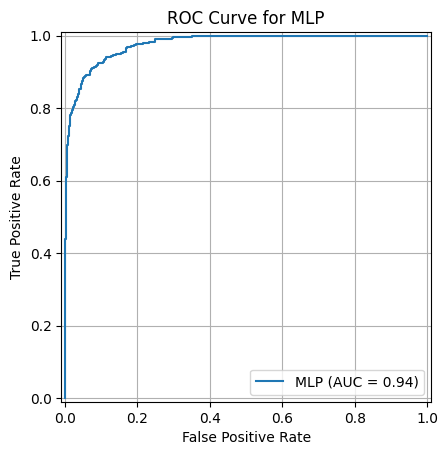

In [104]:
model = MLP(X_train.shape[1], best_params5[1], out_dim, best_params5[2]).to(device)
model.load_state_dict(best_model5)
model.eval()

# Visualize the auc
y_probs = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1).cpu().numpy()
        y_probs.append(probs)
        y_true.append(labels.cpu().numpy())
y_probs = np.concatenate(y_probs, axis=0)
y_true = np.concatenate(y_true)
fpr, tpr, thresholds = roc_curve(y_true, y_probs[:, 1], pos_label=1)
roc_auc = roc_auc_score(y_true, y_probs, multi_class='ovr')
plt.figure(figsize=(8, 6))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='MLP').plot()
plt.title('ROC Curve for MLP')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.show()

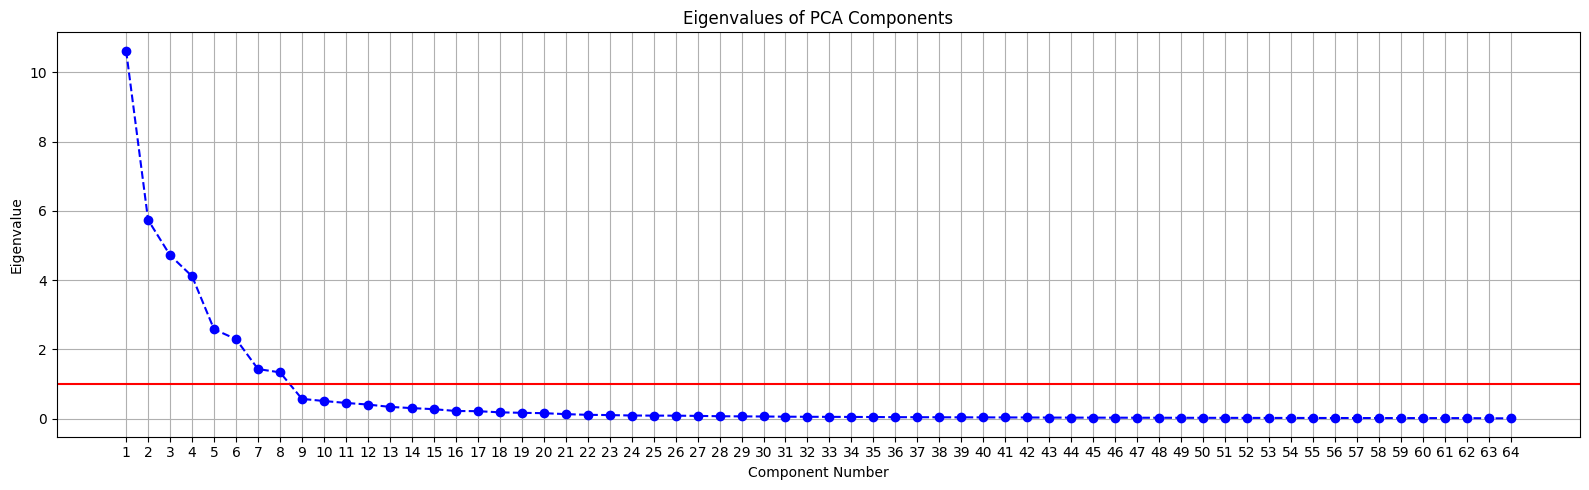

Eigenvalues above 1: [10.625926, 5.7357736, 4.716194, 4.1090856, 2.5778763, 2.291961, 1.4282501, 1.3334484]


In [ ]:
# get latent representation
X_train_latent, y_train_latent = get_mlp_latent(model, train_loader)

pca_latent1 = PCA().fit(X_train_latent)
X_train_latent_pca1 = pca_latent1.transform(X_train_latent)

eigenvalues_latent1 = pca_latent1.explained_variance_
eigenvalues_above_1_latent1 = []
for i in range(len(eigenvalues_latent1)):
    if eigenvalues_latent1[i] > 1:
        eigenvalues_above_1_latent1.append(eigenvalues_latent1[i])

# plot eigenvalues
plt.figure(figsize=(16, 5))
plt.plot(range(1, len(eigenvalues_latent1) + 1), eigenvalues_latent1, marker='o', linestyle='--', color='b')
plt.axhline(y=1, color='r', linestyle='-')
plt.title('Eigenvalues of PCA Components')
plt.xlabel('Component Number')
plt.ylabel('Eigenvalue')
plt.xticks(range(1, len(eigenvalues_latent1) + 1))
plt.grid()
plt.tight_layout()
plt.show()
print("Eigenvalues above 1:", eigenvalues_above_1_latent1)


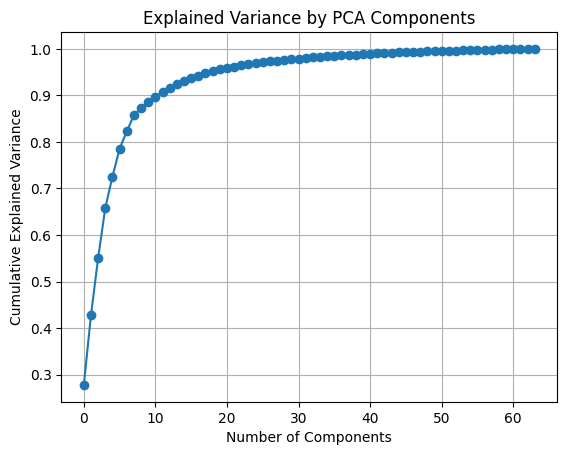

explained variance ratio: [2.7767286e-01 1.4988516e-01 1.2324188e-01 1.0737714e-01 6.7364134e-02
 5.9892695e-02 3.7322514e-02 3.4845192e-02 1.4809159e-02 1.3217288e-02
 1.1756310e-02 1.0534117e-02 8.7883761e-03 7.8433631e-03 7.0467736e-03
 5.6813108e-03 5.5359290e-03 4.6616360e-03 4.2973896e-03 4.0216655e-03
 3.3037516e-03 2.7804247e-03 2.5903406e-03 2.2624254e-03 2.1827586e-03
 2.1429674e-03 1.9772016e-03 1.7196439e-03 1.6083918e-03 1.5202466e-03
 1.3714236e-03 1.2957796e-03 1.2441893e-03 1.1885990e-03 1.1122640e-03
 1.0066238e-03 9.8542671e-04 9.2967693e-04 8.9027639e-04 8.4721920e-04
 8.0950733e-04 7.7713991e-04 7.0258207e-04 6.7191554e-04 6.5510283e-04
 6.2855065e-04 5.8242067e-04 5.7139416e-04 5.3339603e-04 5.1855994e-04
 4.9404806e-04 4.5485134e-04 4.3670894e-04 4.3250740e-04 4.0696046e-04
 3.7825236e-04 3.4586334e-04 3.4322136e-04 3.2581799e-04 3.1281132e-04
 2.9453306e-04 2.7694192e-04 1.6845162e-04 1.2398802e-04]
Total explained variance: 1.0
explained variance ratio by first 

In [71]:
explained_var = pca_latent1.explained_variance_ratio_

plt.figure()
plt.plot(np.cumsum(explained_var), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.show()

print("explained variance ratio:", pca_latent1.explained_variance_ratio_)
print("Total explained variance:", np.sum(pca_latent1.explained_variance_ratio_))
print("explained variance ratio by first 2 components:", np.sum(pca_latent1.explained_variance_ratio_[:2]))

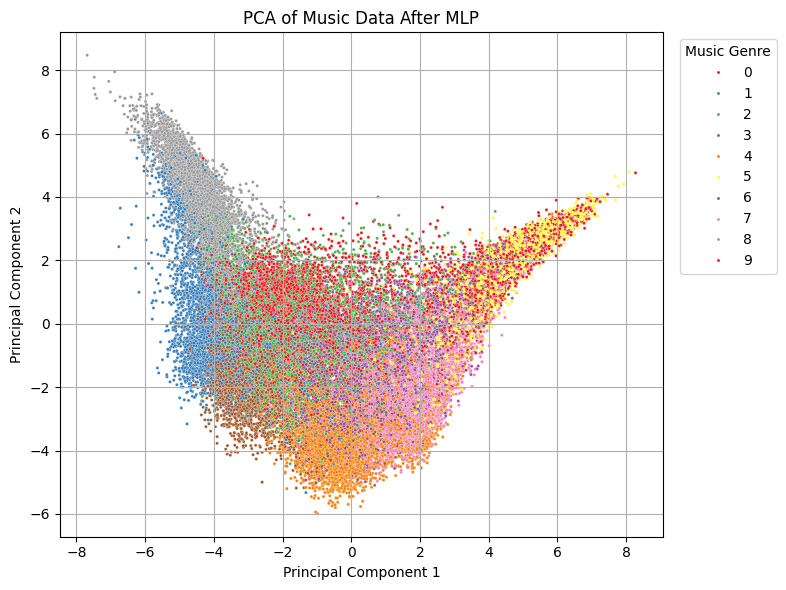

In [72]:
# scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_latent_pca1[:, 0], y=X_train_latent_pca1[:, 1], hue=y_train_latent, palette='Set1', s=5)
plt.title('PCA of Music Data After MLP')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.legend(title='Music Genre', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.tight_layout()
plt.show()

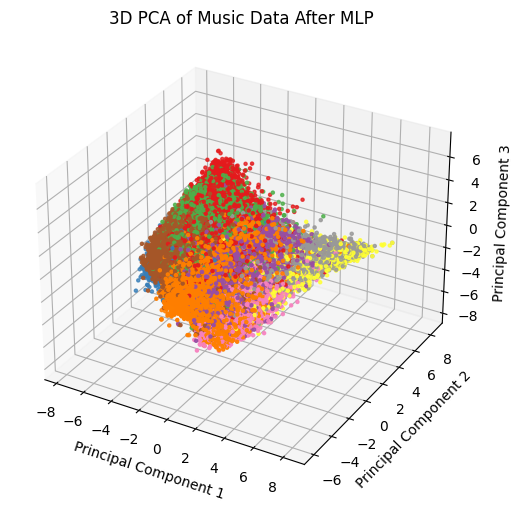

In [73]:
# 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_latent_pca1[:, 0], X_train_latent_pca1[:, 1], X_train_latent_pca1[:, 2], c=y_train_latent, cmap='Set1', s=5)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA of Music Data After MLP')
plt.show()


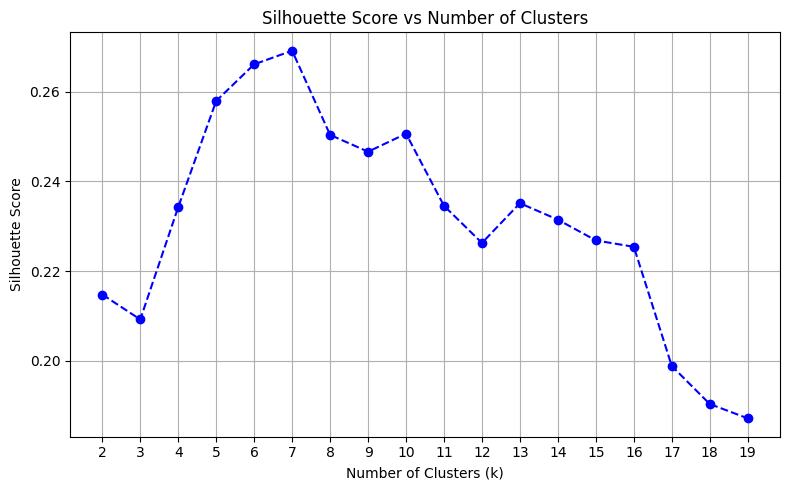

Silhouette scores: [0.21476296, 0.20920132, 0.23425288, 0.25793678, 0.26611033, 0.2691424, 0.2503613, 0.24661961, 0.2506331, 0.23455048, 0.22626732, 0.23513351, 0.23145473, 0.2268279, 0.2254058, 0.19881156, 0.19034268, 0.18714562]
Best k: 7


In [74]:
# k-means clustering
silhouette_scores_latent1 = []
ks_latent1 = range(2, 20)
for k in ks_latent1:
    kmeans = KMeans(n_clusters=k, n_init= 'auto', random_state=13147286)
    labels = kmeans.fit_predict(X_train_latent_pca1)
    score = silhouette_score(X_train_latent_pca1, labels)
    silhouette_scores_latent1.append(score)
plt.figure(figsize=(8, 5))
plt.plot(ks_latent1, silhouette_scores_latent1, marker='o', linestyle='--', color='b')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(ks_latent1)
plt.grid()
plt.tight_layout()
plt.show()
print("Silhouette scores:", silhouette_scores_latent1)
best_k_latent1 = ks_latent1[silhouette_scores_latent1.index(max(silhouette_scores_latent1))]
print("Best k:", best_k_latent1)

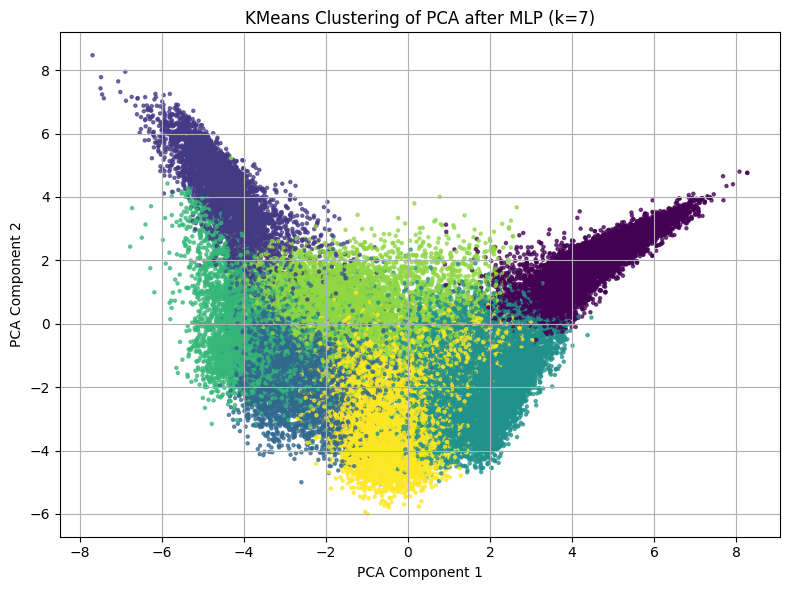

In [84]:
kmeans_best_latent1 = KMeans(n_clusters=best_k_latent1, n_init='auto', random_state=13147286)
labels_best_latent1 = kmeans_best_latent1.fit_predict(X_train_latent_pca1)
plt.figure(figsize=(8, 6))
plt.scatter(X_train_latent_pca1[:, 0], X_train_latent_pca1[:, 1], c=labels_best_latent1, cmap='viridis', alpha=0.7, s= 5)
plt.title(f'KMeans Clustering of PCA after MLP (k={best_k_latent1})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.tight_layout()
plt.show()

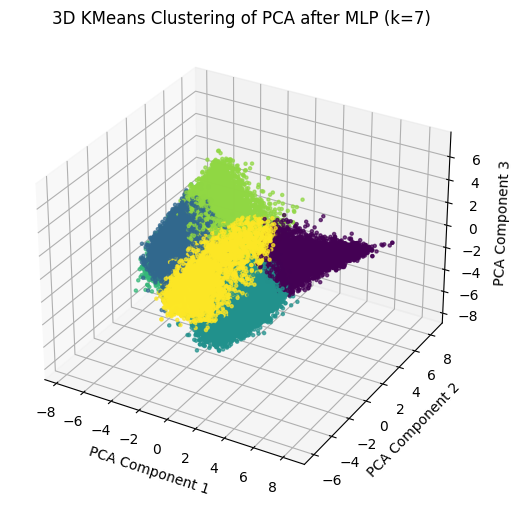

In [76]:
# 3D cluster plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_latent_pca1[:, 0], X_train_latent_pca1[:, 1], X_train_latent_pca1[:, 2], c=labels_best_latent1, cmap='viridis', alpha=0.7, s=5)
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title(f'3D KMeans Clustering of PCA after MLP (k={best_k_latent1})')
plt.show()

<Figure size 800x600 with 0 Axes>

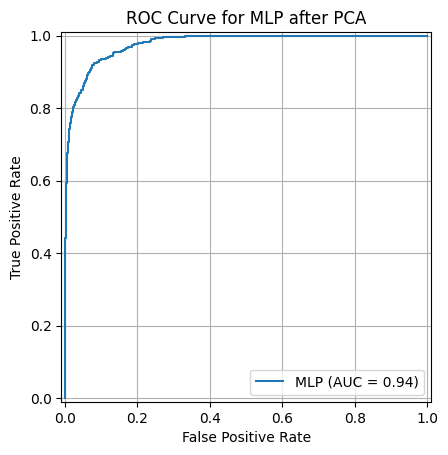

In [105]:
# PCA preprcessed Model
X_train_n = X_train_pca[:, :best_n7]
X_test_n = X_test_pca[:, :best_n7]
X_train_tensor_n = torch.tensor(X_train_n, dtype=torch.float32)
X_test_tensor_n = torch.tensor(X_test_n, dtype=torch.float32)
train_dataset_n = torch.utils.data.TensorDataset(X_train_tensor_n, y_train_tensor)
test_dataset_n = torch.utils.data.TensorDataset(X_test_tensor_n, y_test_tensor)
train_loader_n = torch.utils.data.DataLoader(train_dataset_n, batch_size=1024, shuffle=True, pin_memory=True, num_workers= 8)
test_loader_n = torch.utils.data.DataLoader(test_dataset_n, batch_size=1024, shuffle=False, pin_memory=True, num_workers= 8)

model = MLP(X_train_n.shape[1], best_params5[1], out_dim, best_params5[2]).to(device)
model.load_state_dict(best_model7)
model.eval()

# Visualize the auc
y_probs = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader_n:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1).cpu().numpy()
        y_probs.append(probs)
        y_true.append(labels.cpu().numpy())
y_probs = np.concatenate(y_probs, axis=0)
y_true = np.concatenate(y_true)
fpr, tpr, thresholds = roc_curve(y_true, y_probs[:, 1], pos_label=1)
roc_auc = roc_auc_score(y_true, y_probs, multi_class='ovr')
plt.figure(figsize=(8, 6))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='MLP').plot()
plt.title('ROC Curve for MLP after PCA')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.show()

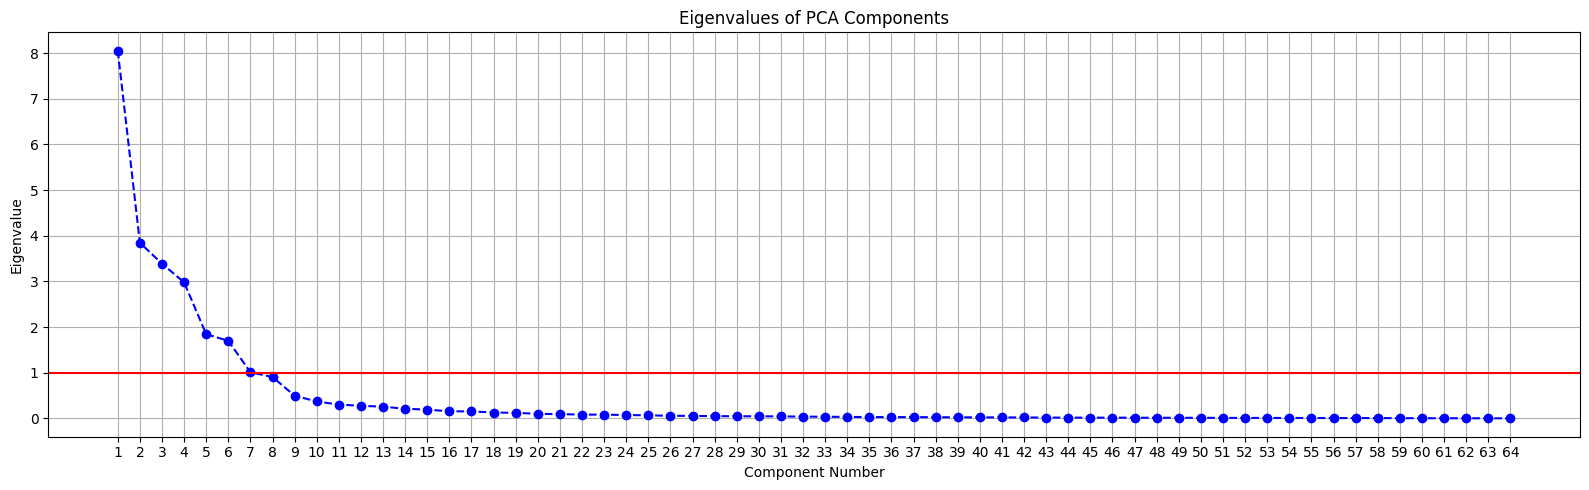

Eigenvalues above 1: [8.051482, 3.8480806, 3.3884053, 2.9806213, 1.8441364, 1.7014012, 1.0120318]


In [77]:
# PCA preprcessed Model
X_train_n = X_train_pca[:, :best_n7]
X_test_n = X_test_pca[:, :best_n7]
X_train_tensor_n = torch.tensor(X_train_n, dtype=torch.float32)
X_test_tensor_n = torch.tensor(X_test_n, dtype=torch.float32)
train_dataset_n = torch.utils.data.TensorDataset(X_train_tensor_n, y_train_tensor)
test_dataset_n = torch.utils.data.TensorDataset(X_test_tensor_n, y_test_tensor)
train_loader_n = torch.utils.data.DataLoader(train_dataset_n, batch_size=1024, shuffle=True, pin_memory=True, num_workers= 8)
test_loader_n = torch.utils.data.DataLoader(test_dataset_n, batch_size=1024, shuffle=False, pin_memory=True, num_workers= 8)

model = MLP(X_train_n.shape[1], best_params5[1], out_dim, best_params5[2]).to(device)
model.load_state_dict(best_model7)
model.eval()

X_train_latent2, y_train_latent2 = get_mlp_latent(model, train_loader_n)
pca_latent2 = PCA().fit(X_train_latent2)
X_train_latent_pca2 = pca_latent2.transform(X_train_latent2)
eigenvalues_latent2 = pca_latent2.explained_variance_
eigenvalues_above_1_latent2 = []
for i in range(len(eigenvalues_latent2)):
    if eigenvalues_latent2[i] > 1:
        eigenvalues_above_1_latent2.append(eigenvalues_latent2[i])
# plot eigenvalues
plt.figure(figsize=(16, 5))
plt.plot(range(1, len(eigenvalues_latent2) + 1), eigenvalues_latent2, marker='o', linestyle='--', color='b')
plt.axhline(y=1, color='r', linestyle='-')
plt.title('Eigenvalues of PCA Components')
plt.xlabel('Component Number')
plt.ylabel('Eigenvalue')
plt.xticks(range(1, len(eigenvalues_latent2) + 1))
plt.grid()
plt.tight_layout()
plt.show()
print("Eigenvalues above 1:", eigenvalues_above_1_latent2)



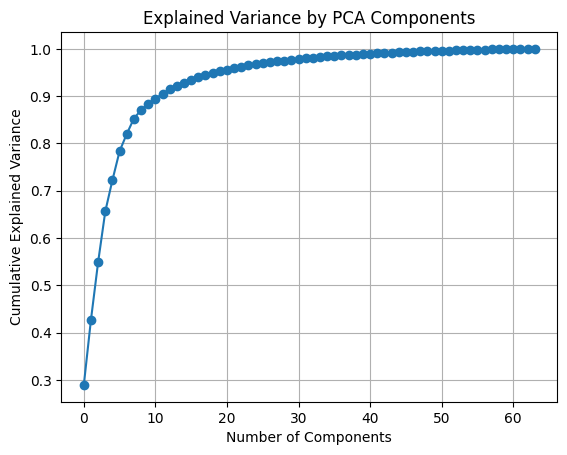

explained variance ratio: [2.89298147e-01 1.38265550e-01 1.21748932e-01 1.07096829e-01
 6.62617385e-02 6.11331165e-02 3.63633558e-02 3.26451622e-02
 1.79117452e-02 1.33788614e-02 1.09462487e-02 9.95682646e-03
 9.31077451e-03 7.63673801e-03 7.00825918e-03 5.63793769e-03
 5.57797588e-03 4.70468169e-03 4.45333170e-03 3.68997594e-03
 3.40992305e-03 3.06638121e-03 3.02137388e-03 2.72493181e-03
 2.49484298e-03 2.12135888e-03 2.04256480e-03 1.85958494e-03
 1.74144632e-03 1.73527363e-03 1.62941718e-03 1.47639797e-03
 1.36946363e-03 1.22992590e-03 1.13801041e-03 1.09730847e-03
 1.08191487e-03 9.78388707e-04 9.15325654e-04 8.77703482e-04
 8.46260518e-04 8.13662366e-04 7.14906317e-04 6.74244773e-04
 6.51351002e-04 6.40624959e-04 6.20630512e-04 5.75152808e-04
 5.71310171e-04 5.23419119e-04 4.99511254e-04 4.45287325e-04
 4.30859771e-04 4.28248430e-04 3.76033830e-04 3.47522815e-04
 3.41061852e-04 3.35428631e-04 2.45089206e-04 2.22632923e-04
 1.99724585e-04 1.77243812e-04 1.66787155e-04 1.15341376e-0

In [78]:
explained_var = pca_latent2.explained_variance_ratio_
plt.figure()

plt.plot(np.cumsum(explained_var), marker='o')
plt.xlabel("Number of Components")

plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.show()
print("explained variance ratio:", pca_latent2.explained_variance_ratio_)
print("Total explained variance:", np.sum(pca_latent2.explained_variance_ratio_))
print("explained variance ratio by first 2 components:", np.sum(pca_latent2.explained_variance_ratio_[:2]))


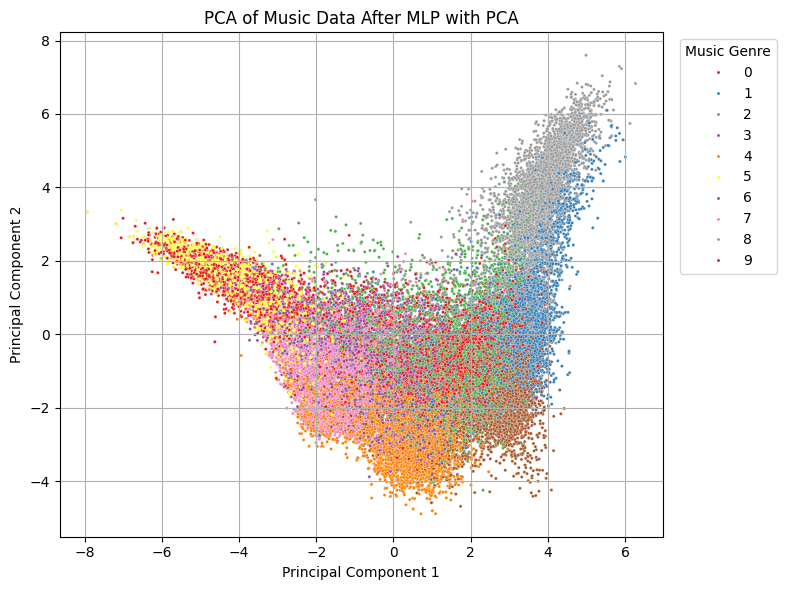

In [79]:
# scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_latent_pca2[:, 0], y=X_train_latent_pca2[:, 1], hue=y_train_latent2, palette='Set1', s=5)
plt.title('PCA of Music Data After MLP with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2') 
plt.grid()
plt.legend(title='Music Genre', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.tight_layout()
plt.show()

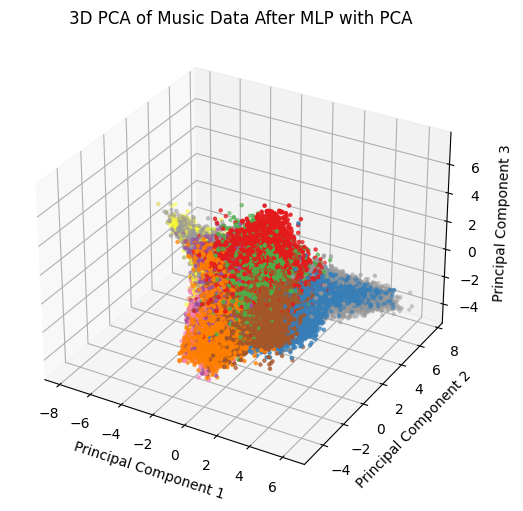

In [80]:
# 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_latent_pca2[:, 0], X_train_latent_pca2[:, 1], X_train_latent_pca2[:, 2], c=y_train_latent2, cmap='Set1', s=5)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA of Music Data After MLP with PCA')
plt.show()


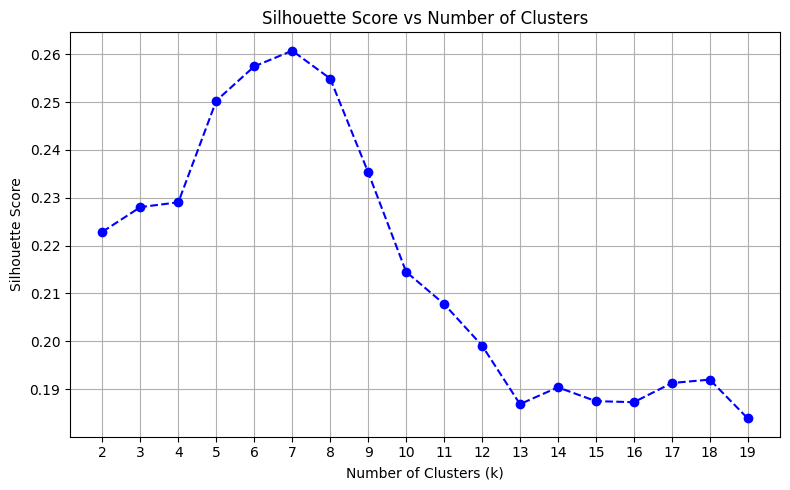

Silhouette scores: [0.22288626, 0.22804384, 0.22904652, 0.25028232, 0.25745258, 0.26073325, 0.25490868, 0.23532932, 0.21452901, 0.20778687, 0.19910616, 0.18686353, 0.19037387, 0.18748282, 0.18726738, 0.19127068, 0.19198763, 0.1838908]
Best k: 7


In [81]:
# k-means clustering
silhouette_scores_latent2 = []
ks_latent2 = range(2, 20)
for k in ks_latent2:
    kmeans = KMeans(n_clusters=k, n_init= 'auto', random_state=13147286)
    labels = kmeans.fit_predict(X_train_latent_pca2)
    score = silhouette_score(X_train_latent_pca2, labels)
    silhouette_scores_latent2.append(score)
plt.figure(figsize=(8, 5))
plt.plot(ks_latent2, silhouette_scores_latent2, marker='o', linestyle='--', color='b')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(ks_latent2)
plt.grid()
plt.tight_layout()
plt.show()
print("Silhouette scores:", silhouette_scores_latent2)
best_k_latent2 = ks_latent2[silhouette_scores_latent2.index(max(silhouette_scores_latent2))]
print("Best k:", best_k_latent2)


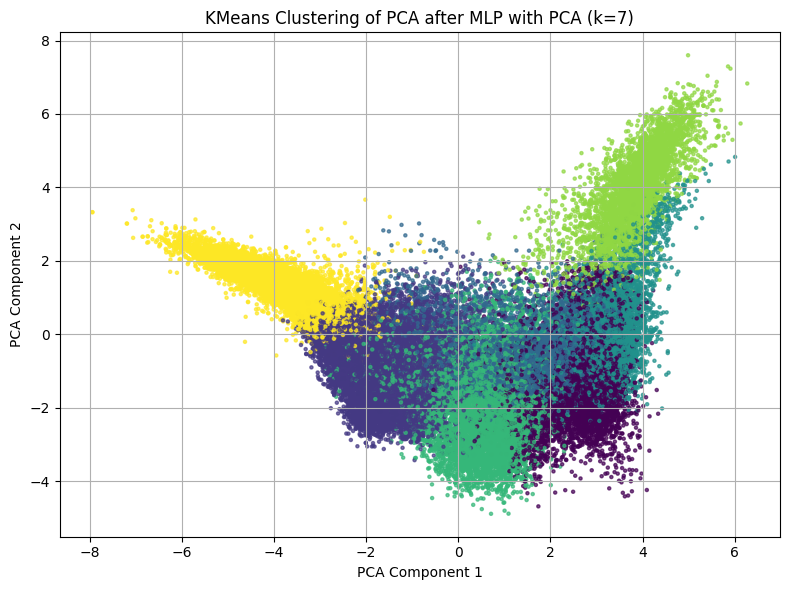

In [82]:
kmeans_best_latent2 = KMeans(n_clusters=best_k_latent2, n_init='auto', random_state=13147286)
labels_best_latent2 = kmeans_best_latent2.fit_predict(X_train_latent_pca2)
plt.figure(figsize=(8, 6))
plt.scatter(X_train_latent_pca2[:, 0], X_train_latent_pca2[:, 1], c=labels_best_latent2, cmap='viridis', alpha=0.7, s=5)
plt.title(f'KMeans Clustering of PCA after MLP with PCA (k={best_k_latent2})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.tight_layout()
plt.show()



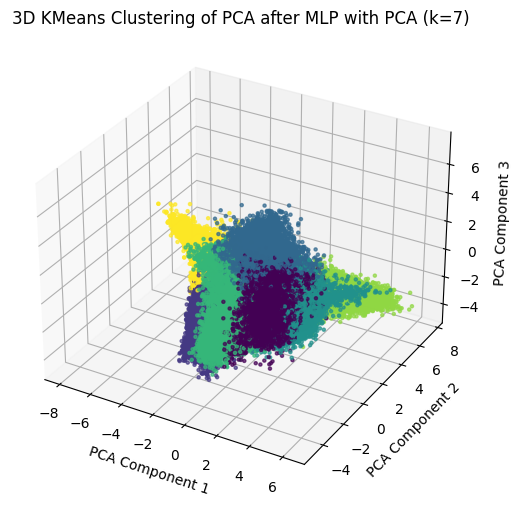

In [83]:
# 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_latent_pca2[:, 0], X_train_latent_pca2[:, 1], X_train_latent_pca2[:, 2], c = labels_best_latent2, cmap='viridis', alpha=0.7, s=5)
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title(f'3D KMeans Clustering of PCA after MLP with PCA (k={best_k_latent2})')
plt.show()


In [ ]:
# AUC plot 
